# Imports

In [1]:
from vip_hci.fits import open_fits,write_fits
import numpy as np
from matplotlib import pyplot as plt
from hciplot import plot_frames
import pandas as pd
import seaborn as sns
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import vip_hci as vip

In [3]:
vip.__version__

'1.3.1'

In [6]:
#include the files from path ../
import sys
sys.path.append('../CCF_code/')
from CCFcore.PreProcess import SINFONI
from CCFcore.CrossCorr import CrossCorr
from CCFcore import removeTelluric
import multiprocessing
from contextlib import contextmanager
from CCFcore import removeTelluric,applyFilter,measureSpatialSpec
from vip_hci.preproc.cosmetics import frame_center,cube_crop_frames,frame_crop
from vip_hci.preproc.derotation import cube_derotate
from vip_hci.metrics.stim import stim_map
from vip_hci.metrics.snr_source import snrmap
from vip_hci.var.shapes import mask_circle
from vip_hci.metrics.roc import compute_binary_map
from vip_hci.hci_postproc import median_sub
from hciplot import plot_frames
from vip_hci.fm.fakecomp import cube_inject_companions

In [4]:
plt.style.use('seaborn')

# Difference between the methods Figs 1 and 2

In [25]:
#download the data from this note book or go to the zenoodo records to download it.
#!pip install requests
import requests
# Replace with the URL of the file you want to download
url = 'https://zenodo.org/records/10901109/files/ASDI_cube.fits'

# Send a GET request to the URL
response = requests.get(url)

# Make sure the request was successful
if response.status_code == 200:
    # Write the content of the response to a file
    with open('../data/source/ASDI_cube.fits', 'wb') as file:
        file.write(response.content)

In [26]:
temp_path = "../data/source/"
fl_insert="lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz"
datapath="../data/source/"
cube = open_fits(datapath+"ASDI_cube.fits")
data_waves= open_fits(datapath+"lbda_vec")
fwhm = open_fits(datapath+"fwhm_vec.fits")
rot_angles = open_fits(datapath+"derot_angles.fits")
psf_template = open_fits(datapath+"PSF_template.fits")


Fits HDU-0 data successfully loaded. Data shape: (2005, 83, 61, 61)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (2005,)
Fits HDU-0 data successfully loaded. Data shape: (83,)
Fits HDU-0 data successfully loaded. Data shape: (2005, 13, 13)


In [8]:
vels=np.linspace(-100,100,20)
CC=CrossCorr(vels)
temp_flux,temp_waves=CC.processTemplate(temp_path+fl_insert)
contrast = 1e-03
rad_dist =11.0
theta = 60.0
center = frame_center(cube[10,10,:,:])
stellar_spec=measureSpatialSpec(cube[:,10,:,:],center,fwhm)
st_spec_new=sum(stellar_spec[::])
temp_downsampled=np.interp(data_waves,temp_waves,temp_flux)
temp_new = temp_downsampled/sum(temp_downsampled)                                                                   
temp_insert=st_spec_new*contrast*temp_new
comp_spec_added=np.zeros_like(psf_template)
print("Insert a companion at a rad_dist {0:3.2f} pixels,theta {1:3.2f} and contrast of {2:1.0e}"
      .format(rad_dist,theta,contrast)) 
masked_psf = mask_circle(psf_template,radius=4,mode='out')
psf_cropped = cube_crop_frames(psf_template,size=11)

Now reading ../data/source/lte013.0-3.0-0.0a+0.0.BT-Settl.spec.fits.gz
Insert a companion at a rad_dist 11.00 pixels,theta 60.00 and contrast of 5e-04
New shape: (2005, 11, 11)


In [9]:
fake_comp_cube,pos1 = cube_inject_companions(cube,
                                psf_template = psf_cropped,
                                angle_list=rot_angles,
                                flevel=temp_insert,
                                rad_dists=rad_dist,
                                plsc=0.25,
                                theta = theta,
                                n_branches = 1,
                                full_output=True)


In [11]:
med_adi = []

#output here is supressed

for i in range(2000):
    med_adi.append(median_sub(fake_comp_cube[i,:,:,:],angle_list=rot_angles,imlib='opencv'))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-31 18:03:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.071287
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-31 18:03:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.062142
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-03-31 18:03:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
R

In [110]:
med_med = np.mean(med_adi,axis=0)

In [111]:
adi_snr = snrmap(med_med,fwhm=4.8)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:55:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:05.264723
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [5]:
import requests

# Zenodo record URL
zenodo_url = "https://zenodo.org/records/10902875"
# Send a GET request to the Zenodo record URL
response = requests.get(zenodo_url)
#write the files to the data/ccf_cubes folder
#create the folder if it does not exist
import os
if not os.path.exists("../data/ccf_cubes/"):
    os.makedirs("../data/ccf_cubes/")


# Check if the request was successful
if response.status_code == 200:
    # Print the list of files
    files = response.json()
    for file in files:
        #download the files
        print(file['filename'])
        url = zenodo_url + file['filename']
        response = requests.get(url)
        if response.status_code == 200:
            with open("../data/ccf_cubes/"+file['filename'], 'wb') as f:
                f.write(response.content)
        else:
            print("Failed to download the file.")


else:
    print("Failed to connect to the Zenodo repository.")




JSONDecodeError: [Errno Expecting value] 


<!DOCTYPE html>
<html lang="en" dir="ltr">
  <head>
  
    
      <meta charset="utf-8">
      <meta http-equiv="X-UA-Compatible" content="IE=edge">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <meta name="google-site-verification" content="5fPGCLllnWrvFxH9QWI0l1TadV7byeEvfPcyK2VkS_s"/>
      <meta name="google-site-verification" content="Rp5zp04IKW-s1IbpTOGB7Z6XY60oloZD5C3kTM-AiY4"/>
  
    <meta name="description" content="Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper." />
    <meta name="citation_title" content="CCF cubes" />
    <meta name="citation_doi" content="10.5281/zenodo.10902875" />
    <meta name="citation_abstract_html_url" content="https://zenodo.org/records/10902875" />
    <meta property="og:title" content="CCF cubes" />
    <meta property="og:description" content="Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper." />
    <meta property="og:url" content="https://zenodo.org/records/10902875" />
    <meta property="og:site_name" content="Zenodo" />
    <meta name="twitter:card" content="summary" />
    <meta name="twitter:site" content="@zenodo_org" />
    <meta name="twitter:title" content="CCF cubes" />
    <meta name="twitter:description" content="Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper." />
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits">
    
    <link rel="alternate" type="application/octet-stream" href="https://zenodo.org/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits">


<link rel="canonical" href="https://zenodo.org/records/10902875">
      <title>CCF cubes</title>
      <link rel="shortcut icon" type="image/x-icon" href="/static/favicon.ico"/>
          <link rel="apple-touch-icon" sizes="120x120" href="/static/apple-touch-icon-120.png"/>
          <link rel="apple-touch-icon" sizes="152x152" href="/static/apple-touch-icon-152.png"/>
          <link rel="apple-touch-icon" sizes="167x167" href="/static/apple-touch-icon-167.png"/>
          <link rel="apple-touch-icon" sizes="180x180" href="/static/apple-touch-icon-180.png"/>
    
      <link rel="stylesheet" href="/static/dist/css/3526.1d35b7ba5fe006ff9af6.css" />
      <!-- HTML5 shim and Respond.js for IE8 support of HTML5 elements and media queries -->
      <!--[if lt IE 9]>
        <script src="https://oss.maxcdn.com/html5shiv/3.7.2/html5shiv.min.js"></script>
        <script src="https://oss.maxcdn.com/respond/1.4.2/respond.min.js"></script>
      <![endif]-->
    
  </head>

  <body itemscope itemtype="http://schema.org/WebPage" data-spy="scroll" data-target=".scrollspy-target">
      <a id="skip-to-main" class="ui button primary ml-5 mt-5 skip-link" href="#main">Skip to main</a>
      <!--[if lt IE 8]>
        <p class="browserupgrade">You are using an <strong>outdated</strong> browser. Please <a href="http://browsehappy.com/">upgrade your browser</a> to improve your experience.</p>
      <![endif]-->
    

<div>
  <header class="theme header">
      
      
    
      
        <div class="ui info flashed top attached manage m-0 message">
          <div class="ui container">
              <strong>Planned intervention</strong>: On Wednesday April 3rd 05:30 UTC Zenodo will be unavailable for up to 2-10 minutes to perform a storage cluster upgrade.
          </div>
        </div>
      
    
    <div class="outer-navbar">
      <div class="ui container invenio-header-container">
        <nav id="invenio-nav" class="ui inverted menu borderless p-0">
          <div class="item logo p-0">
                    <a class="logo-link" href="/">
                      <img class="ui image rdm-logo"
                            src="/static/images/invenio-rdm.svg"
                            alt="Zenodo home"/>
                    </a>
          </div>

          <div id="rdm-burger-toggle">
            <button
              id="rdm-burger-menu-icon"
              class="ui button transparent"
              aria-label="Menu"
              aria-haspopup="menu"
              aria-expanded="false"
              aria-controls="invenio-menu"
            >
              <span class="navicon" aria-hidden="true"></span>
            </button>
          </div>

          <nav
            id="invenio-menu"
            aria-labelledby="rdm-burger-menu-icon"
            class="ui fluid menu borderless mobile-hidden"
          >
            <button
              id="rdm-close-burger-menu-icon"
              class="ui button transparent"
              aria-label="Close menu"
            >
              <span class="navicon" aria-hidden="true"></span>
            </button>
    
    
    
      <div class="item p-0 search-bar">
        <div id="header-search-bar" data-options='[{"key": "records", "text": "All Zenodo", "value": "/search"}]'>
          <div class="ui fluid search">
            <div class="ui icon input">
              <input
                autocomplete="off"
                aria-label="Search records"
                placeholder="Search records..."
                type="text"
                tabindex="0"
                class="prompt"
                value=""
              >
              <i aria-hidden="true" class="search icon"></i>
            </div>
          </div>
        </div>
      </div>

                  <div class="item">
                    <a href="/communities">Communities</a>
                  </div>

              
                <div class="item">
                  <a href="/me/uploads">My dashboard</a>
                </div>
              
              <div class="right menu item">
    <form>
      <a
        href="/login/?next=%2Frecords%2F10902875"
        class="ui button">
        <i class="sign-in icon"></i>
        Log in</a>
      
        <a href="/signup/" class="ui button signup">
          <i class="edit outline icon"></i>
          Sign up
        </a>
      
    </form>
              </div>
          </nav>
        </nav>
    </div>
  </header>
</div>

  <main id="main">
    <div class="invenio-page-body">
  <section id="banners" class="banners" aria-label="Information banner">

    <!-- COMMUNITY HEADER: hide it when displaying the submission request -->
    
      
    
    <!-- /COMMUNITY HEADER -->

    <!-- PREVIEW HEADER -->
    
    <!-- /PREVIEW HEADER -->

    
  </section>


  <div class="ui container">
    <div class="ui relaxed grid mt-5">
      <div class="two column row top-padded">

        
        <article
          class="sixteen wide tablet eleven wide computer column main-record-content">
          

              

              

              <section id="record-info"
                       aria-label="Publication date and version number">
                <div class="ui grid middle aligned">
                  <div class="two column row">
                    <div class="left floated left aligned column">
                      <span class="ui" title="Publication date">
                        Published April 1, 2024
                      </span>
                      <span
                        class="label text-muted"> | Version v1</span>
                    </div>
                    <div class="right floated right aligned column">

                      
                        <span role="note"
                              class="ui label horizontal small neutral mb-5"
                              aria-label="Resource type"
                        >
                          Dataset
                        </span>
                      

                      <span role="note"
                            class="ui label horizontal small access-status open mb-5"
                            data-tooltip="The record and files are publicly accessible."
                            data-inverted=""
                            aria-label="Access status"
                      >
                        
                          <i class="icon unlock"
                             aria-hidden="true"></i>
                        
                        <span
                          aria-label="The record and files are publicly accessible.">
                          Open
                        </span>
                      </span>
                    </div>
                  </div>
                </div>
              </section>
              <div class="ui divider hidden"></div><section id="record-title-section"
                       aria-label="Record title and creators">
                <h1 id="record-title"
                    class="wrap-overflowing-text">CCF cubes</h1>

                
                  <section id="creatibutors"
                           aria-label="Creators and contributors">

<div class="ui grid">
  
    <div class="row ui accordion affiliations">
      <div class="sixteen wide mobile twelve wide tablet thirteen wide computer column">
          <h2 class="sr-only">Creators</h2>
          <ul class="creatibutors">
            
  
  <li class="creatibutor-wrap separated">
    <a class="ui creatibutor-link"
      
        data-tooltip="University of Liege"
      
      href="/search?q=metadata.creators.person_or_org.name%3A%22Nath,+Rakesh%22"
    >

      <span class="creatibutor-name">Nath, Rakesh</span><sup class="font-tiny">1</sup></a>
  

  
      
      <a class="no-text-decoration" href="https://orcid.org/0000-0001-5210-7502" aria-label="Nath, Rakesh's ORCID profile" title="Nath, Rakesh's ORCID profile">
        <img class="ml-5 inline-id-icon" src="/static/images/orcid.svg" alt="ORCID icon"/>
      </a>
  

  
</li>
  
          </ul>
      </div>

        
        
          
<div class="ui sixteen wide tablet three wide computer column title right aligned bottom aligned">
  <button class="ui affiliations-button trigger button mini mr-0"
          aria-controls="creators-affiliations"
          data-open-text="Show affiliations"
          data-close-text="Hide affiliations"
          aria-expanded="false"
  >
    Show affiliations
  </button>
</div>

<section class="ui sixteen wide column content" id="creators-affiliations" aria-label="Affiliations for creators">
  <ul>
  
      <li>
          1.

          
          University of Liege
        </li>
  
    </ul>
</section>

        

    </div>
  

  
</div>
                  </section>
                
              </section>



  <section id="description" class="rel-mt-2 rich-input-content" aria-label="Record description">
    <h2 id="description-heading" class="sr-only">Description</h2>
    
    <div style="word-wrap: break-word;">
      <p><p>Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.</p></p>
    </div>
  </section>


<section
      id="record-files" class="rel-mt-2 rel-mb-3"
      aria-label="Files"
    ><h2 id="files-heading">Files</h2>
  <div class="ui accordion panel mb-10 open" href="#files-list-accordion-panel">
    <h3 class="active title panel-heading open m-0">
      <div role="button" id="files-list-accordion-trigger" aria-controls="files-list-accordion-panel" aria-expanded="true" tabindex="0" class="trigger">
        Files
        <small class="text-muted"> (49.7 MB)</small>
        <i class="angle right icon" aria-hidden="true"></i>
      </div>
    </h3>

    <div role="region" id="files-list-accordion-panel" aria-labelledby="files-list-accordion-trigger" class="active content pt-0">
      
      <div>
        
  <table class="ui striped table files fluid open">
    <thead>
      <tr>
        <th>Name</th>
        <th>Size</th>
        <th class>
            
            <a role="button" class="ui compact mini button right floated archive-link" href="https://zenodo.org/api/records/10902875/files-archive">
              <i class="file archive icon button" aria-hidden="true"></i> Download all
            </a>
        </th>
      </tr>
    </thead>
    <tbody>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:50f7af8c0ced5d327613d8f846556957
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5a0b782d962b8186695958e59105fa2a
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:57046ca052dbaa18d8f56ad2b2b71348
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:13dcc2d806979ae826982e14ce5071a1
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:08ee2f866cacfa462793915761597c9c
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:1f0d8eb1de857af7b7a85ba31d3e01c4
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:dd0a20906162e828b3f743ef5311dd74
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:3d7e42ad05799ed72ef112e0254d5269
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:68f0ce0b160fb82e4d9fd0bf2bb99e72
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5a80c351888b280ca10ecb26cc8e14e5
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:514a4f95abc3de772f03f433fc86bead
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:35d2c2250a52c6d0452092f1d2b9e21d
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:b46d8ba2d3727348344fd4727a852ea2
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d4bd48c1ec3b2fd9fb6d43a9a9832b29
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d5d65f067c6cd8df557128ec2af64a2b
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8a4dc615e803f18d5dca51b30f90092f
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:467872da0beb966e36ae5325b7d6791b
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5d9e1510c9c2184bc9807780975c1335
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5756df799bdd9b2ae342e124b0ba7ef9
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5dd1ec428f802d438b12937c78e24a4b
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:f3f5393b58d07caec73cff850f41583a
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8211800e9448cb3b8f3702f65095eb5b
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:31043b9365938c5d432cd8408dc98b09
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:0ed9363a01968b92828b4d52a64023dc
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d9a5b0c09a6eeb8204b02d1272a40ec0
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:1e9bf8b428648c26b7eb98a1b0341153
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:ec2660b17fbf93e6d788f8796d1fa88e
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8e9a25421f32a08a819476b12468440c
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:f9adf48f7fe2093ee90a780ff92494e5
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:0b8ee606874f4c5e2c5edf2bfbb43401
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8ef77fd9c31010a902c2abdc8a70b225
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8a69e68ee22ad44fc090097d98758f3f
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:9f5a588b84944e91f2286049a615da4d
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:dc583b840a8f5cae024be69e8ac302f5
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:0b35da34ff4d7f5871a111a7f408164d
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:1f4c0ba3a01e88d5516a11a633ca6adc
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d1e2f40a945e7bc607de120c4c613038
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:53787a826acabd17becae6b6c794d1e1
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:e92bcee83fa87701cdde3d8f78903d3d
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:c561bd2ed5a0b0e0852e573452a6c807
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:213869bdb4db9296eca35c8e9a477834
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:986148b9509923d360030fcd036527ea
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:174c68f1c3f38fc42fd8af506afbc12d
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:cec364f4be5e3fe503ce07869025bbcf
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:8be375716832c94f0af3a7dd155ae84c
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:4aca47449a102c83cabefc3eb943aae4
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:e8804c0657715bc73be8ad28cbfe5d94
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:e5c29d0de5fd4473f718e2859c377556
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:dfc8d62cf0105fa3ecb9ed39fad1da2e
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:49069385dd45cbf21f0d08fc61417085
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:636d9b0ea9ae571a96872f80e9b69abb
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:22cb2c81bade8aaff33e543cacbf9849
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:465ab53db3d0826b4a16b0db06d54aa1
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:644046cc4dd391033bbb3a0fb6fb778e
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:073d731c2e7a6ac265ddbcebf682e0d7
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:205f94a2ec600c50b5c1841f5c1b33dd
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:79d47965a54dd1453ea7a77f94130606
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:56ffd4717dbf6c2291298880a4ff17a0
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:41c999044e29e8ca76f06f06cb2a24e4
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:dbfd87e781fb13b2cf0dfe18c06c8468
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:15900699bf9914837837925b61546b98
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:a12a409fbdf504697cfb070215671595
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:2281e2552da483534f64bc3bf7eefaf7
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:9a29d5a81c54bc2af7d14f9825f185fa
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:761a2afca607633f492d1d395cf6147f
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:76e55620e76eaee1dded78a414f81cee
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:2aa08af32bfa6649c7e1d7e58a7f20b3
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d25cf0c438fc378bd47912294900a780
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5f51bc64c0b63f255ed15081a793fbe0
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:efc12ef1a23088975f76719ccb724ffc
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:d01c1087085e9e4b685464669f5d8e8f
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:957c04ddef5f3db354470804e18df43c
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:a5b6685a4cd1ddd700ef5477a6183fca
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:75f2d7466196c444b34614921cf6db06
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:0a5e4a0906a7781123c6257d41b3a2aa
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:e30e5e57e9189bf584d7fdd9a849a9b0
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5eb4d6b4fe7c4fe8bb7d2b88188c4272
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:98806653d558169882e1a3bcbe82f3d5
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:6d0c5aba6992225c148be6b6e863e0ca
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:f5db487e0cb4541f5be0f5355b3f4be9
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:a07a45c03cf5bed8642958d51df75cd0
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:01efe57ef157f2025af60fb19326faa5
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
      
      
      <tr>
        <td class="ten wide">
          <div>
            <a href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits?download=1">ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits</a>
          </div>
          <small class="ui text-muted font-tiny">md5:5d02f749592f9ef43ddf9391a5a40436
          <div class="ui icon inline-block" data-tooltip="This is the file fingerprint (checksum), which can be used to verify the file integrity.">
            <i class="question circle checksum icon"></i>
          </div>
          </small>
        </td>
        <td>599.0 kB</td>
        <td class="right aligned">
          <span>
            
            <a role="button" class="ui compact mini button" href="/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits?download=1">
              <i class="download icon" aria-hidden="true"></i>Download
            </a>
          </span>
        </td>
      </tr>
    
    </tbody>
  </table>
      </div>
    </div>
  </div>
        
      

    </section>
              

  <section id="additional-details" class="rel-mt-2" aria-label="Additional record details">













  

  </section>
    
    <section
      id="citations-search"
      data-record-pids='{"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902875", "provider": "datacite"}, "oai": {"identifier": "oai:zenodo.org:10902875", "provider": "oai"}}'
      data-record-parent-pids='{"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902874", "provider": "datacite"}}'
      data-citations-endpoint="https://zenodo-broker.web.cern.ch/api/relationships"
      aria-label="Record citations"
      class="rel-mb-1"
    >
    </section>
  
        </article>

        
        <aside class="sixteen wide tablet five wide computer column sidebar"
               aria-label="Record details">
          




<section id="metrics" aria-label="Metrics" class="ui segment rdm-sidebar sidebar-container">


<div class="ui tiny two statistics rel-mt-1">
  
  

  <div class="ui statistic">
    <div class="value">0</div>
    <div class="label">
      <i aria-hidden="true" class="eye icon"></i>
      Views
    </div>
  </div>

  <div class="ui statistic">
    <div class="value">0</div>
    <div class="label">
      <i aria-hidden="true" class="download icon"></i>
      Downloads
    </div>
  </div>
</div>

<div class="ui accordion rel-mt-1 centered">
  <div class="title">
    <i class="caret right icon" aria-hidden="true"></i>
    <span
      tabindex="0"
      class="trigger"
      data-open-text="Show more details"
      data-close-text="Show less details"
    >
      Show more details
    </span>
  </div>

  <div class="content">
    <table id="record-statistics" class="ui definition table fluid">
      <thead>
        <tr>
          <th></th>
          <th class="right aligned">All versions</th>
          <th class="right aligned">This version</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>
            Views
            <i
              tabindex="0"
              role="button"
              style="position:relative"
              class="popup-trigger question circle small icon"
              aria-expanded="false"
              aria-label="More info"
              data-variation="mini inverted"
            >
            </i>
            <p role="tooltip" class="popup-content ui flowing popup transition hidden">
              Total views
            </p>
          </td>
          <td data-label="All versions" class="right aligned">
  
    0
  
</td>
          <td data-label="This version" class="right aligned">
  
    0
  
</td>
        </tr>
        <tr>
          <td>
            Downloads
            <i
              tabindex="0"
              role="button"
              style="position:relative"
              class="popup-trigger question circle small icon"
              aria-expanded="false"
              aria-label="More info"
              data-variation="mini inverted"
            >
            </i>
            <p role="tooltip" class="popup-content ui flowing popup transition hidden">
              Total downloads
            </p>
          </td>
          <td data-label="All versions" class="right aligned">
  
    0
  
</td>
          <td data-label="This version" class="right aligned">
  
    0
  
</td>
        </tr>
        <tr>
          <td>
            Data volume
            <i
              tabindex="0"
              role="button"
              style="position:relative"
              class="popup-trigger question circle small icon"
              aria-expanded="false"
              aria-label="More info"
              data-variation="mini inverted"
            >
            </i>
            <p role="tooltip" class="popup-content ui flowing popup transition hidden">
              Total data volume
            </p>
          </td>

          <td data-label="All versions" class="right aligned">0 Bytes</td>
          <td data-label="This version" class="right aligned">0 Bytes</td>
        </tr>
      </tbody>
    </table>
    <p class="text-align-center rel-mt-1">
      <small>
        <a href="/help/statistics">More info on how stats are collected....</a>
      </small>
    </p>
  </div>

</div>

</section>

<div class="sidebar-container">
  <h2 class="ui medium top attached header mt-0">Versions</h2>
  <div id="record-versions" class="ui segment rdm-sidebar bottom attached pl-0 pr-0 pt-0">
    <div class="versions">
      <div id="recordVersions" data-record='{"access": {"embargo": {"active": false, "reason": null}, "files": "public", "record": "public", "status": "open"}, "created": "2024-04-01T10:39:45.848039+00:00", "custom_fields": {}, "deletion_status": {"is_deleted": false, "status": "P"}, "expanded": {}, "files": {"count": 83, "enabled": true, "entries": {"ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits": {"checksum": "md5:50f7af8c0ced5d327613d8f846556957", "ext": "fits", "id": "2d403336-704b-4d2f-aa42-46aedd557a7b", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits": {"checksum": "md5:5a0b782d962b8186695958e59105fa2a", "ext": "fits", "id": "eddc8d45-7fb1-4904-b883-fe0628d98ab8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits": {"checksum": "md5:57046ca052dbaa18d8f56ad2b2b71348", "ext": "fits", "id": "4e7e4e7f-0be8-43d2-8438-a8022b7acdfc", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits": {"checksum": "md5:13dcc2d806979ae826982e14ce5071a1", "ext": "fits", "id": "0b5c96f0-ad81-47fe-81ce-9dd3fb3fb737", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits": {"checksum": "md5:08ee2f866cacfa462793915761597c9c", "ext": "fits", "id": "d21e7b96-c339-4ec5-a515-1434f4a1ee03", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits": {"checksum": "md5:1f0d8eb1de857af7b7a85ba31d3e01c4", "ext": "fits", "id": "cc62e2aa-761c-4864-8240-2837e71f8e08", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits": {"checksum": "md5:dd0a20906162e828b3f743ef5311dd74", "ext": "fits", "id": "05494d05-7b4c-4bb8-a4fe-3cac6e955175", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits": {"checksum": "md5:3d7e42ad05799ed72ef112e0254d5269", "ext": "fits", "id": "e23c5293-b86e-4bd8-87b3-63cc48bb6096", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits": {"checksum": "md5:68f0ce0b160fb82e4d9fd0bf2bb99e72", "ext": "fits", "id": "1cf3ccae-3288-4bb2-9671-0f4772649e24", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits": {"checksum": "md5:5a80c351888b280ca10ecb26cc8e14e5", "ext": "fits", "id": "66dc9580-3435-4898-9c35-921392a63b27", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits": {"checksum": "md5:514a4f95abc3de772f03f433fc86bead", "ext": "fits", "id": "cf35dcd0-1623-454b-80de-5a3e84f0c9b9", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits": {"checksum": "md5:35d2c2250a52c6d0452092f1d2b9e21d", "ext": "fits", "id": "80507c83-3366-4e28-815d-3473d5d87ccc", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits": {"checksum": "md5:b46d8ba2d3727348344fd4727a852ea2", "ext": "fits", "id": "8d7b95d0-f86c-4ccf-9761-96bea44bf491", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits": {"checksum": "md5:d4bd48c1ec3b2fd9fb6d43a9a9832b29", "ext": "fits", "id": "efb0146d-e144-4f63-99bd-19b4bd0f1274", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits": {"checksum": "md5:d5d65f067c6cd8df557128ec2af64a2b", "ext": "fits", "id": "f7397f6e-77dd-4875-930a-2a9db05313b3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits": {"checksum": "md5:8a4dc615e803f18d5dca51b30f90092f", "ext": "fits", "id": "146ec43f-a425-486f-8ee7-23b092861992", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits": {"checksum": "md5:467872da0beb966e36ae5325b7d6791b", "ext": "fits", "id": "bc545e29-315a-4543-a1eb-ce42f19fd274", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits": {"checksum": "md5:5d9e1510c9c2184bc9807780975c1335", "ext": "fits", "id": "953d7cdf-6ca4-4d5f-a172-deb390b955a3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits": {"checksum": "md5:5756df799bdd9b2ae342e124b0ba7ef9", "ext": "fits", "id": "4a6cd042-b189-476b-a8eb-35d7e832c6cd", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits": {"checksum": "md5:5dd1ec428f802d438b12937c78e24a4b", "ext": "fits", "id": "bda70b53-03e6-4d57-ad00-83528a7dfc9d", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits": {"checksum": "md5:f3f5393b58d07caec73cff850f41583a", "ext": "fits", "id": "667eb7fb-3a9a-435f-adcf-a0145824caac", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits": {"checksum": "md5:8211800e9448cb3b8f3702f65095eb5b", "ext": "fits", "id": "a57babb8-4021-4e6c-a21d-b33b78596213", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits": {"checksum": "md5:31043b9365938c5d432cd8408dc98b09", "ext": "fits", "id": "8b158cba-add3-4b24-9d43-2c0fea08a561", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits": {"checksum": "md5:0ed9363a01968b92828b4d52a64023dc", "ext": "fits", "id": "2069268f-f5e7-4839-a4b7-598d202d6742", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits": {"checksum": "md5:d9a5b0c09a6eeb8204b02d1272a40ec0", "ext": "fits", "id": "74d41384-a6c6-44f5-9307-1c5f9c4db7ba", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits": {"checksum": "md5:1e9bf8b428648c26b7eb98a1b0341153", "ext": "fits", "id": "5c12a370-8047-471f-97a1-661f9a94ecbf", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits": {"checksum": "md5:ec2660b17fbf93e6d788f8796d1fa88e", "ext": "fits", "id": "441f2c83-b55a-4da1-9230-b03ac2b598ad", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits": {"checksum": "md5:8e9a25421f32a08a819476b12468440c", "ext": "fits", "id": "3e3a6f18-26d7-498b-b9d7-bbe4425f8113", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits": {"checksum": "md5:f9adf48f7fe2093ee90a780ff92494e5", "ext": "fits", "id": "750b7ad9-deb1-4d6c-ae1a-7fe0f3f37afd", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits": {"checksum": "md5:0b8ee606874f4c5e2c5edf2bfbb43401", "ext": "fits", "id": "b0aababc-12b5-41e5-8991-065850abe103", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits": {"checksum": "md5:8ef77fd9c31010a902c2abdc8a70b225", "ext": "fits", "id": "769a556d-9ef0-4346-9076-7ca7cea84670", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits": {"checksum": "md5:8a69e68ee22ad44fc090097d98758f3f", "ext": "fits", "id": "033032c7-b634-45c4-8be7-a826bce7718b", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits": {"checksum": "md5:9f5a588b84944e91f2286049a615da4d", "ext": "fits", "id": "076b43e4-d5fa-430e-a7c3-f97140c53558", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits": {"checksum": "md5:dc583b840a8f5cae024be69e8ac302f5", "ext": "fits", "id": "37f2632a-3129-4b9e-beb3-179ea142ef60", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits": {"checksum": "md5:0b35da34ff4d7f5871a111a7f408164d", "ext": "fits", "id": "25aad722-b1ee-445f-8dc8-3fc5745d7db5", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits": {"checksum": "md5:1f4c0ba3a01e88d5516a11a633ca6adc", "ext": "fits", "id": "63d2a609-b0ff-4e9b-bee0-18b3d9e8eed3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits": {"checksum": "md5:d1e2f40a945e7bc607de120c4c613038", "ext": "fits", "id": "3795a5c8-8e73-48b6-8166-92a3f57f0bc7", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits": {"checksum": "md5:53787a826acabd17becae6b6c794d1e1", "ext": "fits", "id": "6d247f4a-593f-4e2e-92a5-251ea1c6672d", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits": {"checksum": "md5:e92bcee83fa87701cdde3d8f78903d3d", "ext": "fits", "id": "1640d076-9c1b-4765-ae9a-16d13fe3e22f", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits": {"checksum": "md5:c561bd2ed5a0b0e0852e573452a6c807", "ext": "fits", "id": "fdf89295-1b0b-4419-b48a-191d68ba719a", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits": {"checksum": "md5:213869bdb4db9296eca35c8e9a477834", "ext": "fits", "id": "ba2b2204-fa51-4517-b886-41c0cee44210", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits": {"checksum": "md5:986148b9509923d360030fcd036527ea", "ext": "fits", "id": "6a784f30-6961-4ad4-901c-e9a21bd63609", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits": {"checksum": "md5:174c68f1c3f38fc42fd8af506afbc12d", "ext": "fits", "id": "e20f42ca-a5ce-4d94-9eaf-ae59b9ef7f32", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits": {"checksum": "md5:cec364f4be5e3fe503ce07869025bbcf", "ext": "fits", "id": "b0f3d40e-8854-428c-b78b-3160a4ccde07", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits": {"checksum": "md5:8be375716832c94f0af3a7dd155ae84c", "ext": "fits", "id": "52161e8b-f5d0-464f-b4c7-3c64b7839010", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits": {"checksum": "md5:4aca47449a102c83cabefc3eb943aae4", "ext": "fits", "id": "4a9a52c9-b258-4d73-b847-1881489891f3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits": {"checksum": "md5:e8804c0657715bc73be8ad28cbfe5d94", "ext": "fits", "id": "1d07faa6-2524-4bb4-847a-ef55065ac3f1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits": {"checksum": "md5:e5c29d0de5fd4473f718e2859c377556", "ext": "fits", "id": "76f717e3-f2a0-4be9-b9b4-6bf5a66c5d03", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits": {"checksum": "md5:dfc8d62cf0105fa3ecb9ed39fad1da2e", "ext": "fits", "id": "28b6f2d7-b174-411b-a0a1-8dd8febc0fa5", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits": {"checksum": "md5:49069385dd45cbf21f0d08fc61417085", "ext": "fits", "id": "4fdeda73-5781-4406-bf13-1766de848c58", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits": {"checksum": "md5:636d9b0ea9ae571a96872f80e9b69abb", "ext": "fits", "id": "a990d23a-a77f-48df-b16c-b9f63095445c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits": {"checksum": "md5:22cb2c81bade8aaff33e543cacbf9849", "ext": "fits", "id": "b7ad7e1c-657d-4673-9649-6e8d74862c42", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits": {"checksum": "md5:465ab53db3d0826b4a16b0db06d54aa1", "ext": "fits", "id": "72fbf900-180c-4f32-ad3e-338d2f5d69ff", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits": {"checksum": "md5:644046cc4dd391033bbb3a0fb6fb778e", "ext": "fits", "id": "e0f4ed60-96a8-4b18-853b-e2d6f24fe422", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits": {"checksum": "md5:073d731c2e7a6ac265ddbcebf682e0d7", "ext": "fits", "id": "7c10ba0c-df24-4a2f-8268-44b487efbb19", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits": {"checksum": "md5:205f94a2ec600c50b5c1841f5c1b33dd", "ext": "fits", "id": "ce22291b-bbcb-4975-8c65-2f4d8dc3f96e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits": {"checksum": "md5:79d47965a54dd1453ea7a77f94130606", "ext": "fits", "id": "c1ee26e8-0a9e-419b-b713-523612a7eee3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits": {"checksum": "md5:56ffd4717dbf6c2291298880a4ff17a0", "ext": "fits", "id": "45de547a-d665-480c-91d1-6ffeab6f422c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits": {"checksum": "md5:41c999044e29e8ca76f06f06cb2a24e4", "ext": "fits", "id": "35468cc7-6c77-4b48-9631-ec0d1aee27d1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits": {"checksum": "md5:dbfd87e781fb13b2cf0dfe18c06c8468", "ext": "fits", "id": "5e32c1b0-5239-4121-a143-ee9b3f3e33f6", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits": {"checksum": "md5:15900699bf9914837837925b61546b98", "ext": "fits", "id": "eaf1cee3-de9f-43e6-8045-04dd26f19b35", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits": {"checksum": "md5:a12a409fbdf504697cfb070215671595", "ext": "fits", "id": "780e1788-c633-4bab-b887-260fefad9d46", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits": {"checksum": "md5:2281e2552da483534f64bc3bf7eefaf7", "ext": "fits", "id": "66f6c760-7528-4387-9656-2c20610265e0", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits": {"checksum": "md5:9a29d5a81c54bc2af7d14f9825f185fa", "ext": "fits", "id": "fcb8be67-109e-41ee-a202-97bd56e9178f", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits": {"checksum": "md5:761a2afca607633f492d1d395cf6147f", "ext": "fits", "id": "09555424-bf0a-4eb1-b96c-864dabfccc59", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits": {"checksum": "md5:76e55620e76eaee1dded78a414f81cee", "ext": "fits", "id": "3113f9f6-83f6-450f-8da9-de1753943722", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits": {"checksum": "md5:2aa08af32bfa6649c7e1d7e58a7f20b3", "ext": "fits", "id": "4524d7cc-e368-4494-b194-222809710d44", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits": {"checksum": "md5:d25cf0c438fc378bd47912294900a780", "ext": "fits", "id": "14298997-77ff-49b1-8057-d73dc1ced75e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits": {"checksum": "md5:5f51bc64c0b63f255ed15081a793fbe0", "ext": "fits", "id": "8e3352e0-e55c-4b5d-9b9c-a3770b11876e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits": {"checksum": "md5:efc12ef1a23088975f76719ccb724ffc", "ext": "fits", "id": "325705c9-8010-4ac3-8a0c-b1a2d65b0eb1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits": {"checksum": "md5:d01c1087085e9e4b685464669f5d8e8f", "ext": "fits", "id": "ce918ce5-0c8b-400d-bee6-34bdafe6ace8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits": {"checksum": "md5:957c04ddef5f3db354470804e18df43c", "ext": "fits", "id": "10ad18f8-aaf9-4dbd-bdd3-515146fb894c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits": {"checksum": "md5:a5b6685a4cd1ddd700ef5477a6183fca", "ext": "fits", "id": "83552057-6f68-42b9-9716-665e30cdd983", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits": {"checksum": "md5:75f2d7466196c444b34614921cf6db06", "ext": "fits", "id": "d8d13e09-663b-4569-bde7-792d77ca3933", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits": {"checksum": "md5:0a5e4a0906a7781123c6257d41b3a2aa", "ext": "fits", "id": "e633a2c8-1078-49fb-a7f9-bbde04781e23", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits": {"checksum": "md5:e30e5e57e9189bf584d7fdd9a849a9b0", "ext": "fits", "id": "9622cd98-f000-428e-8347-94b892af7d6e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits": {"checksum": "md5:5eb4d6b4fe7c4fe8bb7d2b88188c4272", "ext": "fits", "id": "d55338f3-82de-4786-b1d0-aa394948bd69", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits": {"checksum": "md5:98806653d558169882e1a3bcbe82f3d5", "ext": "fits", "id": "3a3cf49b-4ac5-4520-878f-0c37619beb85", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits": {"checksum": "md5:6d0c5aba6992225c148be6b6e863e0ca", "ext": "fits", "id": "fbedfa8b-f685-48a5-af82-892a38256aa0", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits": {"checksum": "md5:f5db487e0cb4541f5be0f5355b3f4be9", "ext": "fits", "id": "85f89b24-14ac-4083-9433-c7aa820a0350", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits": {"checksum": "md5:a07a45c03cf5bed8642958d51df75cd0", "ext": "fits", "id": "de4633df-049b-40a3-bd48-722d964edd45", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits": {"checksum": "md5:01efe57ef157f2025af60fb19326faa5", "ext": "fits", "id": "dac18e33-b372-4413-8a40-f834ad745cb8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits": {"checksum": "md5:5d02f749592f9ef43ddf9391a5a40436", "ext": "fits", "id": "1688a0ab-441b-43f3-95bb-ad4b0714ca66", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}}, "order": [], "total_bytes": 49720320}, "id": "10902875", "is_draft": false, "is_published": true, "links": {"access": "https://zenodo.org/api/records/10902875/access", "access_links": "https://zenodo.org/api/records/10902875/access/links", "access_request": "https://zenodo.org/api/records/10902875/access/request", "access_users": "https://zenodo.org/api/records/10902875/access/users", "archive": "https://zenodo.org/api/records/10902875/files-archive", "archive_media": "https://zenodo.org/api/records/10902875/media-files-archive", "communities": "https://zenodo.org/api/records/10902875/communities", "communities-suggestions": "https://zenodo.org/api/records/10902875/communities-suggestions", "doi": "https://doi.org/10.5281/zenodo.10902875", "draft": "https://zenodo.org/api/records/10902875/draft", "files": "https://zenodo.org/api/records/10902875/files", "latest": "https://zenodo.org/api/records/10902875/versions/latest", "latest_html": "https://zenodo.org/records/10902875/latest", "media_files": "https://zenodo.org/api/records/10902875/media-files", "parent": "https://zenodo.org/api/records/10902874", "parent_doi": "https://zenodo.org/doi/10.5281/zenodo.10902874", "parent_html": "https://zenodo.org/records/10902874", "requests": "https://zenodo.org/api/records/10902875/requests", "reserve_doi": "https://zenodo.org/api/records/10902875/draft/pids/doi", "self": "https://zenodo.org/api/records/10902875", "self_doi": "https://zenodo.org/doi/10.5281/zenodo.10902875", "self_html": "https://zenodo.org/records/10902875", "self_iiif_manifest": "https://zenodo.org/api/iiif/record:10902875/manifest", "self_iiif_sequence": "https://zenodo.org/api/iiif/record:10902875/sequence/default", "versions": "https://zenodo.org/api/records/10902875/versions"}, "media_files": {"count": 0, "enabled": false, "entries": {}, "order": [], "total_bytes": 0}, "metadata": {"creators": [{"affiliations": [{"name": "University of Liege"}], "person_or_org": {"family_name": "Nath", "given_name": "Rakesh", "identifiers": [{"identifier": "0000-0001-5210-7502", "scheme": "orcid"}], "name": "Nath, Rakesh", "type": "personal"}, "role": {"id": "contactperson", "title": {"de": "Kontaktperson", "en": "Contact person"}}}], "description": "\u003cp\u003eContains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.\u003c/p\u003e", "publication_date": "2024-04-01", "publisher": "Zenodo", "resource_type": {"id": "dataset", "title": {"de": "Datensatz", "en": "Dataset"}}, "rights": [{"description": {"en": "The Creative Commons Attribution license allows re-distribution and re-use of a licensed work on the condition that the creator is appropriately credited."}, "icon": "cc-by-icon", "id": "cc-by-4.0", "props": {"scheme": "spdx", "url": "https://creativecommons.org/licenses/by/4.0/legalcode"}, "title": {"en": "Creative Commons Attribution 4.0 International"}}], "title": "CCF cubes"}, "parent": {"access": {"owned_by": {"user": 347968}, "settings": {"accept_conditions_text": null, "allow_guest_requests": false, "allow_user_requests": false, "secret_link_expiration": 0}}, "communities": {}, "id": "10902874", "pids": {"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902874", "provider": "datacite"}}}, "pids": {"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902875", "provider": "datacite"}, "oai": {"identifier": "oai:zenodo.org:10902875", "provider": "oai"}}, "revision_id": 6, "stats": {"all_versions": {"data_volume": 0.0, "downloads": 0, "unique_downloads": 0, "unique_views": 0, "views": 0}, "this_version": {"data_volume": 0.0, "downloads": 0, "unique_downloads": 0, "unique_views": 0, "views": 0}}, "status": "published", "ui": {"access_status": {"description_l10n": "The record and files are publicly accessible.", "embargo_date_l10n": null, "icon": "unlock", "id": "open", "message_class": "", "title_l10n": "Open"}, "created_date_l10n_long": "April 1, 2024", "creators": {"affiliations": [[1, "University of Liege", null]], "creators": [{"affiliations": [[1, "University of Liege"]], "person_or_org": {"family_name": "Nath", "given_name": "Rakesh", "identifiers": [{"identifier": "0000-0001-5210-7502", "scheme": "orcid"}], "name": "Nath, Rakesh", "type": "personal"}, "role": {"id": "contactperson", "title": "Contact person"}}]}, "custom_fields": {}, "description_stripped": "Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.", "is_draft": false, "publication_date_l10n_long": "April 1, 2024", "publication_date_l10n_medium": "Apr 1, 2024", "resource_type": {"id": "dataset", "title_l10n": "Dataset"}, "rights": [{"description_l10n": "The Creative Commons Attribution license allows re-distribution and re-use of a licensed work on the condition that the creator is appropriately credited.", "icon": "cc-by-icon", "id": "cc-by-4.0", "props": {"scheme": "spdx", "url": "https://creativecommons.org/licenses/by/4.0/legalcode"}, "title_l10n": "Creative Commons Attribution 4.0 International"}], "updated_date_l10n_long": "April 1, 2024", "version": "v1"}, "updated": "2024-04-01T10:40:34.137060+00:00", "versions": {"index": 1, "is_latest": true}}' data-preview='false'>
        <div class="rel-p-1"></div>
        <div class="ui fluid placeholder rel-mr-1 rel-ml-1"></div>
        <div class="header">
          <div class="line"></div>
          <div class="line"></div>
          <div class="line"></div>
        </div>
      </div>
    </div>
  </div>
</div><div class="sidebar-container">
  <h2 class="ui small top attached header">External resources</h2>
  <div id="external-resource" aria-label="External resources" class="ui bottom attached segment rdm-sidebar external resource">

    <h3 class="ui small header">Indexed in</h3>
      <ul class="ui relaxed list no-bullet">
              <li class="item flex align-items-center">

                
                  <img class="ui image" src="/static/images/openaire.svg" alt="" width="32">
                

                <div class="content">
                  <a
                    class="header"
                    href="https://explore.openaire.eu/search/dataset?pid=10.5281/zenodo.10902875"
                    target="_blank"
                    rel="noreferrer"
                  >OpenAIRE
                  </a>

                  </div>
              </li></ul></div>
</div><div
  id="sidebar-communities-manage"
  data-user-communities-memberships='{"0001734c-f702-474b-8129-ff96a3c8a89a": "owner", "00127762-5063-4bf9-9aeb-c370e902a884": "owner", "0013a15e-e000-40a6-8f77-9a81df48d0ec": "owner", "001d42ef-89ce-4711-96ae-ec737df30eab": "owner", "001f0760-bc57-47d0-8ee0-e4747c0245cc": "owner", "00242736-250c-4d70-95ed-ed4da3e78127": "owner", "0024dff7-a11f-46e2-9d76-e60d73a383cb": "owner", "00261abd-ad7c-4a85-bfd8-a56a822308f3": "owner", "002e3104-9561-4282-8dc4-956f7dadb4db": "owner", "0031bfc9-4e80-4ed0-a752-11d716eba3bb": "owner", "0033b1f8-e0b5-4517-b301-2a2d1e1c5c7c": "owner", "0035d441-065b-4c03-b989-3582fc0f70a4": "owner", "0040c5f6-1a09-43d5-91d5-33128f03d924": "owner", "004a2b74-44c3-4755-88ee-b420f7ac6708": "owner", "00502898-fd24-492a-8c0c-a8979b29bb74": "owner", "0050aa3e-fabc-4186-9acd-51b503899171": "owner", "00542d84-f7c8-4dc6-9c3f-2c3bdd7f2c27": "owner", "00578093-6b8f-49b5-967c-99ee8046d309": "owner", "0059175e-6527-415f-b298-bb810258d0f8": "owner", "00595589-f141-4189-8b60-504677deac87": "owner", "005bd92e-880a-4afb-97dd-069035fa2070": "owner", "005f2594-cff0-426e-9097-f17c7e024537": "owner", "0062a8be-3cce-4f80-ae42-e5c9a9624123": "owner", "006563d2-dc19-47cc-b189-83d049c0f5d7": "owner", "0068309b-f7d3-438a-a97d-4cf1880ac729": "owner", "006bc50f-0c74-49a5-b915-a41529158cac": "owner", "006cf482-0f06-4382-bc9e-be37d2143e67": "owner", "006d57c2-da35-4606-9017-3e13f4bf8fd6": "owner", "007137be-e652-4f13-b3d7-29bbe0900fc8": "owner", "00737322-324d-4abb-9a01-e8a58bcc40fd": "owner", "0074b013-9c89-4186-9dcb-af4d1c87f795": "owner", "007d64e7-bb29-4b32-a156-585d84e559a1": "owner", "0082a26f-03aa-4def-a550-7ec2a96f0085": "owner", "00881c12-a4ea-4ea2-b532-a319445bebbf": "owner", "0098e86d-6ca7-479b-a29a-bf91046037cf": "owner", "009eb740-a3a0-47a6-a168-7a3d9e27e28c": "owner", "00a8a384-2216-40b3-a05e-2690a7a0fdbd": "reader", "00af7fa0-3b53-4d04-879d-61913cc6d85e": "owner", "00b7df12-76d2-44f5-afc4-09b94a6ff973": "owner", "00ba070b-6623-4b1d-a573-c9ea2614cada": "owner", "00bd9dfc-b1d5-432e-9430-ff9e22a29257": "owner", "00befe2c-0340-47ed-a8ab-768843e902c0": "owner", "00c0edbe-1eab-40b3-9eef-0bea08619100": "owner", "00c2bf32-99e8-4377-aa72-64b386cddf18": "owner", "00c32938-ba1b-4efc-8493-643ce9108d25": "owner", "00c3881b-715c-4e8c-b31f-ad7c0d387d40": "owner", "00c56015-aa8e-440d-9b21-fcef9f4fe885": "owner", "00c8f373-c082-43b1-a4c4-7c5d12af67db": "owner", "00ca5979-5e05-45d1-88b4-62cdc799bfc8": "owner", "00cdf076-2f8f-47f0-a014-f1019341aef1": "owner", "00ce006f-db0f-4b5a-b876-4a93f385dfe3": "owner", "00d0023b-deb8-4d9e-ad14-aa96e2192521": "owner", "00d6bcc0-c450-4e47-8331-4548db8f943b": "owner", "00d93dfc-92a8-45c8-adfc-0fb86ef69c76": "owner", "00dde0ac-0c36-4cf2-b0e2-c7c0e28f8def": "owner", "00e375df-6408-4313-a1fb-c0621a1b13f9": "owner", "00e9e435-e4ef-4cd9-bed2-44ee1a6d7122": "owner", "00ed4fba-7765-4e9e-939a-bbd2646bb24b": "curator", "00eec05c-f665-4461-ac67-ceef2e5b4742": "owner", "00f474a6-fa46-401e-a51c-3612d282d068": "owner", "00f6f67c-1d44-4e7b-a36e-22c1ef6dcc04": "owner", "00fe3502-6cbc-48db-9cd6-e48727650817": "owner", "0101a6ed-d90c-4d87-94e1-c97bd2a052db": "owner", "0101b231-f916-4ee3-9ce4-218490c0890c": "owner", "0105501e-fe95-4d51-a648-5d01b963a0e9": "owner", "010c87a2-7eac-4b1d-b4a7-dacd4e564529": "owner", "0110c127-7638-48f0-b290-c5d961a2e3a5": "owner", "01140934-124c-4384-89e8-5201267ad522": "owner", "011540b4-5d29-430e-a18b-ce845f72d4da": "owner", "01174250-02f6-4c5a-9efb-ceb7c74c41ce": "owner", "0118feef-3629-4b69-b9b1-d9060e882503": "owner", "011edb26-ec19-4f8a-aab6-e7c806ca77cb": "owner", "0121f1a4-06dd-47bc-a848-e77d7353864e": "owner", "01242223-c17a-49c8-9520-de50fc52cae1": "owner", "0129f48c-2ef3-484c-acc8-c15b4fa8ec4b": "owner", "012d54ec-c81d-413c-b3b2-c5824910458a": "owner", "014370aa-a403-4bbe-92e8-b3e0dd8c8315": "owner", "0146c405-8c2d-4642-b242-bb326acc1589": "owner", "01487410-8f91-4f46-b7ae-545c90170d7d": "owner", "0149b296-90c0-4927-85d8-76fd72d2b0a3": "owner", "014f10f7-e93e-41ef-8ecc-803fa4f54791": "owner", "014ffefc-d301-4469-80ea-7827baf94596": "owner", "0151b5c7-a28f-4175-b628-a3c4251ca642": "owner", "015603ca-7c7e-4957-aac7-efb31971b1d4": "owner", "01622853-e945-44bf-98d9-cef645100267": "owner", "0167bf11-997d-4eda-8dbc-6363aefdea76": "owner", "016b4470-3f72-487a-80ad-28e7ad2fecc4": "owner", "016dabe5-8455-4784-97c5-d99ed45068f8": "owner", "016fba8b-4cfe-4afb-a180-62351e47afcf": "owner", "0172dd8b-0460-4a9f-ad67-3d7c16a78eef": "owner", "01732cc6-2b5b-43aa-9b58-8a05dd13ba23": "owner", "01779161-3c99-4653-88e4-842b5c221b67": "owner", "018085fa-2571-4848-87da-d58724c47740": "owner", "0183d2ae-b7ae-4369-92e3-c1cdcd109bb6": "owner", "01895d88-d4a0-47e2-85bf-32eacefba592": "owner", "018b50c5-21d0-478e-bd0b-537a89e5bcb8": "owner", "018bb0bf-1a4f-40a7-9e53-3938b338406c": "owner", "018e6bea-5bd3-4743-8914-9652b6da4470": "owner", "019a6516-ef65-44c2-980d-aea798df081a": "owner", "019e3d15-ef09-4951-b98c-df600638effc": "curator", "01a36c30-b1e6-4c8a-b126-d05ed92ce987": "owner", "01a78e49-d187-4be8-b683-2c97ea27d9c6": "owner", "01aaa3f3-a480-48b5-9ec5-2906f4ff53dc": "owner", "01ad6951-0a9e-4b24-9cd6-aa41e70db8bc": "owner", "01b46f00-96a6-4154-b688-421bfdf483b4": "owner", "01c0ce6d-ef31-429f-9424-59e1f2d2cfb6": "owner", "01c16062-96d2-4c4f-8a9d-1046612c4dcb": "owner", "01c2ae9a-2b48-44ad-a214-7ec4a3c6492a": "owner", "01c48427-bb12-47c6-8930-0f0796f6d331": "owner", "01c4965b-87ae-426a-a275-5ef30ab687a5": "owner", "01c529b9-198c-4241-be02-f74d40a6a6e0": "owner", "01c7a2d7-acdb-4f1c-a374-a96aa758cf5e": "owner", "01c9c24e-0eba-410d-811e-436f95a269bf": "owner", "01d34fde-6159-402b-bd13-4d44363e1b2b": "owner", "01db9c9f-bfd1-40de-937f-84bccc738fd8": "owner", "01e4bbc5-cc32-4065-a849-9ff13ccc8c6f": "owner", "01e5e72c-e130-465c-910b-bdae6238617c": "owner", "01e6c0d5-7f8e-41cb-9953-7b08a392b660": "owner", "01e9cc2b-cc01-4a47-b93c-e8c87d125df8": "owner", "01eab861-1f12-47a8-ac53-98682c460239": "owner", "01ed3a80-797a-415a-90b7-45c7f6e64aa6": "owner", "01ef1e8c-a7ba-4a41-9d82-f97db85e8239": "owner", "01f06072-d269-40c4-8feb-9d367c472686": "owner", "01f38939-ebb9-4c93-b787-f0700cf29dd0": "owner", "01f68f0c-236a-4308-9504-d15e02d91d3b": "owner", "01fba597-a40f-4748-883e-fe346e1e413e": "owner", "01fdef9f-ccab-4eae-8f8b-08fe8b0c585c": "owner", "0203a9d8-f3fc-48ab-acc5-1a91fbd78bdb": "owner", "0208e31c-048f-4441-8812-06462abaa712": "owner", "020b2eff-99dd-46e8-a10f-327cf3a34fe2": "owner", "020f2f94-6a30-4e9b-bf7b-2f0b1f0b5981": "owner", "020fa35d-7036-4960-a4d4-91b4ddaa9776": "owner", "0218bb35-8dad-4d49-8809-1cc55cee2f3e": "owner", "021b3f20-b4a2-41c8-b702-2e94a3eceeb7": "owner", "021e015b-fbc8-4aea-a67d-405fb1e9dfbd": "owner", "02213dbf-c4da-4bde-8327-4b61de28b932": "owner", "02214038-87f2-4190-a678-07fd9dfeeaae": "owner", "0221c782-2e26-4ac0-ad70-43902c9d713c": "owner", "0229c8ce-80e9-41e3-a6d9-9d6778199962": "owner", "022ba11a-cc04-4fcd-9071-da5253583c5b": "owner", "022c7796-2efb-4813-a196-9327d24abd00": "owner", "022cf187-1a15-4b2f-a51b-2b43a9c598de": "owner", "023534be-2a4c-4926-b17b-da3006d3c462": "owner", "0235dbe4-416b-4987-823e-9d27de7fd11b": "owner", "0239e7de-8665-48ce-b592-854c509bbf05": "owner", "0239f17e-ac3c-48a4-9aa5-f9ddbb079d5d": "owner", "02406eb7-ce93-43f0-94fa-12d6e8089703": "owner", "02432096-4d1b-40bb-899b-dcdd68b77e50": "owner", "024728e0-d2b8-42f2-a8a6-505204d8aa88": "owner", "02491ddb-9150-4224-b287-ecbc5d8c0dcb": "owner", "024977cb-32b5-4ec3-8c2e-667a6ef7248c": "owner", "024b04c9-090d-4b15-9476-09d0fffa2b90": "owner", "024b43aa-33cc-4e1f-bebf-bafe4342e6b4": "owner", "0250ff6e-be43-4115-b47b-758cfc752f89": "owner", "02515866-be3d-468a-b1e0-5a585270fdc3": "manager", "0255992a-7d17-491d-aab4-417430d99cdc": "owner", "025c19fd-9c49-4220-8371-7be915e17f89": "owner", "025e92e7-b1ba-4c23-bd86-8f9e68f29d1b": "manager", "0260bdea-cee1-4dd1-a82a-f7b364c4215d": "owner", "02616c7f-ad6a-4901-a87c-ca4937b510ff": "owner", "02667e7d-ad16-44d1-bd79-4ccda481ae6f": "owner", "026c8907-b280-483a-9ef3-438bd32eac7a": "owner", "026f2eba-409a-491f-9139-2280458aee67": "owner", "026fcafe-ce06-4045-94b7-49c1f2a8de11": "owner", "027336f6-fe39-4a04-8234-8ddc79dfda24": "owner", "0273e2c2-27a4-4f51-8bd8-b23ec94302e5": "owner", "02757f73-5a32-4384-a291-d85281cc0c07": "owner", "02791b17-7223-46bc-867c-dfb6cec7e8c3": "owner", "027947e7-69b9-4d34-ad0d-03f57fd66325": "owner", "027bd789-6608-4662-a048-97ed4fd50a68": "owner", "027bd884-e20d-4302-bd0e-14fba28b62fa": "owner", "02819088-ec57-4a34-8eb5-12983a6c8cb3": "owner", "02843314-a4a8-4b85-9457-39f24583e803": "owner", "028849b1-a68b-470a-b74f-7b76759084b7": "owner", "028ac9d9-bae6-4663-b28a-b72540055ebe": "owner", "028c1240-acf1-476e-af46-01f7b994ddab": "owner", "028e1ec2-2438-4f77-bbb4-65e06006db17": "owner", "02a41fc1-e19e-49f2-b350-f3e358813502": "owner", "02b003f2-6863-4de8-84a0-8320a2aada59": "owner", "02b07fc3-9eb9-45bc-b375-058cd30b2e89": "owner", "02b0ac53-476f-4231-ac65-7c535c151538": "owner", "02bd7002-a12f-4dc0-8bd5-a9fe6bb768e2": "owner", "02c2c9d8-43fa-47e8-81e3-e0d85f155960": "owner", "02d1c22a-6d4c-4144-81bc-4c2ac39b21aa": "owner", "02d31f44-b141-4337-a2a4-3b0455caa600": "owner", "02d4ee85-3ad3-47af-88dc-735d391a1a04": "owner", "02d6a240-adf8-4135-af3a-d23b475bae88": "owner", "02d8fbef-7307-4781-940d-4bb1a810237b": "owner", "02dacd0a-af5d-4ff6-ba74-465001afedc4": "owner", "02defb6c-67f5-442e-bc80-303af56d4dba": "owner", "02e21611-04b8-42a7-a8ff-1af5c34ed97c": "owner", "02e4243d-1d83-4f07-974b-67df8bb17768": "owner", "02e80d26-d373-4377-be55-6a3ae3931124": "owner", "02e8b9c6-13a3-40de-9b04-2c810868cbb9": "owner", "02eb2de1-48fa-4184-a571-5cc4e9dbcc4e": "owner", "02eb9eb5-4e7f-4fb4-923a-a37c01b79a30": "owner", "02ec787f-d841-4123-9f1e-768de6436d44": "owner", "02edc43a-93d6-45fb-b8e5-c05873e5bb6a": "owner", "02f1f9f8-c316-48dc-8696-637c2d188007": "owner", "02f7fe2f-ad07-474e-825c-492635211fcf": "owner", "02f8b4eb-bd3c-415e-b833-553e3aa8c75d": "owner", "02f9eb44-2ea7-474a-8711-c464961e3434": "owner", "03007e73-0456-424a-8c7b-39fec53276f6": "owner", "0300a365-b3b4-469f-962b-99670dc9c084": "owner", "03013154-0d31-445e-a28d-90af49789766": "owner", "03146f3c-4a81-4eab-a666-ca5fff80a649": "owner", "03175281-b6f8-4ed4-b687-9345b3877013": "owner", "0323d757-4ef0-4885-919b-865fc2160917": "owner", "03249394-a3fb-4b2c-bdae-8a5f0d6065d4": "owner", "03261ca1-4d4e-4b01-8b75-ce5a6fb280e0": "owner", "0326b205-aa8a-4116-9ef3-60dffeb3878a": "owner", "0342849a-147d-42a8-ba19-7baa3fc920df": "owner", "0345e8b0-d6a7-4fb1-ae84-56b1ce4f6764": "owner", "034ba9ce-f109-4682-9abe-6e68d4e4b7eb": "owner", "034c7e84-0d89-499b-bd32-dfc7694de801": "owner", "034ea9e1-be28-448d-b3bf-61bcd97413b7": "owner", "0351874f-7668-4d3e-9516-4c84069f8525": "owner", "03671130-affc-4c10-8ea7-65a8d928fa58": "owner", "0370d9a5-ef81-44a9-8201-b1a934fa6e58": "owner", "03739fe8-38ef-4b6e-bd3a-8bc8abea0acf": "owner", "0374bcd1-6f79-49a9-aeb8-e81d7dc9d5c4": "owner", "037b0bf2-3806-4cfe-8f13-59d75780d9a6": "owner", "0380e048-8e12-4acc-8c83-a70ee7c81508": "owner", "0380e2a1-c043-4106-90fe-831be2541388": "owner", "038368a7-eeb9-41df-9c2e-8191082be9da": "owner", "03855d5d-2fa0-4356-a26d-5b8c1fab83f8": "reader", "0389c4ee-92aa-4fd8-a3f8-b1952233339c": "owner", "038a563e-60b5-4cd0-a547-f3679e78db67": "owner", "038c3c2e-4167-49a2-8106-8725a2b72729": "owner", "03906e81-1c31-4297-a891-016cd48bceea": "owner", "0392073c-84e6-4ace-8e12-b36e45ab000a": "owner", "039247ea-75be-4772-8377-ff08c4424f28": "owner", "0392ee6e-6d2c-4fd9-8bd8-fccd23d040be": "owner", "03949ea0-2988-428d-a289-706ee77bbe99": "owner", "03953f7e-fcec-4c97-bdb1-58f0393fc15e": "owner", "039731e4-a686-40f8-a279-1de4d7314c0b": "owner", "0397e652-377c-4a12-bc6a-0f91e7e085a3": "owner", "039a7c4f-39e2-43f7-a2df-fb2e5503713e": "owner", "03a0686a-da28-4c9d-a384-213cba628be6": "owner", "03a71b91-56ce-4cc5-b2c5-b1533b685837": "owner", "03aa5029-d704-4686-9577-ef248a8fbbbf": "owner", "03b41b91-ba6b-40ad-a184-84d115344f75": "manager", "03b41f22-06aa-498c-89cc-184e5d8707f9": "owner", "03b47d19-ed24-4614-8aa6-c4de1958089f": "owner", "03b7c77b-e0f8-4ce5-89db-9737622c74d8": "owner", "03bd2331-62cb-400b-ac90-4586d66e9177": "owner", "03c055b4-c604-48d2-8786-42871c97d43c": "owner", "03c1fc1b-91ab-4efc-b38b-90f27a362e57": "owner", "03c6e758-9790-4f82-8a5c-cdd7bd705269": "owner", "03c99548-d4eb-4c4e-8010-e42a01de4744": "owner", "03cd6fdb-8b4b-4c1e-a80c-9b667b4854f3": "owner", "03d24c05-26e0-43ad-a5ad-9b104db2c992": "curator", "03dd43e6-138d-4e02-a19d-a4e8c7078cfb": "owner", "03e0cf25-568d-432e-812e-f8f72cf5a2a6": "owner", "03e61038-4b1e-49f2-bbbc-b0a5b3022fe9": "owner", "03f3d84b-e2ae-46fe-ba93-de2ee812919a": "owner", "03f84fa0-ac4f-4310-afbb-06a8ac883ef8": "owner", "03fd8856-1abd-46a1-b075-884c10027791": "owner", "03ff9eaf-dd17-47b8-871d-e326cebcc306": "owner", "04015e84-d000-40d6-a863-51600d2b419c": "owner", "040df53a-bb39-47f0-bed2-fa11251d8b0f": "owner", "0417c6d2-4f59-4cf7-bbcf-a052f9ac305f": "owner", "041a771d-fecd-4693-81f0-35dcaba6c0cb": "owner", "041c25b2-cc63-4ad8-8daf-acdd79fcbc63": "owner", "0421e49e-6adf-4f3f-adf2-babb0b3a2d97": "owner", "0426c510-acbb-4bf1-99c6-6b2919d784ce": "owner", "042c9cf4-0b7c-4731-96b8-d9d77c8d80f9": "owner", "04308578-bea6-4566-9789-186ff8e5198d": "owner", "043151f9-f1a0-4e7a-8148-5555de5402e2": "owner", "04342abb-2d52-4694-ab1c-88f0a7f469e1": "owner", "043f7818-645b-40eb-bd1b-46788d2ca509": "owner", "043fb1e2-ca98-48a0-92f9-2a2c33d57ed9": "reader", "04446a07-aaa9-48f4-a168-03e935f411c3": "owner", "0452422f-cc3a-4e5d-9fd9-4a9826943db6": "owner", "0454318b-57b7-42b8-97c9-2bdfeda80063": "owner", "045c3f83-8c5b-4f7f-8aaa-d428865c8e64": "owner", "045dbb81-fc3c-4009-860d-7f3e5a4eb5fc": "owner", "045ed6ac-97c5-4690-998b-21fd1b5fba0f": "owner", "045eec8d-3396-4a5e-8fa6-f1c63386c49d": "owner", "04620405-472c-412a-9db0-e3361ea2dbe8": "owner", "04623abc-0b76-44a4-a4c8-4baebee595b3": "owner", "046352c2-4cd0-4f93-b89e-df073599c6d0": "owner", "046b63f4-228d-46f2-b95b-837c6485998b": "owner", "04725786-a874-4098-9cf8-5fb54842b2e9": "owner", "04736e30-b521-4108-8cbf-838c49d0d5fe": "owner", "0478cdfe-08ef-4e20-a96c-e746e3897d9b": "owner", "047c1883-6c8c-4472-8290-63ed49bd8f55": "owner", "0480de8f-2164-441b-89ca-cb30c110163d": "owner", "04852d1e-35fe-4ff6-9aec-691fc6345c0d": "owner", "0485c540-d7ff-42d6-8287-eaa98808dc2f": "owner", "0487978b-3587-4006-987d-953108301d3c": "owner", "049077b9-ff65-405c-a166-e16eccdd8162": "owner", "0494537d-1e96-42d0-bed0-a49bd780b278": "owner", "0496440e-f616-451b-9d48-2f965dd66568": "owner", "0497325e-4127-4362-8cbe-339a071b426c": "owner", "04a1bf2a-9e2f-4b31-b41f-dc36c5660354": "owner", "04a44fc8-a358-4153-ac4f-9b8dff2f4850": "owner", "04a49377-11d3-4a1c-b715-7d79447ba251": "curator", "04a9f4f8-b078-4899-afb4-aa3e4ca0e354": "owner", "04b073d4-2686-409a-92ea-5dece7de3bac": "owner", "04bb88df-5bc3-4793-aa88-95d46e8fc9b7": "owner", "04bd8d27-a634-4b99-89f7-0cfd8cedb565": "owner", "04beeb7e-6334-4bf1-be8a-78722bdefffa": "owner", "04bef372-1470-4c7d-ab77-252457591661": "owner", "04c4d3f8-5511-4703-afe6-d4c3f18d5c87": "owner", "04d528e2-4814-4e20-9de4-ba637d3061bc": "owner", "04d762f6-8e4f-4bb2-af85-f3752ae20de5": "owner", "04d93dec-28b1-4dc9-afae-61e1c1a61dc3": "owner", "04db537a-af0c-4454-b7ea-ac466e85fd8f": "owner", "04def96a-76a5-4d33-9a4f-e3e9a5c70db4": "owner", "04e07aa2-f707-4816-bcd0-41dc9c4ee808": "reader", "04e0f251-8100-40bb-bb3a-0a3efa63bce6": "owner", "04e2e3ee-7621-4c73-a009-53edd2079b62": "owner", "04e3725a-e432-45c1-9dae-9c76acc43c9b": "owner", "04e41300-6c9b-4cab-9c2b-b845f56b7f4d": "owner", "04e69fea-4fbb-4d85-9b2a-0bc5fbb75d23": "owner", "04ed0d3a-c47b-4ba6-82e5-149e4546e9e0": "owner", "04eeedf7-3171-405a-8448-cfe0f0554a08": "owner", "04ef2b28-53b1-4634-bf03-64fced385dc5": "owner", "04f0841e-329a-4220-bb4f-942517db6ffd": "owner", "04f18e3f-b54f-44e0-84bb-66a8c8e6b1a5": "owner", "04ff2d74-02c8-40b6-8642-a10b7cbd533a": "owner", "05024810-dd82-416f-a9d9-fdc0704abc46": "owner", "05079b33-4f63-4bb8-b3d0-8319e1d18400": "owner", "0508b7e0-fd9d-41e7-b83f-2404f311fdd8": "owner", "0509d1e3-c90e-47ef-b3d9-e7439ce8cfcf": "owner", "050e0af8-fb27-475f-889b-11eef8f2ed6f": "owner", "05162fe1-0869-4f50-b620-3024eb596f6b": "owner", "0518e780-1bc7-4caf-9682-63b79e154b78": "owner", "051e2f95-08d5-4727-aa1c-b1607cdca39d": "owner", "05245a5f-9101-4af8-88f0-e332e24ea2f4": "owner", "0537040c-cc83-4c15-8547-0ac672aff94e": "owner", "05431fd0-3d94-44df-828f-ebf1c31f6587": "owner", "05453da8-a081-4a92-8b94-fdfd4d8ff314": "owner", "05488a16-ebe6-4a22-a095-521ab772014b": "owner", "0548d725-babf-4fe0-bf34-a81fc7c2a9c5": "owner", "054c971f-ec78-4f4e-bbd4-11e6e5e15825": "owner", "054df1b1-7dbd-4a6f-8374-c9c4d7d64f7f": "owner", "0560eb6d-eb53-403f-bed9-0aaacb8b9599": "owner", "0568a959-98db-4622-aa23-cbc7e1d0abc4": "owner", "05691342-5dd8-4645-b290-fbf6011bb302": "owner", "056eb61b-5465-43da-b4ca-30a01cb531e3": "owner", "05717602-2d19-404d-bb1a-a8b9a2d6e746": "owner", "057300d6-7a4d-4d95-9161-b1ec047015a4": "owner", "05753076-6344-4aea-b9a3-022d968f18ea": "owner", "057f55d6-9033-48c7-9b8f-6fa9ce70859d": "owner", "05809a7d-4dea-45df-ba73-9e755ff3a5e3": "owner", "0585cb02-cd19-4f7e-a273-c1eab37004d8": "owner", "058722c0-e093-471b-8243-d4431d776d88": "owner", "0588b7b3-276f-4af6-9a0b-4e940a2712ca": "owner", "0588bd07-bd96-4865-8150-b66ff8105ec9": "owner", "058f384a-866c-416a-a6cb-28151fb78ee2": "owner", "058f68b8-97c5-4962-b250-f6c22aed389a": "manager", "05aa5d4d-ae54-4292-bb7f-b6b90a9bd312": "owner", "05ac53e1-9c78-4c8a-a92e-f6d222931f96": "owner", "05accf13-0351-414e-8d97-7108bc8cb1f0": "owner", "05ad0787-5bab-4a9d-bce3-2dc60fff22da": "owner", "05ae3b92-3893-4b38-8b57-15e5f21e8646": "owner", "05afc010-2b1d-4b7e-8e06-22166a773ace": "owner", "05b39158-a82f-4a0b-bd66-da50599c3d4e": "owner", "05c67975-95a9-4c71-9f61-27c9ac89730d": "owner", "05cdd8fd-c038-4749-9c66-fa7059fcd865": "owner", "05d28bd9-f14e-473f-9b02-7d176475ad03": "owner", "05d7f014-e26e-4428-8f37-8d03e12b8937": "owner", "05e104a6-d972-4e82-a299-bf2bffecdcf4": "owner", "05e7082f-c71d-43ff-aced-4511430077a2": "owner", "05e71673-fa87-462b-a33a-df9c31596091": "owner", "05e74446-0079-474d-aaed-a1965831db4b": "owner", "05e9e708-8b59-4046-a221-5cda818c2171": "owner", "05f619b1-6792-44c3-a6ca-11e3a50e23e3": "owner", "05f95e17-6487-43aa-bbdf-344e8ed83894": "owner", "05fd0d19-adea-42fe-aefc-b376964fae09": "owner", "05fe3a67-687a-4404-9a3d-73ef5065c956": "owner", "05ff5ac0-c5cc-42c4-9ef2-4824f2292883": "owner", "06019342-5d4d-45f1-a91c-3712820f4697": "owner", "0602c0d6-f9ed-4405-8265-0bcde8d79178": "owner", "0606b9ca-5d78-40de-9437-94295fab7837": "owner", "06117f17-1c85-4738-b020-7125e54bf6ce": "owner", "061a59aa-e96d-4fa8-b9d8-344210ac20f0": "owner", "061e2be6-1c24-4194-aca2-46f21d07bb2f": "owner", "06226be9-17b1-4ca2-abf7-fe0598008bde": "owner", "062e9ec5-122a-4b46-bcef-ad9889ad62b4": "owner", "0630199e-f9f9-4407-814c-a8f25e9c963a": "owner", "0634468a-2b96-4697-97ac-20ff7f19383a": "owner", "0634fd96-bb1a-4771-9e41-991e5bc308c4": "owner", "0638d058-93c9-40ba-92ba-c9e847d765d1": "owner", "064268ce-4ba3-482f-83a5-1a4eb4484d25": "owner", "06433362-c41b-4df7-a6c9-ca4c2b741a29": "owner", "06459d56-43a4-48c5-9b55-417d99538736": "owner", "064d7eee-e32e-4e75-8ab3-22ec99d52f91": "owner", "0656fae7-c1e8-4ed2-b602-867675add1b9": "owner", "06588402-693a-4064-b5f2-5b438728d89e": "owner", "065b3ebc-79ed-470b-9481-ffddc46eeb6f": "owner", "065d1a57-c9c7-451b-baf7-23803466edc7": "owner", "065f2ce5-a47d-45de-a04d-c8819a37e8ef": "owner", "065fe2b1-a6d9-4f58-b2f7-4cb5ac350a10": "owner", "066b00be-dfbb-4a8e-99e6-735cd2260947": "owner", "067231e5-3bc7-4d4f-9b81-947221cb84b6": "owner", "06723442-3349-4a2d-8e0e-c7df62c72001": "owner", "06729aa5-335a-45a4-9611-2e72212451b0": "owner", "067641fb-9950-40e3-bb87-c0da8c9baad1": "owner", "0677fe08-e51d-41f9-9f91-6fcc17fc526d": "curator", "067e1b82-17e7-4f44-a177-dd9a9a4e4aa5": "owner", "06819735-ed44-46ab-a638-aa43ea986b44": "owner", "0682ff2f-dd75-4c40-a5e8-7c9e7ad2feb5": "owner", "06846977-4997-4520-98ff-e197da30186a": "owner", "06869efb-c008-4cb3-89e9-b916a59f0e66": "owner", "0686d703-89cc-4698-bef0-2bd84bbc2c92": "owner", "068785e2-cdec-4263-95c8-bff687c18f8c": "owner", "068b7912-be52-4a52-9cef-2da78f5c3395": "owner", "06937177-feb8-4ccc-a51d-0f802642d7cd": "owner", "0696c4e6-4092-4517-9293-c73982b18818": "owner", "069811b5-161e-4ece-b3fa-b3c46eef328d": "owner", "069c61cf-c07e-4ca4-b11d-ae8fe8547b9a": "owner", "069e8c3d-fd1c-4852-9e5f-f985155d1ae2": "owner", "06a02f50-6d2f-40d8-af07-42c1c7f93d43": "owner", "06a58771-ef78-4205-b736-0e58c46cfeec": "owner", "06a8b3ae-fb17-4a42-af99-921dbeaaf19b": "owner", "06ab96fc-2e8e-4ed3-8e01-038e3435d74c": "owner", "06abc00c-a454-4085-a573-3c575b7bc2a0": "owner", "06b17b47-add3-44c6-99f8-90408a8c912c": "owner", "06b5be9d-8a45-456a-9b6e-48e4ccc2e881": "owner", "06b65ce9-9372-4e1a-9b0f-1a94434a37de": "owner", "06b8a095-f09b-4fc9-b115-cef97edbcbd2": "owner", "06b8b782-20f9-480c-9a24-b6d9ea71079f": "owner", "06ba0115-0043-4dbd-b2de-3a6cbbadd0d8": "owner", "06bef15a-7b0f-4512-8673-a8321d955762": "owner", "06c51919-e8d0-4f45-8521-c967022c0387": "owner", "06c5da47-da63-4315-b756-142e418fb8ed": "owner", "06c62084-7bac-4003-a023-1b588ab67dee": "owner", "06d0f9d1-d3aa-4142-8376-d6e1f2b47d8d": "owner", "06d1dde3-106c-43c0-a3c8-1b08276bc20a": "owner", "06d2b982-868e-429d-8ddb-a443778e0515": "owner", "06da539e-2d20-4ff1-bf14-05de4c57a56e": "owner", "06de2cfb-b2e2-401b-8c10-67f25a3079de": "owner", "06e01c49-72bf-427a-afb9-1191a5d49130": "owner", "06eb38ba-6e6a-456c-a015-7c2e15a3ec95": "owner", "06ec1ac4-f7a2-4481-91d5-6df4e7b5567c": "owner", "06edeca0-b092-4255-a8c9-7eaf7f842449": "owner", "06f3542f-f396-4c0c-9d9b-b0ae1cf889d9": "owner", "06f5f195-a6c6-43e1-abeb-905b43fe6f63": "owner", "06fa3fc1-d154-4b3c-9a29-f94ae22f07a6": "owner", "06fb91d5-b409-4e98-a378-3fbfa65e6981": "owner", "0706f464-47c1-4b6b-933e-e5e3e766f7ca": "owner", "0709b81d-8397-4f98-9d9a-b3e5575b9e5b": "owner", "070acebd-57e1-473e-a3b1-da1ac7b2a4cf": "owner", "070f9c3f-846b-4371-a664-5ba84c60986b": "owner", "0710d965-7b54-4fb6-bd16-68f6cd1e5fdd": "owner", "07142a2e-b73d-4831-9c67-490764bc340c": "owner", "07188a23-9fd3-4189-9c0c-30b060ae642c": "owner", "071c4404-6258-46cc-b5b7-3e17620746c4": "owner", "072b49b1-3d97-491a-96c9-f34af3d25512": "owner", "072caab1-3618-4b98-824e-e00dcdd8f3f7": "owner", "0733a5e1-8767-48cb-9ebf-f6a5440504cd": "owner", "07376f13-baec-4af7-9f4f-0b6f1053c27b": "manager", "07395d10-e3ff-47a7-a715-2c45f521aab9": "owner", "073ba817-792c-4c57-a356-968d77d3a1f1": "owner", "074104d2-3ce9-4bdf-9050-cad873493cfc": "owner", "074d1c68-d01d-4ff9-b641-e564b585cfdd": "owner", "075028c7-7e89-4ffd-a22b-4b5f37611941": "owner", "0752a14a-4f1c-45e2-940c-f206712cbd12": "owner", "07537723-638e-4fce-ba22-028b73302bfb": "owner", "07552f32-8d95-4ae1-8b38-90f1b8c109fe": "owner", "07556000-e51a-45c0-9666-62dac2fd0e5f": "owner", "075d95ab-44b2-47f1-81c7-5fb8fc45f6b5": "owner", "075ea00f-fb8d-4476-983a-fb5a1532f998": "owner", "0765a140-3f6b-483b-9423-7cfc08982bc8": "owner", "07670aa7-8e5d-481e-aba2-b371e4dae007": "owner", "07717308-a093-47c9-9d58-b13f50ec2079": "owner", "0771e173-8c21-4fb3-a304-4810c7a29285": "owner", "07726f44-4dd6-4461-a8e0-9ed8eb405f36": "owner", "0772c0f9-4f43-42bf-9071-9515630c47e1": "owner", "07787c66-38b3-4a49-a85f-3f4c4ab5318b": "owner", "0783f3c2-4318-4915-8b61-b8ffd00adbf9": "owner", "0787a6d2-6695-4457-be56-a315165d6944": "owner", "078bb905-3779-4f53-930a-05923659edc1": "owner", "078e062e-8c12-4c38-bdff-d43fb0f0c354": "owner", "078fc169-d29c-4fa3-a21a-428fe930ee4b": "owner", "07961ecb-7e87-4665-9c0b-a1ddf3036348": "owner", "079aaaf7-b56f-43a2-8e26-8d7a7cd3254a": "owner", "079ca61f-46d3-4de4-9e37-b99da101db39": "owner", "07accaa2-92d3-482b-aa99-59f7993a0bf8": "owner", "07adb334-8ce5-43ee-81c1-f5e3b944046d": "owner", "07b01020-d8f5-4e52-a8d6-de55be3fa9a8": "owner", "07b2339f-02d8-41bf-83c0-b74c2c902d7b": "owner", "07b8738b-6ecb-4519-90b1-c1a84219765d": "owner", "07be2778-8382-49d9-a690-038e24f717f8": "owner", "07c43566-44cc-407e-90ef-1826bc1c772a": "owner", "07c46e0d-5b59-465c-8e77-2b08edf1fd4e": "owner", "07c70ae1-7550-4919-b9d2-16f66daf8f67": "owner", "07ca6c9d-da74-4db2-a72f-751ff5364126": "owner", "07d6985c-ac1a-46b3-a251-cd7de2ed8baa": "owner", "07d957dd-07dd-48ba-ab5e-7f9ee16606b1": "owner", "07ddd932-b3b1-42f4-8a95-6efb67c2c8e0": "owner", "07eaf0a9-ceea-4530-921a-da273b59534b": "owner", "07eba6f9-9e28-4682-802f-1aec78eb4a7e": "owner", "07efb184-c2a2-431b-9a17-febc44812903": "owner", "07f69c7e-be0e-4535-9836-1ad5368521d0": "owner", "07fdbf7e-a4cb-4037-9352-faf1ccdb4191": "owner", "07ff011a-c782-4d93-b266-7642cce72306": "owner", "0801243e-1252-44e4-9b77-e79af76911b4": "owner", "0802efe9-b132-4f5c-b6ab-8bc638b50e42": "owner", "080705c0-5f06-4675-bf99-a93370062fe8": "owner", "080739c7-0d99-4264-b147-105f89da0620": "owner", "08086da4-713b-4f7e-a197-9fa02846dc9c": "owner", "08133101-f0f4-4f3c-9ad2-d3fc30ec2aab": "owner", "082520b8-07ad-4d31-95ab-4e7bb08788b2": "owner", "083cd0e6-738e-4c92-90a2-d82e15fc7b59": "owner", "085193a3-f31f-4427-95e4-ed2b20ba46b6": "owner", "0853bb41-0727-4289-8832-3152e3cc4b7d": "owner", "085405ab-4924-44c1-8803-ecd2b291441a": "owner", "08566337-d05c-40d5-bc72-09eb72ddcccc": "owner", "0861e97e-653a-473e-a029-ebe7cac5026a": "owner", "0862e518-02c6-4003-ad75-440fbe65ab57": "owner", "0864c74f-71d8-486c-8e82-957480c0d27b": "owner", "08684221-d871-4d82-9e39-52fe2c4e33be": "owner", "086d2319-b600-416c-bf4f-5958fa92c2d8": "owner", "086f7e05-e612-444b-a298-9399fe5bc109": "owner", "0875c1aa-9088-40b6-8aea-6687ecbcb89e": "owner", "08784a2f-46f0-4f8c-b43a-11a595a2e68c": "owner", "088231e9-15b9-43e4-9621-e7835c577c60": "owner", "0883c6b4-3b3a-4eeb-92a0-9c5b261bde60": "owner", "0888376d-d7c0-4fff-8dbd-3ffe9bb3a633": "owner", "088b4f85-e33b-4b3f-84f0-5d6f0fa7d39b": "owner", "088b9d25-e7de-4f1b-90fd-cf5a42fb6cac": "owner", "0892c044-dfec-4aa6-89d2-c4fa0378e886": "owner", "089491ae-624a-4002-8e48-c1a54ac8e1f6": "owner", "0898ea79-4c5d-44e7-8983-0ce9dfc768ee": "owner", "089af033-3ff0-4dd6-9189-00b33e9ea57f": "owner", "089db34d-bb4e-47f6-9a20-1fe4533b02ec": "owner", "08a9c77c-94f6-4478-a306-e3b3609f85c5": "owner", "08af3eb8-7564-4773-aedd-e726aa0566a7": "owner", "08b1d532-d1a4-4ef1-93de-7165fa60ecd6": "owner", "08c5fe87-e43b-4e32-9bc8-6f00a9cb69d7": "owner", "08cee0e9-3e85-4ce3-ba4b-5e0df2b03fd2": "owner", "08cf5e29-de2d-4b32-aa4d-97343752117f": "owner", "08cfcc4b-f46f-4b6c-af20-0b8c7910db64": "owner", "08d3c125-2aa6-42e7-bc1b-84b1ac630a09": "owner", "08d63dd0-dcf0-4df3-b0d3-821086609870": "owner", "08d9a876-f075-45c1-8e97-4694584628ec": "owner", "08e0d7fa-9209-4eaa-bad7-45fa83281209": "owner", "08e6ce75-afe5-424b-84ec-4523054ba58e": "owner", "08ec3814-b645-4ad3-aaa6-daaae4becbb8": "owner", "08ed71ef-e6de-4bda-b11c-64b18d962b56": "owner", "08ef42a2-748a-4748-af09-038e420bc6a5": "owner", "08f041f9-a7d6-41c4-9003-41d02f290548": "owner", "08f3ac49-cfef-496f-a7b4-27eb18d99f23": "owner", "08f51cb7-595d-4c6d-b0c9-bc57439b2f49": "owner", "08fbc929-efb2-469b-8069-272324fea859": "owner", "08fda7cf-cf69-4540-8feb-320c7f2f464a": "owner", "0905a5d8-7cdf-4db2-bc94-c32afe239f63": "owner", "090a4b47-63a8-42b8-9fe1-3e7871018d3b": "owner", "090f34d4-d315-4f5e-a316-ee01f2a2e0e5": "owner", "0915dc0a-4dea-419d-b0eb-83927171e4c1": "owner", "091d9861-9761-4f65-8535-668da3dcf0e7": "owner", "09228774-a7ab-4b4c-9599-5941ffba7b3f": "owner", "092533ea-9be9-49f8-8add-489952ddbd99": "owner", "0926f0bf-cd6d-45c3-9fc3-f1122276153c": "owner", "09275afb-84c9-4722-8cec-d3d4dd7f743f": "owner", "092aa0c6-5f71-422a-810b-4375f9a6f9ff": "owner", "092b09b2-9487-4292-b482-1d957d4bb063": "owner", "092be9bd-a620-4419-8268-cb0c5e5c56e3": "owner", "092cf6c6-de3b-403e-a081-afee7f8632f1": "owner", "092ecdda-74e7-4c5d-ba3e-b48290b1480e": "owner", "0930bec7-b78e-41d4-a2b2-1bb6ce5cc4ca": "owner", "09349899-25d8-43c1-9160-a649c421f9bf": "owner", "093499e5-2fee-49dd-92d6-ec8c2fab89ce": "owner", "09360a82-34c4-4c1d-8f2d-1f0fe0d85c8c": "owner", "093e1b48-3b30-4555-8ff6-e082be006763": "owner", "09473939-0bc2-4715-bfdd-fd09422dc7d4": "owner", "094b5f2f-0955-43e8-85a2-42cd674e5c28": "owner", "094c869d-7ef0-41eb-9e8f-0592a27b5af3": "owner", "09507f01-3120-4ff2-9951-4330959aef09": "owner", "09545ad0-98e1-4f04-a763-ed782dc9d68b": "owner", "09558aa3-db47-40b9-97da-b47928dbb4c3": "owner", "09561a1b-2f8c-4b86-aa41-8b3ab67be5f0": "owner", "095bc294-092e-472f-9f95-f4ff0792f623": "owner", "095cc741-225f-409a-87d7-b341f3f77f83": "owner", "095daccc-1e4c-438c-a2d4-28e24b36e08b": "owner", "0961d1c8-c04f-4c3a-9cc9-c23c16b3eb15": "owner", "0963273c-8a3c-4413-b822-a49603eb1dc6": "owner", "0970e40f-6690-4324-b6e8-9a67ecd7a820": "owner", "097574e4-057e-40cc-877a-8eed659629dd": "owner", "0976e296-f2ce-4bbb-b4c9-5d705f74bd0b": "owner", "097bb383-4660-4730-97a9-cb6c42e2ac42": "owner", "097d26a0-850c-440b-8506-40d50c8d8894": "owner", "098116e2-42d5-4db3-8f4c-ce656aca35fa": "owner", "0981b414-b16e-4df7-b90a-e32837ee9db8": "owner", "0985a71b-4f76-4095-b721-ed12fdd7fc1b": "owner", "09865365-4af7-4055-9c1c-1d32cb5f4c75": "owner", "09884ff6-2d95-4124-8da6-536d98f3322a": "owner", "098b31de-7273-4dd0-b913-b641cc380891": "owner", "0997ae7f-684f-4498-baf8-79080dac39a3": "owner", "099a43cb-ebd2-4ccb-81f9-9f8fb7db21fe": "owner", "099adfaf-6c3f-4e46-88a6-792b96835330": "owner", "099b7ebb-552f-4b80-bedb-635ff0aa0e23": "owner", "099d0b63-3cee-44fe-8442-16063363797f": "owner", "09a12f74-e16c-4f87-a326-f745a4219989": "owner", "09a2dcf0-9037-4c90-8cd3-2d4e08feffb5": "owner", "09a3ac3c-f188-49d7-a9c5-1eb368f6b1a4": "owner", "09a56a23-a73b-44d5-8734-15e9b474a002": "owner", "09a970dc-d8f8-4c85-b3e3-02a9de4fb58f": "owner", "09aa6221-d813-4f8e-a267-be07c0b9fa49": "owner", "09bba0a2-2496-4065-a83d-6d8f2aeca91a": "owner", "09bd8f3e-4199-4a99-adfe-b79be8bc29eb": "owner", "09bf9cbe-6d55-48b8-9909-5879c8d45967": "owner", "09c01f5b-3f7a-479c-9be8-227923f31c1b": "owner", "09c103dd-f9b7-4972-80d0-273b7564ffce": "owner", "09c4b8cb-530c-489a-8646-636ad8bec8f8": "owner", "09c6ae09-e229-4be8-ab37-8cb842e11732": "owner", "09c92e32-50ba-4d88-8c60-9a74a198078d": "owner", "09c9b036-285f-4ca0-8aed-02cbffd2cfba": "owner", "09cb2ade-5d8d-410d-809d-cc06134eb574": "owner", "09d0060f-4408-4856-96e1-014908bdab74": "owner", "09d4999d-b199-4672-b955-81c5637269f7": "owner", "09d9da34-7a88-44ea-9ea4-c652a5ce48bc": "owner", "09de5f38-e39f-4db5-9f36-62d134eb2fa2": "manager", "09deb5f9-bd03-48bf-a4b1-0577f38f14d2": "owner", "09e0fd39-85af-4f01-9697-858d49ffcd7b": "owner", "09e2144e-ea73-45bf-bb23-ae2e090a63ed": "owner", "09e28f91-c89d-455b-b94e-e5e58c649f7d": "owner", "09e3eed7-885e-45a7-b388-7dfaf7fc579f": "owner", "09ecb55a-975a-4b3d-b160-8c42bc37af4a": "owner", "09eee5b3-7295-4c6c-b121-bb000d052ea8": "owner", "09f81e43-24eb-4a54-9cbb-c5840528363c": "owner", "09faae73-786d-49cc-bf27-9e0dab084d2f": "owner", "09fd0b85-7a5b-4809-904d-ce7d0f039b00": "owner", "09ff83d6-73f5-4470-991c-7701123ae5e9": "owner", "0a01df42-f06f-4fed-95b5-6edd31021bc5": "owner", "0a092129-58b2-4dc9-8405-4d1c8a6abbd3": "owner", "0a09c519-0f7c-4135-84a3-75108d6e202d": "owner", "0a12dbfe-0ad7-44b4-90d7-fe383d1fde12": "owner", "0a14bc44-48d9-4408-b1f6-558e8944a0b6": "owner", "0a14f878-6e0e-47ac-a197-83eb35325cd4": "owner", "0a17ac19-18cc-4558-871b-fd6ac6ccb045": "owner", "0a191894-7b14-4ec3-a67f-09bb556142ed": "owner", "0a20f98e-81d6-4881-9742-a2ba3bb5913d": "owner", "0a216b42-e334-40ef-9f82-8cb541499477": "owner", "0a238096-93e2-4be0-abd0-d0c6cba6c159": "owner", "0a2823c7-9cd0-49e2-90a2-aa5453d7407f": "owner", "0a2afc34-e001-4307-91e9-9df076278ab0": "owner", "0a2c934a-c19f-4f18-ac9f-a7d0477e3b47": "owner", "0a34b27d-bc2b-4023-91ab-ace713fcad06": "owner", "0a37e0bb-ce87-477e-9a37-65f59ec9a549": "owner", "0a3ae3f8-4fbe-4d98-9f04-1a1653ace24d": "owner", "0a3b0605-69fc-4288-bdf6-d500b899f80c": "owner", "0a3c6c02-8787-4011-967e-e764ad31b481": "owner", "0a3eddb5-e69c-4c18-9e52-63c15fe1f15d": "owner", "0a3ffc11-2862-4a47-b268-61af05248cdc": "owner", "0a41991c-e184-477c-9e6d-bb10664a41bc": "owner", "0a49b265-4e63-4eaf-9685-c5286190310c": "owner", "0a4bffd3-13fe-4b0a-ace7-1866721da867": "owner", "0a5728be-7557-4b8a-a0be-b707d707d763": "owner", "0a59f08e-13fa-4920-8c44-fb10aab393f1": "owner", "0a5b43f7-b5ad-4b2f-be10-d683f7763dd7": "owner", "0a711e01-dff5-4801-b5c8-ff9e70a248ef": "owner", "0a727c06-3d8f-40b7-8df2-eabeb23c094d": "owner", "0a743771-a6a3-4f7a-84db-ad88ab47f4a0": "owner", "0a76387a-a20a-424a-aaea-53419e59f2f5": "owner", "0a7ed664-77dc-4740-bacc-eed0dcc0dd19": "owner", "0a886c89-4bee-4caa-be6d-a0021437a31b": "owner", "0a915b45-9ddc-404c-8006-9d3cd89cfb4f": "owner", "0a918419-dc97-43e8-8134-44c35236df7b": "owner", "0a9834bd-9085-44ac-8070-d1e4ec6e8dfe": "owner", "0a998c8c-6f23-4cfb-a58d-65f7ba866837": "owner", "0a99e37b-7216-440a-8647-f84cd578d7a6": "owner", "0a9b176c-2ece-41a0-8b6f-9bc80ce163e6": "owner", "0a9c30a3-7060-4c3a-9311-56d7fa07a5c1": "owner", "0aa32240-fcc6-467d-b584-e9cc47bbc2bd": "owner", "0aa725eb-459a-4f9f-8f22-8bfeed522be2": "owner", "0aaa8374-d22e-46bc-ad13-ccd341657f27": "owner", "0ab00283-f070-4f95-9356-399f6dd922e9": "owner", "0ac0fe99-87a1-4945-ac03-5e77cca3e8dd": "owner", "0ac557ea-614e-4591-a400-d767bdcaf066": "owner", "0ac6fccd-324f-4dc0-b75c-04b61997d9f3": "manager", "0acbc418-60b3-4352-bc11-cbf79493146a": "owner", "0acfa3a3-b778-418b-935e-0bbf04664f80": "owner", "0ad36ee6-70fe-4a68-a9d6-b7475cd5edb9": "owner", "0ad5a7f1-8223-4eb8-837f-2c46c3459716": "owner", "0adfc111-37e1-4610-b2d1-22a66c11ad98": "owner", "0ae26f6c-ec0c-45e9-8865-e23b38061247": "owner", "0ae84723-3163-4d4f-bf4b-47f2b9f029af": "owner", "0aec20d7-fd76-4dc4-ac5e-86a44998a138": "owner", "0aecd15a-4637-4d41-bed2-e35cb37bbd23": "owner", "0aeefc53-0e54-4091-becf-adf26ad16635": "owner", "0aefebc3-b684-4e54-b147-0815e36a9651": "owner", "0af2b720-15da-42bf-9c89-2da692c13aae": "owner", "0af4f818-58e9-4424-b56f-894612a29e76": "owner", "0afbf1ce-5095-4fb8-abfb-984d1cda621b": "owner", "0afc1de5-1b3e-453a-8adb-d0f7e61086d1": "owner", "0b02cb1c-bfb8-4d90-9189-b06e24eb254b": "owner", "0b083e7e-7129-49ce-b3c7-63fb0c2b36e9": "owner", "0b104678-020f-4d1e-8199-aaa19c8ec60d": "manager", "0b160806-2c69-4449-9ccd-d87a31fc7e12": "owner", "0b164ee5-a86f-44dd-8094-dae6d4c7960c": "owner", "0b17b10a-e4f2-4ad5-bc94-f18267b9dac8": "owner", "0b185bd3-f0a6-4692-b6b6-01a8971cf261": "owner", "0b1f4669-306b-4cfe-8bc1-279da88fe287": "owner", "0b23ac42-84df-41c5-aed1-d701fe3b5ef9": "owner", "0b24eaaf-15a0-4df6-937f-1526b0ec092a": "owner", "0b362db9-80d5-4e6b-ad1f-8312fd4df79a": "owner", "0b37260a-f619-4216-b12c-2a21548b9c89": "owner", "0b38b9de-2850-4276-9828-7532c6348702": "owner", "0b3c69db-d4c6-40ab-ad41-08391a29539c": "owner", "0b3caf13-e788-41fb-aede-84cb8917f0b1": "owner", "0b3ceea1-b564-493d-a894-26a16897d4a8": "owner", "0b47b685-2e97-4325-9a38-3b395ea445e6": "owner", "0b4806a1-93f9-422b-9ff9-4e78b5ed4940": "owner", "0b4ff106-5f6d-4954-a7ad-7442043a9a3a": "owner", "0b51a1ad-c8ff-4b78-a95a-33b59126fa31": "owner", "0b61574c-15d1-4e71-aa18-d09985fa3824": "owner", "0b63db39-871f-4db1-9716-0a2c6d398933": "owner", "0b6514a0-89ad-4754-9bf9-ee8676a55751": "owner", "0b653b2b-635a-4895-b0cb-c684acfc40d1": "owner", "0b6953ba-b0a9-4295-8c3c-e9cb027abee9": "owner", "0b69fb19-a5b6-4d08-bb36-b6da9a69b757": "owner", "0b6f9433-3056-4a95-8fe5-b67ccc8ba890": "owner", "0b6faafa-cda3-41bf-823f-df6917cdc626": "owner", "0b737f13-6e5f-4124-a447-23a4c8897344": "owner", "0b7485e0-bc94-4f9c-80c5-c247065f3afd": "owner", "0b77fb96-f05a-4622-8d08-c2b62b24d456": "owner", "0b7839b2-1c7f-477c-b01c-17f5dffe94fe": "owner", "0b783f19-25d1-4a7b-ad38-fe8f65167e6b": "owner", "0b7b7283-b850-45ea-8891-5fd37c93b7a4": "owner", "0b83a5b9-cedb-4f5c-b807-c11725dfeba7": "owner", "0b8645b0-987a-41ab-93c8-4b060db5d3cf": "owner", "0b87d23f-be9e-4f2a-a432-97124db05565": "owner", "0b8906ef-5087-4954-be44-d0ceb63bbfb1": "owner", "0b901d78-1fb6-4cce-af2d-49982d37601d": "owner", "0b98f4a2-4f7a-46a9-b27f-362925261ab5": "owner", "0b9a9db3-adfa-45a1-92ec-f3014d76cf72": "owner", "0b9cbfd5-bbbf-4465-8d66-9abc0e81400f": "owner", "0b9d11af-a688-420b-9c8d-44887b171475": "owner", "0b9dd7ae-64c6-4b59-a5f0-518ae551ce61": "owner", "0ba2fcad-1e86-41ff-819b-3089d1ee9baa": "owner", "0ba36984-9575-4d2c-ad04-1f256c61d65c": "owner", "0ba9ab67-e4fe-43d3-958c-ff2d095b5e8f": "owner", "0bb7c841-c4d2-4fc6-90a1-2c2dc894e92f": "owner", "0bbe5efd-6c55-45f3-8d36-4c80db6d81e1": "owner", "0bbe7f74-aa2f-4f9e-a7e7-f7aa67a7c2d4": "owner", "0bc06651-83cd-4f09-b71f-45986b0ee13c": "owner", "0bc202b7-d0ce-417e-95dd-401e0df4dbf3": "owner", "0bc7e83d-891b-4554-8d38-6298ecda4656": "owner", "0bc8d162-f514-41c0-9588-54f40bcf2a22": "owner", "0bc9a84a-469a-4975-99d0-a128a94f266a": "owner", "0bd00f0d-e5c4-46be-b7e7-b153aae93469": "owner", "0bd28ad3-7c0a-48bb-ba83-01b145fd59c6": "owner", "0bd47a3f-3bff-4abd-bd66-2762157c3793": "owner", "0be75331-6456-4d2b-86ec-20be8f8d50f7": "owner", "0be8dfc0-df81-46f2-877d-2928896e112b": "owner", "0be8ed6b-5fdc-4036-8f77-83c2473c5f52": "owner", "0bed112e-b263-4d9e-8494-2ae947fb40ca": "owner", "0bed56d8-46bc-4a2a-ba56-ec6f757e335f": "owner", "0beee4d7-14de-4402-93ac-1b3bf520acb4": "owner", "0bef1a2b-0c8d-4bb7-afa1-8007d1fb02cc": "owner", "0bf09393-06f1-4c3b-bc54-8757b753df12": "owner", "0bf49b9e-c99f-4543-bc9d-e11324dc0a6c": "owner", "0bf91363-5396-42cd-abee-7ab6333deeef": "owner", "0bf9c9fe-b13f-43b0-83f7-9c5d2d316b97": "owner", "0bfbd548-4f9f-4f65-814e-723c46995fca": "owner", "0bfcaf57-706a-4bc2-bbdf-b94627e60627": "owner", "0c0159ee-8029-4a1d-8d4b-a67fbed2ea11": "owner", "0c01dd31-75c7-45a2-ad7c-78d6174d70ff": "owner", "0c02e021-a825-4207-9e55-9f46fcc6eab1": "owner", "0c037fa2-8bd4-4225-b15a-c008f48c45ed": "owner", "0c0f74f7-4a9e-4c70-8d77-35ee383dfc2c": "owner", "0c1f8d4b-417e-4a92-959c-02a77b7e584f": "owner", "0c20fcbc-472d-49a6-9089-139282561651": "owner", "0c240480-10c8-48eb-bdbd-61c2b7956dc8": "owner", "0c29f0f1-60b5-4578-a52d-5b94ac4fd2db": "owner", "0c2bdce9-9bde-4d95-9de1-f054576aaf33": "owner", "0c4598a5-b8da-429f-a6df-c784f1ae2dc4": "owner", "0c474859-edee-402d-a28e-b3a952763513": "owner", "0c476ece-e085-4054-abc5-7ad82dac2b83": "owner", "0c47b03a-660e-4852-8a48-7b8c76ec2eea": "owner", "0c4b2936-93ba-49c6-96a7-e9ca3ab70f57": "owner", "0c522e47-9382-4f59-bfb4-a8ee015f669b": "owner", "0c5a2ac4-4000-4d4a-9f68-1e0b3d6d98af": "owner", "0c5f0738-d4f3-47c5-91fd-45c8247ccf49": "owner", "0c65ff49-74b2-4566-b2ff-36416249d684": "owner", "0c6c0995-62f9-4e1e-b451-11cb678d39e5": "owner", "0c741497-4e91-457d-8460-dc147f425747": "owner", "0c7d6c05-b7ef-4c0d-afc0-5c8ba2783f76": "owner", "0c85b977-47fb-43b3-b015-0c5c4cba5869": "owner", "0c8b3b65-ea93-485b-9178-d8ace2ee3641": "owner", "0c8fa14c-8633-40f8-ab62-b1d38ec476e7": "owner", "0c932a43-bb6e-4631-a643-3d6d513724c0": "owner", "0c9ccffa-b77a-4079-a51d-e6d8263c42cb": "owner", "0ca2eef6-791b-4205-aa7b-6a5f5a3401f0": "owner", "0ca4c166-b444-428d-a5e3-bb5b760186da": "owner", "0ca4cd2f-794f-48ef-b107-48075e24b021": "owner", "0ca8517f-a80f-40a0-acb4-5c2e6eb5fe35": "owner", "0cb828ce-9cc3-48fd-a5de-a20f2147f54d": "owner", "0cb82c4b-18a7-43f3-af79-109d47232860": "owner", "0cc11061-6b6c-40e2-a204-acf102549320": "owner", "0cc1cfb1-ba01-441a-a35f-b2749be8b980": "owner", "0cc77337-4455-4d23-b023-92f1f4cd5b17": "owner", "0ccdf678-12a9-427e-a262-e2468190aea5": "owner", "0cceeb6d-2279-4062-9f01-753a19e2dc0a": "owner", "0cd6a235-addb-4d55-ae33-4b189fc312d6": "owner", "0cd78b4b-36a5-4654-9232-dc684514d175": "owner", "0cda07aa-8cac-46f2-96fb-029c23dc3ae8": "owner", "0cdcdce6-f051-4de8-a2c6-b2fd326f92eb": "owner", "0cde0618-5995-45f6-be96-549ffd1d0578": "owner", "0ce21b0e-250e-4b30-ad01-52cf6bc07d51": "owner", "0ce2998c-87b5-431c-ba54-3798b7c5076a": "owner", "0ce2f682-7ee1-495a-b6d6-9f7c3763fc29": "owner", "0ce4a212-2f21-46a2-a442-04b26e1ed634": "owner", "0cee7d37-37f0-4d74-8eb6-3c540a3a1620": "owner", "0cef7ee1-325d-4748-a131-fdf3f1a3545c": "owner", "0cf51af7-7d58-41b1-8107-0192ba224259": "owner", "0cfa2b61-d1a4-47d2-b9de-e920e0f650fb": "owner", "0d05c116-9892-4a1a-aa47-537c19f6b508": "owner", "0d068484-638a-41c2-8439-ed308b09876b": "owner", "0d082d88-9954-4b41-80cd-ce3018372fbc": "owner", "0d13beb0-c1b3-4b3f-8eba-d1a709ece1a7": "owner", "0d1547d9-a549-473b-a63f-cae75bce5966": "owner", "0d15ccc8-0517-4099-89e6-339123127766": "curator", "0d1dbdad-f659-4ed3-aa0b-afefce66f79c": "owner", "0d214cc7-52e3-4685-89b2-77ec6326ac22": "owner", "0d215c48-b1d3-4786-93ff-a29105168506": "owner", "0d21fab6-7d49-4463-bacd-621e2520fe4d": "owner", "0d28342a-bebd-4d08-986b-a200414c17b2": "owner", "0d294339-74e2-49c2-8c32-02a39f5963b1": "owner", "0d2a2c5f-f390-4397-b51a-f8cb4aa5bc58": "owner", "0d2cd272-b336-43a3-83b3-ba976fd86cea": "owner", "0d321be6-b52f-4656-a0e0-bc8eb3492d9d": "owner", "0d32c5e7-f47b-4fcc-8e73-eec3fcb28378": "owner", "0d3390d2-ed60-4bf7-85ee-74c24d197dce": "owner", "0d339308-38d9-44fa-a460-f5bff3d48ce8": "owner", "0d3799d7-ee47-41ed-acda-378d0ba1be6a": "owner", "0d39305d-0878-4b42-9bc2-3f8430a19c48": "owner", "0d39fc2e-2e33-4a11-b3c2-0fd2dc094bf5": "owner", "0d3b7dae-fe07-40ba-a030-cace98bdb98a": "owner", "0d3c36e3-965c-4705-9004-c9cedfc096f5": "owner", "0d3fd0b7-579c-4937-b805-2133cf15ef3e": "owner", "0d40f1de-05b8-49a3-8b46-060339fbf772": "owner", "0d42b5f0-f6b7-42df-8a34-9cc897291890": "owner", "0d47a45b-a1c1-4d6d-ab2b-f85966383fb3": "owner", "0d4a70af-a6cd-4ab9-9da1-2ffeccef6d8e": "owner", "0d4d7356-aba3-4015-a6e1-6b9affafb8bd": "owner", "0d50ef28-d92e-45d6-90b6-77ff38e2ca69": "owner", "0d513d48-6623-487d-b48c-9b4e127b4e01": "owner", "0d558314-8a68-4852-b2e4-56d062d52a29": "owner", "0d5c411f-f540-41e0-b8d9-c1e11f2a67aa": "owner", "0d5c64d6-7f35-407b-a08d-d3d7ec706ad1": "owner", "0d6280f7-60e2-4ff3-929e-cd48b25148ef": "owner", "0d64d1f7-b262-4d12-be85-82d644f7e47c": "owner", "0d69aeea-6fe5-47af-af14-c6aa19454a4d": "owner", "0d6b1562-28bd-49fe-a253-1a78fa2afad2": "owner", "0d6d1114-42c9-4593-a685-8abae92360e8": "owner", "0d787fc5-4b27-49ca-9284-8ba1d6dbe0d0": "owner", "0d7de698-59a0-464f-9e7b-13dd9c15198d": "owner", "0d8a2f48-a71a-4528-9b7f-70bb9c0217f7": "manager", "0d8aa5e3-cab9-41ac-be73-e4640e316a5f": "owner", "0d939149-f08c-4878-a0b5-dce869491600": "owner", "0d98e87b-bbd6-4c20-a1c7-8c556eca437b": "owner", "0d9c4110-606f-4f2d-9cb7-0291a486d9a2": "owner", "0d9d6a6d-2bdc-4ce9-aa0b-1ebdce30b825": "owner", "0d9e8695-8e88-40e6-9df4-59d8ac424b04": "owner", "0da5ed45-25ed-489a-8702-eaa18af16d5a": "owner", "0da7c15d-6635-400e-b073-63783aed1945": "owner", "0daae4c7-934a-4c2b-afd5-834307cfcbae": "owner", "0dad3e7d-d5be-4365-b00b-88c7daa4e9dc": "owner", "0db0b014-e3e1-483c-9136-b93de5df2431": "owner", "0db276ac-6088-4174-a69d-752ee9a3eeb9": "owner", "0db67201-401e-4acb-8b2d-720d1d1a8b87": "curator", "0db7e0ba-4bc9-4640-a574-f439a0fe26fc": "owner", "0dbd9950-9fc2-437b-8c1a-ac84fd5124ce": "owner", "0dc41256-a316-4a3d-bcd2-2d86eac79785": "owner", "0dc8ef23-bc4a-48de-9736-142ef80f2ab8": "owner", "0dd04dfe-3ecd-4e80-bd14-8a65ee3e7fe3": "owner", "0dd97181-2721-4d30-afca-b0b28fe0023c": "owner", "0ddb9b1a-111e-4260-ba83-0fae02e70579": "owner", "0ddda3ee-61ac-4ac0-846e-343c54ac5a19": "owner", "0dddd9b6-66c8-4d1e-97a2-4a7493414ae0": "owner", "0dde8531-8e60-45e0-a141-50a5fcff3213": "owner", "0de3ee67-caa1-4bc2-ac0b-fdf9b20784f9": "owner", "0dea54b4-325b-41c0-af4e-d55b94331d77": "owner", "0df5d5c6-b61b-402b-97fa-2fdb8b343f13": "owner", "0df7efc8-8df8-4dfd-a1be-80fca703d341": "owner", "0dfbfa73-912e-4348-ba47-6c54d753d0bb": "owner", "0e022fda-5f32-42fe-8cf5-f799ca3c077a": "owner", "0e025d83-2ee7-40f2-9b23-febcd4003394": "owner", "0e02b5fd-e6dd-4252-8afb-40bc9db1ac45": "owner", "0e03f1d9-59af-48f1-9780-88934d509208": "owner", "0e040537-7eff-4cd5-ba6b-727080520933": "owner", "0e049206-cee8-4eec-93c9-d84c42004171": "owner", "0e0bd79c-0ca2-47fe-98c1-9de7c6b164bb": "owner", "0e0e375d-edfa-424d-8036-b915b7b93af6": "owner", "0e104129-78bb-47c6-9b79-ec8e8d34fac1": "owner", "0e10974d-31c5-4309-b53e-2be905ef60b6": "owner", "0e1cb53b-3391-440a-8281-d2af6bd711c6": "owner", "0e24c699-6ca7-4970-b46b-84a8916124cf": "owner", "0e2cf7f2-987a-4f2a-bfdb-c7891c9f5b06": "owner", "0e2fb08d-6a04-40fb-a27c-18b67bc70d21": "owner", "0e33e350-33d7-48dc-9202-6b90fd662060": "owner", "0e366c7b-2946-48e0-872e-556539b7ef8d": "owner", "0e378563-808a-46ca-9658-ee92c40bade3": "owner", "0e3a5403-732f-4543-958f-0c98f6fc93f7": "owner", "0e3ff9e7-644f-46cf-912c-a502c295f204": "owner", "0e462eb3-0044-49a4-b110-9fd9b8dfb0a2": "owner", "0e47d11f-0a40-4b03-8c27-f79e69270a82": "owner", "0e47f6e7-ad1d-41a2-84e5-f63de3e967f4": "owner", "0e4f296c-0543-444c-8a8b-6e73f756d4ac": "owner", "0e514df4-7f59-4747-8b01-234d1efbdb00": "owner", "0e527825-011c-4e5c-affe-5ff5e1d90bcf": "owner", "0e537ea4-b9ed-42c5-a9cd-93c7e8bac25e": "owner", "0e53d33a-c4e7-4134-9c49-a8192b9f54e0": "owner", "0e57d680-c34d-4801-ae61-fa9a0796c547": "owner", "0e61c843-1c94-4181-8627-21c5a237ce48": "owner", "0e62f8ae-0d9e-46c8-8f29-91892e8b97f9": "owner", "0e6717a8-64f1-40fa-908d-048153c3a550": "owner", "0e675047-1b4d-4380-b917-72f39b086cc7": "owner", "0e7cdb95-3eb5-4ce4-9e36-8eec7338ad3d": "owner", "0e7cdf0e-ce62-4e13-8a47-5368460efede": "owner", "0e8024b9-4fe7-4d38-89f8-0a7570ac1f23": "owner", "0e833fb3-fb4c-467e-ac7d-f2ddfc31d8e4": "owner", "0e898f25-6504-4b5c-8997-d2a72e86f629": "owner", "0e92fa80-67cf-49df-b2c1-916cca173be0": "owner", "0e94fda4-f070-42ef-af8a-909ddbb15195": "owner", "0e982bd9-abb9-4bfa-a618-38a864cb2c62": "owner", "0e9a5373-a5bc-4fe0-8ebe-dc1e20f98dcc": "owner", "0e9b5680-19f4-464c-af57-0e4a607472bc": "manager", "0ea1d2bf-2ffe-4b41-bb92-94074c69fc23": "owner", "0ea4562e-7fb6-4f6e-b755-ddb21ff9d7e2": "owner", "0eadf4de-acda-4430-8fce-d8fb431bdb04": "owner", "0eae2bee-3e8c-4645-bdf9-d3be76af5ea3": "owner", "0eaebbdd-c3cf-4dc2-9d97-e200cfd83d77": "owner", "0eaf9c53-a3a8-4270-9532-c6833d22391b": "owner", "0eb69607-2b27-41f8-a348-ba925a2fefb3": "owner", "0ec872fd-ae85-4b5e-b08d-b2af9393e65d": "owner", "0ecb003d-2168-4d0d-af23-382035ae0b17": "owner", "0eccb842-064f-4c42-959b-089eeeea06b1": "owner", "0ed2f9ad-6847-42e2-985f-af33432c8bc6": "owner", "0ed59c61-4185-4066-b1e9-11e54b01b283": "owner", "0ed5baea-dacd-4c06-bde3-983db6225522": "owner", "0ee3022b-5c58-4486-9366-397ccc2df9d2": "owner", "0ee8d0ba-e1a5-4afb-aacb-303734264698": "owner", "0eed6f58-6670-4e1a-a133-023bffcdeaa4": "owner", "0ef7ea6a-8478-441e-a0ab-fb656e927e34": "owner", "0ef83b9f-aa26-4496-bbad-3e1cccdddd64": "owner", "0ef89785-c23c-46a6-b22b-d370e677f21b": "owner", "0efab564-e087-49e6-aed0-76a676dc65d7": "owner", "0efafe9b-7b71-410b-9861-96c0be33d169": "owner", "0f010ef3-23f6-4416-8e82-44ba02f33014": "owner", "0f03f1c3-65c2-42ef-af84-ed7e8ba465fd": "owner", "0f072628-f6fb-48ad-8e01-86a4dc907e39": "owner", "0f099be7-69d4-4994-bf09-0d6d6dd7bb09": "owner", "0f0c1a95-89b2-45e6-b29a-60c345e02cda": "owner", "0f0cbb4d-3a02-4961-8731-43403563d838": "owner", "0f10a671-b739-44b3-9ea2-7724e3adf3b9": "owner", "0f21de01-05e4-4f53-bfca-91ce1923db2e": "owner", "0f251b05-250b-4901-a2cf-d8aa8bf79c2b": "owner", "0f2888ed-cb81-4d3c-ac72-88152e34fb95": "owner", "0f2904ee-5d4a-4fb6-b4da-035938aa4d4f": "owner", "0f348d10-5dd5-4797-9019-aaf6e8f78c8b": "owner", "0f39d7cb-24db-4fd7-917e-70186d2bb4bb": "owner", "0f39e9e2-bb6e-421b-b4da-e480059a759e": "owner", "0f3cd934-c501-4e7a-9623-6aca506699ce": "owner", "0f46616e-fc3f-4fb8-811a-f22f7bbb4330": "owner", "0f49d7e3-8b80-4659-a329-f6570aa49188": "owner", "0f4c7315-7a51-4e5a-aec1-5712610c17c9": "owner", "0f4e1f19-fe07-4aec-bc4c-e138b955e7c1": "owner", "0f4ecc9a-6d12-438b-9a15-dfc7a2576a36": "owner", "0f597f62-81e7-4913-8997-88f85330e007": "owner", "0f737b0b-8327-43d6-ba79-afada135fef0": "owner", "0f739403-7077-471a-99f2-5dfc431ebdcd": "owner", "0f73b87c-09da-403c-91e6-e315d392e5d1": "manager", "0f76922f-4885-4f4d-9394-3f55fe56e2e2": "owner", "0f7938ef-1c0b-48c7-b99c-6d403f37625e": "owner", "0f7b606f-4dd7-4052-9724-9594d4ae63e1": "owner", "0f84161a-827a-4a68-9d24-f2c37430418d": "owner", "0f8c9928-2d83-4d78-a91c-033b221465b3": "owner", "0f93cc54-db97-459f-ade6-d0fa51ef46d4": "owner", "0f9770bb-c95a-4d3f-97a7-f7b2099f1c5a": "owner", "0f9959d6-8aa9-420e-b33f-5b68d94876f8": "owner", "0f9c9379-a4dc-40f5-8c7f-c7086ff3d87e": "owner", "0f9d2722-b3fd-4d94-8b52-e83474368c07": "owner", "0f9e7fe0-233a-4691-88c8-5304a4e9e461": "owner", "0fa31fbd-33c9-469a-80d3-5061e576e242": "owner", "0fa6aa31-a930-41b9-97dd-caa2d2c5b65f": "owner", "0fa7aed2-a8f7-400f-97a4-da87eab70d77": "owner", "0faa8226-8c4b-4620-ac99-49c021c7e9cb": "owner", "0fbaa4d6-19e5-4571-8c4b-d6b2b5f691db": "owner", "0fc0415a-d1fa-4150-b838-091598d8d362": "owner", "0fc36565-daf7-4ec4-b1ed-27fb1bb8ddac": "owner", "0fc8e8cf-bf42-478d-b4c7-c09244240add": "owner", "0fcad77e-3e3e-4d62-9dc4-06c007a01000": "owner", "0fcb7dd5-4bb3-4fa9-a1f1-e0c4a5dd9786": "owner", "0fce7ac4-5e43-4114-8660-61489f8eba14": "owner", "0fd3a55f-3d40-4dbc-8f29-6e630be6ccbf": "owner", "0fd43e07-196e-4571-ac92-f61eaa14f74f": "owner", "0fd627ba-cdab-4648-8f3b-da8eedef169a": "owner", "0fdf0a48-0bdc-494c-9580-dfb97f720c73": "owner", "0fdfadee-449d-45f5-9563-aef51bc624b1": "owner", "0fe116a8-423f-492e-9f27-73330d0a5198": "owner", "0fe12398-05c1-4e43-bb42-2e9acc4f13a6": "owner", "0fe27177-bdbe-4422-aa1e-4743577a4806": "owner", "0fe41dac-e6a5-4fef-9292-57566ddba9c6": "owner", "0fe62e4d-40f6-4cbc-b3e3-11ca9ac0d53d": "owner", "0febcbd1-41a2-4a5a-a840-221a9aca4250": "owner", "0ff2f9d1-add0-487c-80fb-277e61caad60": "owner", "0ff9695d-8903-4171-8048-a9dd8b51d789": "owner", "0ffd23f6-7ce6-4a3e-abec-75681605aa7d": "owner", "0ffd69bb-1646-4624-aa98-6282ad9db579": "owner", "10056a65-b437-4e99-bd80-55a292926810": "owner", "100634c9-c4f4-4766-b7d6-6f1700f1de8c": "owner", "1007f584-34d8-4686-83a3-45fae0d31a7d": "owner", "10087b2c-895a-4015-aab3-7f612c820010": "owner", "100e6e22-8980-414f-88fc-99186e39acd2": "owner", "1011e45b-b040-4bf6-a027-f9dadf6e5c0e": "owner", "1018cfcc-712d-45b9-a44b-95c4a8ed9fe7": "owner", "1022ae95-b799-4c60-91e4-be16263147a1": "owner", "1028b85e-653c-40cc-8d6d-63d80859387b": "owner", "10290b9c-b089-4a6e-aae4-9bd2147fe62d": "owner", "102dd505-1b20-425c-b469-b8d58a73d0a7": "owner", "103001ba-8d06-4f70-92d8-9a35f38745c3": "owner", "1031414e-974b-41c4-b93a-1cc18b39668c": "owner", "1031faef-710c-41db-8541-e501811f27d2": "owner", "1032b29c-04e9-42c9-a031-7fdd926d8a17": "owner", "10386863-ee9c-41ce-8fbb-248e66056453": "owner", "1038c5db-62a6-444e-815f-07ffd9fef8cb": "owner", "103c3b97-d915-4aee-b903-87089a6f6822": "owner", "104206a8-5681-4c05-a52e-c137245bd365": "owner", "10435227-501e-4b50-960a-d29ed2e2c428": "owner", "104a32c9-12ce-4c97-b32f-3bf7b6718dce": "owner", "104d4e40-6691-404b-9f34-2d7192394ee0": "owner", "104fbbb6-55f3-4b41-bc32-2c48792d590c": "owner", "105057e9-2e98-41d6-b05b-cacf82f9896a": "owner", "105079be-7196-40a1-a6e5-45ad017007f6": "owner", "10540217-8563-49cf-a7b4-75b59103cdcb": "owner", "105f9168-1afb-401b-8790-fdab592586ea": "owner", "1064af51-d287-4b99-814b-95092c761865": "owner", "1065987a-aeef-4823-a6a7-e460ec24da8f": "owner", "1065ceab-20eb-46cd-9eb1-07cddf28df06": "owner", "106937fb-b058-41de-a567-4a376b902c5f": "owner", "10696cf9-80fb-4a82-bfe9-479e229aff40": "owner", "106bd081-ec75-422f-84f2-1a7d415a7743": "owner", "106c0719-2be3-4d96-9a09-22618234b226": "owner", "106d5c8c-6c83-4521-b999-8306d46940f6": "owner", "10711982-cfbc-4fc6-9599-0160476d1d56": "owner", "10721ae6-6cd9-46ab-ad3a-6ebcf7d68421": "owner", "107226af-0375-4330-aab8-6594822a18cd": "owner", "10762caf-94f4-4b24-b34b-748d82552426": "owner", "10794a90-4844-4a33-9741-2d2a071e0e97": "owner", "107a6e9c-c706-4e6d-b3cb-1509cc02d31b": "owner", "107cf56a-3e87-4133-891c-d7e4566b18f1": "owner", "108352b2-6efa-437e-bc7c-9c188d52ccd5": "owner", "108613e1-9f26-4c69-90cd-7a12163330ab": "owner", "1087851f-a175-4b31-af99-becc1e2c1aed": "owner", "108fed38-6184-42d1-8ed3-f14034ce4857": "owner", "109444f7-7814-4f58-9ea9-c35100114bc4": "owner", "1094efe4-a6e0-45d6-8cbd-e13c78d1b07f": "owner", "10992de9-c63a-4260-ae2d-c571b6a2c41c": "owner", "10a15b9e-5c28-4474-8073-924e5a5cc90f": "owner", "10afed4b-0fcd-49fe-b3e3-8fd0930228bf": "owner", "10b6cb7d-6456-43ce-8424-62956707ebaf": "owner", "10bcac1f-96da-4b59-9da1-9e823366f5e1": "owner", "10bfab8b-9b40-400c-81a7-b3ab0f6a2ffd": "owner", "10c48593-7bd0-4cba-b4d9-dc8421cff38a": "owner", "10ce57fe-2c93-4a32-91c0-0cebc593e564": "owner", "10e55efa-3a54-4e29-a6d3-15cd653c7d62": "owner", "10f0fbaa-4d5c-4fa2-ae5f-9d877119b94d": "owner", "10f230e4-6df2-47f4-b645-bccb31e335be": "owner", "10f33f78-3f29-41b6-bb10-f757a8f03cb8": "owner", "10fd305a-ded8-496a-a970-c71eb05e4242": "owner", "11020ebf-b724-47c8-9483-bd4ac406a25a": "owner", "110a048a-4b43-4d80-940a-8ff5f73ee897": "owner", "110a0fc4-93dc-43bc-9710-b60fb86f743c": "owner", "110e9630-77fe-493f-8624-d38f65602016": "owner", "1113c663-a038-4ecf-a0d8-5a9c446f3126": "curator", "1114c7f3-4846-4e86-bc44-145a200ac699": "owner", "111a8f41-e84f-4501-857c-7281ec438f79": "owner", "111bb6bc-4d27-4acf-a536-8a6cedc201e8": "owner", "11244cb7-f29a-4df9-8cef-366ae5a9388e": "owner", "1126b64a-0600-4aae-8d71-9c574c10357d": "owner", "112fe7a8-98a8-4111-a48b-028bb4d19e78": "owner", "1137f235-3bee-474f-b872-4c14970bc5e1": "owner", "113cf216-c300-4882-a87b-457989c43d69": "owner", "113d17af-2c6e-43ca-a9f6-da9445de585e": "owner", "113d436c-a724-481f-a0bf-daf66b23be60": "owner", "11466df3-edd2-4324-a04e-b9d4d1ade27b": "owner", "11468439-744b-46a5-9f18-90837db45ea2": "owner", "11476e1c-4b63-4a8e-856c-0e89f28cbbb8": "owner", "1154038e-3150-40bd-9db4-379ab16a203b": "owner", "1155b1c5-1fec-4ef9-951e-0ee351b17a20": "owner", "11579677-830c-405a-b5f5-edb76a36a42e": "owner", "115d6cfe-6a85-4203-b2dc-316c680a2511": "owner", "115e5b94-8f6e-469e-b939-26988143a0e9": "owner", "11678c00-45c8-4739-8ea9-760b16a489af": "owner", "1168b5d2-3870-443f-b2f5-ae0f4285bd65": "owner", "1169a249-db7d-4424-a356-afac6d6e712c": "owner", "116a3cfd-32ec-4d5c-b2b4-08c1d8bf366f": "owner", "116de4c0-01c2-4e81-851f-5e7b557e5b90": "owner", "117144ac-c75c-45d6-a0f1-db7ab1638cb9": "owner", "11786387-b401-4b73-af41-b663ec7dda4b": "owner", "1178e736-685e-4c99-9ee1-073f2846ceae": "owner", "117b9512-4d02-40f8-9b82-0403d08f7cab": "owner", "117b9d9c-bf06-433a-9298-64233e04d1e2": "owner", "117dd03e-621f-4bee-be2d-75b59fb34ed7": "owner", "117fde84-b1e5-4959-82be-468c5889812c": "owner", "1180999b-20db-4038-92b6-fd47477f253b": "owner", "1182d9e8-a405-48fb-a4a5-7a40b6e87875": "owner", "11831dbe-068e-4e6a-b939-13e8ad4fc532": "owner", "118347ee-bb52-4a3b-8e8c-0ae6f13d6d83": "owner", "1189c777-7db3-4ab5-b9c3-06192cf5e9d8": "owner", "118ab9a5-b49f-41e0-9fb5-be55cdfac664": "owner", "118ae2d4-e139-4d70-aac3-a09f2f8d08be": "owner", "118b23ae-db45-40c6-ab7f-b01a42a6abd8": "owner", "118c6fb6-740d-408b-97a3-a54f187f9e2e": "owner", "1192780d-a0fd-4ba5-9b7f-d4d3158436a8": "owner", "119572b4-6e78-40b5-9c12-719422fddcd6": "owner", "1198e4b9-d389-4d28-a5c9-f98916ef848e": "owner", "119903cf-0bb5-4257-b1dd-a76dd925d154": "owner", "1199291b-43ae-4f29-a6df-13409f6dcfb4": "owner", "119a01b9-7fb5-4690-931e-3ba46bd23816": "owner", "119cbd6b-c09e-4f27-8c7a-abc1064b97c4": "owner", "11a0231a-bde7-48fa-b536-d1a4502edaec": "owner", "11ae71cc-d307-44e7-8d86-1f1557a781a2": "owner", "11af9d85-8c18-48f5-a626-3aaf8d347147": "owner", "11b72ee7-60ff-493b-93ab-c784eb527fd1": "owner", "11c13954-0960-4c43-bb6e-a0b7ed5e9de7": "owner", "11c1c7d6-47e4-4882-960d-50610809cb1d": "owner", "11c1cfd3-fe72-4a39-8b19-1a320772899f": "owner", "11c228cc-b2f0-4292-a943-d6eaa0275444": "owner", "11c4b32b-327a-43ea-8c5e-126357134ec7": "owner", "11c4f839-739c-45f3-b396-34f2bcd7e4a5": "owner", "11d73217-831b-4008-a6f8-fa9a3c3a411a": "owner", "11d9e1a2-5b93-4c05-ae9f-0b96f4ba6340": "owner", "11dcba2a-bdd9-4fdd-bfd6-13a87e234a29": "owner", "11e07104-419c-4ea9-ac09-158da6ba712b": "owner", "11e292f3-13f5-4546-b6c2-b17a523994af": "owner", "11e3d3da-399b-4547-9d67-629d741c9695": "owner", "11e525de-5977-4975-a3d2-9ab6a768ee25": "owner", "11e71af2-84ae-42dd-9b29-fe3df6dae455": "owner", "11f1f68c-5ff7-4722-9458-13ff2a5fb1b2": "owner", "11f4b799-1fcf-404f-8070-36fb206b80ea": "owner", "11f543bc-add2-4bef-9c8b-a5ed6ad9d624": "owner", "11f7fd3b-a0dd-44fd-abeb-d13ed7cabd22": "owner", "11f8ee7c-0330-4bcf-b806-1ee5cd420a71": "owner", "11fa62dc-1f26-438f-8ad2-5c6fac2d6ec6": "owner", "11ff96fe-d1d9-4ecf-8333-3af7e4973b7d": "owner", "120093fe-3911-456a-a195-d90f7f5fa787": "owner", "120637b4-e957-4a7c-969f-df691395eb7a": "owner", "120698e9-162d-452e-800f-ab2e05526a09": "owner", "1210325f-9e5a-439e-b03a-77d5b0ed9dd3": "owner", "12176d25-29a3-4ba4-b3ab-acc8c1e86d2e": "owner", "12177168-dfd3-47b6-96e0-dfd4d99b5b0c": "owner", "121b29b8-24f6-49c6-8ae9-8921ef4c5578": "owner", "121cde21-6961-45fe-ad32-80b3d12a7867": "owner", "121de098-3e02-4470-8cfb-96beddbc38bc": "owner", "122003de-bfa6-4eec-9e01-8142042e756f": "owner", "12210a22-f738-4df7-acc1-de7136bef215": "owner", "1224dcf7-2dac-4017-84c9-f490656e2318": "owner", "122b1e0a-c638-40f2-ac0e-4e9c95d79219": "owner", "122bcdc5-8f36-4c6d-950d-3885322b4d81": "owner", "122dca8b-df22-4680-b307-edfa35137e5c": "owner", "1232b1f4-a166-44d3-9560-da66e1af91bc": "owner", "1233ceeb-08f2-4090-bc37-cb465694722d": "owner", "123474e8-016e-4d5f-8e43-b4dc76c20565": "owner", "12378c86-38d9-4d36-a80c-3ffcdd2fae52": "owner", "123d49b7-70ee-4f6d-acaf-7ba082b153e7": "owner", "123f7584-7974-4c1d-89f4-e9a1668e14cc": "owner", "12426931-89f6-428e-9959-e3a7849b72b2": "owner", "1242983f-1716-4e63-87e8-00f9855dc590": "owner", "1249b2e2-5baa-4ded-a803-da528c7bcbbe": "owner", "124e7bef-0d6a-4757-ae98-aabc62cc0127": "owner", "12501042-4eb3-4c63-86d4-b8f562a2eec9": "owner", "12512842-7462-49be-b355-b8c586ca5629": "owner", "12526031-59f7-4c63-8cf9-3242c3ae6c44": "owner", "12542fbd-e900-472f-a125-c2f4bb793ee4": "owner", "1260d203-3d98-4d01-afec-7eb945f17773": "owner", "1261125a-0d21-4cb9-912a-f4657f793834": "owner", "126487ed-ced5-4b8f-9b0c-224b11d60423": "owner", "12669c0a-00c1-4a13-a89d-38a9a844b059": "owner", "1274596d-dd01-4568-950e-02f68eaaa9c5": "owner", "1279516e-c8ea-43a7-9458-4a28a0310e33": "owner", "127e4e46-c5f5-49a9-8843-a3820c2c68b0": "owner", "1282062d-c7d9-4a2b-bfdb-6162a10aa63f": "owner", "1287810e-2015-4ac8-bf81-c1d2185826ac": "owner", "12904c5b-bcdf-477b-937d-b3f632ab86c7": "owner", "12994085-66e1-4e65-8bf5-961eb79eca5a": "owner", "129c2abd-8736-4182-a763-3de9dc05a87e": "owner", "129de425-953c-4e6f-9d44-9be91dae492c": "owner", "129ed729-dfa3-45fd-be7a-92a2b3049ce8": "owner", "12a212eb-f524-4b75-97a6-6a93c5e3cf7d": "owner", "12abde2b-f61e-42d8-bc69-3d86016eeb83": "owner", "12ae84c6-e70b-4187-9c5d-24f8797369ea": "owner", "12aea8c6-88a5-46b0-a035-f5a3bb6123d1": "owner", "12b4f91b-11de-4ca0-96d5-03187d4d0d45": "owner", "12b9db14-095e-4824-8bb2-0c4a15af8a3d": "owner", "12bdccfa-fcd0-4ecb-872c-73de697d287a": "owner", "12c03243-db9c-4b8b-a143-e03d215980e9": "owner", "12c7ad98-f605-4307-a8f3-6f01523e7806": "owner", "12d3483c-dbe2-41cd-9059-200b5c32dd03": "owner", "12dae6b4-4767-48ac-b74b-e5e3f12acfc7": "owner", "12df9adf-6d37-4c11-915b-d7da89eb8e85": "owner", "12e0b42b-874a-4ea0-8828-68e4e726eaf6": "owner", "12e2ca9a-ad8d-4bdd-b22f-a9754181c2dc": "owner", "12ea920a-62bf-40d4-9b91-201b7505a10e": "owner", "12ead232-ea4a-4d7d-81ea-fb8209ae74ee": "owner", "12eb3897-efea-4fb1-bcd6-8328e4b3cdc4": "owner", "12eea6d3-30df-42a7-bc4d-911e879341cc": "owner", "12f5cef5-b17c-4e13-9f5f-472bdce85773": "owner", "12fc97b0-a6d5-4f0d-930e-49c40455fb13": "owner", "13048131-bea7-425c-95d2-30866d1d7b43": "owner", "13067c16-579d-4181-b89f-e91d194a7971": "owner", "1307269c-00f2-4bad-a9ad-334af1fc28fa": "owner", "130b531c-4ca3-4a2b-8fca-3e89efcc6d40": "owner", "130d4ee9-eadc-435e-84b0-f6e4fce9cb69": "owner", "1314dc15-9896-465f-b297-bb3fb3feb2a7": "manager", "13154f9b-aba1-4974-85fe-fb0be716fb99": "owner", "131cfe07-465d-4284-a476-244eaae6b16a": "owner", "1320ed3b-cec8-476f-8abe-b931063596dd": "owner", "1326b5d1-6f93-4590-81dd-7b4ed202d3da": "owner", "1327ec7d-0937-4ddd-a387-0f80163d0976": "owner", "13280b2f-f9dc-4e2a-b6fa-3c256895a814": "owner", "1328547f-02bc-403d-9aea-1c6b1a1d3c3d": "owner", "1330f0b4-96de-47c6-9001-8317768aac6e": "owner", "1331d464-1be8-4457-bf3f-39aa673d6699": "owner", "13358436-c107-4f91-bb52-c2a1331d8b7a": "owner", "1336e512-dcd2-4d8d-9918-6fbe01438bb1": "owner", "133a48e9-643d-4d4f-9fa9-7a607bea56ab": "owner", "133ad75d-f558-490b-ab84-b0d01179cf20": "owner", "133bbd29-66aa-4af5-b3c4-ae236eca3368": "owner", "134618e7-c3fe-4ca5-8421-495de8324cee": "owner", "134a30cc-b1c5-4c3b-b313-17de0718672d": "owner", "134a423d-da97-4a65-9e3b-f5afa5b688dd": "owner", "134b654c-30b2-4861-9248-59f74192283f": "owner", "134e9cb4-b388-463a-ba7a-ac1e513e28de": "owner", "134ebcee-2e1d-4ae4-8bd7-d235b380ceac": "owner", "134ed0e8-c151-4683-abbc-74f89d0066ac": "owner", "1354a134-c219-4e54-a097-b4c659d41b99": "owner", "135b4865-a530-4d10-bede-5c7e9a37ab44": "owner", "135d2fd4-3ac6-4ac1-946d-2124396d7a01": "owner", "135d84e9-eaeb-40f4-8b3b-ace1a0247537": "owner", "135f34cd-1dcf-41c8-b4fd-b1da02843ae3": "owner", "1361d7f4-8c53-48ef-bd04-76992e111ef2": "owner", "136641c5-8a06-4e2a-ab40-43f247ea2866": "owner", "136ad281-d194-4db0-bc21-4407824dca5a": "owner", "13702a6c-d4f0-4ab1-b2d4-9a2ea4916cbc": "curator", "13764fcb-e577-4c99-8f09-19687f813263": "owner", "137ed157-76f4-422f-bb3c-5cb615d37250": "owner", "1382f597-8deb-438b-a398-8edb69b3fa42": "manager", "1383a841-9450-4bc1-819a-705d6a304f74": "owner", "1392e61b-1b3c-4bfb-9544-6a716d782fa2": "owner", "1393e906-43c3-431f-9d5f-9c45ec877429": "owner", "13993c66-a5cc-4c5d-9427-94813a43caf4": "owner", "13a09069-e99e-4f25-b0ca-81e5c4ab90f0": "owner", "13a1d4a6-4b0c-46ba-a6b3-8de3b98d7c0e": "owner", "13a6ce06-ba1f-4244-b1a3-c553b9aa6751": "owner", "13a7269c-6b3c-4af1-a49e-40718fc140db": "owner", "13ace37d-0c33-43c4-92b9-4b47ad0c1a86": "owner", "13b4b53f-324b-4f7e-a5c4-41616e375493": "owner", "13bac84c-65cf-4c67-a189-8df3df0a5dde": "owner", "13bc76da-f016-4e3c-8fc3-e6531e00ed32": "owner", "13bdf2fa-6401-4f75-9dbe-34f97dbb765d": "owner", "13bf146e-d8e2-45ba-8430-9843eea5a6f4": "owner", "13bf77bf-b9a8-4812-9b48-9b6c1fce7199": "owner", "13c664a5-cdce-4052-9968-978cfc038cf2": "owner", "13d22489-734d-4c94-b238-31e68d720708": "owner", "13d77808-fade-48da-b5f4-eb99460e3057": "owner", "13d91722-e29c-44ba-a891-70632ca05d6e": "owner", "13ddaba3-37fb-4200-baa3-c6ea1368e31c": "owner", "13e4504c-262f-4d59-af12-92a717573f4d": "owner", "13e5f728-70b4-4ec3-a9eb-bf2f5cc51ed0": "owner", "13eb58a8-8f9b-4cdc-8d5e-b600d5c295cf": "owner", "13ec045e-1b03-415b-a3c0-1a963827cade": "owner", "13ec4f53-b232-412f-8ff6-ab46002746c4": "owner", "13ec6cad-be5a-44f9-b96b-b63ded267094": "owner", "13ecf294-367e-4e8d-9cb2-3bf2efa1fd55": "owner", "13ef39e6-e34f-48f7-bdc1-cbd40980fe05": "owner", "13f90fbb-fe30-4780-99d9-1042fb82ca18": "owner", "13f9b980-7cab-40f7-ac69-9fc148b62f65": "owner", "13fcf382-ffef-48b2-8458-e1917942e701": "owner", "140b5629-158a-4fe3-b7bd-f0fd7d2c8d83": "owner", "140c0a62-e88a-499d-86fd-ef8703366c75": "owner", "140ecdde-998e-4e98-bcfd-2c4367ca197f": "owner", "14158bde-ec45-4f34-9385-e8d8495e51d3": "owner", "1417b7d2-975d-4b1e-8957-fc64e1388116": "owner", "141ac9e1-9db1-40a3-9c29-6aa446423e02": "owner", "1429c5a5-4ac6-4727-abe3-118bafdf39f2": "owner", "1429fe59-3d81-4801-a443-87c883e1f975": "owner", "142b273c-8071-43a9-a0eb-24a6151cd4e6": "owner", "1431ba7a-6697-4dc1-9355-6b4e3c66d8e3": "owner", "1435706f-45a7-4bf1-935e-10c1172ea75e": "owner", "14384ff2-29c2-4adc-9052-5216cb3173d9": "owner", "1439cd94-6e1d-4c3f-ab43-d5d39b88a674": "owner", "143aeadf-1b14-4797-b597-d6bce6b1c4c4": "owner", "143e2c78-a0ee-40ae-a2f3-7de2143b4e8d": "owner", "14454015-63f1-4f05-80fd-1a9b07593c9e": "owner", "144c8709-28d7-4406-8b22-80e3eb16dd4d": "owner", "144cd431-1af5-42f0-befb-fb06b0e6748c": "owner", "145582ab-9c9f-426f-ba08-b00f0249b8a2": "owner", "14572f11-844a-4eca-b1dc-037aba0af732": "owner", "14576689-17d4-4453-b1b5-69f36bb8cf3f": "owner", "1458ac5f-73f4-460b-8816-c18b3d584732": "owner", "145e0837-7dc5-424b-a02b-f7925eb003b7": "owner", "146859a8-345c-4a87-99e9-29fe064dd9f5": "owner", "146a0745-eb22-4af7-a5ca-dc8eaa218a4b": "owner", "14714892-d01a-4999-82f2-71cdf68562b0": "owner", "14736130-8de5-4ecd-869e-5c75ed860b7f": "owner", "1479b1c5-2a33-4f9e-9f09-fffcc9f4fe0b": "owner", "147cdcf8-a22a-4338-a90b-3e1b36b2ef9e": "owner", "147d900a-7d0b-4c9f-8389-09736a596d9b": "owner", "1481315a-f6d2-4f01-9bcd-46ff05d1303c": "owner", "1486c535-fb2b-492e-811d-e78a49e6596f": "owner", "14876453-9f8d-4b7a-a341-b8cb053163f8": "owner", "148a5ef7-1591-4d36-b393-b09f8aa543b6": "owner", "148ea5a3-8b93-46f0-b7f6-85d5d34bfd45": "owner", "1490a113-858f-4a74-b230-4e49792d0c12": "owner", "149602d8-0e77-4bc2-a24e-5e22aa767158": "owner", "149aec90-f80b-4bd5-b561-6695b3afb26a": "owner", "14a82a1c-740d-4ad0-a0fe-ca3808a1bd0e": "owner", "14ac5b93-6f31-43aa-b5f1-873011862dda": "owner", "14b261e7-6cad-40fd-9794-9e5af266dd90": "owner", "14b2d772-019f-4350-a9ad-85eacb62ad00": "owner", "14b9068a-890b-489b-8dcf-05730bbd79e8": "owner", "14baccda-e2ee-4f95-a2e7-86fc9ad888b8": "owner", "14bc1305-7998-44c9-9164-4d22e1eaf6e7": "owner", "14bc70af-0126-409e-8cd2-db48ce020d71": "owner", "14c40503-54c0-484f-a966-b8367ff51cf9": "owner", "14c8f177-df13-4934-99fc-172bad997120": "owner", "14caa8af-d722-44de-85c5-25783fab1920": "owner", "14ccd435-f9e8-4d27-84bf-07406dc64403": "owner", "14d0ac9d-3998-4028-93cf-b913da0f394b": "owner", "14d3e1a8-c966-4736-a609-c16b1a5f89f6": "owner", "14dfa4e4-f5b9-454c-8d5a-a069bb20bf1b": "owner", "14e101e2-b973-4e20-8740-a7b18aaee60a": "owner", "14e1cd92-3dc0-4856-9434-549fc4005595": "owner", "14e422c9-c260-4e48-ae97-40dbecb66828": "owner", "14e428f3-0231-40b9-b50b-766834159daa": "owner", "14e92974-bab8-4634-b6a8-14dc230f66d8": "owner", "14ebed54-8237-4365-ab5b-88802a383250": "owner", "14ef11f6-7db8-40ab-9ac8-bdbadf280eeb": "owner", "14f0eae6-4f17-49a4-bd8b-2bca42e53657": "owner", "14f35588-a9c7-4ecd-90be-a827c08e3748": "owner", "14f494cf-b06b-4723-bc79-48fd9474e8ae": "owner", "14f6866e-286f-4e6d-a99c-c12a0c7bd6c7": "owner", "14f9f30c-39aa-4851-aed1-33023de9d61e": "owner", "14fdf0e4-2241-4326-92a9-9589446a76ef": "owner", "1506ffa6-5543-4232-abbb-1a2f07c8726c": "owner", "1507e062-7f7d-4353-a226-30046727c425": "owner", "1508678a-25d3-4e3f-8ac0-93d670c02da0": "owner", "150afe40-6568-49ff-9602-148ecebba84a": "owner", "150e71ca-a718-4491-a148-e94edd5193dc": "owner", "150eb514-59e8-4aef-9256-fdcb729d2c27": "owner", "150f641d-b20a-4624-a266-3fb2e1b7ffcc": "owner", "15130ddc-e000-40f7-ba92-55ad1240eec2": "owner", "1517ebbe-2472-47a9-b53f-cdd64fddc1ba": "owner", "15195f7d-583e-454f-a620-ad9cac52c17b": "owner", "151a49bb-b12e-408f-8dc4-15e6eaa4a07d": "owner", "152261ea-e06f-4251-9aab-076c5d70ff01": "owner", "1524efc1-2e30-4ae2-bced-76e294c0cd62": "owner", "15297d51-9da9-44e2-9cdf-5b5e570ecfbb": "owner", "152b4511-20a5-445c-a4e1-6c5251d1375d": "owner", "152c3c97-fbba-47c5-87fb-224bab7708c7": "owner", "1536b012-8fe7-4f53-9ea8-897507c5a0a8": "owner", "1538ed9c-30bb-40df-9629-f4c26ee3f3e1": "owner", "153a3366-6705-4e45-a110-8611c62e4135": "owner", "153a9c5d-fa4e-44c7-bc91-8acd0498a555": "owner", "153b6d9f-0053-4edb-8a6c-14a7d1aee453": "owner", "15427ee2-36d5-42c0-88fc-de8adb5e217d": "owner", "1542e77b-0359-4c3f-ad88-f904888cc548": "owner", "154498c0-7125-4e6f-86f5-407d95923383": "owner", "154f165a-cb25-4a3b-9afd-25731c552560": "owner", "154fef79-3f4f-49b2-99ea-b7129618e388": "owner", "1554cbad-fa0d-4d0f-8056-c6ba5ee01b38": "owner", "15550056-2e8d-418c-a4e3-e70cdbd20bd5": "owner", "15593ebc-d398-45c2-a000-c18ca55ea6ff": "owner", "15609314-c423-4542-8a22-37d62c2ab36d": "owner", "15653bc2-380d-4bf1-be67-01d686a06719": "owner", "15683bba-6f77-4a19-a17f-3d4ca3a84d5b": "owner", "156faf32-be73-4e56-b50c-f92d2b64ae42": "owner", "15701cf0-78d1-474c-9442-49e40b1c321e": "owner", "157628c2-19fc-4fcb-8bfa-7eae18776909": "owner", "15782fae-96b5-480f-8ed0-080018264cee": "owner", "1583bf28-1cd3-47a5-811d-8a257c8f6159": "owner", "158b7bfd-8942-4006-b578-1156f86dafad": "owner", "158d29d2-f5fc-44e1-bb89-100876401820": "owner", "159011db-79ad-4de3-8bad-7ab87a4ad7c6": "owner", "1590f417-ae45-41c5-b0e2-503046b48fb5": "owner", "1591fc57-a518-4cda-ae91-3ec6d478443a": "owner", "1594ab2a-497e-4a60-af2b-30d300491660": "owner", "1595bafc-c83f-4369-8f0c-86d38fbd774a": "owner", "1599e04e-432e-47b4-a200-6e59a1bcfd2c": "owner", "159bdc48-0640-4d7e-9579-80ebf27f15cd": "owner", "15a00f0b-1658-473f-88b7-600e794a48ad": "owner", "15a17bba-872d-4c0f-b0c3-42a68a517272": "owner", "15a4b9f1-b96b-4263-9cf2-70acaad92c15": "owner", "15a528e8-d62a-4d0d-bf47-fde6605105be": "owner", "15a6157d-e892-44e5-a1ce-d97072f113db": "owner", "15aa4db9-03e3-4256-a2a5-820742283f8b": "owner", "15ab380b-671f-43f4-961f-6c61bcc45c6b": "owner", "15af0ac7-b513-4938-8e73-c0a78686e5ff": "owner", "15c01cf6-32a2-49b5-bc7d-bbfea5806893": "owner", "15c44702-dda4-4e48-83b5-61379a66b5f3": "owner", "15cffe40-0c00-4dda-8e95-73b10ce4cb8c": "owner", "15d3ae16-a1d5-44ff-9893-ed93a07f190f": "owner", "15dc77f9-5764-443b-971c-1987493d99e1": "owner", "15dea815-a773-44a3-9b35-4b74b2c337c1": "owner", "15df1c37-dc60-4743-a33d-61ea03b51d14": "owner", "15e37427-3d43-43d1-bd4b-771bb3605da6": "owner", "15e3c329-b60b-4e66-86e8-8572ddccbf2c": "owner", "15e6ade9-0e1c-4ca0-98f7-2f4bad83bce7": "owner", "15e6e923-6ca1-4e14-98b2-dead9610f74a": "owner", "15e780c6-a96a-4f6d-8eed-505bdc1a14ad": "owner", "15ef436e-6ffb-4146-a6eb-74c9c3f75dc4": "owner", "15f271af-8e47-4b64-ab97-de9de1b97c98": "owner", "15f2ede4-8267-4c7f-80a6-62c8e5692a67": "owner", "15f3f2d7-52aa-4413-8f01-972e6841204b": "owner", "15f52952-85e1-467f-b163-2406d5d7f3bb": "owner", "15f6b7db-7c3c-4ce0-99ed-30c1a0e8da17": "owner", "15f7eb61-23f7-4e96-bd84-db7e4a4aff35": "owner", "15fd3faf-4d39-45a4-afdf-481b5519d278": "owner", "16016ee4-86b6-449d-926f-b195ceac6a3a": "owner", "1601d77b-fd69-47ed-bfbf-bc23d21fb0ba": "owner", "1602cc6e-de16-4017-b849-24dbf463cfe9": "owner", "1603c3a1-5395-4f5b-a58d-64b3c6cf3867": "owner", "16089ee8-d739-4a88-b810-bef2692dc068": "owner", "160f5665-5f07-4162-8867-6e55b6066652": "owner", "16100eea-ea6b-4eb6-8988-5e4b3ec34d84": "owner", "16111db4-dbca-4271-808c-4aed58cc024c": "owner", "1619d72e-b51a-4ab8-a54d-b129f6beee2f": "owner", "1620b4d1-b24b-4215-8cfe-a17c88631aa0": "owner", "162c0d72-1938-4eec-8d88-7f979d8c20cf": "owner", "163696f6-be51-495a-9cdd-75adc23fe478": "owner", "1647bd19-e8d2-467c-a457-da243063715a": "owner", "1647ee3d-1c79-4543-b5b2-cfe5f7ab4bbe": "owner", "164aab7f-9954-41cf-8f5a-15347dad24c7": "owner", "164cadc7-eb95-4514-b6b4-3740c7527f05": "owner", "164f1078-e649-4c6c-9418-93d198264f84": "owner", "165116df-7cf9-4178-83d6-ed4f6937664a": "owner", "16539725-a41f-40e0-a531-afb800d8767b": "owner", "16560e6c-6748-412a-ab8b-78cd7e1a963e": "owner", "165c0f03-159a-4494-9a3f-329b37f46f5b": "owner", "165f53e9-de1b-49fd-9873-b4719014320c": "owner", "1661fbfc-c7b8-429b-a79d-acd154e635ac": "owner", "1665293d-35bb-4d23-a0f6-647ede833140": "owner", "1669d423-3a82-49b0-9a9f-f74593996a91": "owner", "166d3dbf-6de2-4069-94ab-1ca295145c25": "owner", "166ddb72-2c58-401c-9522-25179f2f1149": "owner", "166fa354-3ed5-415b-8a0c-c519722f675b": "owner", "1673f22d-7ef8-47fa-8524-2efeee7ff024": "owner", "16776aac-5dd8-472d-9014-4f6b11476dd1": "owner", "16801a0b-de46-4fea-bf8f-88a677541fb3": "owner", "16806ef5-fd61-48fc-a9b1-0727aa710f44": "owner", "16839963-43b2-429e-bf33-abb057f8fdce": "owner", "16853f90-c64c-4277-b5e2-68dc8ccee44b": "owner", "1688d1b0-d2d7-4b78-bb4d-5996255426e9": "owner", "1688fa1a-cc30-42b6-b1a0-b80819b947ba": "owner", "1689322f-95bf-458d-9379-6b49ced5af62": "owner", "168ec79d-89b7-4cb4-86e1-6cdd356620c8": "owner", "168f952f-eb49-43a4-8856-492b5d10cb40": "owner", "1691a136-525c-4a4c-8350-b8dd85ba5136": "owner", "169722a1-67e8-4e94-a99b-ecf1c30db7e5": "owner", "1698edf8-cd17-4f2f-b4f0-65f1910aa363": "owner", "169b9c9f-1f1d-4467-b103-06541fa743f5": "owner", "16a520d7-88aa-4f69-91b8-ddd38217ae3d": "owner", "16a958a0-a340-43d5-9340-d873dd5e7c78": "owner", "16ac9c81-38c0-4833-8f63-c3cd846dc2fc": "owner", "16b5b852-9140-47a5-bb4d-e101576956d2": "owner", "16babfe1-efff-4de7-a8e2-1d6a47fc9422": "owner", "16bd6033-9cf7-45f0-a298-ef8b59554349": "owner", "16c76466-7282-4ef7-af68-2ae4630521e7": "owner", "16ced06a-42b6-4fb7-ac51-b2ed8f480db2": "owner", "16cf0d63-5fdc-48d1-9194-fb3e8f39cec8": "owner", "16cf551e-71fb-4f0e-84ac-df9e152e303d": "owner", "16de1b8d-272d-429a-bc96-018b8e446bfb": "owner", "16dec921-d89d-47d6-8958-85cfadf74a3f": "owner", "16e65240-439c-4ab2-bca0-0785503b659a": "owner", "16e88f08-3ea6-48f9-b5da-7eb0a8ecc575": "owner", "16eca486-ea63-49b4-8667-d8f1f1ebe449": "owner", "16edbba2-dbce-4f52-8095-56c0a7eaadb0": "owner", "16f1d60c-38c2-441b-8518-20ca745c266e": "owner", "16fa1d83-6d04-474e-bcd2-1489e6ee73b6": "owner", "16fc5f49-ac82-4454-b185-eff2948590ee": "owner", "16fc611d-aa4a-40b9-85aa-fd1072d701d0": "owner", "17041694-a711-4559-ba4b-838936a87623": "owner", "1704ae55-4a95-4b36-ac6b-c9326a0325ee": "owner", "1706705f-995a-4b5b-bf54-cd9f4bc84d7a": "owner", "1709e099-dd61-4983-b47b-2a72aab7d710": "owner", "171031bd-6d0e-4b78-99af-35288af2381b": "owner", "171f0ec8-1e2e-4542-b067-2cc839e52cba": "owner", "1728b03c-9067-4f64-8517-9f53b9d85232": "owner", "172e04c8-8ae1-47f0-805d-6d61a5e76453": "owner", "172fe829-edf8-4a4d-9274-6531e6fa346a": "owner", "17301f10-90ec-41b6-b509-71698d6f22c2": "owner", "173100f1-0400-483a-97eb-fe97b59ca979": "owner", "17350eea-b5e1-484b-ac80-8a58a581dcbc": "owner", "173c8ba3-d2bf-4751-9ed1-bbaa1ba1a5ab": "owner", "17423166-6122-44fc-877b-ee2bbceffdeb": "owner", "17427196-4c3c-43cc-9b4d-e6bdf5671083": "owner", "17492f18-cceb-43d6-805b-99717da38e59": "owner", "1750a0f2-78e0-4190-8f6e-e52e9ecc5005": "owner", "17540ab6-a21d-4773-b2d6-725e5bcf7757": "owner", "1754e02c-a3e3-4017-84a9-434d1c076b4a": "owner", "1756149e-2b31-4146-ac31-de7fd81941e7": "owner", "1764c486-b4a6-4c8a-a2f6-1e5234186679": "owner", "176701ec-0bd7-469b-95f6-f33eef5574f0": "owner", "176bee86-1eab-4bfc-9d1a-03e626053d15": "owner", "176dad09-ec43-499e-87b3-ffc3679b5d18": "owner", "176e8f1e-27de-43fc-ab1f-6b9f93c7597d": "owner", "177038de-17d3-46c3-be58-8162b183e28d": "owner", "1775494f-56e0-46d3-8656-82d24afd618c": "owner", "1778196f-8af3-42f6-9c18-c538f3aaa70b": "owner", "177bd1c5-1896-4ae9-8a6a-1e3ac0b38192": "owner", "1787b0fc-5561-4638-ae36-50290a386049": "owner", "178bb9d1-ecd9-4901-b767-a130a9bda5a0": "owner", "178e8f16-d0a1-4269-a98f-80a42cad34ec": "owner", "179b7007-f350-41ee-b80b-88a2eaea276a": "owner", "179e6faf-77a1-48a8-a6ff-4a27ea669f2a": "owner", "17a1908e-20c6-4bbf-9e68-51266c41112a": "owner", "17a38535-1db7-4786-a06f-4bcbd9efb5c2": "owner", "17a6485f-c697-47df-bd01-aa9ddc13c1d6": "owner", "17a717ba-6520-4661-97e2-0c14841b7fea": "owner", "17a9b020-5864-4cd8-9cc5-f20fdec8ecd2": "owner", "17af5001-6d8b-455a-b1e7-08dd1fb93c45": "owner", "17b2bbfa-6c31-4980-b011-0fe3722242fc": "owner", "17b68bfb-1e37-4ba4-96c8-300e4379278d": "owner", "17b86a08-5d6e-4eb7-b76b-eb1a96a0887e": "owner", "17bd3118-493b-4804-bbce-12f147344d90": "owner", "17be8dd7-fe77-4dbf-be21-88942dfa535d": "owner", "17bef294-70e4-4121-9e12-2df24907322a": "curator", "17c9a9c8-4bc1-4039-88f1-5890fed0c26a": "owner", "17ce488c-af71-404d-a005-6283aeed909c": "owner", "17d09d6c-4d3d-457a-a2ce-695e9eea6211": "owner", "17d30fda-a7e9-413c-8b8a-3534140d8923": "owner", "17d35ddf-e87f-46e8-9781-3cb3f10b5d3d": "owner", "17d43474-4fa3-4612-98f5-afdc47adc611": "owner", "17d7466c-5f15-432d-af4c-869151e57cbb": "owner", "17d92603-5286-4edc-9cfe-172c865435da": "owner", "17dac130-2b0b-444d-ac3c-b1aaf2045803": "owner", "17e0bf18-e195-47ae-8460-58c8b2bf959c": "owner", "17e629c6-9376-4e90-9f62-67310412cc1a": "owner", "17e6f39b-dd11-4e11-8eba-d28bfe0036b3": "owner", "17eb3cb6-c0e9-4701-b352-970acae66ed0": "owner", "17f7098c-f3a2-42d8-a38b-d7791a57086e": "owner", "17ffbef2-ba25-48bc-a05f-33485e45fb74": "owner", "18007b53-e132-4b63-9a46-8283911e5d23": "owner", "180215bd-94e9-45ac-9727-32cbeb7e7560": "owner", "180315b8-5d27-42a2-89c3-977fa61e4d9a": "owner", "18054410-2d61-4cab-9dd9-cd53cc29bfcc": "owner", "180744c9-ab8b-4886-ba57-b086448f7dbd": "owner", "180d6c3a-6049-4078-b8f9-d4b6d088aff1": "owner", "180e34f8-9882-42a1-9973-5ff2cae33b2e": "owner", "1815f209-4c97-472d-8203-6f606cd796c3": "owner", "181642ed-6fee-4841-bfaf-368f31c7810e": "owner", "181b8341-3b5d-4ccc-a430-541eade8617c": "owner", "181bd937-2339-4df3-b354-da67f454fd91": "manager", "181be17a-727e-4385-bcd1-246390c441fb": "manager", "181f94b2-132c-49f7-bbd3-b49c9d7335bf": "owner", "1821b374-eb4d-40eb-80d5-0c0793c7b9d5": "owner", "18220ead-dac6-4b8e-9203-18fc9b03d113": "owner", "1825983b-c74a-4e22-a662-b1ac4ea72498": "owner", "182e333e-9dbb-4c11-b5ac-77d2bb6b2f91": "owner", "1835b764-d78d-4223-9434-a7037ccf2d88": "owner", "1839885f-8e04-460f-9a70-caa8f6631a53": "owner", "183ac1f4-7228-44ab-9434-fc24fd2c888b": "owner", "183b9989-5415-4d0f-961d-9d6f6963200d": "manager", "18436a3a-0c61-4a66-93fc-e8ab13928cf6": "owner", "184453d4-bc52-421b-895d-bbeb6fb45918": "owner", "18590c6b-a497-4fab-a6eb-439f2a470c73": "owner", "18675c71-91f3-4df8-9c29-710bd9b26143": "owner", "1867844f-3db8-4c6b-b28d-b52f991df6d9": "owner", "1868b034-becf-47be-944c-e14195444193": "owner", "18693ddb-f4da-49f8-bbbf-40cb3114bae2": "owner", "186c6b4e-d9e6-4328-a294-6478b2f7af49": "owner", "18707cb0-af38-4bcd-9653-58a43c5931ba": "owner", "1876608b-0dab-423f-95e9-bacd17a0a48b": "owner", "1881f9fb-0939-4c79-ac6f-62efbe32804f": "owner", "188a4507-5830-4859-94f2-8240286b3529": "owner", "188d4fe8-0209-48a2-a150-22c8e8ccc048": "owner", "1893bc4d-76b4-49e1-ba13-a46c7bcd766e": "owner", "1894afff-bdcb-4652-b791-9ed33a77da22": "owner", "189599b6-bcab-41d5-bff8-9f4dcb215be3": "owner", "189e11e3-2a31-4093-a7f8-8420678e920b": "owner", "18a5670d-f9d6-4d3e-93c5-d0234fe12476": "owner", "18a61e8b-00b3-40a1-8283-192dedefbd8b": "owner", "18a679c8-0f6e-46ac-b2b8-aa872594abfd": "owner", "18ab839f-4c9f-4a36-bfbe-990ac3e6afec": "owner", "18ac4c38-9084-4da7-99e1-1476110dbe49": "owner", "18af44ae-a184-4192-add6-2533105fd7f2": "owner", "18afa655-1a3f-410f-8e2a-922951189d60": "owner", "18b189ba-34a7-41bf-9207-12d965fa795d": "owner", "18c0ee12-0c80-4ed5-b471-262fb4432be8": "owner", "18c6b0c9-9fe5-4a89-bbed-fe2bc38ebdba": "owner", "18c7a4f8-861a-4ca4-a5cf-d8579be2e649": "owner", "18ca4d34-9753-4ff6-bc45-dd7c055fe654": "owner", "18cb14f1-b3dc-4a5c-98b9-95edb93b83f7": "owner", "18cee9a5-9173-482a-a31e-1c0cc4a6ae8f": "owner", "18d27d18-1e49-4322-a781-27027312d276": "owner", "18d62578-620a-4d14-9e29-69b778abf430": "owner", "18e33412-031e-42db-b1b7-c8e3d78a6909": "owner", "18ee24d9-02c3-4907-906d-f2831f3fcd26": "owner", "18f571ad-6041-457d-9eaf-03cbf0f4349a": "owner", "18f591e7-d563-444e-a2a6-1c3cdc28611c": "owner", "18f7552d-4fdc-4d35-8d4d-6e75daa56da7": "owner", "18ff532a-caee-4a68-8672-bd652d7296d7": "owner", "18ff7377-fee9-4504-b1c1-e42a87a51663": "owner", "1901ddd7-c27a-463b-8775-467c0af2836e": "owner", "19084079-0912-44da-bdf7-649c14c41e6f": "owner", "190d9e1b-d7d2-4415-9bd0-e9c9912ff950": "owner", "19141759-430e-4e29-8701-9f0d1280623f": "owner", "1915da9e-b68c-4ce1-92eb-7ed6a9fd574e": "owner", "19169488-5b23-473e-a40f-9b1eb4d03bd3": "owner", "19178e99-05c9-4b0e-ac1d-13d6d98898ea": "owner", "19181450-bd98-44ea-98ac-6b7d1bb115b0": "owner", "19244195-427a-44e7-ba9b-35a6ecb2632d": "owner", "19256806-7664-4a21-8052-0ce784eb048d": "owner", "1927235c-ec23-4efb-a91b-4d425dbd363c": "owner", "1927dccc-16b0-4d83-af18-d634bc7a723f": "owner", "192915c2-582d-4b52-96b9-ac370d87f1fa": "owner", "19331103-0812-4aae-b82a-b5a8648e0eef": "owner", "19347f67-fe42-4070-a4f9-c33d1cb56b32": "owner", "193522f2-494e-42fd-b9b4-bb86344e4607": "owner", "1935f6a0-8fc2-47bf-96c7-20c6ab2baceb": "owner", "1937a5b9-d7d8-4fed-89c1-407bf6a67de7": "owner", "193b0e0b-4db6-4d57-a30c-fb13654a8f50": "owner", "19434a28-2c89-437f-b438-d8bfd0cd6df6": "owner", "1944ad6a-a44c-4b9e-b754-bc89c1acb702": "owner", "19460546-fba7-4526-969d-2d6fcc170c2a": "owner", "19488a67-6662-4009-95d1-18ce3ffaa537": "owner", "194c0b38-dd6f-48d3-977b-bdd21e09139d": "owner", "194e2071-9eb1-4ba3-8099-873886afe626": "owner", "19501021-a728-4a8e-9b4d-b9b16dd8ea84": "owner", "19573c85-eae1-429b-af19-6ee2e10dc8e7": "owner", "195b20a7-1436-4a49-b3d0-f977a174286d": "owner", "195d83b7-ae49-4b14-bebf-880c9f9e977f": "owner", "19609a07-2302-40f1-8cbc-4ed5c486a707": "owner", "1967ce16-d769-4468-9209-34bac62ad3f4": "owner", "196d6162-9dac-499b-9fa6-eedfc65e309b": "owner", "197143ed-6cab-47d2-b329-b7a60bc08e31": "owner", "1974c1e1-49fa-48ad-bafb-6737d4e2e737": "owner", "19761a78-c01a-4b74-a7f1-9d05f8b01760": "owner", "1976bb78-0803-4f93-a15a-d6573af5caed": "owner", "1977a3bf-ef88-48a1-a5f6-72953e35bfa8": "owner", "197ee208-b051-420a-86f0-3eaa70df02a7": "owner", "19808b3b-ccdc-4182-b99b-af48bb07429b": "owner", "1987bf34-0be7-45db-a845-aa37f5eed2b3": "owner", "198af0a3-6af9-425f-8708-436b99b9f6d4": "owner", "198b953c-abf6-4a13-bc82-71d00428818e": "owner", "19912c2b-d6ec-4aeb-b355-ea79ec9537cc": "owner", "19929035-6a79-41db-8062-0ab40017de5a": "owner", "1992c4f5-fa5e-4445-ab90-30efa158ca70": "owner", "1995227e-063a-4940-b548-3207c252d824": "owner", "199ee54c-036a-4960-ba9c-a10a54a00184": "owner", "19a5bd8f-fce2-45ff-bdfc-cad58ea8ed88": "owner", "19a60498-c4dd-488e-a098-f911833b77bb": "owner", "19a917b9-cb3d-448a-9ddf-536634d8e28e": "owner", "19ace5f5-5c30-498d-8956-19239f0cb41b": "owner", "19ba44ff-abaa-49be-877c-8fac72252e67": "owner", "19baaec4-f576-495b-8c82-400ebd1fda4e": "owner", "19bda56e-6e9a-4a8c-877e-125ae29b8b7e": "owner", "19c26383-c1a9-44f4-ab8e-ad03145036e4": "owner", "19c44907-e814-4c78-92e3-66b61ff186eb": "owner", "19c4eb91-ba38-41c3-b75c-953e19303f21": "owner", "19cbc089-cc15-4abd-90bb-ddb86398d898": "owner", "19cc63df-514c-40b8-83d1-e4f258cd4096": "owner", "19d172fe-5027-457c-af5d-f3439d9a57fa": "owner", "19d5f858-ab90-4dc9-b63b-c3ed84756293": "owner", "19daa372-fe20-446e-a33b-54c787797ca5": "owner", "19db8614-b8b5-4837-9c6f-e014e62a960b": "owner", "19de561f-2360-41dd-b278-2ad32ad98007": "owner", "19e042d1-8e7e-47c6-8cfa-f4df6a4c2a66": "owner", "19e549aa-7177-44a6-8b56-b5f82d05a1a0": "owner", "19eb06c4-baf6-4ede-8ac9-ff876d2e2a61": "owner", "19ee77e3-3704-4ee1-8239-6b5685f69cde": "owner", "19ef8fbf-e16b-4d33-82a7-d9c90e9073f1": "owner", "19f09433-9951-485a-ba0d-b84c69a16b16": "owner", "19f18100-48c5-492f-913b-50c1f7844650": "owner", "19f4e7d0-724a-428a-b11c-5d17fe74ea69": "owner", "1a0120bd-177b-45bf-ab1a-729c2691e7cb": "owner", "1a016513-fdfd-4b11-bb82-696ee57dd9d4": "owner", "1a02ee72-c62d-4406-9eb6-71fc7cdc0cca": "owner", "1a0706c8-3286-4b41-9574-a0249f43b6e2": "owner", "1a074c75-282d-4c4e-bc0c-da91a9f4067d": "owner", "1a077022-de6b-4aad-a74e-44772431713b": "owner", "1a080ada-bad4-4430-aaaf-eeb5c8dd59ce": "owner", "1a0a34d3-3070-499f-b27f-84aafd7bc74f": "manager", "1a116a7d-eaa1-4718-8213-62acbcb012a0": "owner", "1a11dd70-87e5-4b35-919f-fdd9cf8920ee": "owner", "1a1337a1-5b38-4c1c-8578-aed1b9ef3c09": "owner", "1a13cd1e-57f6-4c51-991f-84df044df5f3": "owner", "1a181b82-d967-4f62-ac7c-b50dc406c964": "owner", "1a1cfbe7-af7f-44d4-9451-49cb39c59546": "owner", "1a1fae70-1c44-4c52-9727-c62488a3851b": "owner", "1a2b6303-7258-445f-9a7b-248a1ed5d3b9": "owner", "1a35b5d4-72b5-46f2-86b8-e4e6d145b724": "owner", "1a371da9-d76a-42d2-9dd4-9904c77c8285": "owner", "1a3eda05-586d-4c7d-abef-b2d3e6d19b84": "owner", "1a4e21e1-49bf-48ef-8b5f-7a47f4d4c260": "owner", "1a671b39-147a-4aee-a0d5-f68231622d13": "owner", "1a7370c6-f757-4b7e-a9f2-e7e373c8b217": "owner", "1a77a65b-6357-42e0-ab67-79a173274503": "owner", "1a7a7482-cc21-4f2b-a327-24d330d031ca": "owner", "1a7db13a-cdb7-4d2d-b8dc-e880ef2c7210": "owner", "1a7debe1-901e-4f1b-b3a6-efc76dbf08e6": "owner", "1a7ee503-be02-49cc-ae4d-a62a56734f41": "owner", "1a84cce1-7ee3-47bd-977d-b217daf277de": "owner", "1a862b06-d4de-4510-90ff-d19d333d9838": "owner", "1a8bedba-e9c2-44c9-a8d4-920b5bb10bc3": "owner", "1a8cc2e8-acb6-42a0-85b7-e77eb4ec0d7b": "owner", "1a8dca0b-c8bd-41f3-95a8-8b8325c2630c": "owner", "1a8f635b-6c96-4839-9c07-6c59378d4796": "owner", "1a91092d-f79c-4019-824d-bf0723a9f588": "owner", "1a92f636-e2f2-4130-8333-54d81f14f008": "owner", "1aa3a777-b0e7-494a-a9ef-70b0fa03fb6e": "owner", "1aa54a3a-6031-409f-8bf6-0e62e7835b45": "owner", "1aa58ee8-888d-4da1-bfd2-8e6cef2900b4": "owner", "1aad3f12-f39d-4eb0-87fe-46618a38181f": "owner", "1abc3ce9-fea2-4910-9799-bda63b9c936e": "owner", "1ac2bf93-d105-4e25-b672-db4838d6b549": "owner", "1ac7074c-e6ba-4b3e-9acb-d1ec36ccfa50": "owner", "1ac8e82c-7f49-48fd-b1d7-4bf5119960c8": "owner", "1acc70c8-d315-4b96-8e19-e1a4a10fd2cb": "owner", "1acea5b6-c972-4b79-88b3-f4f678e769b3": "owner", "1ad58b88-4392-4709-97d8-5010d019c58d": "owner", "1ad715d0-3afe-4ac9-a707-6e17995ff96b": "owner", "1ad7a6f7-cb39-4ac0-b97c-a53add68bc00": "owner", "1ad923a4-f18b-4e69-9d08-da79f2875c8e": "owner", "1ae2c279-ec02-47bb-88a0-5e0467955889": "owner", "1aed384c-5c0e-4757-a776-321dbb86727d": "owner", "1af0a3a6-f30b-42f7-8f1e-e1850d3524d7": "owner", "1af112a2-7780-4435-a38b-5925ce2ecfec": "owner", "1af7b2d7-3563-4261-9993-0d7eb5865293": "owner", "1af8c2c7-fed1-41ea-bb53-a117ffd41560": "owner", "1afaa1d7-3fc8-4ead-b0b0-1a3c71be8dc5": "owner", "1b012de4-7508-4f1c-a439-c671aa5dc1a3": "owner", "1b03ac3b-4580-46f2-bcc4-128a4d875786": "owner", "1b03b47c-84ea-4f0c-b726-2a6de3f1c344": "owner", "1b075688-e6d0-4e92-91b3-c0d913fc223f": "owner", "1b091722-c854-4734-b277-edaaf0ff3b01": "owner", "1b10a462-5a4c-40b3-bc4b-ed930d4ec07d": "owner", "1b1756c4-430a-497b-af73-ec7da927c420": "owner", "1b1a7b72-588e-450b-ac97-13cec34d83cf": "owner", "1b1b23c2-575d-43d2-b5a9-26abde41974b": "owner", "1b259a27-0349-46cd-9127-a8d59d1baf38": "owner", "1b2b8e82-3fdd-47c1-9058-c15821d38f71": "owner", "1b2fc65c-2d25-400e-a73a-cb644ec9f1f5": "owner", "1b316320-fe92-4d38-99e5-fbe27376e6b6": "owner", "1b319063-ab7e-4b2d-82f2-423cffa8b259": "owner", "1b3436ed-cda6-4c73-a68c-63e5c022c41e": "owner", "1b39a25d-db54-4ad3-8a46-74431d84e790": "owner", "1b3c6dc2-57da-4ca6-b179-70c37b804431": "owner", "1b407b79-6d93-46b3-ad75-23c330b33d50": "owner", "1b412fc5-c083-484b-9379-1ad5e8bbc8c9": "owner", "1b42a235-92a6-41f9-b5a9-e077fee3f6ae": "owner", "1b48868b-ebb5-4d4b-a3e4-a2f89abfa7b9": "owner", "1b50a363-e252-4b97-a53e-e3746df789cc": "owner", "1b5587b3-76e0-40be-92cb-cfd146af6cf9": "owner", "1b580e8f-49bf-476a-ab4b-3382c5630a22": "owner", "1b5867e1-2275-4f48-a244-ad1e7492bde7": "owner", "1b58f597-a3df-4906-b750-65408777377e": "owner", "1b5cf79d-f47e-4c39-a6de-7dad61c7a321": "owner", "1b5d8d2f-402d-45cc-91d5-6e66363510e2": "owner", "1b5f023b-3a17-4a96-a7be-a24c3b4bb658": "owner", "1b60a5a9-33ed-4b91-b309-0f666aa33ab5": "owner", "1b623287-662b-49dd-bb4a-df6d0e60a148": "owner", "1b6414c0-3c9a-4a76-a1ab-5b3df76ccdcd": "owner", "1b6abe9e-e89d-47c1-a12f-f00d239ea038": "owner", "1b6ff350-1a9f-4e0a-8bfc-c8745643d614": "owner", "1b74bb5a-9063-4b0b-96ef-16aea180b7fa": "owner", "1b7b5283-8d24-4713-b11c-c247d19cb8a5": "owner", "1b7e93ae-4a06-4a11-b6a1-d9e11864c05b": "owner", "1b809d92-a8da-4111-8f6a-01bad563b39f": "owner", "1b81c49a-3255-4ae9-8860-bbdfb7c5dcf3": "owner", "1b837812-9901-483f-beb9-ab4ac28338bf": "owner", "1b90bdc6-de4a-44b1-9bc5-be098e563bf5": "owner", "1b93b003-0deb-4a2d-bf6b-9f5245266167": "owner", "1b94514a-81e2-478d-adc7-b9fd3f851079": "owner", "1ba44853-a991-411b-a003-fc4b0cd96282": "owner", "1ba46da5-0348-4617-9baa-72fa9f462e9c": "owner", "1ba5288b-5c00-46df-8794-3d5c9155738b": "owner", "1ba9cabc-30e6-4578-82e0-67ffa9bbbb7e": "owner", "1babaaef-f5f0-4e7d-9e5b-9ec9eade8a01": "owner", "1bb595e2-7c92-4d09-87e4-ca273ea85372": "owner", "1bb60a30-a715-4f82-97c9-17bdf6cc940f": "owner", "1bb81ed7-d275-4c0b-8b3b-4b860353b7c8": "owner", "1bb98ddf-463e-42db-8800-73cd9b640dc2": "owner", "1bbc1d12-1fb1-408d-9fca-91796d2e3916": "owner", "1bbe746b-fc18-42c4-b6a8-829c60b91c3a": "owner", "1bc1697e-0ae0-48e7-951e-0dece4673ac6": "owner", "1bc39756-8f89-40dd-a04b-87f13fd0e749": "owner", "1bc5f53a-295e-465b-b824-beb5687648a1": "owner", "1bc78689-63d0-4f8d-8a05-5c9515ca09da": "owner", "1bc8661d-5420-4a34-bfc0-9c78ada726f8": "owner", "1bd12644-5666-4293-9d0d-69b648291062": "owner", "1bd33944-817b-483a-b370-6970a48257bb": "owner", "1bd72f86-d8f1-45af-b52b-d408d5587cb2": "owner", "1bdb108c-c8bb-4a41-a386-fa952129bc7f": "owner", "1bde4d73-cf3e-4797-8d71-f289a3906315": "owner", "1bdefe8f-7b16-4360-bd23-d6699808ac95": "owner", "1be84cf8-2cf6-4981-9230-f5900bdb4e42": "owner", "1bfb4cfa-b4f7-45d1-8615-88b70dcfafff": "owner", "1bfcf861-1413-440c-86c2-ebde9b9b4c4f": "owner", "1bfd2161-b03e-4e5a-9281-f02078db52d1": "owner", "1bfdaf64-a001-43f1-bf82-9942bdab843f": "owner", "1bfdc186-39e0-48fe-ad68-690a5714d65e": "owner", "1c05597f-4846-43bf-abaa-57c206fa8f0a": "owner", "1c0b0bed-e9ba-4487-aaee-ead90a729cf8": "owner", "1c1691d3-7ade-4068-a9f2-3ed3ba01f086": "owner", "1c1cb8d4-e84e-4105-980e-ccb976fadb2a": "owner", "1c237013-75ca-49bb-9dad-6a9dd3382e09": "owner", "1c2710f0-ef31-4fec-9b26-2a4a65e95eee": "owner", "1c275464-6f4d-43a9-b2df-49e92b1d064c": "owner", "1c293268-b133-4030-a4be-371c0ca1f6ed": "owner", "1c37c0a9-1aa2-49e2-8720-2bb8d22086a5": "owner", "1c40051b-0bbd-4f2f-867a-5c21554878ad": "owner", "1c488541-6c90-44d0-940e-5d01d7f13a45": "owner", "1c4e4528-f30b-4d9d-b609-f1af6146245b": "owner", "1c4e7c7b-7c86-43fd-bb45-46eff9a71987": "owner", "1c4f3721-ca91-45cc-a716-174458110fbd": "owner", "1c50ba05-aa92-4f2c-af31-37a151c4586a": "owner", "1c5a10fc-5fe5-4d12-a4a2-29cbbd387433": "owner", "1c5ece13-ded1-405d-bd0a-a26ca99fae9b": "owner", "1c67d5a3-52be-445c-b974-504a4a9b32e4": "owner", "1c68e860-b831-45a7-95a5-b12ba264a2aa": "owner", "1c6d84b8-ac29-4085-97be-18e9240d5e05": "owner", "1c751ee1-b633-480b-9f8a-4ea18aea1805": "owner", "1c79d386-904e-4cde-91b1-f494814b63a0": "owner", "1c7ce1d5-8b0e-46ff-be37-9e3668c4f7e9": "owner", "1c7e6040-147b-4374-88de-22d7ff71683b": "owner", "1c856ae0-0a68-481e-bccb-198afb7216c4": "owner", "1c9622da-cd24-4071-ae0b-e0efb6aa565c": "owner", "1c9d8973-0527-49cc-91f3-61bfd1037ca8": "owner", "1ca82fff-48c0-4034-adc2-028951c6f24e": "owner", "1ca96294-8a4e-41bf-a1b8-d31e0ffeb3d9": "owner", "1caa3789-353a-42cb-aa34-c08fe1169800": "owner", "1cabde2c-5c37-46cc-9d98-471aefa7a0ea": "owner", "1cac4725-a399-4c31-8a35-1b5948154521": "owner", "1cb07b02-29cf-4813-95c4-bc62965ad5a0": "owner", "1cb3da09-e87a-4b5f-9447-d302a8dacfc4": "owner", "1cb43752-efb3-4360-969a-f8b1601fdd2d": "owner", "1cb69eca-e8cc-4d2e-a09a-abbaa899728f": "owner", "1cb97507-a95d-4cc7-8657-034ae6c53e04": "owner", "1cbd99e7-7635-4b02-a36f-6031830fb5eb": "curator", "1cc1b76d-e50d-43ba-8b7c-7631953fde1c": "owner", "1ccfa6b0-6f4c-4666-936b-3d47ac56fa23": "owner", "1cd268a4-3c0b-4ef8-ade9-0903775fa02a": "owner", "1cd8dd14-7b96-4c4b-a887-16b5c44ec0a9": "owner", "1cddfb92-2dda-4cea-916a-63f4a04da6cb": "owner", "1cde0faf-76bf-4902-88ff-820adba6b525": "owner", "1ce03cbf-64ab-4f4c-b6b1-804ab826ce37": "owner", "1ce46698-351a-43ee-9e0e-a10bb090cbb1": "owner", "1ce631f2-bf36-49ba-a90e-c267be482247": "owner", "1ce70629-520e-4c22-a010-46bcb4381d77": "curator", "1ce7b2c6-59b0-4b7b-a7b1-ea190766a8c8": "owner", "1ce801c6-9fdb-474a-9656-10c1f48b0846": "owner", "1ceb3714-1eaa-48f1-9046-ddad190039f8": "owner", "1cf07afa-72a2-4203-ade3-2c3dfea1e3c6": "owner", "1cf14b75-d326-4859-9b6c-7cc7baf8bcc0": "owner", "1cf3661a-d6ae-47e6-97cb-3b86db5ff8fd": "owner", "1cf449d8-5b77-48ff-a3b1-4111aefdb15c": "owner", "1cf6f6da-b547-400d-b9df-4d2d8281acfa": "owner", "1cf7137e-2242-4846-aa1b-f7e78e308ccb": "owner", "1cfb0650-4377-4bd2-96b2-1688164986f8": "owner", "1cfbb3b0-6017-4e21-b6d4-0cb311def94a": "owner", "1cfcf315-ae4d-4082-87cc-91361865c3c3": "owner", "1d05b885-7c0e-4d3d-94f5-a0c59ca30747": "owner", "1d0e1b0e-0e0c-4e1f-89c2-2b3a92101369": "owner", "1d0e2236-9f12-48bb-86c5-9791e31f8ca8": "owner", "1d0fe7d7-dd6c-4d7d-9092-3f0e00ad0f2a": "owner", "1d16a371-e440-418e-8f30-e012d8968049": "owner", "1d195e46-f139-405f-ae8f-9a47a8a8485f": "owner", "1d1da1bf-8d3b-42ff-9913-9952889aad31": "owner", "1d2428e1-ac3a-4ab2-b895-fd11d9c8ec76": "owner", "1d25d0ce-9e38-478d-839d-96051046d1a5": "owner", "1d26ce6a-eb8d-4f6f-a953-ed3cfff7f033": "owner", "1d271569-52c7-4e90-b958-c76e3c2f7202": "owner", "1d2ac6e3-b30b-4ba1-bc48-45a10c93bde7": "owner", "1d2b04ee-a4c2-4705-95d0-f886af65dad6": "owner", "1d2b0b5d-4ea4-4619-84f5-2b94c0fdba38": "owner", "1d2f676d-fd64-4a6b-b200-b12a7ae85d2e": "owner", "1d36792a-2bbd-48d7-998c-e3b22485c8e0": "owner", "1d3783ff-57bc-450b-917e-fc702c413ac9": "manager", "1d37c093-f770-41a3-9740-d2133d488b2a": "owner", "1d39bb4f-39c0-4557-97e9-c58dfe9696fb": "owner", "1d3b83d7-259b-4ad0-9ae0-d1ad4affaa66": "owner", "1d3bd151-a8e2-4baf-ac9f-86d989e669ac": "owner", "1d3c8cb3-9ad8-42e5-884d-3c230f73497a": "owner", "1d4b4c32-fee4-4863-b78a-786feff09568": "owner", "1d4dad40-8615-4628-b379-ef45e8e71e3c": "owner", "1d4fe647-7462-49d6-8175-5e0509503029": "owner", "1d50c27e-a49a-4299-b7ec-5313d59a5461": "owner", "1d5aa26e-08f3-4a35-8903-f89268af043c": "owner", "1d60a1c4-02d3-4269-8dfe-da29b5e922bf": "owner", "1d6102c3-0f20-480c-858d-b381fba7b4a1": "owner", "1d61dd29-50eb-4dfc-b9db-b48022707ede": "owner", "1d645590-7760-4802-8630-654693a3ec85": "owner", "1d68a06d-4f7a-46e3-a7ba-fc02434f6e88": "owner", "1d6d4b8c-249c-4769-a17b-50c5cbc8eab0": "owner", "1d710fe4-04ce-49ae-90d3-b6ca1ac53b83": "owner", "1d7179b4-4ef4-4d5d-837e-57e2b5e4b3b6": "owner", "1d73b34c-2d6c-4ba3-b08a-60378437b429": "owner", "1d741fe4-1ac1-4030-9890-785a612b62c6": "owner", "1d825c87-df80-4f21-be88-3da9f1fc9536": "owner", "1d83b981-45be-47f3-97d4-c8f0f787debd": "owner", "1d8549c4-da97-414f-873a-dfa624481e59": "owner", "1d86991e-2984-4541-9db1-1056677fca27": "owner", "1d880300-6aa3-4386-a53e-586475c5e745": "owner", "1d885261-e0bc-4277-a416-682459397dd6": "owner", "1d8bd6ce-bdca-4436-b218-8d59bc068943": "owner", "1d8d1fe6-cea0-4b27-9585-4295d18419e5": "owner", "1d8e1ade-e02f-423a-9105-330f2689059d": "owner", "1d9a00ee-a47d-4784-9385-e59581b42522": "owner", "1d9ba79f-f642-4ebf-b134-c037012b70ab": "owner", "1d9e481e-a6df-4714-94dc-8f3fadf1514e": "owner", "1d9fb1b8-26ea-4ee1-9a0e-f2b7ec382b09": "owner", "1da14cc1-e342-462d-9b77-5eeef75c46d1": "owner", "1da44801-8dde-418c-8138-901ce42d4587": "owner", "1da812c9-dfe9-4f5b-9ac9-4197e7aabfbb": "owner", "1da91095-be20-43a3-8436-1f300a9e04d2": "owner", "1da971b0-035e-4e7d-a59e-442d48e2b7c5": "owner", "1dacdfa8-67ef-416e-afd8-a41225f9562f": "owner", "1dae2065-769e-44d6-a695-9c1514503db2": "owner", "1db5fac7-0f97-4a4a-800e-ffaeb7b19523": "owner", "1db988e6-51e9-402b-85a1-4a1da927aefc": "owner", "1dbb24aa-549c-4aaf-b3a1-a42195452688": "owner", "1dbb403f-83a7-408c-8603-3c29255c9c30": "owner", "1dc0f96b-a1da-4998-a79d-bd8dc3fc301a": "owner", "1dc9a7e9-299c-4717-abc7-bbe69b11c706": "owner", "1dcc613b-1c88-4822-90a4-38144ef625e3": "owner", "1dd1e1d6-49f8-492c-833e-53b0dca9253a": "owner", "1dd232a7-07fe-4bf5-b7ba-b93276ea20fd": "owner", "1dd3e97e-0370-43bd-b506-bf310e7d5063": "owner", "1dd606c5-7928-4fe3-b84e-8cfb0cef6e82": "owner", "1dd87754-cc5c-429a-8f95-d20fd1ef338b": "owner", "1ddb7e90-9af4-4c69-ae78-6f259ce71aac": "owner", "1dde58ff-9455-4a18-be38-df5f41be0154": "owner", "1ddf50bd-8e31-4e11-8b9f-f28962ebb5ff": "owner", "1de0b506-e7dc-4e73-be98-db70fb532270": "owner", "1de518e2-4bb0-4d55-b4a7-ab8e092a4235": "owner", "1deb1717-2868-459f-832b-81742222a833": "owner", "1df03209-a3df-4ab4-9477-243180375a57": "owner", "1df0630f-509c-4e71-9f5e-9e0d1cab3cc2": "owner", "1df2afb6-3c92-4320-a20c-3f3f0c18490c": "owner", "1dfbbaa7-2b3f-467a-8a91-422fc4af26ac": "owner", "1dfc217c-34e4-4437-9ed3-9773dc7770bd": "owner", "1dfec371-bfbd-4432-9ec1-1329edbf210a": "owner", "1e0187c8-db82-42d5-b3a7-7f8e464a1fc6": "owner", "1e01bb0c-7f01-4324-8531-b0ccb7023c33": "owner", "1e0eece3-377c-41fd-bd5e-d92dd2fe264c": "owner", "1e0eff1b-ac51-4aa7-881a-40f12f1210de": "owner", "1e1251b6-b5d5-454c-a6eb-256e7bf30c73": "owner", "1e18f1a6-7f23-4cb4-9b61-456e72059042": "owner", "1e1e3ee3-6484-41aa-8e2d-afcae8a16ae4": "owner", "1e200664-aada-47db-a630-17fce8ed6b22": "owner", "1e242abd-9626-4968-8b82-f88757b3c02d": "owner", "1e26f1e1-6339-4b10-b26b-777bfdb17863": "owner", "1e27b29f-e5b6-4d5f-b073-76dd1b348272": "owner", "1e2bf011-678a-41fa-b7d1-496d84bdfd82": "owner", "1e303665-b9ec-4af4-a671-57eff44a00ce": "owner", "1e345267-1087-45e9-b7c1-ef31765ff468": "owner", "1e38e2db-3746-412a-b742-642bf3585c67": "owner", "1e3b23cf-97b1-45ae-a720-27f63841f784": "owner", "1e3e63ec-2fea-49a0-8a6b-6c38341de119": "owner", "1e40d5ae-07c2-4d73-95d6-bd1d90e028d5": "owner", "1e414f5d-3a40-48af-8399-0299c69a0bcc": "owner", "1e438d6f-3cbd-4baa-9e4f-03cfb4939a11": "owner", "1e4849d7-ce54-4efe-a560-61b7121ed686": "owner", "1e48b35b-6b41-4dbf-bc9e-948d0d9f43a7": "owner", "1e4f0970-e09a-46f9-ae86-513ce828ec96": "owner", "1e533e8b-9942-448f-a467-73fc524b9b99": "owner", "1e6401cd-1372-4786-9f3d-adb7ce47303d": "owner", "1e64c821-f476-4d00-b502-4add429fad4a": "owner", "1e6593f9-af99-4961-bc54-a4e573b4c2fe": "owner", "1e66712f-c060-45d6-a650-1e9ec2d6eb99": "owner", "1e6ddca1-69ec-45ce-b372-b6285e615f5e": "owner", "1e700ec3-0326-4b9b-8fe6-06b42ccd8bd4": "owner", "1e7296fc-4e48-4940-8669-05e752a7f85c": "owner", "1e78d325-57d0-4ff8-8839-04ee7f3f779e": "owner", "1e8586a7-5912-410a-ad57-a219b7d5b608": "owner", "1e885a75-36a9-473f-810f-28098c389ea5": "owner", "1e889801-b314-4c68-a56b-76e90e84e2b6": "owner", "1e8a5d3e-2324-4a64-a87f-a9d23111bd32": "owner", "1e95b126-16e1-4af6-a857-661e0aded842": "owner", "1e97d824-0123-452b-a86e-5a8932125693": "owner", "1e9d3fff-92fa-45a2-98ce-3170aba7353a": "owner", "1e9d68a0-90fe-4882-b478-8db80d97743c": "owner", "1e9ec79d-29ee-424d-9567-a33aa8093f10": "owner", "1e9ee57d-980b-4b8e-b893-ad80e8153b68": "owner", "1ea35a21-f3ba-427a-a89c-65f99ca3eefa": "owner", "1ea49b73-c51b-42a0-927d-00ca5271f6e9": "owner", "1ea62b84-4c91-435a-b192-5e6bd0084a54": "owner", "1eaa6ebd-07aa-4126-9853-d9577db2699c": "owner", "1eab0a3d-df39-480a-8fa6-a9f84b5ed9db": "owner", "1eab5fcc-c370-4354-9bbe-a0101b7d265d": "owner", "1eb44d5c-ffa2-430f-bf97-581fdc014397": "owner", "1eb736d1-ea6e-4dcf-92f0-93babac580fe": "owner", "1eb8a5ab-14a6-473b-86d7-429275e23dd7": "owner", "1ec18a9c-ae92-4c34-b216-fe08879cffe6": "owner", "1ec35a90-46e8-448d-be9a-6965270f8f47": "owner", "1ec37e8c-65ba-49ed-9952-e6d5b288547a": "owner", "1ec4584d-e2de-461e-b8b6-32098d3a29a4": "owner", "1ec4b3f3-989f-4016-9fba-a47b06914941": "owner", "1ee114a1-b20d-4bf7-b701-f5315e6dd593": "owner", "1ee1219a-f1c3-42b5-acaf-becc2a7598f3": "owner", "1ee1cef7-04f9-4e3a-a8d5-aa8521c6440f": "owner", "1ee36b57-fabb-43a7-826c-9370f15a1aac": "owner", "1ee3d57a-a92c-4a0a-996a-2d8669527ff7": "owner", "1ee66c59-740f-4850-934b-5ebe25eee0f7": "owner", "1ee8817e-43f6-43f1-b6fb-1eae2f21b633": "owner", "1ee9e017-f881-4b1c-bbf5-eb4d5f0b3a51": "owner", "1ef5fe31-a5b0-4406-970c-9c2af8ad45c7": "curator", "1ef8a4b4-7c88-403b-9072-2ba31dc0db87": "owner", "1efb34a0-302b-491b-b42e-694d1e0e4d4f": "owner", "1effe483-d37d-40cb-829d-3cd1f8cdb29a": "manager", "1f006f77-7c3c-457c-9e1c-0f83511cc9b4": "owner", "1f04c199-7be4-4efb-b594-1b05271d0e51": "owner", "1f0c46c2-0fca-4879-a82c-1c6aacf43cfd": "owner", "1f0e449b-9a45-4755-a38a-fd0cd521af76": "owner", "1f0ee2b0-cf74-4882-9b4a-9a4b0ea2dea5": "owner", "1f1246c8-f545-43b3-9c0e-32e89e75f97c": "owner", "1f1a1bbc-7b1c-4f8d-aceb-7a5d8d997793": "owner", "1f1b3b7d-9521-4b93-bfa6-443e27e73e71": "owner", "1f2742f5-ac83-4801-834d-cb1bf729e153": "owner", "1f2d3ef3-2679-4cc4-a878-c17e7fcb9ca9": "owner", "1f33beb8-239e-41bd-8901-3ef3d6589d1d": "owner", "1f33d600-18d7-46e2-a723-03e443975a67": "owner", "1f36d14b-2184-45f2-ba21-562295fea56a": "owner", "1f39411a-5b5f-46ce-a642-7017085f4e3a": "owner", "1f40e89e-5eaa-401f-a821-3a88cddc14b8": "owner", "1f431bc3-03de-4dde-b600-070c91c37d01": "owner", "1f43cb6e-ce6d-44cd-b017-e0c0d42e2083": "owner", "1f46ec49-61bc-4994-971e-978f026bdf7c": "owner", "1f4eb344-ac3a-4d73-8010-53dfede67ebb": "owner", "1f523754-78d0-47ab-a10f-3e4f9448fbd1": "owner", "1f553d5d-59e1-4c6c-b4f6-e1e63192af7c": "owner", "1f55ef2a-bf51-4d5e-8f50-716ed37f394c": "owner", "1f5e1ef9-0af2-422d-953a-a0273712e797": "owner", "1f6c3505-e6c9-4255-b530-62cd68f76b0e": "owner", "1f6c3fd0-d33e-4126-a822-8d911ac41564": "owner", "1f719e1f-2c24-4e4e-b3bd-8c3247f8181f": "owner", "1f7ab47f-fdc4-44be-9e88-a3b1c4411eef": "owner", "1f809241-0118-420a-b0de-0c6b470518d1": "owner", "1f809fe8-4115-4212-8aa1-fe06d3c61da2": "owner", "1f825bb2-c22e-4861-bc9a-195f1dbf3121": "owner", "1f83bf2a-8e47-4f37-b98c-6b5a502e0488": "owner", "1f844342-e199-41ea-9f11-96eeea97461f": "owner", "1f8a8c73-c54c-4641-a2a3-7f45f80ed7fa": "owner", "1f8b0577-accf-4f91-89f8-dd4df55e75bf": "owner", "1f91846d-af92-4cb0-bc27-cb533bfe7245": "owner", "1f94024b-cff7-42e1-bbb2-2e3d80806923": "owner", "1f96626f-0456-475b-98cc-5683684b93dc": "owner", "1f9e9620-0ab8-4a6b-811b-1b6630b8793a": "owner", "1fa1bbcf-b547-4bd5-a904-a44351d37bcf": "owner", "1fa53a55-f4c4-43be-9152-f79726a31728": "owner", "1fa63c24-0595-4f10-ab71-1cbcbf29c7da": "owner", "1faee7a1-d072-4d69-ac7d-c5e5135c534d": "owner", "1fb0f878-7f58-4a9c-8844-67ea93f88e6d": "owner", "1fb26272-587d-4839-8022-8b85267bf1a4": "owner", "1fb26a8a-5676-4fd0-9fea-9b8f565358cd": "owner", "1fb517ae-f60d-43cf-aeb2-97ed4e531f3d": "owner", "1fbd148a-b749-4949-b0b2-5a9b744a38bb": "owner", "1fbea041-c8ae-4381-9f66-103e81e46960": "owner", "1fc13805-9a68-491b-89b8-69d38daf115d": "owner", "1fc4b222-01bb-4327-8431-2449ac0c5e15": "owner", "1fc4d9e3-02b0-4ff2-9d33-14e4507bc01b": "owner", "1fc702bd-92e6-4f77-9b71-f14ed9b26737": "owner", "1fcc9e4d-2f73-4e11-a803-7817f2c9c2fd": "owner", "1fcf256f-1d2e-45b8-b5d1-6e17e38525eb": "owner", "1fd02324-16ea-47bd-854c-f78b658a32b8": "owner", "1fda30c3-d22d-4682-a449-a4f0776a98ac": "owner", "1fdfc9f6-9581-4017-9759-ac51aa29c566": "owner", "1fe0476d-292d-469f-9385-eb4ebe629d2c": "owner", "1fe3f1b1-5578-4f7b-9a6a-2e6f9e206ad8": "owner", "1fe63ada-62cb-4530-bdaf-d1656232588c": "owner", "1fecf797-10c6-4bfd-bbc1-9bd87c3aa222": "owner", "1fed15e4-317e-481e-88d6-75eb8b1309f1": "owner", "1fef529f-4dc2-4533-aa85-307d6a471a18": "owner", "1ff21866-7d68-4d7b-9269-fc5be655bb54": "owner", "1ffb4db8-092a-4372-ac3c-b0cec6f5128e": "owner", "2011cbae-f472-417a-84bd-236329148f22": "owner", "201276b4-cc68-4092-82b6-01bc52b0b5af": "owner", "2018fe7b-10e3-4beb-acf5-8c9d29d6aef8": "owner", "201d5afa-e0a9-4c75-b34e-eacf8560de79": "owner", "2023c391-501b-46ef-b1d6-a2ccae4d4edb": "owner", "2026b48f-b2df-4691-a4f2-572c0b4855dc": "owner", "2029c7fe-7738-430a-a1c4-bc7f17f39dff": "owner", "202e35d2-5724-4a67-b3ff-c92f3c69df65": "owner", "202e8f59-215b-490f-a257-f0273d2ec041": "owner", "2036fc02-6ce5-45c4-a697-3eee6b29fb54": "owner", "20401759-7615-472d-9a33-8c5d2b278e27": "owner", "204594df-4a1c-48ad-b562-dc5ce14cdf62": "owner", "2047e593-d965-4352-a426-3027210c2aae": "owner", "204b6386-f2c3-485b-aef1-5b77f13b02c0": "owner", "204fcff0-88a0-4395-abf1-3019470f0a1a": "owner", "205a2b4f-d5d9-4b74-8650-c0e5c03474c7": "owner", "205b00ff-62ad-405d-973d-82b2b9f5716f": "owner", "2062055d-a8dd-4aa6-8c3d-f21cf730d168": "owner", "20636c69-6289-4701-b029-cb3291c1bc44": "owner", "20679b87-c0cd-464f-a067-c7de56d49bf2": "owner", "2069c34e-e498-436d-ab70-83a784e1a747": "owner", "206d33ca-9f8d-4915-8118-3d0ca3102291": "owner", "206dec70-7332-4ee3-80ad-3cf337cc1e50": "owner", "206eb817-6f1c-4781-8892-6c236b388ed7": "owner", "20728ee6-93bc-4d06-ac78-c5751b438e8f": "owner", "207bb859-5e45-4226-ba01-32e584942941": "owner", "20882e35-68b4-4895-b2a0-a18c00aae4a3": "owner", "20885c56-c432-49cf-b35e-7a9d947017ad": "owner", "208e4f3d-1ebb-41c0-8182-6b6fccdd2f28": "owner", "2092cb29-67cf-4129-842c-81a976214c12": "owner", "2092d996-69bb-4479-95fb-9f2574fb3202": "owner", "20938fe2-ba64-4052-b505-a875f21224d5": "owner", "20952318-5ad0-4b6f-98bb-77e52a316430": "owner", "209b26a1-9cc1-4ec1-b805-56c2cecd593e": "manager", "209bb38a-4a19-4c79-a7bd-f3bb0f620e26": "owner", "209e95d3-d89b-422b-ae05-8cce37ffc8d8": "owner", "20aa7be8-aa13-4d4e-a744-c0468fb9ce15": "owner", "20b0e8c2-6b7b-4663-ba28-1888a56f17e3": "owner", "20b618b0-9f32-4920-8918-71db89b56d8a": "owner", "20b9017d-1749-4908-9072-ee64c02aea92": "owner", "20be5671-6270-4863-8ec1-aa33d866e740": "owner", "20bf0075-4509-4a6c-b691-041a0603debb": "owner", "20bfcf91-6347-469f-8e1f-69fb59cc04ae": "owner", "20c8698b-06c5-4bfc-8ce4-659787148723": "owner", "20c8f879-e795-4c92-91ca-8124ad1b55ab": "owner", "20c9f3d3-b929-4519-af96-acd7ffa98a01": "owner", "20cca598-afcd-4eb6-91a3-95e6e2a34c60": "owner", "20ce49e7-f286-4f02-98e6-c420fd14f207": "owner", "20d1d139-f135-4431-b37f-45a618a737c1": "owner", "20d2be10-533e-46f8-b9a7-0fd6b34a5a93": "owner", "20d5c1db-0aba-4cda-b615-cf861e1b6e91": "owner", "20d75f46-0f17-47af-adc8-e56d2af16439": "owner", "20db879e-132c-4431-b3dc-5bc54a79457f": "owner", "20dfc7de-5c88-4eb8-8759-afc186c13639": "owner", "20f151dd-c35c-4d5b-a754-43c47534a0da": "owner", "20f29c94-4c7d-478c-b041-ab7931c797e7": "owner", "20f6f3dd-bbff-4fa6-a525-1af72abce15c": "owner", "20fb9b11-36af-4959-a03a-55d0339afad3": "owner", "20fece93-c0a5-48c8-98f0-ba40923211f1": "owner", "210ec9a7-b3b7-47fa-975a-2acbff2e9179": "owner", "210f35dc-9c4a-4e58-b255-c4684f2daa97": "owner", "211026bf-c08c-482f-90ca-f94c574058af": "owner", "2112de76-b750-4b97-babf-e2cabc75ecbb": "owner", "21162292-beaf-4abb-9622-7fdf12c2cef2": "owner", "211e5356-ea05-4521-a5a7-ccd6a172ed1e": "owner", "21257dfc-4463-4017-81bc-d0b944880caa": "owner", "212771ca-ab4d-4f0b-b1cb-f4ff44b3ab9c": "owner", "21327666-b1a7-4435-9c4e-3110ed16b668": "owner", "21328ad8-d710-44f0-9127-380ceb804868": "owner", "21366bd3-5ed3-4fd8-99f4-215ff226c210": "owner", "2137733a-15c6-41c6-b6a4-471bfb911298": "owner", "213a9b26-a080-479e-bc85-5419ea7ae84c": "owner", "213d9649-20ae-4c3b-b094-3ee76ca67bc2": "owner", "213fc316-365c-4d87-84ea-2b64e8d29316": "owner", "2143a79b-eaf0-413b-91fc-884bfc4e420b": "owner", "214f4ae9-6cbc-4760-b5a5-482334e01953": "owner", "21533f8b-d350-486e-9825-f24ed197b394": "owner", "21539125-aaac-47eb-b988-4870dc3d100c": "owner", "2155e77e-1e69-4e12-be42-6fa70072a179": "owner", "21575390-de44-4e6a-bd0f-ae63e6028080": "owner", "215a0a91-a283-4e04-a516-a9de5a06dd72": "owner", "2160c670-ea3b-481a-a33f-8d94c9dbb398": "owner", "216309e1-5e09-49c4-9cdc-7e15aff1f958": "owner", "216465c4-3724-4515-9369-51ff103b137b": "owner", "2166801a-d3ca-4dbd-a7e4-8d6914429c20": "owner", "21678006-cbdb-4166-aa29-cec7a657d8fa": "owner", "216a0762-e42f-42a7-af30-90b23b1cd6b7": "owner", "216a74e9-04b6-4995-b4d9-0eb55587aebd": "owner", "216ba9c0-114d-4d61-b820-cd37e9a15bf5": "owner", "216bb473-3f22-4960-b9ee-855f191dee80": "owner", "216e3108-8b59-49d6-816c-bd9eaa7ddb97": "owner", "2171fcc5-6bb7-4a98-ad4d-cf9668c365a5": "owner", "21764904-3f26-4304-8b63-cb91266559a2": "owner", "2178c299-0d2d-4807-b79c-0f0265137933": "owner", "217ef3a7-3814-481a-9f98-e400d7210444": "owner", "217fd40e-e204-4341-b368-5d74df347391": "owner", "218eee26-b4c8-45d0-be0e-f498243b5594": "owner", "219054fd-a184-4a6b-a053-2395bd515b95": "owner", "2196f489-9359-4631-956d-ee1f99f371dc": "owner", "219c1191-c362-4728-bc62-245f25399c74": "owner", "219c2e20-74f2-4be5-92aa-afabe5bbee56": "owner", "219fd956-5fee-41ca-8fa3-d618fb44c45d": "owner", "21a1e6cf-e4be-4498-981e-0b0a9a0e7bf8": "owner", "21a33ba7-927c-47ab-ab21-d076e1afa84e": "owner", "21a8c922-dafd-43be-bad0-0a8aa749ac79": "owner", "21b32184-68df-49da-9333-5e43d73057a9": "owner", "21b5132b-c09e-4424-b558-555fa5fda4e4": "owner", "21b6f269-4553-42b5-9cfc-88685de358fc": "owner", "21b81d57-4b71-46b4-a9d1-0e3ad7068daa": "owner", "21befbd0-91b8-4ac0-84c0-70a3154a5540": "owner", "21c4d152-35f7-45bd-9d9a-f22f7980219b": "owner", "21c5ca01-a321-46a8-b87a-521e8791b5e2": "owner", "21cc080f-83d4-4eed-8916-8dc64010be56": "owner", "21db7aff-6351-4574-af92-20c963456e2d": "owner", "21e08b42-7039-4425-a7e7-6588bc4037ed": "owner", "21e0e969-f067-409d-9a7d-54d5fc138048": "owner", "21e49d73-3fb7-4933-8655-6f08d9298a57": "owner", "21e76340-60b1-4ba9-a4d5-3ec6c0b5f2ad": "owner", "21ea088e-11db-42fe-b887-3c5c602f884e": "owner", "21f30ade-c6e0-4f46-bf70-de13cd730e5c": "owner", "21f5ec14-9379-4cfb-ab60-a27328398ae0": "owner", "220858bb-a107-43f7-98aa-e3f888d87401": "owner", "220f8fef-56f2-45cf-998a-a3ae8a5d606c": "owner", "2211b92c-9cc5-48cd-ac39-4dfb89ecfaab": "owner", "22143c26-19de-40df-a81a-d37df89c5ba1": "owner", "2215c8b9-ad5d-42eb-8da6-23cb67dc6d29": "owner", "22168e7e-3978-4805-89fd-485907350405": "owner", "22198b9c-3f57-4e86-9117-5e8ca428b8d5": "owner", "221bcf59-0993-4ab5-84f8-5ee06d71e680": "owner", "22201848-d357-4527-a31c-09fce68c2232": "owner", "2222a81f-a55c-40ae-a307-01318ebfc98b": "owner", "2225dd1b-49f8-4c10-bacd-977b846dc3aa": "owner", "2229480e-f2a0-4466-9101-6e104671f0a2": "owner", "222e6410-e8d4-4503-910b-5c60136e9ea9": "owner", "22304dca-c62b-4a16-99d4-041397b7eb28": "owner", "2230b1fc-02a5-4481-be9e-0b83f411ea48": "owner", "2233da0c-c8a0-40e7-933f-ae93bf70f64d": "owner", "2236f55d-8461-4041-a3f7-d0d0d23f176a": "owner", "223a3c86-2751-49ae-bfa5-1108a1898ced": "owner", "2241931f-184d-4267-966e-ec793a34bd36": "owner", "2242fdde-f99c-4ba4-8511-d911635f085f": "owner", "22443f09-a2d3-4a16-8494-fa899e7284ed": "owner", "22480b63-f2f9-48d8-9c22-bf803fabbc1b": "owner", "224c6090-5eea-4d4e-bf58-c40b8164dd0d": "owner", "224e585b-5e1b-4e60-a83f-1ac8f7e7c95f": "owner", "225787a1-4f3e-458b-8cff-ea0d7edab0b9": "owner", "225919d5-6a27-4f44-ba97-b6b0a1289b75": "owner", "225c7ad4-c84a-4ac3-a4b9-84280fb166cd": "owner", "22640911-c0ef-4634-9832-7882bed92d16": "owner", "22678d57-8191-4330-ad41-259384a10e7c": "owner", "2268240b-0522-435d-a478-abd91a8dd746": "owner", "226a78a2-44a1-432d-a0cd-84fab19a8293": "owner", "226d32bc-368e-4144-9354-16ae010fb463": "owner", "226ea907-1ad0-4698-9741-bf4733ba9803": "owner", "22731bf0-d371-4bf5-aae0-b13f0bc59414": "owner", "227885ea-fea6-4ee8-a7bb-e87df68c55be": "owner", "22793f90-f903-422c-951e-9b475fa66f17": "owner", "22797766-e3d8-409f-aea7-482a1d4b17bb": "owner", "2280ffe1-b417-4798-b012-77df08536a26": "owner", "2284e091-88e9-4fe9-8625-7e402ea6236d": "curator", "22936afe-48cb-45ef-8ed2-38ca0190821a": "owner", "229492cb-75ea-44a8-9fa4-c5d495fc0218": "owner", "2299ee65-6031-4d0e-8d3c-f5ccbd308a72": "owner", "22a341ca-3d4a-40d7-9893-a0163722be42": "owner", "22a51451-4f5a-4921-9a8a-45bcf43f42ca": "owner", "22adc596-eeee-46b9-a25f-75a61fd46f20": "owner", "22b29375-fe31-4f17-acff-b004df9594c0": "owner", "22b42d1c-73bf-4721-9a69-816d2721e18e": "owner", "22b664d6-86e6-4195-ab2d-742a573d1d69": "owner", "22b96894-aea5-4e41-af07-2baeb49904bb": "owner", "22b9d4f1-0a7f-47bf-a3f0-7c8c9b7f2db6": "owner", "22bad55a-a1dd-4955-b66c-524fce529c4a": "owner", "22bd5d9e-9348-4d77-89e4-c2ef2e2e188c": "owner", "22be9866-bfcb-4dae-af4f-8144a62fe53b": "owner", "22beafb0-20f0-424f-8479-45184aaf34c6": "owner", "22c2b172-a20e-4bb5-8f45-ab72273cc8a5": "owner", "22c4ae99-328b-45c1-9dd3-9d92eff9c259": "manager", "22c828e6-713a-4f90-972e-b7d68708f089": "owner", "22cc1663-c85e-4555-a76b-b8e90cf9182a": "owner", "22cf7730-a815-4310-9723-b18f7e6e5edb": "owner", "22d1a6e4-0a7b-48a0-9265-67dbda5c36ea": "owner", "22d1af7b-28c5-444b-b5b8-39c53fff4527": "owner", "22d82649-7c6a-430c-ac1a-c7278cf479ea": "owner", "22d9a39a-d22c-43b4-ba74-bda667a97e39": "owner", "22daa637-f176-48fc-a63a-ac64bbe57d9b": "owner", "22dd7da0-e786-402c-80b6-3c0fbde02d4b": "owner", "22e2b46b-a121-49a3-9f6c-787f8457cfc4": "owner", "22e3204a-c025-449a-ad54-215b2b6722c8": "owner", "22e8a37d-c5a4-40dd-9247-66fe01bf2310": "owner", "22e99401-707f-45c7-b38d-f924ab9ed876": "owner", "22ec09c7-afa7-40e5-abfd-5d3d7beadd4e": "owner", "22f1c7b1-783b-4f07-9e31-805d2a2dc8eb": "owner", "22f25391-0719-45d9-ae92-24214fbc1f61": "owner", "22f62275-62c4-4ab8-a7e2-3dfaa8228964": "owner", "22ff34f2-b158-47fb-984a-76b4820229e0": "owner", "2307f712-b7ae-41af-81d7-401179cd618c": "owner", "230949f0-2541-4947-8dd3-32d05b464a5e": "owner", "230d2684-d76a-4cde-a53b-f78452b10bdf": "owner", "230d6297-b368-4455-a475-6e42b7db7895": "owner", "23199297-2441-4cf5-9088-88e2e5c1d7c3": "owner", "23286851-d31a-4dfe-9957-6de5a081d5bb": "owner", "23287e60-9c3f-451b-9d60-487db6996ce1": "owner", "232d4d2a-d6aa-4bbd-9dec-3e07f39aac1a": "owner", "2330990c-9ffb-4a52-ba8c-c493a0a25e25": "owner", "2331295e-61e7-4447-8c59-4ef6d1f1150e": "owner", "23341c30-18a7-4dc9-8662-70798a0bd19a": "owner", "2335fcf0-2441-4e2f-b20c-2585deaf10f1": "owner", "2339abf0-6530-4504-ab4d-1a75433a960e": "owner", "233c43f7-6413-474c-a36c-7fa844da94b8": "owner", "233e8061-1b92-4550-86be-cf0675fc266b": "owner", "233fa5e3-14c7-420e-8c8d-9b64e048f77c": "owner", "234550ba-96c0-4deb-96cd-152d417ffbbf": "owner", "234ca069-efb3-4142-b2fc-f487d374e3bb": "owner", "2350097a-fe9f-419b-ba08-78e68152c1e8": "owner", "23514d8a-2f78-47b5-a7f2-602a9b53872c": "owner", "2353b7d0-f456-4ac4-b4f2-cf9f1bbaadac": "owner", "235c5fab-7861-4108-bfd9-8741fafd3455": "owner", "23608b9e-0689-47fb-ac5a-436f29532c96": "owner", "2360fd9a-07c8-4254-85f5-dda2120c56ac": "owner", "2364641c-5c7d-4a3e-b21d-911cc5006d1d": "curator", "23650d0e-309b-4185-ac16-73f7ec60dca8": "owner", "2368553c-5a08-4e1a-9786-fc498b26d711": "owner", "236c0993-984d-438a-8799-9bc35df629e0": "owner", "236ec2de-464d-449b-b60b-6d5bf7f672fd": "owner", "2370ed0a-f8da-46ea-a295-5de2026d40f2": "owner", "23725456-1589-44c7-aaa7-8e899e97daea": "owner", "23733d4e-ae56-4bc2-b9f2-72c238dec262": "owner", "237655bc-4f35-46d0-9eaa-2969672e7572": "owner", "2386d628-848c-4b2e-ab56-41a00976fe85": "owner", "2392b1e1-5c80-4f4a-9f29-7acd4b6df999": "owner", "2394fda3-9ef7-4eb0-ac74-71d6c9ab66d4": "owner", "2396fd0b-c56d-479f-8eba-a668bd76f060": "owner", "23999dc0-1d23-48a0-995f-fbeb222b7733": "owner", "239ea439-7766-42b9-967d-ee75b7139d8c": "owner", "23a1336c-06da-4c72-bf4c-4007376b1acf": "owner", "23a4dee0-e425-4460-bbc6-6d0856d2606b": "owner", "23a59f88-7eeb-4b08-a7e4-076f15f5b3c8": "owner", "23abab0e-4c67-4897-a78e-8411bb4421f2": "owner", "23ad3aee-b4c7-4c69-af1e-4ca1b6fae749": "owner", "23ad53b6-6899-477b-a40c-813a354b8f94": "owner", "23afc120-f85d-4edb-af2b-3484edfafbd9": "owner", "23b109e4-bfb6-420c-a00c-861f6975bd01": "owner", "23b72816-3166-4e75-81ac-123888ecdd46": "owner", "23ba4b29-31b8-4d1b-8087-be63b5d768cc": "owner", "23c127e2-bac2-4be2-85da-118ce32be147": "owner", "23cc4690-b9c6-4057-a3c3-61de5a3f4f34": "owner", "23cefd56-a879-4d78-97b1-289b8d2ea3d7": "owner", "23d10638-9e58-491b-9e39-776a062f1717": "owner", "23d53652-d7fb-467a-9e6e-3c0714cc35c9": "curator", "23d5485b-29d6-44c9-8a15-01207283a6a1": "curator", "23d96d4e-7383-4ca7-a4b0-35392c052ee1": "owner", "23d9bbbb-b1f1-4924-8e8b-d79bd527af8c": "owner", "23db017d-0e6e-4e81-b5a8-456722a9ecd2": "owner", "23e88ee6-b155-43d4-883c-7d7d073d1c66": "owner", "23e8e5a9-cf39-464c-a638-a41de61acdaf": "owner", "23ea1ea4-fc8d-42c7-88bb-0fd021862af8": "owner", "23f0735d-5811-40fd-9699-dada0319b323": "manager", "2403180e-1ece-404a-bd54-3e543a6f3871": "owner", "24043da6-09c8-4a6e-8892-5c12abecaa1b": "owner", "2407fe09-2b7d-4d68-bb5b-6a3843509613": "owner", "24118afc-3c65-4500-a158-c47f7ecc1ebb": "owner", "24131165-2b68-4465-9bcb-afd61267708e": "owner", "24166371-d55d-4eea-8be6-8464720c4e6f": "owner", "24174dce-5480-4791-a2ef-7c40f50f4d8e": "owner", "241c8333-5535-4da7-9eac-46b0a041ac64": "owner", "241d3e1a-e6a6-4def-b562-29651b9f92b4": "owner", "241ddbc9-0e3f-4a66-947e-0540141bfcca": "owner", "24285910-f68d-4d22-9702-8dd0cbd92d2d": "owner", "242a92a9-551c-4fd4-a0d5-850b6514313c": "owner", "243561f1-d9f1-487f-be24-5bca10252443": "owner", "2436daa0-5ba8-432e-a51c-ea4b0b497eeb": "owner", "24395ff0-f34f-40c9-acc2-48a36f5858b1": "owner", "2440e948-bbfb-44b4-a60b-8840b7dbf6a5": "owner", "244305b0-4004-4a05-9661-751b75d9601a": "owner", "24474d56-6bdf-470b-a5b2-828aea9e2688": "owner", "244c9323-3239-4d6f-be8b-94ced56c1d4f": "owner", "244d907c-f9a8-4ae5-8d7b-372ec88527da": "owner", "244eea4e-6a59-4140-8752-cb8b8c0d6edd": "owner", "24519b30-3bcb-4378-aace-70077434b2df": "owner", "24552c59-2d45-4b34-9be7-2ea7ba275ae0": "owner", "2457f002-efc3-4c3d-aba8-feb4bbd424a0": "owner", "2458c0aa-5784-4165-b2cf-ee21eda7af88": "owner", "245b3aab-d3db-4ab0-a013-a437bc655f1a": "owner", "245bccde-c768-436a-a53e-cc24f7f1a9e9": "owner", "2460ba94-486c-4dcb-b505-e399b92e092f": "owner", "2460ce95-0196-4eba-9d52-3d4d73ea5d17": "owner", "2460dacc-821d-48de-8e0b-75869a257ded": "owner", "24626dca-ec59-4702-bece-34afb950769e": "owner", "246b4a2d-fb49-4034-8316-f687ad324da3": "owner", "247ad2f9-df8b-4fa8-a9f7-dcbed55b8336": "owner", "247b6988-d9b2-420a-a978-085ddbb04c10": "owner", "247cc6f9-64d5-4313-ada7-d472dfa71cd7": "owner", "247f004a-eb51-4fa6-87bc-66a51186ea29": "owner", "247f6026-0601-491c-8ba3-fc32cc2da94c": "owner", "24846af8-e07c-4dd4-9c06-c32aca1c5562": "owner", "24880ac9-d0a8-4188-9ac0-0f486c56e3e6": "owner", "2490c9cb-15eb-4f71-8d3b-3e580a1e12b1": "owner", "249ccfe8-f048-42d1-8b90-57efd0d30b10": "owner", "24a6b9ef-04b6-4114-81f0-6eea5f7cc06b": "owner", "24a6f8d8-8db7-4fe1-b556-41acc2d840b0": "owner", "24aabaa7-d619-46b0-870d-087254da62e5": "owner", "24adc51f-5f6a-4cda-9697-8c413211f8ca": "owner", "24b37544-452c-4c64-911d-33da74606000": "owner", "24c54f6a-b13e-45a6-a1f7-f8413db7473c": "owner", "24c7a431-566e-47e5-92bc-f91b1c9a9159": "owner", "24cabfdf-773d-48e5-a0d0-680d8882ba6d": "owner", "24cc2100-9522-4b8c-9b03-790a25031a3d": "owner", "24d414cc-591d-4a46-a313-037319fb049c": "owner", "24d4aa13-494c-4812-991d-ecdb0debc583": "owner", "24d59e94-6f51-4f2d-855b-1b3b2bfd2a85": "owner", "24d6a6f5-0792-4c88-8c3f-6dd8a953ed06": "owner", "24db697d-c1f5-4440-92eb-78e96c0ee2ec": "owner", "24dbca10-d9ae-4f0d-9083-4d5986809492": "owner", "24dc901f-6008-4ed9-8419-fd5896734cd0": "owner", "24dcf340-d601-4b0d-bfd3-7778d68997e0": "owner", "24de483a-5890-4aab-b557-7c0331b9fcf9": "owner", "24ee6fa0-003a-4308-acf6-d30ab207d287": "owner", "24eef4f6-e0da-4f4d-bd8f-9f8fd2bfd6bf": "owner", "24f08682-98b8-48dd-afc7-64e3198a1774": "owner", "24f140dc-a174-4d95-9d50-31e3c9c74329": "owner", "24f159c7-5c0b-420f-bbf0-4162603213d0": "owner", "24f5f647-a3f1-4f98-81f6-913cb701eeb7": "owner", "24feea58-0db7-4d2a-b04a-5b1657bacd69": "owner", "25014fc3-01a6-4901-bfa4-25f02f5360cb": "owner", "2503a1b2-818b-4ba0-a446-dadd88573e7a": "owner", "25063fa6-1a11-447e-8c6a-f3aefc7d1b66": "owner", "2516e2bc-c6c3-4585-8284-f38a176fef5b": "owner", "25226f2c-3c36-4161-851f-f6f9759b0c22": "owner", "25235a62-30dd-4355-ac3a-d7942db4c015": "owner", "25252cae-5411-49fc-946c-c405ff88584b": "owner", "252a532c-6add-4783-8743-0acc7cf9db1b": "owner", "252bba1a-a66e-4961-9f8e-677c177d0542": "owner", "25351cb0-07f1-40a5-8fe6-cb9e4b3c4d63": "owner", "2536e294-171d-4271-b73e-6f6b66a1577c": "owner", "253842d8-b19b-440d-be51-1324a9b90375": "owner", "253b7d14-a16b-4bb2-8f04-5fc681342788": "owner", "253db017-76bd-422a-bd5d-1245e7485be2": "owner", "25411ad7-9612-4cc5-8472-6a11753c3113": "owner", "2541e41a-f04f-44be-90c5-2fe196f14b05": "owner", "254b9e41-ab0f-476e-b2d6-5899ef6355f6": "owner", "254f25e8-454a-4a4e-9f73-aba7774d2919": "owner", "2550544c-1502-4117-b153-47822e15efe9": "owner", "2554e7c7-63c3-41f4-85d8-d714ef3308c5": "owner", "2557cb34-de65-400b-a491-3659855e9619": "owner", "2561b9e3-48da-486b-aaab-900130e1ec1e": "owner", "2562510d-60a1-47c9-8e1f-a6e26f84a824": "owner", "2562f72e-fd06-474f-ab99-3aac08338957": "owner", "25659f37-140e-47b2-bced-1e0d7155a9cc": "owner", "25711e42-bb74-4de5-9737-11bcae0b8a16": "owner", "257787db-5450-4883-acd4-c5ee9037787d": "owner", "2578ddc8-db8d-4653-8de9-b63c24130bb6": "owner", "257dd711-393f-4de6-a041-d0bee73570de": "owner", "257e64cb-5048-4f23-884d-286b17ccb21e": "owner", "25820e49-6ae9-4235-a54f-3d6af38340e5": "owner", "2588360a-50f5-4bb2-8f3c-645db7d50682": "owner", "2588f77e-8610-4341-ba03-db96e492ff7e": "owner", "258b9c4d-483c-4e0f-8e67-bf0696861b83": "owner", "25922a57-ded8-4aba-8fa1-4f127e57f7d4": "owner", "2594909f-f209-4db7-b295-9538d0c1b564": "owner", "25972935-6389-4003-af4f-f805a7fd3d8d": "owner", "259d78a1-37f9-423f-8673-12abb2e40675": "owner", "259e85e1-2ee1-44ed-8b5a-7b669f438bc0": "owner", "259f447a-7ecf-42cf-afab-9b2404c56231": "owner", "25a54f4c-4b62-433e-90bd-5e07953d1627": "owner", "25a6439d-d3d5-4546-bf81-d4c71d6335c2": "owner", "25b5bc8f-4bca-4db4-b169-6e6220ce4872": "owner", "25b66b60-8268-4cb9-8859-069f60a6f604": "owner", "25b8b55d-7599-4f74-8bab-cc2e501372c0": "owner", "25b95b45-c7c4-4ffd-b5e3-c955d970fe98": "owner", "25c5b3f9-10c7-4d0c-a3aa-caaf01567a48": "owner", "25d00452-477e-4414-ad7a-dea8b16ded7d": "owner", "25d0ff8f-13ef-4cbc-a0cf-0e1af60d6165": "owner", "25d31235-d238-43ee-af67-0c2e65801868": "owner", "25d4facb-54d7-43f0-88fc-d99c62b8b7ff": "owner", "25d562ad-f632-461a-a930-c541491fd8d6": "manager", "25d6174f-1fae-4a4a-bc82-0d77748393fb": "owner", "25d73de3-0470-4ea3-b61f-812749f81267": "owner", "25d9582d-2d77-48e9-83ee-c043171bec3d": "owner", "25daaa18-e1da-4d81-8e14-b3931cf21287": "owner", "25e56a3f-79b8-45d0-a45c-d33c2e4886ca": "owner", "25e69571-7f2d-480a-acce-e764513fef71": "owner", "25eca20d-d9d0-43cc-a4e7-edaa73651e3d": "owner", "25ee668e-fd35-4fa3-bcea-85111da29f96": "owner", "25f1fb58-e155-4ae0-81be-0bd1a8a23324": "owner", "25f31820-502f-404e-ba40-0183933c770d": "owner", "25f70222-8187-49ea-91f7-d64d98c0a385": "owner", "25fc8357-1b70-4d23-9273-85fd0990e8d1": "owner", "25fdb68c-0f29-4e89-9271-6865dc636a43": "owner", "2600a013-08dc-4774-86a8-f0273b418510": "owner", "260843b0-a59b-42b7-9917-fdb1fdc6c158": "owner", "26132dac-3598-457d-b48a-ee4cda02d371": "owner", "26167021-391a-4731-becc-aa1ca8aec470": "owner", "2617d0c3-b7df-471d-af71-30ca60a703a7": "owner", "261e04db-113e-4fef-8d5a-8b6a9b919138": "owner", "2626ee3d-11dc-4eca-a14a-233630771cce": "owner", "262e9a82-0377-4fd7-9d77-13c47a06d50d": "owner", "263210d5-da7c-435d-bd4b-346c0b642664": "owner", "26324ab5-4fbd-4cc9-8603-be9206988e5e": "owner", "2634d05c-65fb-4d46-a451-e79054ac1fa9": "owner", "263750d3-f811-4036-b755-d541c12c39d6": "owner", "2639bae2-4645-4c41-b1ae-bd8a28c10904": "owner", "263c3c8f-083a-49bf-bcd9-e7418810cf2d": "owner", "2643f54b-d308-45cb-bc8c-50c0c7fbb2b5": "owner", "2644046c-cc40-45ad-98f3-da8cbb9717d9": "owner", "264fcc2f-5c30-47bc-b8ed-b66ace3613c7": "owner", "265024ff-325f-484b-a263-350b3ba241a8": "owner", "26594f80-9277-4a81-86e8-2853d52bf529": "owner", "265a9bee-60a3-4b2e-a70e-c8ee71833e0b": "owner", "265da8ae-66f6-4319-aa92-28de97ee843d": "owner", "266913a1-54b3-4f8c-84f9-bc6010f85fad": "owner", "266980dc-8e3b-446b-919c-1d8a8c9e418a": "owner", "266b5e04-ccc2-4960-975a-fb1fc409287d": "owner", "266e2db7-6bce-486d-ab20-0cc43692f107": "owner", "266f48aa-32c6-4932-a316-674860e128b3": "owner", "2671e423-0600-4b6b-9abf-5622a8a57c65": "owner", "26752e07-3fd7-4ba4-9c86-9f9f6b69b89c": "owner", "267a71ca-3c1f-4998-9be8-9f1a3a468720": "owner", "26812efe-031e-412d-ad80-6c5847822038": "owner", "26899336-49b9-4045-9b24-be09d9604a28": "owner", "26908574-66fa-4a1d-8df7-d4033b477543": "owner", "26927e3a-4bf8-4e14-84cc-d9c8c3520814": "owner", "269996ad-3411-4c8c-ba03-67989fe5edde": "owner", "26a17d3a-4755-4a5d-a300-b8352ba15b6c": "owner", "26a96ee9-29a9-4b6d-bc0c-98feed8d0c5c": "owner", "26aaa08b-d819-4328-9010-cedd4196b53b": "owner", "26acc5ec-0042-49ab-820f-7c3b7b9089c3": "owner", "26b574cc-ee23-48f9-b34d-c94b21667e7e": "owner", "26b84b68-3f53-4e58-aa88-972102b49819": "owner", "26b86c6d-af7f-4650-9eb4-4b848822fa68": "owner", "26dd9e20-d1dc-418d-9509-5cbf6e8f22c9": "owner", "26df5e41-f377-4ead-b341-dd95990fd66a": "owner", "26e9ee61-8c10-44cc-b22d-4e89f1ccf9cf": "owner", "26eb03dd-5737-4263-9b98-a4ee416aebd3": "owner", "26eb40a2-f1a4-42b2-a4bd-2fb6d3f1e52c": "owner", "26ef31b2-199a-4fb1-a2b8-54c385f11121": "owner", "26f24416-d516-471d-a2d9-ebf63663050b": "owner", "26f25e40-cc38-468c-81ad-286931ef329e": "owner", "26f83099-edce-4575-87fc-fd6e6c2f311b": "owner", "27009abe-16b7-42f2-90eb-171325d24658": "owner", "2700b632-04e1-4e60-b344-6f0103fecae4": "owner", "2701a689-a298-495d-b473-a01844f03bb6": "owner", "27056c99-2190-42a0-9e09-42732a69d52c": "owner", "2705b9bc-8f65-406b-9917-8d927146a57d": "owner", "27084703-b386-4bd1-ab05-ebb21516c360": "owner", "270ad479-3258-4e92-b014-a9461ac76c75": "owner", "27131927-540e-430c-9bf0-93952ba38e90": "owner", "27205822-80e6-4d77-9647-216cd0f4821e": "owner", "2722addc-6961-488c-acaf-c6f5455d3390": "owner", "2722d31e-7636-4d51-8357-196e9bb72ff1": "owner", "2722e9c7-7b5f-4bbd-a4ce-fd429d14c760": "owner", "272427d7-ece0-4bc5-846c-38d1ac363143": "owner", "2727a56f-f6e4-4b8e-8f08-d4d4ce6f4746": "owner", "27287134-e4fd-4892-bf31-da9315832ecb": "owner", "272b2d79-afec-41c2-80c7-83ddd1860a19": "owner", "272da212-19bf-4da5-8cbc-a267cce6f312": "owner", "2731b7ec-330d-4ddf-91c2-60aec3b409ed": "owner", "273794c5-ea0c-4d37-aa1d-41ba7ab34ce0": "owner", "2737c3a2-c244-4451-be96-dada9846bf47": "owner", "273849f9-5564-434f-b1e8-5e03f0d4b830": "owner", "273cbdb3-6f4f-40c1-a37f-fe4b2f6f976f": "owner", "273d26df-ae93-4543-82ec-defe9cd83cf9": "owner", "2740d1d8-120e-4727-b8e7-39d4e47ffe3a": "owner", "274990c4-ffec-4f40-a6c3-fc12dc8f9249": "owner", "274f5352-d81f-428d-9bc4-81fcd6b2b1b0": "owner", "27508af8-704b-4ddf-ba66-a567a1ec99db": "owner", "2755038f-7c5e-40c3-8151-23c986a0d36c": "owner", "2757f560-ad3a-4b2e-bc66-0769bcebf1b8": "owner", "275ba38a-90e1-41f8-ba88-fb8bf2dcb015": "owner", "2763468d-e750-46da-9501-7ad2065d7b0d": "owner", "276e69b5-f57d-4787-93cc-29584680f9d5": "owner", "276e7271-f94c-4a2f-b1e2-ec950209f437": "owner", "27752232-2676-4b7a-b006-f2866ff8eaa9": "owner", "277710c5-a282-447e-914b-562333a49520": "owner", "277c8a84-f64d-433f-9555-a98a9bdc2dc1": "owner", "277ec36e-915f-44a8-bde0-96faab4ac938": "owner", "27805509-fe5a-4300-9c3f-339d0bdfd632": "owner", "27894c90-6e67-41e9-a548-32e058c1eb03": "owner", "2789bca6-eea1-4f5a-9165-f68fcbe77cdc": "owner", "27910776-76cd-4b46-8bcf-84889eb53710": "owner", "27914a7f-b337-490b-8f4c-0efbdfb2417f": "owner", "27995f6c-15fd-4463-bd8d-1150d1d551c3": "owner", "279da124-20e8-4a40-ad04-b423d14007e1": "owner", "279f0a1a-40ed-4776-af77-4d1e0a23204c": "owner", "27a1654a-0df6-4b49-a0ad-897149fbb2ae": "owner", "27a7586b-f5b7-4a3f-8b8d-65d67ecb68ae": "owner", "27b00058-7502-4c5d-b152-cfc5cacb34f1": "owner", "27b1e76e-73ff-4c6e-a9ff-a3b2f5f63b2f": "owner", "27b2798d-f772-4d7b-b636-7875fa0adaad": "owner", "27b49095-afd5-4685-9271-0293f42e65a1": "owner", "27b4fa75-e2f1-4f64-894d-5f791c2c4333": "owner", "27b99486-c1fd-4a57-9bd7-1c7a3ea2eeee": "owner", "27ba626f-2b88-4857-837c-00c5cfe418a2": "owner", "27bbca1f-32a5-414d-a8eb-0d1d439bbaa8": "owner", "27c2517c-1206-46c2-9f71-44859f92e9ba": "owner", "27ccce61-002e-4c34-ab2a-5436ff895dcb": "owner", "27d9bca9-26e7-4c59-aa41-a7507b85142a": "owner", "27dbae9b-41e0-4c48-9d0b-a8862027cdc6": "owner", "27dfb89a-9f95-439e-9892-d285170475b8": "owner", "27e3c281-920c-4f95-ab51-ad6aa652ae6b": "owner", "27e90ad7-7797-4771-a819-179ab484ac74": "owner", "27e980bd-33b9-43dd-851f-e31544d103ff": "owner", "27ead07a-5573-45b7-8ee0-e090d003eebf": "owner", "27ec5493-4a58-4a9e-9671-2707d9cdf210": "owner", "27f03657-4fa8-4acc-9bca-7ca2c20744ff": "owner", "27f0d56b-bf89-4699-8a79-006e1ccf7492": "owner", "27f2c111-ca54-4766-8b14-9f6463947af6": "owner", "27f31653-d584-4eb8-a8a5-abdd5e7305bd": "owner", "27fd7f11-640b-4ed2-a585-6a4a5b0b9fef": "owner", "27fee972-6d86-4856-8913-d06d526b20b6": "owner", "280128a0-fb04-4303-a9a7-049c1e1d32de": "owner", "28074a7f-46b8-45e8-aa8d-9d4fbaa13753": "owner", "280b4dde-f653-47ae-a519-67747eb68198": "owner", "28126102-adc1-414b-88c5-293d8229d2ed": "owner", "28140c54-b23f-4938-9dc8-ca4f890bbe47": "owner", "2815c1cf-4cbf-464c-9912-79b5bc38c16a": "owner", "281922e5-3c6e-4cea-bdb4-d50e6fda40f9": "owner", "281d0225-148b-424f-a5c7-c8550c95b506": "owner", "28231948-1fb3-49bb-9acc-fd365f26504a": "owner", "282494dd-7ba1-4635-80b0-6c6670a92e99": "owner", "28255faa-1c48-4019-af57-bf8cd2a6dbca": "owner", "2828f193-7813-490c-945f-5605be81034a": "owner", "28295cec-15ec-4ed1-b410-3db1fc229c8a": "owner", "2829b274-dcba-42f7-ac6f-90d38775e841": "owner", "282b3615-7971-43ce-81b2-d5b91269ffa6": "owner", "282cf8ad-3475-429e-8536-bfe4852ce662": "owner", "282de942-b321-428f-a20f-6824d8731471": "owner", "282e2436-c6d9-45c6-ae20-826e1ef89182": "owner", "282f76dd-f5dd-435d-91e6-8eb1f977d1fa": "owner", "283c27b7-3542-435e-b189-c61a142a0d4a": "owner", "283e2f17-8909-4673-89d9-7e09a5dfb5a2": "owner", "28445e12-a72d-49c0-b01d-0eb60646d067": "owner", "284da9d8-f036-47d6-8f60-3fe72c68e163": "owner", "28535888-4c7e-489e-9afb-5d005b5f48d8": "owner", "2853eddc-ec34-4fc4-aeb4-6f6c03b55dce": "owner", "2856e533-c22f-4965-8fa3-615e6fdab85a": "owner", "285982b5-811f-4570-8386-8677b7c81ca3": "owner", "285ec72d-53c9-45d1-a2ae-db9a2c4b245f": "owner", "2862e96c-9b0d-4d41-9dc0-508758bef377": "owner", "286312df-da20-4654-9f43-850ee74f1de9": "owner", "28631d7c-7ab1-4614-9649-4e9aec6baed1": "owner", "2863a463-3c28-4f1f-9c87-f0b652e4edf9": "owner", "2864b8fd-fa19-4608-924d-7e3a76fbb932": "owner", "286737c2-f5fa-45df-9b01-3a7e5efaa38d": "owner", "286c1365-c483-4475-9e5a-14d45e72ac01": "owner", "287509c4-125d-4d66-8cae-a65692688fb2": "owner", "28764975-af23-4dff-8809-57e09ee664af": "owner", "287709fe-503a-4b8e-b0ce-54341cf65478": "owner", "2879c58a-e0c6-496b-9efa-ff7396e658f8": "owner", "287b65a9-574c-4ec9-87f9-9ca25b4eb494": "owner", "287cddc6-53b8-4782-9034-d461e05c98ec": "owner", "287e627c-2658-4415-a105-fa10d06737e5": "owner", "287f4e8f-07bf-4cb7-91d5-0bca68aabad8": "curator", "2883c8da-0874-4d93-b096-4d539680c2a6": "owner", "2889c4d7-f1ee-426a-81fe-3190e124a56b": "owner", "288f0d83-8aa0-4495-946b-b2b886017323": "owner", "2890d6f8-d752-4733-9768-fb974d08779a": "owner", "2894c3a1-77b5-4b82-b3f8-3ba672348c18": "owner", "28983268-8572-4c58-af0a-5046f3ebf79d": "owner", "289c8ca1-852c-46e9-af34-1b6314572994": "owner", "289cffd6-0b9a-4555-a583-583765265e89": "owner", "28a006bc-e9e5-4262-b653-e16aad0bc810": "owner", "28a7d124-ac3e-407f-bdf9-9c9ec9562f17": "owner", "28b24f85-8ac1-4e78-90e7-f31572e97ab1": "owner", "28b5b047-0dde-4a63-89d0-a1764ab7b10c": "owner", "28b75e6b-1b34-4895-a201-d71bcc47ac23": "owner", "28b7eff2-232e-4b1d-a1d0-9f67fde3cadc": "owner", "28b856e2-64e0-4723-a9ba-db960a2cd5c2": "owner", "28b976ee-392d-4744-b596-73a8570de8ae": "owner", "28bd7298-cc1f-4409-a185-dc295847f0a5": "owner", "28bf8891-130d-4a6d-bb78-853e06c286a1": "owner", "28c372ee-a988-4499-804b-0920042f30d2": "owner", "28c61034-4839-47e4-97bc-2e2098c20b13": "owner", "28cce0ca-df3e-44ca-a5b7-490e80d5a8fc": "owner", "28d057e7-412e-4da8-9b57-9b8a95fef478": "owner", "28dc6559-c3c6-4dc0-83e7-426fb560f44e": "owner", "28efc4a7-e03e-4962-a66e-38a7b54013ee": "owner", "28f3f568-1abe-4503-a48d-c8e77c0f7d63": "owner", "28f8095b-73a0-4db5-8157-8b213d96d4ba": "owner", "28fe21b7-5adb-4b74-a063-bbdd03383d9b": "owner", "28fe473d-eca8-4dc1-85ce-ca2a4cd23a7e": "owner", "29001895-4e78-4b51-b1fc-ccbb58e6c2d8": "owner", "2903b80b-1887-4772-9c4c-dc5a60bb2136": "owner", "2904a238-e8ba-4a5d-a482-18c64a35f7e0": "owner", "290ab0ac-e4d4-4dcf-8af3-35f76edee7cd": "owner", "290bd27f-b0e2-4125-85ea-8663c5ef84d7": "owner", "2910217c-6412-4281-a81e-916ac56a8688": "owner", "29167237-eba0-4f69-9229-af24ffcd07fb": "owner", "291d2894-8756-45a5-8d1e-3cfc071523ac": "owner", "29200fe9-7c61-4dcc-bdf6-fc2e69747ebd": "owner", "292609a1-3c72-4d65-a7f8-a33db0ca4c72": "owner", "2926fe54-655f-49a7-9283-43585b71436e": "owner", "292fd870-2d4b-42c7-b252-e149d6ac5f64": "owner", "293a3a5c-a426-4741-9a40-fb3a1bce45f3": "owner", "29434043-08c9-455e-8124-7536fb750ba6": "owner", "2943eeb8-b5e7-4f39-b45f-795e5cbf322a": "owner", "2944a210-d1ac-4fa3-b0d5-f02149ac4723": "owner", "29457bd4-3c05-4da6-850f-c0ae1820d447": "owner", "29467836-d154-4788-946f-5af8df85b523": "owner", "2946a915-4191-4fc2-b4bb-211d69a36e35": "owner", "2948fec0-b73d-4beb-86df-41f0d7b2d69c": "owner", "29498918-e390-41ae-b0be-dc1c774f8ae9": "owner", "294ac42d-f8d8-4c18-9339-5624a1ee9602": "owner", "294fd63b-39b3-415b-a34e-2ec28fa6e361": "owner", "2954efbc-5b7f-44f0-bcf9-67069e607dd1": "owner", "29592745-78f8-463a-8957-501f3660827e": "owner", "295acd14-c3fa-4122-b561-9feaaf227fd2": "owner", "295e0044-ed71-4854-90e8-3bdfc6165990": "owner", "295f1ba3-f2fe-43ac-85a0-5a306961be8e": "curator", "295f8e30-1da6-486e-8850-fa30836505c0": "owner", "2961e67b-3ec6-4131-a652-c9e4f561a3cd": "owner", "2966434b-237e-45bd-99cd-617b53dbe34f": "owner", "29687214-8280-4dfe-8ba4-9ff3a26eceab": "owner", "296d7b76-058c-4628-b67d-21bfa568044a": "owner", "297798de-0c85-42ec-a29e-869af3b95ea5": "owner", "297bcb94-19f2-414e-b037-1b7729046b6e": "owner", "298306fa-f849-414f-a80d-8772746a6654": "owner", "29858f92-62ea-41bb-90cc-13db02c02d2c": "owner", "298cb6f8-38fd-4542-ad30-6106682c2156": "owner", "29911321-7c94-4a2c-9835-65ad413f2a57": "owner", "2996d46f-5525-4290-9425-55f7d03f701f": "owner", "299d8fa4-3d3a-4cfe-b23d-226689018d69": "reader", "299edd18-298a-4886-b5de-89374e36144b": "owner", "29a14ea2-2717-43e7-9ad1-acc9589f0a32": "owner", "29aa6494-e4fc-486a-8ebf-c339267af44f": "owner", "29b49ad3-50f7-4b4e-8ab2-382cbbbf200f": "owner", "29bf2c36-5cd8-4429-a232-b44ae262078c": "owner", "29cb816c-a3c2-4f18-8763-2e7c536e54cc": "owner", "29cdb4e4-f02e-4c27-83ea-fd000c60dbde": "owner", "29ce023d-1be8-4d44-866f-41f9821784e8": "owner", "29d37222-b068-4c28-a09f-7c9f99aa9766": "owner", "29d4be81-1859-42ba-bb8b-2310152d6b98": "owner", "29d672a4-9e29-488e-9f6d-fd2c743869b5": "owner", "29d6f093-4abe-4bb2-be96-ca4fd16ad1a4": "owner", "29d78fc2-68e9-4e2e-a4ce-108129afcc6d": "owner", "29d8ebfe-cad2-4e00-8ba0-d9be21b2cf99": "owner", "29d93d84-80bd-46ac-8271-5dc81d28aef0": "owner", "29e2523a-2352-43bf-9958-f91a008fef78": "owner", "29e3d546-e2e0-4bbf-b803-dd0a48833be2": "owner", "29e74ca7-df62-4b24-95f3-726b08d22c10": "owner", "29eb33aa-e072-4ad1-945c-d174b3a6ce51": "owner", "29ec6d17-292b-494c-baeb-cd36315a08a0": "owner", "29f3b874-1b66-44ad-85aa-0fd87215d0d4": "owner", "29f503c7-9a5a-4730-8cd4-4282fa0394b1": "owner", "29fa6370-0b46-4d10-8b94-a57b3232ec05": "owner", "2a062aa0-56c5-415d-9c9a-1b659ebfdd4f": "owner", "2a072642-e6b7-41de-aca2-b3b750a7ce94": "owner", "2a07a0fe-c2fe-448f-b81b-855bb73e7924": "owner", "2a0fb8e9-1a60-45ff-b097-ede96bae5502": "owner", "2a107208-113a-4e4a-a2df-1ae60e8af8e2": "manager", "2a1a389a-c799-4ca6-9d77-d963667efe6b": "owner", "2a1b2348-4a43-4004-a09a-bef3b3801728": "owner", "2a1cdaf0-5dab-4c06-aa0e-9e3786194fc0": "owner", "2a21b5b5-4337-4a74-a67e-b5572f7e5b27": "owner", "2a25c79b-2b56-4bcb-a81d-711f5fcde5ac": "owner", "2a29cf4a-fca6-469b-bae5-0e124fa1c492": "owner", "2a2f192a-fabc-4f41-96d8-e262a8970e88": "owner", "2a306737-7427-4183-b930-fc5b09166cc1": "owner", "2a32a618-23ea-4148-a42e-b52172b006ee": "owner", "2a34c8cb-6b51-4adc-a762-4355ae969e38": "owner", "2a3653e6-5127-46c7-bd01-462944baab91": "owner", "2a386f63-b576-4922-83d6-52df7ca1b164": "owner", "2a3ec43a-f77e-4830-b6b3-f2d193891507": "owner", "2a44a987-960e-41f5-96ad-7ccc21929665": "owner", "2a461218-f807-4e16-8032-52a39460328f": "owner", "2a4b5feb-6c65-404c-b7ed-8a128c4d0e8b": "owner", "2a534949-e83f-47e4-baab-bf74acc66512": "owner", "2a580bf1-85d7-4de7-9b91-236446f22762": "owner", "2a585418-5a47-44ec-9378-024b14af94d2": "owner", "2a5ef245-ed20-42dd-8c56-95a4f4e30211": "owner", "2a654355-01fb-483b-8480-da03d51fdbb8": "owner", "2a66e421-0f0f-4f08-bad5-c84b32406062": "owner", "2a6cb48c-122d-42f8-9c1a-8a151468b208": "owner", "2a6fc0b5-2c50-4203-8bc4-f47f9e7ca03f": "owner", "2a7245d5-51c5-498b-8d21-f93bae93a49a": "owner", "2a73594d-e1bc-419c-9b63-5abae82e7764": "owner", "2a739aee-0456-48cb-9b2e-59eeac8df7c4": "owner", "2a74f3ba-971b-46ac-95c0-300193c7fb5c": "owner", "2a76b464-b7a4-4f7e-b06d-9ef05366ead4": "owner", "2a7a6e47-b2e8-4cb4-a8f5-c206c182d86d": "owner", "2a7bb057-f451-4164-a607-b06e3b846b18": "owner", "2a828767-597e-4c47-b134-af13d0638cc7": "owner", "2a88f21b-3491-4fcb-b211-c48610630c19": "owner", "2a8c5ce9-43ed-46c5-b076-358bca498b51": "owner", "2a8cd1aa-4fda-4936-9659-8c8c34d5728d": "owner", "2a8da51d-756f-451d-bb83-e457419012c7": "owner", "2a908046-007e-4086-8ddd-39204eb3e276": "owner", "2a910f7c-5fe5-42b2-a822-cf000075d8e7": "owner", "2a925102-5be2-4aec-b70a-56a243b46b70": "owner", "2a92e19e-8ec0-4bc2-b64d-ba7c31424da1": "owner", "2a93652a-acc2-41df-88d7-d5b600b96961": "owner", "2a936c35-3f97-47ca-b837-5c1191b3f74b": "owner", "2a9f3438-d84a-4150-8bc9-209e82eac4fb": "owner", "2aac7b91-beba-4f21-887b-c56cc6d974ea": "owner", "2aae5334-c811-40b2-8f96-525f232adacf": "owner", "2ab2837c-bfb1-4cff-a68f-701274523f90": "owner", "2ab60412-51e8-40b4-af6e-308b511db183": "owner", "2ab75421-e06f-4886-9f1e-9ab03ea0f13a": "owner", "2ac80a58-806f-40f5-8b8f-9fd1ad26a756": "owner", "2acf5dc0-c8b6-4e6a-9ddc-86c1d608279a": "owner", "2ad49853-b21b-419d-aaf4-c8caf8ccd0e7": "owner", "2ad90dbd-1b80-41c3-b548-ae74a922adea": "owner", "2adef2f4-c958-481e-b3fa-cc52e8d075c9": "owner", "2ae57ab5-9226-40fa-8420-0127049bd10c": "owner", "2ae60c22-b1f2-4947-a32d-1ee4229ed1be": "owner", "2aea25da-d73e-4fa1-9a88-843acae6739b": "owner", "2aeedef6-5e1b-4ca3-a6c8-cd6a066152b9": "owner", "2af5c7e2-8bc9-4790-b072-4726bb9fb608": "owner", "2af8d799-4bc7-4d37-802b-5b8288c6d75f": "owner", "2afcbfe3-5251-4e6d-8c85-eca395aca2ce": "owner", "2afd7329-ad6f-4156-806d-8a4437f5b577": "owner", "2b06dd52-ffa4-4b14-a922-36e058321cbe": "owner", "2b071384-51a4-4237-820d-c71951eb3bec": "owner", "2b0c043b-a0a9-4358-8523-c8c6d257fcae": "owner", "2b0ca7e0-aae7-407e-9504-171e543d4ed4": "owner", "2b14c24d-805e-49ab-b786-4ceccb50c2ab": "owner", "2b1a8c11-3bdf-4d72-93ac-6a27469ee5bd": "owner", "2b203cfd-73a1-4400-9fc0-9f1874e3e34f": "owner", "2b233965-2f7e-4bcf-89e5-90e996bcd72b": "owner", "2b2821a5-8b86-489a-915c-c8e918d862b2": "owner", "2b2c15de-7e0d-4b17-9597-b3b22203cfc7": "owner", "2b2caaf3-67e5-4176-9a67-4087eeecce44": "curator", "2b2f724c-6c2f-41a0-9f6a-b41563a1bbca": "owner", "2b354131-7730-4616-b323-dcaf75bf371c": "owner", "2b3c530f-a810-49e2-b03d-a94926696755": "owner", "2b3d1cd0-e2bb-4e70-9df9-90dd79582062": "owner", "2b459711-1ebf-47bb-b632-42f5c615f9a4": "owner", "2b4bf472-83e5-4dfe-bbf9-537b2c0f67a2": "owner", "2b503ce8-d74d-4826-93c5-a8edeef7fb20": "owner", "2b56fa94-5075-4601-a3a4-e7071a50e38f": "owner", "2b5746a7-47f6-4fc5-8936-56e59a8f7a89": "owner", "2b5f8af9-56dc-4bae-8a87-b347ffb626e0": "owner", "2b6221e2-c28d-4092-b9ae-28adfa8c45c7": "owner", "2b62558e-63a8-4258-b957-9021bb3a137c": "owner", "2b770e38-ca34-401b-8248-0d0dfed3ea9f": "owner", "2b77518f-a17f-4931-9020-c869942c0781": "owner", "2b778d5f-a8e1-4bb4-86fa-f8107c459bc5": "owner", "2b77db1a-4a04-4499-aae0-78ccaf7cdbd0": "owner", "2b7ed521-4ce5-47bb-8f22-e6dace7dcf46": "owner", "2b82ce87-ecf2-463e-a7da-a80ddf9dda5f": "owner", "2b851180-0c6e-4200-853e-09b5d2a25a9e": "owner", "2b8674b7-eb5f-4359-8e0f-4e3317eb287c": "owner", "2b8bd789-edfa-4ff6-a4e3-fc80cde07b3a": "owner", "2b8c039b-8671-48db-87bc-054150f729c3": "owner", "2b8e38c4-c38b-4f86-b038-472844f7e949": "owner", "2b91342e-2043-4d6b-99f5-5e77fda8bc8c": "owner", "2b99f06d-094d-4400-a3af-0504c440673d": "owner", "2b9bcd37-008a-4ed6-a1da-5e651b25548d": "owner", "2b9d5d13-96fe-4c00-80cb-a43e50476317": "owner", "2b9d9443-12f0-4468-836d-aef6be7a9475": "owner", "2ba3aa5a-a1a8-4969-a8f4-a4d1642713b6": "owner", "2bac6d1f-46dc-448c-8e7f-9e2b494ba022": "owner", "2badc835-7888-45df-8814-a9e6714a7b15": "owner", "2bb91e89-431f-43e1-b3b9-52dc7dfe51ef": "owner", "2bbe270e-a5dd-421a-8497-623294edecc0": "owner", "2bc28ee5-0076-4e94-8c15-10c6d3752ecb": "owner", "2bc746aa-d796-46b0-a4b6-0c9402c45604": "owner", "2bd2cd90-3a02-4ae6-ad3c-863b9612c817": "owner", "2bd40427-2f3a-49ff-83e3-9af4b62e16f0": "owner", "2bd42d2e-b17c-4c09-99a7-bc8fd6e3ba66": "owner", "2bdbb62b-4d78-470c-9e0c-01313e88751b": "owner", "2bdd7aa4-d03b-41e1-8e3a-3a48b2db97c6": "owner", "2be0687f-efa8-49d0-ba1c-b4dfe4cea9ac": "owner", "2be72b09-1efe-46c5-8fae-4d63c1e3754a": "owner", "2be9fc97-0174-4ab8-9349-86658e6e6239": "owner", "2bea6b4b-5df7-4f63-b298-19eb9f8a71c5": "owner", "2bea9807-bdbb-4242-83ae-8b98bec1ed11": "owner", "2beaa254-623c-4e2c-a0ca-8e4dc780fd7c": "owner", "2bf15c15-8349-4103-9603-65cefc43b931": "owner", "2bf22c08-3ed4-48ce-9060-6bb4b8a8f627": "owner", "2bf32751-a8e6-4300-bf6d-84c38e8ca2a5": "owner", "2bf729c2-42c5-4f94-8630-e99cff4a6068": "owner", "2bf8d1f9-d99b-43c7-bd02-a287c757fcb6": "owner", "2bfb334f-811d-471f-b1c8-098fe7396432": "owner", "2bfe1ea4-3899-4288-a617-85eb8703fe38": "owner", "2bfe1edb-1b6c-4fb2-9f81-fd0dc5c25888": "owner", "2c0198a0-f414-4812-993c-c5177dd5dd7e": "owner", "2c080444-a991-44fe-b95f-726fc154ccb9": "owner", "2c0b3b8b-ad51-4751-afdc-5b82d2c9fbe2": "owner", "2c0c91a7-4ee8-4aa3-92a9-6e671641f3e2": "owner", "2c11515d-b7fa-46ee-96ce-ca895860e55c": "owner", "2c17e4d4-c160-4914-bab3-d3b81b9fb01c": "owner", "2c188a10-8cdd-4ca4-b3fc-05cd6d7a6d97": "owner", "2c2147f1-bc63-4597-a1aa-0de7ee41534f": "owner", "2c24f47a-ad43-4285-af46-eb1c9c4b8522": "owner", "2c276718-7e2c-43a9-985e-d1e74d147c28": "owner", "2c2e467f-40e8-40ec-8e0f-b6844f43a2a0": "owner", "2c2ea4a5-c809-4617-8fb7-48332f7700cd": "owner", "2c316d84-117e-410d-ad47-ba4ae1186764": "owner", "2c3321e3-2b55-4499-937a-b364fa45b7ed": "owner", "2c390b48-1ce0-4156-b34f-d37ab0a78bfb": "owner", "2c40f906-c485-4e76-b0f1-57a93b4c5afc": "owner", "2c41e9ed-53ba-47c8-aaa9-8afd39323700": "owner", "2c4ec1f6-9277-4bdb-8ba1-1098b1004d05": "owner", "2c5862ae-3b58-4f8f-8e72-b69815ee6171": "owner", "2c58dab8-e6b9-4987-b359-88eb4f9adb1d": "owner", "2c5b9c33-1862-4441-8663-a783f8cf0ed2": "owner", "2c5f3e10-4c10-498d-97ba-46a065208f90": "owner", "2c68ed18-dc1b-4348-960e-64d37faba59a": "owner", "2c6a6713-921d-446a-a93c-e8e2ad91a818": "owner", "2c6b2bfb-3c2c-4839-80f8-fae01de48d90": "owner", "2c70e38d-81a4-42e2-ba23-6da66207f0da": "owner", "2c78f032-44a3-4243-b855-961955ec7e78": "owner", "2c7b6894-2601-43cf-b0bf-db1ee9b7b455": "owner", "2c7b982b-6974-48f3-9a05-4659c172150c": "owner", "2c8436a7-6692-4974-a617-879c2b0809bd": "owner", "2c8552bd-0d1c-4809-b8e8-17ec0760070f": "owner", "2c89b97a-cfac-43be-af4a-ace0956259ce": "owner", "2c8c956c-30b5-4464-a7ab-bcd0b88713bd": "owner", "2c8ddcfe-d2ca-4175-8350-d1fb19de7921": "reader", "2c8dff8f-3669-4942-b77d-d36d2d569573": "owner", "2c8feb52-f8d5-434a-b251-d8339be1a21c": "owner", "2c9a29a9-a3fd-46b9-80a0-d4075b258d18": "owner", "2c9b0624-d75b-4a5e-b454-413f492ebb6e": "owner", "2c9fc4a9-9f79-4108-9b76-68eba9fc827e": "owner", "2ca577d4-4a4c-4de1-9291-6c4f29537205": "owner", "2caec68e-0a61-40ea-8944-4ac1c9e6b541": "owner", "2cb86ec8-05c3-4154-a2fb-a9d7a11c9e70": "owner", "2cc19754-e840-4fc8-94de-7966062a8bf5": "owner", "2cc51f96-cd5b-4109-bba2-a238a96b055d": "owner", "2cc604c7-e938-4953-92ba-21d03b42a9d3": "owner", "2cc7022a-c781-41c2-a002-b514a1f1de16": "owner", "2cd119ee-39ec-4c17-8dae-ed192797e3cc": "owner", "2cd67af5-8fcc-4726-85b3-7a674e0ec0df": "owner", "2cd6edae-92d4-46a1-b59a-8f7c26c2f436": "owner", "2cd9cdcd-9e83-4b2e-bb57-0638fbe7ee4c": "owner", "2ce71d4d-099a-4cf8-a15e-7f6ac590b952": "owner", "2cea8b76-67d0-41cb-a680-e3fc623d2ce3": "owner", "2ceb707b-2793-43c3-b8b4-4831f180e3c2": "owner", "2cec4eac-4b60-4c6f-b208-102f465f75c3": "owner", "2ced9ecc-9c76-44ba-b062-c6d81b0026fe": "owner", "2cf851ba-a6db-43ae-85bb-137dd468a294": "owner", "2cf983a9-826f-48c0-ab0f-0d03a871f9f9": "owner", "2cfc5cf2-a71b-44d1-a447-d6786d1bdaf0": "owner", "2d0202d0-07d9-4212-8269-9580e1ed8b28": "owner", "2d025210-8f9c-49a2-b0fd-45ada1d47f63": "owner", "2d09d053-6c7d-4ef0-94c6-6421e87e45d6": "owner", "2d0c6cc7-2fb6-4af3-a8a7-720f7cd9eeec": "owner", "2d10d777-5c4f-4827-8ae7-2c2647a4ef2d": "owner", "2d114552-d05d-48b2-acfc-e24b3b9b0581": "owner", "2d122a67-a372-4ba0-8875-26a37e53452e": "owner", "2d12c3d8-6af2-4760-80ee-6df5f58d3002": "owner", "2d14b8d1-5912-4ce8-95d6-4ff70f598eba": "owner", "2d1b8845-4e0f-4acb-84ea-1d3700b64bd8": "owner", "2d1c8116-4278-4823-b474-9b81dee2faee": "owner", "2d284825-e893-4983-a131-7a69cec9822e": "owner", "2d327242-b1df-4360-9b56-fb4784ad52e4": "owner", "2d3a8b9f-23b4-4900-b79b-d7dfba027f63": "owner", "2d3f6b60-ea5a-4097-b3b6-0d5ecc6c6e68": "owner", "2d468722-c81c-451a-8c76-69011636fed5": "owner", "2d46a65f-5e65-4991-ac25-6f22a28e900f": "owner", "2d4b7eb6-881e-45b1-a877-47e925cf6d1b": "owner", "2d4dfaad-8585-4d40-9adb-e7b8d73a07a1": "owner", "2d4f01b1-52a7-482c-bbf8-bc01e161646d": "owner", "2d4ff454-f546-4902-9ce1-3371c7d0ece5": "owner", "2d54f85b-df49-41eb-8ba3-ff208c4db45a": "owner", "2d61e9d9-79d7-48ac-a317-d5efbe568b4b": "owner", "2d642ad9-c143-45d5-bc34-9a696ba32187": "owner", "2d69c62a-6102-4a5e-a980-ac8bea3b9970": "owner", "2d73b23f-3ef1-44e7-9d8b-d545b8330353": "owner", "2d741b04-4a44-4167-949c-369b0842f516": "owner", "2d7be671-0ce3-4c1e-9ed3-cfc92571ad1a": "owner", "2d7be92a-821a-400a-96f4-200fd7ba75fc": "owner", "2d810040-e089-4d22-8809-8477976daf5c": "owner", "2d8276f2-8a01-4654-9c55-b9f76f320a08": "owner", "2d87b84c-3082-40cf-b30f-69d523ae650d": "owner", "2d8957be-b7c8-44d5-a545-4014ed9f87ea": "owner", "2d8d7e38-7833-4b65-b6ca-6f9be3c5ab7d": "owner", "2d929c51-a4ea-4d7c-afe1-ee1f581d136f": "owner", "2d9363fd-8d95-4fc9-8d83-357da2886bcd": "owner", "2d96611b-57d9-47d8-bf81-c063c3d799b0": "owner", "2d9a470b-a866-4ae0-a82f-aa7b0e68014f": "owner", "2d9a5239-03c0-40b2-abd7-2579a7b0c376": "owner", "2da6488d-30fe-4a15-a704-e44cae0dd5d4": "owner", "2dace2c6-a82d-4852-ac24-ffea47538020": "owner", "2dad8258-8099-48a5-9c38-4700f0cdef8f": "owner", "2dad9ced-03e6-4f0f-96e2-d9d6f3b17242": "owner", "2db197a3-dd3d-4317-822b-2d31db81b611": "owner", "2db5cb54-327e-448a-979f-0f61122cae3c": "owner", "2dba29a0-5000-4cfd-b662-07fc6763ec57": "owner", "2dbcb349-ad6b-4b63-b48e-000ca15ae511": "owner", "2dbdf1e9-5720-4ad3-a92f-da42d39ff10e": "owner", "2dbee9b7-9ae7-4527-abff-337aea120ab9": "owner", "2dc03346-1100-4422-a4a1-d3ff01c3605c": "owner", "2dc240b2-95e0-4b00-b3bd-3f534171c543": "owner", "2dc3f8d3-0bb5-49a6-bc27-c9d4f2e6f2fb": "owner", "2dc666ea-b340-4097-ab5b-fa50987c3a31": "owner", "2dd076d2-39c5-4600-afd7-4e5e826745d8": "owner", "2dda3830-12f7-485e-89c7-d28844cf2775": "owner", "2dda61bd-057e-421a-94d9-1121ac71821e": "owner", "2ddbb913-bb62-43b6-ae71-05d3a397876f": "owner", "2dddba33-218f-4075-af27-443a5dfdaf6e": "owner", "2dde4948-bb66-4686-89d5-8fdd89f920cd": "owner", "2de043bf-becd-4d15-88f0-445f5d8810e6": "owner", "2de39047-8b8e-46bf-8628-2a8a711ebab6": "owner", "2de838ac-f289-4dd4-a1e1-485187edd7ef": "owner", "2de9b20c-1a54-4e74-986e-e78b2d3a05a7": "owner", "2debb777-f3a5-46f3-983d-aa24b2f13214": "owner", "2df2d694-d63b-4e5a-99ab-808cc3f4f85a": "owner", "2df4bb71-fec3-41c5-b004-be1d8d8c8817": "owner", "2dfab630-2fef-4997-bb50-ec7e78572895": "owner", "2dfc82a3-bdd6-4991-888c-e676c0e95214": "owner", "2dff17c5-04c3-43fc-8743-81fcd2deb41a": "owner", "2e0364b1-be2d-4095-a95b-53d65d195e1f": "owner", "2e04fefd-332a-4cfc-8d35-cb3e6e4ad556": "owner", "2e06c197-4975-4440-8c2a-bdc75bdd9fd7": "owner", "2e0a33df-9fa2-485f-b392-ed87cb8679f0": "owner", "2e0a8e26-2051-4ecc-9da7-a2b7be36ced0": "owner", "2e11c0a8-cdd6-452e-a866-c4aa9f8669bc": "owner", "2e13ea6c-3449-4b5a-9ea0-6f89555a3f35": "owner", "2e1430f6-40a4-48fd-9b13-61277ec8c632": "owner", "2e1710fa-6f0c-4435-9fb0-5a211d020ae8": "owner", "2e195d50-cd90-4ceb-826f-48e8e2c31442": "owner", "2e1bea2f-ed07-4832-9fc3-7beda9e51790": "owner", "2e1f4e6a-dc5e-4ddf-bccb-7fec883e2037": "owner", "2e238dd7-dc95-4b06-9431-217498c1927b": "owner", "2e2559e0-4739-4157-8452-c80bbbb9d33b": "owner", "2e285768-6fc3-47a0-95b8-be0d5dd6a65e": "owner", "2e2a0fb0-c706-4edb-82f7-8693b19ff63e": "owner", "2e2b4691-b5c8-4544-b5c5-b2643f2a8eda": "owner", "2e2d42b2-bd01-4ec3-981c-7f7ab4d16d3b": "owner", "2e2e3e6d-e919-483c-b3bf-e1680a7bf560": "owner", "2e2eda7a-ab1e-4cba-801b-9754dbb5827a": "owner", "2e2f095c-f578-49ec-a73d-183222499ac7": "owner", "2e2fbded-e453-4505-aec0-70d4c3fb3147": "owner", "2e341ea4-8847-4dd7-b302-75169616ebfc": "owner", "2e3b6bd8-daa9-4bee-8209-4d86aa3470b6": "owner", "2e40214e-9bd2-4f60-9251-b73ac6bc3280": "owner", "2e404b0a-5755-4b3c-ba7c-4c76c79daa7e": "owner", "2e414d52-8011-4795-a88f-b09f7459cc73": "owner", "2e4519f7-f86c-48cd-9de8-e915627b3a5f": "owner", "2e4683a8-7bed-4513-b80d-132f1099df66": "owner", "2e47ba1f-ec48-45cc-a0c9-316fdbedb08b": "owner", "2e4b74ac-e8bf-456d-b4d6-b655b447552f": "owner", "2e510350-46db-482a-b55a-8db498352793": "owner", "2e57146f-963c-492a-a625-31b7a59827f5": "owner", "2e5839c7-ae26-473d-bde9-5267556c2f7b": "owner", "2e5b0628-3787-4626-8a87-360f22c68e4b": "owner", "2e65299c-4306-4fae-a937-94007a1af7b4": "owner", "2e6d58ff-c83d-4b23-9534-e791f542b622": "owner", "2e878898-5bf1-4af4-a194-ec433263743c": "owner", "2e8bcb50-346d-459f-95eb-bc5156229c44": "owner", "2e97ccc1-63f0-41f4-aa7a-71da772ce346": "owner", "2ea02a5e-80bc-41ec-8515-db465344e0cf": "owner", "2ea76552-36bc-43cb-a776-115bb5624df5": "owner", "2ebdb61d-9c09-4ff9-9774-999c18a377ff": "owner", "2ebf22b3-f780-405f-b5fb-ef16c797ba74": "owner", "2ebf4636-6437-4885-b6da-4f13d04a4e42": "owner", "2ec46d60-9476-4013-b88e-3771d5f5729f": "owner", "2ec5b517-c5f8-45ba-ba54-c4800ee5a5b3": "owner", "2ec7469c-e022-46ef-acfd-583f8282dc0a": "owner", "2ec79d0f-9aef-4121-bd5f-2067962533ca": "owner", "2ecb8174-5a16-47c9-a6cf-0294168fa295": "owner", "2ecd898c-d9fb-43d7-99c5-1699c7f16a33": "owner", "2ed17a44-f82d-4985-bc38-9079ac5cc692": "owner", "2eda4fcf-5c0e-4076-ae1d-7ea08608ce10": "owner", "2edabab1-567c-4535-986f-5ec92b705951": "owner", "2edba096-8f0e-4381-b10b-f27ee295d20e": "owner", "2edc5007-08c9-4c2c-a6a1-3a800a9d0c02": "owner", "2ee2d746-654a-471a-a751-be0c0878b51c": "owner", "2ee411f5-0ee1-40b9-ab26-a7bafcf05a81": "owner", "2ee9ee2d-90c0-4278-b67e-c780278da5bb": "owner", "2ef5a9eb-b275-40f5-b91f-dcfcf8dcd1c8": "owner", "2ef9439d-d9e7-45f8-bd0f-1fe0be40d5ce": "owner", "2efcfa70-03f9-403e-9b36-fa48c0b2bb35": "owner", "2efe1f54-f62c-4403-a5a9-583120647dfd": "owner", "2f05568f-efef-449b-8262-946fca397377": "owner", "2f06575e-5179-480a-9535-f37f76d4a9ab": "owner", "2f09709a-a91f-4138-8683-0bafa3444b18": "owner", "2f121aab-1540-4632-a115-1eab522f133f": "owner", "2f146167-582e-4839-9cf2-171841e6e557": "owner", "2f14d3af-23db-4879-926a-ec1bc3c9b76c": "owner", "2f335c90-40b2-4678-bcde-73d162cdade5": "owner", "2f3f3c0b-ee0f-4a7e-974f-1d2c9e1e94f8": "owner", "2f40c186-f142-4655-9e16-d546c2ba6d2b": "owner", "2f4466ea-e83b-40d3-8b6a-97b9f4a087bf": "owner", "2f489b03-b0d7-45fe-8117-ad8cd30017e1": "owner", "2f4b1618-7131-4d32-b6c3-7503943cbdde": "owner", "2f4fa4af-0c28-4b8f-8aee-96449e2ff747": "owner", "2f5353e2-6874-40a7-9f44-6fb3b33c8646": "owner", "2f5378b7-2698-45cb-a3ac-48a5cc34c568": "owner", "2f58a681-8e7c-41c5-84df-fb99420f45bb": "owner", "2f5c5f5f-d32b-4b6c-85f2-e53e0b3052af": "owner", "2f667647-4209-4688-981c-659d0d335286": "owner", "2f67984b-7410-4270-a8fb-99b2fe7b70f2": "owner", "2f6c4201-d14d-4aeb-8a3b-df811cd26af3": "owner", "2f6d29e1-5b1a-40c2-8b90-1331b3b4400f": "owner", "2f6e3e91-02f7-4236-adf2-22aa04a0ad6c": "owner", "2f8374d9-4824-4332-8e90-beca8c0dc673": "owner", "2f8b771b-e601-4153-9b2b-e1405d04d6f6": "owner", "2f912e66-1753-41ba-813f-9dff8f3365c1": "curator", "2f947777-12d3-43a6-bc54-8222fbedf444": "owner", "2f987120-5675-48f8-b0dc-bcc8e2de0c9d": "owner", "2f9b5b8b-d90c-4736-b850-3ee45f19b508": "owner", "2fa0249b-d051-41d9-94a0-58da8d39a796": "owner", "2fad3e30-c7cd-46f4-b12d-f1ed02c17561": "owner", "2fae349e-8424-4d9e-95c2-442273d32d54": "owner", "2fb50b26-9fa1-49bd-9f6a-ca41b3c19a87": "owner", "2fba1004-bf32-4404-8529-050ded7d26c0": "owner", "2fbd3599-3a57-4a0a-82ff-f219ffd9864b": "owner", "2fbdddce-e34a-4ebd-a176-3ad2528c6e5c": "owner", "2fc8f3ac-db0f-4052-926f-248d900f777e": "owner", "2fcfb47b-c1fc-413e-a065-ef43c65f69fb": "owner", "2fcfb717-a88d-41a4-9fa5-12043526e4c8": "owner", "2fd7e9c7-c468-4fed-b505-f886e63f8163": "owner", "2fd943d4-1cd2-4d94-ad40-54aab6f15714": "owner", "2fdbb22c-fa03-4648-9461-4f2df45dee7e": "owner", "2fe74179-6b12-40ac-908e-e0fe67bcbe40": "owner", "2fe764a2-7b4c-4133-b9d1-35894a5dece5": "owner", "2fea6ca6-c989-4e9b-9af4-419da5021143": "owner", "2fea98ab-8139-4198-9d62-d745c57a5fbe": "owner", "2feb1fe6-7903-4402-b5b7-767bbefa6c53": "owner", "2fec7511-7dd7-4ccf-863a-9ac7d382e82d": "owner", "2fed1f70-7072-4041-a975-4f08b371d348": "owner", "2ff1a96e-2f8e-42f8-9ea4-6095590a4250": "owner", "2ff2abaf-39d4-40b3-a048-a4c43953b32b": "owner", "2ff2de7e-a646-4033-90fe-bb123a0072ff": "owner", "2ff3a262-a08d-48de-90a3-bfd19957ff35": "owner", "2ff92157-a4c6-4662-ba3f-f92eca049249": "owner", "2ffab0d2-4e14-422b-a2f7-01d24877b93a": "owner", "2ffe0faf-a06f-42e8-957c-1a0d40f8b1fe": "owner", "300ad95e-a3fb-4c68-a487-bb4a55c1eb83": "owner", "300f6dab-4c21-412c-b155-7d3c5251b87b": "owner", "300f8ec7-a0cd-4354-9c0c-8bb96fc2344c": "owner", "3014c8b6-c145-45a2-880f-3a288fa2a8f9": "owner", "301a2c1a-5709-48cb-894a-ae156974c705": "owner", "301ac08e-f291-470a-8948-bd3559dfd633": "manager", "301bc602-ec17-4c16-911f-1025fb4fd41c": "owner", "301f272a-2582-4694-8b75-ce62ff9fcea2": "owner", "3025f1c1-f746-4090-9c2e-67368a9639e9": "owner", "302622eb-8b14-4cde-ad39-52d087acb4af": "owner", "302b3069-b4a4-49f0-9fd0-5dd48d97c9e3": "owner", "302c9f1e-4de4-4746-8783-853389ba9823": "owner", "302f68b7-896e-4c00-ab29-dc494f864bd0": "owner", "30315bfb-2915-4bec-a437-0e14459ec47d": "owner", "303b208d-b885-4fa2-9ec2-5e31f3394971": "owner", "303ed2bd-e826-4029-acf0-af4a1db87aab": "owner", "304112ff-101c-4a58-bf2c-e907a317e006": "owner", "304115fb-1be1-4a4d-9541-f2a11d780eca": "owner", "3043ec15-2b51-4692-8db8-0b23b926d912": "owner", "304a0a71-004e-4920-9e45-b52a7b6e19ac": "owner", "305198be-db0b-421a-a1c4-f3a29af6a605": "owner", "305255be-3069-4bb2-90cf-43929d3dc26e": "owner", "30555e40-859d-48e4-8a56-76772ca5f09f": "owner", "3057703c-5583-47cc-9209-29a43dae0720": "owner", "30593456-af4c-45e1-9dc1-0c7ee4f9d52d": "owner", "305f1e77-0e54-498e-a8f6-432fcb231b4e": "owner", "305fd5a5-2740-41e2-acef-6f73d6bed538": "owner", "30611c40-c5f3-4f14-918d-000e9fc599e8": "owner", "3063de26-733a-4009-b059-22f1ab494cce": "owner", "3065e449-a91d-45ec-bb70-cdd3603f642a": "owner", "306f59e7-c410-4547-9b94-eb3c6fc22579": "owner", "30723804-54ff-436c-bca6-6fb39d416847": "owner", "3075f45d-4e7c-474d-ad86-9f1386b0385f": "owner", "3077dc8b-dfa8-47ef-90ea-189ddf073696": "owner", "307fb367-4015-4553-9c32-45f996d78096": "owner", "3086c4c5-4f5f-4635-b855-384a1ac99d7f": "owner", "30936281-8066-428e-b0c7-715a9834bb1c": "owner", "3096a22a-7a45-404b-a742-c6261ca1b047": "owner", "30a1c484-8d15-4438-943a-a4cf589e7223": "owner", "30a34da5-6958-4e29-8a99-6541e81988d9": "owner", "30a35137-9da3-4bcf-9943-63258e2f7ff9": "owner", "30ab0655-65b6-42b4-ac9e-a43e48c91274": "owner", "30abbede-4d41-4880-98a8-de359195a8ca": "owner", "30abecb0-879a-4016-8668-8e3e1353c56b": "owner", "30ad2c5c-7af0-45fa-85dc-c17b117b7e0b": "owner", "30af0cc8-469f-4b97-a1a8-bf3848fc3f7b": "owner", "30b032b5-6c4e-4a33-bcdb-056875f9a84b": "owner", "30b86e8e-6fba-43d0-b1c8-543ccb1bb939": "owner", "30b9c1e5-187e-4590-8f12-983e54c169cd": "owner", "30bc9b08-c4a5-462e-abee-c12656f68892": "owner", "30bf2ec3-f61b-4e51-b626-47b7e1785747": "owner", "30c0057f-e805-4c6b-8209-8847070ac300": "owner", "30cf0ef4-9240-4562-96cc-1845589c59c7": "owner", "30d8a6d6-c0bf-4087-9c0a-3ef007a48b12": "owner", "30d95eea-b2c6-4188-896e-ad1b9cff2273": "owner", "30dcd9ed-c644-4f5b-b9b7-61b841eaae18": "owner", "30dce6d4-67a7-4b15-b89d-08635c3c3495": "owner", "30de11bf-288a-43f0-9c99-2ad2d46fe7c8": "owner", "30ea9d75-8efd-4475-a7bd-26b13219acec": "owner", "30eac952-97a0-48aa-81f8-fc6747601e9a": "owner", "30fca99e-9d64-4708-9db1-54de24cfc253": "owner", "30fd2d7a-6dba-4852-9683-2e9f0108fb19": "owner", "31027ae4-d50a-4844-afbc-dfb5ed48ab5c": "owner", "3109838a-ce66-4cdf-940e-87df1dbb82fa": "owner", "310ccee1-69ec-4103-84e6-aeae7f76c1b0": "owner", "3112735a-9fa9-4c1f-a9fa-406bc146709b": "owner", "311c8416-6045-4ee4-8b41-0a36cc3c8c5b": "owner", "312320aa-557b-4266-93aa-5dc96efd0be8": "curator", "3124b474-3289-4043-a602-42736fc16bf8": "owner", "31257f28-947b-43c2-86e6-289c09d9f540": "owner", "31266a2e-76b9-4b06-be44-db76a6ac1b7d": "owner", "3127bcd7-b45d-4eb1-a622-b53c8496cb9d": "owner", "31302367-33c8-4afa-9335-2399fedba524": "owner", "31336187-a4c6-4501-9dc2-486418dabdef": "owner", "31357c44-4ed7-4264-bea8-149dd052fd01": "owner", "31390dbf-62be-4565-97c2-a4c3b3ee2c15": "owner", "313cc41d-b80f-41ac-9214-d8f72652901a": "owner", "3144f218-3bc2-44c9-960d-9293f4ee7a5c": "owner", "3145aaf9-a669-4f05-bf37-1125ddeebb00": "owner", "3147fb54-97af-491a-9155-65183052c2d0": "owner", "314a3b3c-2948-4607-b107-a02dc3d8b2fd": "owner", "314e24cc-090a-49c9-849b-1c2019172c36": "owner", "314ffdaf-10de-4fce-8205-8f9fb31fd58b": "owner", "3158eca7-367e-4f36-b9d6-ca20162ebbff": "owner", "315f74fc-2241-4f06-b068-48232ae9a476": "owner", "3162c2f7-cea3-4d37-8235-541d32bb09c6": "owner", "3164deed-45b6-403a-8b25-3db490f2c446": "owner", "31732ebd-e18e-4050-8751-a18e52f914e6": "owner", "3176ca16-33e7-4859-b73d-4d164ba25977": "owner", "317d8419-00bc-4ac7-b380-4932181fded8": "owner", "317e1002-36f6-4c89-b38f-84cbf2d0fd28": "owner", "317fee42-454b-48c9-8156-5667b1a98dd3": "owner", "31802493-316b-4bbc-80ec-a0bd14be5d38": "owner", "3181aa54-b313-4e31-96ec-ea3c974d44f2": "owner", "318247b8-9694-478f-8d02-86fffa6b5364": "owner", "31833801-e526-4915-b539-c55a42de2ad5": "owner", "318b35d9-14d7-42f6-9947-3e411d932e71": "owner", "318c5fec-a64a-4557-8b46-9a47db77b8a7": "owner", "3191b7af-ee23-478b-b192-9942555c77df": "owner", "31933e32-64ab-4a44-9a63-6b30f4587b45": "owner", "31941082-178b-499b-8904-5241166e3d52": "owner", "3196cd29-f0c7-45e3-b69e-cbdfd51a3d69": "owner", "319c68b6-3a59-4196-9e43-4e97737f495d": "owner", "319cb23c-4140-4947-8f08-a0887c6c76b4": "owner", "31a4986b-0d10-4ef2-9d7a-e5424a690109": "owner", "31ae76a0-80a5-4a67-90b9-abe72d68e860": "owner", "31b20623-3687-40ab-b2b9-dd5f5cef4844": "owner", "31b30a93-ab25-4b88-a0d5-d7a291eba9f4": "owner", "31b38bb4-6d1f-4983-a1f0-fe1285123a8d": "owner", "31b8c54c-a7d5-4bc1-8709-d78a342af1b7": "owner", "31b95ccf-0883-42e4-8ef1-cb46ebb7ec19": "owner", "31c2e804-8bdb-48ba-9cb5-a02abe86339e": "owner", "31c332fd-3947-4d9b-917b-b6c61acb1a0e": "owner", "31c9779b-027f-46e6-a093-1a12351b2688": "owner", "31c9aa05-6e4d-469d-88c4-bd60b098e93b": "owner", "31cbe496-a91d-4a3d-beb9-7a1ead9bea17": "owner", "31d00a93-c64a-4a6a-abdb-868f9b90125d": "owner", "31d143d0-e2c1-44ce-be0b-53d002fcb7f0": "manager", "31d49226-684d-4b16-9704-56911563ade7": "owner", "31d63ad2-9807-441e-80a4-2ba812d84270": "owner", "31d72755-3462-4be0-8f52-018b0ad0a229": "owner", "31d90180-926a-4c29-9bca-08e8ea853356": "owner", "31daa9f0-0590-4fe0-9b28-ee8289082dd5": "owner", "31e4c117-90d7-4b12-9359-671280a029f1": "owner", "31e5d809-adf8-42dc-b9c2-93cc55761b11": "owner", "31eceb9d-a7ee-4765-b34e-b7ab781a2590": "owner", "31f0932b-9539-4889-b779-22a38d947a9e": "owner", "31fbac75-6d83-40ce-83de-21b3a43a8c7e": "owner", "31ff04da-5102-478a-afe7-e00d6b955629": "owner", "32024f97-8e64-447d-b540-7b3f49e3dca0": "owner", "32031607-a92a-4ccf-9ca7-6cc3a8a3426f": "owner", "320b0ba5-4bc9-495c-9264-d74bf416e1d7": "owner", "320c8558-3c01-4271-b4f6-4452819a109d": "owner", "320c8eb9-712f-4d92-9e44-b66edc252bf7": "owner", "320db222-fefc-435c-b01e-e1d110d3c69d": "owner", "32122db3-b47a-4091-8866-41261bc58bf5": "owner", "32163a3a-a225-43d9-b79b-66aaf219ff38": "owner", "3217c723-e4f6-4fcc-9640-1fa143214460": "owner", "32200c2e-81b3-49d7-a300-8300fd04a85b": "owner", "3226f093-96e6-4365-9da4-dc6a5ebc470a": "owner", "32288faa-660b-4183-8a9f-486ed65aec55": "owner", "32292364-b3f5-45a0-ba71-15a2354f5be3": "owner", "322f04db-cfa1-4f11-a6cf-f418334f16da": "owner", "32343a1c-7949-47a5-ac72-67e4083f0d69": "owner", "32370265-c6ae-40c1-959b-be34fac0be7b": "owner", "323a9b1b-6331-48db-8230-04ba61edac5c": "owner", "323c0d68-b576-42e5-9f8d-90117e437647": "owner", "323d56ab-b054-4fbe-81e2-50118099271b": "owner", "323f7f0b-c571-415e-85ba-475f14ef893f": "manager", "324028eb-57fa-4334-bef9-b81af5ee07d9": "owner", "3247655e-b0bd-49d4-acf1-10184460d1f5": "owner", "32481c09-60f1-4ac0-b49f-246bdf83f036": "owner", "3248aedf-1367-4bf7-a996-6d6495139838": "owner", "3249d21a-c1e0-49cb-9f70-3c79fc99f446": "owner", "324a4710-29ba-4909-98d1-4b5c88960907": "owner", "324c6adc-9e77-48d1-beeb-8de1901e1677": "owner", "324f5fdd-a672-437c-9436-f1f558d84548": "owner", "324fc53a-e347-4b51-b564-4bbeb2f2e512": "owner", "32519abb-82dd-4758-93c2-1f3797d3d8b9": "owner", "3258d9ce-a7ae-4056-bc74-273172c496ee": "curator", "325ed3e9-2c5f-4d9e-ac2e-5303c15d0702": "owner", "325fcba2-b9f1-47fd-9caf-2c99856a99c5": "owner", "32616287-1e2b-4476-83db-ede3c4fece3c": "owner", "32655c3e-8636-483f-a8d7-238243594fe3": "owner", "3265cf79-a9c7-4d04-b402-6b774d4c0069": "curator", "32670ea6-e39b-4944-a06f-5c3cce1ac378": "owner", "3268e78b-7b27-4c5f-b675-8b259f83eaa0": "owner", "326cfd0f-7f72-4f37-af4e-314f4ed2c1bd": "owner", "326e6bc1-6044-4d21-9335-1be2b0b20291": "owner", "326f988d-162e-4d92-8aad-e903fd413f19": "owner", "3277b1ec-aa8b-4a0b-87a7-abbcbbddf531": "owner", "3278b5f6-6a72-4db7-80b9-8d4e37981f17": "owner", "3279909a-5e18-4558-9251-858dbf00341e": "owner", "327ac7b6-94a2-4bbc-a58c-79a47fe3a942": "owner", "327e25b2-b711-429d-827d-dce240d8af04": "owner", "327fb1eb-a048-4080-a1ef-3c38f5db397d": "owner", "3282681a-6368-4a3b-9e62-044e3c2e5bff": "owner", "328e987c-d69f-4009-93b9-0fa8aac100a3": "owner", "32918873-8125-4291-a5c0-46798ab664eb": "owner", "3291fca6-95b2-4bfc-8f5b-847ddfac7546": "owner", "32968ca1-e156-4e34-a517-5359d6da961c": "owner", "329dcd5a-69a9-4f8e-8ce4-4e0bdda0945b": "owner", "32aa282e-2ad0-4de9-86f2-f77db9401982": "owner", "32b3068e-54cc-4094-a71c-ac342f273d9a": "owner", "32b3173b-b852-4fa7-9d2a-b2d642a475c2": "owner", "32b89d41-d6fb-40e1-b998-7928e36588ff": "owner", "32b96750-3788-49b4-9fb2-e370e1fc9c21": "owner", "32bef959-cc15-4394-a2fa-0bc90a80fdfe": "owner", "32c50d80-564b-4ae0-9637-7b3c4aeb467e": "owner", "32c5ebc2-f90e-425f-a1f6-e5439d010f1c": "owner", "32cbf96f-bf19-46d1-9005-9b9d4f8552f1": "owner", "32cc6cf9-a2a3-4949-b132-15b499ab978a": "owner", "32cfb3e6-00d3-4235-a2b7-809a4578deee": "owner", "32cffeec-3174-4ead-9bf5-672e60fef0c4": "owner", "32d3200b-9299-466c-ba38-75ae29f4a18d": "owner", "32d792a1-8fa0-42e9-8c19-362ba7f43b3b": "owner", "32d7a66d-e187-4d2b-ada5-7eebd8517589": "owner", "32d93dc6-1e9c-43ee-a84f-1e3cc648d29b": "owner", "32de900b-a8f0-43ec-884b-146bfeff5478": "owner", "32e14f2c-132f-431d-9318-844b409c3d5c": "owner", "32e3f433-5949-4c66-9188-683fed4cd956": "owner", "32e88521-b0ff-468d-baa7-edf746aa2790": "owner", "32eb73cb-46f9-495c-977e-88e2bf9175ae": "owner", "32eb7a9b-27b3-45a5-9420-ec7f2f9f31fe": "owner", "32f0e4b8-29ac-425b-b01e-ec76689857ae": "owner", "32f3e170-f3ee-426e-bf48-f1b56033c511": "owner", "32f5144d-3b84-4500-8252-6d548b1daf4c": "owner", "32f567f6-f090-4285-879b-1249cdff2f88": "owner", "32f717c9-aa2a-41e9-b21f-4546eeaa0929": "owner", "32f7b69b-e02a-4026-b4d0-496b21b4dd24": "owner", "32fac43d-9c9a-4b8d-aa4f-3510467ce765": "owner", "3305eb59-7a7b-497c-8faa-7dec7d40a0a1": "owner", "3305ed15-a731-46a6-96d3-7c3e8114f983": "owner", "330ae815-60a6-420f-a7d6-ab9e0bc7b462": "owner", "33130f7b-17e3-497c-b36a-e2957da4d124": "reader", "33158104-1bf9-43ee-829a-52070c3137f4": "owner", "33174407-46e2-47fc-ac4d-2a8e7d08e9b1": "owner", "33191672-f8f7-4076-9a06-b40c711558f4": "owner", "332d0830-c149-472b-a6a1-19ef4ec24015": "owner", "332d7ace-6e42-4a46-93f5-6791ed25fddc": "owner", "332e8835-8e8a-4fe2-a348-c1cfcf6c2b89": "owner", "332ed2b3-969b-4ab4-ae28-d482cd3abe75": "owner", "3338b19b-921d-4cc9-a1d5-d61333cda6c9": "owner", "3339906e-317c-497b-ae46-672cfcb0dfa6": "owner", "333a788c-49c1-4c29-ade5-8cd5b22bb21c": "owner", "333c096c-6464-459c-b98a-a0ee1e669372": "owner", "334887ed-7766-46bf-b98f-5c549484537d": "owner", "3348ab7b-3cbb-4659-8212-e534b119875b": "owner", "334b5b4f-c89d-4d72-80c4-7b05949fec4d": "owner", "334c3af2-d026-4aa2-8042-71588609df32": "owner", "334f3598-cc66-4793-a3a2-2fe412ac51ee": "owner", "3351106f-4111-4619-98f8-68218def57e7": "owner", "335bdba7-13d4-4a37-976f-a16a032ba424": "owner", "336ca759-25bb-424b-be0d-f175f6ef63a7": "owner", "336e2262-41ff-4859-b457-d1fbecb83835": "owner", "3371043d-9dbe-4137-a2cd-6d39a453391e": "owner", "337110d9-97bd-4cdf-bc6a-05125cec4644": "owner", "33736e8a-a5a8-4191-97f8-cc3670b1356e": "owner", "33763f47-10e6-4985-b7a8-da364987c10e": "owner", "3376db3f-0b59-409e-8fc2-e410cb84f6e2": "owner", "3377217e-d3ea-4c36-ad6b-0a8cb544d85e": "owner", "337a189a-cf38-4a32-b510-f751bc911b1a": "owner", "337c6128-bc14-41b7-8bbd-42b2f17a7fbb": "owner", "337d998a-0143-40f6-b937-6541766d0382": "owner", "3381037c-882d-4f2f-9dd8-ba8f69a89508": "owner", "33863a32-72a5-449f-9c23-a8f7b93c1ace": "owner", "33888b18-6a30-4ee0-ba56-77a11717e3a5": "owner", "338ca2c4-683f-4a3a-a331-ba154fe11719": "owner", "339055b5-808b-4bc6-8947-327ffe232979": "owner", "3394ae8c-db28-427a-8d48-05d1bb888bd4": "owner", "3395626e-a531-41bb-a443-e061440507d8": "owner", "3397e099-a6e5-4dbc-a491-3bc6182dfc39": "owner", "33a639e6-bfa1-4146-9bc1-7865ad22c609": "owner", "33a89a4d-d3f5-4069-b366-a3016b346412": "owner", "33a93c8d-7b40-4225-9cfd-f9e29c687df8": "owner", "33abaee6-3a23-4cc5-a321-989488b08a91": "owner", "33ae4a55-e1eb-4586-8575-bb8c84946679": "owner", "33b6ff92-9bec-410c-9805-01d87a2e9518": "owner", "33ba79f7-7c79-4567-b607-46952ca248d8": "owner", "33bd59bf-48bb-4d5c-81a2-01a74db3a133": "owner", "33cb2939-c338-4bff-950d-370305a51b56": "owner", "33cb7b76-f153-4421-9e13-964114f91155": "owner", "33cf4684-dc4d-4290-a897-100ad930f63f": "owner", "33d05200-710e-4578-92fd-6f86aa066489": "owner", "33d0734c-d225-4cf5-81d0-5364a90524d8": "owner", "33d1ff59-0f61-455a-b33d-772706439b1d": "owner", "33db6a4f-c039-49c5-8bfe-22b9255138d4": "owner", "33deb9e4-60cf-4ab8-99bb-b8f7b14201e2": "owner", "33e718f9-4633-4462-8bc3-10bb32c29b86": "owner", "33ec3e28-c34b-4f22-ab85-b38839f00cfe": "owner", "33ef89bb-d3b7-4d76-8e05-4f6dd1041585": "owner", "33f0950c-496d-4c99-bce7-731f3fb2bec6": "owner", "33f16021-8f52-427c-893a-0937c134398f": "owner", "33f349b4-f1f4-4879-948f-aa6053b522d1": "owner", "33f5a625-3010-4b17-8ddf-5209da8ac975": "owner", "33fdf5ae-e7e2-437c-958b-bfa02d1175f9": "owner", "340067d9-abb2-4c7a-9a75-3a5f493ca0c7": "owner", "3402b8ba-f470-4c18-887c-2739c9777595": "owner", "34032398-847c-4501-9dab-9b1418773199": "owner", "34044ee2-a16b-4099-9934-5c323b40ffc1": "owner", "340ce59f-64ff-490e-93ea-2aa9c9c02e52": "owner", "34100905-35e3-4371-a75e-b96e6702580c": "owner", "3414f3d4-35e0-4593-9e3b-6431b8e8b90c": "owner", "341c9cbd-3326-406d-859c-ca19e3444cf9": "owner", "341f444c-1706-417d-a1c3-bb4cc8e66245": "owner", "3420af81-0a2a-46a5-9c58-029a59240e62": "owner", "3422658d-c332-4617-89c3-e907d3c28edc": "owner", "342bd62b-f1ae-4a8b-b56e-ac920e403ff7": "owner", "342f85a2-8ab0-4149-9185-1626f8c9e0f2": "owner", "34319c40-6186-4aa0-b6c5-d0c77e41e29f": "owner", "3437e3b3-728c-44a9-a40e-731cddcc3652": "owner", "343c2aa6-2b11-41e6-8575-7aa8d76a991e": "owner", "343d67b2-01b0-4d6f-9b9a-1eaa4142c16c": "owner", "343e994a-6414-4ba1-9371-63b7dbbc9ce2": "owner", "34471818-4280-4cf9-8388-fdd99ef0a96c": "owner", "3447f43d-d211-49a6-95a3-75075f2082ff": "owner", "344e6db9-8e06-4a6c-8c89-f88aa8f33e09": "owner", "34588369-1a6d-4a43-8280-f61054985e05": "owner", "3459c61b-3c48-4569-bc6c-fdec27de0a09": "owner", "346487d9-a230-4b74-8edf-d2044de60bd5": "owner", "3472f95f-a74d-40aa-bce9-7abbe6832352": "owner", "34747839-1a67-43bb-930b-19a62bb6ea44": "owner", "347f099c-1581-4248-9b32-2bb8bd7d2908": "owner", "347f1a3e-0104-4713-8392-dcea175da8f7": "owner", "34856b00-fc16-4ff0-9737-befb992dad99": "owner", "34881529-3a95-44f1-907d-3fba98cdde63": "owner", "348b71cb-01fe-4e39-b0e4-f20b2112ba44": "owner", "349032d1-2c97-4ff5-9935-d305ac3cab46": "owner", "3494c9c1-290e-4b48-88d6-5c98da94ef74": "owner", "349908f5-04b9-4369-9938-416d0626ebfa": "owner", "349ca396-f796-4ef1-a27a-8f760b239dcb": "owner", "34a72eee-f9f4-4be2-9f70-69b594dfc8ed": "owner", "34a7efaa-0715-4bc1-b131-9cbdf949f26d": "owner", "34b89300-4f5b-4003-ab3a-92ab0fcc9fc6": "owner", "34bbd306-638d-4408-a77d-cbfae629f213": "owner", "34bde4a8-9734-493b-bd39-533611cdee0d": "owner", "34be0afa-a6db-4abc-9c55-cfdd0199e9c5": "owner", "34c7123a-71e8-4a50-bb16-75ae45a45ab7": "owner", "34d2d9b8-6d0e-4bf3-bf3c-b5a4aa2756e2": "owner", "34d85984-a871-48b4-bde1-7619b48328db": "owner", "34da6d8d-13ec-4168-beef-483b30cea2a3": "owner", "34df81e9-2dc5-4a83-a9c0-3be80e19a335": "owner", "34e0b1fb-791c-419e-94a7-198d337a09a2": "owner", "34e45531-020d-4c5d-9532-c1b426f437b3": "owner", "34e68284-5e1e-46ad-a947-f9ce258e38d5": "owner", "34e8d4b1-e6c1-4c44-a540-5939710c212a": "owner", "34ebe8a4-033f-41fb-8855-250d1ffb2280": "owner", "34ed11b4-a79f-4310-9e82-c497f70c63d5": "owner", "34f7d251-269c-48a7-a03c-f936f9cc6c49": "owner", "34ff8cb1-823a-479e-80b3-67ec9437f8dd": "owner", "3508c8b0-46ee-4bb8-821c-b1c6b94ed310": "owner", "3508eb87-8956-478c-86be-d0c4c141da8f": "owner", "350a82ac-d0a3-4212-a51f-d88c94975a43": "owner", "350b1cca-2f14-43c0-8b10-b75d1ab51d68": "owner", "350bad91-e4d0-4cff-a4ed-55ffa96a06e3": "owner", "3518eb55-1cff-4275-a63b-3b83f4bc7b47": "owner", "351ef727-229c-4a77-ad8d-e9612fe900c1": "owner", "3523c1a7-3774-4dc4-948b-07246ce589d4": "owner", "3524652e-4c9e-4a94-b951-77853420cc8a": "owner", "3525b8ea-8b08-465d-a3c8-cae497037bde": "owner", "3526a9db-09ff-42aa-9b24-75ce4386e76b": "owner", "352da9b4-beee-4589-966c-d25f23c0e487": "owner", "352ea04f-963e-49f1-93af-d7d6481a9584": "owner", "35453681-8a7e-4ba9-9b00-ea09812024e5": "owner", "354542fe-d029-4b5c-a77d-d95480bf7cbd": "owner", "354b7eb2-8e25-4b8b-898b-ab72de3b85e2": "owner", "354c98b6-88ef-4a83-ab1a-aab5cf502d7b": "owner", "3550b89f-66ce-4ab1-bacb-4ed9c7c18bc7": "owner", "3551eb68-d4d6-407b-bca8-359a46c7701c": "owner", "35546643-dd08-4f48-9e7b-bf3492f8d295": "owner", "3558cee4-6a34-4573-8280-381229df6ab8": "owner", "355a41ea-b79c-4e63-a569-c5f70712e927": "owner", "356adc45-ccb4-47f9-8aa6-4e696342b493": "owner", "356c9b83-3298-416a-b60d-c11a22d108e5": "owner", "356e6bcf-20fc-444c-a406-a3ca5ebc9fbd": "owner", "35783034-c01f-4155-a050-96398e791928": "owner", "357c9fce-dc8c-43fe-9a5e-3f2f32d57d05": "owner", "357cc835-3f51-4bfe-b3c1-b5f928e73699": "owner", "3586e5aa-48d1-43f2-9676-c923b750abb4": "owner", "358fdffd-0e06-4d87-bc9f-a65327692a08": "owner", "35927b06-fc49-4e2f-b2dc-abd2d090c889": "owner", "35931796-a8b5-4723-ba4c-f5a3d873ca2e": "owner", "359b0414-116c-483f-8f23-b49a8fb490c3": "owner", "359d3461-51a6-46f6-a152-1a39538e70b9": "owner", "35a15855-08f8-4d83-9393-cccceb351f82": "owner", "35a2b95d-82fe-400e-a016-e8aa9f5921e2": "owner", "35a3989b-e2af-4bde-b240-b63ce2cf3120": "owner", "35a734e1-0d6c-4fad-830f-4ddaa3202133": "owner", "35aa45ca-9f05-4dc4-8d46-e1c420487b07": "owner", "35aa7306-6022-4ecf-9bb5-abe5760d3a69": "owner", "35ac08ed-8ba4-477a-8612-15fb56d2e7a4": "owner", "35ad81a1-f281-4eef-a434-0eb45a4f3e84": "owner", "35b6552c-780c-469d-a37a-577001f35bf6": "owner", "35bd3563-2442-4969-b191-85000932f4c1": "owner", "35bf3e6c-826c-4ca5-a811-6ea223dd197b": "owner", "35bf5813-d445-4668-85f8-2876de5104eb": "owner", "35bf8fbf-53d0-44e8-8bb7-44e988c8ca6d": "owner", "35c6a281-223f-41c8-aca9-19336bc50c76": "owner", "35c831b7-5dd1-4cf3-9fb2-9b3bc31126ae": "owner", "35c9b23c-69c2-43c7-825f-413ece39dbe9": "owner", "35d01aed-6c58-409f-9c98-2e9f6c1b80fa": "owner", "35d33305-060f-4968-a0d0-478c8f3e7d6d": "owner", "35d7ef4a-de8d-43a7-a9ba-401e58f00ccc": "owner", "35d8a7ae-cef8-42b3-9a86-6fd2ae6a2dae": "owner", "35d8cfd8-9c13-44fb-a010-a6065d1d3552": "owner", "35e0660c-79e7-453d-9a57-c344a5c752db": "owner", "35e116dd-4815-4dfd-a67a-38b46ced1ac6": "owner", "35e1f429-dea9-451c-a799-6139bc182539": "owner", "35e781f4-150d-46ca-9bfb-22cec152f461": "owner", "35f43841-3e8d-44da-b047-ae16323c292b": "owner", "35f4d698-73db-4620-8b85-038072e89451": "owner", "35fc55f5-378d-4603-9de9-4231fb51be3a": "owner", "35fd2291-9e74-4231-bed5-9962f9587487": "owner", "3601c7e1-ae32-47ed-a9b6-070c50147f30": "owner", "360e72b2-41f8-40b8-93cf-1e0480faa31e": "owner", "3611f43b-0d11-4434-9010-48adc0b33212": "owner", "361297aa-a3e9-4c1b-8bbb-8d2d6218634a": "owner", "361b16f9-3fac-4710-ac90-8153b06fb0e9": "owner", "361d8445-0c2d-4ddc-9eb7-2fb0e332c867": "owner", "361f0a92-3db1-4fe2-b864-2c3cf295fd06": "owner", "36290228-57e4-4b36-aee7-9d0469666090": "owner", "362fffce-3ca6-4553-b6c2-7b10346a0b18": "owner", "36300034-ffb2-4b87-96ce-b3348cfb2edc": "owner", "3636fbc8-ee9d-4914-b1e8-39ae18042570": "owner", "36375c20-e28d-401b-9656-54ce552d894e": "owner", "363cccf8-096b-45ef-8b30-2a46431edd6c": "owner", "363e3d40-1aa9-493c-8b0d-0e35bdfe3bcf": "owner", "363ff3c7-fdab-4a05-9cfa-3d7ee2cd153e": "owner", "3640d5a1-313b-403a-ab20-f1f349dab681": "owner", "36445eae-e611-4d7b-a6af-9565a5c15c2d": "owner", "3646b718-81b5-46fb-99d4-766ae03334a8": "owner", "3646d634-670d-42f3-9c49-0528d68a1c19": "owner", "364ba79a-0907-4d62-9dd7-305cd0608e91": "owner", "364d24b6-c7a6-4a01-b6b9-2594c1bc822d": "owner", "364ec7bc-5fac-4b72-9f50-33039aedc5b0": "owner", "3655a8d8-60f5-4227-ab3e-6b255c7d6ed3": "owner", "365d0a7c-e63e-4217-a772-23bc9088db64": "owner", "3664dfd1-8426-41a4-8e65-65f99f951522": "owner", "3668efef-9f08-4c0f-bf2b-5836b1b74450": "owner", "3669e140-fdb5-40db-b08c-5b0828e1ebd1": "owner", "366d0538-2483-42a7-86f5-d8c9dd20e60f": "owner", "366ecba4-9ba4-4203-b561-e07dd96e1c3b": "owner", "366f256b-a790-4b25-853a-8cb70e5211c8": "owner", "366f777e-0ccf-4c13-b85a-a48695fbb9fe": "owner", "367416c8-1900-4bcc-bc99-e733d16daf33": "owner", "367c9b6f-fe46-4c23-b8ac-72451b7ff32e": "owner", "367d486a-5c06-44ec-a71f-35f0073ec5c4": "owner", "36820ce8-b905-4869-866f-469d64f1d6a9": "owner", "36821ef0-deaf-4587-b8d5-38a4f84383c8": "owner", "36847c1d-7a7d-4b90-97ef-f8a5667f2b5e": "owner", "36851697-0a37-47d5-a8ca-48c50fe53d60": "owner", "3687cf33-c0fc-4e44-b36f-bed924b16a69": "owner", "3688b9ba-9d9f-406c-9b3e-9338f436a27c": "owner", "36991610-30b0-463e-8af4-ca351be39243": "owner", "369cf462-53e2-45cb-a52a-15b9b0be24e9": "owner", "36a1e724-2b3e-429f-b4b2-861b28cf40c6": "owner", "36a75c5c-81c6-48da-a980-aa0caf135f82": "owner", "36b1a180-a347-4695-99ae-738a1048e005": "owner", "36b316d6-894d-4e5e-b5da-d3db71b6ece9": "owner", "36baeb58-2970-41f5-95f7-cb48428a46bf": "owner", "36bec5ce-fc37-4dba-b564-30d225c00e0d": "owner", "36c3d770-4815-4ec8-96df-fdaa62fd3692": "owner", "36c4da3c-f463-4e5b-acdd-17b77ae132bf": "owner", "36c516c4-e760-4978-a0c3-93082d2d3fd1": "owner", "36cc731b-3aa2-441f-9607-78014ee37db8": "owner", "36d77e0f-dcd7-4471-8c59-afa7696cbb4a": "owner", "36ddfea0-cf78-4e14-9ab8-1e7871bd8e4f": "owner", "36df1a99-22b1-4ac0-81e1-fdd7581c5bb9": "owner", "36e3ca3f-9812-4a78-9450-67ec6f5e2b2e": "owner", "36e88832-a5d2-4e33-81ea-8078b9ef8eaf": "owner", "36eb426e-9977-4e0b-be75-0c061262f1bd": "owner", "36edb9b4-1e59-48a6-a326-5abb32d0593f": "owner", "36f462a3-fd22-4066-bfab-f0818c449833": "manager", "36fa5eff-992a-4236-8f5e-bc659fde6183": "owner", "36fb1017-1f51-4886-b8bc-77f7b91ab224": "owner", "36fb499d-40e7-430e-8d4d-b6c01c0b4036": "owner", "36fee801-fbc7-4f9e-a300-64a0fd96a616": "owner", "36ff57d7-cbb3-4b29-8be8-f9cc5e30b29a": "owner", "3703fe09-1508-48ab-b383-de0a6fa2b73e": "owner", "37042a6d-2190-467c-af77-cd83f2360926": "owner", "370594f3-ca59-4669-8a70-535bbed95629": "owner", "37066e93-eb09-456a-91c2-313ab407198e": "owner", "370a4573-8370-467a-bb43-fb0c0ef956f6": "owner", "370b525c-dce7-4263-a2a0-b59331cbb03a": "owner", "370d27c5-85df-4620-a8ad-6c3045f4e240": "owner", "37162c9e-d446-4b00-ab91-a703d33083c5": "owner", "371c3ef2-d9bb-4c93-93bb-3465bba438aa": "owner", "371cff82-8198-4777-83ca-596d680108ad": "owner", "371f4a4a-7423-44cb-b92a-2a14509f7924": "owner", "371f7bd7-5962-4d56-b23d-7c318bc71974": "owner", "37258a7e-55bc-42d1-a148-0fa5b460c58c": "owner", "3727dcb1-97fb-47b9-bc9f-373c6a24af34": "owner", "372fffca-2f60-4b98-9f8b-b72253a84771": "owner", "3730b9e9-6f5e-4cb0-aee3-a8a0c115a1d5": "owner", "3734f7e4-6332-422e-878a-d30d743acc9c": "owner", "37363568-928b-4e1e-be23-cf1308bd988a": "owner", "373bb42c-acdf-4e78-bf0b-146cfb672ee9": "owner", "373f7192-cd19-4038-8d1d-13a3f6344298": "owner", "374708c8-3c52-4c16-87c8-079829c06038": "owner", "37475b77-a0ad-4fcc-8268-b3bd7c658724": "owner", "3747c8dd-1e42-44cd-8635-39116de4c92b": "owner", "374a42ee-7b49-42d8-9fab-376fffbb9b2b": "owner", "374a6019-6768-42bd-9f4a-1685b8b9552e": "owner", "3751a6f7-8d6d-4bbb-9e3e-4386203b71fa": "owner", "375f0bfa-71c9-4811-a142-4ba448c61853": "owner", "37655ad8-2602-42e6-a04b-2046960148ff": "owner", "376980bf-2423-43c1-b55e-9f35b91d0e40": "owner", "376b136d-8428-4b1c-804a-f623b3af59b6": "owner", "377034ab-e79a-4667-98b4-4d03b80e3849": "owner", "3772f3dd-0ac2-428a-8e29-0c7ca3bb986a": "owner", "37731ae4-ee60-454a-96d8-8c815b8cd585": "owner", "377381dc-f49e-449c-9622-6056392ed017": "owner", "377aa23f-1dd7-4879-ba0b-099dddd6a8f5": "owner", "377b4e89-a314-4ca7-a7d7-3aa5997a6a7b": "owner", "37813e66-b65b-49da-a474-5ae732f61cd5": "owner", "37846f1a-d80f-4921-acfc-4283eb0ad132": "owner", "378943c4-3746-4c4c-94eb-a3764f65f85c": "owner", "378be293-17df-4d2f-92f9-b21fac128a1d": "owner", "3790c172-8efd-46be-b32a-e1604794848b": "owner", "3795c4b5-8b16-4f6c-8dcc-0cd74addbd01": "owner", "37972176-c5b4-4dd9-936e-d34418f890fe": "owner", "379ef5b2-d7b0-433d-afc6-22274a6c4b81": "manager", "37a5e17e-f0a2-442c-9827-d9fabdfe5774": "owner", "37a78a56-95fe-4fd6-9065-51a47ead8c91": "owner", "37a990c7-72cb-442f-badf-c0d639c07423": "owner", "37abc5df-6569-4031-b2e0-9a0ac835783b": "owner", "37acfcf3-f523-402f-9dd7-cf0307ce2781": "owner", "37bb98ec-9ff4-4a51-a616-442aba94abd3": "owner", "37bd4cb4-116e-45ae-a441-b82e32cbc863": "owner", "37bf56ae-7b85-4c73-8011-1236b4552c8d": "owner", "37c69372-1b7c-48f0-a381-6a1508575917": "owner", "37cfa1df-df88-4a6d-b57d-dd8431f47166": "owner", "37d44fd3-475d-4b3e-a582-f166dda9e069": "owner", "37d58eae-9742-4a08-aaef-2cd841b96d33": "owner", "37d5d37a-8413-4e33-8b4e-47a7583fa1f2": "owner", "37d60930-a849-4df8-9f62-812737d610b7": "owner", "37dddb11-9fdd-4c43-9ed7-fc4dd606e960": "owner", "37deb184-1e91-4194-a4a4-e0ac5177266f": "owner", "37e08f38-41c1-4e81-a03f-897b20c5d375": "owner", "37e120f0-39f0-437e-bd61-65eb823ed345": "owner", "37e3b1e0-a40a-44a5-b002-bfaae1ab5522": "owner", "37eb4d4b-2b36-4172-93f3-6d639c7276c3": "owner", "37ed09fa-9d0c-4019-82b4-de2648bb390a": "owner", "37efa9f2-f862-4cc5-b6c4-ce90456ddd03": "owner", "37f11d9e-338b-4c31-9475-6b7c3ce9b21d": "owner", "37fcd109-6618-435f-91a1-f179c36a9440": "owner", "37ff44fe-bfd1-4323-bebd-43ca7dd07662": "owner", "37ffdb72-3c0e-47da-8856-abb2c0138afc": "owner", "38006661-9711-4f7b-aa49-d5b1774b21ce": "owner", "380db77e-46f1-41fc-87e2-e87c1d20965c": "owner", "38130b34-ede6-442e-8242-d666d6d0e892": "owner", "3814891b-46c7-490e-8cd0-67ed45123f94": "owner", "381c9cc8-bd40-46cc-8357-8963e0065925": "owner", "38233758-6caf-4de1-81d3-1cebe42e4863": "curator", "3823b756-8bde-41f1-a2c3-59d04dfb40e4": "owner", "3823ed2d-9aa1-418d-9129-2b4fc8dee126": "owner", "3824090c-4477-47bd-bcef-a32bfc184daf": "owner", "3827d360-3112-4409-9a27-195387270775": "owner", "382de065-ab0e-4115-ab9f-c64b67e20b23": "owner", "382e258b-0762-49ca-82ec-d88ab6409b8b": "owner", "3832274c-e0ca-41f7-aca2-a01b7b209e8f": "curator", "38323533-c7ea-4bed-a8b6-21378c1ca9b9": "owner", "3832ab3b-1abb-4168-8a24-fbd5316cb303": "owner", "38346079-96d4-42bc-ad0f-74bf372e2492": "owner", "38357111-1f7f-4339-bf13-e5b3b230a8bb": "owner", "38359cae-86e2-4ba6-a681-2d2af4c0fac5": "owner", "38413bea-f4ab-4d2a-a9e0-9beaff231ad0": "owner", "38417967-4651-43f0-8f58-38e055cd4ab5": "owner", "38418417-1336-41b6-aea3-3bad7f35ee4a": "owner", "38425e40-8fab-4bbb-8dd5-17908bca12be": "owner", "38485907-bd0d-4ea9-9359-255ce81a731d": "owner", "384bb075-08f9-4551-a482-3f5f80ab67fd": "owner", "384bf809-dd48-4c1a-91bc-2d612f5ed1f3": "owner", "384f31bc-2e63-4681-8521-553985a1544c": "owner", "38571279-dc6f-428c-b290-a4764bf9ec4a": "owner", "38593a7f-9922-419a-8985-ac57b501b931": "owner", "38593e4a-36ce-4a7b-bd96-9519fc974966": "owner", "385c0210-ca00-4a6b-bb83-b7d55e8e276a": "owner", "3861601f-548e-472c-bb22-92e903fbecbf": "owner", "386a92a6-894f-4ac1-97a0-29e436a6edff": "owner", "386b6c41-025a-4798-b9bc-f52b1516052b": "owner", "386c98bd-9b0b-40dd-9eff-014162a8387a": "owner", "386cf620-9836-4d54-bf06-b51d7a464097": "owner", "38738b1f-2bb6-4b94-a0b8-31ebc04007a0": "owner", "388061c6-d4a5-480b-9297-fc4e02ca50e0": "owner", "3887f8cd-f247-43c4-bdfd-950ab9f85f43": "owner", "3891779c-9065-499c-b162-58e906dcafc3": "owner", "3893d9e7-4f16-4b19-9518-152912696c5b": "owner", "38a19518-f57c-4335-a61b-4d3a7b4365c1": "owner", "38a56d3e-33e5-4090-a8ee-97ef8dd77885": "owner", "38aa3daa-86c9-4200-8c95-5d6450ccd563": "owner", "38ab3ae2-48c9-4acf-aa81-1ca511ed1ab6": "owner", "38b8fcfc-e28f-45ed-9139-f236a6f2f096": "owner", "38b9e0cc-69c4-473e-aac7-fb6a19124d1f": "owner", "38bbecbd-5775-4dce-8b86-9f3c4e1f552a": "owner", "38c18b3c-49e4-4c1f-82b8-d79ad0c251e3": "owner", "38c28515-4cf3-4789-92aa-7c6178497f03": "owner", "38c688e9-cfc7-4ba8-b86b-774d5030a2d0": "owner", "38cb3e62-59fc-4d7f-b88f-91930bdbdb72": "owner", "38d02301-fb82-4d05-aa8c-0a5f24d377b3": "owner", "38d309ff-5714-475c-8acc-5db81f898830": "owner", "38d60a55-a1fb-4f43-b9bf-bd5b9a15811e": "owner", "38d76140-0c59-49d1-8cab-4ddfa8539833": "owner", "38d90aef-89ac-467e-a581-3d351a009314": "owner", "38de6ba3-6a0d-43ca-9dd6-46cf7333e3b9": "owner", "38e2dff7-7b37-48ab-afce-e86e1f99f4b1": "owner", "38e4a821-ab4f-4057-ab76-d7e7fa33b301": "owner", "38f17f6d-5eea-4c0e-ab8a-631e2b09703c": "owner", "38f61afb-9aa2-4535-bc5e-99669e249906": "owner", "38f81eda-2b6c-4263-b62e-2d769988a049": "owner", "38fa75fa-ea9e-4512-a482-eca4f12a808f": "curator", "38fb3c65-bbeb-4938-a1f0-7b4d9c325c44": "owner", "38fb8d6c-9ff6-4a22-b3f7-634fa4dd42de": "owner", "38fbc429-c550-497f-be88-fda18ffb413e": "owner", "38fdd924-27e7-4da6-a6b3-2cae5bb16b59": "owner", "3904f0df-c435-458a-8ff0-4adf78861623": "owner", "3909aac3-3680-4e9b-9aff-4e20cdf6137f": "owner", "390ce0a4-fb02-495c-82b2-f2076c2fe3b7": "owner", "390ed9f4-01c4-4b5b-8926-c0b521247c8c": "owner", "3912f539-1510-42b6-8a40-ecdb4f3fb8dc": "owner", "391c620f-f7a8-4803-8d04-176ce45edac2": "owner", "392234da-1952-4224-80be-55228be9b531": "owner", "39231c1c-5fd7-469f-9a5a-f107cb88cd95": "owner", "3929c2af-c43c-46f0-b740-f43e80650ca9": "curator", "392f4782-a9ab-4eb7-849f-fc5d69498646": "owner", "394048ca-116b-4faf-a50b-f304c3d4e9c4": "owner", "39441ced-d19f-48f7-8e62-19f7762b0a16": "owner", "39459abb-637f-48a7-9038-220fa6bc0c08": "owner", "394c2f9a-833a-474e-a58e-ed6c2c083773": "manager", "394df16a-343e-4575-996e-070e9e63a276": "owner", "39522fca-229f-4ee1-9e02-c20eb51d426a": "owner", "3954d02d-7351-48cb-9dd7-85d1f1c01b71": "owner", "39554608-4b5c-47d3-b216-3f4069eba49c": "owner", "395d5520-00a6-47d5-adc5-2b945609ce47": "owner", "3960e0ba-ff1a-48e9-a443-652f3efdcdb7": "owner", "39639338-dce2-4112-a172-381b7aece7e6": "owner", "3967cec6-c876-4c2f-bec6-ad6ee5253fe0": "owner", "39700824-6943-478c-acf1-3e1b224c4d4c": "owner", "3971cca5-7e9b-43b3-8bdd-276af9d8d3a6": "owner", "3975c3e8-2298-4878-ac39-56603150f86b": "owner", "3975cd57-ccb6-487f-b5c3-44bdd60a796d": "owner", "3976df6e-be77-4ae3-9f67-5e1d91e01e4e": "owner", "3980d52b-d142-4ba4-b67b-e2d995f4a8d3": "owner", "39886fa8-dd58-4804-adda-469ca52cc934": "owner", "39898b79-7c86-49d8-a3b2-f2eec3c6c9bd": "owner", "398cc2d4-511b-47b6-aa9c-92b01e2f0755": "owner", "398ec874-09cd-4981-8c5c-0e3106977027": "owner", "39917858-a91f-4095-85bf-f9e1ceafcb68": "owner", "39928e4c-b7c4-4312-ba9a-0236db3ada3f": "owner", "399fe6c5-aec1-46cc-ade9-6df12dfadc87": "owner", "39a62194-5cf6-44f1-a8ec-7329ebd547fb": "owner", "39a7dc8c-45c9-4b34-ab6d-e7c9796f8ccc": "owner", "39a87073-2cc6-459d-8db5-2c7a1c5dfc20": "owner", "39ae033f-87ec-46b4-9732-cad7a33e73e2": "owner", "39b118ac-1af7-4eb8-8e09-b36f3857855a": "owner", "39b3db4e-d4cc-405c-952c-814f37c5094d": "owner", "39b80ee5-0a9a-4ad2-9d0b-101591679e8f": "owner", "39bc04e7-86fb-4485-991b-ff5459598198": "owner", "39c2f5c3-f1fc-48da-bbe0-74819cd9d2e1": "owner", "39c93224-d45b-45c6-8313-815f2bb068d6": "owner", "39c9d796-ec63-4f23-b657-c49d62a47683": "owner", "39cbf53b-80bb-4cbd-b491-7f672ebfc95d": "owner", "39cd459b-02c2-46e8-811f-2ab944afe207": "owner", "39d835e5-006e-468c-b54a-90d9234dcf60": "owner", "39dea399-c326-479f-937f-a4ab66716692": "owner", "39f08cf6-4606-4e08-a965-264dae4dab6a": "owner", "39f2c2b8-10c7-473f-85ae-b762ddfa8c71": "owner", "39f64253-425b-4963-9247-98b5eb3249fc": "owner", "39f9f379-8b23-46a8-8d25-5388233504b0": "owner", "3a003504-b831-4ccc-a385-813cad835ab3": "owner", "3a0f30fa-2b98-47e6-9463-c1161b55fe82": "owner", "3a0f5b5b-322b-4561-895c-989da75043d1": "owner", "3a103b3c-1f35-4baf-b885-d52b0d26b697": "owner", "3a10c09b-0acb-46e8-ae61-44f6e52d33f6": "owner", "3a1308f8-e2fb-4577-80a6-4784d5deef25": "owner", "3a130dd8-4fed-4456-91c5-74556900264f": "owner", "3a1319c9-a4c4-42ac-b8ea-c5090edb1ed7": "owner", "3a13250d-6def-4a59-82bb-950a66d7be27": "owner", "3a16c465-85ea-4416-9aa8-0d9c5ac6f86b": "owner", "3a1ddbbe-4239-4fe6-ad64-95d48f926f9a": "owner", "3a24b510-82c9-4677-9818-dd9d41454a20": "owner", "3a25702c-530f-4927-a758-ae3f035a350a": "owner", "3a271d1c-96ab-45bd-b91d-71752f452611": "owner", "3a30f674-30bc-4c34-b8b6-8f77ed14f834": "owner", "3a36ebe6-61f3-417e-a308-74ef84ccb263": "owner", "3a386cbe-9f18-4092-86c1-ad3fc80d861c": "owner", "3a3b0bdf-5df4-4a92-8b92-9be58efe0b2b": "owner", "3a3e0e67-d41e-49d5-9d13-a03a0341843c": "owner", "3a3ea8f2-67b8-4fca-afc1-702ac5db4447": "owner", "3a3f9041-7297-4d13-820f-97f43d66c3d7": "owner", "3a477238-5964-4b08-9d72-b889a50c8d21": "manager", "3a48dad5-8e40-47be-a525-099973031c25": "owner", "3a49d503-c33d-4ca6-b7c4-98a120cd763c": "owner", "3a4a24fe-9590-461e-8b0d-8405b70c793c": "owner", "3a4c3853-6c30-410b-ab9b-46dcb0eef00b": "owner", "3a4fd040-39b0-4217-9de1-90d0e70e49fd": "owner", "3a5271a0-6b35-4f43-a6b1-5c6695206468": "owner", "3a590af1-6906-41c8-9ff7-53246f579a13": "owner", "3a597afb-4075-419f-baef-6b9805c22072": "owner", "3a59f8c8-4245-4a8e-b700-646464ebc201": "owner", "3a617f71-75d9-43ff-bcc9-deec3777568a": "owner", "3a624ac2-214b-4306-a8ef-b36479e3b07a": "owner", "3a62d150-eebb-4de7-8a48-0cd08b045453": "owner", "3a63e1e9-2d64-4bcb-a897-d011713a4994": "owner", "3a651d22-e5d3-45c6-9d3f-9fd8549cd346": "owner", "3a6e7bf7-a272-41e8-b6eb-0bfaaa107112": "owner", "3a70f135-7e1d-4f20-ba99-ff659ee90b64": "owner", "3a710e79-aa2d-42f1-af30-f6654575baa3": "owner", "3a7220b8-14b2-40e4-ba5f-02c277e66269": "owner", "3a7322e2-61ae-4ffc-9184-5d698c98414e": "owner", "3a75bf67-4a7f-4f63-804e-854748836af9": "owner", "3a7725f6-b7b4-43a7-ade8-e9668c7107be": "owner", "3a83e9f4-8ae7-4952-a8ee-b24340c58da8": "manager", "3a8cb3b0-dcc3-4514-8fe2-784a9dda88cd": "owner", "3a8e300f-8cd1-4b8e-989d-6b4d970fbdaf": "owner", "3a90969a-750e-4dae-a940-e9a60f01a3d4": "owner", "3a947cf4-beed-4f58-8bd5-0ec58dfd9a82": "owner", "3a94b504-4fb3-4e26-82c9-d44a3e31e9e2": "owner", "3a9560e0-487e-4ad1-baa8-98b24f5f1a9b": "owner", "3a97822e-37fa-4d72-9f23-b6407791e71c": "owner", "3a97c90f-63bf-47ff-a08f-b35146fc4116": "owner", "3a9c0fda-6a31-4e02-9838-75cd399f793b": "owner", "3a9cb05f-512c-44f3-abd3-8c37780f0cca": "owner", "3a9fa8fa-66a5-4764-aa60-2479d4eed177": "owner", "3aa3f35a-3ef2-4cd9-8466-49e5a89598f0": "owner", "3aa3fc18-b944-48ed-acf1-f2ddf8663555": "owner", "3aa51c96-7775-46b8-a4b0-abe46a83bcf5": "owner", "3aa99811-a915-4351-8f76-75d635827b9c": "owner", "3aabedc9-d9db-46f7-b60d-cdfee2ae1dc1": "owner", "3aad3925-b51f-4a35-b3b8-1d06df6814f6": "owner", "3aadf0fb-32bf-4f82-a222-d0c4cf9f57ca": "owner", "3ab43fbf-3bb7-41c8-b8cb-36dfae5570f7": "owner", "3ab4c860-da11-4c23-88b8-a0a5c77d1787": "owner", "3ab6ab8c-2b97-4d9c-a25f-6dbb7c6521ef": "owner", "3ac7c483-9d66-4df8-868b-56aaa98b8f09": "owner", "3ac98c66-592d-4448-9d8f-a8e836a8d5f5": "owner", "3aca8c93-ff3a-4fcd-acf5-080c09c4319b": "owner", "3acb11ca-77cf-48ae-a001-df6826803ef3": "owner", "3acdb55d-8a0e-4949-b4e5-c0fcd2f996c4": "owner", "3acf5ced-bc74-4cf5-8c07-93222d9211ae": "owner", "3acf7079-7ec5-4aa8-a640-6f148de0b443": "owner", "3adb020a-7aef-454a-ad1f-96f29707e862": "owner", "3ae18cb6-e231-44e5-b8f2-1c2523d746b6": "owner", "3ae1da94-08ec-4bc5-a303-9c5885fcba41": "owner", "3ae79d12-0129-4d86-adb8-385f599315da": "owner", "3af571ad-15c6-4fba-91f7-bea8a97125c2": "owner", "3af5a73e-0e6f-4b02-a9ee-3735b3b0a484": "owner", "3af74bde-8c9e-4179-ab43-201e1e02819d": "owner", "3afcb4ae-08f4-4e3e-8293-b4027592c7a4": "owner", "3afcba79-7b44-47bb-b90d-2070a3277fe8": "owner", "3b0b621b-94db-4a35-8580-c05025c546b8": "owner", "3b0cad19-0972-443c-a584-e841d80e4ff8": "owner", "3b0e9e18-355d-4b0a-bcdd-cf64b94634b5": "owner", "3b1d36a4-0bf9-4dad-a461-04d0d0067012": "owner", "3b24a18d-5452-453d-b3df-fbbcf097f9fa": "owner", "3b26a9d4-2f58-44eb-8e81-faa27813b6b8": "owner", "3b29c9fd-984c-48bc-a285-8c3678569617": "owner", "3b2c0d0d-a37a-4422-84ed-2a7fa543b31b": "owner", "3b3a5f62-64ef-4eb2-981a-ae984870ec75": "owner", "3b42ce24-bce5-4f6c-a7c5-0eee5cdd6ddb": "owner", "3b462eb1-2f82-4c53-8ff3-431e32747dfa": "owner", "3b4a8a16-8da8-4892-9ec2-f7116224a81b": "owner", "3b55c3a7-010b-4e7b-8e26-f6fdffc7bf6d": "owner", "3b561f5f-ae2d-4eb3-8339-b83d819cf827": "owner", "3b585fbc-264e-414a-ad2d-cbd930efd211": "owner", "3b59bdaf-5770-4ce0-aab9-8fa0f264ea5a": "owner", "3b5a0681-ad0b-4b95-bcb1-ab4334a74bcb": "owner", "3b5bc3c2-1cab-4a5e-a38b-2e3346e51364": "owner", "3b5f8b09-5074-4e85-b4a8-3f555eb3d4ee": "owner", "3b6ef7b6-be03-431c-8ba3-ff9281ef125f": "owner", "3b769df5-44f4-4e9a-914b-da662a6a63bb": "owner", "3b80252a-8e26-4c60-81ee-a147571f19be": "owner", "3b8249f5-686f-463b-a165-6d5921a03afb": "owner", "3b857ec0-7aca-4f16-aad3-891a1a91b36b": "owner", "3b870e7d-e779-42e8-a9e0-26a6f348bf6d": "owner", "3b87305a-d3a4-4fa5-b2e6-c4403485c21f": "owner", "3b87ccb0-3b57-4aee-9587-4737ad40175c": "owner", "3b88ae2a-d065-4aec-a4ce-8dfcc1590522": "owner", "3b9190bb-afb7-49df-ab2d-9556bbce8002": "owner", "3b944100-ff66-4453-91bd-51687c06ff50": "owner", "3b9665c6-d84b-4f1d-a150-1929bcd8c650": "owner", "3b974195-242f-4004-a759-1b27177765f3": "owner", "3b9a4e05-99b5-4db0-b9e6-e4320e70d7ca": "owner", "3b9c6265-611d-4837-8328-454776828d71": "owner", "3b9fa7d9-0312-4c8a-ae60-a3287a1fe332": "manager", "3ba1aedc-c4b7-46f9-b045-5b90bdf7396d": "owner", "3ba360d3-0cf0-46d7-be48-9f34dca171eb": "owner", "3ba70d7a-29bd-4b51-a57b-f8fa6b9e5a11": "owner", "3ba9357e-23ce-4940-9db2-943049da1b2d": "owner", "3ba9f062-28b2-479e-8e86-fa0dc074c60c": "owner", "3bb0b882-8d25-4e17-b77c-e0af21b1d7cb": "owner", "3bb433c5-f9fa-43e3-a0aa-179f3abf08a6": "owner", "3bc0422e-5861-4e61-ba9b-06330809d59e": "owner", "3bc4347d-c238-4d7e-b9a4-e61394c9d4a4": "owner", "3bcd80ed-c556-4fe1-9bf5-c4a59c5fbab4": "owner", "3bce19f7-225f-44e8-a980-a02e12b80fb0": "owner", "3bcefb72-e0ce-478b-8545-596f1473dd87": "owner", "3bd0da50-97b6-4ee0-b0ae-c6564ad39558": "owner", "3be16418-7c5f-43ab-bb56-7625b9587855": "owner", "3be2819d-5e94-4193-abb3-b4bd8c864552": "owner", "3be56d5d-6645-4e72-906c-11fa49689442": "owner", "3be6bb2e-9398-483c-ab70-52ff4f9f073a": "owner", "3bec3787-e777-4a65-92b2-12ed6f87c1d6": "owner", "3bf12076-6bc8-42f2-b248-4b673bb051c1": "owner", "3bf27224-5405-4c00-b9b0-5cd6326c7ea7": "owner", "3bf389cb-a75b-4499-ba12-0ea108d32dac": "owner", "3bf50958-5b9a-4b99-8914-297f53908bd4": "owner", "3bf5d4bf-65e8-4fa7-8cf2-35ae84b1cab5": "owner", "3bf89045-5ef9-4f20-bec7-9175a517971f": "owner", "3bfe8d54-b88d-48eb-ab0d-b51e5220c55c": "owner", "3bfe98ff-b33d-4d18-a729-7f45938c39ec": "owner", "3c0c7a4f-42c3-4cda-a293-1b8925df7046": "owner", "3c102622-b9ef-4693-b56a-652c48bd1ab8": "owner", "3c1383da-d7ab-4167-8f12-4d8aa0cc637f": "owner", "3c22e9f0-87ad-461f-9210-7c60117cbc3e": "owner", "3c243b05-8045-40b7-846c-70a0d3ee8d66": "owner", "3c25e6d1-a9c7-48dd-83bd-63ee5a0db2f9": "owner", "3c2f5be7-4c46-4171-b053-e6ffcb1ee7f2": "owner", "3c3402f8-0530-4a92-9b2e-ec96426b5ed9": "owner", "3c3f75cf-b5b7-41e0-bc5b-29af23851373": "owner", "3c3fa9c6-e534-4339-b824-fabfbbd93a48": "owner", "3c461028-8007-483e-8738-c24638ade67e": "owner", "3c469380-654f-4e4f-a69f-608ac3bceca7": "owner", "3c488ff8-ad31-4c1f-aba9-5666ae395cb1": "owner", "3c4e541c-9a6a-4550-8104-ee525365b846": "owner", "3c5a3777-c2b3-4d03-aa0f-7d2a1e31c86f": "owner", "3c5c7dbf-d26e-490c-ba8c-1e62678d8f81": "owner", "3c5dd584-9c12-49fe-aeed-e36ef89ad1ed": "owner", "3c618de4-4893-44ec-a6a2-874be5525ccc": "owner", "3c644d4c-24bc-4de9-82fa-c64a62888c98": "owner", "3c6c230a-f2ab-41fe-a466-a3fb54732fe1": "owner", "3c6f70e2-2ba7-4323-ab7f-5e385213fa9a": "owner", "3c76fe40-c8ad-4296-9649-c1b181d99095": "owner", "3c7d05f9-6643-45dd-bb7a-6c8c3dfa027c": "owner", "3c7f0c82-2e35-4f78-bb4b-9bc541569579": "owner", "3c831460-7990-4c8b-8b74-2d2437b4fb5f": "owner", "3c86fb6a-995f-4423-8eac-b6e946ba0443": "owner", "3c8be6ff-114d-4a31-85c3-2295cfffbc67": "owner", "3c90fca6-9b98-4eda-84be-6d7a4b5ade50": "owner", "3c91be60-8a04-43e8-bf1a-1ff2e3361d9a": "owner", "3c980cd6-3a43-4ef3-aab7-d9824f3fc741": "owner", "3c990e1c-b69e-4c2a-b933-b8b27781530c": "owner", "3ca29043-eaf9-4147-a0d8-55ce82692319": "owner", "3ca923b1-b7b0-47aa-b265-6a553de5924a": "owner", "3cae7630-70c5-4106-961e-e73fa7e719b5": "owner", "3cb1037c-7802-48d1-8036-7a0aaa37d567": "owner", "3cbd0d55-24f5-4a84-8126-fc28519295f8": "owner", "3cbe233d-93da-48d7-a652-fbd14ec5771d": "owner", "3cc3601e-b908-450c-95a2-26128f53916c": "owner", "3cc3c153-3548-42a5-b55b-7a2109766cc2": "owner", "3cc41880-4c44-412a-883d-b9a21fa23306": "owner", "3cc8c5c7-3d29-4655-af03-4dfbd7d4d044": "owner", "3cc96c1b-1bb9-4272-8c2c-d5233d95dc58": "owner", "3cd2fb5f-2db0-40cb-a8e9-04ed966a8d21": "owner", "3cd4af7e-07db-45df-bc9e-9fa367a9b9dd": "owner", "3cd58d47-eb67-4c98-ae07-457d88716ace": "owner", "3cdb22de-9ec4-4552-931d-8911edd6a99f": "owner", "3cdc5677-9a9f-41cd-af84-2bf34a5aa92f": "owner", "3cdcc0fc-e296-4961-8b0f-86f4bf3b4203": "owner", "3ce4547e-2f5e-4038-94c7-d495d2ef5f31": "owner", "3ce57f6f-0983-4889-ae26-c11042f089ca": "owner", "3ce8c965-1d69-4e85-80c9-1009c84393ec": "owner", "3cecb368-a6df-40b9-a56e-0cb8a5f67a0d": "manager", "3cee881c-a985-4aae-aad3-fe4733e4f3d3": "owner", "3cf27caa-a310-4613-b3ed-cdd0a583e075": "owner", "3cf9a1ca-b1f3-4a86-9d55-2f42185eb57c": "owner", "3cfaf7e9-f6c2-4c4d-975c-38900901ece0": "owner", "3d02acc5-f68f-43aa-b9a2-658e9c84266b": "owner", "3d05da4d-f8e7-42e7-8a8f-e5f6db38205e": "owner", "3d105b0b-80f9-4e59-8271-82631c1a665a": "owner", "3d10e6e3-ef27-46a1-8215-4470601c5e77": "owner", "3d14dbd7-ffe6-49c6-a5fc-171d9c4cc4f8": "owner", "3d178d6a-4d2b-4f1b-9b69-cfbd58521a74": "owner", "3d1794d8-350e-42a1-b346-a9443a94aefd": "owner", "3d1a1e84-67de-4c5d-98ce-9089a6a1bdf4": "owner", "3d1a2253-f90e-4a88-9a3e-f9fa6165ba95": "owner", "3d1c9c68-43e8-45ad-9e0c-aa1847102d28": "owner", "3d24be97-862d-4344-8732-ea4a2dbc9b6e": "owner", "3d285e66-2e1a-4981-940a-acba0f452458": "owner", "3d2e4643-fdfc-485c-973d-929ebb1c7cce": "owner", "3d30ce25-a3d8-401c-bd13-1e08a0c17c35": "owner", "3d3107f5-2837-4997-b6fd-da48b7140172": "owner", "3d328530-6c5e-4846-82da-d826ff6be5aa": "owner", "3d329850-fc30-424f-865f-2e322e27e01d": "owner", "3d34e676-d4cb-4062-9ebb-a6a63d172140": "owner", "3d35bba1-0b92-43a9-b13a-842af4731d25": "owner", "3d371a44-6292-4505-ae04-f3e6694aa2eb": "owner", "3d38216f-e555-468d-8169-68b98ab63008": "owner", "3d3af4b2-add9-467a-b837-062bc7a35cce": "owner", "3d3fb827-642e-43f3-9884-486f4f5e24f2": "owner", "3d470d0e-9a90-4459-a4ae-50e00f911d58": "owner", "3d481668-9ec3-4d8e-8c3a-ad3a4cc8ea45": "owner", "3d4b627d-d61a-4a8c-a3b0-ad7c1bf64ddf": "owner", "3d528e12-4708-4e31-9985-c0d19401849b": "owner", "3d53672f-747e-4264-97fe-616df4173fc3": "owner", "3d5a1d21-b1d0-488a-ad05-1480664d4b1c": "owner", "3d5bea1a-a20c-4a36-ba7a-26a3d027bdf0": "owner", "3d605ba7-5bf4-4bc2-b831-6ec8af7821c9": "owner", "3d6667bd-d6c2-46f6-b819-1e755e0f472c": "owner", "3d6e5069-6dc1-4c2e-a270-caa4a438455d": "owner", "3d6f9cc9-c83f-4599-a46d-cb5185380869": "owner", "3d71cebd-d14b-4889-96d2-9dda8a506455": "owner", "3d76db0e-0638-4272-8208-459da2465967": "owner", "3d7e21c9-8e6f-4cbd-820b-446281c70dc9": "owner", "3d7eee18-dec5-40f5-96ac-e2d013fcdc99": "owner", "3d8b2f57-137e-445e-82bf-9525f5e96b81": "owner", "3d8d0df4-f92d-467e-83ab-5bdb5c2a3792": "owner", "3d8d1a1a-c930-4d6d-a4b6-2c96d066fc23": "owner", "3d91a4ea-6086-4310-a275-31c9aa6fde53": "owner", "3d92f7c2-fc29-4e1d-bc5d-57c48939496a": "owner", "3d96e859-266a-466e-9813-7900be3d0e1a": "owner", "3d989649-72ca-4df4-aa74-40ed4adb2e99": "owner", "3d9ef178-9a83-4f5d-97c6-cf738aeb30c2": "owner", "3da31df5-fcd2-47c1-91e8-b7355758ff87": "owner", "3da607ba-f364-42a4-b4be-983c76d8e8a5": "owner", "3da686ac-5933-40b6-8049-bebcc8a88e59": "owner", "3db0b015-3795-4197-a30d-d17393d703cd": "owner", "3db3f175-e7dd-4742-8c49-dcbfe4a129f9": "owner", "3db54795-96bf-4784-ac8c-73e6d28483a7": "owner", "3db84d00-8eff-40c3-a8d8-798a509f6efc": "owner", "3dbe39a1-3ec7-4100-8cb0-ab136060b5c5": "owner", "3dc5e315-7381-42df-a14d-5a8e6439e127": "owner", "3dd3522a-6cc4-4698-b120-bd5ee450819f": "owner", "3dd5cd9f-dd81-4459-9dcf-45619d6c8e93": "owner", "3dd722f9-18d6-4392-b4fa-8e2bc807bb18": "owner", "3dd72b3d-4829-4ce6-b557-66205a0596ec": "curator", "3dda57f7-68e1-4efe-b991-b9005fcf9bab": "curator", "3ddbd9ac-285c-482b-ac7b-a5b3a756bfa3": "owner", "3dde83d6-39dc-4d76-a9f8-59a0d7ccce4f": "owner", "3de0ea7e-b343-45a0-9c94-ad2a9b72d9ce": "owner", "3deb23be-574c-487a-bcfd-c1dacf4b1493": "owner", "3deb3a77-5ace-4134-8426-1f4727d10368": "owner", "3dec511b-ff56-4b99-80e7-b04b8af69e06": "owner", "3dede2ee-ddb8-4d64-be47-da63c4b5c159": "owner", "3dee6cdd-3361-4842-9c30-c24c135afdb2": "owner", "3def4327-cc58-4561-b176-932967156fc7": "owner", "3dfbca7c-699b-44c6-a658-dd6a7d79ebd0": "owner", "3dfddc3b-b2b4-40cf-97a5-23b03a026e3c": "owner", "3e0087e0-e304-447a-a4fb-648f6268e892": "owner", "3e03625c-f851-45d8-b5c2-ea4b7f9503a9": "owner", "3e0752b1-e8cc-42c2-ab22-7bcc6b7eb9a8": "owner", "3e087486-45c9-4f53-a835-939b4adc1870": "owner", "3e0bf92a-ae42-46bf-803e-1d212c551f19": "owner", "3e1ad08f-932c-4574-98e1-ecda5a0ba383": "owner", "3e1ddd74-54ec-40f6-9954-1f735e3efb0c": "owner", "3e1ecb5d-eae9-4325-8a06-97a127e7be3d": "owner", "3e26ffa8-9e54-4488-990a-2398b3434ca9": "owner", "3e2ffc4d-64ec-4226-97e4-985a5986f3b6": "owner", "3e3089c3-f291-40ab-9898-a2b80d6d5f14": "owner", "3e384629-1732-4ea8-89ac-d1b10f1630bc": "owner", "3e39baf2-26c9-4c09-b0ae-b22e690aa93d": "owner", "3e3a7b1d-0dec-4ed9-a2d6-c290d0d3ca0d": "owner", "3e3fd0ed-0800-403d-9d27-d4636464479d": "owner", "3e47dabf-6725-4181-af5c-0cddb7664481": "owner", "3e4b2885-bfd9-4d6c-9237-e2f3472e27f5": "owner", "3e4fce85-cb81-4103-a006-a7eb4af8ef85": "manager", "3e55110a-7f01-4b70-84da-51b90536064e": "owner", "3e5a4e33-9c14-4f8e-a173-5fe73c5593df": "owner", "3e5af98f-1378-41ca-a4d6-207b73bf6e20": "owner", "3e5eb021-d47a-491f-b4e8-ae7aca749bd8": "owner", "3e5f78de-6f22-4797-8abf-8e3f9f3d0e9d": "owner", "3e5fddc8-7554-4fc6-b431-326d8787daec": "owner", "3e6013e0-d552-43e4-934f-0400800cbd23": "owner", "3e6047ca-3a1f-4d16-97c2-c4c67c951bdc": "owner", "3e647b94-24ba-4601-8e6a-697a6f7deb16": "owner", "3e651b7a-1a6f-4f52-b91e-f7243b5b5038": "owner", "3e67b83a-f72a-44be-9eb2-3517f0492024": "owner", "3e6a9f9e-d492-42a3-8d5e-44c942282dd5": "owner", "3e6c9977-fc74-49a3-916d-64f293f9dd93": "owner", "3e7181ce-ebe2-4947-a249-0f2d22be3bfb": "owner", "3e71e51f-8d0c-4e69-9aab-e55d62781ad3": "owner", "3e72c9e8-f7ff-4386-b068-436f72238396": "owner", "3e80dce4-8702-43eb-85da-72435c4f8e92": "owner", "3e83a9d3-77d0-43aa-83bc-f69fe2aa7f53": "owner", "3e8bef1b-8d0b-4bf3-9da7-b9177dae5d61": "owner", "3e928323-a603-4166-aa96-d8821386f383": "owner", "3e97f0fc-5f90-4064-ac6c-0c8cbe85825c": "owner", "3e98f2dc-373d-4720-9e9e-57d6c8a04ac9": "owner", "3e9d3e53-30ab-4487-bfbb-8225b85b81c8": "owner", "3ea7bf78-53d1-48e5-90de-a5d665a7ef4b": "manager", "3eace605-53f6-44e7-b532-f614a4026982": "owner", "3ead6c09-d765-4878-a852-582120c9e0d8": "owner", "3eb08567-08de-44ae-9dbf-f54f02bbede4": "owner", "3eb52b04-b3f9-4671-811c-f7e9970a498a": "owner", "3eb997a2-de3f-40c2-a889-5f39a1806563": "owner", "3ebb3c11-2e9d-4807-b8d6-0d45a2ed7191": "owner", "3ebd083a-e72b-4240-92cc-9c0c4f65a355": "owner", "3ebe2dfc-666f-4a8f-8391-d462a5ee4a15": "owner", "3ec20109-1a31-46fd-a834-37e8f3a21690": "owner", "3ec4d3a6-ef8f-4f67-97a0-01bb73dcffb6": "owner", "3ec5791f-9875-4722-a22c-92e34618b44c": "owner", "3ece026b-df79-4c5c-b2db-485cc8572241": "owner", "3ed0c314-308d-4d3d-abe0-05552411f3c0": "owner", "3edac90d-bf14-4b71-b2f7-dc1dbabbde3f": "owner", "3edcaed3-88cd-4c2d-8633-57269f2ff520": "owner", "3ee39a5f-d0da-48f5-b515-803645699c11": "owner", "3eeb15d0-c79c-482b-824f-06ce708b1fd7": "owner", "3eec7ae6-7230-439d-b9eb-58b23297fa67": "owner", "3ef0deaa-9e14-4c3f-b65c-e5dc53f392c9": "owner", "3ef527c2-cacb-474c-ad90-e8ea3e78b87f": "owner", "3ef54731-37a8-49e1-9447-46b729e20bcb": "owner", "3ef7e61a-c6f5-4291-8c67-d0f9c7d9bde1": "owner", "3efc335b-06fb-4575-b7c9-587a2d48cf08": "owner", "3efedd0d-091a-4563-849c-98b9c5df6e29": "owner", "3f0178da-ca10-4ed1-b57a-c31b46d34579": "owner", "3f04a510-640b-4e05-8962-8e9c21c274fc": "owner", "3f14e86b-b2c8-4e75-94bd-442fbc935eb1": "owner", "3f20da86-c422-4003-bc4e-36f1ac1db369": "owner", "3f27d2c4-4593-43fa-8a7d-98c34d768974": "owner", "3f2afe95-e2e3-459e-b35a-45e6cfd347c0": "owner", "3f2ba526-5b1d-47a2-8077-ffdc5a3b02fe": "owner", "3f2fd58b-3809-4e64-a0c4-fef9904263df": "owner", "3f2ff331-d025-4509-8ae1-25e615894b54": "owner", "3f3aa28f-bbbf-48b0-bfa9-6b8da08c0672": "owner", "3f40010a-57b2-4aa0-b4a9-7e2a7364f45f": "owner", "3f435b17-5385-40f8-932a-4f880265d1e8": "owner", "3f45bf4c-0321-4fad-abdd-3a81f95513f0": "owner", "3f47dacc-659b-434a-8a07-497272ef7940": "owner", "3f4acc76-7d68-4500-8653-539f5803c35d": "owner", "3f4cf266-54d7-4c50-a81b-e3c7f5e136a7": "owner", "3f51d7a0-12eb-442d-87e4-10e756da4dfe": "owner", "3f5405ab-838d-4496-b751-1b9b97fc1eec": "owner", "3f58b470-790c-45b4-b3c9-401d53e3d78c": "owner", "3f5b75fc-84c4-4461-92b1-2f686731bba0": "owner", "3f610209-4427-42f6-9bc5-04dca7f8d004": "owner", "3f61c8ae-cb61-4527-a4a5-eaa9ea242049": "owner", "3f62bcc2-f571-43c5-80fc-56f99f784653": "owner", "3f6a5ebf-ac9d-4081-b4dc-c1115ac27043": "owner", "3f6d6848-92ff-4242-bad4-c50e229cd28b": "owner", "3f6f3534-22f9-405d-936c-68072fb68129": "owner", "3f77160a-853a-4c2f-b2f7-d51a80287bcf": "owner", "3f7da247-f3cf-4d7a-8a01-e9bf81dfe0c7": "owner", "3f7ddd5b-c597-45cf-be6a-671103143fdb": "owner", "3f825963-e934-4d5e-87dc-19d36b404ba6": "owner", "3f85fc54-a755-44a9-95c1-1084684eb15f": "owner", "3f88bde5-a299-4793-9d76-cc7df016dfcc": "owner", "3f8b4b2d-840d-4a03-baa6-a9d9ab9ff1d3": "owner", "3f8ee779-f3be-4932-a621-2499253e80ff": "owner", "3f96780e-b08f-4e38-a3ca-587deda7c514": "owner", "3f9d10ab-7cd4-4fb0-a944-7133ed45d061": "owner", "3faed673-deab-4008-a60e-3113646d15db": "owner", "3fb471fc-9437-476e-b8fc-197cfdd187a3": "owner", "3fdbeb9e-1c58-4890-9c99-701c644a563e": "owner", "3fe44373-1aa9-4e1e-8442-a5687b2856af": "manager", "3fe456d0-acf1-42f2-8ec9-3bc64b6995d2": "owner", "3fe4d9d3-5f8a-40bc-8433-8bae971ced88": "owner", "3fec945f-cb8d-4af0-9ae7-12b5671aef18": "owner", "3ff57773-da7c-4edc-9396-14df7cbbfd32": "owner", "3ff98d65-6d45-4b18-8405-63a55597bbc5": "owner", "3ffb5916-00f1-4d1c-a32f-9a1c6d58bc5d": "owner", "4006dccc-aad3-448b-be9d-b61a8b011a75": "owner", "40103ae5-ecbd-4733-a0e6-64bf71540013": "owner", "40130fb0-9ab2-4b31-a239-3c8393d11992": "owner", "4013ae4f-e5cb-4b88-89aa-75fd8f46e4cd": "owner", "4014210d-4970-4365-b7ac-d6b3e6119cd7": "owner", "40168e72-498f-4ca4-b885-fe6055324b48": "owner", "401ad3d9-b27a-46b4-a62a-c786b90685da": "owner", "401efc25-b861-4cb1-ac0e-99bff409297a": "owner", "4024addb-cd65-456c-ab5a-110af83d72ab": "owner", "402570d7-835f-4c65-9dbb-9900be9cd160": "owner", "40257220-a08f-4749-8321-21811aeb5dce": "owner", "4027549f-609a-4c58-8e88-2e5b08d3f9ef": "owner", "402e61a3-087a-4a84-8260-81f0fdb6fa12": "owner", "403012b9-966f-408e-bd3d-861372a52062": "owner", "4031bdf9-3ab3-4cbe-890f-4ae87f854c46": "owner", "40343c90-4316-4961-a2fb-e310c8ed2d75": "owner", "4034add5-f56f-4101-a20c-3763ebbe1d1f": "owner", "40364c50-9413-4614-9b27-e60179b48724": "owner", "403dcd72-bb59-4484-b5a6-24e3a5378781": "owner", "403fd1d4-5ef2-4ed9-a102-0e74fc17e81b": "owner", "404ce3e6-cd12-4d7e-a1e8-4abfd96a540c": "owner", "4050e363-8ff9-48e0-8385-930b3561cc4f": "owner", "40518f69-4cf7-4aba-be35-456bc8788a0c": "owner", "405664c3-ec49-4f48-8065-0bc2ac177588": "owner", "4056f487-be98-4eab-a0ce-2475ef45c47b": "owner", "4058b057-3a80-438f-b1ed-983dbcbc0af1": "owner", "4064da21-0c31-40fc-a077-775301ab0c9d": "owner", "406d8717-2c40-4286-b687-292e18e1267b": "owner", "406efca6-1380-4147-9eae-bc72ce64e797": "owner", "407343df-c9d9-429e-be63-c4a0780c7e39": "owner", "407394ff-31f1-4166-8e87-fb122e20b312": "owner", "4073acf8-b301-4b81-a1cd-41391705e19b": "owner", "4077acd8-d3fe-43a4-b8b7-be371255c561": "owner", "40839750-e1d2-4544-b65d-9913d647c47b": "owner", "40849b22-073c-419c-b051-cbf10fa54eb8": "owner", "4084acee-6374-44c5-9df9-2451b1daf552": "owner", "408cc1cb-b85c-4223-83ff-a39b8786fdca": "owner", "408d3e44-8550-4260-9f03-4bfcf6e9f308": "owner", "408d5a10-1248-4ad2-a369-8be718e638f4": "owner", "40a3f224-b348-4457-a5ad-bacf27ed12e7": "owner", "40a48a6a-5e89-45cb-aea2-1237ce4ee9f9": "owner", "40a6533a-7979-4751-92ad-f513bd163972": "owner", "40a703b9-1ca6-49a8-b99d-bce8b15fcb94": "owner", "40ac92ee-2919-4cf7-8349-ae12dec9c196": "owner", "40b1aa16-25c7-4c5f-9096-d0ec4cb0c472": "owner", "40b43e2a-de98-448e-8464-2aa73c92ad44": "owner", "40b6e65e-5738-4a0c-8992-5e8545e96db5": "owner", "40b77b24-18a4-44b7-aef8-32b21d1e8920": "owner", "40bbbbd0-ea68-40f0-8314-a752477feeb1": "owner", "40bbdecd-5844-496a-8f2e-5cc90651e30f": "owner", "40c4312c-84a1-4570-932d-e0dcf3f4224c": "owner", "40c6665c-7a25-4a49-9bcf-95c0cdc9f2c6": "owner", "40c9ac8b-cf96-4a42-aef4-1c4c63d49834": "owner", "40d3842c-6b23-4ea7-b03a-91687042d155": "owner", "40d87c4f-e599-4c08-9456-3f73dcdf2daf": "owner", "40e4246c-853e-4441-a81d-177e0450eb67": "owner", "40e47050-97dc-4849-8062-278b2f63b594": "owner", "40e75eb6-1923-4d72-b53c-0826f81256e2": "owner", "40e763c2-c6de-4818-a134-36265eebb30e": "owner", "40e7761f-add9-4f1b-80aa-388770a555b0": "owner", "40e9411f-1a19-48e3-ad93-51f9e9aabdfc": "owner", "40ec5996-6141-4b75-8d30-764bee72d1b6": "owner", "40ed787d-98d3-486e-8639-f8a98d8de8ee": "owner", "40ee804d-5356-4af1-8fb7-9d94b749539e": "owner", "40ee8636-edc9-4a61-b5de-342e82b5c0e5": "owner", "40f13dd9-f5ce-4001-9b8d-3424d080761f": "owner", "40f35289-34ad-45eb-b699-4f8e24d2d29b": "owner", "40f45823-0cb9-4e09-89a3-f9bd433ff385": "curator", "40faddfa-72ae-4104-91de-c4108a5abf8a": "owner", "40fd8443-0baa-4092-890c-4ddf88cfb9e0": "owner", "410112d2-9c52-4e46-8d09-282018153c63": "owner", "410ed82a-9a4b-4552-87ad-dce175c2972e": "owner", "41130f71-8b65-4279-a378-b65a45284e4c": "owner", "4116045c-9398-44f9-a0ad-b011d6e184ee": "owner", "41182265-82e6-4528-93c7-206cea860829": "owner", "411bd3a0-6ce5-4584-86ec-f719e019f1ef": "owner", "41227450-57ad-4b54-88fe-dbc3f6bcaf48": "owner", "41285e10-6824-409d-a3b8-29a2c9b5f119": "curator", "4128e657-c3b1-44e3-89da-37340f4e7786": "owner", "412b0d7e-da92-47a4-8616-223835adcc29": "owner", "412f9889-efe1-4e1e-9a3e-bf735b94438c": "owner", "412f99be-ce1b-4cab-976a-1480ce1e6ab5": "owner", "413cc0b1-719e-46f3-aca6-9030296458ae": "owner", "4147a031-d4fa-4cfa-9629-04364c13c259": "owner", "41490a69-af82-4a19-9584-8972f3a055e1": "owner", "414a8962-288b-48a5-8130-76137328817b": "owner", "414ee827-e408-4ab1-ad0c-b4d56cf6481c": "owner", "414f861d-e299-4f82-ac98-4f1af5d0b659": "owner", "41528017-20dd-4e0e-8b48-f279a1bba064": "owner", "415a6214-757d-4b70-88b5-8a2f805ec44f": "owner", "415b8be5-6962-4439-be8a-7de6bfd90753": "owner", "415efa67-6b88-475e-ae51-977f07a1881c": "owner", "415f400d-e344-4e6f-84eb-4ee6f0fa1046": "owner", "41603ea8-c807-4c15-a7a2-02def4ec8fc7": "owner", "4165d957-3bb6-4e3a-a51f-1cf40bda52fd": "owner", "416ec6a6-4fbe-4cfc-9ee3-063b513846a4": "owner", "416f6883-3a11-4d82-b5b6-29a204a9bbc2": "owner", "4170af48-ff61-4c6d-b4c9-08c1b116b6e3": "owner", "4172e0b9-0cb1-4c4c-bf3a-94b5d20fa057": "owner", "4175bbb1-de06-41c3-9c7a-bf9b52238384": "owner", "417c4386-7c22-4b5a-98d7-071a8cee18b3": "owner", "417fcbc4-39a9-4fb8-a498-e860ab603334": "owner", "418865d4-c966-4b28-9706-46f8bd6e5452": "owner", "4199942c-2a1a-4b6a-b11e-30ff3c0c11cd": "owner", "419d8737-3177-4533-b3e9-a0e21a41c6dd": "owner", "419dcc85-0f55-4721-a7b1-8cd15aca1205": "owner", "419ecfa5-2f93-431d-89a5-cfcfb2df3846": "owner", "41a1f665-168d-4aa5-83ad-c3ff55c28419": "owner", "41a96d34-9276-4f8b-baea-9045b1eb9fb7": "owner", "41ac0174-4ea3-4167-9197-ed1be3f818a5": "owner", "41aeadb9-1e86-4d69-9655-9ab3d16ee630": "owner", "41aee06e-19fe-40f2-ba8c-4d98b7f4e45a": "owner", "41b18f4f-65ef-484d-8608-d2309aecc990": "owner", "41b1cf95-b1df-4043-9cf2-2a923d9e0ebf": "owner", "41b3cd8b-e8f8-4b2a-b002-8ee5f18238c5": "owner", "41b43dad-d152-43bb-a840-a9df312120b8": "owner", "41be60fe-d569-4045-bdd5-81927449900e": "owner", "41c704ee-9555-4b55-bfaf-034bcc20ad48": "owner", "41cad74b-0264-4311-a34f-bf25b8e85fae": "owner", "41cf774f-24b2-49b7-b90c-c7d74cce7b44": "owner", "41d199fa-93ee-45b4-b65d-9afeb880a871": "owner", "41d29c0a-05d7-412f-ae73-f12736a4c364": "owner", "41d92a9e-e802-424a-9202-b5beba4dfead": "owner", "41dc729f-0c78-459c-9543-a86ef4b9c92b": "owner", "41dcd916-10c0-41dc-85e2-da25b54a8c5c": "owner", "41e67d47-546d-41c2-b3a1-e3f46be6068f": "owner", "41e70d93-e0d5-4880-85e1-4e97931194c6": "owner", "41ec3238-29f9-41ae-8808-855a4b3a7acc": "owner", "42036d85-1731-47a5-80e5-9ab96b52e5ef": "owner", "42098149-4143-471d-a2cc-f246cb12df2a": "owner", "420a3019-c3ca-4aa0-a344-8371ca26c25f": "owner", "420abb01-2493-4148-b581-11374223c8e8": "owner", "420b2b33-ede7-466a-a78f-70b77c2c8bb0": "manager", "420d97b6-4341-4fe7-8051-0cb55aa0ea7d": "owner", "420f6474-2ffb-47c2-a1d6-dacc3d8d771b": "owner", "42103810-8f65-4fc1-ab85-02df54d2fc80": "owner", "4210df03-283d-445b-abff-20cb2b8a18e4": "owner", "4215725c-50ce-4779-a05a-451cfcb665be": "owner", "42165185-6a0d-49bd-8c27-376c79ffeb8b": "owner", "4216c568-8d43-48f4-8898-7958e5f2e5f2": "owner", "4220ab40-3855-4b9f-9bec-fa5e0e422a73": "owner", "4220ff16-b814-4d39-b5ef-fabee01b172d": "owner", "4225a966-c685-4572-b0f8-f22fd6ecef19": "owner", "4229505b-6f19-4b7f-a372-46662ab895d0": "owner", "422d95ff-f7a5-415a-a527-a83b9353c831": "owner", "422ed1f8-01f4-442f-a48d-c728da83c381": "manager", "4232736a-7629-4315-96b5-c8f5a8dfc82e": "owner", "42356e17-f04d-4ec3-9edb-40a98a21994d": "owner", "4237e661-9c13-43ca-8d1b-6d30dc127d07": "owner", "4237ed40-3ba1-4c70-b865-b58407650bde": "owner", "4238b14e-1185-4e20-938a-bfecb345e14d": "owner", "423a9ffd-3f11-4ea8-ad64-65f8e8d45cbf": "owner", "4240633f-c496-4209-b596-875c71493394": "owner", "425a8cfb-3a78-41f7-899e-746908f9b2bd": "owner", "425f7c7c-ff7b-43e1-9c63-73902e436c34": "manager", "4260adad-2eff-44cf-8bc8-eb154b3985b1": "owner", "426214fe-5884-4270-8dd0-ad388ad7722d": "owner", "426736cb-f0a0-4144-a7f3-dd79298653b7": "owner", "426a6d83-1368-4f09-96b7-d56cbc577ea8": "owner", "4270cf99-4e6b-4108-8fb4-d4cb925ca7ad": "owner", "427212df-904d-435d-842c-c0b692eb1753": "owner", "4274c2f4-4a5f-4e19-b817-cd9f32602071": "owner", "42763b9c-8c10-4c26-89ff-5b8cae175b2f": "owner", "4279e2c6-da38-4d57-a96a-d8f012df4178": "owner", "427b8bf3-98df-4959-a145-69c075e2eee7": "owner", "427e6c6a-b42f-4901-b781-5a9305131a8d": "owner", "427ec2c0-dd4c-4035-9b68-a74db2e19ae9": "owner", "4280ed68-2c9d-43f5-a5f9-74db1130a24a": "owner", "4283efdb-60e1-41b0-8223-c972814dea0c": "owner", "42856257-0803-4dc5-850c-7f9e4e1f20aa": "owner", "428f8060-e359-4f42-b7c6-d41d49d93a20": "owner", "429053b3-1c56-4e91-bf6d-7672ff6f21b2": "owner", "429440e8-adbb-4f82-8c15-e82a6bf3783b": "owner", "4294b689-dc8b-464c-b9d8-8ea2f28db1e8": "owner", "429874cb-3c4e-4de7-99f8-b9aaab8a2c3b": "owner", "429acfdb-2cf6-4377-beca-b2249207fd4c": "owner", "429fcd07-b34d-43cf-82b0-bd551f88e82d": "owner", "42a43b1d-9732-4e96-836e-bb2e79cd5f60": "owner", "42a64673-3603-4aea-8c62-baf757193ee1": "owner", "42a78cb9-2fe7-4378-9b70-207df5d4ef6f": "owner", "42a84dd7-95cc-4c84-aef3-e79b32b3abe2": "owner", "42abbc40-0eff-4c66-add7-bd3cd7997578": "owner", "42b11190-1f4a-46ae-b057-7d20784bf7c2": "owner", "42c3f0ca-fe02-4f31-9632-bbad579a2b72": "owner", "42c85bd5-bd56-4842-93c0-f0d3726f7d79": "owner", "42cd50a1-23dd-4fb0-9359-b28651e6983b": "owner", "42cd7677-2b5d-477c-a2d4-712d25e11fbb": "owner", "42d3844e-82cd-48a2-80e4-51c258d2c19e": "owner", "42e36602-3b8f-49b8-bd7f-813c3445f0cf": "owner", "42e875de-91b1-4604-a465-75b4b6830300": "owner", "42e8f06c-5372-48e5-93ca-87308810b278": "owner", "42f3252f-bda1-46e9-8171-ede5d1f970b5": "owner", "42f394dd-99b1-458b-ab82-d658831e9bb1": "owner", "42f42df6-85c3-4e0d-bc96-0c4849170fc3": "owner", "43004daa-5dd6-48a1-bdd9-0356959b84c5": "owner", "43025cdd-7116-4ed8-8bba-d484ee58896f": "owner", "43059dab-0b97-4a1c-b4a9-65d2e97bbfd8": "owner", "430726d5-cd2c-4331-82ac-a0f835fdfcb7": "owner", "430cf9ef-75ee-41db-9f58-3897b963ad92": "owner", "43143b38-9c6c-465b-99fc-42f5b6112627": "owner", "431b9550-5163-4ac9-8c0d-d0f17d3eb22a": "owner", "431c14a7-eff5-4000-b2de-fe55be04ab12": "owner", "431c539f-095d-4903-a88e-1c94edc8d0ad": "owner", "431fa5d8-d210-4128-a1d7-c0af34be509c": "owner", "4328187b-233a-4698-a971-6b1aa02c9935": "owner", "43299820-5382-493f-92a6-d9269e960947": "owner", "432ed450-3073-4466-b588-5cadbea0cae8": "owner", "43305b60-8968-415e-8717-e618c068ccff": "owner", "43342102-ac5f-4198-b686-f39232dff2b2": "owner", "433f173f-57c1-467b-b892-0a9f823a8fe7": "owner", "433f41f0-e824-4498-9ae9-87baadcc27c7": "owner", "434481bd-fa87-4dd4-b81a-c55318815503": "owner", "43471386-8076-47a4-bb39-947865603fbf": "owner", "434be052-7223-4408-924a-0cbf143e162f": "owner", "4352c446-fccf-493b-9c94-64a6113a0512": "owner", "43546227-cec5-47e7-af5e-9d9958b431f5": "owner", "4354dc65-e8ce-4d9a-bd48-970f5eaaa5a4": "owner", "435603f4-3f53-43a6-876d-21c4c8d74b57": "owner", "435859b4-0716-41bf-85c1-3df0735fa204": "owner", "435907d6-487a-497b-8e67-a39924861553": "owner", "436170d8-eccf-491b-8884-e5283285255d": "owner", "43626e13-33c2-45d1-bfda-eccb2505382d": "owner", "4363f4c6-bac7-4dd2-9b82-caae71a2782c": "owner", "436629c1-167c-4ed2-a00a-4b9a8e27f2d0": "owner", "4368bebf-79ce-417a-b153-497d82289a5a": "owner", "4368c6ab-23b7-4b6f-a1fd-586725c02dcd": "owner", "436eab22-8269-4832-93d7-965884e34e67": "owner", "4378bf71-b672-4f0c-8404-e032e9ff7ba9": "owner", "437c5c49-8301-442b-8fb0-2d40f55d1f5e": "owner", "437dbd27-7e0c-4fc3-8028-1b834c40d9f2": "owner", "438292c8-d10b-4d81-930e-3549bfed6b0b": "owner", "4388930f-71d6-4300-8151-f81d5d9e40f3": "owner", "438b5579-a742-425c-b588-bd66e82d3803": "owner", "438c7459-193a-4113-951b-de06e6c6e302": "owner", "439001ee-6d84-42ca-bb45-17f4174cd9ef": "owner", "43926f4e-9b43-4d9a-b6b7-91908527cfe0": "owner", "43956478-8a0d-470a-972e-5c528a2817d5": "owner", "43957000-c1b4-4a76-8cb6-a27d17bb56e5": "owner", "439a071c-1a1b-4506-b265-09c8501fe546": "owner", "439eb91a-330e-441c-9792-d46b917ba24c": "owner", "43a0ca58-11e1-4990-93f9-8771516e2344": "owner", "43a30eca-6848-4953-a5a2-9302a1d31627": "owner", "43a5880b-1d5e-45b3-a69b-c389d503475a": "owner", "43a8dcb6-a067-44a7-9fe6-172df8b7e7b4": "owner", "43b9c488-6a5e-4fb6-b022-19aada675077": "owner", "43c096e5-7a5b-44ce-a33f-f5124dfd004e": "owner", "43c48a19-78d0-4037-af1c-a342d64b82d4": "owner", "43cebf36-bdee-4aa1-a1ff-52ef74b4430d": "manager", "43d2e57d-715b-42b0-a0b3-fabae3825fc4": "owner", "43d6d829-17bc-4f73-97cc-3ddb5812588e": "owner", "43da56d6-4656-44ad-be28-d8f963e5a456": "owner", "43dd8d2b-a7f4-4b47-a1cc-d1eaa4847a56": "owner", "43e2cc92-a680-4ffa-bf3f-a0be92cf09ce": "owner", "43eadc06-36ba-43f1-94c6-ee19f1e9f2f8": "owner", "43ed5ad2-5f6d-4321-9825-cbabd1a263df": "owner", "43ef5659-8c8d-4298-ac7c-8d4b47345245": "owner", "43f0fd24-6d47-4b25-a2cf-ef48f1c2abb2": "owner", "43f40df4-9155-43fa-bced-68c405d56be6": "owner", "43f41f29-0af3-49c2-b95c-4e43006ca880": "owner", "43f4f56f-9259-49f5-b131-be1816e06712": "owner", "43f59ba7-840f-41ef-9050-2b094839336d": "owner", "43f622b2-9b2c-4efd-9488-6e3abfbb2fd3": "owner", "43faec62-fca2-4256-977c-0b19be2e45a3": "owner", "4404d4ab-c9db-4352-a225-8a2a2bb2dbf3": "owner", "4405ac24-0577-4f4f-8d58-46b998a68da3": "owner", "44062e65-c889-463d-a399-ce9a8c59c8f5": "owner", "4409e71a-afee-467b-8c50-4fa5ff2ef4d6": "owner", "440a7d7f-3d7d-450a-bf28-03aab60d2b48": "owner", "440b6a77-39b1-4614-859a-534c4f1c0e5e": "owner", "44119c86-fc23-4184-a201-106e9c60500b": "owner", "44138f51-872c-4787-b32f-0bf4c75529d5": "owner", "4415923f-6896-450a-ada7-e1b056445d77": "owner", "4417561c-abb7-4a7e-b5f5-d545ef683c58": "owner", "441a923e-17d9-47f1-9741-a844bd6a407d": "owner", "441b167b-f315-4a4e-830b-9815fe10bed5": "owner", "441bcb39-fb73-41e3-9215-7c49216ee3f1": "owner", "441bfcc2-e781-4e92-be62-ddcda9b237ac": "owner", "441f53ee-df31-4290-a9e2-a74c72bf0f05": "owner", "4421a43e-e3cb-4208-8e35-49bc3d9fda23": "owner", "4422f058-25fd-4538-8fed-8b12d1db491d": "owner", "4422f75d-bb68-464e-bfe8-f059cc824348": "owner", "4424e001-48cf-4c5a-9877-3cc7cc43a05b": "owner", "4425f5bc-f3f9-4e0d-879a-a5d6bb273dc5": "owner", "4427daaf-0141-4fec-ad3a-c12aa48a0b16": "owner", "442e90a3-a037-45d6-9002-b797539da0a2": "owner", "442f90ef-de86-4c35-9b2e-8333c9bdf8c6": "owner", "4430da08-4f1f-4c50-ad58-33d2a78fb7c7": "owner", "4438bf35-6bed-45a4-853a-5914744e6d0e": "owner", "443954f4-9309-4763-8eb2-fbcdaca7661b": "owner", "443c2b4f-65e9-429b-9108-07139f5ccd6a": "owner", "444122c0-8105-49e5-b4a4-ae020ee526fa": "owner", "4443e3ad-cf7c-4121-a928-85aec1ef1f84": "owner", "44450b0a-3725-4a3b-820b-cf435d8a0547": "owner", "444b0af6-db48-4e69-87fb-a7f251b3a3a4": "owner", "445123a5-b1f8-47ea-b3e0-6a77aa3e2435": "owner", "44545915-c251-4597-a3d4-1df9d949f346": "owner", "445516ee-404e-452c-b51c-716b14271a64": "owner", "4455505b-5f95-412b-a943-2bd61cbeee55": "owner", "4457c9c9-93c8-4717-aa96-c7af4485dcf1": "owner", "44588d36-dd0b-4b28-84d5-6212d0464838": "owner", "445b4097-a16e-49d4-89ac-52abd1b4c239": "owner", "445cf927-3589-4899-b0d7-e1d1a787a68f": "owner", "445eaab1-9f19-43c1-b32c-9f4e155a8e81": "owner", "445fc898-7fa2-4a6c-9305-ff122f645b97": "owner", "44663cf6-df5d-43e4-bece-fe138f527e17": "owner", "4467deb4-acef-4b6c-8357-a4e88872597d": "owner", "446e1518-aa5d-4d03-a473-a1214167d2b3": "owner", "446fc142-e4c0-486c-9b28-e6d956305458": "owner", "4475a375-0809-4316-a532-9201260fb6bf": "owner", "4475cec9-eede-420c-83e6-fb3627ef4bd6": "owner", "4478ddc1-d9b1-47b0-a698-7c09e389ba2b": "owner", "447a181d-2963-457c-bbb9-bdf89761cbb4": "owner", "4481506e-9349-4804-b73c-6b6c021b5d10": "owner", "44836f2c-438f-4ce4-85a2-60391d787bf2": "owner", "4486aafa-00d2-4f76-9f31-e20cb42b9de4": "owner", "44892c32-fcf3-45fc-80a4-13d5c951b86f": "owner", "448a0d23-cea9-4b5c-b590-8f9e7fbfd3b6": "owner", "448ad8ed-e485-4634-b15a-0e59c76a2934": "owner", "448c576c-3e47-47a8-a5d7-98faf2de14a8": "owner", "449079e7-c5ff-46c7-ae34-0f02d247ca5d": "owner", "449af72f-6184-47e6-a502-914038f48c24": "owner", "449b7ad4-0dfc-4b1b-a173-54408123daf4": "owner", "44a3171c-2987-418a-af44-e5d85dea46ed": "curator", "44a5f76d-55c2-4f64-9964-7a982c21e64b": "owner", "44a67db9-614b-40f1-a66a-3ffabe23bd3a": "owner", "44b22e24-daab-4216-bc24-1c228ccf2fdd": "owner", "44b2838e-62fb-4f34-87e8-983db8c40967": "owner", "44b32b69-f1d1-474d-a0f4-618f38fb1e46": "owner", "44b653a7-4bb5-423e-85e0-14db887abcd4": "owner", "44b882dc-a699-45ca-ac83-e87713572f0c": "owner", "44b8a10d-9b64-467d-8832-54245848afac": "owner", "44b98e91-42ff-462a-af82-402d822eb06b": "owner", "44b9b22c-eca5-4f77-9a9a-9ee625d5c57e": "owner", "44bd6f31-99e0-4a8e-8486-46d39bc86792": "owner", "44c41e01-afbb-4717-b651-168d0b347ee6": "owner", "44cc402b-8a9c-48c9-bda7-ac5af0328f01": "owner", "44d39630-afbb-4925-a4ce-419f6a3c32a1": "owner", "44d7a5df-b5f5-4148-8bc1-979fbf37df09": "owner", "44d9b668-ff3c-497a-91c3-8253847e4b35": "owner", "44def383-f369-47e3-ad8e-fc7b792b4b4d": "owner", "44dff44e-2351-490c-a89b-b750538b6e2a": "owner", "44e48d93-086a-409d-b41a-d7ab48897fcd": "owner", "44ecbe62-3f96-4015-99c7-76cdc30d942b": "owner", "44fa1e5b-4b95-4fd2-9fec-cb7e91edacdc": "owner", "450a5018-057b-495e-bc56-ad8ad215e579": "owner", "450cc459-46ce-4f68-bdd2-be3732fc94e8": "owner", "450cce4f-7525-40e4-8db4-6a11bd3d9fbc": "owner", "4510b42e-3013-4bc0-9a05-4d95f876ce82": "manager", "451461d4-6d34-4511-b278-70d838fd97b9": "owner", "4515fcc0-0448-44e0-87c5-030f5f632da5": "owner", "45189bf5-3249-4d19-a533-33a183eaa286": "owner", "451be469-757a-4121-8792-af8ffc4461fb": "curator", "45278ec4-276d-4d24-a7ad-07d0f07f46d5": "owner", "452ccc05-8fab-4c48-9690-d92a83a45434": "owner", "45375525-b723-45a6-95a7-a8a6e1df2b7c": "owner", "45376c0e-99f2-419d-b623-4f7314458dfc": "owner", "45380205-242f-4f6c-9cce-1a717a89e15b": "owner", "4540d833-fe80-400a-be93-be2a5cf90a5d": "owner", "45417d9f-1e91-448e-bfb9-11efc4302d1d": "owner", "4547147e-f211-48af-bb47-96faeba7c646": "owner", "455091ba-0624-44e2-a5c5-93bf7e8d22c5": "owner", "4553d117-a51e-4778-b2e0-d66e069bfcf8": "owner", "455b2273-f21f-4cdf-bb77-64e5aa61dba3": "curator", "455b2f5a-1010-4bab-8961-35815c92615e": "owner", "455d25d0-0f32-44ad-8fde-fb10b82ceeed": "owner", "45674e19-9da9-470c-b0eb-1c7dd8ecbfb5": "owner", "456a0ee6-8d88-46f1-8d8b-4d7c86d24e3b": "owner", "456e30b2-bc08-4e56-9154-61a8a8f47c88": "manager", "45722763-b4cf-4723-a5ca-ec3ab46f4fec": "owner", "45809f39-98bd-4236-82bc-ebf4d877758e": "owner", "458ab54e-f300-4d4f-ab70-72c8cf0a2f16": "owner", "458d5008-207c-4a30-bcdd-57007753ab87": "owner", "458f0bb4-a029-4889-8d62-0d97d6aa1ecc": "owner", "4594539d-42de-47e3-b0bc-e89894de39a7": "owner", "459741b4-f42b-4c46-b64a-49c5740c60bc": "owner", "459981f9-cb7e-4011-9c75-c257e1e1ee41": "owner", "45a421d4-c693-4604-86c1-2e249d83ec6a": "owner", "45a804e9-e565-4e34-a1e7-071ce912de66": "owner", "45a81964-c4de-48bf-8a18-ebfaeb4f95b1": "owner", "45ac5881-a676-441c-b956-ba02faf56134": "owner", "45ae65e1-a679-487f-bebd-1f55c260afb6": "owner", "45bcee7b-5bf3-4aa8-a115-970fc759da07": "owner", "45c5b2e4-1c9b-4f25-9c2b-0f2c923d5cc4": "owner", "45d04ca8-78da-44dd-be63-e33f7f9afe0c": "owner", "45d3c4f5-1dd7-4321-869a-9da5cd1c6029": "owner", "45dd4771-3739-4b27-856c-f2e7486fe2cf": "owner", "45df5425-755f-49fd-a930-cd9caa2749c1": "owner", "45e54c40-bacc-4872-8f75-7292ab6f0d2d": "owner", "45e80094-9328-4968-bfcf-35cdec1392d8": "owner", "45e9acb8-f4fa-40e4-b686-e72ab22f42f7": "owner", "45eb7e86-d73f-433b-8d12-c29f716afa05": "owner", "45ed2e6a-8f73-4f1d-b6a1-61e5c99b5393": "owner", "45ef6733-c950-4c62-8919-c70e2df486a0": "owner", "45ef9fbb-488a-44d7-96f6-ce34fd3c35a8": "manager", "45f3214a-166b-4b60-ae09-ed93258b0c03": "owner", "45fe6f1e-e0d6-40d1-82a1-6cddc05d1f15": "owner", "4603443e-8f20-4dc0-9aff-393a9fecd9ab": "owner", "460593c2-23b5-47c2-97c2-82802c295918": "owner", "46096f03-a5f5-44c1-ac19-4a35d177c72a": "owner", "460a1847-df21-4a97-9a10-bda94fa8e86f": "owner", "460a890e-f4cc-45ff-a917-9a66b0a83865": "owner", "460cd073-c1fa-4c18-894e-1436fa8ddf2b": "owner", "460e679e-39e5-4ac4-816a-d46c7f6e71cc": "owner", "460f21cd-2876-4442-9762-a9dfcead4294": "owner", "4611721b-1a3e-4d17-a966-a8852a1ed8c6": "owner", "4611c4dd-8b4a-4486-a548-f28918b2eddc": "owner", "4613e93f-1d89-4372-9093-d3815b67c476": "owner", "46235d05-99a6-4d50-a8e4-f109d6909c11": "owner", "4624da1d-81ee-4303-a298-a5a9cde259ff": "owner", "462510ca-4db7-4969-8990-52f83f9da287": "owner", "46287ff2-7695-4902-ad4a-137a9e852f17": "owner", "4629485e-1c89-4a0c-a446-fee7499e8256": "owner", "462958ac-4d17-4e5e-ad3b-a24d6a35e33f": "owner", "4629d02d-5725-4967-b33c-b3dc66df9afb": "owner", "4629fcc5-65dd-43d3-aff7-549a5862c9c2": "owner", "462edc18-89e7-4937-b55d-68c05ab39cac": "owner", "463558fe-05f4-4bb0-b557-ff8473ac6a97": "owner", "4636d051-5d91-49d5-a5a2-7b4d41f2c254": "owner", "463c3ea2-ffd0-4b05-905f-c6fc131d903e": "owner", "463c8083-854c-4c59-91da-e157cb6575dd": "owner", "463cdfe8-c219-4124-a191-20391118400a": "owner", "463d88bc-892d-42b2-9e81-d8514e902ad4": "owner", "463defd8-818d-4810-90c8-160b7985acf8": "owner", "463eac3d-c98c-4b9a-82cb-e31ad7738a53": "owner", "46412a27-5ce1-4e32-b004-a2df85ae4935": "owner", "46421fc7-b7d9-436e-98ea-150b4b772479": "owner", "46433932-fa71-4b58-8428-2aeca5e729c6": "owner", "4645b4f2-fc2f-466f-b382-9a7f56f19d5f": "owner", "4648e8aa-fc79-41ee-b6cd-0497f93ce8f1": "owner", "464d0631-4285-4b76-b6d8-dce76f561bfc": "owner", "464ea70f-dcac-4d5a-8907-d26deb773598": "owner", "46532ea2-3d10-44c5-9f77-096a3cbbb878": "owner", "4653d266-c6b8-4859-86ec-78f28d0481f3": "owner", "46579ad4-d720-4fef-91c4-61b29338a008": "owner", "465b17d6-87f0-4f39-8c44-1f0df85803a4": "owner", "465f00dd-27ff-40be-bf3e-eedf89b99f8c": "owner", "465f4b30-dab1-45c4-983d-957013980729": "owner", "46630b7a-4c4e-4576-bdc5-4eb02e6a7d3d": "owner", "466328e3-8da7-4ccc-b056-230752906f24": "owner", "466a6a6b-1aa2-4dd4-979c-3cf8d9426322": "owner", "466bcb2b-ba90-44e2-b13a-df88f54f98f6": "owner", "466cebd2-bade-44cc-a750-0d6cdfdb726c": "owner", "4670c812-7272-420b-829d-d4db305e2581": "owner", "4673bac1-85a1-4180-b888-594d64379e3b": "owner", "467435e9-5699-4fa7-9507-4228f9de8387": "owner", "467478c8-593f-4067-a137-e25061abda28": "owner", "467c9a4e-fe96-45a5-a2e4-165ec20fe9a4": "owner", "4683f70d-e02d-4bd7-98b5-0d985ce1e966": "owner", "468795b6-e0e0-43fc-829b-ca462731aeaf": "owner", "46904831-b45d-40d7-81d7-15745a0153b1": "owner", "469f48a9-4ff7-4760-b910-b7863e2e4872": "owner", "46a74f8b-0358-4ef5-86ee-0e0ea3616b28": "owner", "46a9c3af-806e-4704-bb81-79d770ac0e85": "owner", "46ac6c04-85de-4f47-84f0-f1ecea273e89": "owner", "46b55cb7-a155-42ab-93e0-55f7a8b69e1b": "owner", "46ba1cb0-6748-4db4-bbc7-2651045f16d1": "owner", "46ca4d3d-f260-48e4-be8a-859536fcc5fc": "owner", "46cc6efb-6719-4bf5-a0b8-d1496dc756f2": "owner", "46d480ee-a287-4e2e-ac25-797c89bd6990": "owner", "46d487cd-ede1-408b-a74f-a00aa142cec1": "owner", "46db9ade-f7bc-459a-8c45-31beddb9cb2e": "owner", "46e2d9be-0f99-42d6-92d0-0813ff134890": "owner", "46e56d26-c7f3-4c3a-99ba-5c3e40b7b297": "owner", "46ebd1d1-24b8-4b23-adae-94e898246c59": "owner", "46ed4a9c-c180-4cb6-a013-963ea8115848": "owner", "46ee7314-3e0c-477e-a821-d78f3fd869b6": "owner", "46f211d2-cc5a-4271-8077-d6448d45897e": "owner", "46f26839-0982-40be-afce-b0fb883c5baf": "owner", "46f36cb0-e796-4b92-a89e-260460068c97": "owner", "46f6bcf9-a878-45fa-8094-7dd1186ff81f": "owner", "46f9d54e-7b22-4205-a063-a13c3c599a71": "owner", "46fbd0c5-b70c-4036-a855-6633e20e0530": "owner", "4700a14b-c1ae-4f3b-b882-5882c189dcda": "manager", "470202f2-c127-4249-bb91-26b9c5184833": "owner", "47022fff-53d6-4fc9-b41c-412a1264e3fa": "owner", "47037f8e-09ac-4367-86ea-0a70a556f461": "owner", "4703b99b-ec49-46d5-af04-459f38c6a961": "owner", "470e6066-70f0-4460-b391-9d49c8f528d3": "owner", "4719b9ef-d4f7-462a-a9f3-a6daf0540389": "owner", "471bc2b0-283a-49c1-81ae-fc817eda6f7d": "owner", "471e40ac-bcc3-4b12-88f3-1d609da02296": "curator", "4729fe82-ae55-456f-a736-835c34c300a3": "owner", "472d5d69-183b-482a-a0c6-4fe9fe764414": "owner", "4732075d-6f8a-4f0c-9ffe-4bb2b74b1d33": "owner", "47322064-cccc-4694-aa1e-9b4824411358": "owner", "4733aaaa-7809-4da8-8d43-fcb680382440": "owner", "47385ab1-3e9c-44e4-bc4a-cd291106a563": "owner", "473e125d-7ecb-4913-ac51-f28f59b91183": "owner", "47458ed2-0bd1-4956-be68-55fc30eb8246": "owner", "4747cce8-8707-4f9f-9f92-7a75f1ffb227": "owner", "474d3435-1f14-4398-9e90-177990d99fed": "owner", "474d5480-faf0-490a-ac5f-8dc8ab91d752": "owner", "474e969b-3990-4677-8e86-e331e73ce17a": "owner", "474f089d-9dfc-434a-b24e-757491b9e272": "owner", "475029c2-b6be-4832-b32f-d45f4bb55921": "owner", "4750ba09-da18-446d-9150-b0b9fe692b0f": "owner", "47514a25-d751-40c6-8a5f-06a8d1292d15": "owner", "47694361-a3e0-411b-b1bc-591db824260a": "owner", "4769e8b9-33ee-4278-b706-d288fd6d6dd0": "owner", "476d745b-8f52-48e7-880f-59ddfa37a1c6": "owner", "476ed69b-074a-4b34-a80d-66c593c19194": "owner", "476eee1a-a417-407d-958d-e8b7cb8139d3": "owner", "4775c515-d17f-4771-8fdc-ae77c81bfb7f": "owner", "47766518-84b5-4ba8-84dd-9afaf9f9f75a": "owner", "4777708b-1922-4855-a6e7-fed845f76db3": "owner", "477bb34e-b1c9-4037-afcd-1cd4268a6d19": "owner", "4783a106-b406-45c9-975b-ee4e55436c08": "owner", "4783a16c-c476-42c2-93af-94db2cc17dd1": "owner", "478477c8-b185-4957-a6a1-e84e9774877f": "owner", "478959d4-7862-4327-bd41-1ab3b4e87d16": "owner", "478c3261-62d1-48cf-b06a-8cf622500ebd": "owner", "47942651-a8ce-4cbc-802d-5af3b20312cf": "owner", "4794e6b1-d949-4b1a-89c0-c73a0db2f2a2": "owner", "479a3e34-a286-40cc-ad65-9745da9fedf4": "owner", "479c5040-3ac4-49a7-bc90-463bae71d6f9": "owner", "47a15d48-a651-478e-902f-97b88b508fe6": "owner", "47a27720-25fc-4232-8ff2-cc19656ef1e4": "owner", "47b6e19d-ab7b-4050-b1dc-687425914d5c": "owner", "47be2e71-1a1e-48c2-8852-afd7b56ff9c8": "owner", "47c1905d-5d5a-45a1-abb4-9e6b6de10d64": "owner", "47c9883b-8525-4467-8801-d5050537247c": "owner", "47cafe0e-15b3-4187-ab4e-2e1dcbd87cb6": "owner", "47cf4096-1d06-42ab-bbcc-95ac471872c7": "owner", "47dd484a-4a04-4cb2-9d24-ba22e93818c4": "owner", "47deed45-8457-4a0d-bba4-d4151033e4c3": "owner", "47dfc914-8772-4409-aaea-61392cc5d2a6": "owner", "47e66ac3-401d-4b7e-a3ba-78e8f6ffca18": "owner", "47f26984-9935-4646-9b0c-1ce3601807db": "owner", "47f7e3d4-d71f-40dc-a98c-fbe264b86c9c": "owner", "47f9314c-fcef-4fc5-99b0-e225e5ac8f83": "owner", "47fe5de7-9944-4de7-b905-05b7f5c6bb32": "owner", "47feca2d-3d07-42a6-b268-398a7861b39b": "owner", "4801adf2-ab2a-4ced-b624-760d79c22d8a": "owner", "48044fa8-2782-4bca-8103-80089e947b60": "owner", "4804f46b-8ddf-4ef9-a212-7f6a4dd76eb5": "owner", "480d8dfc-86b7-487e-95b5-d76e911adae5": "owner", "480dca58-2892-4d87-a7c2-023b85ffde34": "owner", "48155f85-fd01-43a9-9007-685489d5e6d0": "owner", "48168bcd-33ab-445b-b57d-e3e6543c77f0": "owner", "4818c639-bc96-4205-8e8b-c2866abfc9f9": "owner", "4820d56d-fbfe-4160-bceb-ec8bb00f25ea": "owner", "48264844-680d-4a50-8409-5323514775d8": "owner", "48284a9d-f5d7-4c3a-8e42-1ea78321eb1c": "owner", "483023b5-0ff0-4508-a2e0-863d66adbe0d": "owner", "48355402-c107-42f6-93fb-57b4f1dd59d7": "owner", "483b7474-c9b1-4ef9-9c95-6e5420c8f45c": "owner", "483ce495-38f7-43c4-8bce-6ae1e387e93b": "owner", "483d850b-3cdb-419d-ad2d-b8e01e924799": "owner", "483da301-a0a2-47c5-aa6d-2408744c54ae": "owner", "4847fdba-ef81-4fa6-a16e-3ad3f44293a5": "owner", "484d1dd1-6e9a-4ad0-b4dd-3c11657fe5bd": "owner", "48512087-f31b-47bc-8ca5-8b192ba2e07b": "owner", "4856f1bd-6a93-464f-8c5a-3c42449cd17e": "owner", "485bf974-7de4-4d0b-abd9-621396912ca6": "owner", "485eea45-cb8a-4c73-badd-e0ba4e4c1623": "owner", "485f6ce1-68c2-4077-8c95-de6d8ccfd69b": "owner", "48629b0a-168c-4bbd-b8a0-2fd2c2c6a649": "owner", "48661bcd-7e9f-49a0-b9fd-90e3a748bdee": "owner", "4868a80e-5c51-4b1e-8f0f-9312c94b0854": "owner", "486e609d-e0c5-4dd5-8916-46101d583c5f": "owner", "48713fd2-5bb0-4e4b-b00d-9302d2b21781": "owner", "48727b38-0aa1-49bf-9960-b7f34300d62b": "owner", "4879cd79-36b3-495a-b543-fa407a611b52": "owner", "487bf5fa-c99e-41c1-b662-ea84b7df2464": "owner", "487c20a2-f48c-4e6f-bc30-800eb0191184": "owner", "487c7423-28d2-4cf8-aa34-d157e1688a15": "owner", "48822a88-64e4-46f5-92cc-804f97d865c2": "owner", "48858c0f-3200-49b1-aa74-07d0073a1cfb": "owner", "4886267e-67a9-47a3-ad5b-03ce8b1d350c": "owner", "488ab7ff-1413-48ce-90d6-d45e2b33179d": "owner", "488b207c-0142-403c-9c90-758f39875223": "owner", "488e15e2-5392-4706-af27-8ccee5e81896": "owner", "48929ca4-b859-4404-acb1-51367917fadf": "owner", "489853c4-a6d8-4726-968b-2672a8743807": "owner", "489dcc68-6046-404d-84af-c09e725088cc": "owner", "48a270e6-8ba0-4456-8efb-79ed7a6c47ce": "owner", "48a66a79-9562-49a8-847e-89f8f57a418a": "owner", "48abca01-4ad3-49ad-9d85-579f9f52f0f5": "owner", "48b0d6d5-df96-486e-b742-dcd89fac7022": "owner", "48b59169-e4d2-481d-8f7c-8d034832c4c9": "owner", "48b60a4f-8bfc-4324-959c-e1d6968d904c": "owner", "48b786e5-769a-49e7-a410-ea35c14d7846": "owner", "48bc6f2c-8f7a-444e-8400-eb12a191f588": "owner", "48be12ee-d3af-412a-a43c-5720dff2f3d3": "owner", "48c3b296-2761-4305-92ee-1c366c9a5e71": "owner", "48cc8e04-3162-40c1-b770-db4a972e0181": "owner", "48d0dfd3-4e8a-48f6-a24c-236ecdec4f3d": "owner", "48d3429c-df85-4683-884b-1ddfd438f171": "owner", "48d4a8e5-ce32-48a7-8e3f-3e1a4efd1189": "owner", "48d7223f-1d5e-407f-8271-ff57e8b33fc8": "owner", "48dbc96b-6daf-4c40-9f3a-a49cd0d4c666": "owner", "48e29061-b5aa-47fb-830c-a6d8aadb395b": "owner", "4903d955-ee34-4577-b408-351715584a27": "owner", "4907d8a6-d2c6-4136-91df-a55bcf8c40f6": "owner", "490a10d1-ab6f-4e26-882b-6864a728654e": "owner", "490a6502-2568-4778-8c6b-e0ab38b7d57d": "owner", "490b3aad-7ac2-42c2-9712-82a98b844f9c": "owner", "491030ae-ee72-483a-82d9-fd72d6a94d8a": "owner", "491220fd-229c-450b-9d9a-d881c655b120": "owner", "4912d65a-7db9-4256-9491-8464e77566bd": "owner", "4913719b-f5ed-43d7-ba95-adae1b5ca402": "owner", "4915b122-f0b8-4b74-91cc-6bda290eeb8f": "owner", "49204e14-5ead-4a3e-af0e-4d3a3ebde4ad": "owner", "49234d10-e2d2-464c-89e8-0c648e5e036d": "owner", "4923ea8e-c41d-4fe6-9dcd-bce3c84a1971": "owner", "492999ba-5b27-417e-a927-d7220ecce84c": "owner", "492b4b90-3220-4c65-9890-ede5d1f2496a": "owner", "492bfc8d-a760-4171-a3ae-8d3c11b1f6a8": "owner", "492de848-dae4-48af-8de4-cdd26217201f": "owner", "49339124-ec48-45ee-b2ad-b019fcbff944": "owner", "4936fc93-17af-486b-a8f2-34d61923e5cf": "owner", "493d7c7e-41eb-43f4-85e3-1cffb1722ff8": "owner", "493d950e-9b57-4332-bcb3-b766a8f59b0f": "owner", "4940ae8e-0aed-4136-8464-4f2eb12efeb6": "owner", "49422f59-4205-47cf-bbcb-af8b800944a4": "owner", "494794d5-1338-4a51-ac53-7c5880697dc8": "owner", "49480dde-186d-431e-a327-7b303ed68658": "owner", "494dd6b4-644b-42d8-a87d-97725dfc8c1f": "owner", "4951650c-9acf-47b7-b4b7-86fb4657ddaa": "owner", "49521f44-cd31-461b-ae18-7d6815300d2b": "owner", "495a59e9-75d5-477d-8680-31bcabfe2f8e": "owner", "496b9375-cbb2-485e-b3a7-a9d0bd77881e": "owner", "496e4476-f1be-4a9e-b0f1-43b69cf15cdd": "owner", "496ffcf8-899c-4cc0-bafa-d8d5dc6a32c8": "owner", "4972ec29-de3f-4f03-a888-9517cca4c286": "owner", "4975a16d-c65b-40b5-a6cb-6994fb87fd2d": "owner", "497743c8-4fec-42af-8dbc-6c90729a5fec": "owner", "497b2de2-18a1-4783-b8c5-e1b9854d4f59": "owner", "49879e8f-9ad4-4eb4-b74e-7268d6abc9e7": "owner", "498d8ee8-6075-4eab-a4d3-5aa7b064e4bc": "owner", "49977a75-fa72-480d-a9f7-ccb7d4cd4df0": "owner", "4997d1e8-d8a7-4e19-be86-3736809867db": "owner", "4998e8d2-1440-4403-a89b-aee837ed4374": "owner", "499a30a6-090b-49c0-a03a-7e59e308852a": "owner", "499c34a6-abbf-4b81-a8bb-edc52955386b": "owner", "49a556bb-0f62-40d1-85d2-742c6e19031d": "owner", "49a5a8a7-d718-43a6-9e2e-5428f55ce075": "owner", "49a71f97-30d6-45f6-a09d-e5f11ed1cd71": "owner", "49a918bf-04dc-434b-aca3-aeeb7ecf70a3": "owner", "49aabc27-8ab0-49eb-9121-8d6e908cc544": "owner", "49ad213a-8701-4d94-8be9-57fb1c8e8acd": "owner", "49b534a1-9ca5-42fd-a72a-b93a1c07255a": "owner", "49b6dad4-8e71-42bc-801e-a38db680845c": "owner", "49b981cc-4cb4-4083-8f42-6d06f965559c": "owner", "49ba4a0a-5372-4e69-91f6-1f44e00a9b55": "owner", "49bbcd31-4409-4eb2-9b50-e8a3b9daa19d": "owner", "49bf8cc6-bd06-4844-9cf0-123d2c37dc73": "owner", "49c08c49-485b-48b4-8620-3c895cf58106": "owner", "49c0adcc-1d10-48c6-852c-f664d891112a": "owner", "49c616e3-d28f-4950-bb40-1aaad11f8192": "owner", "49c76479-ded0-4114-9876-466adc4b4d69": "owner", "49d4ee97-398e-4e76-886d-857cd741ea61": "owner", "49e35f1d-ef51-4395-9c7f-2953d00c53a9": "owner", "49e595f4-ff6a-499c-a405-2ae512bfbdaa": "owner", "49e8b8c1-6d29-4a08-a562-4be46cad9db1": "owner", "49eaa375-fb4c-4968-89b0-d985c70dc4de": "owner", "49ec2634-da6f-4e06-8a3f-f5f81b6a9a6f": "owner", "49ee8115-b2c0-41ca-9100-53b041865018": "owner", "49f4c5fe-a079-4dc4-8f53-ff1f60c8900c": "owner", "49f7ee72-5a1e-4d74-a4cf-0e409121dc60": "owner", "49f98b1b-e28b-4c1e-aabf-dc927ce683d2": "owner", "49fc4d50-24e4-43b6-ab6c-22377e591ef7": "owner", "4a04e897-278d-46ee-88cc-59ee31189bcd": "owner", "4a050abf-1004-4ee7-8940-affc24e9d5aa": "owner", "4a085a24-5f6a-480c-acbe-92e880c68d49": "owner", "4a09bd5b-f5ec-49db-ac97-6c68ba50a33f": "owner", "4a0f50f5-8ac6-48e3-9f44-7f947b01b0be": "owner", "4a1d8d7e-cde4-414d-a487-2d99daa5716b": "owner", "4a235a28-5004-4f99-b6b6-a2b6047f9c3c": "owner", "4a252b35-79ca-40bf-829a-99148846f066": "owner", "4a27e7d2-e7ec-46e5-8749-d34b402aba39": "owner", "4a2bbc35-9466-4677-96d3-8f0c3219b749": "owner", "4a2c67a8-b92f-4cc8-bda2-59fd03ee2f85": "owner", "4a354743-0b51-4bac-8803-fab233b39d76": "owner", "4a3587d2-22a9-47b8-b912-ba1372ea0549": "owner", "4a3a4c4f-57ae-4489-91ec-941b9ca55a74": "owner", "4a3d4c72-caf6-445c-b55f-ae129505932a": "owner", "4a3e4df0-e38a-43b2-9d92-43b304ddcae6": "owner", "4a42ec03-6fb9-4b5d-bdb8-464952a39a34": "owner", "4a46f6b9-1782-465f-bfbd-bfcafdd0dd1f": "owner", "4a49e7b1-f737-4ee2-9548-00d5a1c178b7": "owner", "4a4dd620-1660-45f8-8dba-fb69b7be6dfc": "owner", "4a529e05-f3fe-4657-80ba-7b3ec9a797f4": "owner", "4a584660-7ba6-43c7-b9c1-96119bd025d0": "owner", "4a5b4076-b01f-4eba-a36d-3fe783df76f8": "owner", "4a6313c6-aed5-4f80-94d6-6794c5cf7140": "owner", "4a6c1b27-c80c-4e08-a64e-b4d5f3dd9b76": "owner", "4a6d66b2-4df6-4955-8fb4-c7bfd1a69914": "owner", "4a73b787-7955-4c98-bc60-eaea02228a5a": "owner", "4a74e726-7b50-47e9-895f-75d8f6c8b535": "owner", "4a7768d6-4cd3-4771-b0b7-a7a3bdcb6d2f": "owner", "4a7a48dc-6f6c-4488-b4d3-7518934d15c2": "owner", "4a7a7360-941a-4ee0-84ea-33999183630d": "owner", "4a7f72bd-4a83-43b5-83ae-c7e53a06add9": "owner", "4a840eea-2a2e-4b17-b92e-e97bf5c22f9c": "owner", "4a843566-3f9d-4845-90b7-90c426ff2627": "curator", "4a8c9f76-4a70-494b-8960-ebf6a8a926bc": "owner", "4a945955-99a1-44eb-9670-afce54906673": "owner", "4a9b75ba-d99e-4f9b-a8b9-fa1f64494c72": "owner", "4a9cf000-7d09-4275-9a8b-79120768cb82": "owner", "4a9e5c69-6752-4a0f-905b-06ba7f26ad44": "owner", "4aa5a7ba-bf38-45a3-92d5-76618cf30bbe": "owner", "4aaa720d-bb17-400f-a244-a79ab5bca079": "owner", "4aadb60d-277b-4326-a4a2-45cece5328ac": "owner", "4ab2e925-7ca6-4507-b52d-06c134822f82": "owner", "4aba1dff-db24-4f5c-9e10-95ca7625c1f8": "owner", "4abb8cd6-05c3-4882-9006-66fcf977f8c7": "owner", "4abda16e-5c85-4493-810b-20e4af035d80": "owner", "4abe145f-62f8-4f5e-ad9d-c9b10b6a1fc6": "owner", "4abfb32e-3ea4-47bc-9de7-29afea70a303": "owner", "4ac257d3-2a65-4c50-a77f-e1ea14f8ffe9": "owner", "4ac4f088-25f5-4e12-b9b9-a86b4f44b9d9": "owner", "4ac7cf8a-3dc2-4453-98d4-1f892682d993": "owner", "4ac8343e-caa0-4a9e-b446-2ec9d8be7645": "owner", "4ac905fd-3c43-4983-8afc-8e415d897bb5": "owner", "4acfc7d5-e1f3-4e27-8d42-bd5b00fdfba8": "owner", "4ad2f30b-d31c-4abd-afb2-d0d986bc8c9f": "owner", "4adbcb9d-c8b2-4bb5-a510-36a85276b6aa": "owner", "4ade8a49-cab4-49d4-b363-3f43e62d7f2f": "owner", "4ae76c8b-96d2-4bc0-95e5-3b1a8843a5dd": "owner", "4afb32ce-21f5-42f5-b4b8-800f3a136202": "owner", "4aff0a3b-7ae8-482d-8a54-fd7c1933afe7": "owner", "4aff5dc6-1683-46ea-a7df-9d95d91d4c65": "manager", "4b0ba08d-70df-4c0e-85eb-a7c769f158bf": "owner", "4b155cae-fbf3-4d72-a17c-463ee315b7e2": "owner", "4b1980cd-cd4a-47a2-a1f2-2c15fe5e9120": "manager", "4b33e102-f964-4fd0-825d-e4a44b8ed308": "owner", "4b3bff15-c33b-4522-b9b5-e1dc7d9dafb3": "owner", "4b3c88db-7e78-4c42-8151-1e295ceafaf3": "owner", "4b3d1707-8729-4d2f-8972-14b99f806e74": "owner", "4b3dc208-deda-4811-8162-b9da14910c9e": "owner", "4b3dd087-ac91-486e-be58-565863a8e36c": "owner", "4b4692c3-7672-4782-9110-01a91395446b": "owner", "4b4d299a-1f8e-4c28-96c1-8ab6568d2f4f": "owner", "4b4ff49f-fc05-4911-8456-8a450cb5976f": "owner", "4b581922-2a1a-434a-971c-29840a369677": "owner", "4b5920d9-b115-40b0-8875-c48f96ccf5a0": "owner", "4b620d4a-fc34-43c0-ba4f-2913baea1e56": "owner", "4b648414-30f3-4d6b-ab35-e426e7b8fa09": "owner", "4b6551bd-2810-46e0-b6b4-1a7e8793a491": "owner", "4b65557f-7f80-4611-b092-3cad82604c55": "owner", "4b671ea0-b4cc-4b1a-8790-0e250a2d8743": "owner", "4b68ee62-c477-4b2b-8ff3-c62b314c2c2f": "owner", "4b6c213b-8fc2-4a21-857c-b746473e0060": "owner", "4b6cda76-3795-4673-9d2a-2b4c315950d6": "owner", "4b6d579b-faa1-4da2-804f-d3e3c69acd59": "owner", "4b6dca61-9afc-418e-b657-d1b75c71068a": "owner", "4b6e4494-5804-4bcc-aaf2-8378f16cbebf": "owner", "4b70fdf8-e4f4-47fe-9f33-6c216ebe6b0d": "owner", "4b711f85-bc71-4257-8780-db177612cc28": "owner", "4b71b7f4-080d-4676-a10d-b8abd4ab808e": "owner", "4b74665e-8e79-47d9-8c7d-77d340372c82": "owner", "4b75f18a-26c5-4875-a3bc-6beb0665ee75": "owner", "4b7ab088-6e65-4f21-86aa-8d61baa1eccd": "owner", "4b7b736a-563b-45a2-abec-55f9cfed03a2": "owner", "4b809219-75d0-4fcc-afe3-30f53c3494ad": "owner", "4b80ca6e-85b1-4ba8-938e-23d8c07636b8": "owner", "4b843116-affe-4d69-b896-c0ad5c402d09": "owner", "4b8aa5e3-b2c1-4e93-9cdb-b785db489484": "owner", "4b8b3ada-b519-451d-aa71-7e162cd71c15": "owner", "4b9143bb-e723-49ca-a9cb-a0d20271d49b": "owner", "4b939cd7-3f13-4857-8c75-861f56b71d77": "owner", "4b9559aa-927a-449a-9f74-6195abfa118c": "owner", "4b9724b9-b788-4c12-b0a9-7cb7b0086725": "owner", "4bae26bd-f14d-466f-a5eb-12093509acc7": "owner", "4bb2db4b-489c-49c6-8bc1-325096dcd265": "owner", "4bb54be7-8bcb-460d-a54a-a36316ea5b48": "manager", "4bb8c580-0317-46ca-b29c-b2f68e1905a8": "owner", "4bc74da9-3be1-40c5-ba67-649ed20bc97f": "owner", "4bcb2cd6-bf7c-4e1d-bee2-c4fe6e0bd933": "owner", "4bcd968f-d0e8-4a4a-9ac6-3919c08a6480": "owner", "4bd13940-cdd5-433f-bcf6-35ebd53cf2b6": "owner", "4bd60d34-f2b4-4b39-b3ab-d21ca981a4e9": "owner", "4bd61eff-6e07-4206-924f-e9876d28081b": "owner", "4bda5dfc-5074-4577-b055-af1669be60d3": "owner", "4bdc112d-ee54-44a6-9d76-0c6b0dca3cc8": "owner", "4be1cd46-c0f3-4017-bc4f-3854486521f1": "owner", "4be57f5d-c8ef-4932-92fe-fc5e7c1916b7": "owner", "4be80acb-1bde-481f-9508-fd397fd1288d": "owner", "4bf27471-f846-44cc-ac89-ca440c3e1127": "owner", "4bf2c857-5968-4101-9202-ec65d04b00d5": "owner", "4bf3637d-470b-48bd-a3ac-74883d5dbb4b": "owner", "4bf73f57-ac5a-43d6-87aa-8e251bd7448c": "owner", "4c02137a-99cb-4675-9760-34d7f18f5e97": "owner", "4c027ed1-b322-4760-b2a3-0f1a8c8aa4f5": "owner", "4c098b8c-627b-4dd2-a620-b3caac28ce6f": "owner", "4c09e001-a7af-43a9-9494-3447434cf49e": "owner", "4c0f871c-9139-4cb4-9a8b-9ac9bd03d46b": "owner", "4c19cefd-becf-461b-9dbb-ff7ee6303d0c": "owner", "4c1c0c03-cee7-4c7e-a1db-f34a69f940b1": "owner", "4c22e459-c72f-426a-b7b7-181f392cf4a3": "owner", "4c27ab8e-5695-4edc-a044-c99ec076179b": "owner", "4c2b2a44-4891-4b0c-839c-1a35d6e4bce2": "owner", "4c30012d-8020-47c0-8ff0-fb694e38eb93": "owner", "4c3dfbb2-4c35-4189-b999-afcfe5f185eb": "owner", "4c4364f3-362a-4348-b5c2-f3502ff3f4d8": "owner", "4c5919a0-1eed-4c82-a39d-39538e075fef": "owner", "4c5af10d-57ad-4111-8d91-4bfb87659f9c": "owner", "4c6a2c22-fefb-4861-9a10-63aa295306d0": "owner", "4c6c85da-fe2a-4cdb-b88f-fd287bc8c7a3": "owner", "4c6f293c-cb66-441c-98cf-ba088d430dab": "owner", "4c749f2a-5c52-433c-bf7d-61a100bf84d5": "owner", "4c7a2723-fcfd-49c5-98a2-feefa956945a": "owner", "4c7a8cde-0cac-4a6d-b79b-7e7672014095": "owner", "4c80564a-dbdc-4554-b7b6-4983c875f48b": "owner", "4c80e325-c00e-4809-8555-85ccefb16ff1": "owner", "4c84b662-0c7e-4b47-8697-61609ac712b8": "owner", "4c89641f-0d83-413c-9ac0-2b309e27e267": "owner", "4c900905-86a5-4334-a2cb-64623e64767f": "owner", "4c927b7e-250a-4403-9a58-693de50fc7db": "owner", "4c97baea-7362-4fb9-bc2b-e14a1be63009": "owner", "4c9cdc98-1202-4cf5-9fce-3889090d3808": "owner", "4c9d61f0-3e8b-41a5-9516-866cb2808040": "owner", "4c9f986b-3236-4bb5-8021-61647e172934": "owner", "4ca19733-dcd0-47d1-9d73-bc435bc3689e": "owner", "4ca59089-178a-4445-8c54-c86b8c833e2d": "owner", "4ca9decc-e837-41c3-8085-b0a8baeeb820": "owner", "4cac3b99-e430-4992-ba4f-617cb8fdfd00": "owner", "4cacaf1a-80b6-4c0d-aad8-f5a9433a65eb": "owner", "4cae74ad-a45e-4742-bb61-1bdfa7d6f04a": "owner", "4cb4662f-b532-4e69-adf0-c01970a87abe": "owner", "4cb52b74-8c59-41c7-a8a0-2b9916ad2d81": "owner", "4cb841f9-70a0-4900-aa5f-e95a6a27d855": "owner", "4cbb010f-8ac8-4d3e-a2bf-67c1c53791bd": "owner", "4cc53fac-1fb2-43a1-a2a7-ae42103a9f87": "owner", "4cd1e54a-2da7-491e-886d-011fa203a371": "owner", "4cd2260f-9ffe-4df4-84c3-09fa698327e3": "owner", "4cda6d03-39f4-4c96-a277-b2f709c60a80": "owner", "4ce561ee-132a-453c-8386-b9fe64fb675c": "owner", "4cebc5be-c5a9-4bfe-8ef5-5d3b9dedbbd7": "owner", "4cf5b6ac-a21a-4a48-b632-ff21a134131d": "owner", "4cfccef5-a70a-497e-a13b-99d85c2fae90": "owner", "4cfee360-b44d-4b4b-88d7-fb04133d2b1f": "owner", "4d026c1f-f578-4047-abb6-ad40dad9dd7e": "owner", "4d0e38b2-f65c-41da-9446-fd3d17168443": "owner", "4d0fe09d-af41-47ad-8ac3-ed153543dfaa": "owner", "4d1f7fb7-a5df-4c01-9439-7ae0d1c10ed7": "owner", "4d1fd130-2c50-466c-ad18-729c06f4ae5b": "owner", "4d248fc6-ffe2-4c28-bcdb-3d15cc348686": "owner", "4d24ddab-13cf-48c8-92bf-aa0a19190888": "owner", "4d27abc2-e197-49c3-a11f-49429240ff3b": "owner", "4d2a7ac2-1eba-4ab9-a0a5-03b133653b90": "owner", "4d2c935d-a5e0-4aab-b736-1e832e330022": "owner", "4d2ef128-5d9d-4400-9a89-bd69a6f60a81": "owner", "4d326373-a2af-418c-bfcb-ec7cdf241447": "owner", "4d342b12-1b8b-4d4d-abb7-62555ae7ab1c": "owner", "4d3516b4-0cff-463b-a4e6-1f01dd8a69ae": "owner", "4d3df1e8-91cd-499d-b4d6-173740a8a811": "owner", "4d412fac-0bd5-4faa-980a-675a57294f7c": "owner", "4d477335-2888-4735-bac6-ab1d3006b125": "owner", "4d4fe159-4d71-4652-8a46-0d4843b5505a": "owner", "4d505296-9b6e-4f4a-9b72-4cd197578eaa": "owner", "4d615b6e-46ae-4744-8bd3-61b624f76ddd": "owner", "4d63aa13-807b-4db7-8212-75e85b6e8174": "curator", "4d677473-d98f-411f-b018-e3918c12398c": "owner", "4d6c389d-1a14-44ef-af28-c9b9841035e7": "owner", "4d6cd54c-5d73-47e2-ab4b-c0c2e8a9e1c8": "owner", "4d7fe0ef-74fe-467a-a002-80936a3629f9": "owner", "4d81b908-9ec1-447f-867a-8f999df1c735": "owner", "4d81db52-3449-4c0a-8c83-6e0a289f39b7": "owner", "4d85e6fc-73b0-41b9-8b78-2404d4e0edc9": "owner", "4d879593-6acc-42d2-bd12-a8db744a63ff": "owner", "4d8a1504-aae9-4c0f-b489-26c58e7ad6ad": "owner", "4d905150-faff-4d6f-9cf5-79e1b5203e6c": "owner", "4d922e5f-9ecf-4f0f-b252-d686de0eacf1": "owner", "4d949f79-8859-4601-a819-bbe8251413cc": "owner", "4d991eb3-102c-4303-9594-f976ce6a4a15": "owner", "4d9e9889-ae4b-49c6-bd11-8a9f3f87cce1": "owner", "4da15a3c-ab26-4dac-9893-1236120600d0": "owner", "4da28875-c0cc-4fd5-ad99-d5ed45d51798": "owner", "4da2bca8-1ae1-4b2c-b0fa-458cb04d0d13": "owner", "4da36ed7-2c07-4be3-b7b1-91574503f55c": "owner", "4daac453-0ba6-417e-9f04-c7221ce830ef": "owner", "4daf220e-e39b-4635-a28e-f4dbe5f3dda9": "owner", "4daf9c61-43ce-4f7c-b144-e6ab1782a32d": "owner", "4db0e9cc-d23f-4f21-afbc-1b9c39b1304d": "owner", "4db2afb8-e7d2-4eb0-ab21-0d5ccbb601ef": "owner", "4db3365c-0fa4-480a-abb7-ba22011f6554": "owner", "4db3f606-9ad6-448f-b148-c1bffe7ddc36": "owner", "4db78890-e6c4-4f1a-95aa-1d84b34c255f": "reader", "4dbdb316-0b70-4705-8a60-b42d218c1f07": "owner", "4dbe960c-597f-4763-ac16-0dc9a172949a": "owner", "4dc2f0a1-e89a-4ea9-94b6-4c77cf53e223": "owner", "4dc4fa32-e0db-4a70-b671-32a5dba43c46": "owner", "4dc55a60-d76c-4ccc-8164-62f474a490be": "owner", "4dc6987d-cc3f-41db-b494-4137e4ca3dcc": "owner", "4dc811cd-caf3-42fb-b17c-e204d54d5327": "owner", "4dc9e1bf-cd41-42fc-ba24-35f63dcc68b3": "owner", "4dca4643-645c-44ce-817f-4600438346c9": "owner", "4dcb9897-a47f-4c33-b3af-b9db187cabdb": "owner", "4dd01a30-fb08-4adb-b187-3739a7a16b99": "owner", "4dd0dcb9-c2d9-4457-92e0-e38405e035fa": "owner", "4dd5b352-6f35-49e9-a50d-92e78a6cf3ee": "owner", "4dd80aff-a154-4df4-9740-2a428b7dcedf": "owner", "4ddc3c42-9058-442c-a93c-5530746c7300": "owner", "4ddc51f1-de1c-4ecd-a00f-2b1286fc89cd": "owner", "4ddfb032-94d4-4692-b80e-874f697aaebf": "owner", "4de03846-bdfd-4fbc-a2cd-6162fbf71eed": "owner", "4de0de7a-ab07-4324-9011-f7e7bbbdb8d2": "owner", "4de72804-b923-4544-a689-be71e28d7855": "owner", "4de7c40c-eafa-468d-a4ef-6b450fda755c": "owner", "4dec3b31-8d11-4797-a22c-83569bb96c73": "owner", "4decb6cb-4c72-4879-a2cc-a5a5a540c85b": "owner", "4df50ee5-24b9-42ac-96ba-c8ee16673a5b": "owner", "4e05397d-7852-40a8-8844-42a2c74676d7": "owner", "4e099910-0ce2-46f2-bde7-51474616549f": "owner", "4e0a4778-be27-499a-a764-9287a5789717": "owner", "4e0b06cd-752b-4597-8e28-bfac62c8ec92": "owner", "4e0dd1e8-3222-4210-9b6f-7c0fbd18485e": "owner", "4e10b2a0-ffde-467b-8f20-72dc8f8d6da6": "owner", "4e1c14ae-f0b9-4b9e-87aa-0aa1be9fbf02": "owner", "4e1fc3a6-c222-481a-9032-6c86e9841250": "owner", "4e29140b-e842-410e-ab19-601c4ca659f2": "owner", "4e299116-c723-4f90-8528-ac5a84235c0a": "owner", "4e2d1e12-e7da-47fd-be96-5fc2a2001061": "manager", "4e2e96ec-b4ac-4e53-b0fd-03284a15eacc": "owner", "4e3b08cc-f3e8-4980-99a2-6fe84a50cd54": "owner", "4e412a6c-4ce7-4334-933c-78ec8ad87be7": "owner", "4e4207d9-c0db-478a-a19f-509687ed2d60": "owner", "4e474d59-7a54-4467-9316-4524ba05b937": "owner", "4e4a455f-5928-4f7f-b187-0c12b9624e96": "owner", "4e4af020-30aa-4ed4-b81c-3ff19f1ee3c9": "owner", "4e4af88f-18dc-4fbe-ba9f-4222748a9e90": "owner", "4e4e3a17-733e-43c3-a712-ff909a819e47": "owner", "4e561fce-ffaf-431f-bb82-6483cc68eb2b": "owner", "4e57684d-a548-4120-b729-989aad6f112c": "owner", "4e588dfb-2ef6-41d8-afb6-dc11125713f3": "owner", "4e5db321-7f81-48a2-8fb9-688d8062036a": "owner", "4e6506ee-e224-4a64-a8b8-710d1a06488e": "owner", "4e666af6-5133-4707-92a2-7bff0b1f1df9": "owner", "4e67394f-1b9b-4f10-9b90-0c90a85e7e30": "owner", "4e74a00d-a0db-4327-8db1-76d157569d67": "owner", "4e79d051-539e-40dc-93a3-bd3b1d195bfb": "owner", "4e8144be-5266-494d-8c10-0af7766f34cc": "owner", "4e85c2cd-2621-4db7-917a-4482c7104880": "owner", "4e869168-8989-4f1f-b0fe-6f2f6248c69d": "owner", "4e8af6d9-5768-48cc-9591-960cd09aced5": "owner", "4e8d2975-1e9c-4f67-8093-26520957465c": "owner", "4e8e33d5-fade-4cfa-9700-5502fa76c8ab": "owner", "4e8f6c53-419c-4d2c-b89e-509312c5e32d": "owner", "4e8fb634-33c6-4ac7-9777-fc3f8f45c35d": "owner", "4e9173d6-3e72-46d4-b0ab-668218201e20": "owner", "4e9268d5-974f-40fe-8e3e-85770a525d4a": "owner", "4e940391-05c8-464c-8837-bc5db1790bb4": "owner", "4e99051f-f3e8-4f01-8680-9229b5ad2e5d": "owner", "4e9c8f3c-103f-468b-9e1b-caf09ffdbecf": "owner", "4e9dd87a-65ac-41a0-8f3c-e48cf66e94e3": "owner", "4ea81efe-18d3-4cc5-a62b-9a258fa71c77": "owner", "4ea84066-729c-4502-bbf8-d7351bc500a1": "owner", "4eb2eb35-1291-445a-b625-b36c4ed865af": "owner", "4eb5ad85-5690-414a-9f26-8bd7c0b30255": "owner", "4eb77a32-6b17-4e9c-887b-d673d1945b35": "owner", "4eb830cf-ce82-4c27-9c26-47e09314eab5": "owner", "4ebbf7de-4016-4e40-ac07-5036e29ad710": "owner", "4ebd8ce7-41ab-4290-8965-320dbf110d75": "owner", "4ebe4c04-ed91-4d67-8869-220fcee3216d": "owner", "4ec16c02-0c73-4096-bc91-abd2e0c04907": "owner", "4ec2ded2-15bb-488a-9f11-f23377004c56": "owner", "4ec8129a-8936-4e41-bb13-4c28646dec26": "owner", "4ec8c005-1e7c-4280-b679-7e086cdf483a": "owner", "4ecc2dcb-de7f-4847-9207-3bfc671bf9a8": "owner", "4ecc88fc-bdcc-4d25-b2c8-7ee3a6ace9d3": "owner", "4ecf38ea-418b-4050-b8bc-37dcb4090493": "owner", "4ed25244-e891-479d-9831-9504f37c7d2e": "owner", "4ee3a387-7707-42ba-a89c-5063267c28a2": "owner", "4ee79d37-7c63-47f5-b149-fbbaa2af41c3": "owner", "4eed2c98-7c85-44ac-9f81-852e6a567040": "owner", "4eed6fc3-e14e-4eeb-9777-983e07b2d4f5": "owner", "4ef88319-397e-4774-884a-d56e7b1afd2d": "owner", "4efa4fb2-77c8-4141-820d-631d819070d9": "owner", "4efc1d19-5d61-4ba2-b16e-302098b4316d": "owner", "4eff37e7-66ea-4116-9ffc-71c0baf2f9e6": "owner", "4f00cd56-1834-45fc-8278-8ed9d5f9f9e2": "owner", "4f013360-ee82-41e6-bbfb-49046f3f8f93": "owner", "4f03293a-f70a-496c-900c-536a4efcd566": "owner", "4f137d77-624e-4f64-828b-0a8ab598ae2d": "owner", "4f13ae25-894f-4bf1-81d0-aef0e27e009f": "owner", "4f192205-2666-4030-ab80-03ec51da88a4": "owner", "4f20ffc4-aaf1-4d58-8077-138110df4679": "owner", "4f235fe0-c0ce-46c9-be49-24536182d559": "owner", "4f257890-dee8-4728-bc9c-75067845edf1": "owner", "4f2c1571-72f7-41dc-aefe-fb3457048ddd": "owner", "4f2d307a-5901-43cd-991d-71107726af43": "owner", "4f37adbf-bfcd-445a-9b2a-edc9c39748b9": "owner", "4f3d61fd-5651-487a-85c5-e541a8e6fe3c": "owner", "4f437446-7c30-40cd-8809-0369f900f6d5": "owner", "4f43eb02-f0e2-4833-b564-197a5b74ef3e": "owner", "4f448029-82ae-406a-9cd8-ec2308fc2d49": "owner", "4f4541f9-ea6f-4e9b-9b22-91c201b22997": "owner", "4f466210-6ad6-42d8-9bcb-055573a1976f": "owner", "4f4e6abe-9901-46b7-bfaa-c84c181a6805": "owner", "4f52ce00-86f0-43b1-9209-cb00f6b2ea30": "owner", "4f56985e-66eb-449b-88a3-43177a220190": "owner", "4f569ea7-26c2-4a20-a889-1b9d0d39b452": "owner", "4f5a4410-2bfb-458c-8004-0752e7c1ac09": "owner", "4f5ba76d-d39e-4d51-ac95-dfe0659334c4": "owner", "4f60be40-72a4-4866-a048-f2d6d079d3b8": "owner", "4f60cb51-a76d-4468-a016-04e82611ec7c": "owner", "4f675355-0f04-4994-bdc1-03ec3480b0ca": "owner", "4f71c9b6-c2f5-420d-8537-48638f9ca022": "owner", "4f72ec4e-27a7-4065-9353-12cb8c249ae5": "owner", "4f72f86f-aef9-4491-aeab-53d184eac67d": "owner", "4f7440a8-d28e-402f-a2dc-8cdfa42a0016": "owner", "4f74da7f-a992-4753-8a89-c0e2dc5e3dbc": "owner", "4f75daf0-d72d-458a-b06c-fb37aa0ad210": "owner", "4f7db451-459f-40c4-b491-51fd065bdcae": "owner", "4f7dbde2-f899-4927-8570-baba1c3ff884": "owner", "4f8115d8-86bc-43cf-8146-64c542b95ab6": "owner", "4f87c445-b42e-49f9-bc33-1f99399871f5": "owner", "4f8c56f0-9466-46d3-9f79-5689a1cff6d3": "owner", "4fa03135-0d13-490d-bf6f-4eaaa117606a": "owner", "4fa15df6-86e7-4def-9992-25fa0e485512": "owner", "4fa42390-1e1f-4b7d-917a-38fd7f116293": "owner", "4faa0b85-911d-4607-a1d9-8da1056161d3": "owner", "4fb15625-0fda-44ed-bcdd-519b686038ab": "owner", "4fbe228e-14a5-45fe-93b4-586b664f97c9": "owner", "4fc03d50-bbcf-40c7-aeaa-0ac0df9948d2": "owner", "4fc55928-43ac-421f-bf2c-271073272311": "owner", "4fc86f12-8705-4c27-b701-da74e51c67db": "owner", "4fcbfc5e-f319-4cd9-921e-4320c60e8834": "owner", "4fcec330-3b40-4e48-b2ef-f798b0cf48c1": "owner", "4fcf6a1d-45e9-4a52-a2f0-3fd48c3e4dd5": "owner", "4fd2d22f-9ba4-4877-9671-4d278da0dbb6": "owner", "4fd60914-7bf3-44c1-934c-8024a921c31d": "owner", "4fdb733c-d583-4803-9fa0-55025fe3520d": "owner", "4fdc2f1f-1726-40cf-87ed-ba923a342d86": "owner", "4ff32b95-7cf2-4675-9b2c-aa8e38bd9189": "owner", "4ff40eb2-2c29-4d34-b70c-19e659507353": "owner", "4ff72e70-ea2d-44d7-887b-f73151953f31": "owner", "4ff9478e-b12a-4d33-8104-516d9760b89a": "owner", "4ffa7163-61c2-4e90-8d2c-7239af125476": "owner", "4ffe085f-a609-4965-ac2f-d286bfb56044": "owner", "4fff3301-408d-41b4-9152-f209093ec93a": "owner", "50009001-bbb9-4112-a4fd-db24fcea943b": "manager", "5001f03c-9ace-413c-b295-e5494a31b5ca": "owner", "5006952f-071e-49da-bf6f-103b92f232fa": "owner", "5006db82-e597-4977-84de-cc4c3b03ce1e": "owner", "50104c3e-a092-427b-b5a6-b71be7485c85": "owner", "50131226-1676-40fa-ac9c-a4efc1202b96": "owner", "50159ef3-6568-4b79-b535-b073b9f804b0": "owner", "50167799-d5a5-44e2-9110-9fa0acf77a0c": "owner", "50182e4d-ed71-4e7d-ba34-17641b5462e8": "owner", "5018f749-3296-4872-83d3-68502d174c3f": "owner", "501bc4f1-7e4b-4408-a9d2-ed74275db30b": "owner", "502a69c7-1dbe-44ab-a403-da6dab915d17": "owner", "502dc0fe-b3fe-4ec3-86c3-43c6b33cc832": "owner", "502e80d7-c7a2-4ac4-a1d1-ab374366ee94": "owner", "50311519-4708-44c9-a6c3-de2a7284e896": "owner", "503df8ea-3a4d-4b99-9635-ffcdc369ca3c": "owner", "503e7cd5-6f21-4d83-b581-7c6ee6e64b92": "owner", "5041b31e-4bb5-4774-9ea3-5a8a73b0aa9c": "owner", "5046b06c-2746-4ad1-8fbc-2929cd19b8cc": "owner", "5050bdbd-89cc-4e1b-a99e-7ae853533cb7": "manager", "5051e8dc-3443-4b16-8593-433a12bbd310": "owner", "50538b45-6b8d-44b9-977f-c0ce7eaf2ab6": "owner", "505bea1d-f855-4e84-a521-af4010e76619": "owner", "505e49f2-de4f-4905-9666-36c7303e497d": "owner", "5060c627-96ca-472f-8fa4-263a9e12c3b8": "owner", "50654e5a-94bd-4e93-911f-2b8331cee457": "owner", "50692b07-7b64-4025-a38a-ebc8d7b8ea18": "owner", "507073b5-0e8c-47fd-b794-aa6cddf42543": "owner", "507553ee-62fc-4f8a-bf32-27874d0cf47b": "owner", "507aaed2-eaec-40c3-acb5-3c8207ab093c": "owner", "5080aea9-1cc0-469c-9905-1a8e691d8340": "owner", "5081f00d-d836-429f-bc00-6634c1abef07": "owner", "5084b9d2-7500-47f3-90d1-fcd56f865811": "owner", "50895b9a-9829-47db-8bec-06d1eda0a46d": "owner", "508a5556-69a6-4fbf-99ab-df16943f26b9": "owner", "5096c200-63fe-469f-92bd-495094ac595a": "owner", "50a0c25f-298e-4d1f-9d05-dcc3e1067f66": "owner", "50ad3819-1636-4337-b2bb-d616ecdac4d6": "owner", "50ae8d17-a19a-4178-99f5-ba33a28ed80e": "owner", "50af3a7c-dd81-4e55-9951-fa1472f49021": "owner", "50af963c-02ee-477f-bc09-81ff9cc7378f": "owner", "50b094a2-525f-4a69-8704-de2e087217c6": "owner", "50b50c71-6356-4868-99ea-5445a025e9b1": "owner", "50b5ec21-9c6b-4130-98ac-7c6adabb9a44": "owner", "50b69e2e-35e2-42d8-b041-ddc5d532f99c": "owner", "50b89d88-df4f-4717-acab-b6989a0ab3af": "owner", "50baac60-675e-4c72-ae8d-171441e0185a": "owner", "50be14d0-2075-4e0c-a6ab-335048404208": "owner", "50c189ca-1152-472e-b00f-906a35dc0984": "owner", "50c78245-7339-4f1a-81d9-67721ba668d9": "owner", "50cd7fed-fb24-467f-a28a-94c477dc561b": "owner", "50d13d0d-d1e3-4e36-97b7-217f74c021c6": "owner", "50d69835-58be-4ca3-948a-dd1c07117186": "owner", "50da8d77-7fd6-4f28-9113-0d18b0259118": "owner", "50df1f56-e74d-4b8c-907a-cf87247779a4": "owner", "50ea3f5e-b67b-43d5-bfc2-dcfe6d344c9d": "owner", "50efcb90-9da3-481b-a4ee-860805824a73": "owner", "50f38237-83cc-4b6a-a18c-7b1db504ef38": "owner", "50f5edd4-1268-4e79-a17f-14f9adc3f849": "owner", "50f6818b-66a6-47f6-b190-414e66365a52": "owner", "50f971e3-9cf2-4d3a-949e-0b756a95e8d4": "owner", "50f9b62c-7bcb-4347-a055-b0f685c5db52": "owner", "50f9cd55-8cef-4dcd-83f8-ae7c271906fc": "owner", "510209c2-1774-47f6-bed9-273e4e23ca68": "owner", "51077302-1fdd-4e0f-ac0f-a3d1ce8660c3": "owner", "510feeb1-a3e5-407c-8f55-23f2a2981a1b": "owner", "511144e6-b3ad-4f70-a938-28ac91d00cbf": "owner", "511293e5-edb3-4f31-9e67-1ff7222b2d6d": "owner", "5116b1ae-09a8-419e-95d3-9e175fe9ea2a": "owner", "511726b5-c6f5-4de5-bd42-b6586f984580": "owner", "511a12de-d401-4d6b-90e8-876139cd4f17": "curator", "511b24ae-4952-43d6-8900-44012e38aa24": "owner", "511c5f06-6618-400e-806a-f2539fc4e569": "owner", "511ce66f-9db3-4ce5-b409-9099a65136aa": "owner", "5125a950-4d73-4dfb-90bb-ff863479ff89": "owner", "512b043f-bcc8-495f-8197-fcb4c7f2aa69": "owner", "512e84c0-978d-4046-b4db-f7c5b93f255b": "owner", "5130fb32-fb35-4ec7-8ce0-a01eb6e84be9": "owner", "51311a75-5874-4b9d-b970-f7240dfb867c": "owner", "51359110-5d6f-4715-9c04-38117f294b42": "owner", "513c1caf-8562-4722-8ee8-fc0781971fbc": "owner", "513cb2bc-f09a-42ac-9747-a3c45739cbf1": "owner", "513dc6ce-82d6-4935-a06f-09011e07dc99": "owner", "513fba90-7122-4193-85be-a1563f515a2b": "owner", "513fd994-f1b0-4fe6-b196-ac6d72b69a4c": "owner", "5144d3b8-6489-4d2b-bb45-9642f4fd9441": "owner", "51471a89-579a-487f-9102-433e747c96b3": "owner", "514aef99-162f-4337-8974-b60818567ea2": "owner", "514afb8e-925d-424f-af5f-472dd66d7e80": "owner", "514cc7f0-a66e-4d9d-ba2d-ee9364b0cc38": "owner", "514f0cf3-f9e2-439d-859c-0b9361acece6": "manager", "51561306-3530-43d0-8020-c7d6d4ccd00d": "owner", "51592e8c-135f-4d17-a926-2c75afbbe611": "owner", "5160c839-07c1-408e-b643-6e4289ac0e18": "owner", "51616c26-f543-4973-bd60-b80f4aadd43b": "owner", "51653a6a-e12a-416e-b9ed-0311b6f0110c": "owner", "51665d10-654d-4a5b-8dca-f2a458dee26c": "owner", "516f364d-bdff-4028-8835-614d872f1505": "owner", "5175252e-951e-4be7-8e92-e08d4694fdfb": "owner", "5175a072-cda7-4648-85e2-def2a1f6c69b": "owner", "517d0c65-7901-448f-82a5-327bbef40647": "owner", "517e7d0b-8744-4687-a93a-4185d4c59e02": "owner", "517e9384-4ab2-4ea6-8d0f-06cc3d8b7323": "owner", "5180e7ab-afee-4ded-9f3b-15d076de5ddc": "owner", "5182d110-19df-44ca-8cd1-852b05ca017d": "owner", "51839c0f-b67b-4b58-9b95-245dd40fe3f9": "owner", "5183ec84-b2ec-404f-bdbf-5c0e8c836518": "owner", "51855974-624a-434c-b71d-2717271e7560": "owner", "5189483e-207b-4c09-b893-252c0e08eaa3": "owner", "51895be6-4fe7-4926-b8f1-f6423bfa59ea": "curator", "518be914-453e-4fe4-89a0-6f9ada252ad3": "owner", "518d9286-787a-4187-9d7d-42da11bc524b": "owner", "518dac1f-37bd-47ab-9382-4a2381b7ce6a": "owner", "518ec19a-2b94-407c-aaba-ecbbab47b84a": "owner", "518ee518-ab1f-47e7-bbfa-71e919f96c00": "owner", "51925670-fe62-4449-99c4-1a1baa72a67a": "owner", "5193d4d6-5f46-4494-9760-dc471eca78ac": "owner", "519825aa-4918-41d1-beff-cbf81360fafc": "owner", "5198a069-1b61-4938-8780-aa44b63b695d": "owner", "519941bb-3903-40da-957d-e54c44f56167": "owner", "519dfee7-e2b1-4a0c-bbb1-edcb71cb4aad": "owner", "51a1937e-e199-4ab4-b30f-10f112150ea9": "owner", "51af3ac4-5fb0-439b-9867-01a843de7882": "owner", "51af72e7-c1b1-465f-af1e-e0d14e26773d": "owner", "51b48da8-f07d-4cbd-9bd1-849d0e186d47": "owner", "51b7cba2-bf34-4a23-ab65-0be251d7b399": "owner", "51ba8ff2-22d2-44aa-909a-9cb5323dfc6d": "owner", "51c157e9-2a2c-469a-bf6a-33e75bac6d96": "owner", "51c21563-1d6e-450f-8734-e625b719719a": "owner", "51c22774-c8f4-46fd-9d38-089c2f6c4d72": "owner", "51c72a45-2891-46d3-ad68-0b95dc30fd61": "owner", "51ce4071-1b34-4eed-b305-62f5d66147bc": "owner", "51cf0f35-bb18-481e-b97a-74267b86c852": "owner", "51d022ed-568c-43c9-ba63-827a01678672": "owner", "51d18f21-08cf-4898-95da-ebd2a348f981": "owner", "51d9a47b-a7a4-400e-b469-e30c60afb198": "owner", "51e02246-8efc-4602-a3ff-29ff5e99d5d9": "owner", "51e24d71-535a-416c-99ac-75498895902d": "owner", "51f29906-8adf-41a8-a916-0d2269a00adb": "owner", "51f3ead6-76e0-4e55-85e9-06e424432edc": "owner", "5201f0f6-140c-4578-b6ae-c9450a901b2c": "owner", "5204577c-e150-4de3-be04-52fc2e3221e1": "owner", "52182df7-bad1-4a57-a175-46a977839b69": "owner", "521c0e96-e47a-4618-971f-f4e75a16fb97": "owner", "521c327c-50ff-4d77-83f7-cb24032d4cda": "owner", "521f0ba3-9159-4088-b9a1-d1b8fb39a635": "owner", "521f410f-0e48-4c73-a3e7-f5326795a619": "owner", "5222fc25-ffd0-4f64-bbbd-bc98dba01dfe": "owner", "52230f51-2cf0-4fbd-aae4-e00e19b74918": "owner", "5225bcf5-15ca-4ef6-97fd-2772cc678113": "owner", "522d149f-fa3f-44b2-bf89-3d996a0f9a7b": "owner", "522d33e6-299f-4519-9eaa-a1e0f2824d61": "owner", "523052a7-7906-49c4-8b10-7f97e23b500d": "owner", "5233ba88-483b-42ca-83d8-bc6ce84201a1": "owner", "5235bec3-ba21-4008-87a2-3da52f8bb314": "owner", "52378b34-2354-4bcb-978a-d07fc15bfbc2": "owner", "523c4502-84df-4af4-a655-8529728528c3": "owner", "523c9cd8-b199-4c65-a399-c2b8cb209ee9": "owner", "523fddda-3c49-4828-85e9-089ac292ab0d": "owner", "5242367b-726d-49c9-8784-66fcd4a45026": "owner", "524a3589-2f0a-49cf-925f-3a81df9a735e": "owner", "524c6632-5ced-485d-8b84-ded31d783078": "owner", "524f64a1-ac6c-4d2d-8128-e6da98093160": "owner", "5251ce81-ced0-4d95-8399-e32a9893ec13": "owner", "5259af8d-ecdf-4fea-9a70-ec6e88a26dd1": "owner", "525b6daa-5716-456d-a5df-5182e7a5d789": "owner", "52611e79-6929-4685-8212-aa352d5e640a": "owner", "5270ed8e-2584-4595-b7f9-e56b6b7e33b9": "owner", "5272283e-96fd-472a-bbc5-c36dc595d83a": "owner", "527f3d26-b4bf-439a-84ff-ca1a233b7834": "owner", "52803d02-c043-47d6-b1b6-a90e0465195c": "owner", "5281f7c2-2d8b-40c3-b3ee-eaa15f74748c": "manager", "52856486-7933-4200-b290-e9d8cbe21a40": "owner", "5285a8e9-4040-456b-91d6-4e7236e87d81": "owner", "5286ae75-6c1b-4174-91e5-a9ab7ce90d40": "owner", "52880e22-cc21-4691-ad36-4a6ed9c12d2c": "owner", "528aba96-7c6e-40c0-a751-bc0d6b4ceeba": "owner", "528cc5bf-ddfa-4d0d-a806-d13fb570d4eb": "owner", "528e2bac-7721-4d06-bc40-c1663463f553": "owner", "529d6758-cb6c-455c-afed-e54212b5b02c": "owner", "52a9c22a-ae6d-409d-ad05-aa3f605e1d65": "owner", "52aa6b6b-1613-48d9-88d7-85c96d434d7d": "owner", "52ac6afb-1cb9-443b-ab75-f8e14ffd7925": "owner", "52b09b4f-e01f-4bba-87b7-e4c5d464de48": "owner", "52b20063-6672-423f-bee5-95ab096a3679": "owner", "52bc37a1-9f6a-4da0-b393-46656571ee39": "owner", "52c66f4c-ec84-4889-ac57-1d51c9488e4f": "owner", "52d11086-05cb-4476-979c-ff009910eb73": "owner", "52d1445d-1c8a-472a-9c16-d8f4bf0de5ed": "owner", "52d27d67-c7f9-4055-adaf-74e4c94db7a2": "owner", "52d371aa-d9f7-46a8-88df-ae20eb52b081": "owner", "52da4add-c40b-4485-8cd1-7723563ea497": "owner", "52db9728-03d0-4c13-8728-6bf3e2a649a7": "owner", "52dbe65b-7f89-4305-99cd-e1f171dd29cf": "owner", "52dccc71-189a-451f-919d-8541778f619b": "owner", "52df7bef-ffe6-4cfd-bf78-367436f5d920": "owner", "52e58b03-c91a-4d72-ab0b-87c9ed927c39": "owner", "52eac9bc-b5ba-4596-8c8b-6080ddabbb8c": "owner", "52eff259-a04c-4bb4-97ae-da12451072b9": "owner", "52f5f5f1-1e3d-4042-8350-afb80dd6ee71": "owner", "52f94958-d2af-4764-bea4-010b98d07418": "owner", "5304fdf7-44e9-43ba-bb87-e7a5bfd472f4": "owner", "5315c048-116e-4e67-878b-ba09e2fdad1d": "owner", "531f4297-07e8-442d-82d7-3996ada63926": "owner", "532b54ce-600c-4cdf-98f7-71ae5b305190": "owner", "533357cf-8588-48c1-a61a-e838454cb7e3": "owner", "5336c718-07a9-4c3b-9f85-134695382f0b": "owner", "5339b129-7c36-447f-a69a-5986f8347f15": "owner", "53455f90-12e8-43e2-97a2-edd352abdd28": "owner", "53473fa2-8d45-4ad7-9657-e4c43890ba34": "owner", "53481838-8f81-4acf-b181-760286df45f9": "owner", "53561ac0-b43d-425a-8c9e-03182a55ed5f": "owner", "53592c81-b03a-4329-8cee-2a429a34bc4e": "owner", "53617ce1-3f37-4d73-952f-e573dd47fa08": "owner", "537013a2-b6a2-4f0f-b265-a89169351202": "owner", "53745c80-c0f8-4024-8117-deddc8e33271": "owner", "53881b0f-285a-4098-8ab2-129543fc5dd8": "owner", "53890517-e6ec-45c4-b08d-d79110af0991": "owner", "538a7128-e2ec-4449-b630-20aba702cbf7": "owner", "5391a6c7-0392-4978-bf39-81e13970cb1e": "owner", "53926799-0c38-4bd6-a1d6-8c77ebb4fc3d": "owner", "539514fb-0c2f-4826-80a1-cdc90e8ebf37": "owner", "539eed5c-2b7a-4364-bc8f-0ca48cafc713": "owner", "53abdea5-843f-4f90-8c9a-f4e1e4abf9c6": "owner", "53afad57-4d5d-4983-b10b-e6fe1b6c94f5": "owner", "53b3df92-a71b-4846-aa4c-37758902405f": "owner", "53b61c4d-ddec-4b0e-a539-b043060eedb8": "owner", "53c54124-47b9-4596-9e61-dfaa82093858": "owner", "53c56ab0-192d-4a1f-bd73-6cc29e0a9ec8": "owner", "53c9572f-e405-4ba4-a73b-a524d8f6bca3": "owner", "53cde03e-17fb-47bd-89f4-a7ea626aa55b": "owner", "53d19f1d-b18e-42d3-8e8c-3ac23857da1f": "owner", "53d3b738-b661-4eac-a85e-c2340da6e6e3": "owner", "53d7a4b2-3c28-432f-b389-946e4f35e64d": "owner", "53d8e48a-7026-422f-a15a-fd305ca669cb": "manager", "53d9815a-3164-44cb-a32c-37e6b68486b8": "owner", "53db0fa3-a022-4da3-a16a-79388f04a428": "owner", "53dbce43-0bf6-4ace-ae0b-73a625b385f3": "owner", "53e55fe8-e5b7-45e7-99c4-aa01ecc32c42": "owner", "53ed21bc-d322-4472-8092-bf9176f0261c": "owner", "53f1ffdf-07f2-4748-9f81-a5b6c0a51ac9": "owner", "53f271d5-adfe-4b8c-b518-6f3becbe5e15": "owner", "53f5104c-fe62-4954-b61e-14c6216b9133": "owner", "540351e6-fbed-479c-9d2d-abdd489989bb": "owner", "540ac27a-2ca7-4497-8d71-b7c12b78d294": "owner", "541599fc-4d3e-4861-bfa3-e0d6737b15ff": "owner", "541ba1bf-fe21-4f43-9d5f-c49458e5fd0a": "owner", "541d9196-f4b3-4021-a323-e17b9d7aaf8e": "owner", "5426f530-e36e-4f26-ba53-bc3fffe78a0e": "owner", "542e383e-7045-4f2e-9b2c-39b9f696c717": "owner", "542f6b22-e7b0-4e5b-a7e9-725a43e3b276": "owner", "54331367-a585-41c0-bb43-3870bfeccb02": "owner", "5434049d-6d5b-4990-b5f0-352976df214e": "owner", "5437075d-03a8-48cc-9b8e-b65cd2fc47da": "owner", "543a43e8-00c0-4ec8-b456-30f30b5a675d": "owner", "543b10c5-700a-41dc-84c9-6afcd39ab8cf": "owner", "543cc99e-364d-4637-9e98-d7d91a9fb1cd": "owner", "543e6603-b1cd-46b9-8446-47a2d005391a": "owner", "5446195e-d8c2-41d2-b131-cf5cb6a112e3": "owner", "54479b59-89a6-4fc7-b6af-77bdc8fe8588": "owner", "544fc67c-fb7d-4118-9342-768f6b05b1db": "owner", "545ce012-ec43-46d8-a332-1a8947756b72": "owner", "546ae0c9-882e-49f2-a283-438a7acb96d7": "owner", "546bce53-2d2d-4e9d-8c81-b954f2953888": "owner", "546d033f-b3bf-439c-bd19-e80d6c0ae4c8": "owner", "54701c1e-640b-4c83-b0c9-a514587b3d5b": "curator", "5470e6d0-43e7-4c47-9e57-2c7e9d38adc1": "owner", "5475207f-fe62-4424-be22-1b1e47c5e920": "owner", "547dd1e3-bbc1-4288-aedb-b760cb22db87": "owner", "548083a0-4072-45a6-af25-3cdb234cafce": "owner", "5480fcd0-e68f-4084-a190-1a6bece1a1d6": "owner", "5481366f-0a0c-420f-9d49-08141c52c02d": "owner", "5488936d-f4e7-4bb8-bfbe-9739af0526cb": "owner", "548a8e2b-f590-4998-8205-abccbcdc88fc": "owner", "548f3982-62e8-4e8f-a030-831bd8217ea1": "owner", "5498f294-5bc3-4622-9ef2-c915056eaecb": "owner", "54a499ec-03e1-4192-a67e-285e23d32312": "owner", "54a52053-0e05-4e0e-b51f-c70f8a3faac5": "owner", "54a7ed78-dbc9-4670-b2de-4d7b1e46809b": "owner", "54b351be-4be2-4c9e-99f2-a98e022208e4": "owner", "54b483ce-f1a1-418a-b4f9-0cb1ede36163": "owner", "54b60a2b-3407-41d9-a3dd-9c07b9ee20e8": "owner", "54b85fbf-909d-436f-8622-02d4181cbb8b": "owner", "54b90ef0-ffe8-40cb-8bb1-cca92fefcb3a": "owner", "54ba2c26-8a36-4e43-9dfb-936f32d0ca25": "owner", "54ba3ca0-1982-479b-bf5e-e8562e7d5f68": "owner", "54ba8764-7c73-4e30-a3fc-338bf1ccae5d": "owner", "54bc7fff-3b64-43a8-9b3c-a4c8ae826bbd": "owner", "54bcdb8f-2c14-4608-92b6-9a50da66aec2": "owner", "54bdc755-cb73-47ad-919d-022000933864": "owner", "54c5b18f-967c-47a4-b336-34ed0b5d915c": "owner", "54c879bd-bfe2-41c4-92e7-52c4ddb14951": "reader", "54d019fd-121f-4465-a3cb-6befebf64bd6": "owner", "54d12c69-a74a-438d-b5e6-427f653dd3dc": "owner", "54d9363c-539a-4a67-81ad-da04b744f6a3": "owner", "54d98488-908a-4570-9f57-63650edbf040": "owner", "54db00e2-be4e-40f0-8308-0b143b16d320": "owner", "54dce957-5cbe-47d7-b321-1b876016ecce": "owner", "54dda3dd-4301-4818-b9ec-275b66edcfef": "owner", "54edab57-72d7-49f2-8e10-dc5e19962668": "curator", "54fa90f5-d1fc-461d-84b1-01100bcc1215": "owner", "54fbd3c8-3028-4006-a538-ed7edff07cba": "owner", "54fd4121-6e9d-497b-939c-c1eb58a56301": "owner", "54fd418b-d968-44b3-8c39-608a7d191505": "owner", "55053f07-6b13-4964-90f6-f8b9790b1041": "reader", "5513e65b-61d2-4405-9499-22bd684bcad2": "owner", "55145541-b638-4e0f-afb8-e0daa1f29b33": "owner", "5517c069-330e-42b4-9a61-7187dc64620c": "owner", "551a3fd8-91c4-4315-b2f8-f7f62f511d75": "owner", "551d38b7-9932-4266-be63-285d4f270d07": "owner", "551e35f4-9de9-4b65-8a61-e2f5ac9d19c7": "owner", "5520fbe4-799e-462c-bfb2-a94602331067": "owner", "552aebef-fd38-4d75-bdf8-0f2de56372ee": "owner", "553060da-f6c7-4c7f-8403-7b205e61df26": "owner", "553205cb-1019-4fc4-8f97-e6041ba4a1bb": "owner", "55326ddf-22c1-40da-a4cc-3f177281bed7": "owner", "553aa912-0b72-4604-b048-75bf9e15efe1": "owner", "553e5310-3efd-4e6b-a017-de9da547b9b4": "owner", "554c8d68-5c13-4b7c-927a-2123c6321e5d": "owner", "5553eeda-4e6a-4a7d-890e-f004df6d9f40": "owner", "55545d7b-afe1-4b61-ba84-60efdb9d3c3e": "owner", "5555f8a6-e480-4109-96f6-ef375db96ce0": "owner", "5558beeb-eaa8-44e8-9cd0-0d685b172d50": "owner", "5560612e-1832-4478-84ae-c2c00bfccf2a": "owner", "55624e21-6cf4-438c-a277-7deb49390cbd": "owner", "556dfbb1-7def-48c4-ae89-bfa1da6b3da2": "owner", "556f377c-69ca-4e8b-b3e3-6973dc87a921": "owner", "556fd4a4-5986-4130-a960-a6161a306501": "owner", "5572f1c9-5893-4a6b-9211-94f24fca3db7": "owner", "55741e99-e03d-4b30-b3bf-1181dedd2be1": "owner", "55802734-3858-4c06-b054-6829e88ba5d5": "owner", "55851b8d-1063-4036-b92e-f34366196d82": "owner", "558c861a-95ea-4cab-9e71-6bdfcd3549d3": "owner", "559025b5-f90d-45c3-a1d6-e69a6b0258c2": "owner", "55914511-536b-466a-8f4a-b1c328a96533": "owner", "559b2b41-13f8-4551-8bce-d03ae5c1d441": "owner", "559ccc9a-7cde-4bd4-980d-780deb14e7ce": "owner", "55a0eae8-234f-4573-b0d3-fa559e94f5c2": "owner", "55a14d45-4741-4fb9-900a-6e76db641e37": "owner", "55a1cdf8-3581-4e46-988f-36cac7d3780d": "owner", "55b8e723-5800-4dcf-8850-81417aafa26b": "owner", "55bd8f02-cb23-4c09-906e-4df843eaa978": "owner", "55bdb18f-f240-4f72-8c20-47d8ee402a3e": "owner", "55c2f566-869d-4df3-a7b2-a184d9cd0a2b": "owner", "55c97583-a30e-4a2f-9568-f3ac7aeecac7": "owner", "55cde2a1-14f8-4c52-8844-85d1f8be20d1": "owner", "55d583a0-8f21-4aed-9161-9003ae983cf3": "owner", "55e738de-f0be-41ba-af6a-b39bf0a4d43c": "owner", "55e92cbe-ba68-4f92-bea5-847d0a9dd0e7": "owner", "55eb3967-61eb-4e36-aa73-8d1c02d7ed86": "owner", "55ec6422-68ce-4a11-93c4-c5d1a8309166": "owner", "55eeea8e-31fe-430e-8049-e557d3e93f97": "owner", "55ef332b-fa05-4afd-9bb9-2a94a58edde4": "owner", "55ef6289-5289-459d-88f7-c921ba9def01": "owner", "55f3ebc9-4a23-4fda-ba17-c22e91ab44d8": "owner", "560038e6-1c1b-4012-a63d-90cc82fec0fc": "owner", "56057ec9-a12d-4073-85af-629de0b6cf25": "owner", "5605f649-d708-40f7-9cc9-ea538b01e2d5": "owner", "56065a7e-0556-48ba-95b8-efa9edcda5ea": "owner", "5607be30-1927-4137-b6f6-454aae465189": "owner", "56086bb9-3134-4376-8d4f-95d757cf773e": "owner", "56114aaf-8029-4157-a0cb-591429881670": "owner", "5628ae09-58e8-44a3-94bc-d427e41e0e1b": "owner", "562b6df0-0cdb-4bf0-b639-7dfa322fa97e": "owner", "562c35ca-6cd1-4798-96ae-f88883be2670": "owner", "562f820f-c018-49aa-8972-0c447d2340cc": "owner", "563280c5-5f22-4da6-b3f0-4cb8b8eebd53": "owner", "56329a3f-f51a-4766-93cc-d9cdf133b2ca": "owner", "563713e0-69c3-4f0e-9569-a3278b233093": "owner", "563845e8-1115-4b06-9f60-23720bc5ed7c": "owner", "5642ec83-d9ae-420f-ac59-f695c4aed44b": "owner", "5648ac1a-07e3-4b90-a14e-3891aa837122": "owner", "5648ae11-d468-43ca-a28e-5be3eeed6321": "owner", "564caa48-3f8f-4b32-84fd-de54b0cf69e5": "owner", "564d55ad-5908-4ef9-9421-581ce923c9f8": "owner", "56530daa-006d-4581-867f-a825f69a3519": "owner", "5654af9b-64ae-4d9c-859f-a93a48bbf87d": "owner", "565efa55-f28e-48f1-a053-e83911027050": "owner", "5660c14e-961e-41bc-a834-5577c8e917ec": "owner", "56637419-33c0-425f-9817-1c5f1c80f615": "owner", "5665cc7b-6210-4ff1-a5cc-2b355078ab8b": "owner", "56692d25-1a28-450b-b8ca-c93de695f1e3": "owner", "567c6c68-d9e6-4e59-816c-494748f28bf7": "owner", "5681f444-4d57-4f9e-b80f-e37238a28830": "owner", "5685bef4-04a6-4eb5-8c32-e02b0e54dca6": "owner", "56895aa6-bfcb-4921-87c3-03e1092ea50e": "owner", "568cbe5c-9783-4ce6-bb12-c23b891a9f66": "owner", "5696767e-6a59-4c49-b987-202495181007": "owner", "5697a8e9-2795-4477-a3be-2b43dbc2eb4a": "owner", "56a9f9e3-be2e-4163-9092-07c714b215aa": "owner", "56aa9772-4ddd-4a66-a5b7-b633903d9de9": "owner", "56ac5523-0671-4273-8961-aba268c23a1d": "owner", "56ade906-a56c-40a8-b8db-f48eb221656a": "owner", "56aff57b-02dc-4b0e-8082-bbff38fcfc83": "owner", "56b2e1d3-b042-4fc7-ad39-41ecc3c29986": "owner", "56b73247-4fdf-4077-a15a-0f0798c57f99": "owner", "56bbfe8b-f70a-4a9b-b45e-c43a81cc9433": "owner", "56bfe2f6-3a88-4492-b1cb-32164e0e42b4": "owner", "56c50536-48c9-4fe0-9d72-6b5a679275fa": "owner", "56c5943d-531e-4b8b-89b8-7f30d64e0b03": "owner", "56c5f6b5-683b-4a25-9614-3c60587d32e0": "owner", "56cb77d8-72ae-4ffa-be3d-183fed32308a": "owner", "56d2ca96-610e-4af2-931e-9200c7a98005": "owner", "56de654e-aa4e-4ea3-8d07-28be63f207d9": "owner", "56e491fc-b24d-4265-bafd-add242bc1f86": "owner", "56ef0603-124b-4e2b-99d8-c501555fbace": "owner", "56f00ace-e99c-421b-80cd-d3625f8244fe": "owner", "56f08132-d3c1-4f62-b148-5a6b6d40ee5c": "owner", "56fb52ed-0b0b-47a3-aa95-0db7dd382edd": "owner", "56fbfa73-035d-4d2f-9c46-9262756397b3": "owner", "56ff9b59-8a76-415f-b699-a816d8e74158": "owner", "57004acf-fafd-461b-9788-c641e1890508": "owner", "5703e417-0e76-4e37-be9f-271aaa3288f9": "owner", "57098119-4108-4a03-b4f8-b04b8eb189e1": "manager", "570c60b9-627d-43cf-9f3a-9e3e4faa42cb": "owner", "57176d8e-3d5d-44d9-99bc-ddedf36a7907": "owner", "57177410-7599-4b84-ba27-fd5b7919d31a": "owner", "5717d2a6-aa9d-4a89-b598-cb444e5b0162": "owner", "571971b9-868c-4cec-98a1-d92f2dcce26c": "owner", "571b1fec-50be-40d3-ada1-d8409f1caa00": "owner", "571cc33a-9271-4aa2-9f92-2e738da626be": "owner", "571f6c73-b023-4903-a656-73a70a3ae030": "owner", "5723d08f-cb0c-4a92-9c86-ef1a2568c361": "owner", "57258d0e-0e9e-45b0-8f05-85f3f33dd33d": "owner", "5725b4df-ff96-4500-b175-6fb336e1d1b9": "owner", "572cdafc-b500-4e2c-98b2-d33055fd1359": "owner", "572ee277-88ad-4b15-a2cb-e179b989e1a0": "owner", "57311a45-25a7-45fe-8abe-572436a1a804": "owner", "5731a43b-1e6c-4d35-aa11-05c1f659113b": "owner", "5733f3b2-411c-4aea-8e4a-de8504b7ac80": "owner", "5734f152-957c-49df-bb6b-3f363ee07b66": "owner", "573555ac-3055-4793-961f-7a4f1eddc457": "owner", "573f9b70-f16d-4214-8679-6ade0bb720ca": "owner", "5746d74f-2b4d-4f4a-b1d7-114717fcda51": "owner", "57513f5f-e1b9-48fb-a251-9d289caa6a30": "owner", "57520a21-ed4e-4b7d-bc12-0b1fad7d57a2": "owner", "57538395-f3e0-4519-8bda-4bab46f4aa4a": "owner", "575b58ca-6039-4d99-97c8-1a7858bb6988": "owner", "575de575-ed43-405a-bb0b-5e30f634d81d": "owner", "576218c1-54e6-4836-95cf-74410a5046ea": "owner", "576f09c2-a39d-4d3d-96c1-5455077583bd": "manager", "577021d8-170a-490b-a095-1fb4a36c45c4": "owner", "57787653-1161-49ae-951c-11d185186a0d": "owner", "577fa4df-8608-437d-b3db-4049a6a3d66e": "owner", "57805abf-2f44-4a17-97d8-f728d58d73a7": "owner", "578a0206-16df-4f4d-9df1-2ecb52ab3ee2": "owner", "578b0208-f996-4bff-bef7-e8677173e96c": "owner", "578c0208-41cf-495a-b613-2d2afde46c08": "owner", "578e8c22-75e7-4b7a-b0c1-aea1da89ee53": "owner", "578f3c0e-a14d-425d-adf5-2fb9a3046028": "owner", "57901c7d-17b2-4929-8402-ce45a1b5c843": "owner", "5795e75d-b1f4-41b0-b7c6-c567a48cc810": "owner", "5796b3ed-70b5-425d-b65e-7fc4d1a21aa9": "owner", "57983b11-24a7-4788-9545-8080dd34cc95": "owner", "579cfdb6-c0cf-4cc1-af65-0feaf949018b": "owner", "579e7605-c748-4368-ac29-156d73b96bf5": "owner", "579f536a-7e69-4947-8425-6d630137f55e": "owner", "57a5481a-6ab6-46a2-8f9e-762e99dfcd20": "owner", "57a7df0c-7154-448c-9cf8-b687968621cf": "owner", "57c3e310-f62c-4e4c-b514-743f44417af4": "owner", "57c68a42-cdf0-437c-8d55-c48e7ee4453b": "owner", "57ce3b0e-afe5-435b-8036-86ea075125e7": "owner", "57d1e013-0545-456f-a91f-87e8464bc120": "owner", "57da29e9-a439-4ced-a4d7-40ac20601200": "owner", "57de97d9-0e79-43a1-ba70-65b1126a5691": "owner", "57e0afa3-a2b9-4920-b4a7-614bc8872c00": "owner", "57e460a2-04d4-4705-9465-0636c602197b": "owner", "57e4f585-211f-4ca6-a017-bd83b1f7aab2": "owner", "57e53740-a330-4c12-8d1b-0a25bea5f92f": "owner", "57e55d50-e850-4480-9662-8286dc69dbad": "owner", "57ed4e85-9d7a-4884-bfe6-aabe516ed208": "owner", "57f2892e-5e78-45f1-9e02-8d46884f44df": "owner", "57f4deb0-dfb5-4c43-a10b-361ed5ea4b73": "owner", "57f75dc4-1fd6-4fec-8146-6520738bbdf7": "owner", "57fa34ef-99e7-4322-aafc-8e3330c8a801": "owner", "57fa7ca4-4552-48f2-8a72-62c2567176d3": "owner", "57ff99ba-6d44-4db0-ace9-c92082558435": "owner", "580228c1-2fa7-4859-807d-7a9868285e41": "owner", "5803587d-6f2d-473b-ac04-ae8305e21bd1": "owner", "5806eab3-ba2b-4957-a69c-4d85a0fdff79": "owner", "5809d077-119a-45b5-b408-d4f9669c1a94": "owner", "580dd3a6-c2ae-4b9c-8a23-2579b94295ca": "owner", "580ff14b-5ed0-4baf-8946-14da41181ebc": "owner", "5816e035-9edf-4bd7-94ca-1361092659b8": "owner", "5818cb56-1d17-4323-980b-bd77aed6f188": "owner", "581a3465-64a7-4f8a-8c75-70e9a93332a6": "owner", "581dc0d9-159b-407c-8c51-c21ab3164eeb": "owner", "581ebbf9-b452-4be6-ace5-4c5e1edcc6d0": "owner", "58211335-feac-4849-9b6d-27f03dd64577": "owner", "58269ee2-4569-4cb1-ae6d-e52158ba43a2": "owner", "582acdea-fac6-4388-a4bf-066330505a23": "owner", "582bacea-a669-4a24-9fe0-36c0216e845f": "owner", "582d677a-5246-4ac2-8716-cb2e8eeb760c": "owner", "582ecd29-f5ad-4812-a31a-507e118341db": "manager", "5832bd4b-148b-4aae-bec3-bc4f743b8082": "owner", "5834cc1f-1aa3-4b18-a174-5043eb42ab94": "owner", "5835d1c4-16fe-4f0e-8109-b14fb07ab357": "owner", "58371c08-4630-495f-9098-a43314b81c60": "owner", "583bb329-1071-4ade-9758-4173d2450c4c": "owner", "583bd3be-d03a-4468-aac5-36b29eb512d6": "owner", "5840cb40-a1a3-4bd8-a62d-6464d0aad666": "owner", "5853b46d-ae6a-49df-9ddc-059e0081acc9": "owner", "585603d5-fd6e-4001-9ded-2fb66e7eeb36": "owner", "58597c02-98a3-453b-b033-3b3821abd957": "owner", "58650936-d60f-4bca-8b39-e2a075f7b5f6": "owner", "586728da-27fe-488d-996f-3f392f639563": "owner", "586a09f6-1c6a-4589-8589-82eafb705b1c": "owner", "586c1921-e523-4496-bb2c-83b5b79fdbc2": "owner", "58713910-08a8-4b18-ae56-3c4450ea29d1": "owner", "58808709-2b2c-4c6e-a8ec-22cf82251d01": "owner", "5880f00f-7107-4856-a155-fe5dc80e8e71": "owner", "5883743a-d3ee-4870-a543-9eb001507f69": "owner", "588b1864-376d-4f9d-985b-c7a477aa4f22": "owner", "589212ef-18a7-49c6-af86-6e8c1280dbca": "owner", "5895d394-fcd1-4c7e-a029-82c57508e91a": "owner", "58a18d86-845e-4c1b-85cb-40ccc41c732e": "owner", "58a96884-f0f1-4ae2-86cf-4521ad110e1a": "owner", "58bcc52f-31e5-4d4a-ab64-fcae716fb6b1": "owner", "58c58cc6-ef35-4224-8b08-4f6911006bf7": "owner", "58c5d52a-6781-48c3-a066-521c9fae3b00": "owner", "58cb2188-4b4f-437c-bc9b-133dfaa070ce": "owner", "58d2bee8-a4e0-475d-a4f0-706c118bdc03": "owner", "58d4a8ee-6df8-4829-a3e7-826c485e7fff": "owner", "58dfd1c3-d358-4fca-9f90-da0ca04a53c8": "owner", "58e17349-9048-45cc-b12b-17c2c2fb294e": "owner", "58e38afd-3472-42ee-a02d-5f1beace234c": "owner", "58e4373f-c83a-4c24-bf1f-c8fb58f4f234": "owner", "58e46421-59c5-4e87-a3be-f25a51e9f455": "owner", "58ea2855-0b8a-4214-8530-452e915e6848": "owner", "58ebd3fd-10f3-45d1-b9d0-7bd5ffc88232": "owner", "58f51802-f98b-4989-aa0b-4e8d35a9ad72": "owner", "58f52d7c-6129-4e31-b01f-2ebe43bf3bcb": "owner", "58f5b9f1-beee-46c7-9b26-d7ea1b1b23e8": "owner", "58f7f39d-157e-4320-97b6-f907a82a2bf8": "owner", "58fa883d-0a19-4837-963a-9a8f6b82eaf0": "owner", "58fe8336-f68c-4e16-b5b7-e14005df7cd2": "owner", "5901c64a-71b7-4db3-b03c-521b7ce391a1": "owner", "59053312-0c06-4c16-ad23-94eb51458581": "owner", "590d7452-3ba9-411d-be2f-0860b76271a7": "owner", "590f6327-d553-4482-b617-10df20a5e3c9": "owner", "5910f033-0253-4c4d-beb4-0d9a4aecd766": "owner", "5916e25e-bd0c-4f0b-b356-2e2bf4d38883": "owner", "59196c92-5015-44c9-9605-72bfd341a98f": "owner", "591ab57f-7385-4877-89a8-659c6df52062": "owner", "59224bde-0442-4e72-9907-c50684a11460": "owner", "5924f197-e79b-4146-98a8-a659ccfcde11": "owner", "59354761-4b1d-488a-a59f-a3dae7e96672": "owner", "5935bc6c-2668-44c3-9894-b93fb81669a6": "owner", "5937c1c2-c869-4196-8c89-c987ea078a56": "owner", "5939528b-15f6-4271-9065-e3392dc45f5e": "owner", "5939eeee-45f7-40e8-b799-82325cf51e75": "owner", "593fa083-a29a-473a-b08d-3bebc3592a93": "owner", "59454ce7-df8a-428b-aa54-747cc7a97346": "owner", "594681b7-7624-4ce6-a365-8ccc2c1cf868": "owner", "59493c7b-9110-455d-b292-45e5e43233b9": "owner", "594a58e3-6403-4d8d-a85f-d7fda9cf4831": "owner", "594d0c04-0df9-4e67-9ae6-a8eb459358c1": "owner", "594f5f90-9188-4d76-855b-26289275febb": "owner", "5950343a-5e52-4d99-9a8b-d571a6b32466": "owner", "5953bab1-305c-42f7-afea-597112b728c9": "owner", "5958dc83-25d3-4c36-af9f-273c99eade17": "owner", "595ba944-13e2-463e-9c66-12aaa680c8d2": "owner", "5961f26b-22a6-4424-a037-92c0c2a2f54f": "owner", "5962accd-bf87-4a6a-ab31-af9d2ac30bd7": "owner", "5964485b-28a0-4a9d-9d46-d417ceb0188c": "owner", "596649fe-80ba-4030-8e4d-217bfd2260ae": "owner", "5966d8b2-b5f9-4e5e-8229-3e5e483bbe85": "owner", "596814aa-1650-499f-8287-cd9f381094cf": "owner", "596eac08-e8d8-4336-8c27-acc9e4f7e2d5": "owner", "597bcd80-c9c7-45cd-83c7-17d429a45dcc": "owner", "598185d4-5064-48f4-9f00-a2420a9ec52b": "owner", "59819860-55d6-4b88-9472-4fe6553a8692": "owner", "59857f80-0506-4296-acec-157ceadc608b": "owner", "598a3e5f-0378-4da0-a454-0f03ad88f400": "owner", "598bce81-e0f3-4d3c-93a1-83fb76bf1824": "owner", "59939d7b-4523-4359-b896-0bad6db19639": "owner", "5995db23-a409-4f70-90da-5f75e298b280": "owner", "599a335a-d2aa-4346-a7b5-44fb501c6ed0": "owner", "599b49cf-ceac-4ad8-81c1-86d2b56d36f5": "owner", "59a258c1-eaf1-43e9-95e4-9660a3000161": "owner", "59a8a37a-40cc-4e77-a38d-cd528e1d09a0": "owner", "59aae2de-a12d-4a18-b2b4-02f2f147c67c": "owner", "59ada898-ffc9-46ea-90aa-1988e568f813": "owner", "59b00a54-c78f-4855-a99e-c6b9490256b8": "owner", "59b25cd1-1245-46d8-a347-831ceeaf59e7": "owner", "59b780f3-1142-45c9-864f-54c500aa9675": "owner", "59bdbe4f-3c53-437a-b296-c7cb3c4da0ee": "owner", "59bf2d6b-4d85-42a5-ba7d-2b82d8791a47": "owner", "59c1be55-2801-4bbf-a86f-289900a6fb9b": "owner", "59c3920b-f09b-4dd3-914e-d81ade60b3ae": "owner", "59c4ae2a-2e32-4639-b357-ca69849a22f9": "owner", "59c4b3c5-ddf4-41b3-8a39-ecbf7b74915a": "owner", "59d4918a-4648-465f-b493-82b47023e01a": "owner", "59d5bff0-8b95-46b6-8fdb-dc7c43621156": "owner", "59de07a8-4bec-4d40-9d0c-4199b15351b3": "owner", "59df4f0e-688f-4266-9995-3da8ca940e65": "owner", "59e751b2-9db6-4ef7-a5a3-126f7392b8a4": "owner", "59e848e3-b2f1-4964-a1cf-0db393505479": "owner", "59eadb55-4ef6-4046-83ec-5283371a8455": "owner", "59ec197f-bdf0-4a6b-b4db-433606e7c6c6": "owner", "59ed9e82-0e4a-4f5b-ac48-9fda7e212323": "owner", "59efe5d5-d342-4008-a12a-d7a4437b9d52": "owner", "59f5ff15-dfdf-44e2-b91e-4daf974278c6": "owner", "59fc3809-e358-4c5d-9740-2cd0fb668772": "owner", "5a042463-f4b6-4188-80b4-ef3bb9ff192d": "owner", "5a05ac63-a148-4585-8b74-a8adf0774e0b": "owner", "5a064ac1-146c-41ee-bea9-564ff02bc82c": "owner", "5a0759e8-4daa-441c-bf41-a8469d1a9152": "owner", "5a076bbe-6e28-4631-950d-e7363d55369a": "owner", "5a0e5c8a-bd7e-401c-8b75-94bbe8f8bbea": "owner", "5a12cb6d-6cab-4ad5-8648-0d92f33577c8": "owner", "5a155490-b87c-466c-8582-30a351d4c434": "owner", "5a194ce3-bfa7-465e-9a09-ffa869cbb503": "owner", "5a22d90c-4c02-42eb-95a6-72ad241082f2": "owner", "5a256bc4-a477-433f-9ca5-7bde3483a351": "owner", "5a26c3aa-b772-4022-b2aa-ef4792d8424c": "owner", "5a2a31f0-ca19-4bcf-b1f4-f97c335c0d3f": "owner", "5a2e9d62-3934-400a-89dd-502f4c753991": "owner", "5a2f246f-d377-439d-af73-4b1f29c3053c": "owner", "5a2f4538-a2db-46b5-9911-f3e51ce84b45": "owner", "5a30ab40-b2ad-404a-a2f6-64edd1b7c4fa": "owner", "5a30b9ff-dc24-49df-8885-e56aa0ce4b06": "owner", "5a3105c3-9a59-4997-9692-a0ad92323628": "owner", "5a3194c1-822d-499a-b499-828f58913e1f": "owner", "5a35c282-14f7-45f4-b7af-c632dc18078a": "owner", "5a37e582-5ead-4df6-98e2-49a8d392bbf7": "owner", "5a3a0d9a-dce0-4961-93a5-de57c84192b5": "owner", "5a3dfef6-c588-4b5b-bf9e-c6d568f3e7d4": "owner", "5a41e722-1896-40b4-8819-2b62f41cd84c": "owner", "5a463865-408e-454a-b834-a869e21900e1": "owner", "5a46ef2b-7b4a-4886-ad95-03c0e0e089a9": "owner", "5a48445a-6c61-4806-aa78-bb499b140d36": "owner", "5a4e08f7-eec6-4442-bd4b-f513aeec01fc": "owner", "5a50ddd5-7e69-4498-a864-eb366223ca01": "owner", "5a5e1f53-567e-4ade-9c06-3569d68515ce": "owner", "5a659495-abac-47ad-9ea1-013e90419846": "owner", "5a661a20-e927-41a4-a022-ba108679bf92": "owner", "5a6fa362-0df4-4fae-8aa8-2363b3e8946e": "owner", "5a72ec2d-185d-4737-bf54-98577dcef40b": "owner", "5a792630-51f7-48b0-8066-5f48ade0f829": "owner", "5a7bfbe7-b66a-494d-aac9-26b6b88a11cd": "owner", "5a85aff4-1ecc-4c84-8693-da1feb5e23bf": "owner", "5a89dd0b-8af6-45e7-8e5b-bd683c6c1876": "owner", "5a8be8b7-91c2-4207-8475-739caba986b6": "owner", "5a8c3a86-4c6c-4ad4-bb10-a6e04e13e220": "owner", "5a8f9ae7-a384-4233-bc1a-ccbb84e7da01": "owner", "5a947e47-2fcc-419c-871f-043f232b7830": "owner", "5a9549db-865c-405f-8c6c-d644c25e22f4": "owner", "5a96ee2f-2ff4-4ed4-ad38-57014df9e955": "owner", "5a992ce3-28eb-417c-a5eb-48ac605d1184": "owner", "5a9b554c-b272-403d-a410-3f5641ebb59e": "owner", "5a9e5d7f-1dcd-4eb9-bda2-d1a26674805a": "owner", "5aa31f20-6064-491e-9fc3-958291ffd543": "owner", "5aa730a7-a905-4738-a885-eea5b2deca61": "owner", "5ab16d50-8d77-4547-a6a8-3478dfd792eb": "owner", "5ab20cb5-96fe-4006-9582-b70ab2bbeab6": "owner", "5ab29aed-634f-442e-900e-e52cd7404b83": "owner", "5ab57feb-415c-4c83-8d77-7bd1865c0a51": "owner", "5ab83496-6fac-43ff-bc5a-67b0eee062f3": "owner", "5abcc7d8-4e74-45eb-b539-abad37b69a1f": "owner", "5abeb998-c95f-410c-abb3-b3ea6bc233b2": "owner", "5ac12afe-19cd-474c-acc1-4ff36f53da0d": "owner", "5acbcd68-fa08-4a7f-a715-17dddf38c5c8": "owner", "5acc9d66-f1ea-4c01-ac39-461b5309bfb4": "owner", "5ad8d270-b27c-4f77-9b2b-acd164a261fc": "owner", "5ade7b1b-a8c3-4bea-8dd2-a0c43664d233": "owner", "5ae788ea-742e-4e4e-bbe5-3e818628a095": "owner", "5aecd189-d7f2-4bd8-92df-3b006cf3dee8": "owner", "5aeeb645-6c6f-4e52-8077-2b5b794f6dac": "owner", "5aef7edc-3402-4b89-9bb6-9cca07406add": "owner", "5af020fb-6355-4d6b-896b-b0b93e9c044f": "owner", "5af0bfe4-fdd0-406d-b2f8-f8b47043b2e5": "owner", "5b024d6f-0499-4dea-a0af-1a012db54dc8": "owner", "5b0e4600-483d-450f-9a48-58113d2cba72": "owner", "5b111208-abd2-47ad-9d66-46b64f5bf04a": "owner", "5b137ab7-73bb-449a-8cb8-d166706e5ef6": "owner", "5b238ea7-c635-4af8-8618-bf18c490211c": "owner", "5b38b7ed-1edf-4ea3-9694-176aad6a5037": "owner", "5b3b2ed1-25e0-4e74-85b9-1abca614ad59": "owner", "5b3c7777-e2de-4c0d-a4a1-2e5d3ba2fb4f": "owner", "5b3e0a40-3ff2-46a9-a3a2-6fab8370fe09": "owner", "5b4581a0-e42d-45d2-89c1-fd694dc96297": "owner", "5b4d00e8-148e-46e7-a34e-0471360beace": "owner", "5b538515-b047-44d8-bd04-2b93be59becc": "owner", "5b55e615-42a1-4c5d-a672-c50b8f7ef3c9": "owner", "5b562378-2746-436e-a3cc-74ea4a20cb7e": "owner", "5b66c873-0154-4606-9655-9b83e24f0e9b": "owner", "5b68c199-ce42-48d3-ac99-a0ae05d1b6f4": "owner", "5b69af23-e3ac-4765-b5e0-f97bba7afa86": "owner", "5b6a5d88-d3ca-430e-ac10-a158930b27cb": "owner", "5b6ccb97-e4df-4d13-af5a-a1001f1354fc": "owner", "5b6d4f83-55e7-4511-b217-ceb06f692ca3": "owner", "5b6d684e-f6e6-4d1b-a225-3b2effab239a": "owner", "5b70f0a3-715f-4531-b7d1-dc2bcf88c8e8": "owner", "5b7dc197-0587-4943-bb0b-ca317faa925f": "owner", "5b884f1e-7018-4e8e-9d86-af76d51e155a": "owner", "5b8bb8ac-2622-4455-b659-3e0dbd03947d": "owner", "5b8c3ab0-9804-43c7-832c-cc97fd379e2b": "owner", "5b8cec78-17d1-44ef-8f64-6c065c8f6152": "owner", "5b8d2985-8b95-475a-aaf4-05622d061b29": "owner", "5b8d3626-2fec-436d-a145-4971ae917b9b": "owner", "5b8e711a-4a82-4003-b3db-19e234039b25": "owner", "5b944b0c-577a-4eb0-8c9b-f40dbb87a1b6": "owner", "5ba286e8-0e20-4691-8dd0-83df1575feb2": "owner", "5ba55327-e461-49cf-ae54-aa2cd29721d4": "owner", "5ba679e7-27a1-4db3-a320-6a30c24e5a17": "owner", "5ba69f69-328b-4761-87de-49ad0d7fae0d": "owner", "5ba8b86d-0221-45f4-a4c7-9640dc17b006": "owner", "5babd386-8b2d-4ef7-9172-f9477bc37c2c": "owner", "5babf59d-622b-4c46-ada2-aaedefde2558": "curator", "5bac454c-3d83-43da-b595-671e31381a23": "owner", "5bb763b2-a1de-4ed0-8e54-c9433e0043dd": "owner", "5bb76dad-571e-4e68-8797-e308915bf442": "owner", "5bb8d422-26e7-4519-bf95-e12cfbdb639f": "owner", "5bb978ef-17f1-4cea-a77b-45c97e86c92a": "owner", "5bc3ee76-0a65-498a-9a81-d47981c33050": "owner", "5bc8c18c-c48a-4612-b5c1-8cbefa3090bf": "owner", "5bd1c1a2-5ea0-44c1-9c3e-429cc45e60c2": "owner", "5bd55ced-5f55-4fe6-9ac0-189eb5f910a6": "owner", "5bd5f796-e98a-4f98-aa53-7f31ce26c2d1": "owner", "5bd63881-c991-4567-ab92-48d08cdeed22": "owner", "5bda505f-bc85-4a70-8710-df4a36515903": "owner", "5bde2b99-5591-4846-98d2-6ea081cde0e2": "owner", "5be3bc85-b64c-4217-8be0-bca3d8106d5e": "owner", "5be5d028-835b-4fd7-98c5-dc8a894a1a3a": "manager", "5beec9fe-ac49-4cf9-acb1-d7d44c729b5f": "owner", "5bf62633-7b17-4d0b-a78d-0c8153275152": "owner", "5bf79db7-3368-4a13-94c9-cd7ce89b4939": "owner", "5bf8aaef-d7d4-4b23-b842-f86f0bb0bff3": "owner", "5bfc501b-374d-4b77-a879-4a410d56e225": "owner", "5bfcf3da-59c3-4972-bb4b-09b123ac4844": "manager", "5bff14e5-bd52-414d-ae41-417ab627a339": "owner", "5c01fda4-47dc-47fb-919b-8c9d9d1a4aa0": "owner", "5c046271-e3ef-4094-8308-57e38114638f": "owner", "5c05d583-0117-4558-9e3f-d60d169075d0": "owner", "5c14e7c1-3fe2-4db0-a689-3b9560bdf1f2": "owner", "5c16ef55-7827-4161-8b1e-8ccca65e134a": "owner", "5c223db8-416b-459b-88f3-e1f70a34133f": "owner", "5c24b553-a727-4f93-8872-4e35678b617a": "owner", "5c25b6a1-b6c6-4042-9fa7-45e0811abc10": "owner", "5c26e5b7-7ba8-4fcc-bed0-38018cf94d4a": "owner", "5c29e3a4-effe-433a-9b5b-295e6b9d4862": "owner", "5c2a3e53-8c22-4274-a01d-4a1a30f4b1e0": "owner", "5c2ad4ed-9a4b-43e3-833a-13b52a5b5a8b": "owner", "5c2d5514-7771-493d-bbc3-eebdd4c2565d": "owner", "5c3019e2-aa7b-4983-af58-d1803ef67166": "owner", "5c32854f-df91-40ac-b000-b462cb5a150a": "owner", "5c34c3dc-cc6c-49f6-9fd8-c815d2f9a473": "owner", "5c355690-b26e-4701-a58b-ab4367beeac7": "owner", "5c3a487b-d089-4410-a932-35fd9a18b94e": "owner", "5c4891b2-f071-46ed-bd97-c689933985ec": "owner", "5c48fe81-9e35-4be4-8dc8-40a629dd1240": "owner", "5c4b9308-bf7a-4a00-8cd8-01c150268c97": "owner", "5c4e2c47-9d76-48e0-9986-9084d9d0af51": "owner", "5c59925c-b128-42a2-a8f8-775e33a49e50": "owner", "5c5bf537-dde1-4f16-8ea9-f21a6969b14d": "owner", "5c5e2815-7878-4923-a211-0e93cf3dd378": "owner", "5c61b03d-c189-4c7f-803d-9013bf16ad49": "owner", "5c622ba2-5b37-4a39-b839-3b0053c72c0d": "owner", "5c6804c2-15cc-497a-a94a-b79f7478a833": "owner", "5c6a80e9-c9e2-4f37-b52d-4bb68863cd15": "owner", "5c6c9422-56ce-4044-af6a-fd7d29ef3132": "owner", "5c6cbda2-f2cd-4238-8a17-87e38434aa40": "owner", "5c6f7dcf-5b42-4672-a97e-a3aa12476ff6": "owner", "5c724d0b-2abf-4612-b93d-7ebf424d465e": "owner", "5c75caff-863a-45e3-b172-99a6fc5bbaa5": "owner", "5c773756-a46a-42f7-a127-33f2a8621853": "owner", "5c78a347-bb05-4418-b380-dfb71067b253": "owner", "5c79f395-e308-4a48-8e6b-5bd3484abe93": "owner", "5c7acc18-745f-47b1-8556-63aa614adcb3": "owner", "5c7f0c13-5eac-455d-a71f-9bb5cb36427e": "owner", "5c829664-cf5b-4847-a282-7d75b2edce8a": "owner", "5c843e90-f7cd-4b2c-a3a2-91368217b692": "owner", "5c85ac71-c147-4d51-87c7-03e1d079074f": "owner", "5c98cac3-a27d-4750-b2a0-bb5c74b83990": "owner", "5ca0f144-78b9-4807-8043-0a78215456f6": "owner", "5ca1aa97-4df3-4eb5-b183-0bf05addca78": "owner", "5ca26a18-a562-4b5b-8a1f-9e88c7feff5b": "owner", "5cb0e0ce-f16e-4f7e-a2fd-fcd7b3444d32": "owner", "5cb599a8-e63a-4b22-95c3-1e63f4abb901": "owner", "5cb89c06-1f77-4f16-88ca-717f1f43823f": "owner", "5cba007b-1cc6-4e47-ab09-c51a342e428b": "owner", "5cba8ea4-b7f4-4fc9-8e0b-80e68b843d9f": "owner", "5cbc263d-9477-455e-a782-ee6cf98ce440": "owner", "5cbd667a-d178-413c-8b0b-a48d432ee38b": "owner", "5cbe5bbe-fc3a-4308-9f60-1de833183295": "owner", "5cc1aa67-6ddd-4d48-8a9a-3b021f30aae0": "owner", "5cc592c2-e38f-4ecc-861a-5316a7393cff": "owner", "5cc6063d-8198-456c-bbad-4b47c5a91703": "owner", "5cc7aded-fb76-4f3c-826d-ba962f957940": "owner", "5cc9d326-1770-4f17-ad72-ecca71b727d0": "owner", "5cccb874-768f-4269-aaf6-db71367108a1": "owner", "5cced8af-5470-4b02-a852-bd17641e425c": "owner", "5cd2ea2b-1a9f-43d6-ab47-acbc4982b619": "owner", "5cd541e0-9d70-4e4e-a3a2-c263ec9ed55f": "owner", "5cd63942-ed83-44e7-8390-e94559785eaf": "owner", "5cd754e4-98dc-4fb8-912d-06b6afe8cbd4": "owner", "5cd96453-7c78-4964-ba29-fb76b68c41ca": "owner", "5cdbe73f-8c15-40c0-ae31-49e0cccd504b": "owner", "5cdc300f-ca18-44ab-9793-225486059f9d": "owner", "5cdd0593-33d9-449d-8cf7-945ce173276b": "owner", "5ce21abc-8dce-4265-877f-921fb3a7d15d": "owner", "5cecbec9-f5b9-4fce-9a5d-652ac4c55e6f": "owner", "5ced37ba-d831-46f0-b8c2-4f11f2d51c64": "owner", "5cf045c2-2c98-4f8a-a8a6-ad456ee89b6b": "owner", "5d04522d-cb46-4e02-8c1a-ce2ad61106ea": "owner", "5d0595c1-e048-4fdd-82f1-c893ccb0bab7": "owner", "5d069028-fe70-4c10-94cf-4fc690de8c36": "owner", "5d0b6b17-5520-4498-918e-944d7ac3e7f8": "owner", "5d0c0f15-bba2-4a5c-be0c-b18fae94a437": "owner", "5d0efb31-3450-4a80-b11a-21cfdf100317": "owner", "5d13bb1e-2e41-4a22-b8a6-831eddcf32ba": "owner", "5d140fac-3a85-4d44-8b19-cabcdc722ed8": "owner", "5d1ab71d-9d72-4916-b5fc-8071af03ff95": "owner", "5d1ae1dc-b9a8-4989-868b-3c5e3d957439": "owner", "5d1c1134-5704-441e-aa49-f44067cff45a": "owner", "5d274bef-f8c2-40aa-b0cc-0f5335fa1ff3": "owner", "5d323ad6-71f0-4c80-a9db-7235b6f0ad16": "owner", "5d33f884-c994-4203-9fcc-a300c23e9e6d": "owner", "5d343dd7-8a82-4513-b36b-67e764e4c410": "owner", "5d3880ac-7b6a-42a1-9e47-4b7857824ba3": "owner", "5d431007-1333-4b0a-9e39-fdfaa4eed16f": "owner", "5d46ae1c-8ad7-40da-be5b-776bcf3fe2c6": "owner", "5d47c685-d0c3-4700-8ef5-8797fb6655a1": "owner", "5d4f7d9d-5d9e-404a-a31c-522c718a8dae": "owner", "5d53528f-def0-46b9-b3f1-15d57bc0aa01": "owner", "5d5571ba-883f-4332-90a3-2cb99571b31c": "owner", "5d585f94-e0d5-4e36-a231-35f7e1fb44bf": "owner", "5d586912-e3a1-4c29-b23b-9cad969cfcaf": "owner", "5d5a0bca-34cd-4b94-83a2-159bf2b276dc": "owner", "5d5a9588-a3bf-4b2e-af7b-f895b2e4dd22": "owner", "5d5d91e4-5a6f-4275-97fb-9a98f9e0a5d0": "owner", "5d5ff6da-5140-4bdc-b0ae-dcd1a743d84d": "owner", "5d6303f1-6769-45f0-a241-fede39761cae": "owner", "5d68414f-bdb2-446c-bf8b-569317fd21e9": "owner", "5d68cb13-8d31-4b80-a801-6a84c74ba7f3": "owner", "5d698a80-f174-412a-a6f9-3a46fc563853": "owner", "5d6b6642-0142-4fa1-8410-e2fbd7ad6e9d": "owner", "5d6de9b6-6f44-44e4-9603-3c3f91010f3c": "owner", "5d73c4f6-656f-4bd2-9286-4263081caaea": "owner", "5d7a9124-2522-49eb-968e-91a022477cdd": "owner", "5d7c6ff8-f2ca-4760-829e-20d2fe1e0d0a": "owner", "5d86ca5a-c406-4374-9764-6bbc244254a1": "owner", "5d87573d-1e9f-4026-8188-a38b54350e06": "owner", "5d8a8852-9ad4-4ca3-9c80-6c37c0f740dc": "owner", "5d93c85c-0502-4261-a322-92521f54dd4e": "owner", "5d993f1d-5f9a-4312-b33a-45acef11c40a": "owner", "5d9a64be-025a-418b-8024-be81cd040440": "owner", "5d9ae71e-3108-4bc2-8ca1-b8bcdac0a3b1": "owner", "5da68f94-6bfd-4c71-9b14-9cba44ae9155": "owner", "5da93139-4ec9-4849-874f-433393407522": "owner", "5daa7801-5548-44ee-8c13-3f2963e3c113": "owner", "5daf2cd3-17b0-4098-8c1c-549bde1db235": "owner", "5db140ff-832e-4ce6-974b-13d2e75d1e47": "owner", "5db444d8-6ef0-4b74-876d-1ff1ade2427d": "owner", "5db4a99b-07f9-4ab6-8c71-02ce7416388e": "owner", "5db57078-2e8e-45ff-b63e-72a8a74b3750": "owner", "5dc19804-8747-476e-89bd-9eb3b65da94f": "owner", "5dc904ec-79d2-486b-8f37-dd6b90f169c3": "owner", "5dd01ae2-2a38-497e-9299-5934e3792233": "owner", "5dd387bd-e8a1-4b4a-b6a9-e43f6f121ac4": "owner", "5dd4f146-ed2a-4680-b60f-9c208dee4f19": "owner", "5dd9b605-161a-4c3c-9655-8c43b91b9728": "owner", "5de018de-ba34-4ec4-8372-67d2f8f69553": "owner", "5deb3969-88a2-47d0-9af0-742e280bca81": "owner", "5deb8f16-2d84-4c29-b12f-8f8ad6754167": "owner", "5def6180-f472-4167-99eb-2cb337105fac": "owner", "5df2877b-bb97-4793-9c02-0036acc39baf": "owner", "5df866b6-c5c2-4151-b626-ec5cad6bb4aa": "owner", "5dfc0c7a-2bda-43c7-b2dd-0518505cea33": "owner", "5dfcf3ad-0b78-4464-8b37-3789bc39878c": "owner", "5e03272a-229a-467f-94a8-d9c6c0f39356": "owner", "5e07519a-081e-45c5-98d7-2ddb85953e5e": "owner", "5e08ed1e-4c39-4ba7-b1fd-1f534bfedb79": "owner", "5e092bb6-ac48-48ce-ae46-7ee1c4f245f8": "owner", "5e0db653-ebff-41e7-bcf7-8dbcb77c7938": "owner", "5e108305-6541-4bc7-a309-19157ced9f46": "owner", "5e121029-b647-43e7-82b1-611a88d7ff17": "owner", "5e130885-80b2-4aa4-84df-a46193a8733d": "owner", "5e1a845e-5081-40fb-a1d1-b446f50e1629": "owner", "5e1c118a-2fd6-41ff-9b84-aa5509d19dea": "owner", "5e1c5038-2ab4-4937-a7df-0e3ea185c351": "owner", "5e1c80df-7ecb-4100-bc90-2a4007aff439": "owner", "5e2809b4-1e6b-4c2e-8097-d2f607b9e8b6": "owner", "5e2fc78c-9d80-4ec0-adf0-11114c6be0b0": "owner", "5e3201c6-70c8-44cf-96e1-7637cd0a60a2": "owner", "5e3253b1-75b0-4e9c-8ded-5fa1cbca3eb2": "owner", "5e3eb405-8ef3-4140-8e52-0b3c2bf2a48a": "owner", "5e3f43a4-d42c-49ba-b4cc-9ce487620ea2": "owner", "5e41ffe8-7261-41de-9031-b7be242bd3bb": "owner", "5e48d8ca-412b-4764-aa7d-e788a53fe83a": "owner", "5e5188b7-7651-4bf2-86b4-7686e5420645": "owner", "5e5486a7-07a1-46c9-ad79-24a5d10bf46f": "owner", "5e57ae27-5f6e-4417-8c26-88b1def90642": "owner", "5e5b7163-f95e-4a7b-9774-9315deefe727": "owner", "5e5b9047-5460-455b-b7af-dcc11125e41e": "owner", "5e5f62f1-279d-4217-81b3-7e3d3b0cc9d9": "owner", "5e5f9c86-b211-468c-8ddd-52d192e3af04": "owner", "5e6148ba-114a-4c80-8f70-eae9670fbb83": "owner", "5e651a58-c8d7-4c74-b7d3-93ac2232ac59": "owner", "5e658a61-fdda-4218-98e1-8c973e67c9b7": "owner", "5e6ab68d-4d84-4476-ae7a-4d28cd2b6d09": "owner", "5e76149b-437b-43cb-951d-ae4c97d427fd": "owner", "5e823ca5-9ab8-4769-b763-ee9cb7e4fd0c": "owner", "5e84016e-5834-484f-aca0-546006c3432a": "owner", "5e849dc4-391c-4266-8725-d4d974b79fb9": "owner", "5e858b73-9349-436b-b29a-87340670cfdf": "owner", "5e91176b-6f79-4471-9e20-b68340bc0cc7": "owner", "5ea1b269-0d4e-421a-98a6-d475f7bb7400": "owner", "5ea783d0-17f6-4fef-a6fe-f51f7bdbafdf": "owner", "5ec0b4fd-1c83-4d21-814b-4af41caf5c3f": "owner", "5ec184bf-abf7-4883-b49d-f9cfc03ac806": "owner", "5ec4481e-0173-4a6f-ba07-3ed5b444cae0": "owner", "5ec7c936-ff7a-4cbe-be99-85d915f0379b": "owner", "5ed2e74c-9732-4301-b53f-32b4d557a4f8": "owner", "5ed5c280-5c67-4f4b-8d3d-d8312e47a92f": "owner", "5ed80115-63bc-4365-bf99-84c3f35db307": "owner", "5ed8ac83-e440-4711-82c5-3d8be17ab6a1": "owner", "5ed977a1-b6d4-42df-a3a8-3694b60e8eb8": "owner", "5ed9f57d-7dc0-4272-a664-9cc3d600c383": "owner", "5ed9fc5d-f576-466c-93cd-c0cc2e9c611e": "owner", "5edac267-cea9-4cd9-90dc-26d4c61d8f3c": "owner", "5eddae0c-c8e1-4c24-8ce0-006d28ad4e40": "owner", "5eddd979-f2fb-43c8-bacb-7100cfeedc2c": "owner", "5ee11877-2022-43fe-a8b7-9b281f10eb26": "owner", "5ee3fc6f-b549-4397-9d22-93eac3eb17b1": "owner", "5ee3fcd6-400b-4617-9b90-a184de75419b": "owner", "5ee622a4-6d78-4040-933b-808d0e0506f5": "owner", "5eec4e12-bebf-4637-af2c-6316735a11d7": "owner", "5eeefee0-b89b-45ae-83ef-d6959d9957bf": "owner", "5ef2d251-637c-48eb-b037-7781f87c06c4": "owner", "5ef51ee9-a814-451b-b389-b32758ec77ce": "owner", "5ef5dc54-7099-4042-96fc-88c6c0dabe30": "owner", "5ef6739c-2013-453c-9820-05a3d897bd62": "owner", "5efbc116-87fc-4abf-ae15-6729a2ca5fef": "owner", "5efc17aa-706a-45af-ab41-fb42001c1686": "owner", "5f0f9c18-f637-4068-9176-7b3541d82a69": "owner", "5f0fca8b-b7a0-42df-ad43-7b754be4f67d": "owner", "5f11c96c-7394-4a01-8690-2aace3e44217": "owner", "5f19ec48-9fda-4897-be7c-6c56929abbe1": "owner", "5f24d92a-a79b-4864-a65b-b3bc7a846ea7": "owner", "5f28912e-f5d9-4c46-a64e-c25c29b1dfc7": "owner", "5f2bb809-86d5-45d2-a53f-a02e72f84f30": "owner", "5f47ba39-3269-4d9e-84eb-691e96cdc101": "owner", "5f4a6d87-92ab-4c24-a3fb-b292084c7126": "owner", "5f50235b-d266-4d0f-82e5-8252bdfdec34": "owner", "5f51119f-a880-4153-a2f6-4cb1101add69": "owner", "5f575aee-e30a-4bd2-b6c8-bbc638f5e5a0": "owner", "5f58709d-34f9-4157-a6fd-0019fa5805e2": "owner", "5f672550-5b8f-43d5-ad6a-e151f71c39f4": "owner", "5f6a5fb6-21e6-4611-ae92-251ec091af13": "owner", "5f8010ec-9bb2-41a4-b1c7-29da26088073": "owner", "5f86d29f-526b-418f-ac5f-23654fd9bb45": "owner", "5f893b89-6935-450c-b3d8-725c82186bbf": "owner", "5f903fc6-b10c-46ca-b52d-724703950042": "owner", "5f98f1c8-2fe6-4046-b69d-d46c354a48e6": "owner", "5f999c03-3d57-48f3-87b4-957e9c1180d6": "owner", "5f9b76db-f06f-42c9-a7a6-827b6ae4332d": "owner", "5f9cf5dd-9e6e-4e5c-af8b-220ffb0c4aef": "owner", "5f9d6222-de56-4319-ad74-2148cb6716b5": "owner", "5f9e4456-301b-4380-9a95-fd3fc9404701": "owner", "5f9ecdd6-8080-45a9-87d6-15b33163f34b": "owner", "5fa5d501-d47e-4c15-be08-87a3567573fb": "owner", "5fa998a0-e5ed-423a-ba84-bc628785a45f": "curator", "5fb006f3-6a03-478e-b5f9-8d0ea86242a3": "owner", "5fb0c807-46a2-4538-acd0-3ed853c52e14": "owner", "5fb675b6-7dd6-4a83-ab4d-de35a54ae0f2": "owner", "5fb9cdfb-b1f2-4868-9f8a-56bc79e6a26f": "owner", "5fbb59e2-3aa6-4226-98f7-042dcb133b30": "owner", "5fbd3553-5e97-42cb-bea1-0534d4ba56f0": "owner", "5fc1209a-af40-4430-8d0a-d442c23943c3": "owner", "5fc20eba-b4eb-4d56-89fe-4726caaef6b2": "owner", "5fc2f4fe-39c8-47ee-b51a-65b45976c743": "owner", "5fc7c494-cfbb-4e15-8838-bf027bdec9d7": "owner", "5fc9019f-037d-4b46-a3fd-d8d140584e70": "owner", "5fc9c122-ca74-4808-9a7b-8f36c9d7c4a4": "owner", "5fd83cd6-acbe-43db-a456-ea84941c9382": "owner", "5fd8858f-a43e-438b-bb53-b410bbc97109": "owner", "5fd9972e-1e33-49c4-8181-53fb7276c071": "owner", "5fdb924f-86e2-4c92-9573-44e0795432ca": "owner", "5fe0a63c-df0d-4422-a5d1-9602d110593e": "owner", "5fec4b77-e031-4e1c-badb-04bc0e06b40c": "owner", "5ff3de7f-48f3-43e2-b7c5-7ab65d99eec9": "owner", "5ffcf2c9-cd6b-4c62-a4c4-5be8e5e8e437": "owner", "5ffd97c7-ffce-47d3-b7e3-e99cbfcb2c1b": "owner", "60000c2c-0bc0-4d26-bc7b-7ac3c502f331": "owner", "60021c14-da5e-4109-b2c7-d5f75282b1a0": "owner", "60042287-a408-4a08-a5e9-44939ccbb9a0": "owner", "60087008-618f-4183-8ca3-c9a4034059eb": "owner", "600d271c-1541-4385-80f5-7839f50602fc": "owner", "60125011-1127-4829-befc-b98e3f9463a7": "owner", "60136021-c2e6-4ca1-81c9-8d83c001cd31": "owner", "6016c19a-1e09-477c-9fd7-e621f3798a2c": "owner", "601d104a-61d5-4149-b43b-0e6e767210e3": "curator", "601d2528-7115-4de0-9bcf-58b5e9286c20": "owner", "6023cf0b-f646-40ab-9426-28ee57aceb06": "owner", "6027a73c-a7ab-4f21-a071-bc7f91ed94eb": "owner", "6028662c-94d8-4f23-8fe6-d52a102fabfa": "owner", "602ccc94-ca33-45ed-a53f-676bae81de62": "owner", "602e3907-9cc2-4e94-9748-d4457527b3e7": "owner", "602eda0a-0515-4780-a512-e917a4f4eeab": "owner", "6037d272-41d7-47b7-8fca-de6561cdc6b5": "owner", "603a97e4-4fd6-4c47-8696-082809880ed2": "owner", "604c3c20-0c40-4862-abc4-62cbeae624ec": "owner", "604cdf93-6544-4243-bd28-2fb7b8145fbe": "owner", "604e2de3-1262-4c93-9b5d-d3fa1a88235a": "owner", "604fd374-7a11-43ce-b30e-6fb00ba12d03": "owner", "6051bea6-f1bb-4a4a-b344-bd0354dd3e50": "owner", "6051d172-cb96-4063-832a-1593360da09a": "owner", "6054690f-3ed9-486f-9e8b-3d1d42ccdf29": "owner", "605848dd-d93b-42e5-91a4-62fd0eb64e45": "owner", "605bf33c-9bf2-49e9-a7c0-3aef30984996": "owner", "6061f9e5-ae65-4cb5-b72c-0a670651919d": "owner", "60636eba-d671-4d0f-a2ef-2923f8b93f39": "owner", "60670dec-acbf-45bb-9462-5d5d73b027df": "owner", "60699ed8-63e4-47f4-8c46-b217be5b8bb3": "owner", "606c32e8-839c-4a82-83a8-f0bf10373542": "owner", "60722271-fa33-480e-9a93-8e525354a1a6": "owner", "607cd447-573a-4be2-b763-696e916ba2d4": "owner", "607dd1da-40d2-498a-be44-8cda3f010b09": "owner", "607f24f7-1fbb-407e-bf97-19afdb8603f2": "owner", "607f4a16-40f2-4339-8e63-271f544b5c16": "owner", "6082c06e-97f4-4b67-a077-a13403f2a7a8": "owner", "6092544f-b50d-4376-b28f-c41c5331f0b2": "owner", "60967933-83e4-443e-8266-e802a64ba8f0": "owner", "609da6dd-37de-4b69-92ea-70e10eab90c9": "owner", "609f0ec9-010c-418b-9412-b8beeb79fc28": "owner", "60a098f2-2ecc-4930-9442-ca997a177d61": "owner", "60a09d99-ee80-4912-b808-73f568774db9": "owner", "60a258a3-cda9-4c83-a565-31745fbcee98": "owner", "60a30514-6873-43c7-98e7-420cd33b9e40": "owner", "60a58244-0347-4d97-b2cf-19654ae00999": "owner", "60a66a3a-1135-444d-9ae8-06a81268c86c": "owner", "60af2240-1daf-4b3e-b2cd-a1c839b9d422": "owner", "60b13973-c6be-4f68-9f8b-292736004152": "owner", "60b15877-741b-40f3-bd60-edeb6e0418aa": "owner", "60b3a076-43df-4027-a800-cb86929597f5": "owner", "60baae9c-91d5-4326-89fd-166808f4340e": "curator", "60c19d66-084e-4206-938e-e9c7121ad1c4": "owner", "60ca6299-2515-4819-9e89-dd6fde7b1697": "owner", "60cc36fe-1b8a-41ad-9db9-9e517df7db22": "owner", "60cdef42-66f6-48dc-b9fb-0e43913814ce": "owner", "60d0ec6c-795b-46b7-8bbe-ebfa8da25830": "owner", "60d89eca-8f7a-4ce9-be99-2dfd569b9389": "owner", "60e0bed4-15db-4a53-a608-916e4ea83886": "owner", "60e2aa88-f5cf-4703-b8a1-20a1ef2d98a6": "owner", "60f17afb-75ca-4108-a99e-e71f2b37e77f": "owner", "60f775b9-cc11-4cb4-9aa2-6e851bd44864": "owner", "60fc9e68-f913-4aa5-832c-81d2686a2f25": "owner", "60fdf336-e571-49c6-acc1-eef3f66ee63f": "owner", "61031117-3537-4e05-9162-ef59fecd3763": "owner", "610c5395-5951-4fa6-825e-4f50fbe00a12": "owner", "611b68ff-773a-4edc-a62a-d32a6a5a64bf": "owner", "6124728e-9bbc-44be-848b-ed051fec73da": "owner", "61248a1f-f125-4d8b-858d-5436b2cc0c31": "owner", "613258d7-8853-4b1c-b7be-85f243c07418": "owner", "61339594-1f7f-4966-ac2f-6e287fff8cc4": "owner", "61340bfc-58a7-4e9a-ab22-bcbfc20b648b": "owner", "6134944d-0cd1-48fd-b61a-6759743d568d": "owner", "6138f979-57c2-4b0d-9e30-d21342c55e07": "owner", "6144b3d5-24ac-4db0-890c-7da8863d4688": "owner", "614b01a9-828c-437d-8d35-b16cf84a6ff3": "owner", "614bcdc1-0b46-4b2c-85d1-51e30541fae2": "owner", "614d6bd9-1eab-431c-8adf-21b7d9237fd1": "owner", "6153be13-3caf-4f80-b6f5-e0bd4b1337f6": "owner", "615468a3-1d50-4903-9b3b-f2ab85f43683": "owner", "6157438a-7dbb-463b-bdd8-80aa59c2f094": "owner", "615967cb-369b-48a9-ae9e-799907a5f608": "owner", "615a0e91-e548-4c15-9b54-aec3a27eeef6": "owner", "615cc99a-ff5b-4392-95a8-d3cc25ee5955": "owner", "61682e6b-c947-4b3b-a9cc-acb7952dbcd8": "owner", "6169fed0-9805-44a4-8919-d5c076768528": "owner", "616af959-ad3b-42e7-a7a7-8a171e0606b2": "owner", "616b87a3-9815-439b-833b-db31b342f669": "owner", "616c43ff-a632-41f4-a660-b6142a2c3113": "owner", "616cdc53-53bf-43e7-b55b-ae3b7896651e": "owner", "6175fce3-f64e-4d1a-935b-a0faab737f73": "owner", "617b8276-1a89-48a5-98f2-a2c5a38a5c11": "owner", "6180b782-01c4-4e35-85e5-429e34a69481": "owner", "6183efd7-0eee-4d77-a525-020b737aa038": "owner", "618dabc7-545c-424c-9199-2619758292a6": "owner", "61961c5f-0bbd-4c34-8858-17d559aa5d00": "owner", "6198478b-5961-4185-a5e9-395be88eac2b": "owner", "619e981f-9941-42c3-a34c-17eab1e0faff": "owner", "619f2263-38d4-499e-b5ee-eb9a3d3f509e": "owner", "61a0c21e-a50e-42d2-8226-d4eff8157a84": "owner", "61a1cfa6-67e1-494e-a91a-6b53a57aa888": "owner", "61a7db60-5386-4004-95ec-b4795b15c8fe": "owner", "61ac75c4-49c8-4a14-8b42-2727305feb60": "owner", "61acfb59-7312-4f6f-a0b2-84f057e636a3": "owner", "61b6db7e-9a9a-4e02-b262-6c4b7062f2ff": "owner", "61b76936-0fa9-4856-8e3a-85fe92ce4640": "owner", "61b8b825-82ce-4817-b265-b87ed50db919": "owner", "61be3deb-594e-4a8a-bd47-3236754a3ab2": "owner", "61bf748c-191a-42ee-a3f7-5fd5ebb92195": "owner", "61c3c91d-a4b1-42ee-a122-6f76a854979b": "owner", "61c49cfd-d5df-4509-a78f-309f5f81d7c2": "owner", "61c764f6-d4ca-4ffb-8434-7f70b18b5497": "owner", "61d47a4d-568a-45fa-abc9-3a7113db660d": "owner", "61d6690c-c685-4683-99aa-c4e171918f95": "owner", "61ddd8c2-45c7-440e-b0bd-f9e87e1a8e58": "owner", "61e3b641-9b4d-4913-b081-d54359360acc": "owner", "61e6d898-799f-4366-8c09-67cf6512f26f": "owner", "61eaf672-238a-48ce-9d95-6f7ab5071cf7": "owner", "61ebc929-e258-4c7e-a762-ac7571f17c51": "owner", "61f1b33c-707c-411f-bbf7-f940d199d90d": "owner", "61fb163e-a859-4418-b687-9c9cae824c9c": "owner", "61fc4915-5220-4e9c-a9ef-79f50bd8aae0": "owner", "620523dc-28b7-48f4-ae5f-d0ec0f2c2e2c": "owner", "621d5f78-50c0-4a37-b2c1-ea4f324af5a0": "owner", "621ff52e-9e77-4914-ab3b-366b24973ac7": "owner", "6223c8a7-2ca3-43e8-bd97-bbf883e1514f": "owner", "622f0518-1646-4cf8-bb55-23f4fef9cb54": "owner", "6233afcd-8dd9-4bb5-9962-296dc6eb1590": "owner", "6239434c-537b-4129-88f1-1b66322bd4f1": "owner", "623a551c-28e7-45fb-8ff4-0fc43b838c3b": "owner", "623c1467-20f8-4921-b31c-6d4a06ebe751": "owner", "624234cf-a624-4e04-b0cc-76747743285e": "owner", "6242621d-e0da-419d-bc4e-00d6e86b762a": "owner", "62464a82-3476-4386-bffb-8956affee473": "owner", "62472d4c-ee7e-4315-999a-e6201176b95e": "owner", "6247fac3-7401-4260-9139-c3d28dad427e": "owner", "624bdbd7-291d-471c-9327-7384ed569e30": "owner", "624df144-82ca-434b-85b6-6addd1903ae2": "owner", "62559586-bcca-4d92-b98f-13962e8197a5": "owner", "62597808-f91b-4e0d-b537-14a7d027721e": "owner", "625d7d08-5b20-49fd-9da0-4bf0d30bcf7d": "owner", "625e6378-30dc-4e43-971f-44927c9f479c": "owner", "625e9ca8-c95b-49f8-ba3a-5fc93f6dc901": "owner", "625fdc31-93ea-4d1a-af62-63dc281962b2": "owner", "626e494c-f6f3-4d10-81f9-d757957826f9": "owner", "6271e2bd-774d-496d-b8c7-fc91fb21c3a1": "owner", "627357e0-0642-439b-a0b1-d9679b52671f": "owner", "6273b3a7-2284-40ab-b5a1-554d79dae746": "owner", "6273edde-eb22-486b-8317-4968f1bf94f2": "owner", "627b8a15-05f8-4d84-b893-8d92d9adf8aa": "owner", "627d29d1-a06e-4202-87a6-e75910b79467": "owner", "627f8119-4f17-4092-a4b8-6ccc310466bc": "owner", "62863eb5-6775-4344-8718-60ae78fa2f71": "owner", "628a5548-f757-4efc-8143-800779f2d62e": "owner", "628c4ee7-0e81-4328-963b-b44a866578a8": "owner", "628cfe01-cf5b-460c-beb6-e43395aa614f": "owner", "62906fe1-ef3d-4edb-9ae1-1e8cb065c432": "owner", "6294a004-6e4c-43eb-9e72-72bd3c29ab90": "owner", "6296d2f4-8397-498d-beb5-ab895eb51302": "owner", "62982daf-2490-4b0a-80cd-5d4cadaf23ad": "owner", "6298aca0-d4e3-4df8-a25a-cc90948758cd": "owner", "629a6594-ebed-4f9d-aa2a-16766d76d068": "owner", "629bbd25-eb7e-44c4-934c-7e38fba9b841": "owner", "62a10cfb-0a68-494f-b418-14fdb33efca8": "owner", "62a797ec-67f3-49ca-888f-de44daae8a4a": "owner", "62ac0698-2f27-4776-9e3a-7592482a4d9d": "owner", "62aeed35-43ee-434d-ab0c-2fb44f48f587": "owner", "62b37fc1-6149-4a59-97f3-89f9c99bb51d": "owner", "62b923e5-5660-42c0-b2b5-c6e8f4c8a18b": "owner", "62be43b9-2025-44c7-a40b-c51a3449f9be": "owner", "62c85869-dcc5-4730-8cbb-565ea6d4b627": "owner", "62c9fe00-4835-44b1-a252-ce8e266a2bfa": "curator", "62ccc80b-baf4-4267-bc76-b814bdc364f6": "owner", "62cebe37-daab-4fee-83ec-7a8a7591a39d": "owner", "62db58a8-90f1-4b8a-a414-9bf48ea7730f": "owner", "62dcb08a-6365-45cd-b897-84ac7f71ef9c": "owner", "62de10f5-9a82-4ad7-af82-3ecc28d10400": "owner", "62e25dcf-d7de-43a5-8f8a-b4d5e91c3577": "owner", "62e648c3-ff53-4155-9d3e-37fe8ed9d4e1": "owner", "62e6f093-b405-454a-a6bd-cf20156d2d9a": "owner", "62edd9a9-6173-4379-9408-21a4bff4269f": "owner", "62ee601d-b532-4b8c-b3fb-f8090689ac89": "owner", "62f0877f-eefc-485d-8f33-2ab689ad3398": "owner", "62f13457-7237-4a45-9dfd-4ed19898e922": "owner", "62f7ed8f-ed97-4f49-8467-b01131cbb5f9": "owner", "62fd7212-8ef9-45f8-bb3c-73428889cb40": "owner", "63026849-a3a8-4404-b833-f01258ecd0d4": "owner", "630b9b78-4feb-4e8e-b7c1-bfd7c87d168a": "owner", "6317bae7-12ea-430a-99c0-06dece11ff13": "owner", "6318535d-fe30-4ade-9c45-e6f7cc9ae990": "owner", "63196c4a-6f3d-4802-aff0-a60e17a2a35d": "owner", "63216634-a3f7-41d0-8d41-828954a1e644": "owner", "6323fffc-21ca-461b-93df-00f8b6a392d1": "owner", "63242e14-c63a-4edb-bb10-f20655be8e4a": "owner", "63246988-65ff-445d-bab9-b5f97693a3f8": "owner", "6329297e-4b98-4b9c-9f2c-9ae23bf5ed67": "owner", "63384db6-a48a-44e0-8588-746325946f2e": "owner", "63388d00-966d-46cd-88ec-aef76814ac72": "owner", "633aeb7f-3083-4999-9467-9afed8e9b355": "owner", "633afba3-c752-41fd-b847-d993d3617230": "owner", "6344f15f-2b70-4c75-a76d-4d3767aab310": "owner", "634756ec-ba1a-40b4-8f2c-69d0e6cc464d": "owner", "634db57b-979e-479b-b6c7-7a975803d297": "owner", "634ddaf3-aa4f-4ec8-a011-7f0ec73623b7": "owner", "634f1c72-cec9-4658-b1d0-7b38ad224a8a": "owner", "6354bb44-ac12-42d0-8662-b56e22288bbd": "owner", "6356f563-bc75-4326-98fc-91724dc53a03": "owner", "635a6197-f6bd-4eec-a53d-a73e3cbfd284": "owner", "635ab82f-1079-4418-ad26-5a08a5b70d4f": "owner", "6360c6a0-553f-42ae-b23c-c173207e7b89": "owner", "6367bb1a-9949-403f-aa89-25e226ab536f": "owner", "636c3cf1-f9a7-4007-98f5-a2d186ca911f": "owner", "636e4685-3af9-4d19-b811-7129261795a2": "owner", "636e7459-f8b6-4145-93d6-b3ddef2371b9": "owner", "636ed414-f454-4d63-baa5-3b13f8329a13": "owner", "6372cc9a-913d-4ed5-8f92-431cca2b28ee": "owner", "6376e1f9-b8c1-4e68-af3b-d2960ab52ecc": "owner", "637b183a-9169-4364-8b49-afe101ef778a": "owner", "637bc9a0-cea4-429f-b2b0-94991ed62de0": "owner", "637f0749-edc1-4587-be38-586f763c4b6e": "owner", "6383aff2-7c9c-4865-a665-9b77afbd92fe": "owner", "6384ca50-7de8-46e5-a028-915147f5d0ee": "owner", "638d3569-c046-4244-85f6-36a1c1988984": "owner", "638e8557-b737-4bac-a079-3afb81fcc6c0": "owner", "638f1620-3d7c-4121-84d0-e84d624c4b17": "owner", "638f278b-d17b-40d9-890a-79851cf24887": "owner", "6391d0e2-60b0-4e7a-b967-0c0716acf38c": "owner", "6396dd63-4893-4ddc-8e17-654507e8532a": "owner", "63973324-b3df-4ac5-b41d-48c0d14eaecb": "owner", "639d1bed-76f5-45f7-9bcf-a1ea3419d3ae": "owner", "639ef9eb-2e12-485b-a5d7-a4ce459f2b52": "owner", "63a1b499-a981-4b49-8740-87426f32c79d": "owner", "63a6e4fd-720c-4274-81f4-13dd2bd60fa9": "owner", "63abf0e6-a6f6-4e22-afad-4bc67ebe4e03": "owner", "63ae533f-07e2-408c-8de2-01d32ef0cdbb": "owner", "63aeb4ca-3e95-4f47-927f-50c78c3aca15": "owner", "63b2f36d-3d91-490d-a0a6-2513d458cada": "owner", "63b31d35-1a38-45e6-bd33-f7b3bd04f1b1": "owner", "63b787ac-23e5-419b-b70b-5d9ba4a8b36a": "owner", "63b95e62-257f-4b0b-9d98-30bd5c2826df": "owner", "63c2cf99-02dd-4fd9-81fd-b7b6f121d4e8": "owner", "63c7b48d-114e-4286-82a2-7e8cc779ecd6": "owner", "63c87f01-7167-4b62-861a-dfe589fcc886": "owner", "63ce66a0-dce4-4e52-bdf0-651c30fdea2b": "owner", "63d25e7e-8415-4764-b30d-ae0592031067": "owner", "63d6d00f-ef91-4fc1-b148-5f478301237e": "owner", "63da5234-08d3-4516-b796-4709d727ce2b": "owner", "63e3c003-9666-42f8-91a3-a229b8eba812": "owner", "63e48b54-cf53-48ba-aa77-d9f265f0b891": "owner", "63ee23d6-a8c3-4168-b517-8ca195d92942": "owner", "63f8c2f1-8b28-4f4e-8859-447d75bf45ce": "owner", "63fc8a50-50cc-4cbf-a43f-24912e9539ac": "owner", "6403c312-caf2-4381-afff-d669f6a20880": "owner", "64084c09-4af7-4d4b-adea-8610b61f6797": "owner", "640ecfc7-7258-4e78-867b-baf6a64f7b0b": "owner", "64110aba-a9c0-4004-a729-69c0af56593f": "owner", "6414f953-1153-4d16-b463-58a0cf4c383f": "owner", "641779e5-92fc-458a-a6d3-abc55e701215": "owner", "641874ed-db3a-4d68-9ee4-cba8fd053896": "owner", "641b3f9d-3687-4359-b41f-9a84a275397e": "curator", "641b7319-56db-4cd6-a92f-ac09106ea5c0": "owner", "6423b551-2659-4bfb-af2b-a7ac337a0580": "owner", "64261493-1578-46bb-8831-af6580b74d4d": "owner", "6438ba95-cdc8-4824-bec4-dfc33a0e9594": "owner", "64391929-9808-4423-ae7e-f1a7563ffcbe": "owner", "6448c98e-4f60-412e-9bfc-d8ee2045e136": "owner", "64497844-325a-4119-a861-6af51830b7c8": "owner", "644a28d9-31d9-4b2d-a80b-7972b4e04f03": "owner", "644c5de1-0539-4e4e-804e-aeaa409a440e": "owner", "644f05ae-108d-400e-b647-da80b6c6a044": "owner", "6455af98-13dc-4b83-a9f6-5b3ee9750c98": "owner", "645d8c2d-a208-4997-a699-19426e54b8a8": "owner", "64648872-da90-4611-80af-1896d3d57fb8": "owner", "64683fa7-b5a9-4033-80a4-de4f8692b9de": "owner", "646da302-d883-4230-9d81-90330d6832b2": "owner", "6476a85c-e891-4376-9c83-68b5c33e03e6": "owner", "647a0d32-3bc7-478e-ac98-4fa5a71817c7": "owner", "64808151-253b-4210-946d-ad67d09a6c2d": "owner", "6485812c-ca99-4a89-bc94-a0bb5516211f": "owner", "648a855c-bc53-4ecb-9bae-ad3f52be3593": "owner", "648efc49-f107-4051-a0f0-15e2b4e2a84c": "owner", "649173c4-cb0e-421a-b3cc-113a9a1db48c": "owner", "6495caa4-af8d-46e2-81dc-e37231cf28e1": "owner", "6498bacc-ce07-42f9-91e8-613dc77d46e5": "owner", "649a47dc-cff8-4fd1-9eb8-36d7d0886c7e": "owner", "64a05337-73de-46af-b044-af6d982f3bb6": "owner", "64a07ce3-49c8-4c28-9c1d-0424dfae0c83": "owner", "64a0dbe0-e64c-4b5a-a6bb-9d8f88d53521": "owner", "64a5f102-2829-494a-ac11-03827ec9b810": "owner", "64a6d4bf-688a-4d50-8748-6b1e14022598": "owner", "64a9b96d-74ef-4d0d-a216-0a50261cdbeb": "owner", "64b0b663-3e73-43e5-8812-15067bb23953": "owner", "64b24bc2-0047-4c6a-a92f-00d47b223d77": "owner", "64b5ae61-035c-4e8c-a44f-c8532c3e38df": "owner", "64c01de4-e60c-4a26-ab0c-6c25ff5d871e": "owner", "64c026d0-1768-4ff3-8872-7671de7cc47e": "owner", "64ccafbf-427f-4492-b45e-6e1134813e31": "owner", "64cf38dd-0636-4517-a4cf-db7d7deead72": "owner", "64d065f8-664f-4d3b-bf50-dad19580c5b5": "owner", "64d4e1c3-a7eb-44c8-a676-c5ce3981e228": "owner", "64db06f1-98cf-4780-972b-99e128223fa7": "owner", "64df5345-7fa8-477d-b600-92573f233b4f": "owner", "64e06680-2513-47f9-a605-75bf0e9e7bae": "owner", "64e1f77a-9bec-486c-88c2-cbe4d1ca2152": "owner", "64e3c0e0-48c5-42d9-b6bf-9f3afdf95fc7": "owner", "64e7b944-72fc-4baf-b31a-e09ca61fac9c": "owner", "64e88e93-d93c-4aed-91d2-36bb701e3149": "owner", "64ea2f20-7e9e-4992-b7d9-a62e23ac1d77": "owner", "64ec1f10-1801-47d1-9e3b-51f9adb358c7": "owner", "64f52d02-d8cd-4419-a652-b392f852da5c": "owner", "6505a63b-51d0-4505-938a-c792607287d3": "owner", "650642f0-e3d4-4e42-b27a-c0162ad31f19": "owner", "6509474f-a3d4-4375-ae84-f6a8b28f97c2": "owner", "651405fb-94b6-4a63-b993-b36ce3a9da50": "owner", "651832fb-e9b2-41c6-87a0-22600af0229d": "owner", "651a0447-65f2-444b-8c58-96d01ab89998": "owner", "651c05e3-f996-49d7-aca2-4a94ee0b1b10": "owner", "651d5a94-4a28-43bc-a1f3-e7c745f7ed37": "owner", "651f9c2d-fd1c-485a-b314-f5b36ac92e10": "owner", "65215e8e-1ec2-48a0-8f8c-eb0094d98ecd": "owner", "6521c880-138a-4820-a385-c3c7e84111c7": "owner", "652a5034-d0f1-4a5c-8e80-a840476f9c68": "owner", "6535042d-5569-4fc6-9b05-798b1a18ff62": "owner", "65391ba6-8fb4-4bab-8353-e7b24de851db": "owner", "653a82cb-fc3d-43ce-8a24-7711639ede97": "owner", "653ced05-95fd-4fca-91ca-9cb6f7864a48": "owner", "6540a1fa-3031-4814-85e1-e169f2dc2b80": "owner", "65431de3-a22a-4ee9-ab0e-5aa10abcc8a5": "owner", "65471893-5288-46d5-9c21-b56c181258b5": "owner", "654bf367-cc48-4af6-98d6-74774713e507": "owner", "655abe5b-60e5-47c5-a963-009b7055c8ad": "owner", "655db524-6169-4879-94cc-4672588308f2": "owner", "655ec3b6-ba85-483c-9cb7-1bd8f5aa8516": "owner", "65621039-e7bb-45ee-868c-1125142d739d": "owner", "6566dba7-d5dd-491b-b49a-facb7cf6c860": "owner", "656e079b-72a4-4cbd-872b-b104572410b6": "owner", "6570fa3b-0cbd-4567-b086-0b5ef4544b4f": "curator", "65735351-a7bd-42e5-b19c-e9dd18e37c26": "owner", "657bdb61-113d-4fc0-838d-30b4a7c74a16": "owner", "657eef67-521b-43d0-b964-bda3075fde9b": "owner", "658f20cc-e899-4227-85f8-a60c868d5b4c": "owner", "6595935a-637f-4228-bbc5-35a2ab78fd7c": "owner", "65a0599e-88fe-461a-9400-563a4158cac4": "owner", "65a1cb59-dcba-4c35-bb62-927401f3f27e": "owner", "65a55495-f44e-4042-b414-fdd16cc8a842": "owner", "65b11beb-9395-4376-a51c-9686fedc94a0": "owner", "65b13d86-e307-4a27-8e41-cc3ec40b6ef7": "owner", "65b1e402-08c2-42d1-af45-6a66fa0b94af": "owner", "65b8a4b0-fbb0-4aa1-ab99-e11e66cbab3c": "owner", "65c06dac-5325-4008-b82f-63344872a897": "owner", "65c251bd-53ca-488f-a5b3-4473f9418036": "owner", "65c965c1-9822-4b82-8a1b-1eeb159d0612": "owner", "65ca07af-2545-4ff1-ae65-42d1eab568e8": "owner", "65cb61de-2326-4bbc-b3d2-69cb40f76d2f": "owner", "65cc6863-1fa9-4a74-929d-72391fd0a64c": "owner", "65d169dc-5478-48b1-bfda-24a7e37399f6": "owner", "65df8575-bee2-408a-b26e-33b83c496319": "owner", "65e19974-b288-47d6-9bc6-af6b983d3e10": "owner", "65e59866-2bba-4558-946b-85ba156d3e00": "owner", "65f29c2d-c1be-4594-9538-5788e37f5eb9": "owner", "66014dcc-c961-4143-b844-169d4f180bd6": "owner", "6603b964-a2d6-40ba-84ad-a47f8bcfa59f": "owner", "6603d12b-d700-4300-9fbb-edd22a2d492e": "owner", "6607a864-8e35-4d6a-9474-f03235a096f2": "owner", "66099c29-063d-4138-8171-d681d6c2b3f9": "owner", "660e7dd6-e05e-4ed9-9f99-a1fb2a40d6e3": "curator", "661590c9-ec1c-4018-bac9-f0958d0aea36": "owner", "66265b31-1b83-4ff9-ba47-454f9ac728bd": "owner", "662b8015-30e9-496b-bc59-59347e291fdc": "owner", "6632e35c-8728-4532-984f-3f6610598ac4": "owner", "663a236c-b52d-4d3f-9ddc-fe79364863b6": "owner", "663b846f-7b42-415d-8865-f5524b8be470": "owner", "663e8686-de8a-4400-9d40-d328d786aaac": "owner", "663fee10-ac52-4d2f-b248-5dd0a932f978": "owner", "66446778-ffd9-4616-abff-52ac39cefac4": "owner", "66473c26-d5b9-47b8-b504-db895c2689d9": "owner", "6647a6c6-3f61-4a11-9f89-74d2b17996bb": "owner", "66493526-c829-4157-a40f-905568ea36f0": "owner", "664a46e4-d8a6-458f-af6f-7b20aadba836": "owner", "664a85a8-890b-41c1-93e3-a575c63de520": "owner", "664d76e3-f20d-4de8-98f5-e15144052274": "owner", "664edc81-1643-426f-beae-4ee541ceb440": "owner", "664fb2f7-5cc7-48c8-871c-1a55d6e10ef7": "owner", "66507c07-1a2b-49d5-a4a3-b28bc2b2e621": "owner", "66589f58-46a1-4119-ad9c-4609b468cd45": "owner", "665bdd80-6337-4c48-8ccb-63deb9540538": "owner", "66686b9f-4404-4421-9101-a151d63eaf21": "owner", "6673e86f-4320-4aaa-b5df-d9c71ffa71c7": "owner", "6682312f-1db5-4c52-9d4c-d99b23a0b9cb": "owner", "668314e7-ea66-4906-a4e3-4e5c177f3567": "owner", "66842318-3233-45c3-b372-06ff21f72b6c": "owner", "6686f1ef-b257-4485-a752-43c0947e171e": "owner", "668969e0-ffa2-479e-80dd-74dec5579bf3": "owner", "668caa2b-29d7-4b48-a772-0973b802da07": "owner", "668d1309-85ac-4e52-a268-f1535a073478": "owner", "668edf90-d97a-4057-8272-61e7ed2e76ce": "owner", "66916345-480a-47eb-bee5-a6930a9812c8": "owner", "6693c62e-cc08-41cb-907f-c000070e7955": "owner", "66a197fb-4670-4064-84ef-0b5c8184dbb1": "owner", "66a22992-6f09-465d-8687-29af0eb348d8": "owner", "66a75b41-afdc-43cc-95bc-759af2368e68": "curator", "66a93b82-5dc5-4d1d-a618-b558675e6c5b": "owner", "66b37ff0-601d-4caf-bcde-8e21319247db": "owner", "66b5c781-1e39-4265-9758-922413a26f3c": "owner", "66c0e68b-dfd9-4982-a837-911daef7300c": "owner", "66c10b00-9053-4f3d-8637-a44c9c9d9f32": "owner", "66c25999-c9e8-45de-8618-d03160a7be36": "owner", "66c5f10e-0eb7-453c-b2d9-517110cfd1ed": "owner", "66cacfb7-e6a0-4f52-9a2f-30e434156381": "owner", "66d24790-af8a-4c9a-9198-2b035b027c6a": "owner", "66d8d05d-b144-455a-b925-8dc7e2a92385": "owner", "66da0c84-4316-4a3e-abce-3a1488ec03b3": "owner", "66dbcedb-c7a8-4788-a4ad-4971a602b6ba": "owner", "66dfd631-1c5c-4910-ae53-087508334d19": "owner", "66e09956-bf51-47e4-88c7-d321c8c6f301": "owner", "66e27e74-66a8-4033-a414-babc5d1ffac6": "owner", "66e82f0a-81ca-48c2-8ebb-c960e297a8c0": "owner", "66f6785f-10b0-43b7-8a39-032b61f10cc3": "owner", "66f67bcc-0ea4-4c87-9a89-ca6718a3de50": "owner", "66f90b95-c4f7-4e73-a6f9-24347d5e1fc4": "owner", "6700ae7d-ea0e-4224-983e-57b4a4902ab4": "owner", "6706b28a-6b1b-4bb9-8ce2-c5b8728484ae": "owner", "670f6eed-fc5c-4e9d-9a12-e68393415e3a": "owner", "6710378d-e7f9-4f76-b48f-d638980df752": "owner", "671db1ce-c6de-4ccf-a467-743abfe4ab60": "owner", "6722390f-372e-4c01-825a-4c3935358279": "owner", "67224836-6345-4bdc-9a22-02b93a66bf2f": "owner", "672b64a0-4ca1-4b8c-b932-ca18e8932c66": "owner", "672daba6-e857-42bf-9e56-8524c0d71baf": "owner", "6731e4a2-4175-4a3f-a791-3cfd52fb031d": "owner", "6734653b-4a68-46f1-9f6d-148faab3edd5": "owner", "67358f82-2061-4cd9-a719-1317b2caf7e2": "owner", "67388eff-ca39-4749-9467-99ea54217c85": "owner", "673a88d8-1404-4ef6-84e1-ea4e1b45b4ef": "owner", "673ceda7-e1d5-4f21-bcda-592b835912b0": "owner", "673f42d7-2742-42fd-a642-e84a778258c2": "owner", "6740a1b6-c6ce-4f73-b018-17f3e90f83d6": "owner", "67431e4f-afd4-44a3-8724-10a0df95f1e4": "owner", "674a77ab-a731-4792-8830-b6175129e315": "owner", "674b5b31-541b-4dda-902d-4e42c4302983": "owner", "674bf9ed-2193-4822-bf0c-c427239bdbd6": "owner", "674cca95-fa88-45cc-9c8e-2f0032f8a1c4": "owner", "674e1d39-0c01-42f4-a42a-573e197962ea": "owner", "67524b18-1c24-4c09-a5dc-2104870bf52d": "owner", "67537270-de4c-4f37-afd6-97a4d88b738a": "owner", "6758eaaa-cc44-43b7-954a-5b6bd418aed3": "owner", "675f2fee-dbfe-4a61-95c4-0ea01a55af50": "owner", "67603d0e-3113-4103-a661-e5a19a1b4368": "owner", "6762d392-2288-4b5d-8287-ac8a963a42af": "owner", "67643900-e0b7-4336-b966-ac1ed005de44": "owner", "676e0960-fadc-4d21-bf6d-c47cd20ae2e9": "owner", "6772fbb0-aac3-450a-8180-9ada53989010": "owner", "677596fb-a432-4970-ad54-e4cd0f9d0de7": "owner", "6776d3e6-6337-4dff-b903-e80e5e5ad8d4": "owner", "677b36ab-7330-4434-be05-714e404ae30d": "owner", "677e401f-f388-4ff8-8e0c-4b2e8b97f8a8": "owner", "6782e211-f38a-4ea4-a071-0b15e69e6b84": "owner", "6785d926-966d-4171-a668-eef880dcb9e0": "owner", "678be3f2-8e46-42f8-bfa8-39328afd2586": "owner", "678f732b-73ad-4ccc-8685-90e48f5ce970": "owner", "6795f889-8221-4587-a719-5bdd76170f97": "owner", "679c728d-fd09-44d4-a5bd-ed2d6f5ec61c": "owner", "679e8185-9303-438c-88a6-399cb751c2f5": "owner", "67a6c204-db5b-4b47-9a4b-3ce8f7b123b8": "owner", "67ae58bc-3406-4e54-a254-0e007df91e55": "owner", "67b1eec5-c785-4af9-811c-9bb1a27227d3": "owner", "67b50966-b2cc-4d7b-96ba-e450d706a3ed": "curator", "67b5ad95-586d-4331-bb49-b7b57f767f47": "owner", "67ba9454-312b-4db3-9ca1-4e51e2737baf": "owner", "67c0e46f-b068-46b7-bade-0923f542fbed": "owner", "67c2589a-a113-4631-9aa6-9afa3bbca156": "owner", "67c39282-01a3-4643-81bb-f6ca2bc143e1": "owner", "67c9a1d7-e0ff-4346-9923-6578ae7875da": "owner", "67cc8586-5f6b-4c0a-8ff7-da9804067950": "owner", "67d24e6e-e06d-4ef8-acbb-12975b047273": "owner", "67d3c063-e0c6-4a92-a23b-df466d172cf0": "owner", "67d894e8-90fd-4de0-8021-0a86bf47109d": "owner", "67d8feee-ae36-4dbe-bcc1-e9bf830b6d72": "owner", "67dd128d-91c0-4b40-ac02-ddea0a865a89": "owner", "67df6306-f4cd-4340-842a-2e30bf2de58d": "owner", "67e63344-8e4a-45af-975e-5c1411d7b1c4": "owner", "67e92b95-7ff4-4ccc-ba56-a776aac1bbd3": "owner", "67ea3eca-e71c-45cc-8096-06487cc9c26c": "owner", "67f1e534-f501-4a50-8803-59d8c5caaa07": "owner", "67fc641c-1070-44e9-907f-0a7d092588a2": "owner", "6809623f-0604-4bf2-b989-b4900ed28313": "owner", "680cbc47-6611-4705-b80a-13dcd08f09fe": "owner", "680feaf0-5f83-4786-85dc-1b1c8d398105": "owner", "6811d9a6-c552-4666-8097-432e924c6ed0": "owner", "6819195a-ceb9-437b-9ac9-13a1cbaec480": "owner", "681e0b75-5f61-4e44-a9e4-fb6b42d01d61": "owner", "6825b375-464f-4000-9fda-70ae0b2ba267": "owner", "682611a0-c2be-4b44-bbf0-810d1f9d38f1": "owner", "6827e0dd-92f6-48d3-9b95-f0ea49f1e017": "owner", "6828c8ee-b774-421c-b400-6225fbb30072": "owner", "682b168b-e784-4a9a-9459-c76ee8605dbc": "owner", "682c8a75-9151-491d-ae74-7d4034ec6d86": "owner", "6832a8e6-fe74-41fe-a1b6-1490e53ad20b": "owner", "6837a6fc-9a41-413c-8c3d-e6ce1c6a039e": "owner", "683a8e21-79d0-4693-87da-1740e2dcfce3": "owner", "683b076b-82cc-4530-8519-62de0c2d62ec": "owner", "6842df16-bcef-412f-a04b-a5c702416fdb": "owner", "684327ba-a26f-468c-9cd9-05942602e427": "owner", "68436252-ccf9-4127-8a3c-f1c03de65163": "owner", "6848db3d-3594-4158-b979-3c9832df1351": "owner", "684ac59d-1f09-4ce6-98ed-1a7ea29dcca4": "owner", "684bc5ff-e1f4-4a6f-89d8-38cb771d2d42": "owner", "68502d3b-7e8e-41fc-bfbf-6ef05b5ccddf": "owner", "68523019-8201-4184-80c9-ac8ffb8972fd": "owner", "685884e5-1bc4-4166-9a75-c67b961ab475": "owner", "685c025a-8adf-426d-88c2-ed8093aeb3c1": "owner", "685f03ff-775f-4dbe-8f49-f3ffaeaa0649": "owner", "686057d2-9d1c-4c10-8a4b-e355b548cf90": "owner", "68631630-0df1-4bba-a112-c83bd9cba7e1": "owner", "686532ea-48ef-412b-a520-d5917a924d4f": "owner", "686565f2-cd22-4081-8e60-4499bdc7b6ea": "owner", "686baa89-8297-4af3-8365-6b639cf9146c": "owner", "686bf481-f64e-42a3-ba4d-7511790f535c": "owner", "686fab08-2392-4689-9b70-ff0f8615d0a6": "owner", "68710394-2981-4804-b905-f071582da187": "owner", "6885b8db-3552-4661-8ac6-b8b14e342b97": "owner", "68878197-0968-45de-9f1c-c0c810d17cd5": "owner", "6889a37d-4ff5-4156-bc9d-19647521f78e": "owner", "6898a87f-5a71-4722-8263-89e99d1e4f90": "owner", "6899c3f6-4969-430c-93e6-ae6b0760779d": "owner", "689cbd2a-b033-4b03-93ff-8fc2c4c18993": "owner", "689f0d61-0fa3-4235-b27a-2a529462eed3": "owner", "68aec380-3fc5-4cd9-96a2-2604e17dd865": "owner", "68b0db73-9e9c-4d7b-9109-f67d93dbd5e1": "owner", "68b458f2-1cd1-4060-90ad-1dd21f956f85": "owner", "68b7172a-6418-4e49-8802-fc66a2f51de6": "owner", "68bc4225-3309-403a-bc28-d19dd7e81125": "owner", "68c0c9b7-f28d-4207-81e4-0209908c033e": "owner", "68c4a1c0-8cef-45a7-8326-320f78118e64": "owner", "68c7d8cd-0c1a-44e3-bbd7-a9e3ceb5cded": "owner", "68c8917f-632e-4f9a-9970-ee0a789715c0": "owner", "68c9a815-1ee3-4950-a998-66332d35185f": "owner", "68cb80c0-0687-4b8a-9cba-f35d07903269": "owner", "68cc934b-6623-42ab-b7a2-576b3591a0c3": "owner", "68d238c3-f2f8-4177-9b77-805ae1ae56b6": "owner", "68d71e33-c431-4c20-ac81-7a9b1fc8072b": "owner", "68d78d2f-6aa7-4856-a2ea-a5188e2297f8": "reader", "68dbd717-f9b0-4b1f-b682-3361b14da6ef": "owner", "68e47b50-3376-44e8-9990-42c1d3fec97e": "owner", "68efcdd1-2fb5-4414-b5d7-787ce5fa3dde": "owner", "68f0277e-e421-40ad-81b1-eb8378acc9ed": "owner", "68f102ec-8c65-4a2b-a200-d08415736d12": "owner", "68f1e2de-120f-4cc7-aa2d-2f3a92c093f1": "owner", "68f684ff-ca19-4070-a83b-29ced0522c8d": "owner", "68fc9a44-737a-4417-af28-800ff351cfc3": "owner", "690a1aca-1874-4972-97c0-f66cc69f676e": "owner", "690e9bb0-f078-4b20-85c2-3ac907701881": "owner", "691a3613-fc7e-4ad0-b0e3-e9287e74ca56": "owner", "691bf1fd-e517-4129-8e42-df9bb41b6cd2": "owner", "6925ef34-5ea2-42cd-87c3-7dfbd71b8789": "owner", "692b459d-efc4-417f-97f4-b98ecdcd0ea4": "owner", "692ea4fa-a322-4383-83ce-a4c0d30f205f": "owner", "692f87a3-2e63-48e7-bc4a-0b804e7de573": "owner", "6936df6c-4cae-4619-a7b2-e322d44466fa": "owner", "6939ac48-19db-477b-a7f1-b870f89a3fc2": "owner", "693af726-5535-45fc-a054-e087d682c4c8": "owner", "69408ec3-ac60-4968-92af-d2997a10260a": "owner", "6943e0bd-7171-422b-a669-934634e5c8e8": "owner", "694fa001-97aa-4ac5-832e-edff1efcf1ec": "owner", "6955743d-0e54-4018-affe-d09f59401ab4": "owner", "69573669-97ec-4c26-b4ee-b17491b8cc83": "owner", "6958173f-7876-4aee-86f4-f14bbd57dd2e": "owner", "695d4a0a-04cc-48d6-94a2-8f48fd6b0052": "owner", "696131fd-3c7a-45f1-99df-239500f92ec4": "owner", "69635dad-c56a-43f3-a22a-33b09bb045f0": "owner", "69711218-2417-4d2d-8c80-de0b88e57166": "owner", "69735047-c5ed-4a77-8fe7-801614340759": "owner", "69738918-b284-40ad-aeaa-6ae3efeaa7e1": "owner", "6973c3c0-76d9-4373-9b15-4387f78d02a8": "owner", "6976d899-e514-49e2-b47d-d6185450c392": "owner", "6978661a-880d-48e2-b284-c23106f77389": "owner", "6979e25b-ab24-48ad-be73-4ccac5f0b47c": "owner", "697f5811-9d11-4a7a-a71a-0cce119c03cb": "owner", "6982dd5b-f522-434d-bbc9-b59a7c7fc67c": "owner", "69883d0a-1382-4b2b-9c2d-d22171943959": "owner", "698ea058-abea-43f6-b4a0-b73b8826f258": "owner", "699c075b-5b5b-4aae-bad2-4173b1f06792": "owner", "69a08327-61f2-4277-8bcb-7e6b5b192a1a": "owner", "69a2e2e8-5593-438e-a62e-78f4e4551699": "owner", "69a4d657-aa0d-496c-b18e-bdb5eacf0a06": "owner", "69aad111-654e-4280-90fa-56c9931e44b3": "owner", "69ab6177-4658-4e4b-ae17-8004853ab41d": "owner", "69ab713f-9167-432b-9660-ff6d94d15ee6": "owner", "69addd99-967f-4a3b-b286-46821825f6b0": "owner", "69b1bdd6-3b4e-4333-92d0-3407f27f12ae": "owner", "69b6d5d5-facb-4133-9c9a-8c628da09131": "owner", "69b90832-85b6-414a-9b48-70ad85bdd4a4": "owner", "69ba4f20-dd03-47f0-886c-c3649ffe8e02": "owner", "69bae462-70c0-4847-95e5-a3d57e1e8530": "owner", "69bbd4f3-89a3-47c8-94a8-a9ef2d945575": "owner", "69bbf199-7e24-4422-929e-6074e75c5bb6": "owner", "69bcceca-240f-444c-a751-999ac53ecec9": "owner", "69c2c6a0-c379-4aeb-b1f2-1b58376ca6d8": "owner", "69d5eba1-f004-4267-aaa7-759bbc7099af": "manager", "69d809c8-66c9-4f41-b90b-276eb0643210": "owner", "69d81416-6fec-4e8c-8c3c-1b7616531262": "owner", "69db5967-6fe4-4a58-b219-7f5148908a89": "owner", "69ddf5d0-5438-497b-9435-8b33aa3b278a": "owner", "69dffe59-62d7-400c-9363-7b314d8eac7e": "owner", "69e3791f-8051-4604-8d6b-997fbbb6611b": "owner", "69edacd6-3855-4ec4-94f5-7b54d7d407a4": "owner", "69f03d23-1a6c-43f7-a8b8-1bdbfe507d3e": "manager", "69f4a542-1228-417c-870c-4c92d2a58fbe": "owner", "69ffdcd2-9b7f-4864-bff5-8ab28e96c532": "owner", "6a024d52-d8db-4814-b1af-5447b290b23f": "owner", "6a029b4c-4da3-4a35-b9ac-6bd1b87e6ae0": "owner", "6a0df141-268d-4fa8-8e5d-661fd3a34bf6": "owner", "6a15e6d8-34f9-434d-8084-4644f0eade8d": "owner", "6a18e13b-42e9-482f-bf95-537b1e3e1e04": "owner", "6a1b9082-f167-40b6-b7a8-c46ff8ff6a58": "owner", "6a1c07a4-cfb7-47cb-ba3a-0aa63026d706": "owner", "6a1e7ce6-f8bf-40d2-8ca5-c464a6e84274": "owner", "6a25e631-d26f-4237-92be-202bdc9b47b1": "manager", "6a26d504-0f77-4b31-a1dd-a3268573e720": "owner", "6a28804d-67be-4922-9266-1723e2966f0a": "owner", "6a294f5c-d2a9-464e-b299-a0d5aa875852": "owner", "6a2b98bf-fca8-46ee-98b0-5c3652d12aa2": "owner", "6a2fb7ee-d8ee-4be5-8b7b-3ac53b08bc68": "owner", "6a32c416-c852-44cc-93f4-27d769da8b8e": "owner", "6a376036-34c7-4e31-9e86-f4fcd76c8317": "owner", "6a384bce-1e7d-4cab-bf2e-0d1be6b5131a": "owner", "6a411dc1-bfa2-48fd-b213-a5d5290457bc": "owner", "6a41d167-d039-4c7d-b42d-44e669c1254a": "owner", "6a44e2fe-26a3-4e16-a24d-8b8c35792b06": "owner", "6a494a24-bb98-4e26-add7-02f84f4d949a": "owner", "6a4e396d-b02f-4bef-8c01-08e8ccf6e3ce": "owner", "6a58d9c9-9361-4485-ab8a-1731cdf079d2": "owner", "6a5a64a4-ed58-41c2-9036-38cc738964a3": "owner", "6a71e513-b1d8-40ef-88d9-c1154bb7080f": "owner", "6a74ed53-8080-43ed-b327-82fef575c1b1": "owner", "6a7839b3-2e9a-4091-8322-1d8a36aecff9": "owner", "6a7e300d-8a8e-42e4-a038-c9487201bb90": "owner", "6a839204-8c0d-4248-8cda-b2a6246ee941": "owner", "6a8d1005-54af-4c0f-b26b-6310c48e2f7e": "owner", "6a8e7076-7bb2-4434-a33a-0b50639a30bb": "owner", "6a93831a-d699-4177-b223-6c7facc314c8": "owner", "6a941cfd-fd4d-4901-b753-464c4f967453": "owner", "6aa37c94-568e-4c75-bf8e-7054f7699543": "owner", "6aa4bb0c-7e64-4d0a-9446-b96f98d5ca4d": "owner", "6aad374d-92ff-454a-bc8e-1597fa61517a": "owner", "6ab458d7-5e04-49e0-869e-7223e1fc0dba": "owner", "6ab8c34f-4a1f-4aec-ae30-4eae7312ff6d": "owner", "6abcaa46-4c47-41be-bff8-faf69198d57d": "owner", "6ac4c7a0-1611-4223-8156-e61d59d1b99d": "owner", "6acf9472-768c-42de-ac2b-367d4079d5d0": "owner", "6ad0af75-dadd-40d4-810d-d6c8c3c88aaa": "owner", "6ad1f8a2-73fd-4c2c-a77c-1b4a33147d2a": "owner", "6ad43134-6155-439f-a1c4-1d2231037ecd": "owner", "6ad6a264-f3c9-47aa-80b2-7473194e1aa3": "owner", "6ada2476-57cb-41e8-86d9-21b5acd21abf": "owner", "6ade3b27-f05e-4ed1-a736-937b54b2031c": "owner", "6ae2b18b-d34a-4328-9a18-e14e6c77cd11": "owner", "6ae9d1d7-279d-4f13-bb8f-720d0128fb02": "owner", "6aecef4f-099f-4983-9805-a173636b194c": "owner", "6af028c0-fbe9-4f21-bf32-01203aeb8c13": "owner", "6af1780d-5de7-4a70-86ef-350d1130b44f": "owner", "6af18782-3f9a-432e-a343-b2c7293510c0": "owner", "6af19084-65cd-4c2b-8d85-747ca03f4856": "owner", "6af24118-8c7b-4dfb-88f4-a82d6ed89f3a": "owner", "6af39f8f-6783-42f6-b0d5-7aa10b311bfc": "owner", "6affbac6-7260-4e53-ac93-2d2e561e56fc": "owner", "6b0d2660-471b-45ab-a14a-051bab85061c": "owner", "6b0d5974-4df3-4ee3-adae-f7d1d0c80baf": "owner", "6b0dd6e1-c001-4d99-9ba1-5defbbb56c6b": "owner", "6b0e6ece-714c-4bf3-9a4c-5dd0c97db1f3": "owner", "6b0ee4a1-0c00-4b28-b2ef-1cf849b359aa": "owner", "6b1a235b-0b55-4d2e-a96c-fee991dc687d": "owner", "6b1bd767-9c2f-4aa0-a808-9f90b9f36c8e": "owner", "6b1e54c1-3231-4762-8c9c-72ef58394b9c": "owner", "6b1e9ae2-5829-4a19-a174-8f0af2180a39": "owner", "6b22811d-eb1b-4ef5-866a-081a8507a191": "reader", "6b275f62-7891-4b3c-a135-29623a2f98cc": "owner", "6b29acae-f6b5-4b3e-94dc-a00b96d70d85": "owner", "6b2cba3b-e1fe-445f-a5ac-ae54dd2d63d9": "owner", "6b30e467-24ea-42fc-a8fe-6c26f55c56d5": "reader", "6b366eeb-71d2-430f-918b-c1054e30134c": "owner", "6b383643-f384-4c99-8add-03e4baa5785b": "owner", "6b3a0e9c-f8ef-408e-9b10-afaa957deae8": "owner", "6b3d30c0-cc7d-4b30-bfda-cc3b964ddb9e": "owner", "6b402eca-32ff-4042-9d67-457c2fc3617d": "owner", "6b419341-ff51-4772-a0c1-4e8846654b99": "owner", "6b4bf3ff-f3c9-43b1-a79f-e13e016f6c60": "owner", "6b4f9cc7-3099-4095-85b3-c30a0ba011f8": "owner", "6b52ad9a-482e-4ac8-8377-326779df0bd6": "owner", "6b5cc720-f6c0-4b7d-b31a-94b0f3940e96": "owner", "6b614820-8c62-4510-9323-17ce405d1307": "owner", "6b6325c3-ec39-4676-b60e-4fd3ef903073": "owner", "6b66ad88-8dfa-4a63-ade0-1aa5b7b5f1bd": "owner", "6b698033-99cd-44ae-b83b-03df530ad15f": "owner", "6b6bd63e-36db-442f-849d-fa5197f9cb17": "owner", "6b6bde1c-b9f5-43ed-a346-bc341b738202": "owner", "6b6cb0f1-602f-45e0-89dc-e6b5160fd0bd": "owner", "6b6ce901-2244-49ad-8f54-643705960385": "owner", "6b764d84-32d3-4b5e-bb6d-7cedd18361e6": "owner", "6b777f8a-c431-4fc8-b5b3-0917aa2080b9": "owner", "6b7e7598-a5de-4583-86da-9bc5fd5c53d2": "owner", "6b8b6002-432f-4062-bec3-43671ca7d607": "owner", "6b8e7406-c435-4db4-80e0-e0c6b0c90be9": "owner", "6b957e52-e41f-4148-90bf-1f80feaf260a": "owner", "6b982358-f93c-4546-bd3d-6f94e91761d5": "owner", "6b994e3d-b043-4c21-98fb-bb5fff447670": "owner", "6b9b29ca-e3da-4ecd-8206-376ae9be1559": "owner", "6b9bc96a-28aa-4e59-8f13-efae23e6eb9b": "owner", "6b9f138e-9aa6-403e-a6b6-38bc2136d721": "owner", "6ba7af71-4632-4a47-a976-1a0dec8d34b2": "owner", "6ba7d4c6-32d0-4599-a427-7fb9665d6328": "owner", "6bb7af6b-7b3d-41f1-a57f-c5d2a04d0fe0": "owner", "6bb80e28-c93e-43e9-a599-b2c3005e6a93": "owner", "6bbb253e-d04d-496b-854a-cfffa0047fdd": "owner", "6bbcde47-e441-4b56-bb4a-1dcf1c655f41": "owner", "6bc591a6-b017-4402-8af8-bc8009795cee": "owner", "6bc6e824-b6dc-44b7-be07-1590c845f377": "owner", "6bc98e4c-ea0a-43db-a0c6-3a0c81941ef4": "owner", "6bcaf7c9-d7be-497f-9918-95b479afd265": "owner", "6bcddf56-ac76-4e3b-b21f-981d093406a2": "owner", "6bd04063-1036-4bb9-ac7c-7ec45b5caa75": "owner", "6bd245be-0445-464b-a203-8e128fa53bdf": "owner", "6bd5376f-803c-42aa-b279-23016146495e": "owner", "6bd551b8-767c-4143-b7a9-685b5e40dd5e": "owner", "6bde5b5c-22fa-45c7-bb55-4297c58f1903": "owner", "6bdeb8cd-9f41-4f60-8b8c-cafb99a2b23a": "owner", "6be19f03-ffea-4b7e-93b7-a741bdc662d1": "owner", "6be1bef8-2919-4e6d-aa95-90097ab5dac7": "owner", "6be377a1-ca68-4eba-a25e-8762370c18ef": "owner", "6be3b7bb-8487-4781-aa0f-ab8e399a4ddc": "owner", "6beb87b8-0fa2-4844-99db-0112fb0c3530": "owner", "6becf632-d903-4eac-8bc9-b5d6e78f9bc3": "owner", "6bf014cd-7e2a-4634-bd3c-506e08692981": "owner", "6bf5104c-aed1-4c2e-949f-ba4229d1000e": "owner", "6bfba4b4-2068-458b-a2b3-697b0a0d0882": "owner", "6c09419d-90c3-486a-b3a5-de4180db2467": "owner", "6c1390ee-f4ed-452b-b2d2-94d4e410cc24": "owner", "6c1a73f9-61d1-4806-be70-7b44be332cfc": "owner", "6c302f70-44eb-4adf-8686-592df4178ecd": "owner", "6c312b9b-2d95-47db-b0a9-e13a0d053b3d": "owner", "6c317427-55c1-495e-8359-b2bb9449cbbf": "owner", "6c355bd6-35b6-4f64-b435-063bb1978e71": "manager", "6c3a1611-2704-4504-bf01-dc0d61a66e26": "owner", "6c3ea2ee-2d69-42b8-a38d-15822d26325a": "owner", "6c3f682f-17f3-4f70-80b5-62b730eccf37": "owner", "6c3fefb2-68be-40a4-974f-a4d550ccff1c": "owner", "6c423134-0292-491b-8751-038640a59cf8": "owner", "6c42b99d-58e1-4a47-beb1-f8e8afbf7830": "owner", "6c46e143-1573-4cd9-933a-26c9d49866ef": "owner", "6c499cea-0efa-4464-b798-1cfb278019ed": "owner", "6c4c2b22-6fe9-49a8-8036-505f1fa73d27": "owner", "6c4c3876-e0ff-4db0-b7b2-e1aa03ea62d6": "owner", "6c560795-ca5e-4822-a03f-31b5d3556a9f": "owner", "6c5cbbab-8e42-422f-9acb-84cd0919a5fc": "owner", "6c5df222-df4a-4e34-a85b-a06ceed3d1f4": "owner", "6c5df66a-ab04-49ba-a181-73696609e310": "owner", "6c5eba20-638c-41a2-9096-0dbfe142862d": "owner", "6c62960f-9c82-4476-b68f-73635ad85ce9": "owner", "6c65d3ba-d7f5-48be-ab02-579426bd1e17": "owner", "6c67154f-af36-40e9-a82d-e6553c4d46a2": "owner", "6c68f52c-5c05-4438-8ab5-e6925a7392c0": "owner", "6c6b1d73-e2f7-4914-9427-5997ce2676ad": "owner", "6c6bd926-db78-4097-8d69-c872917ac066": "owner", "6c6d90ff-d968-4310-b37e-0f6d62f4624d": "owner", "6c76deb3-ad53-45f7-acd7-eb345d1f3f35": "owner", "6c77dde6-12da-4f85-975b-4072fe4cd234": "owner", "6c7cade1-9ff6-4ef5-aec9-e2d352051b42": "owner", "6c7e3614-5e67-4a1c-9da3-b463140c2f23": "owner", "6c862be1-a025-4cf4-8787-a3dc3ed0f757": "owner", "6c8c17e1-ade7-4f3a-837f-51cb95e3b8f5": "owner", "6c8cbce0-88e3-4576-8f48-4bcb69e93fd7": "owner", "6c8d79c7-4283-40dc-ba1a-663f85ac5305": "owner", "6c901ca0-873f-41ed-ab36-d13849023d32": "owner", "6c90fff8-314f-43d6-96b0-3c0cd38e0780": "owner", "6c91bed9-0c7b-4baa-a176-21196445ca88": "owner", "6c922963-0e39-4aa5-b327-afcf3432be67": "owner", "6c941745-7ce0-4c0f-a1fb-0b2c43404532": "owner", "6c95c57c-2b59-48d5-8d33-e98249c7c0ad": "owner", "6c969789-152f-48f8-a5bb-26ba4660bb69": "owner", "6c9e6c5a-94e3-4ffe-9cf1-f071faaa1a2c": "owner", "6ca507a6-d89e-4142-b394-236cf42dd1dc": "owner", "6ca51fe8-f070-45fd-86b5-9e930da6077f": "owner", "6ca778e2-8aa2-41a3-82ee-ec03e20a1a11": "owner", "6caddc37-b7e0-4d6b-bc77-2f94b331c4a5": "owner", "6cb4d453-0b8f-4deb-bd15-9eda5b3ba569": "owner", "6cb5ef7a-ac18-476b-aa37-197a3885c1b2": "owner", "6cb77455-cdbb-4a14-b6f6-0578bd39c0c6": "owner", "6cc04a93-f6b3-4738-8c26-a7708e955035": "owner", "6cc44bc8-0eb8-4b6a-90cf-1fde767d5780": "owner", "6cc748fa-05b2-4c66-bff7-d5961b85ad20": "owner", "6cc7d251-37e1-4c0d-9482-5d219f087878": "owner", "6ccae36d-543f-43e6-822f-6910208def34": "owner", "6cd0c79e-f8a1-4744-8c6a-1ce4168b7aa8": "owner", "6cd94f2d-1f63-4b0e-a480-af4b90e3e69e": "owner", "6cd97d65-a291-48fe-88ed-2700adae0c50": "owner", "6cdc8fe7-101c-4b29-98d4-acea98e52961": "owner", "6cde1aff-c22c-4ec9-86a0-60c082b575b9": "owner", "6ce5e416-2bb9-4228-b6a0-af49fece37c0": "owner", "6ce62fd0-8864-48df-9f2c-2a11eb63db26": "owner", "6ce6e773-b103-4edb-a40e-009460dab43e": "owner", "6ce82957-96b7-4d5c-8b52-1b13ddd80e32": "owner", "6ce889a5-83fa-4770-b541-74ced0e7a56f": "owner", "6cf164f0-f13d-4506-a32f-dc098900d23a": "owner", "6cf1f6d6-fdf7-4633-af66-7b2a8319f1c9": "owner", "6cf60ade-d916-43c0-92c1-29339a20b4a8": "owner", "6cf64267-4ccd-4b8b-9d70-8370f5614951": "owner", "6cf6b6d5-0e18-4bcf-a69e-27a68578166d": "owner", "6cfb1e4d-87aa-4caa-83b5-dc777c2bec90": "owner", "6cfb726e-72bd-42be-9a2d-28f0bc67235e": "owner", "6cff9b92-525b-47ee-b644-e0c2ed9fd2dd": "owner", "6d15718c-5b86-49d6-b64e-23f836095417": "owner", "6d172b2d-833a-4361-843a-5ddbdf4ce7af": "owner", "6d18b482-abb3-429c-a91b-0d2aec49febf": "owner", "6d21b54b-8c8f-4e30-998b-93f9e5d364c1": "owner", "6d2642e7-4e17-496b-a15a-0dfbd7171b81": "owner", "6d292aaa-fcd9-45c5-9429-0b607e0e0c50": "owner", "6d2b7654-5923-4fc0-bb9c-fd95af25a2e9": "owner", "6d380ca5-5cc8-4916-b006-3312dc6fd5c4": "owner", "6d387b8e-6eb5-4dd6-9fca-372f3a9b6264": "owner", "6d49521a-8bc4-458c-bf75-7bec954edac4": "owner", "6d4c9347-0bc0-42bc-896a-cb50acf7ca1e": "owner", "6d4cebcc-109b-4d81-9a36-fab3cad0d00f": "owner", "6d529429-f4cb-439b-bc20-d205f14c943d": "owner", "6d5431b9-9f4c-4189-a2ad-9a550eba20b7": "owner", "6d696d56-ca24-4430-895d-ad586488a2f4": "owner", "6d69fc79-c46f-4728-bf95-0e79c15f7c50": "owner", "6d6aa967-d795-465e-b6fc-ce2acee30d2e": "owner", "6d72d976-0409-48a2-adaf-5e1eff0eb6ad": "owner", "6d7b050b-e8a0-45bd-97b1-38f144f1edff": "owner", "6d7bc973-0dbe-48ca-b2e9-b01d47e0870f": "owner", "6d7d8840-4a77-49f3-b653-f551a37f2629": "owner", "6d7f60b0-d3d4-45db-a7c9-43ae6a23f4aa": "owner", "6d89e04c-84ad-4a8d-8653-e282936858e2": "owner", "6d909794-797a-4fe7-93f2-a654881d168d": "owner", "6d9ed407-4eee-4223-91b7-8a34b281c4ec": "owner", "6da33fe6-0818-4697-9162-34a09f374146": "owner", "6da85410-0361-4600-a4bc-a5ac93e1b8ed": "owner", "6daddedc-bae8-4663-97cf-eb2b729f6b2d": "owner", "6dae3993-5635-47a7-9e15-c590b9a38879": "owner", "6dae9653-e45f-4f71-bb6e-455cff54142e": "owner", "6daf1e65-db0a-420e-9d76-de21ea568ea2": "owner", "6dafb97f-fd34-4d15-a7e2-c73ca9b97d09": "owner", "6db0e6dc-b2b4-41d3-a034-bef03aaea72b": "owner", "6db35b4d-e29b-4e31-b44d-aa4ad6802ec4": "owner", "6db3f63e-7f55-4dd7-97e9-8b18c13367e5": "owner", "6db6700e-abcb-48b5-9d4a-f5148f39299c": "owner", "6dbab790-3f99-42ca-b370-cf342d5aa4f9": "owner", "6dc1dfa7-95d0-430b-9e86-557bc044d72a": "owner", "6dc45b3e-d98e-4ac7-9415-6934398eef88": "owner", "6dca2bd5-cc26-4bec-9a6e-3af271355264": "owner", "6dcbf606-9395-4db5-ac25-66468c814c85": "owner", "6dce41f2-3111-4f85-9f4b-453150d50f46": "owner", "6dceb174-8ad5-4a54-b449-54f764ae91a7": "owner", "6dcf37d4-d6f5-422b-85d5-34ebe5620f22": "owner", "6dd10d59-975a-48cd-bca3-13a6219b0713": "owner", "6dd2de83-306f-475e-95f1-e923ad778e1b": "owner", "6dd7efb0-bd65-4dc7-8915-ae9ca0d040ad": "owner", "6dda2067-4912-48fa-b72e-75630400a1dd": "owner", "6ddf95d5-0de7-466d-a7d7-e87f1aad0e6a": "owner", "6de0fcc1-e518-4f08-b8c6-076c4e75380e": "owner", "6de12463-45b7-4f04-ae85-9786f999995d": "owner", "6de34a07-d64e-4b2c-a57f-0e60eb2dee22": "owner", "6de622e4-009c-452b-98ed-ce77a87c650f": "owner", "6deb1b3a-a449-4367-900a-43468d79adb9": "owner", "6deb803b-786c-4559-ba67-6241cf7d3362": "owner", "6dfb6bd1-0b49-481d-a0dc-47bbe29ccbf7": "owner", "6dfc9573-145f-41e9-8edc-0d9802fd4175": "owner", "6e007eb3-7ec7-4566-a6ae-cfa89402fc50": "owner", "6e06021c-cd9c-4978-9ab4-f666e2795bb7": "owner", "6e076258-4586-4cf8-af8b-e810bbc34090": "owner", "6e09b0f3-078b-4590-9247-7d15dc573599": "owner", "6e0e8eea-79d8-4560-b6e2-ffb518d590ee": "owner", "6e1adc18-d3d9-48f8-aede-386718bacdd0": "owner", "6e1ee237-8642-47fd-b5b4-a6dd48d0a1ac": "owner", "6e251047-0801-4cee-a031-ecc79c8afe0f": "owner", "6e2cb01d-d318-43a9-8fcd-f3c620000e92": "owner", "6e2cf807-fd33-4adb-9a20-cc34bd9da676": "owner", "6e2d5b8f-62e0-4893-b594-89c8c52231c3": "owner", "6e2e4ca9-4c75-478f-8dde-49bc6720802d": "owner", "6e3132e7-fea0-49c6-a377-3c24607c0824": "owner", "6e322259-7637-4430-8734-e9679c850baa": "owner", "6e3553c5-2974-4fa3-9be1-8fdf32b68326": "owner", "6e369ca3-0267-4bb7-ad68-df8bc88409c7": "owner", "6e3a8da5-3721-47bf-9f7e-cbb027d3c9f7": "owner", "6e40ca78-68c0-403e-8f8c-5a631d8624a9": "owner", "6e41c1e4-6308-42e9-a54e-4350ba3b74c9": "owner", "6e4a2a42-559d-4b3a-92e8-b9d4355cc8af": "owner", "6e4c6a95-b708-4e17-bb2d-0a731e0b11df": "owner", "6e5ac248-2035-4562-9b17-520f8d7ad3f8": "owner", "6e5d1ffa-30d9-4ad2-bc1f-744d3290be79": "owner", "6e633051-27bf-4abc-be42-c24f41e33f97": "owner", "6e65fdfc-a9d3-44c0-859a-e2109643530c": "owner", "6e6823ef-b8e5-4d4c-945f-600c9bdeb743": "owner", "6e691e2a-216f-47b4-b1f5-3b2d41363298": "owner", "6e6edd7f-49f0-42af-9176-03eed7127975": "owner", "6e70d7a9-fa69-47ba-bb8d-d634b262ed49": "owner", "6e723908-9eac-4856-ad64-9509ca1c3017": "owner", "6e804e7d-1649-4396-bbc9-44ab98ef38db": "owner", "6e8159d1-1c8f-4365-9bdd-fa704f3692a1": "owner", "6e8258ac-badb-4e91-a62c-e1258625c919": "owner", "6e92d517-530d-4aa1-8692-d250a6364bf9": "manager", "6e92e10e-6e02-4554-9859-c4a81ad22209": "owner", "6e9b457d-1c2d-4d0d-b400-dce294a62df1": "owner", "6ea2344b-3aad-4085-a8f0-d671df29bd04": "owner", "6ea33a42-1593-4812-9973-8277e50f29ff": "owner", "6ea8f200-bae1-4643-bb9b-34f8410eeb2d": "owner", "6ea948ba-56a4-48a2-91d8-ad5b6a39fb37": "owner", "6eb2b3c7-63ee-4ce8-b1dd-f75bcd97864f": "owner", "6eb5f843-65bc-4292-bf9d-11453dcae1b5": "owner", "6ebc15ed-cdfa-4c01-b6a6-0a0bbea47dc3": "owner", "6ec3ac9c-0876-4c84-9098-f500fc103125": "owner", "6ec9a82f-f927-45ee-9463-1bb6b17aa5a7": "owner", "6edd7f1a-9f3f-4055-9486-ca5e3a70e649": "owner", "6edd922c-71ca-4bb1-a44c-6ce3d560f43d": "owner", "6ede80a3-4b1a-4656-b0bb-fdf5b0fc55fe": "owner", "6ee27397-dbdb-47da-8c11-2b68952a4678": "owner", "6ee58525-0fec-40ee-a97a-cf0f796fd1c2": "owner", "6ee7ce3f-f4b6-45c0-a27a-c3e8fa1ee049": "owner", "6ef27ce5-fff3-4f68-8de9-61b52e254c44": "owner", "6ef81206-6027-4e80-beaa-4dbfbb82542e": "owner", "6efa1a6c-c5e6-445a-afb6-a630787ad8f0": "owner", "6efbfa84-f97c-47bb-9d10-2324c364ef68": "owner", "6f09385c-8bda-46ca-8ccb-fc0e01b5f8b5": "owner", "6f096126-07db-4904-acad-4ee10fdbc8e7": "owner", "6f0fd804-62b8-4e0c-8ecf-78ded34aaa8f": "owner", "6f12f867-b6c0-4f05-aa7b-11bd5b9aa553": "owner", "6f2ab960-e5a1-4690-9282-074bdf020c5f": "owner", "6f303268-a965-4061-8d27-281877bdecb1": "owner", "6f36788d-7df5-40a1-81e8-2c4c1933fc5e": "owner", "6f3e9311-0843-4078-bf49-78d056f01516": "owner", "6f49cd98-5f68-455c-b784-b516ec887538": "owner", "6f49ea27-4480-4e6a-be9d-61d442bbc3da": "owner", "6f4bbe3d-fa4e-4403-83b6-449c09096304": "owner", "6f50e027-dcea-45f6-82d3-978e15779356": "owner", "6f525902-8a93-4392-a47a-78b4cc96d26d": "owner", "6f5ada61-4f68-4f74-80eb-036d430a630c": "owner", "6f5baf4e-ef6b-4a0e-bbdf-c63180b22220": "owner", "6f5e8c3a-8e04-47d2-abad-85bc918e50c3": "owner", "6f636ce4-2304-4427-adc9-cd3791618e77": "owner", "6f64ee82-5b60-4fa8-b677-bdf6c95cd92e": "owner", "6f65fc48-f9a3-4cf3-ade9-1ec9e4540d2a": "owner", "6f6a2a68-809d-426a-9f45-8e82cd709c4c": "owner", "6f6d18e7-b170-4918-935a-95fec4990acd": "owner", "6f6e861b-c6d5-471a-b644-20cae708a6cc": "owner", "6f6e8ed0-ad91-4e58-a0aa-a23d8369b1d7": "owner", "6f71f22c-83dc-41eb-a92d-54ae3cdb25d1": "owner", "6f7b2054-9181-4530-a647-3720ba8d664b": "owner", "6f7f75f6-2af6-432f-838c-067288039a43": "owner", "6f850b0f-4024-4c8f-a442-67f208bca17e": "owner", "6f85e84a-f014-4e5a-957a-c683e31ed3f3": "owner", "6f88d653-00db-4c61-a559-b973ba2be71c": "owner", "6f8df869-4ab8-4a02-9284-3742a33c1613": "owner", "6f8e4e44-4f53-4490-ac91-0b73a94a235e": "owner", "6f93138f-ac44-4fd1-89a6-5e96ee537f63": "owner", "6f9652f1-72ad-4b2c-85ae-6bd182846993": "owner", "6f9ac126-ed66-4b80-a494-22797d5c47bb": "owner", "6fa3d211-2475-4afa-8761-87e4083cbcd7": "owner", "6fa661bf-e491-4aed-b305-7d4937ce3ad9": "owner", "6fa8331d-4dec-4cf7-9430-9e436d289975": "owner", "6fabb185-bb23-4225-bd5a-4685779276a1": "owner", "6fae536a-6a67-4fd4-b85c-d60b018e32df": "owner", "6fb3457d-be25-467d-8c5d-2dc1d6de6a14": "owner", "6fb4d955-01e7-4614-a7af-650879571524": "owner", "6fb5dc81-db30-4e58-9281-35dbbf9af541": "owner", "6fbc1766-f5d5-4c06-aa26-4582f927e562": "owner", "6fc655bd-1d2f-410d-a10c-b561fc469c19": "owner", "6fca599a-d4a5-4307-9433-e3ba4478d116": "owner", "6fcc1b70-1aeb-4f63-9210-85fc1cc918d1": "owner", "6fcc39e1-3a64-4009-ad72-9478821603fd": "owner", "6fd1b26c-440a-427e-be97-16661e4702f1": "owner", "6fd53c3d-f56a-4bf6-b5e9-a18a5e0a2f08": "owner", "6fe51307-51ca-41cc-834c-d96ad1bbc578": "owner", "6fe88040-48e9-4d13-a97c-6c987a32c776": "owner", "6fecf626-d1f1-42f0-9d09-9e79f2364e6d": "owner", "6fee7a3c-53d7-45cc-86d0-7ec2308c1d7d": "owner", "6ff8c421-e757-4d4a-b9df-26a1873e4532": "owner", "6ffdb68d-4f9f-4146-8ca5-43da501e0241": "owner", "6ffe3995-b252-454e-8c58-a650f83518fe": "owner", "6fffa4cc-7b93-4af8-93a5-29025ed449e2": "owner", "70028340-da51-4b1a-939d-5c37d25c450b": "owner", "7004838f-d8b3-46cb-9100-68fd8012641c": "owner", "70057572-2a6f-4e6e-b0ae-5cbcd679c2e3": "owner", "7011d62e-579f-4ef6-9fdd-63385c2c9a86": "owner", "7015f82a-ae13-40cd-825f-a15d093bc9ab": "owner", "7016069e-3e31-4638-a0b4-c4baf743291b": "owner", "701d62b0-d720-4001-a51a-3ec6d02ab220": "owner", "701e1c39-320e-4c7a-a539-b47cd72e7f63": "owner", "701fb67e-c2c2-4f93-afdc-4dc0f31c44a6": "owner", "70237ff6-e66c-447f-b285-0f501d2936b5": "owner", "702440e5-466b-4d02-90a3-4a6abdb2b6a5": "owner", "70249497-91b1-4678-a279-8c09f0dee39d": "owner", "7024beaa-3e89-40f6-9b18-1ea43f7b2e4a": "owner", "7026759b-a63d-483e-9f2a-8b55ecd11be2": "owner", "7032da87-42dc-4f0a-9660-48cbdff3ed56": "owner", "703a2fcc-f741-4302-aff5-54cbfb3370ae": "owner", "7040d735-527e-4e48-9e4f-39c30e43bf89": "owner", "70450b35-c467-414e-9cd7-78d4d112a6f7": "owner", "704f640f-eebe-429f-927c-06405de7829f": "owner", "70504c19-0871-4592-b4a1-5f8c0bd7bce7": "owner", "70511c3e-2eba-4fcf-8289-cd1f69a71a49": "owner", "70536e7c-7a3a-451f-87b5-bad4f2b4b422": "owner", "7055322d-f844-4e3f-b097-e38e783e48fe": "owner", "705623d6-b73e-4f87-8998-3caac85b527c": "owner", "705859fd-9365-430b-8dfd-933c9a4c85f5": "owner", "705dd6c5-c68e-4661-ab8e-022a4d059ea4": "owner", "7063a9de-4048-46ba-bfb3-a97407641b4b": "owner", "70655994-2d52-4729-9413-c8f4158d2274": "owner", "70690add-886d-4c07-ac71-57f91d005e88": "owner", "706afff2-2086-4e23-b7a8-fceb18c981d1": "owner", "706b9277-ae97-4cba-8f9c-4be3078c6e5e": "owner", "706c5748-33ff-4610-bedc-ac4268474681": "owner", "706cc9e7-0ff3-4c5d-8e25-b7e05e466d5a": "owner", "7076402a-5e3e-40db-9c69-9c00c005435d": "owner", "7077b4a2-88e3-4196-b44e-1eaf5cc8c968": "owner", "70793958-2cdb-4023-882e-f6e0277256b3": "owner", "707eba47-885a-4dde-85d1-d03931fe25b6": "owner", "708992a1-cf77-45a1-903c-d99a2ebc1dee": "owner", "708a4e12-69b1-40e0-bfe0-82f9bf3e6169": "owner", "709117e2-1562-4e69-9b74-79201f38a729": "owner", "70973edc-3db7-49c4-9b59-a8ec5e653b4e": "owner", "7097b697-667d-44f0-a79b-3f293dd1e845": "owner", "709a5fa6-ef7d-4662-9138-9b4bcabf8708": "owner", "70a052dd-9c4d-425e-869e-4aaf740f96a7": "owner", "70a18f67-0625-464c-95b7-ebeaeb388af2": "owner", "70a64938-5ea7-4e76-b906-d2a65e4f57f3": "owner", "70a855b0-4b8b-4bd6-8db6-3c02a60b1989": "owner", "70ac9c04-4e70-4b14-879a-4b173ddbef86": "owner", "70b41b2d-e963-4bb7-93c9-4090b4b83017": "owner", "70b65e37-1fad-419a-8b3f-a002176a3fb1": "manager", "70b7e656-7df4-48d6-a24f-70c1b20b186c": "owner", "70bd4007-3122-4f84-8da3-a04a22987bd7": "owner", "70bfa657-b522-4677-9d30-432074be2117": "owner", "70bfadd0-0ea0-401b-870f-aa0cfa5d8c97": "owner", "70c46a35-ff23-430e-9614-e32e1b98ccdd": "owner", "70c4e2b2-4230-49fb-bfeb-fa084fe422c7": "owner", "70c71f04-2453-44c4-acff-dabe4559251c": "owner", "70cbcf5a-4651-4b3c-b49a-2085e646136a": "owner", "70cdbb44-96ac-4ca9-84d0-b445ac50279f": "owner", "70d51930-39a8-4116-a045-435a33f8b205": "owner", "70e029d2-e21e-4488-bb01-b3b3e66750ec": "owner", "70e757d5-94f1-4431-87ed-401e75d3c87c": "owner", "70ec8da9-f681-4eda-9ea6-6904248e1d48": "owner", "70ef68ac-7a41-455e-9ac5-5ffd00f5a1e7": "owner", "70f17cfc-7356-4320-bdfa-a47cf286b2de": "owner", "70f1b64e-0306-415f-9aaf-e4a5cc9e735c": "owner", "70f54392-a39d-49e0-afec-9b36834d5a74": "owner", "70fd2d78-8128-4c1a-b00e-a3d755da001c": "owner", "7100477b-4efd-415e-ae5b-3082bbb685dc": "owner", "71037c48-37b7-4181-b0bf-557d53b5711a": "owner", "7105a2fd-4d73-4b2a-a164-b2f1a453c30b": "owner", "7107b047-1486-4290-b207-c21aa1d122ec": "owner", "7108f86c-845d-44a6-bded-8f46a0c4ba9f": "owner", "710bf3c3-554a-46e8-b04b-dd42d0bb67a8": "owner", "7120a105-6e03-40b9-8423-4aca41a26cc3": "owner", "7121dbd9-cfb5-4d2a-8bd9-d5ec52b7521a": "owner", "712392fb-b10f-419b-ac45-9809b117162e": "owner", "7129c956-9901-42c4-83db-c90746c9e409": "owner", "712c5672-287f-44fd-9a07-b6c5c39ee2aa": "owner", "71308d70-c728-4b6d-ba8d-a42441462243": "owner", "7134cbd1-9f05-43cf-bc58-d1f94db7320f": "owner", "7144372d-0e3c-419e-9102-8d86a7277d22": "owner", "7145fd8f-5df7-4de4-be06-d43c192c47e6": "owner", "71492bd8-2106-48b6-aa0f-69eabba8e8e3": "owner", "714add47-23d2-40cd-b3e8-a6606587fbee": "owner", "714b6e3a-42dc-49d6-a4c7-e94f43500b9b": "curator", "71532034-9a47-4805-bcd0-3dcc732f65e0": "owner", "7156a281-8316-4fa7-8c1f-4e8641625f41": "owner", "715e6ce1-0bbc-4507-a425-e9b4ed4f2b88": "owner", "715e7efa-67cf-4091-917e-8039cceb71d0": "owner", "716010b2-ab43-41af-b96d-638eb8470929": "owner", "7166fb0e-b549-41d3-ab61-b3a5478b5288": "owner", "7169d456-415c-49a4-bda0-dcba7a06236e": "owner", "716a73ba-527b-426f-8ad1-2b5310db8aae": "owner", "716b5a80-f973-4278-8032-8ef806158a90": "owner", "716e1e91-2318-403d-8782-8dfe551cc1cc": "owner", "717a0c09-8e0e-4dba-86f9-fbb75c4124c2": "owner", "717fb500-3462-49fc-81f7-7e08ac85b7d5": "owner", "71803593-7683-4d0d-bb53-9fba13626130": "owner", "718242f7-4ed8-4d6c-958c-a78fc1640a11": "owner", "71826384-2d62-47c3-a95e-6f581e3f7a3e": "owner", "71838552-0d2a-454c-a202-cba19d165a36": "owner", "71846189-df76-4a9f-a2e1-1c7ffaa4419a": "owner", "71a0ee90-6fc9-476d-ba41-72a88982469d": "owner", "71a13aad-07c6-495d-ad31-1678af2d8d4a": "owner", "71a16b94-092c-41b4-b87a-14d88b7457e4": "owner", "71a719df-4bad-4e8d-b33b-df83e2415fa7": "owner", "71a87da2-06a7-4cea-a5a0-3c9b4e6e8dd2": "owner", "71b0ccef-5766-4f39-aaf3-ee44dd812254": "owner", "71b1edef-c6ec-45da-b2e7-d9a3a63cefd8": "owner", "71b5258e-7bee-47e4-adad-a32c8d7f7248": "owner", "71b9c5f5-733d-46b8-b0c1-77d83e4e6d9e": "owner", "71c824e5-f965-4181-ba13-dec9ac1a657e": "owner", "71c83c11-eb8a-458c-ac73-77a817289d43": "owner", "71d30ad4-ecda-42c0-ac7d-3f8a789a92d0": "owner", "71d9a924-2617-459e-93d0-a5d601d16540": "owner", "71de9ebc-fec3-4ca1-8f87-b4aacc837d07": "owner", "71df229e-3608-415b-a067-0b08e69a5065": "owner", "71e3b73d-e2f7-42c1-acef-41b3bd8a7714": "owner", "71e623fc-24f5-4b86-864d-c5c2f39a7930": "owner", "71ff8af0-1ba4-4e69-91c6-c9db6a6db942": "owner", "720700ea-018a-4711-b7fa-5523dde32e5d": "owner", "720785c4-da4d-436c-8b49-26c630b83760": "owner", "720c8608-3b18-427a-90c1-53422135a2b9": "owner", "720f2dee-ca44-4843-a1f0-2545f312d7bb": "owner", "72109da7-b8ce-4135-82e9-d64d469e3199": "owner", "72116955-05c7-4229-906c-74c7ce70e3e8": "owner", "7212e830-15b5-4187-b8a4-afb7a4ca59f4": "owner", "721ac694-1af8-4d32-91b8-587c090c1b14": "owner", "721ac761-a88e-488b-bf64-b448d19fc60d": "owner", "72240079-8ec7-491e-a3f1-983192452459": "owner", "7224ba56-a829-4bcb-92dc-1cfd5c9cbfa8": "owner", "7226e986-966b-4ac9-a5d2-1da59bd1222d": "owner", "722c67a0-1d55-453a-a575-884eb0794cb6": "owner", "722c8d7a-04ac-49fc-bdd9-f928ebb045e6": "curator", "723448c0-8b59-4f7e-b840-0f6d45cdc6d6": "owner", "7239a200-642c-49a6-b7b5-b64b3aba31ab": "owner", "723aed45-c5c4-4877-89d6-86eebe1d1488": "owner", "723c2edb-786d-428b-9507-c3ca1349f29c": "owner", "723f94c3-b63c-49c4-9bfe-ab0835ac3e3d": "owner", "724214cb-1ca8-460f-a4a2-9c1b79f29434": "owner", "724500f8-4f04-41fc-b32c-3d0c9ee016cf": "curator", "724587e8-2e6a-4295-ae78-0109b1b5c529": "owner", "724a3bf8-60cd-4e0d-9f6b-64b5fc252cd6": "owner", "724ad5e9-df1d-46e1-8a3c-19d8472fdf2a": "owner", "724cc757-0e37-4b01-a81f-b8aa5f1d7b44": "owner", "724d6e8f-fc9c-405b-be4c-30a4c3e68b24": "owner", "724e76f6-fdba-4e7d-8daf-d2524618f01a": "owner", "724ef045-76b6-4122-81ab-140a5b6b4da5": "owner", "724f716b-7d24-490c-a0a1-8d3227449648": "owner", "7251d2d7-ba55-4bf3-8eda-00b1ae7c405a": "owner", "7259eb80-7537-434a-99d0-4111dbdeae0c": "owner", "725e71c3-d43c-4721-ba6d-6dcb0b517d47": "owner", "726327c0-7a55-4fdd-8df5-f60b23116afc": "owner", "7264158f-2f39-46a7-8b8d-59467c79fc6a": "owner", "726c5603-840a-428a-8ca9-31c3dbbee052": "owner", "726d1c32-1030-40d3-b2b4-27f822b3beee": "owner", "72723acc-58d9-4848-ad0c-aa9df542c0e3": "owner", "72726cd2-1f72-4f00-acb2-95fe05db7177": "owner", "72770edc-6bbb-49a6-9563-c7977f040d6c": "owner", "7278fc6c-72a6-4a8d-83b9-a60d54181cf1": "owner", "72864958-bb1e-42f0-a314-9d7c3a3facee": "owner", "7289c54e-9b2f-45a8-9a89-9bfaa909f76a": "owner", "728de0bd-aab3-44a3-adc7-3132400ed936": "owner", "7290f5a8-4e1c-49b8-95c6-874c2f200e91": "owner", "7294e8b6-da57-4fe0-8215-07c1590d3bb5": "owner", "7296e912-80d6-4c7a-ba01-b1471c3d7b00": "owner", "72984919-cf15-4ff4-8402-2c36b5a49452": "owner", "729e9ff6-5d7b-4339-ab6e-87581859efc5": "owner", "729f9551-991d-465d-9687-83245d0a5620": "owner", "72a5c15c-4a4e-46fc-a436-8020f9fde952": "owner", "72a6dc7a-516e-4147-b9e9-9d57cdb9d5f8": "owner", "72a81d49-59d5-4458-8164-5bfddbecda62": "owner", "72aae36b-8787-41b8-8beb-8f3a47fea223": "owner", "72bd0599-2175-4a1d-abbb-3b826099eec3": "owner", "72c348a6-3096-4b1d-9fd9-0c8480087d0d": "owner", "72c3b8da-3a21-4023-a40b-7186d1180c03": "owner", "72c699a6-7857-427d-a144-e424fccbc350": "owner", "72cdc19c-a53e-4e4c-a2a4-c2820154af39": "owner", "72ce2298-a46b-456a-b5f7-492b469f8bc6": "owner", "72d14849-93eb-4024-89c6-eb339ca2b242": "owner", "72e1c500-da0e-49c3-a971-e98eff8f2ae3": "owner", "72e33794-99dd-49fc-a0d2-0a7a497dbe52": "owner", "72ef71b1-3eac-4fce-8315-bfe998ecc6c1": "owner", "72f05b6a-19e4-4995-8ba6-9158b61c5ebe": "owner", "72f37d78-0f40-4380-a0eb-39daca718693": "owner", "72f71d7c-9f4d-4761-bb6b-0244cc16e821": "owner", "72fcadd7-c0f8-49d7-ac77-2c6f6d92df03": "owner", "72fdffc4-6ee0-4276-b500-c7ab7e2a6583": "owner", "72fe08c0-b694-48c1-9945-1f737f49ed60": "owner", "72fecda1-5643-4b87-b782-65c49883bad0": "owner", "73007523-4a38-4221-abaa-ff6fb4770a94": "owner", "73062733-6621-4882-a57c-91b0f3a21741": "owner", "730a9cb1-d682-4958-ac74-1724c2d0af53": "owner", "730b7b62-7e95-42ec-89b9-80b4b2dd05b3": "owner", "730e4654-1b2b-437a-903b-10a85ae09048": "owner", "731132de-045c-4ed2-b43c-e492cf124cc7": "owner", "73148104-b41c-4757-b4ba-ea4c869759ff": "owner", "73170233-b19c-4903-a29f-2481e69b7b85": "owner", "731a5324-7442-4f1a-877d-9ff7d5e4b762": "owner", "732525ee-4818-41dc-82bf-588efd774327": "owner", "73340e56-a7e2-4515-b930-b81010cddb2c": "owner", "7338bbdf-6f40-4c97-96f4-1e5eca7ccc41": "owner", "733ec57f-a7b5-4f4e-817c-12db3efe786d": "owner", "7343f2cd-7694-4f6f-ac57-b377e096805f": "owner", "7346e326-373a-417b-a89c-2a1c670f5180": "owner", "7346ea5c-1be7-44af-85a0-3ecb35a86638": "owner", "73477d8f-6fe9-4e4f-8830-922b6cfc355f": "owner", "7348b09a-4ea7-41ac-abb7-e33d41e88ce3": "owner", "734b3b02-5094-424c-938a-9308d62b63b0": "owner", "734b6452-1f40-4db0-b218-08ab1d568b7f": "owner", "734c29a8-fbce-4740-b3a4-8beaf57732c6": "owner", "73503780-53a9-4ebe-a8b5-25e34c2e20e1": "manager", "73506b55-807d-4fb3-9f94-d9aa47a576d9": "owner", "7352a8d0-4a66-43e7-b8d7-7135d7b0e760": "owner", "7354f4ae-b837-44b0-ad91-abca8485e12c": "owner", "735e38d7-c63f-4039-ba83-b9ce1ec5bd50": "owner", "7360b5e5-ea07-41db-8583-94a3206e39e7": "owner", "7361169b-ada3-42ee-862e-5d383a90748c": "owner", "73643548-9faf-4041-ac2e-1d4a07438536": "owner", "73643eac-56dc-40bc-9c8e-88d6e38d448f": "owner", "7367c235-e489-4392-84c4-27155e0fe86c": "owner", "736bbb35-03ad-4d82-be22-540a0bf57c8e": "owner", "736e1534-a5f6-4352-ab6d-44fc77e60a15": "owner", "7371308d-2df1-4ac9-9b12-f53872446977": "owner", "73777fed-3eb2-4d60-9953-9376097a9bfd": "owner", "73785e85-6a46-4f5e-8ff6-c5679904b232": "owner", "737ac56c-22c1-4265-b406-96d20dd42785": "owner", "737e59b3-adec-4fba-89de-209008e245f4": "owner", "73813da8-7f1c-4c1e-9e9c-7f389e0ec592": "owner", "73817f68-2661-4e4f-8353-80517def01c5": "owner", "73820422-626d-4e28-8f57-59ef98202361": "owner", "738a830a-a312-44c8-8a7b-ebce91c1c620": "owner", "738aee17-4f63-46ba-81cf-871712838a79": "owner", "73944967-0e82-47d1-92a6-a82e2df66240": "owner", "7395d224-4f4b-4fd5-b74f-fd1682d170e0": "owner", "7396d461-40a0-4e1b-b6c3-2ab7923deb99": "owner", "73975db0-1823-455a-be14-3beaf5e8b3ba": "owner", "739930c7-e364-4804-b073-f80985ebb573": "owner", "73995808-c377-412f-9676-8af0ded2d85f": "owner", "739b0936-1925-46b6-b8d8-90472c31526f": "owner", "73a132c3-8130-4952-8f98-021c30ece900": "owner", "73a7215c-e8b9-4cf4-84c9-b15addcdf5f0": "owner", "73b0afdc-2dbe-4840-9331-4e11f1e0bd0b": "owner", "73b4505d-e9af-4502-85bb-ec999bf40163": "owner", "73b8b0f7-bc6e-4383-bbc7-b5a192de8d65": "owner", "73bd6a0d-185a-4614-9074-ce0463bb3159": "owner", "73c2c104-da0f-43ef-ae78-4cfcb61b8fc5": "owner", "73c5a2fa-5a5c-471e-a637-13d94ff3442e": "owner", "73c83c62-d461-4309-86bf-cbefb3cd5908": "owner", "73cb2727-95c9-4aa0-a48a-b925221b2381": "owner", "73cda880-5774-430f-a1d1-48013d6dc739": "owner", "73cfaab5-2a23-4b33-b787-a55c42a4868e": "owner", "73d2a87b-aa5b-4edf-b566-fd7bab4f9e7c": "owner", "73d6601d-39bf-4484-a580-24c6509b8ae0": "owner", "73d9800d-1dee-4525-b512-01c97973dee9": "owner", "73df6d65-f7da-4e24-b1b4-00f473ad01ff": "owner", "73e35ec4-519a-4940-b0a8-6780b0159a85": "owner", "73e51a84-ce92-47ca-b132-79f87fe83895": "owner", "73e53fab-d28c-4310-9dfb-18e6977c5e95": "owner", "73e5f3c1-48cd-4ee5-90d2-89964f015e43": "owner", "73e9252a-e0e9-4661-81a6-2a50e03928ea": "owner", "73eea119-20b4-4ca5-bdd0-87a6bbc0175d": "owner", "73f881a6-538d-413f-b84b-7097b644fbe1": "owner", "73fe65e5-91ef-43dc-b8dd-3901d3de122d": "owner", "7403d9e7-263e-4430-a6cf-29b0a7d9ee50": "owner", "7405fe66-d6d6-4a98-bb77-932456444036": "owner", "74083d9b-2cb9-454a-8733-bf1658cb0651": "owner", "740a1c48-b96f-4f93-a6f6-37c0d308fe0c": "owner", "740efecf-813f-4843-9ed6-1b598d77b208": "owner", "740f961f-e7aa-4230-b894-6dd64a4e9260": "owner", "7414da00-1199-4b4b-aaa6-5131b868da2c": "owner", "74151c3e-4d76-4fa4-865d-6973f4fe4101": "owner", "741a9fcb-baa7-4e41-8b5f-294e82303796": "owner", "741aa450-4720-4624-9890-6d75d4858258": "owner", "741c2b9f-2396-4e8b-a759-53f011a76639": "owner", "74209288-4c82-4f9a-8877-93cbac50276d": "owner", "74237afa-7b97-4b44-b3b7-84259f027fad": "owner", "742473a1-3de3-408b-a0ca-62e83b99c3e2": "owner", "7425a4e7-638e-4590-8ca8-972150394f1a": "owner", "742678cb-74c0-471f-b1da-11521dc2c5de": "owner", "742e6337-e289-42fe-bc85-242aca094b7e": "owner", "743003f8-a881-444c-af1b-2470309db772": "owner", "7431274f-99ca-468b-af00-50fabe881e4e": "owner", "7436a8fa-8d69-4978-b259-99e2ccba293f": "owner", "7441b3f4-d5e3-42fa-97ff-0bddfd7ec788": "owner", "744301ff-3f8a-4efc-9d9d-66089d1edf2c": "owner", "7446d1d4-252d-4413-9816-6ce41ac2bce5": "owner", "744a60e5-a498-4d6f-8ee0-c3e61906b0cb": "owner", "744d1a02-c336-4d70-bae5-5dde63ed3393": "owner", "745174e3-aec7-4396-9a9a-e9298bb1a271": "owner", "745220f8-3b78-4880-af9d-616c9e04a583": "owner", "7454988f-7f09-4171-ba93-74788de525eb": "owner", "7456340e-50be-467a-9e01-9359ddbb5911": "owner", "745c3006-4ad6-4048-8916-8d1e9ed45a98": "owner", "7462c542-495b-4950-91fb-79fc63791528": "owner", "74638005-673d-45a3-aeb4-333f839a26be": "owner", "7469a0c4-1ab2-4f9e-ae4f-8f6f191c936d": "owner", "746be369-74f5-475f-b494-d215d00457af": "owner", "746c0a14-df2e-4d28-b2f7-a6a5179e5d99": "owner", "746ffa9e-3ce5-4b48-91b1-c6ae641323ea": "owner", "7471a7f5-10db-4bd1-8135-c08bc09b65d2": "owner", "747891ed-6746-4ba3-9c68-c0d37b674568": "owner", "747efa7a-31cb-4603-9a20-a854b2cf7c32": "owner", "74891d25-e677-4f3a-956d-14c199f765b4": "owner", "749021aa-6122-4c34-9c28-e999d3c5a501": "owner", "749027f7-b82f-41fc-9aa4-d4a3c4c4d55f": "owner", "7490324b-4004-48ff-bafb-7cf7d4fc6116": "owner", "74926ae9-63d1-4e56-b1a3-a7b035f1a7be": "owner", "749581bf-2742-41c0-97b2-b91b9cdba9ce": "owner", "749773f4-8c83-4e9a-b351-edc1430f08a8": "owner", "749c986a-d005-4b3d-a149-16865cd72c50": "owner", "749f4020-ca9f-4b35-a8ee-cad4805a3810": "owner", "74a8ee0e-c736-4eba-b19d-64f3ca8fa8a7": "owner", "74a91894-7c0e-4455-b8a9-a662fb48be7b": "owner", "74a91d75-c627-45e1-93f5-4252a3da22aa": "owner", "74b3126a-558f-40a1-b469-7b098181781e": "owner", "74c2f706-eef8-40cc-ac0a-69eb0f6e0a73": "owner", "74cc4079-c4ff-4233-803d-661fa98c1d66": "owner", "74d05742-a636-4bc7-95f2-8929d5ba6104": "owner", "74d2acd8-2934-43d5-937f-af7499620222": "owner", "74de5bba-19a3-42e1-8bda-2c9d3f896367": "owner", "74df6fb9-3628-4c4b-8234-beea6dd52a00": "owner", "74dfce2c-dea2-4818-b12a-da6cecf8f564": "owner", "74e1e4d5-de21-4f6c-b439-c9aa5b5cc324": "owner", "74e3ade8-59e2-4edb-94af-f7fbd0aee7cc": "owner", "74e4b17d-5029-4429-9a4b-4409a1ba8b40": "owner", "74e63046-c2d1-4086-be17-e76c24b527e4": "owner", "74ec9dfa-a359-4b7a-91cc-cfe82801f94b": "owner", "74f54162-5d22-483d-9ebd-7556277336ce": "owner", "74f70823-f5e7-498c-9644-573334d31526": "owner", "74f7c16a-4b6a-49bf-b088-f999c7108deb": "owner", "74f9d2ca-41e7-40cf-bc8a-03a24be0ba9b": "owner", "74fdee6c-a280-4754-b7bd-7608f1287039": "owner", "75034a97-25ec-48d9-bd77-90f0b5523e43": "owner", "7503e456-dc90-4c7e-8d88-c64b183a4f68": "owner", "7504ab57-9221-4891-93ee-8f415716d62f": "owner", "7504e825-522a-45f0-a99b-e5251c227b0b": "owner", "750bc375-8288-40e2-8d7c-d12fb3e2d578": "owner", "750ee2d6-0360-4bf6-a48e-9a7044607975": "owner", "7510c196-330b-47e9-a9b6-b266e401e27b": "owner", "7518d794-166d-48ca-90b3-5f6fcf8b05cb": "owner", "751c0668-9cab-44e5-bb2b-c576deacf88d": "owner", "7521bf6a-1898-4234-86b2-31b211280af8": "owner", "7523c886-8535-4f21-ac13-b0616c47af3f": "owner", "75258407-331d-4889-b8fb-8e3e78271058": "owner", "75285f2d-d3af-452b-9a6a-c207428de592": "owner", "752951e3-62bf-4f48-82af-ad8c4b21835b": "owner", "752a09fb-a23a-403a-941b-2a9a72477ba0": "owner", "752d7db6-152f-4252-8654-d65ea2bbece4": "owner", "7531429c-5e3d-4145-bd44-c7e317eebe38": "owner", "753503c8-e58b-4d31-8944-49fe31edf00e": "owner", "75353ff3-4cee-4356-95c4-0ba854212594": "owner", "75366803-a5e0-4846-8f99-3184557292ad": "owner", "75377346-fa01-4bb1-875c-2376eb0c1363": "owner", "75384367-d9c3-4208-b6cd-0c8ce7092d92": "owner", "7538f0d1-463a-4b52-b3a1-4d2d57039153": "owner", "753b490a-e029-436b-b08b-bf6ebf3ca5d5": "manager", "753d1422-3766-49c1-af9c-f66460cf5d4d": "owner", "753e8bde-96ec-46e6-8445-a814d844fc21": "owner", "754355df-6c09-4166-876e-001ea9873c70": "owner", "754b218a-0863-4cc8-a31d-f76eeffcc689": "owner", "754bb4c9-4825-459a-b05f-b94520a3fae9": "owner", "754d3a30-8861-4b52-9480-03ddf1149af6": "owner", "754f067f-995b-4388-853c-44171388fc59": "owner", "75500072-8c50-4669-a5f8-42fcc3e4d859": "owner", "75537e05-25f7-4756-9e4a-d769e7733363": "owner", "755b2e91-5183-4a96-84ee-1141c5b04c4a": "owner", "755dd360-acac-4fdd-814d-a65b48da71cf": "owner", "755fd921-a941-45e4-9c80-6eb12e087a52": "owner", "756148c4-a3b3-456a-814a-76f775713cd3": "owner", "75627246-fea1-4806-a8f4-c420a669c2f6": "owner", "7563ae4d-f2a0-47b2-b7f2-d17abecd4892": "owner", "756eb089-fb26-4a1a-880e-b69f479085f9": "owner", "75767818-ac9f-4644-9a09-fb18a245c59c": "owner", "7576fb69-2e3a-475c-b9d5-4142a1de26fd": "owner", "75782841-aa77-4d8a-a811-de50ebfad577": "owner", "75790a5e-6838-423a-8594-3470bb88c2f5": "owner", "757c42cc-e062-4dbc-ad8d-c84a8ed38bcb": "owner", "757faaf3-0de8-4780-8912-39ef98f2dcd4": "owner", "75830dbe-29a8-4ef3-8cdc-2457195c3300": "owner", "7585ee9d-672f-4dde-96eb-f4acdab3590c": "owner", "7587b028-cc28-41eb-818c-357efa21e8e5": "owner", "758cead8-389e-475e-a98a-341493e834b1": "owner", "758ee73d-3db5-4a46-8791-52a808e98933": "owner", "759657b7-3ab1-4b82-9f5c-364b24f18f56": "owner", "75984ac0-20b6-41a7-accf-8a83daf3d677": "owner", "75986a41-c3e5-47ae-b7d5-746b16d89530": "owner", "759dd747-72a5-448d-aea9-45d877d3cc17": "curator", "75a17ffd-4417-487a-afa0-22c66cc4a7fb": "owner", "75a24e7b-3ad4-4bc1-bdb4-786e0c5d8130": "owner", "75a2504b-1dfa-4f0e-a7ee-2894ad1d60e4": "owner", "75a2fdb0-4c1b-4227-b222-2c92e05850d4": "owner", "75a3cf3d-b32e-4160-9c44-54e944fd58d6": "owner", "75a40968-d392-4e8c-b68a-89eec0f3cf3b": "owner", "75a518c4-b6fc-4d70-9b67-3cf6a4512519": "owner", "75a5fc21-f44c-402b-9149-8d1539a43371": "owner", "75ae4de5-7be8-4880-8b63-b60549a8e74f": "owner", "75b4dd53-8010-4aed-a513-7d69c059dc2b": "owner", "75bcebce-890e-4705-81f0-3fcf2eb76894": "owner", "75bf758c-6476-4c58-ae4a-f45a9504d824": "owner", "75c00983-3b63-41eb-be1d-36fcf03bac36": "owner", "75c6d505-20f0-486e-9097-c66c416c8108": "owner", "75d1316d-0366-49e6-a8d7-6b357b40a260": "owner", "75d5290f-67b4-4e6c-8fba-ea09440edcaf": "owner", "75d6d014-29e4-46ed-ab62-a411dd658510": "owner", "75da65b7-bfd9-4a9a-bfea-81f3fbb06ea8": "owner", "75e17596-3ec8-4776-90b5-c21a364dc573": "owner", "75e42e64-a85e-43fc-878c-a3480774ba2c": "owner", "75e71c3d-dcbe-46ae-b34e-ca700fb11315": "owner", "75ee07c7-f8f5-4978-8b29-e3347186df5a": "owner", "75eebd26-30bb-49e3-9e90-242cc0c76cc8": "owner", "75ef9365-df7b-40cd-a2e0-f02c8766d1e0": "owner", "75f20408-21e8-494d-b5ea-e720c28ae364": "owner", "75f33839-a5b3-4b98-a55b-facf7f1e8876": "owner", "75f6b4c7-9885-44fa-b31a-299507f1b191": "owner", "75f8cd12-db33-4ac4-bf18-68868798171c": "owner", "75fd1c15-eb6d-48c0-bd77-cfabdccb058a": "owner", "75fde1cf-2f72-4aa1-a994-3f54ae41f446": "owner", "75fee9c5-c1e9-417b-833f-43ad90f7429f": "owner", "76008f30-fcd9-4ac6-86de-6a1ae08e48ae": "owner", "7605c8f2-0eba-488e-b287-1848fdfd298b": "owner", "7606a967-b763-40ee-a7cd-0d74ebb91eee": "owner", "7608b660-f3d5-4f63-8991-08ae9bb7dcfa": "owner", "7609b31f-9477-4cd3-b80d-c3650c791e17": "owner", "760b952b-dde5-48cd-bc4f-ff634689fc62": "owner", "760c13b6-d7b1-4fc1-90e2-e967ec6d6b19": "owner", "760e762a-0226-4950-abd2-f5a7cf9df416": "owner", "76126603-13de-44e2-b172-2c1bbd07d7c6": "owner", "761450c1-1d4b-45b4-989a-485e3f2b460a": "owner", "76211e2b-385c-4bdd-9da2-61c0001d7baa": "owner", "76257ab6-9b10-4a7b-ae33-b2198e2f8959": "owner", "76261cd1-f61a-413d-9950-07635766dfbd": "owner", "7630f07b-71f0-434f-b386-f76fb15edf4f": "owner", "7635c546-c113-45c1-8e32-cbdd47d74cff": "owner", "7635eecd-398d-4dd3-bce5-6dc7d2180883": "owner", "763824a6-cec5-4d84-930b-b730d8de9b03": "owner", "76390790-ec25-4a43-954f-852936e3907c": "owner", "7647d230-c830-4664-a4c8-9afd95fc5003": "owner", "7653750e-2d43-4cd8-a4ce-edcd71efc0de": "manager", "766302e5-e743-4cd4-8aa3-8d87239ed32c": "owner", "766bace8-61a8-42fa-bfb4-a693dffb0de4": "owner", "766de9bb-0913-4d5f-9795-8d7f5cfe19cb": "owner", "7671cf52-ed63-4fd6-ab6c-751ed4ed7308": "owner", "76720af4-fd9d-4b4c-a5e9-5bc34be44614": "owner", "7673bb4b-ac4a-48d5-b149-974258481b4d": "owner", "7673e14c-c5e2-4cbf-b8fe-5bb6c026136b": "owner", "7674a3e6-b96c-4419-833f-79e4c190db35": "owner", "7677f545-2b0f-4c77-b47b-610089250cf2": "owner", "76782b2b-4ab7-45c5-b144-3c0085b2b1d1": "owner", "767a1ab8-d810-4320-998c-f20f8d0efcb7": "owner", "767a3d8e-cabe-4031-8269-35830d2b9140": "owner", "767f4078-50c6-49b1-aa9e-6d8e96087e5e": "owner", "768249a3-0180-4e84-aff9-88aee5252dbc": "owner", "76856790-6392-4350-b27c-b49c951c7efa": "owner", "76874c5b-3050-4d2c-9c48-c0db1c73dbbc": "owner", "7688a104-2d31-4f54-b999-2d45a5c8bdd4": "owner", "769349b8-ddc6-4f6b-8d88-3d14601b3d50": "owner", "7695bcd1-c127-466a-a296-1620f3719d32": "owner", "76990a2f-a614-4ae7-ac2c-9aad9162c95c": "owner", "769aadee-54e4-4bdd-98b7-e675ed370ebf": "owner", "76a38596-3dfa-447c-acf0-e4d61c9f8ee6": "owner", "76b4e083-0bf3-490e-b781-eb615f6d4d84": "owner", "76b83b45-13e2-4bde-8b74-ead9c3a3ce61": "owner", "76baa7c4-21cd-4c1a-b638-1f06d46b0152": "owner", "76c1b021-64da-4d5f-8500-7909406c6fd5": "owner", "76c41e40-586f-4c1d-a416-f460e138f643": "owner", "76c7babb-46c0-4ad7-a6d0-bff302fc89b7": "owner", "76c92cfe-72bb-40a6-a611-73de632cb8c2": "owner", "76cab9f1-3cb1-48a6-aa2e-2f9535b78d1f": "owner", "76cc6600-0d1b-4487-a4a0-e5c43d14659f": "owner", "76cd4c2a-7bf4-4dda-b83d-37cd63412fcb": "owner", "76cf35da-a70d-43b9-ba42-ec2987dae7a6": "owner", "76d1d58d-ced5-4f29-a76c-5ffcf55bae11": "owner", "76d53f5e-6878-4ccd-982f-b130310365e8": "owner", "76d72d04-35d8-4929-bbf8-b1a85cdf6c5d": "owner", "76d7a0b5-0cf2-49c4-a829-42c6041ccd5e": "owner", "76dcd373-76e5-4398-9a7f-57010617836d": "owner", "76dd9a87-2da6-49a4-999b-6080c776d3ed": "owner", "76e59184-28c4-4638-ae78-d7923c48cddb": "owner", "76eca3c6-ee9d-408f-9f0b-1ca1e6a62e2c": "owner", "76edf242-4ff1-4110-b11b-1a14b46ed0de": "owner", "76ee0a2c-abbe-4bff-bee2-8b49e1b576f1": "owner", "76f3a237-4863-4e39-af22-1d0facb78a0c": "owner", "76f5bf74-df0a-4b21-b130-b9a5a19bc7c3": "owner", "76fbeb72-bad3-4828-9492-1320c4630924": "owner", "76fc3e02-df5e-4d84-970c-0ae225a1fde2": "owner", "76ff24b8-9ec1-413d-b8cb-7dfd64a73760": "owner", "7706994d-dbe3-43b8-acc9-23a17d6513ef": "owner", "7711dd85-cbfc-4b2a-89a7-77ffceeca257": "owner", "771556da-6e7c-4231-9f32-f89b8d9852f1": "owner", "7718b3af-2214-4caf-b8db-0705bf6541a1": "owner", "771d17f7-90c7-41d6-9331-bcb9ca12ee82": "owner", "771e8d7c-d985-41ac-8e4e-6c99aad567fc": "owner", "772567ee-b10b-4995-8af7-1d440728286c": "owner", "77289b47-5814-4faf-871e-27d604b8ec04": "owner", "77292251-3a4e-4a48-99dc-cb383f39dcfb": "owner", "772b4433-8ffb-4253-93cc-d247bfd62b70": "owner", "772fe8f6-ae8b-464f-ad40-56c0ab06709c": "owner", "77363be0-29e6-4909-9bc7-16627ad2ff09": "owner", "7738846e-4309-460b-9adc-716673d5886f": "owner", "77399a95-0e12-45a8-959c-71486c0070b3": "owner", "773c5a3d-c2d2-43c3-bb58-5e9628e829a6": "owner", "773f528f-f2b9-4911-8310-0f8fb950a7b9": "manager", "7740c191-5df4-426d-afa0-ae00af1c77fc": "owner", "77451fde-4a90-448e-a8d1-5b79802887c6": "owner", "77460722-10f1-4396-842b-317730493a90": "owner", "774ba741-84c7-470e-bfcc-eeeec41e7cdc": "owner", "775ebc44-3fba-4514-bcad-45c67ec15f5a": "owner", "77616b8d-172b-49cc-a0bd-182d017deaba": "owner", "7765f03f-0633-4472-be7e-821dbbd7d6a9": "owner", "776cf95d-d7bb-456d-a949-4bd8090d053f": "owner", "776de91a-f08e-49e4-9905-9a6c5a42845c": "owner", "777331d4-9ff0-43a6-a604-6651b8cad0f4": "owner", "7774ebfc-a13e-4ec3-a3a3-849bddf3ad38": "owner", "77761c27-7c76-428f-bae2-c7fc1ed3cb28": "owner", "778156bf-2e92-4891-baaa-50be2aca57d0": "owner", "7782fe0c-e8cb-4709-b19e-2623faf55395": "owner", "7790c84d-3c0f-4ba1-a275-8da8e780335c": "owner", "7798c48c-56be-4fc3-9bf5-4faecc86f4b3": "owner", "77997d57-0b58-4f8e-a907-792eec2171c7": "owner", "779aff86-ee8f-40df-9abe-e27d5977da6d": "owner", "77a14d1e-1c7e-4a2c-b93e-c4d377efc996": "owner", "77a40a6d-5cd5-49f7-b018-8c9833a49852": "owner", "77a5903b-df0d-4a84-8b54-139df4645b09": "owner", "77a61604-47c5-46e0-9705-c67153354f7c": "owner", "77a7412f-8e30-4b0d-b939-e0a1be6b4274": "owner", "77a857e1-ba9a-4a5e-8424-d4e3de56fb40": "owner", "77b65b1c-4cc3-4752-9007-acfa70c8a042": "owner", "77bbcd66-d5e3-4de8-bf9a-762d66356a4c": "owner", "77c8b03b-530f-4c03-8eb7-4216e21af773": "owner", "77cf1a73-ff42-4d66-b401-41a60511d67e": "owner", "77cf2fdd-e0ef-426e-9919-62cd87a4b153": "owner", "77d78e0a-539d-419d-93f9-a79d92cd3954": "owner", "77de4f50-840e-4b8b-98c0-dfa471469cc6": "owner", "77e1ee76-3be1-4066-ba45-289cf750ffaa": "owner", "77e46137-854d-40e6-8b3e-9db6161eda39": "owner", "77e71807-6601-447f-810e-40ceea08229d": "owner", "77e7d210-e814-4722-876a-2c977c387b96": "owner", "77e88fc8-0559-47a1-9924-e62725d03975": "owner", "77ef4171-d8c5-40ac-891f-c0ea665e85ce": "owner", "77f20c12-fa74-425d-b770-39f33a56c50b": "owner", "77f25425-69d3-432a-b8ae-ab9d756b2cbb": "owner", "77f50c0e-c6d0-4f01-97b9-ce216cc97d27": "owner", "77fb8e06-45d4-4a1f-b913-5db2b370f62a": "owner", "7802c04d-cb0d-4728-ba49-a6a74c6a31da": "owner", "78036ebd-4e11-45a7-80d6-90116a51a723": "owner", "7807c7ec-8d7b-44e0-85e1-640d44342302": "manager", "7807ccbf-aa52-4c85-aa82-6df52dbaa82d": "owner", "780baf4f-1c52-4857-8b44-fb9d7cdcbbc7": "owner", "780d013d-7f36-4103-aa2b-1b98b4ad45f0": "owner", "780d8f03-7fc6-409b-8886-4c992b1a0d39": "owner", "78122eae-9d4f-416a-a44a-1d43ab3249c8": "owner", "7813dcd2-864b-48cb-acad-2b71526b9110": "owner", "781595a1-0ecf-4dbe-8f0b-fd859d11aae4": "owner", "7817da2c-5242-4f06-a93a-45a20fec5a2c": "owner", "78191e71-8e0b-4ee1-a707-f1e8b810f463": "owner", "781d7be2-cb01-4bbe-bca6-4ca353312f32": "owner", "781f4c9d-fcb1-4597-bbb3-0a25711e44a9": "owner", "782572ec-9243-46b9-9be8-cc591587837f": "owner", "7825d50e-202f-4f39-b68b-ed03980ba767": "owner", "78267cda-06cd-4919-b7f2-001b1aa1eff6": "owner", "782bc6a9-f4dd-4f80-8602-f69b4686dfa8": "owner", "782c791e-2d71-4598-87d7-09e0806d5b4a": "owner", "782faad5-127e-46a3-9a30-6593dffda7d4": "owner", "783117a2-c97e-443e-91f2-242e27927913": "owner", "78361f18-8ba7-451b-8d05-419db9a84437": "owner", "78370fe5-3eb0-4cb6-8a35-03037120f0ec": "owner", "783a225d-41cb-4ae8-96f0-4e29ddb92184": "owner", "7847dfd5-3bc3-419d-8879-ca5270ea90f9": "owner", "78487e02-3006-469d-a023-e807ad9703a1": "owner", "784c1c9a-7335-47c0-9be8-1fdd85651bdc": "owner", "784fe637-a313-4458-83e8-9bcfd4ef3f1d": "owner", "7851fc06-9c0f-4785-818a-259b66fe0444": "owner", "785a809a-718e-45c4-9f49-225df2414aaa": "owner", "785cbdee-b407-4f63-bb3b-58e40176444f": "owner", "7860ef55-41f6-4bbb-aa0e-ba915e2fdbfd": "owner", "7862e77e-d3af-42d8-ae27-f70a59f75f72": "owner", "786752fe-0a95-4fc9-8e2b-44e1ca7b6592": "owner", "786a7541-6b5e-4ee3-a7a2-34c4447cd25e": "owner", "7872571c-adad-4eab-8d5b-bac569577643": "owner", "787f9843-bccc-449d-97ba-e1b550cd3357": "owner", "7882e578-440a-4e63-88ac-fb57f8b40817": "owner", "7889ec64-0a89-4c09-932f-e517b020fa96": "owner", "788c954d-b446-455d-bf17-79dd897d7845": "owner", "7890b164-8afd-4cc8-b160-cbfbb292856a": "owner", "7891b39b-e80d-4cca-9add-b9b75e6ee2f2": "owner", "7894739f-d4a1-4978-bf47-c24679bf3edb": "owner", "789a45e0-4146-4c4a-acd5-c05ae5b09259": "owner", "789ee7e9-4398-4d32-80be-6df7317d831d": "owner", "78a011ee-b8ad-4260-a259-1b0770f9692e": "owner", "78a54408-8d57-446b-9a27-76dd5b7f8e7f": "owner", "78a59d41-671c-4aa0-b97d-e9f431b43fdb": "owner", "78a5b9fc-b0d6-4c17-a398-71138b61f2ed": "owner", "78a6f179-4fcb-4d43-8704-7ee556950523": "owner", "78a84e08-9486-48fe-a20b-59c09e293e71": "owner", "78aa1421-f0fe-4f7b-87ff-63428a0568d5": "owner", "78b10dee-a0c1-4ad9-b60d-fe34e9c31811": "owner", "78b13e62-3065-48aa-9c00-02e4b31311ab": "owner", "78b2adfd-7e59-4f24-8d96-81227ae99271": "owner", "78ba9db7-f3f0-478f-bdf6-7823540c0579": "owner", "78bb633b-1cd6-4442-aed9-a76fcb3554ff": "owner", "78bec890-a1ce-485f-9856-caa292bd6fa4": "owner", "78c30cbc-1c1b-4ac2-a20b-7715387167e0": "owner", "78c7665c-6ada-463e-8813-b45bfd0dd454": "owner", "78c9f386-1eec-4395-bbfa-16e6f9fc8fa4": "owner", "78cc3cb7-ce47-4ea4-a89a-384f8abb5786": "owner", "78ccebbf-be06-4d82-ac8d-6465b6f102f0": "owner", "78cde09b-bab6-4516-9f73-352e804bbe58": "owner", "78cfede0-de30-48dc-b88e-f3685d6c1d2b": "owner", "78d60037-5c41-40d0-a760-0ce6268e1102": "owner", "78e5b4de-c1ba-49a7-8296-5e9610ec19f1": "owner", "78e9700f-69e6-4451-9c29-fe7246044a07": "owner", "78eb0513-6280-498a-974f-49ee9616e1a5": "owner", "78ef02e4-c891-47ff-a09e-4edd09e733a8": "owner", "78f2080d-60da-4ab7-8b7a-00e415dcdcce": "owner", "78f2a055-9e05-4936-a5b1-f674de01179f": "owner", "78f3eb17-1312-48ab-995c-16fc906796d4": "owner", "78f4c9a7-abaf-4aad-9abb-69948728ebbc": "owner", "78f5d09d-5aff-4fb0-9317-c8006e4ab162": "owner", "78fd7bc6-01ab-436d-8b99-d5117f40fa9a": "owner", "78fe136e-a1c8-4fd4-a036-7c9665ce89ba": "owner", "7900a025-0cea-4260-845e-e162ba104ee7": "owner", "7906c649-93f0-4389-aa1a-a28a82d92ae8": "owner", "7906e680-f5db-44f5-9690-8917ec839467": "owner", "7909da14-b21d-410f-a4ba-038bd8e45845": "owner", "790aa92b-3c50-44a2-981a-775f0403d7ac": "owner", "790b4ab3-130f-4ce2-a929-19af6533b59d": "owner", "791b8eb0-96cb-420b-ac65-9ace29b80d47": "owner", "79212bcd-a879-4557-8494-06332f562a17": "owner", "7929871b-57a4-4aa3-ac06-25f549e0ce43": "owner", "792f90fd-6fba-4887-a4b4-b823de1e66cf": "owner", "7936af52-dce6-4649-95c1-46a09340ba1d": "owner", "793bd67a-22ea-4a0f-a5d6-aa2385ed2bae": "owner", "793f1e1f-9f4e-4460-b0ea-1c086820fe63": "owner", "79402fa1-98b0-4607-8ff7-4a1b0f7690d1": "owner", "79492ca3-2711-4d11-b4b6-877c4549b0b4": "owner", "794998a5-0f70-448c-8b3f-bcc1841a9cf5": "owner", "794ab418-00cd-4579-b451-8f09d8066d92": "owner", "79566514-262c-4a31-9a88-8fe0d06b61af": "owner", "795adcbf-3510-4622-9a51-ba91b2bbaf92": "owner", "795c46d6-1660-4621-98ad-f9620b9531b7": "owner", "795f5415-07f8-400e-8084-7190e181f5b0": "owner", "796153e9-e670-4ef3-bf9b-c5b10282b83a": "owner", "7974b2cd-79a9-480d-9cee-9f75c12fd500": "owner", "797a21f6-baea-4db3-b12e-e0a2dfc9b1ac": "owner", "797bf249-3736-4117-a12f-f469ea066155": "owner", "797e16fe-0e23-4752-9632-fe841c11fb0c": "owner", "797f71aa-dcfa-47f9-b594-569195627c2a": "owner", "7980b6c6-2dd7-451c-bf10-0df4177fee23": "owner", "79838b0d-0ffb-4667-a382-064eadf5aba4": "owner", "7986dc31-c518-4cc2-9742-093ec0b5be5d": "owner", "798807d3-268b-4027-a2d4-f673dcaec51c": "owner", "798dbb3f-4eda-4182-ab2f-9f16e2c4d0c2": "owner", "798fa49d-a669-4e56-856c-281f2bfa4530": "owner", "7999b1e8-8a02-4e32-b2cd-934cbd7e6932": "owner", "79a1d9b4-c665-41f8-9a41-09de85958ad6": "owner", "79a8fbff-4188-46e3-934f-10816ea4c6b6": "owner", "79aaccd0-86bb-438a-88b8-101b681e7dea": "owner", "79b0e6ce-3928-4805-a65f-2a33af9ba195": "owner", "79b0f3eb-cded-49e7-9c61-11d4aea35b64": "owner", "79b381fc-6504-4364-9d39-c108c6b6d0cc": "curator", "79b5f71c-4942-4478-933f-4df81db4c3cc": "owner", "79b60788-6dc2-45bf-8fd4-8a341eb848b2": "owner", "79c9021f-4604-445c-adf6-2b60dc5fe0df": "owner", "79cf3a99-84aa-4ee8-96d6-8548e24ddfe1": "owner", "79d0f7b5-2253-4fca-beb4-7035461fff43": "owner", "79d6d1da-7a33-4650-b67c-ea0b9050a17e": "owner", "79d6dfbe-1303-4a08-a5fd-f02745e0c442": "owner", "79d710b3-505f-4b3a-95d0-26ef7d83daa3": "owner", "79d883a1-0063-456a-8c76-1aa8f23cccbe": "owner", "79d89e1e-0111-4418-afef-ebb2bb936705": "owner", "79db8b31-89d9-4f77-9dcb-65b02997aa28": "owner", "79e31b31-9cae-4044-a97e-09a3351b9038": "owner", "79e605d3-e26a-4d5d-a46f-d75d45c1f534": "owner", "79e7b852-eb92-49e2-b43a-675397a32e20": "owner", "79eab199-5503-4773-a64e-9139fb17643f": "owner", "79f24769-0b1f-4337-8329-bbd2047afb0c": "owner", "79f35b01-8d58-4ac5-9a8e-957c78439fe9": "owner", "79fa7d57-41fb-447d-b224-b0fdbf934752": "owner", "79ffdd20-8e97-4bd4-9552-bb0b0a3e0eb9": "owner", "7a002010-c412-49b2-9070-314fb4ef0282": "owner", "7a0344bf-56ef-4d04-b6d8-ca6feab3b79f": "owner", "7a04081c-6af7-419d-8f47-1f9979ff2a7f": "owner", "7a09272e-e38b-423f-bfae-8358639cad58": "owner", "7a0c306b-5190-4441-8a1e-7c62b8db5ce6": "owner", "7a0ecb12-45ff-4e98-8fe0-a5a691a9fa99": "owner", "7a11bca5-435d-43dd-bfe4-563b70e3d1dc": "owner", "7a1234b9-6a18-4b8e-9f12-0b3ac586b677": "owner", "7a140649-c350-45e3-a41d-eb8f04abd3d6": "owner", "7a176224-299b-4cbb-a4bc-03eafe3be29b": "owner", "7a1acf76-885b-43e4-bc2e-a4a7c66df461": "owner", "7a1bf007-997c-4e47-891f-93db2a34dde5": "owner", "7a1de380-edea-4b6b-acdc-e73a45a744e6": "owner", "7a1fb3fd-a89a-4e74-83d7-c49e3299600a": "owner", "7a253d02-f961-4873-b8b0-d78a8cfa9791": "owner", "7a301f26-3fd2-40e0-b645-73c3888e9100": "owner", "7a387e5c-aed0-4c69-9bf0-b716a6f605bd": "owner", "7a3c4cb3-eeef-4c8e-8b39-4d46a8eb7e1e": "owner", "7a3caedc-7b8f-43b3-ac86-67db42c7c9db": "owner", "7a3dbe8f-32c8-4d6a-ad47-d004f2232dbe": "owner", "7a3fddaf-748b-40a1-a53d-d302bbad618b": "owner", "7a4e2553-8676-4055-a359-bd71d210db95": "owner", "7a51006b-fcee-4565-a148-3bf29c2a3059": "owner", "7a530dea-0ae1-4cbd-ad6c-90ae1de6f50f": "owner", "7a53abc2-21c3-4390-9362-332f921aa257": "owner", "7a57b3ed-ead9-48b1-a365-4d8788563ea7": "owner", "7a59cea5-0632-47cb-b078-90c5ccccb90a": "owner", "7a5d5b0c-c24b-499e-b640-baf51e18988c": "owner", "7a5fb399-5b50-4b86-821f-85f73f3c34a7": "owner", "7a64772c-6af0-41c2-ab7f-2a5fb428ab1b": "owner", "7a66fa72-5bbb-4fcf-821c-caa6a5a3f5ec": "owner", "7a725f8e-dc81-4fbb-a214-d36e1338eb35": "owner", "7a7519fd-46c5-460c-ae14-81f7a8d5ae1e": "owner", "7a759bd7-5beb-48e1-903f-f66f1160872c": "owner", "7a75d6e5-8cfc-4f7b-b363-6fa545eae26f": "owner", "7a7d86df-7299-4c61-9342-121b009e4537": "owner", "7a7e29f0-2cfa-4c87-9767-0d2aacb72bd4": "owner", "7a7e66f9-b40d-4fb1-9ecf-ec714e4bf7eb": "owner", "7a90968a-147f-44b1-8b71-f83fc5034629": "owner", "7a933f66-56bf-42eb-ac90-3f3a4403c1fc": "owner", "7a95d846-eea9-4f65-974b-93f3d4a1db5d": "owner", "7a9b4919-5144-48fe-82cf-993e69498c16": "owner", "7aa88b9b-5f76-4ba7-b057-2d273f3f2530": "owner", "7aad8cc9-8361-4cc2-a75e-fa74cf648095": "owner", "7aae3ce4-0e3e-4b55-932d-a39b1332a12f": "owner", "7aae5b6a-d88e-48c3-8062-d0f95bb2ba9b": "owner", "7aaf01b9-edae-43b4-b4ff-2ddf41391f7c": "owner", "7ab064c4-1a9d-473a-976f-e728e85a4f58": "owner", "7ab1c0ae-3b54-4c03-b767-df7756e4f010": "curator", "7ac446f9-806e-42b4-bd38-59d3b6821c63": "owner", "7ac467cf-b0fc-4e9f-8348-70263aa00a92": "owner", "7ac47405-47bf-4d58-a7fd-5b17944fec67": "owner", "7acad60f-ef4a-4ebb-8529-bbf58d9f4b5e": "owner", "7acc8b82-a4c9-4ff6-afed-5463643d9894": "owner", "7ad0f9ec-987d-4734-90c4-cd94885d93cc": "owner", "7ad39597-4cb3-4d1e-ba8a-26e256ad34f1": "owner", "7ad799a7-ad96-4aac-b167-cd0e5057ccd7": "owner", "7ad9480f-bb2e-410f-b883-306dba9fcb62": "owner", "7adcebc7-2b9a-45e8-a8fe-d1b4b640e0f7": "owner", "7adf3bfa-a211-4eeb-98d9-94c3c15f2e76": "owner", "7adfaa03-08e7-4c59-986d-48b857fb4e5f": "owner", "7ae0cc6b-ef82-43b2-aae9-6298f9e34870": "owner", "7ae6211c-4b91-4057-8971-0a9e8cdc11f2": "owner", "7ae67d80-e443-45c0-a8ae-d3d257f14133": "owner", "7ae7d88d-4643-4c7a-8764-fa45495af80f": "owner", "7aebeea5-97c4-42a6-9960-cdd46c5e9f62": "owner", "7af13921-279e-49d3-b79a-d2b6be2c58a9": "owner", "7afc8b06-406a-44c4-8cc7-1bd1210c0c7f": "owner", "7aff0fdb-40f2-437c-a85d-28005f98b7d8": "owner", "7b02af9f-2bcb-437d-aff8-978ea0b238e7": "owner", "7b080f18-32af-4ba9-b79c-877200fd484a": "owner", "7b090a31-56c5-4774-8fb4-e61ecf87ba40": "owner", "7b0d5dfd-de96-47be-8d91-7498e0472f30": "owner", "7b135cdd-59c8-495e-887a-52d1cf6141e8": "owner", "7b16b121-5854-4c14-a4d9-e463ce4cc32d": "owner", "7b174240-3704-4a7c-8410-1150bce1413f": "owner", "7b17af58-01bd-4f89-ac0c-b0e5aaa565bc": "owner", "7b1a7e6b-df13-4722-a1f5-f6f9d9391cbb": "owner", "7b1aa4a6-92cd-40ac-9613-ade5fd080c87": "owner", "7b1df592-45a2-4db1-9cfb-1641d1c59d24": "owner", "7b1ea66f-30c5-4af7-91b5-a423bd635047": "owner", "7b2270fc-aeb1-4bd2-a2fe-27beda067555": "owner", "7b227df9-8732-4564-8285-eb507b426f08": "owner", "7b23b0e9-0d3e-4256-93da-6d83bee9d023": "owner", "7b2d612c-1e4b-43dd-838b-89a8b13cef6f": "owner", "7b350581-ce21-4126-a639-a8d7b2256aeb": "owner", "7b371d54-104c-4a92-a2bf-eb2fe50f02f7": "owner", "7b3fefb8-1deb-4f23-8828-2b88d0dfd8f9": "owner", "7b435230-9c4b-48d8-a5f9-6fbeec07f762": "owner", "7b449894-a385-40b0-8db6-a3db419dddeb": "owner", "7b44deea-7496-43c7-b434-a331ace0e63c": "owner", "7b45b326-a093-4748-9555-ece61c005987": "owner", "7b475868-37f8-4b12-829e-d972858aacbf": "owner", "7b4dce13-90ec-4ede-83a1-ae843ad26554": "owner", "7b4f2dcf-464d-45eb-801f-e82c79ebb25d": "owner", "7b50d73c-31a5-4926-b6b3-38b1b2455ca0": "owner", "7b537c1c-2241-4042-ae5e-7be1249fd3dc": "owner", "7b5ad10a-01fc-4686-abfc-c3cb6c563082": "owner", "7b5c3fd1-60e6-4257-8e38-27151346e5f8": "owner", "7b5c76d2-4ead-4104-8bb7-25bfd9d43f78": "owner", "7b5fafb4-a1b0-4d9a-8566-6c19794b0c23": "owner", "7b5fe1bb-be94-4c90-8b8a-10177dcac94b": "owner", "7b677db8-1196-4961-bec8-5543cc81d2d9": "owner", "7b6b1db8-c49c-4d0d-8464-e4993bcaf2ba": "owner", "7b6f9513-a975-4428-a80e-7b60da14ce4d": "owner", "7b70b77e-701f-407b-a337-142dbd0229ca": "owner", "7b713f9e-d6eb-4d19-94c4-678698f7cb8c": "owner", "7b73019d-7c60-451d-a74f-ebb18506d073": "owner", "7b7903b2-ebde-4d59-8bf2-0cd332c5e628": "owner", "7b790647-9f0b-4b94-923f-6cd36fc9e80e": "owner", "7b7f41e0-7c0c-452e-881f-f9fd6c972d7a": "owner", "7b908944-aec7-431d-9759-6ce991f957a0": "owner", "7b90a015-6fff-48f0-b54f-7f10b98480ae": "owner", "7b9290d9-3267-49b5-ac1b-fccabc862100": "owner", "7b94b59b-2273-4fd3-9902-095d8f308991": "owner", "7b94c96c-bbd1-479c-b2c2-dd77dcf7eaa6": "owner", "7ba41d47-c9ab-4db4-bf04-c3a3abf52b62": "owner", "7ba4ec10-39d7-4b85-b092-c66b6d8b1591": "owner", "7bac4db9-27f8-4dd3-94b1-e1750d14da06": "owner", "7bb173ec-0640-42ac-82c6-f9491284727a": "owner", "7bb2bf28-427d-460c-a622-6ef06032434f": "owner", "7bb42786-f736-4f3f-95a3-26e1fbfbfa44": "owner", "7bb43fe9-afe0-4ce4-95f2-d38e81f6b273": "owner", "7bbae61a-4e52-4a3d-b476-721cb905c42c": "owner", "7bbc0b66-9fbf-4532-86c2-57b7f374c4ad": "owner", "7bbd5d64-1815-4db6-9502-61219902295f": "owner", "7bc2bbf1-5e3b-493f-a6f6-7f1f50f2a846": "owner", "7bc414c6-a0d1-4055-9189-73a8f0847edc": "owner", "7bc93ca9-95c6-4b9a-94b0-21184a8db9b5": "owner", "7bc95a57-dca9-48cb-a3a4-99eafa546643": "owner", "7bd7bdb7-2172-4c89-9c24-4a284af492eb": "owner", "7beb069b-bdd6-426e-8793-a9372218831d": "owner", "7beb6f25-4a8f-41f5-bf34-d3c691f99a23": "owner", "7bed4501-0bba-43da-b9ca-17eadb138bb9": "owner", "7bf2eb8c-7d64-4969-93ba-101e638e7ca5": "owner", "7bf532b1-caa0-4027-8330-55efbf2b1b81": "owner", "7bf5b62e-4424-40f6-94fe-5bf0d63d13e8": "owner", "7bfa7b92-5f6e-4bec-b5d5-6bb58f15f648": "owner", "7bfc8589-94c0-4f5e-94e7-0bf62d9d1876": "owner", "7bffc929-1cf3-49e7-ae6b-53f97864fe26": "owner", "7c070c4d-f5c3-4ee2-8f0d-c786ecad13bb": "owner", "7c083920-8570-4053-a015-48f3f301f22d": "owner", "7c0a12e1-fd97-4dd2-9b39-a0d4823a326e": "owner", "7c143ead-aeee-4f55-bfc9-943e502d9245": "owner", "7c1b84f7-4b74-4739-8bc7-da6a25071696": "owner", "7c1dc72f-3866-4b01-94c9-0cdde5f891f9": "owner", "7c20c8b0-93d2-4d0f-b603-0231e6ccdc9a": "owner", "7c21395c-126a-4866-836c-830ab1da3f65": "owner", "7c250118-758e-4a06-9c03-f8389c07f516": "owner", "7c2642f1-7a52-4716-91ab-e52106cc82a3": "owner", "7c2e435a-2cb9-4c8d-8bff-9dcd1020478b": "owner", "7c2f4614-b8e0-461d-a89c-df6e5601b947": "owner", "7c30848e-53b3-47ac-89a8-82e2de8ea0c8": "owner", "7c31a9fa-7e97-44a0-b747-51277b966ec9": "owner", "7c355974-eec8-4369-9901-14151ba4ac11": "owner", "7c3881da-c330-47b0-8aad-4b9144ee01b0": "owner", "7c41fde7-7ac3-4b41-a0e6-cb8829d62530": "owner", "7c48b6ca-a4c7-413b-a5f9-cb0743251b5b": "owner", "7c50feab-434c-4fa4-ba85-2e0b9866abea": "owner", "7c515391-4d30-4508-8913-34289ce3387f": "owner", "7c5c1d39-ca2d-4127-9d25-e59ba15a69f8": "owner", "7c5c92fd-b759-441b-91a6-be1be6761597": "owner", "7c5efe78-7e55-458d-96c6-89da4dc31852": "owner", "7c654956-d877-499e-a18c-f92df5d3f26b": "owner", "7c667b71-1af4-407a-94dc-67b13b7a3666": "owner", "7c6a39da-7257-4fc4-ba72-30f60a7b44a9": "owner", "7c6cdb18-c8f5-456a-b540-32fd499c605d": "owner", "7c6da800-cacb-49ad-bf31-3ba4a12e75ac": "owner", "7c6eb9fb-3d96-4a99-b743-bd29dd897fc0": "owner", "7c7440ed-d467-4358-ba6a-7fd35ebf9ba5": "owner", "7c75f752-8b3d-44e7-8698-298a02e75696": "owner", "7c7aa272-ef28-497c-88ea-c9842df1dff0": "owner", "7c7f6e9d-1db8-4ba9-b73b-bf6e97b9f6ca": "owner", "7c832e33-e201-4121-838c-99b7c9443208": "owner", "7c859509-05d5-4c99-b4a8-8dd19c86f0e2": "owner", "7c8e1de6-664f-4340-b975-577d8461c51e": "owner", "7c94fb67-df76-4be8-af19-96cce1d77b8a": "owner", "7c984853-088e-4182-b8be-1e8a5cb92123": "owner", "7ca256da-9bb7-4634-a7bc-7899931d0d97": "owner", "7ca2d26e-26f8-4c68-b386-9eabef2272cb": "owner", "7ca3dc28-9f33-4e3c-bac4-2a7199221a68": "owner", "7cadcba0-389e-4b5e-a441-611a0ee87038": "owner", "7caef2ea-fda6-4d1a-a42b-87cb19af03b0": "owner", "7cb24e53-ab5d-49ad-bf26-2dfe91c4b3f5": "owner", "7cb3b0e6-a884-4a27-b780-2dd655596224": "owner", "7cb568b4-e667-444b-ac72-5a6d2bd4f392": "owner", "7cc5b63c-0e58-4187-9281-448070c9d193": "owner", "7cc666eb-ce68-483b-ad1b-255ef30f926e": "owner", "7cc89e16-5cb8-461b-94d9-07a9ec74d73d": "owner", "7cc9eddc-550f-451c-b09f-b389c09b5754": "owner", "7cd710f4-8e31-4e85-a867-d3b490b36e61": "owner", "7cdd39bb-4bfb-4e60-b9d3-b864afe09593": "owner", "7cde8576-7b73-4271-94f9-3dcc7cfd3d69": "owner", "7cdf14da-0071-4665-bf9d-4b2f7f7f5008": "owner", "7ce2b414-4687-4072-828d-830732e7d217": "owner", "7ce3f7ff-ecc2-489c-8d0d-665ec6443133": "owner", "7ceee023-080e-4508-a87e-56852c4550b2": "owner", "7cf00140-f9fd-475b-8cbb-b99439746000": "owner", "7cf0432f-50d3-41c6-b4df-22d447dd41a9": "owner", "7cf0f3be-314c-4627-8fc1-c89325d20470": "owner", "7cf5f634-7997-409a-98c6-06ebf1a028f4": "owner", "7cf65149-0ee7-4104-98e7-14c0c55099b5": "owner", "7cf7aa6e-b0f7-40f0-8697-a2516cf10324": "owner", "7cfb1742-cf8d-4409-b642-dd3634323102": "owner", "7d006298-9bbb-42c7-90b4-4b4bf4701f48": "owner", "7d01a4f0-b02c-42d4-8216-03706b68e6de": "owner", "7d0376df-3559-4b49-ac43-03cf7a9071d4": "owner", "7d038d07-2953-4069-9dd4-36407404ab9f": "owner", "7d03e829-98da-4549-add3-18ecab1ff2df": "owner", "7d0b0a6d-b8e3-48c0-a93b-d58d0ee0b4b3": "owner", "7d162490-b76b-4c76-b96b-9c7b2c662e36": "owner", "7d1873c6-fb86-4328-86d7-0529357faf7a": "owner", "7d18dc6d-3b6d-4139-9c75-328bd020550c": "owner", "7d18e8d8-c882-43fb-a119-1d595c3e73af": "owner", "7d190f86-9613-480d-b229-73913ac9dbad": "owner", "7d24f744-b0a1-4c81-b3f9-ce1392b44625": "owner", "7d2bbc43-30cd-43a2-920c-dea2801ea33c": "owner", "7d2e0db1-19c7-4aa7-8ca1-475ea2fc81fe": "owner", "7d30d744-6e13-4504-a280-6a4af46bf828": "owner", "7d32e34f-44b6-40bb-b714-0fa37688fc83": "owner", "7d347024-5611-4599-9c63-f552d79fc0cb": "owner", "7d3c2a58-74b9-4e2e-8de1-ca6b4a4b3721": "owner", "7d3d0b6e-a05c-48c6-a53b-bc3815d3b29b": "owner", "7d466700-7b95-4388-8cb8-d1553408b45c": "owner", "7d48f4b0-43fb-43bf-a664-1a995284c0a4": "owner", "7d4a6c0f-5224-4bb9-9af0-a63c6bd73bc6": "owner", "7d4de394-c100-44fa-bd49-e112feb81858": "owner", "7d5a9107-8752-4d87-a351-626a2f2eb833": "owner", "7d5b55b0-90c1-4b32-8c43-0c50289af1eb": "owner", "7d5eef00-ec9f-4262-ae20-fdc324d5098e": "owner", "7d61ac0d-2c53-4615-9d4d-d25a175518ed": "owner", "7d61c509-51a2-40c0-90cb-211d0bb7e9c8": "owner", "7d65293c-a876-49aa-9256-7036b5d45462": "owner", "7d66413f-7790-4334-be20-c3cf51bba5ed": "owner", "7d676680-33e0-41a4-9726-a6ef92036ec0": "owner", "7d677340-8e45-4d61-884f-7c34a3e1de9a": "owner", "7d6bdca3-2a93-49e2-ae0e-c7df2d430dac": "owner", "7d726690-f113-4a89-ad9b-b60591505a70": "owner", "7d75cae7-7171-4a5b-8649-207db8b06522": "owner", "7d79dce7-f7a2-4bd0-b7bb-2fff32afd159": "owner", "7d7e5f97-16ca-472e-9ecd-161ada657213": "owner", "7d7fa0a0-fb84-44a4-aebf-0898911f8a0a": "owner", "7d854d82-131c-400c-a985-22319bc78cb4": "owner", "7d894e7b-87b1-4734-86ae-beb8a585b880": "owner", "7d89b659-1e16-4851-a1c5-8bc49cf876bc": "owner", "7d8b5dda-517b-4f5b-8b89-872980ce47e8": "owner", "7d8d6caa-86d7-496b-a2e9-1c3d0e2ae883": "owner", "7d966b9b-725a-437c-b230-a17da733533b": "owner", "7d97e1a1-ade1-4ca6-92c3-3eeebe82304e": "owner", "7d9fe8bd-b6bc-4d28-acdd-5445eee5708e": "owner", "7da6bd5c-5fb7-48e9-9a0e-26f597e99da7": "owner", "7daa4181-746e-49af-af4b-f3f130a35b80": "owner", "7daa4292-0b0b-4ef6-ad36-599836cb0063": "owner", "7dab8927-4d5a-40f8-84f0-f9447d115cda": "owner", "7dac3489-af21-44c5-9946-e04362ad1fa8": "owner", "7db0f307-71e8-433c-8f8c-df9b176a027b": "owner", "7db14f71-f952-4dd0-a38f-81dff2f2cd5a": "owner", "7dbc9284-b047-4d55-a017-27d2708c5873": "owner", "7dbcbcf9-21b8-42b6-95c2-fc5493a0081c": "owner", "7dc12fa8-5186-44be-8d11-8a129dfa08a2": "owner", "7dc31fa8-c548-45fd-ab0a-8b8a7ea3d575": "owner", "7dc69929-1b31-48a7-9ae8-82645b7ca9ab": "owner", "7dc7c9e3-8d34-4f12-ab8c-7101e0ad6ae0": "owner", "7dc7e1ae-560b-445f-9254-6d3c2d3f60d6": "owner", "7dc89d55-475c-4460-a440-3505eaa5a9cf": "owner", "7dd55423-beaa-47b0-8dab-6a6acaafdbc9": "owner", "7dd65cd1-2c12-49a3-93b8-68e575374fa3": "owner", "7dd7b8ff-79cc-45a9-85f4-4289e48440c8": "owner", "7ddc22d3-1998-444c-a05c-15de90755a51": "owner", "7de4c618-0d51-4f6c-ad7c-1623948b0884": "owner", "7de9dfc2-55c0-44a4-880c-0fedf776d814": "owner", "7dea143d-5072-4998-a15a-f040f54a1d5b": "owner", "7deb02e6-047f-472d-8896-5e40f233f0e4": "owner", "7def5e6f-360d-4e55-abae-7b53cdfc6303": "owner", "7df270cc-912f-4bbe-a2e9-f82a5aa70c14": "owner", "7df54b37-ee09-427d-9b80-b4b85eecd07b": "owner", "7dfd5d52-9815-4e37-a403-7b576e41baab": "owner", "7dffe92e-3a6a-42fa-af8a-bef511574987": "owner", "7dfff9c3-5055-4401-bc0e-8472dd01a7c5": "owner", "7e0044d5-d2b8-4274-aaec-56c60b401b68": "manager", "7e09cbf6-60c8-4ad4-a9e4-9a8803a4be78": "owner", "7e0d1ccd-be38-4ade-8552-1b4308f8319f": "owner", "7e102f6e-83c4-4f91-b3ac-1c17f0f62e02": "owner", "7e114f83-31c5-44f1-9140-ac5f4667ccb7": "owner", "7e149ad6-8576-4e95-b7d0-74d3a9d50428": "owner", "7e14e676-4e1d-4306-8831-e9b3b7e86e08": "owner", "7e191a62-60c0-437e-b404-2e9beabe6560": "owner", "7e213314-709e-44cb-bf6e-1228e229e07c": "owner", "7e278934-c27b-482e-a920-3c8bad33a540": "owner", "7e2d37ab-4a43-487a-a92e-ac85a51ce804": "owner", "7e3555cd-9d4b-4315-9b2c-55f65b7115a7": "owner", "7e3653cd-27a0-4152-be40-c25371d907aa": "curator", "7e374079-1ba7-49ec-9ef9-c54183e99088": "owner", "7e3bc3fe-5cc2-408e-8032-05d396323866": "owner", "7e3ef8d9-6cef-4e0a-a1a2-8fb20f8e8621": "curator", "7e4095b0-ee14-4d2e-875d-6ff210ff94ff": "owner", "7e54b8bf-3a55-4f2e-853d-c5c76f74161b": "owner", "7e56a877-0ee2-4fc9-b26d-78f646a9b180": "owner", "7e5e3fbe-c4ae-47e2-8991-4951543aeae5": "owner", "7e67a319-f752-4c12-b3cc-a8caa30e8e76": "owner", "7e684d47-8567-4bfa-ad5a-85075e2b4eab": "owner", "7e68f8e1-fe49-418f-b4ee-1db906a1ed11": "owner", "7e6a55ad-6b5c-4492-a55e-3035234ade87": "owner", "7e6bf5a8-6069-4a39-b84b-8328b8a6b5f8": "owner", "7e6c7f61-1881-4920-89fa-ab9714cc7cde": "owner", "7e76e25c-f223-4172-b6f1-19e709de0655": "owner", "7e803ebd-84c1-49a5-86ad-a53c119421f9": "owner", "7e85c6ab-7704-41b3-8483-f78e7c1c2ef2": "owner", "7e85c926-cc27-40b4-8331-3bfd59aae543": "owner", "7e8bb5ed-4852-4651-b2a8-f88e5dd8d101": "owner", "7e8d77b3-d5fc-4edd-b40e-d364aaa5d74e": "owner", "7e8e005e-c29c-436b-92ce-092c839c37a1": "reader", "7e8e853d-d1a1-4507-8ef6-8a98ab050716": "owner", "7e8ee65d-76db-4ac9-85b4-c54534a92599": "owner", "7e96e882-319d-4c0d-aa79-442fd3262939": "owner", "7e996e9c-8fe9-454e-8f9a-6811ac70b633": "owner", "7eab8ef9-edb5-491b-81c8-893c811ca67d": "owner", "7eb40a7c-2e03-4a65-8986-b865c42bc166": "owner", "7eb49c60-812b-451c-bb8e-057068c74b61": "owner", "7eb9f5f4-996a-4819-91e0-d788eee9c540": "owner", "7ebd7a31-0e48-4a07-830f-79b9f63c8a46": "owner", "7ebd958b-7283-44db-93b2-4638c4260160": "owner", "7ec486e6-879d-4b86-bd09-b2aea77c411b": "owner", "7ec61257-d4c0-4da5-a805-5e52e136f020": "owner", "7ec620dd-e4af-4edb-8540-fcbe2403e189": "owner", "7ec9d45c-55e8-4b03-8a73-fe383b0b02ff": "owner", "7ecafed8-1573-4334-8ffd-9ccd428980ff": "owner", "7ecb3957-8a49-46ce-826e-44d6df91e617": "owner", "7ecc647c-3fe1-43cf-8d45-50da72e4aab3": "owner", "7ecde2ad-56da-4086-abd4-41fe59c92136": "owner", "7ed191cf-6aa9-4c63-8ad4-4d6516b62a51": "owner", "7ed4fa4b-83a9-4966-8896-d2be909e273d": "owner", "7ed4fd5f-8886-47de-a49f-f651b7e78715": "owner", "7ed5e851-998a-4d04-a413-d453d7580651": "owner", "7ed74834-3b5f-45f2-b556-1b92d2cae430": "owner", "7ed75fbf-75bd-44a1-9455-7b4df4a4cd23": "owner", "7ed98274-b747-4ca5-a23f-2da2b7f8cea0": "owner", "7edd084b-9802-4206-8be7-76fa5743d765": "owner", "7ee4c989-ccd0-4c82-a398-4f36c341887e": "owner", "7ee51e29-3f1f-4c4e-98ee-1b4700d313fd": "owner", "7ee8251e-1c30-4c4a-b4d8-d07cb5087ceb": "owner", "7eee7bd2-4071-4277-a4b6-bb27db4dd8e6": "owner", "7eef3aa4-3dd0-42ec-9e38-898481dfcae7": "owner", "7ef1fffa-5a96-4764-8bfa-7449d2dc029d": "owner", "7ef9f11c-48f4-4a76-aca6-f7e0786a3090": "owner", "7efa3362-e5d9-41f9-9425-3d2e1d32bf40": "owner", "7f00cc42-8e22-4077-8283-2100491d1d8d": "owner", "7f018519-b9d8-4176-a4fc-1960bf08c971": "owner", "7f021515-a096-4b19-af09-d8517f5a33ba": "owner", "7f06f578-dcde-4167-9de7-46a8955ed077": "owner", "7f082d37-aaaf-4b71-ab68-15df32313af1": "owner", "7f097bdd-3444-4d94-9149-6694cca57793": "owner", "7f13783f-cac0-490e-9c5f-77c9ffa1737e": "owner", "7f16c1b2-a9e5-43c1-9598-f0d4c8a83cc9": "owner", "7f16e02e-2a68-4090-b517-ac14711c9dd8": "owner", "7f173395-a65a-400e-bce1-6ccb0b03107f": "owner", "7f188e60-2458-47ed-b2a9-e2ed856b0e12": "owner", "7f1a051d-3e10-4cd2-9b4b-93c9d0fc65d5": "owner", "7f1a22f5-26b0-4c34-9c31-0d6e321e481b": "owner", "7f1a924f-d0d7-42b1-a8ab-eb36c481ab43": "owner", "7f20ee0f-01f2-48c0-a635-acb4d6a1d468": "owner", "7f214652-71da-4041-89b2-42cdf3fb3aca": "owner", "7f24c4b2-cc2c-4658-aac4-7028ac77db3e": "owner", "7f25b4f3-96ef-4204-ba9e-6048ff3a3447": "owner", "7f277c31-042a-4ab9-97f6-55f3b45eb327": "owner", "7f28ce54-5e90-4dd8-b85a-201c0c8cd9f4": "owner", "7f2a4601-14fe-4646-970d-39921d5ff17f": "owner", "7f2bd706-9960-451d-a5ac-3c366dceefa6": "owner", "7f2c5b38-f46c-4fae-b7fe-996aa4aeb19d": "owner", "7f2c6805-aeac-49d9-b376-82f073dceb2c": "owner", "7f34ca40-54ea-4fd1-8e5a-1a26452f6b47": "owner", "7f35746b-0a92-489c-8e43-eed0f2e0de74": "owner", "7f3723f4-098c-4993-ac1c-50c539895348": "owner", "7f4a7a4a-d205-4ba7-9c9e-710d0b6153b6": "owner", "7f4be97a-de1f-43a7-a297-5ea881e40d36": "owner", "7f4d46be-015f-42cf-a0f2-b14af644ea3c": "owner", "7f4da0e3-bd62-4788-ba94-3066b3672988": "owner", "7f5cccc1-86ba-4bea-b745-2a374105d2d6": "owner", "7f6088b9-38d9-41e0-9d69-cf1d26190f57": "owner", "7f641fce-d6c1-4fd1-ad98-e8bf3c8e6f99": "owner", "7f6cd391-7138-4bd1-9ee9-84fa7b807fd7": "owner", "7f6cfb50-a056-4f1d-a924-e7e3f2796b1a": "owner", "7f722525-d9d6-44c7-bc39-9b1897efe68f": "owner", "7f798df1-607a-489d-ab1c-5d6a4d2ecd2b": "owner", "7f832c91-2492-4eca-9388-f8726d907c03": "owner", "7f83eb8c-7586-4e27-b3c2-82745d2845ac": "owner", "7f890ad0-4c52-4fc7-b240-8f6fd3aa1612": "owner", "7f8c9ae5-1065-40c2-aea7-683cec2f831b": "owner", "7f9064bb-189b-4113-aed8-b9640aefb166": "owner", "7f90ba6e-896b-4355-90c9-448dfc0b3f37": "owner", "7f91e88a-9b35-48e7-8088-5636bf4fafff": "owner", "7f97563f-6ea6-4f2a-b788-540c2dbec22a": "owner", "7f9cd331-2e6c-465c-9d12-70630251c542": "owner", "7f9dfb8f-4157-4238-9c09-2557a13b078e": "owner", "7fa73f8e-ce6a-4326-b414-fdcc391a9168": "owner", "7fa85af0-5e7f-4e24-ba2a-f87960e80b3b": "owner", "7fabb282-3762-4698-9710-db40686e77da": "owner", "7fad8a37-6cdd-4bbd-9805-322c4f3083b3": "owner", "7fb25012-dfe7-4ddf-830d-de4badc8e287": "owner", "7fb5b7d7-aa7c-4feb-afdb-3dfdbbee1719": "owner", "7fc13466-c7a2-4300-bf70-644c0eacebbe": "owner", "7fc2bd63-5aed-4c34-af4b-253bb6f9e19f": "owner", "7fc5b39c-b86d-4f0c-b016-68387e8209e5": "owner", "7fcb946b-7662-414b-8d78-bb9f759ec240": "owner", "7fd9279b-03e1-4b60-b5dd-d44371df07a9": "owner", "7fda6060-a2e3-4d5a-aa7d-d067bc1d61d2": "owner", "7fe3d60c-1b76-4a3d-8ec2-e9235aa6372a": "owner", "7fe9f753-35a0-4c6d-8ca3-5bbce68d7e84": "owner", "7fec72f6-3293-4861-acdf-f0f941195263": "owner", "7fed26c3-02ac-4a2f-84c3-1838f5c1e5b8": "owner", "7fee403f-1fe9-48c3-924b-7b6a5214a900": "owner", "7fef2341-7053-4d0d-9340-eb9255c847c4": "owner", "7ff1724a-cfc8-4865-9b23-37c62d7d5b8d": "owner", "7ff25247-760c-4cf5-bc7e-d6bf5e1a3257": "owner", "7ff2f7c7-31d6-41ef-91f4-38790f5bd7a3": "owner", "7ff66f7e-cbb4-4f73-a3d8-e9e44ce36b0c": "owner", "7ff7c1b0-09fe-4bd3-b640-dfd6bcee771b": "owner", "7ffcf180-1986-468f-9332-852d3d9c4357": "owner", "7ffd592f-817d-4392-9479-85a858956118": "owner", "7ffdc4af-e77a-45cc-b7b2-058070600848": "owner", "7ffdd1fd-d860-41d2-8356-42347cdbc940": "owner", "7ffe3554-de41-4efb-a7ad-3eb047f16138": "owner", "8010425e-f88a-4fd9-b2be-112b790efbfd": "owner", "8010d1a7-d804-4b6f-9ec5-bdbc410c4a7e": "owner", "8013a651-6214-432c-ac91-95d32b1a9ccd": "owner", "80171973-1de6-4b7f-bbfd-f15a139775d9": "owner", "8018e460-9dd5-4e2e-94fc-45c92e3b8145": "owner", "80194975-1a0d-47c3-8d13-322b3842c0e4": "owner", "80273498-7966-461a-8a69-7e57e09d4810": "owner", "8029f04b-2b59-449f-a324-6f6a2f9c417a": "owner", "802d4a7b-9e73-4cbc-9582-7f2fe2fdeb65": "owner", "802fb82e-1aca-4f18-ac7d-6dc2b88813ce": "owner", "803361c1-9dd7-46b0-8f95-2fd141d26c7e": "owner", "80391414-8bd8-41d5-b3bf-d9a61c531ec8": "owner", "803a6ab6-1d4f-4e5c-be43-2fa394cede77": "owner", "803c89ba-b4ea-4621-ac04-7a080b64d71e": "owner", "803e0207-235e-4ab5-9eb1-b9a6af27f09a": "owner", "803e4c23-c280-41e6-bd9c-0e4dc74909d3": "owner", "803ffbe3-8a32-418c-a594-d71a388f9ccf": "owner", "804dede1-9d9e-46be-b1cd-62cc656576b3": "owner", "8051c9cf-a236-4cf0-bff8-13294b3f40c5": "owner", "8052381f-2600-45c8-adab-cd52300869a5": "owner", "805327fd-10d0-4833-bd5f-041bf3a786a8": "owner", "8060bd84-996e-4704-8297-3e6ee8675a99": "owner", "80616cdc-1f8a-4d0d-92e0-d25eefd5598b": "owner", "8064bcc7-b158-4daa-b513-5bba29bebfa6": "owner", "80661777-cde6-49fa-889f-4bf0709e9ced": "owner", "80710861-cb6c-4037-989e-2427e811b1dc": "owner", "80759ef6-b303-4de3-a138-80d172d6b27d": "owner", "8076ad3f-e468-4dc5-92c9-5cdc4b8b6a30": "owner", "80798838-87bc-4898-8950-4cc375793371": "owner", "80884d23-f371-4198-8e46-6af6f7f6ec17": "owner", "808bcf70-47ec-40b8-a9f2-94cef3bcbc98": "owner", "808e2221-475c-425d-ada1-5144bfa3a23c": "owner", "808e4658-9108-4127-b6a1-b519c4cb0d84": "owner", "808f6a72-23de-4ad6-a0dc-65c9cb89bf09": "owner", "808f9dba-db80-4f7b-a7eb-4a0de80a05e7": "owner", "8092a51e-bb07-4cca-8f91-dd49d5cc572a": "owner", "809341ee-8c39-4661-a44b-997f9b02a87a": "owner", "80939034-3625-4887-9cdd-928363d7c4c3": "owner", "8097a2aa-1b7c-4093-9986-38ee4418701e": "owner", "809dfad5-f18d-43dd-9c24-7618dc60c93d": "owner", "809ea67f-c3ab-4193-bb30-5aaf6c36303b": "manager", "80aa0f01-4edd-44de-8d22-053a81352450": "owner", "80ab1864-3435-4ddc-98a0-63ed3f2216f6": "owner", "80b034bc-a111-456b-a616-762c84fc8aa4": "owner", "80b3940a-b2c2-4f62-a539-5a4d6a08fdbc": "owner", "80b673bd-1638-4a8d-9afa-913671c19a82": "owner", "80c7970b-831d-41f1-9fe4-dd5750ecca1e": "owner", "80c9d7b7-d5ed-4c02-8f9d-99e0430ab378": "owner", "80cf65eb-90dc-4384-a9fb-6549a44080a7": "owner", "80d86156-3537-4f8b-80ff-ad42101248d3": "owner", "80df0581-4095-4926-b4c1-b58c7a5203d8": "manager", "80e0bf1e-e135-4476-90b9-a3217c71587f": "owner", "80e1e1f5-20d8-494a-b83b-a91bc5a7c1ab": "owner", "80e2f2fd-7046-4c8a-8112-b21473ebead3": "owner", "80e56007-9c3a-4a5d-8dd7-270cdb2696a1": "owner", "80ece753-b8ac-463f-ba7b-cd672dc3bc6f": "owner", "80ed9a8d-a253-48b6-b7d0-79f8249543a4": "owner", "80f382aa-ea18-483f-ac86-e55419f16aa4": "owner", "80f6a552-3a3e-4074-aca1-4612c53401d7": "owner", "80fea1ed-7d90-4806-a776-5d8da9fc4012": "owner", "80fef67c-60f1-46e6-bbeb-21cb8017eb9c": "owner", "8100407c-ba60-4b1c-b8dd-8c924b2d4c06": "owner", "8104060f-950e-462e-9c31-70ed204e0c31": "owner", "810e43da-94d0-4a06-837c-dd70a8333319": "owner", "811529a3-54af-444a-9453-c4e29623e3d2": "owner", "81158e75-cbc3-4571-a3de-3973dea76566": "owner", "8119132e-69d8-4ba1-afbb-5e702cfbbc10": "owner", "8122bd02-410d-4827-8b0e-036ef09f4b74": "owner", "812527a8-07e4-4584-9a50-104bfe140043": "owner", "81257b4a-be01-4b37-94e5-cbc6e23d30a0": "owner", "812bc4c2-0ca1-4b49-a2e0-834deabc6954": "owner", "812c10a9-f246-4539-bfac-0544adf32ba5": "owner", "81363a2b-c1f3-4fa2-aa27-b16f0cb013db": "owner", "813ab89f-c7fe-434d-9db7-0eb6cad35b6b": "owner", "81408073-f96e-4cda-a98d-ba08124f5245": "owner", "8142cd57-7a26-44eb-8de2-14754caba089": "owner", "81447735-5081-4233-8d6e-c9e5aa903898": "owner", "81454ae7-3769-40e3-8d84-32fa5498e6a2": "owner", "814a48d0-6b24-4d0e-9396-7f85d9503c79": "owner", "81556b53-0a20-4d00-b4fa-e3de1de7cae0": "owner", "8155d4ff-9d17-43cc-813f-04b567fa67ee": "owner", "8155f78f-51ee-40df-867f-d1584e134507": "owner", "81568c08-152c-44d9-8a71-977cf41843e0": "owner", "815ed85c-5b3d-43b8-b507-6c7b66fc28cb": "owner", "8160f695-f177-4c2d-a9c6-7dbd83a812c3": "owner", "817142e1-4790-4ff5-8f9b-f8e79e5083c9": "owner", "81758213-fe0f-4476-baca-976af58038e2": "owner", "817e43ff-21c2-4a15-841b-3d10d5a4118d": "owner", "818918bf-df75-4df3-ad45-691b7f859752": "owner", "818b4100-82b9-4e2f-9536-146d95d309d6": "owner", "818b6d57-b6b4-4bea-ab12-e0f8dd928d60": "owner", "81913c56-4f2f-439a-8373-38fd94913577": "owner", "81945ac8-6ff2-4f1b-a9a6-e67c40ae6b3e": "owner", "81966cbe-66a4-44a3-8ddf-06923936722c": "owner", "8198e8b2-7401-43f0-8206-f26778d03e1e": "owner", "819970f7-d640-4c3e-9cc3-b280292eb4eb": "owner", "81b31b24-5a97-41fe-9854-d4f39da6beab": "owner", "81b59154-e737-4e2c-a85d-8e2281c7d12f": "owner", "81c04e58-2563-4999-92ed-447ad997ac00": "owner", "81c11a45-5a76-4b95-b455-66d26d0c1e04": "owner", "81c4f220-c998-4eba-84da-3ce0250bb23a": "owner", "81c7f379-d41d-4113-8146-369f9a7cc875": "owner", "81cbba12-eea0-4351-a6b8-7b5beeb47b6e": "owner", "81d03501-f76f-4363-b01a-ee70810f4ae3": "owner", "81d906f3-c48c-4e39-951b-a00eecbeb9f8": "owner", "81dbb9d3-3e61-4cb4-a600-0e07b7325570": "owner", "81e52f14-4f10-40bc-bf09-713468d3f7b3": "owner", "81e7c57f-b2ef-4579-8871-a1fdde901153": "owner", "81e85458-6b33-4028-be80-d88a8687efb4": "owner", "81e9860b-3fda-4a73-804e-496757d00833": "owner", "81eed45d-4b50-4a64-b0da-95447a76c4c1": "owner", "81f29d5e-c810-4079-b675-ebefe806e149": "owner", "81f4cd13-c5d5-4a7d-b078-0641914c3e7b": "owner", "81f5e078-51d1-4fd1-be5d-533d225ab87a": "owner", "820b0bd0-42eb-41bd-aa6c-2aa5640f4d80": "owner", "820b1baf-77c9-4bf8-8404-94a443bade97": "owner", "820e8c32-b257-4f52-aa42-8f36b4e48101": "owner", "82121b95-d5db-4d04-a321-80714e46c2c2": "owner", "8214283b-5098-4f6e-87cb-038aa38775ae": "owner", "82161b2b-d893-4203-a040-0de8b0c4ec7e": "owner", "821a8b4f-e4fd-4954-bdcb-55af34e83044": "owner", "822ff5dd-ca78-4059-aedb-ca209d49ff63": "owner", "82371dc1-26c5-4338-ae1c-81c63dbfd289": "owner", "823908d6-17d8-4423-98a0-2c2f57afe244": "owner", "8241e3bf-a82a-4267-ba20-2c42c4d729ed": "owner", "8243097a-94f5-4bb6-8fda-b4ffb0531a03": "owner", "82452731-37e1-439b-bb63-738a3ff7dec1": "owner", "82462255-fd8c-4438-ac77-433d4bc61854": "owner", "824c4c51-3b5a-4036-8204-3268fedccde6": "owner", "824de923-1c74-4f08-aa10-3cfa07fe43e8": "owner", "824e5873-82e5-49ec-b3dd-a92bc94582c7": "owner", "824f0039-a096-4219-8012-08190c16f673": "owner", "82533473-b635-4cdd-a084-7106910ddf87": "owner", "8253e417-97aa-4b38-84f7-eb116ac29977": "owner", "82547ab9-e7e6-4be5-946c-13d4f58062a1": "owner", "82556f36-19fd-4f3e-820f-fe7d447a8396": "owner", "825db79c-a1a5-4c02-bdab-146abf745937": "owner", "8260eb92-39b8-4b4b-818f-183b031ba24f": "owner", "82616dfc-1999-470a-bb11-eb34eef264fd": "owner", "826608a6-2fe5-4dee-8f94-e998e00ac127": "owner", "82691e79-97f4-4522-9262-c6040c81acbd": "owner", "82728644-518d-404e-8369-25730613e18e": "owner", "827f844c-d81c-4322-8258-93e3b86d24ea": "owner", "828337eb-4377-45d4-b6ff-d5c5cc4b5518": "owner", "8286d183-5bd8-4a1a-b165-21a925da699b": "owner", "82870961-2364-47e0-b8c7-0b2a73c62b40": "owner", "828ab3e8-433e-457c-b496-4039d2471fd9": "owner", "828bb9d6-7a39-4ceb-97af-70f18e704e19": "owner", "82984562-aa93-401c-9a89-ded5f429b166": "owner", "829e458d-262e-4899-89da-d715ead1e6c2": "owner", "82a39a92-abdc-4253-b187-771233a9ffed": "owner", "82a6fbf8-34ee-4f66-a676-90bd91abf4d4": "owner", "82a820b7-ad19-45cb-8a55-420b232f3681": "owner", "82b0e7c6-2afe-45be-b8bb-ffc7fd326045": "owner", "82b0f5a3-1899-4860-a0fe-280f451c8b86": "owner", "82b330d3-770e-4bb9-9355-3f16b14a9e3e": "owner", "82b48a0e-b1f6-4d97-b47a-0dfc1d79017e": "owner", "82bfd48f-cf3f-4c16-8d38-8d69ec1d6b8a": "owner", "82c075c5-c52a-4507-85d8-c0f110b78d24": "owner", "82c28d4c-296c-4dec-a110-b02b7f158217": "owner", "82c56e05-c682-4a47-92bb-833b44d16c0e": "owner", "82c7c707-244e-4dad-a006-b1545bb1727e": "owner", "82c7ed16-c415-4a6d-9777-e609b0a126e4": "owner", "82c856a4-74cf-4227-9882-5813dea32c6a": "owner", "82c98846-c049-4b86-b8f8-fcddc0b455d7": "owner", "82cce935-50fc-4674-ab92-d3e59235fdf4": "owner", "82d6a7c1-221d-435a-abbe-555d74786835": "owner", "82dbe290-b920-4af6-a05c-d5038d35a492": "owner", "82dbef71-4549-42ea-9ea8-6fe6f7043d6f": "owner", "82e0a7e8-8a64-47d4-96cc-02715b07a480": "owner", "82e376b8-89f3-4e2f-932b-70cd3ce684c4": "owner", "82e3ffb9-e244-48fb-aa48-f078be824cb1": "owner", "82e588b1-6dde-4a1b-a336-dc3cf4dcc448": "owner", "82eea884-e3b1-4895-b117-9f967e7444a4": "owner", "82f50497-f5af-42a9-8b32-3f720119eb9f": "owner", "82f6edf4-47c2-42b5-b13c-78e6ed159606": "owner", "82f86e3c-a1a9-4724-8f99-6ae2df6f10e6": "owner", "82faa07e-d047-430c-9f2f-8002d6798e94": "owner", "82fb3728-4dfa-4c4e-9ac3-584ce7f27c31": "owner", "82fc8389-61e3-4a95-8621-6be543141240": "owner", "8302febb-a6df-4eda-be75-84be21f16b41": "owner", "8307f1bc-cd81-4a9a-8a46-dde0b9191048": "owner", "8308062a-8720-465b-86be-eeef406f7cec": "owner", "830b1c2b-5220-42b3-8d26-a0158eea707a": "owner", "830ca3ed-2fe6-4e55-ba88-aae1b8f29fe0": "owner", "8311d637-1a99-43c2-8da1-0e7201381536": "owner", "8315831a-faec-441f-ae03-b256bb084d84": "owner", "8317f4d8-77e9-4572-b9e2-12144b693534": "owner", "8320b4ef-e109-443d-af6c-6199dcff8628": "owner", "83214800-04f4-42a4-a65c-ef339725c0da": "owner", "8321ef6f-c4d6-4529-8127-896ed67991ba": "owner", "832271a6-e5e1-419b-acf1-a2e4cf20abdb": "owner", "832c6ad7-4d33-4d66-ae29-19ed3421736c": "owner", "83309a7b-5d67-49d1-bd25-88b2b2d3f5d2": "owner", "8335565e-58ca-4215-9097-aa66d60b36e9": "owner", "8338f701-56f3-4787-bfb1-aa068396b13c": "owner", "8339299d-8f1d-4ec0-b51c-f310eac47799": "owner", "833abd67-6290-41ea-93a0-facc1ae27715": "owner", "833aebf7-711a-49c9-9bc4-1466db536879": "owner", "833d55d4-9fca-48ce-ae41-154f6c89a17c": "owner", "833e0880-1090-4e32-a84b-384a4ae2296f": "owner", "834217f2-0113-46f9-adea-2eb0040eef4b": "owner", "8344a076-d5d7-4f2c-a888-527aec8a8389": "owner", "834f1948-40d4-448b-bfc9-b2229e0d5ace": "owner", "834f49b8-673d-4d86-8b69-a9df9339789d": "owner", "8360d1b2-77fc-4430-8a73-b30bb64f2cd1": "owner", "83621220-5373-42c2-8289-5e35fd9dc132": "owner", "83657670-193d-4094-9660-aca8add77391": "owner", "8371c244-0f4b-42eb-b9d3-bb0ce3861246": "owner", "837e32d1-87c4-4954-bcb4-02e0fe7e3489": "owner", "837e39c2-70ea-4700-bbc3-cf7f51f765b5": "owner", "837fc0da-63dd-4b27-9e72-a40c1300fa10": "owner", "83806288-848c-42f4-bea3-35cc058e735b": "owner", "83850410-6e46-42cc-975a-2626727b4acf": "owner", "838b747d-bf71-40da-b3e3-24b533acb72e": "owner", "838d9f47-725b-4565-a72f-faeb8abde7f7": "owner", "839da6cf-a49c-4d43-9542-0bb6be0a18bf": "owner", "839f0543-aaec-4f83-a87b-5e370b61fe4c": "owner", "839fefbc-a7a6-41bf-bbf2-2701801e4500": "owner", "83a102b8-aed0-4505-8002-db9df995e49f": "owner", "83a286e9-d8d1-4551-880f-74371bdb6e12": "owner", "83a3c8ed-f522-43cf-a230-2e09c1d4c5c9": "owner", "83ac48e8-55a1-4b70-aaea-9f434804c50d": "owner", "83b1aff6-eaf7-4a6f-a5b2-0dcd0e61d515": "owner", "83b660d8-5fe9-4d55-b628-799361c7905c": "owner", "83b718b0-0162-4147-af77-bbc394fc3f3d": "owner", "83b808a8-16d2-46f8-aac9-1aa73c9bae40": "owner", "83c970da-c351-46be-8b91-12d46f029474": "owner", "83ca1acf-9805-46b9-8063-4e196b120134": "owner", "83cfd1b4-a2d9-4f47-aa70-5afe5444854b": "owner", "83d9d444-80fa-442b-a589-0ace56e61b76": "owner", "83da3778-5b55-45f3-a802-50838153db8e": "owner", "83de3990-2844-4b5e-85c5-64abe97b3695": "owner", "83f0091f-7718-4ad9-b81d-aafa04df7668": "owner", "83f24bd6-3ed9-4941-8ff8-c4e55cbc42b3": "owner", "83f620ad-3502-413a-8a54-bab4eb3bf53d": "owner", "83fd6f3f-f08e-4d9a-acee-0d235425eb51": "owner", "84037178-9791-4fd8-9eea-8a625ad86f85": "owner", "84069c2c-1d22-4b3e-9f1c-1ab0153ea7a2": "owner", "840c371c-f554-4c85-992c-d6dca9516326": "owner", "840d496f-ca1c-4c09-9063-14ea319f3dda": "curator", "840f13c9-f2f7-41d1-aa17-075100016301": "owner", "841362df-e5b9-46d0-a189-81d51009c389": "owner", "841440d6-990f-43af-a1f2-d12e42502dcd": "owner", "841b46d6-87bd-46a4-b301-263a32b505c2": "owner", "8422c597-5201-4134-b301-f1a082e6ffcb": "owner", "842b843c-f38b-426d-9601-2baf2cc0241a": "owner", "842ce4ae-75e1-4bd3-ae14-b33a05cf7f39": "owner", "842d931d-0641-4b95-99f8-7c047a255053": "owner", "842ddcd5-1014-4f7b-9570-6b37707633b2": "owner", "843075db-b1e0-403c-b868-494d3795bbb3": "owner", "8431bc06-9e96-41b5-8374-a9e9622fb9be": "owner", "8435b7ba-8961-4dbb-8586-0b330a0dc731": "owner", "8439f4f7-9ecd-4059-ab59-9dc18295cf2d": "owner", "843d2587-86ef-43d5-a1c6-e4c07ad959df": "owner", "843ef9d9-f2a4-455c-91f3-b61123056ade": "owner", "84484968-a78b-4b21-9ef2-30edfabcd65a": "owner", "84488758-2c43-4ef2-8e8a-3e84b60aa4f6": "owner", "844b1dce-a717-4a46-a4e4-bde0a8fa7b19": "owner", "8454b1d6-cb12-4a64-a5ca-34cce2f22a1d": "owner", "84564057-9594-435e-8efd-c655ec2c8259": "owner", "845a7b11-b029-49db-b480-1d697018472a": "owner", "846ac353-c85f-4416-88f4-618a6f552dba": "owner", "846c200a-4b0c-40da-a0e3-32a822105467": "owner", "846f2fc1-cba8-45f8-acd2-d8f93ca110fa": "owner", "84709c76-e999-4cf8-ac93-15f88590b755": "owner", "8470cd37-9181-4f5e-b094-b3c367a9ff6e": "owner", "8473f6c2-8245-4a8f-a59c-61f2eeabe23b": "owner", "84795640-3590-4d44-8928-63e9f6fc4cb1": "owner", "847d19e5-9891-403c-8120-d5d5f8aa208a": "owner", "847e2bb9-1825-4d51-8941-6dd9c9396c8f": "owner", "847fdb39-a52a-44cc-aa64-65e46b352db9": "manager", "8480439c-6660-4bff-a564-906b58b5402c": "owner", "8482b113-45e6-4c8e-aeb6-9f842bcb3abf": "owner", "848df9ad-d684-4937-a4b8-a6cc97ca69a6": "owner", "848f70a3-c830-4cc9-a3d0-a06d467b517a": "owner", "84980df2-3416-4c7a-a406-9d7af7dc2073": "owner", "849a6c2c-4ee0-41d3-9a91-d516afcf5f1c": "owner", "849a9628-04de-49d6-9a86-d62749064a8a": "owner", "84ae11bc-a511-4616-b1cb-02d133965d61": "owner", "84b07e27-c294-4dd0-bd10-9dfbc28b134f": "owner", "84b43d74-c825-4897-b11c-df5cefb95b18": "owner", "84b85721-d6a8-4593-9daf-b811de373672": "owner", "84bd7ada-98bf-4ca6-989c-295349319a68": "owner", "84bf2457-fe00-457e-804c-00c59ea6f3df": "manager", "84bfd70f-c3b1-460a-853d-d9290c8c75e4": "owner", "84c8d6ab-e162-4a57-8b7e-31722f00b2cb": "owner", "84c97ac3-d285-4495-9c8e-05875d7a9bd5": "owner", "84d76500-51bf-4cdd-8e16-8928557e702c": "owner", "84d956ca-3a36-4766-a03c-9813f8209dff": "owner", "84de2de7-26d7-4e90-a51c-0e3b5efc3671": "owner", "84df3560-39d9-48d1-805b-107045a01ae5": "owner", "84df3b77-2122-457d-bdb9-44b8d01d7d54": "owner", "84e014ea-df7b-43e6-b87f-c6b8ba5136ed": "owner", "84ea7760-06bc-4502-b3e3-2b65fed8a8fc": "owner", "84ec3d9a-4ba1-49ee-bcd6-efdd00771016": "owner", "84ef4bb3-f0e3-4159-b354-57dea9d1e5b3": "owner", "84ef7e94-885f-4af4-b5d8-089eb6419be7": "owner", "84f2c053-c7d4-4ea5-a34c-f9bb3f12a27a": "owner", "84f4f11b-eaef-4c36-a9a3-c76d0afbf1eb": "owner", "84f56ef9-822f-41c7-934c-d7b6ffa601dc": "owner", "84f8a28b-5e3d-4b77-9c41-1483872a7f9d": "owner", "84fa0408-3af2-43e5-9880-957deb3a0b51": "owner", "84ff544f-899c-4c93-b291-fec6b277dbaf": "owner", "85020c37-85b8-4fc8-83ca-00539d5141d2": "owner", "850a0996-f669-41ac-8b12-813e16fceda7": "owner", "850bb0b7-ca21-484e-b302-87f248f3633d": "owner", "8513a95a-9e2b-4b63-a57f-f4f17f4bdbaa": "owner", "8517e0fc-7f33-4c78-9d78-41637baaf237": "owner", "851a56ae-e7b4-4fcb-b436-0502eab8cfc7": "owner", "851aec79-f07e-494a-86ee-d687b873d01c": "owner", "851d7f21-506f-4b7a-ac48-915f778fd110": "owner", "85217eb7-a532-441b-a689-5c034678a0a1": "owner", "8536a267-f76d-4eeb-8001-7493036990a2": "owner", "8538384b-cd84-4cc6-a77c-c259e9568dfd": "owner", "8538f88e-5a48-4f87-a95b-88b3d5f786e4": "owner", "853a7dcb-6f86-45ce-ab80-f0c3fa61035c": "owner", "853c8ccc-b510-47ef-92b7-4690ef11dbe5": "owner", "8540faa8-7b35-4f84-a134-08aee1ac5c65": "owner", "85467c80-1684-4f85-a8ab-820ae0ae6824": "owner", "854dc50a-4234-4396-8ef8-6d1bd6a2972e": "owner", "854e70b9-fc53-4d17-bebb-3bf90b7c0b08": "owner", "8557e9f7-faf7-4051-bc48-21e59e0cc6b4": "owner", "85589958-899b-4d7f-8bf1-3a03f001d9fd": "owner", "8558a71d-f713-40b5-909e-5be50adb29eb": "owner", "8559dbfd-04d6-4c6c-b609-88548d0f31fd": "owner", "855ce82f-bc30-44aa-b493-a92bcf5dd98d": "owner", "855f52fb-7cd5-492c-9454-2a061aa7149b": "owner", "8566871a-ae49-450d-8115-40eea82f5b20": "owner", "856f5b1c-2cd1-4f7d-b401-32c73ef4bbb4": "owner", "8574d1ab-3b26-4950-867f-d469c601cc02": "owner", "857cceff-803c-48c5-91a9-42c5fb8ad859": "owner", "8580250f-bf83-4820-84b7-f6ad6c4928f0": "owner", "858b35bd-3802-4e2b-a6ba-335e1dd8c083": "owner", "8591d501-a23f-44a2-9c9e-dcb5620111e0": "owner", "859537a3-5bd2-4a58-aba4-8bd7e40f5946": "owner", "859c8e7e-5025-4822-a74e-2983d4ab4cc0": "owner", "859cd081-dd04-431a-bb94-c30c20d24f4a": "owner", "85a898d8-94cf-478a-96a0-43e2567b2f0f": "owner", "85a9102a-9306-4940-b914-26c27fef4867": "owner", "85aba652-23f2-40dd-b428-46c1e9dd6118": "owner", "85ac69d7-c755-4875-a6c1-3ed311e9bf95": "owner", "85b17f8b-098a-4242-91ff-7a0d2781f092": "owner", "85b7c033-27ce-4e05-bbbd-cdfc3b1616bd": "owner", "85b9d162-9fd5-490a-baac-c22978f62d86": "owner", "85b9de36-3660-4def-a787-d87ac31dbbbb": "owner", "85c031aa-c4e8-4c59-94fa-733a91b2d8a6": "manager", "85c0ead9-9cd7-4bd6-bf55-246983c2c7b6": "owner", "85c6254b-1915-4f05-a1be-1d78f404a49b": "owner", "85c823c1-60cb-4740-95b2-3fbfc0a2a656": "owner", "85cdc59f-1fc8-47bb-b2aa-cbdf6c1b5523": "owner", "85cf81c5-1d7e-48b3-8854-d0f019b95676": "owner", "85de8acb-d2fb-4e6c-a9b5-c32901549c40": "owner", "85e0a9bc-6219-40e8-9c68-4b15eb5f07ca": "owner", "85e21470-9bb5-40c0-bc20-7876fa05451a": "owner", "85e33624-a53c-4b9c-9001-26627968f4f5": "owner", "85e812e4-0d5d-4f99-a501-cf699d80e3d6": "owner", "85e8c8f6-2aae-41a8-9b50-da2e45ccc17f": "owner", "85e93f8b-a159-447d-a5a4-6d425805522c": "owner", "85f596da-9cf6-4d0e-b91e-370ef086bdce": "owner", "85f60215-58b5-47b5-ac6d-d27a362332cf": "owner", "85fa014a-026c-4860-b283-8fceb80041e2": "owner", "85fb2a00-a729-4740-99ab-acd015442867": "owner", "85ffbc1c-f59b-4f9c-8ba6-bd7053713a03": "owner", "8601253f-de4c-4437-8eb7-126fbfad69e8": "owner", "86028fe8-d0d6-44d3-a43c-9111578f8449": "owner", "860ace5c-4dbc-4f3b-b5b6-182f021a7642": "owner", "860c4e1c-1d9c-4b98-9df7-71dce69a2b7b": "owner", "860db670-f20c-485f-b59f-6b1fdb4fb37b": "owner", "860fb284-0313-4e62-aaf9-1d40b71ed000": "owner", "86131286-bf62-43a6-981d-df4fa414daec": "owner", "8614f1a3-3dfe-4516-9148-f0b366b7da5a": "owner", "86160c2e-082f-4e1d-964d-e18d851fc397": "owner", "861c54a6-f4c7-4133-907a-7bf0e5f7072a": "owner", "861f61da-bf32-44e3-9676-2adae1f87025": "owner", "8626a2f1-2068-4f2e-b549-3c686b426644": "owner", "862d0807-ce36-410e-84e2-05f30a6d3765": "owner", "862f3c9d-bf00-46c9-91b8-955477dd668a": "owner", "86306674-7167-4ca0-819d-9b0d64192489": "owner", "86387d68-7d67-420d-8070-478499fae401": "owner", "8639ba24-3e15-48dc-900b-5174ff7c6522": "owner", "863b6e8f-f4b9-4458-8411-ecbf14f8a1ee": "owner", "8649d08e-bb81-4315-a236-2c6656d37a1d": "owner", "864a3695-8689-4c4d-8172-bf2329ea3872": "owner", "86501fe3-d84d-4b93-bd06-10fef7953187": "owner", "8650b6cf-c693-4722-a180-126fa5e91932": "owner", "866a72b6-11e3-42aa-a2a5-b6c8ca2579e1": "owner", "866b8c56-7d90-4a32-896a-cc4a29ed8878": "owner", "86709a7b-d6c0-472b-a735-dcb88e07b8ab": "owner", "8671a90d-4ce1-47e8-8136-abaf3b6b6055": "owner", "86746224-2b4f-46cc-8bde-d5051ed2656e": "owner", "8675746f-76bf-49ed-a60a-d497619056b7": "owner", "8678e58e-afad-47aa-a5d8-6f445037f281": "owner", "867927a5-4e7b-41d2-b8a0-ac30b7f12f15": "owner", "867c88cd-81f1-49f2-8bb7-7aac7982c63c": "owner", "867cf814-0c6b-4a9c-8fe0-5a13b9387735": "owner", "867eaf63-26e3-4f00-b608-2e3108f0adb5": "owner", "867f9db9-7de6-4931-9a07-e0b8ca6d08c7": "owner", "86849927-7aff-49fe-a3c3-e8bd9011cd6f": "reader", "8685e0d2-a6f1-41f3-80c9-cf673f6a950e": "owner", "868786e8-1213-48c4-9ab2-350ad981c5d9": "owner", "8688c59f-9acd-4482-b0a0-85c9b871bece": "owner", "868c7e8c-c7dd-481a-b9a9-b8828299ffee": "owner", "8690023a-b1df-4d61-96d2-6bb356874658": "owner", "8693c57b-e6de-4f60-bb0f-8a8b5715ba4a": "owner", "86947c86-a3bb-4b04-89fe-50e4451e26b6": "owner", "8694a00d-6e08-4529-b7d8-eed25ccad49e": "owner", "86975036-0b27-409e-a66d-f9c8a8158418": "owner", "8697eaa4-0cbd-4804-baf6-74f4f613cc04": "owner", "86982282-d227-451b-bcf5-9fffc37d78d4": "owner", "86a0f7c8-38e7-47c8-b758-d45e394cdfea": "owner", "86a55d5b-9d37-43ed-9b01-a49f8ff68e27": "owner", "86b3030a-8319-47a9-9dad-8098fd773e73": "owner", "86ba1a5e-e6a7-4aaa-a74a-573a395730f8": "owner", "86bb3a38-4eb9-40da-9dd3-a6578f201a29": "owner", "86be2a41-d1da-4da9-b382-aab5d22cc96e": "owner", "86bfa6a6-4e26-4f94-ac21-b1d34b3b0cb7": "owner", "86c50e42-abb9-46cb-8f85-90d52005e439": "owner", "86c65da3-4338-42cb-b380-3574b1410168": "owner", "86c84c55-473e-4d40-941f-949e811bc5c2": "owner", "86d17baa-0449-4d21-a47c-e54e700150f1": "owner", "86d38da6-f853-44b1-bd7a-91a82d2233ef": "owner", "86d5688a-e99b-473e-ba1f-b76cf6d1ab9b": "owner", "86d80e36-e2ab-4c46-90fd-3cb8a2ea27df": "owner", "86e8f96e-19d6-4455-b2b9-e83951dd486d": "owner", "86ee117d-3a6b-447b-9095-a06269f90c69": "owner", "86f118f3-2fb6-4263-9bbc-9c4a70b145f5": "owner", "86fca4bb-f7be-42e0-b5e3-17c66b16d397": "owner", "8705aa92-385e-4ae1-8da8-31821c3b4982": "owner", "8706d170-8144-4dd6-b064-008c2dff413d": "owner", "870847c1-99b5-4d43-baa4-9a2b418d9131": "owner", "870a71fb-45c9-4f30-8484-2321beec7522": "owner", "8711bbb5-9afe-4227-90f3-8ccf0e9b9550": "owner", "87128da0-ceb3-4baa-9fff-e8abdc823423": "owner", "8712d88f-1ad1-4c35-b3e4-4e7e78df8c42": "owner", "871845e3-4b0a-499d-8654-b4cb3585abd7": "owner", "87204841-c663-4039-8c1e-5b4fdfe61c26": "owner", "872d2b0f-a9f7-425b-a643-9649169fe492": "owner", "87307f6c-b1d6-4430-895c-9af9125f7cd9": "owner", "873d5c1d-32bc-4492-b80c-580dda0cee3e": "owner", "873ec174-8b98-4789-abf1-cc79bf2e6781": "owner", "874109ed-f6b7-4252-97dd-b864b29b0885": "owner", "8741fe17-274c-46f7-a56c-c343af3c6b27": "owner", "874f45a1-70c8-4c8c-bc1c-f95eb7c88913": "owner", "8753f8c9-9d23-40d4-987f-8b8cfec9c9ec": "owner", "875c78f3-8c80-408f-b919-2273757299ac": "owner", "8761d0a1-eabd-497d-8ad1-0df5332bb8f7": "owner", "87666fe0-1b64-4338-86b0-76fd3d2b6fb5": "owner", "876bd061-2061-4d00-8c6d-498afdb833de": "owner", "876c83e4-d131-482c-99d8-d1385aa73896": "owner", "876fa122-0a95-4ce3-8692-b6f961bcae53": "owner", "87705568-b2bb-42f8-826d-b8ae7bb7f376": "owner", "877d7296-9142-4997-a06c-64253ebeb652": "owner", "877eec13-17d5-45bc-993d-8b6e4bf4e132": "owner", "8781591e-7fef-42fa-9299-e40ed2d0ee8d": "owner", "8784cec9-8740-4923-a832-fbe411873ace": "owner", "8787d282-8cdc-4771-802b-e045707d204e": "owner", "878a26ef-785a-4282-824f-2bd1de5934f9": "owner", "878c0951-e027-4966-826d-06e2ce994344": "owner", "878ec9e3-7e84-4132-89b5-d05fb61c2ebd": "owner", "8791cd64-11a2-4cca-94fe-7fc969c6f626": "owner", "8791d5a9-4b75-41e8-8df1-758f9113a43e": "owner", "8796c0d6-b36e-494f-ad0c-69d10dbe378f": "manager", "87993562-208e-4274-ad15-aa2ef8a53c96": "owner", "879ca201-88e2-4220-8178-93a369946217": "owner", "879e02fb-10bf-4fd9-9a24-12f978c60e45": "owner", "87a111fe-90d6-4e31-bdad-99ffe639e9a2": "owner", "87a75d8d-322c-4398-8f2a-7505ef08e709": "owner", "87ac3643-2617-4c35-b09d-a8f63f35f0f6": "owner", "87ae2116-9f87-4d63-b040-35368310681e": "owner", "87b2b93f-d7a2-4bb8-a1c8-b0c3727e27d1": "owner", "87b3731b-1292-4a5c-a053-039160dc39c4": "owner", "87b4209c-8b19-4f11-9ff3-a9253eed4236": "owner", "87b5e951-f845-45b9-a65b-04b61ddab496": "owner", "87b6b58e-150f-4d8b-889a-3414cddd184d": "owner", "87bce7c2-1461-49a8-9f85-32b39d4a1ec7": "owner", "87c70c02-9aa4-4935-879d-18d07eaa3806": "owner", "87c77b48-f41c-4263-820a-6e526f778d4f": "owner", "87cd9883-70da-44bc-a89c-7c8ffe76cf52": "owner", "87df4604-ed19-4156-a18e-29a79cdb14eb": "owner", "87e2b3ff-83f5-43d7-998f-c2358a2251cc": "owner", "87e3be6c-ea6d-4843-85ed-47107f3306f8": "owner", "87e655fc-efc2-42f9-b092-94c51919df8a": "owner", "87edef34-a643-43ce-8188-de344dbbc4ad": "owner", "87efefc4-d074-4ed4-a903-2cf3db67e75c": "owner", "87f012e0-31d0-4f82-94eb-7bfe562c34b2": "owner", "87f53146-197d-4806-a410-b4ee9425fb80": "owner", "87f6e2c0-c70d-4776-a75a-399381af689f": "owner", "87faeb4c-7740-4461-a394-20557469c101": "owner", "87ff0c64-e711-4adc-90eb-4f710f6d2619": "owner", "880154a6-187b-4e29-88cc-a34325d2133b": "owner", "8803beff-5072-49d4-b78b-0672ec79586e": "owner", "880617e3-43c6-4450-9f30-829ca65181c0": "owner", "8807ca8b-875e-4c75-855a-0dbb1cb5fc17": "owner", "880c743e-3ff3-4b11-a3c5-ee33f40f0207": "owner", "880e98b1-47a5-4dab-8c66-90fe01cc89ab": "owner", "8810be41-05a3-4e48-9fc9-7637df8e44b5": "owner", "8816dd06-0934-4285-b4d6-2514e6d64f90": "owner", "881af220-9f5a-4ab8-9623-af760e1c9c31": "owner", "8820d02f-4cb9-47f4-acf1-1ce8fa071868": "owner", "8830e7b0-77cd-4c62-bb8d-51e6b654b962": "owner", "883229e9-21cb-4df3-b174-b7ab47e36941": "owner", "8834b58c-d0f1-432a-ac52-f4dfcfa9a235": "owner", "883fcf05-2555-410e-8d86-5b304bc0f103": "owner", "8851820d-2e32-4c69-ae67-792be6a9329f": "owner", "8858e657-cd98-4010-a3ff-c4a596b3cc60": "owner", "88593e60-a3de-41b0-83a1-920f90b886f5": "owner", "885a07d1-05c5-401b-a71c-1280fe04b2c6": "owner", "885fe7b8-b28f-48ed-a1ae-6bb7b5ba49b0": "owner", "8867262d-a6aa-447b-9292-1d176ce07f63": "owner", "88699d83-b730-492d-8c3e-db9fc41eadcc": "owner", "88743ac6-4703-4356-80fc-83b3bafd3a71": "owner", "88753971-5a4f-40a9-a56b-cfcecbe89fd5": "owner", "88762aa8-a8c1-46bc-ba84-b66efd35b347": "owner", "88771800-a603-4bd3-920f-5fb6deed78f4": "owner", "8879f4f6-6341-4203-a1e7-3127c9345345": "owner", "887c6431-d276-4d55-8a2a-e04f995e70a0": "owner", "887fe76e-e5eb-4f6e-bf01-55b576ab7084": "owner", "888d07ae-9b4d-4f22-b6a5-fb92de16b32b": "owner", "888ff309-9bfd-42cd-b625-d65b682365c4": "owner", "8896468a-5fae-4f61-a50b-494c79fbb077": "owner", "8897a454-5898-4a4d-8958-a25eddf5da64": "owner", "8899b3c6-29e4-4740-9a47-8568030b04c9": "owner", "8899c728-13b4-4f91-afea-8915a74b376a": "owner", "889e7f82-3800-48fb-8c62-bab629fdbfd6": "owner", "889f5a1b-9e1c-4bb5-8040-9a0b736f7be7": "owner", "88a16dab-b453-4086-8827-f40cfe35d0d5": "owner", "88a84da7-b3f5-4526-9451-10b08be52b50": "owner", "88a9bc09-701a-4647-a2d4-0996e35e6211": "owner", "88ab7461-4269-427d-93fc-0d0073eee1eb": "owner", "88b627a0-5c96-4a37-92b9-a2c9b10c1ec1": "owner", "88bd9d39-827a-4217-adc8-cee55d57def9": "owner", "88bde658-6ebd-466b-a0ac-9aebd0157e05": "owner", "88c3238f-1b4f-4cb4-ae01-066392a33232": "curator", "88c438d6-ad57-417b-a60c-b4de2341acc3": "owner", "88c8ec1f-f5f1-47cb-b083-ed3eedb2ef20": "owner", "88cb2946-8969-4160-902c-f38c95c30cce": "owner", "88cb7aea-eca2-4bdf-ac59-0369e871bfe5": "owner", "88cc7656-a22a-49e9-939b-aa1251fa6bfb": "owner", "88dc65b0-4b8c-4098-ad63-ef00ad8aed6a": "owner", "88dd219b-b84e-4efc-b364-f2ef9f71a914": "curator", "88e10f01-57a8-42ae-a006-897555c7bade": "owner", "88e6f2bd-541f-4174-835f-cc7cbb7e88fb": "owner", "88e84d1e-83d2-4c87-82b6-51fe2a8bb5a1": "owner", "88f08b19-39b5-400b-966d-6e6c9129c769": "owner", "88f5aa80-b85d-4217-92b2-9263c96d5ed6": "owner", "88ff7fa0-6dd1-444c-a769-ab82feaacd41": "owner", "89089652-ab1d-4118-9233-b553c1212e00": "owner", "8908ba30-35c8-4b1d-846c-0385521463b2": "owner", "890d2053-988c-4300-bdc4-b0e151bdecde": "owner", "89212cd3-78db-46d5-bf08-a9ceef5a71ea": "owner", "89253410-076a-4d65-a84e-c5ea1ea0c524": "owner", "892ab0bd-64e5-4aba-8fef-97688665de85": "owner", "892af7ed-a509-417a-b056-f0d2339d7d5a": "owner", "892b7ae5-226a-4984-87a4-dd7f11660710": "owner", "892e2244-f0b1-43e7-97a4-ee602db96c64": "owner", "8933c308-94a3-4368-81d7-c94d9f35750f": "owner", "893a7543-cdaa-4ec8-b870-6d061de36d7f": "owner", "893bbc4d-809d-400a-bfb0-f852596bbbe2": "owner", "893c5d05-0c83-48cd-8a63-4f79965a0f20": "owner", "893d41a1-a7cb-4ce4-9b50-04b146301d5c": "owner", "893e7847-7bb8-400e-b67e-c899fe1e8f55": "owner", "893fcbea-d72d-4c03-8c11-3c45b2aa40a1": "owner", "89458a93-7a8e-4c80-bd46-f67dc83b77ea": "owner", "894e5c26-4181-493b-8090-a9398e89a0a0": "owner", "894ef6b4-ce19-416f-8aef-f84a9bb907bc": "owner", "895a5e9f-4665-41b1-8ca7-a036c984ff0c": "owner", "895e43f0-b770-4ca8-8e98-03adacc64c04": "owner", "89622e9e-9bce-444d-97c1-132ac6ef3168": "owner", "89661c50-0f6c-4368-8888-513c63a60d0b": "owner", "896926f3-14ab-4556-84e4-887360f0c8af": "owner", "8969528f-bad0-4381-9f40-f6b514f2d4b8": "owner", "896b81a3-6d5d-4042-820a-6fa54d540ff8": "owner", "896ee8f6-3f74-4bb8-bf5e-3dafc12cee4e": "manager", "89800d7b-1239-4dcc-9971-1159cbcd46d3": "owner", "89817da0-71e3-419b-af63-b4df5369b49f": "owner", "89826051-d71e-43f2-87d9-26ac9551b9c1": "owner", "89861fb0-045b-4690-b96f-351a9ad77714": "owner", "89874970-425b-4391-854c-a7f1307293d9": "owner", "898d2b0c-a7c7-409e-bacb-2ab65d2328dc": "owner", "89916304-bb38-4bca-9f90-85376c45d7eb": "owner", "8991bf58-c40d-4812-aa85-ab25a9560bda": "owner", "899864bb-2a44-4434-aced-8ac032bb5f87": "owner", "8999bcbd-a166-4ea8-92d7-ee475b9684d7": "owner", "899f2100-e304-4a1f-9c7f-dd4811e9a207": "owner", "89ab4831-8fca-44ad-86bc-f0f919e4a67d": "owner", "89aeca07-89d5-4487-ab91-00bcd1fe0d05": "owner", "89b3fb05-59da-4b84-b06b-e20ca2a70d8a": "owner", "89b9dac7-736d-443b-865f-f06cf06be1b3": "owner", "89ba37af-21e6-4d74-883a-eb6b515b6e6a": "owner", "89bc61ec-efc3-445b-ab86-4b14665a7652": "owner", "89c18094-e3fd-4b24-b91a-2bd9c49f106a": "owner", "89c46943-44be-414a-a0ba-85e6e787859e": "owner", "89c994c8-cfdd-45d1-875a-aa94bd248333": "owner", "89cfcf79-3d9b-496c-9976-2b4824d32ecf": "owner", "89d4e4f9-297a-4134-a189-c87b3abac628": "owner", "89d59df7-161f-4114-abac-c1a5cf581924": "owner", "89d8b2cf-2fa7-43fc-900b-16b6538c3ef9": "owner", "89dd390c-8e79-43ba-a251-2eb805bb6824": "owner", "89dd91cd-6710-41b8-8fe1-b5086a1106e2": "owner", "89dfbd0c-2777-4ee8-a87f-2cdd7ad5a89d": "owner", "89e136b3-2423-4b7f-a3b6-7b5c0d85778c": "owner", "89e373f7-521f-4db6-8a21-0ed43ae2202d": "owner", "89e5c7cf-4e4f-44b7-83e1-358188ee79a1": "owner", "89e93bf2-edfe-413b-a2b6-73a714f13561": "owner", "89ed7c21-6b66-4930-b80c-49c6ccae398e": "owner", "89ee3a47-3e75-4d1b-b596-2ce9e9ef22ab": "owner", "89ee505d-810a-4f8a-bc37-34f95262f621": "owner", "89ee77c5-5101-4f57-b8c4-1b05435482fb": "owner", "89fc55d2-227d-4d7c-a084-fc6a7e59d6b5": "owner", "8a053e07-bee5-4c95-ba99-c09b4131bbec": "owner", "8a071900-8455-4c81-ba90-1740f90734e9": "owner", "8a0f1f0f-ff8c-4862-aa4c-319778dd72de": "owner", "8a19277d-ea53-43bb-be1f-70995af8951d": "owner", "8a21fc5f-a9f3-4b3c-9db4-1a4810ce2727": "owner", "8a26c254-c0ae-4c9c-afce-a00e5b4d8c5d": "owner", "8a298b38-7b67-44f4-9e03-c9160d3b9081": "owner", "8a2da788-9d6d-406c-8c8f-dc69999d12a6": "owner", "8a30713a-2d49-4873-a204-26bd4e025a32": "owner", "8a316098-a0c9-4edd-8935-342555c9194b": "owner", "8a31f41b-8fa6-48e7-acd5-0679896939fd": "owner", "8a331e16-5141-4a9a-83e4-b1be0761835b": "owner", "8a374ba0-5f7c-4239-a2d9-0fdf0478c286": "owner", "8a3837ae-b8d2-4f3c-bc5c-426211f2f783": "owner", "8a3e7414-5ed4-47a2-832f-c09072332507": "owner", "8a42654c-4aff-4145-acea-6d2159cd37aa": "owner", "8a429f2e-1afc-49ea-b180-8b7ee3a42ae6": "owner", "8a46e43e-25eb-476a-bb79-3af23ec7a951": "owner", "8a4a6d6a-c154-4727-9ed5-16d2875e4477": "owner", "8a4fb71e-b363-4dd9-b515-07008d3f84c2": "owner", "8a59f94c-c93c-4bf4-afb9-da1cf7ce829b": "owner", "8a5fc0bd-bbfa-4472-9849-26c4ea04afac": "owner", "8a601d11-3f8c-4763-8ae5-979a686a1cb4": "owner", "8a62aee6-8ce2-40ef-bfc1-4d3d881a8994": "owner", "8a64b4f5-118d-47f3-a4fd-a17e4e683415": "owner", "8a6710e5-e7ad-43f6-badd-e824ddacb579": "owner", "8a6a3d8a-a255-4486-ad36-f099baeae81e": "owner", "8a703e47-887f-43a6-8573-11149b70913a": "owner", "8a77e7ca-80a6-488c-a74b-06e9853a9cc4": "owner", "8a7d0cf7-4731-4de4-b887-0116eecb1176": "owner", "8a7eb704-a394-4e96-900a-7d5b0362ed80": "owner", "8a822ec7-9113-4f2d-897d-6f592a1f47b2": "owner", "8a827177-4e55-4d1b-9568-f361c4c8339a": "owner", "8a835438-b9af-4c6c-8bc8-25c792740230": "owner", "8a867c86-ea63-4a7d-b88e-d695e4d77228": "owner", "8a8807b8-1ed1-4342-8781-31a2308d88bc": "owner", "8a8a975f-50f7-4ab0-bbfd-d1f259f49ffe": "owner", "8a8ae308-5950-450c-934f-7e8f635563e4": "owner", "8a951d9e-dd79-4bb9-a166-3399cd99b010": "owner", "8a9a859b-e179-4e2a-9eed-1519c23ac8b1": "owner", "8a9f7c67-eb2c-44e6-a5fd-2a64b1b4d88c": "owner", "8aab4b31-88c0-4bfa-a247-a2deea76d2eb": "owner", "8aaf230e-3a9f-408b-9214-dc132fcaf288": "owner", "8ab2180d-250f-4a65-8a28-742a8960eb60": "owner", "8ab88fd7-e565-4312-8c2f-bf72fb51a14e": "owner", "8abafd21-e760-4467-ac84-8f03220f6779": "owner", "8abbda49-f90a-4e32-b810-ec40e188a54f": "owner", "8abfce1e-4afe-461f-8be0-d21118eccf00": "owner", "8ac4051e-046d-4214-921a-cf3b42823e68": "owner", "8accb2e9-822c-4b5e-a938-577d66f6bd23": "owner", "8acda2bb-d2ff-4bdf-8c18-9332026765ec": "owner", "8acda3fe-ca7f-4c03-a119-0b7cf25470f8": "owner", "8acf089c-270a-4c6b-89d7-ef88a66e5022": "owner", "8acf4ba1-fcbc-4112-bf61-17f0dfacd67a": "owner", "8ae9cb11-cf1c-4720-ad40-3343e809082d": "owner", "8aefe79e-ac7c-4e34-ba20-8f4c999dd0cf": "owner", "8aeffb06-2746-4af8-85df-9232a739e4c7": "owner", "8af74078-7070-46bb-aad1-f581257b4563": "owner", "8af978c6-3f59-4a54-b2af-d3c0e19ae023": "owner", "8afedf5e-660d-4a63-8272-65d47138b463": "owner", "8b024ae5-dea9-4b82-bc69-e4a71c93f7bb": "owner", "8b04d20f-7f80-410e-887c-44e00c25924d": "owner", "8b0c1a6d-d964-4e25-8bca-780dc7d23318": "owner", "8b0dfd55-a134-4850-9e46-19f70d6ba5a5": "owner", "8b166a49-0700-467b-a5bd-e824e45beb88": "owner", "8b1acbbd-3aa5-483b-b8fe-38b4a0fce558": "owner", "8b1f27ce-f6b1-4d0f-9eb8-408da14148a7": "owner", "8b295367-49a6-4071-a090-946bfbd6c966": "owner", "8b299e51-e7b8-4635-b3bb-587d20eca99b": "owner", "8b2c9d56-d1ac-4a61-935c-8a7b7683c1c6": "owner", "8b2e0660-1c7d-4e1e-883e-dbad17a18408": "owner", "8b3814a1-ad34-4357-9ef4-86e780bf5fcd": "owner", "8b38725c-1507-49e3-9056-b100ab9de435": "owner", "8b3c9436-5517-4825-8027-c3eeb2c32bcd": "owner", "8b3cec02-ac61-43bd-9a4f-f6f66350afef": "owner", "8b42e7dc-5c03-434d-9825-f30b20078eca": "owner", "8b4d17e1-eebb-4f20-8475-06e556aedab7": "owner", "8b54304a-3366-4eb7-a5b1-15f61c0d912e": "owner", "8b5a86aa-842a-4e27-9b70-b3cbd36b243f": "owner", "8b5c4f31-8158-45f7-bdc2-3458f9e5248a": "owner", "8b6bae00-f9ea-4255-9d02-5528ac500822": "owner", "8b6d7cd8-026e-4ffe-ba7c-395d044ab151": "owner", "8b7cac9f-d269-4bf4-9afe-4681a9d6f72a": "owner", "8b869a86-34d6-4fe4-b54a-126d17582ab4": "owner", "8b951469-55d0-44f2-bb91-b541501c9c8e": "manager", "8ba7ee3d-3224-434c-a346-0188a68b012c": "owner", "8bac83f6-d5eb-4666-ab79-66666aad50ac": "owner", "8baf15f0-31ea-4980-abee-2c2d52b86447": "owner", "8bbbbff5-44ce-4b8d-b1dd-0879ca513534": "owner", "8bc9dd53-c497-4c74-9195-d7430f32368a": "owner", "8bcada42-4427-4864-8cfc-47f414fcd1bc": "owner", "8bce7018-e551-4ed1-8340-d8c779a1e4ff": "owner", "8bce89bb-e175-4096-aa77-392f2b1f3638": "owner", "8bd0b007-4a0e-4dc7-8768-9c31b38621bb": "owner", "8bd38f6e-c08c-4bde-a1b2-bc339d45a018": "owner", "8bd4b233-8840-427c-9d73-253b8504cede": "owner", "8bde43d5-311b-47b5-ac62-48e77e4b3445": "owner", "8be2f769-5771-4028-81b4-e5d7a9979dd6": "owner", "8be76f12-0081-4993-9fbb-157c5bcba436": "owner", "8bebbc7e-27ce-415e-bcda-c7c7f5f24d35": "owner", "8bf2727b-2c9c-4039-9d51-fd83a107d798": "owner", "8bf535f7-cad5-4c17-a442-0cc72a49b757": "owner", "8bf961d0-808e-4065-9814-e3759249801e": "owner", "8bffeea7-97ff-4dae-8342-a5064b701cdb": "owner", "8c06194a-d545-4ed0-ad7f-8fe43a0db99a": "owner", "8c07206e-0489-48ff-be04-6a8da73cb387": "owner", "8c0805d3-0acf-4146-8abd-959e5ece7cf2": "owner", "8c08574b-543a-429b-991d-e41c7139f507": "owner", "8c0924ad-431c-4309-9c36-96a592f52464": "owner", "8c09a41a-3233-4c5d-a6f1-3987cf9f0566": "owner", "8c118892-9dff-4348-bba5-31054ba4bae4": "owner", "8c177198-c874-4768-9bd0-466e220f09a0": "owner", "8c18553a-f65f-40a9-816f-3689fe108539": "owner", "8c1948d1-9d6d-4228-bd70-a7ee21f5264a": "owner", "8c1adec9-e5f0-4ac3-b58e-0a86f71658a5": "owner", "8c1b93b2-987d-4c79-96d7-6be31c1a7dd2": "owner", "8c1bab73-f4e5-450c-857b-141fc7002172": "owner", "8c1e798a-771e-4950-afbe-ca9a35334eef": "owner", "8c1fe170-f18c-410a-b659-51691cd4cc89": "manager", "8c285f5d-6470-4cf8-a4b8-555d1441900d": "owner", "8c2d8909-5c0a-4d1e-b8d6-5e5fcb67a719": "owner", "8c2dc4c4-b32e-4c57-9ffe-5ac517870d33": "owner", "8c2e9ce4-e1f9-4f71-a77c-24b2592930c3": "owner", "8c33bf96-cb26-421d-b171-6be45d1f6a16": "owner", "8c38c5c9-ee07-419d-986a-2662447efd0a": "owner", "8c3bfe2e-d96d-42d4-a2af-8cc90abb8c6a": "owner", "8c438bfd-7dc3-4027-80a4-12b6920f3536": "owner", "8c45499a-e0e6-4f77-84e3-7501912c5f80": "owner", "8c46430e-d8e7-403b-9c1c-a0797428b93a": "owner", "8c4d67b5-acab-4b17-852c-09c9ed993140": "owner", "8c5921b8-6eeb-4f50-bfc1-7dac0a6b9b2c": "owner", "8c649744-d0e1-401a-a35e-6ee3c445266f": "owner", "8c658748-b09e-4d6b-928d-99f01891fecc": "owner", "8c6c6c3f-c83c-4f1f-a12c-1a5c1819c183": "owner", "8c70f445-bda5-4301-81c8-ecc612c17d8a": "owner", "8c715c92-35f8-4fa5-a02d-3eac9b1539f8": "owner", "8c7703b0-d57f-4546-b2f3-43cdfef66395": "owner", "8c773d62-3cac-4c12-8dc6-e80473f9c971": "owner", "8c8c5114-a86a-4675-982c-55cbe0868e27": "owner", "8c8ccec4-2a64-4b6b-a3d7-bf87f829fa4d": "owner", "8c8fca1f-bc73-431c-8ac6-17bb2e029415": "manager", "8c99fbaf-bfcc-4f7d-b4d1-ddf88113c3c4": "owner", "8c9c1b1d-4621-454c-955f-c7cbbff6bc50": "owner", "8c9d6942-8495-4cc1-910e-dc79b7b2285a": "owner", "8ca2e1a8-3d3e-46cc-964f-62fa5a44bb2b": "owner", "8ca49da7-d625-44e5-80cc-553d57d6bd91": "owner", "8ca93d4e-ba32-455a-b752-1e1ba25e7c7c": "owner", "8cae4ecd-d485-4acc-8758-3e35d441a2f4": "owner", "8caea3b9-1c04-4ec1-a5d8-bc4dc0748871": "owner", "8cb09d96-bd5b-438c-a2b2-3a66a55a6f1b": "owner", "8cbc2060-83f7-4a63-94d5-9d1b7fc249a4": "owner", "8cbdcae9-0128-442a-b3d7-96919fc8fb1c": "owner", "8cc66a65-c598-4f15-a4b5-4c242f273173": "owner", "8cce0649-2e73-462e-8bd1-dda6c0c94624": "owner", "8cd250dc-2337-4df0-9be3-52efbc66f4e9": "owner", "8cd39e58-8f56-4072-97f3-ea1a07ac251f": "owner", "8cd9afe9-7dae-4879-813b-48bad61e01aa": "owner", "8cdead94-75b2-4764-9fff-96cda69bb315": "owner", "8cdf2cca-b212-45cb-bfdb-24794471f6cd": "owner", "8ce39c96-8103-49cb-8409-5d177fce4392": "owner", "8ce5c145-3195-416f-97d3-427654fea0bb": "owner", "8ce638d3-591d-440e-8030-e5f1e40b1c1e": "owner", "8ce9c3f5-f194-4bca-bc7a-298b10d85973": "owner", "8cf466ac-8c5d-49f5-865c-f4660bac6f11": "owner", "8cf519e8-133b-49d5-b10d-39932b33558b": "owner", "8cf52105-d240-46b0-b688-a265b848ff46": "owner", "8d013370-00b0-46f1-8183-f8f2c42f96bf": "owner", "8d021ea0-b5b5-449c-ad74-ca36a19b5380": "owner", "8d02afaa-a0ab-4150-a45f-04a2a3cdbe3f": "owner", "8d03d4d9-67a0-43f0-a0f1-515279cb74e9": "owner", "8d0bfd73-dc00-4129-a92f-64f97779c817": "owner", "8d0ee357-e069-4963-a897-b0f7e0c97b67": "owner", "8d216f07-b44c-498c-8b63-d992c90cb665": "owner", "8d26c4e0-3d15-4fbd-9090-eb24ea3211a2": "owner", "8d2f2b99-0a92-4fe4-bb7b-33982c3869a8": "owner", "8d3185ce-604f-4cc7-b988-1ad25fd1ab80": "owner", "8d342cc3-89dd-4843-ab67-1c94f02dea2d": "owner", "8d3477e7-baea-4553-9804-53c3c53ef13e": "owner", "8d468976-8e5b-47a7-9ec0-d535a18354ef": "owner", "8d46de87-1ea5-4952-9e6d-4f92acc5c0d9": "owner", "8d48efe0-1325-4599-80db-841498c63f0d": "owner", "8d4aab2c-08fe-411d-9de1-67f4d7a62dee": "owner", "8d4d03f7-97ff-4188-a96d-4c3210768cda": "owner", "8d4ec1e7-0cb0-4934-86ea-ffaaa3ee8b2e": "owner", "8d4eeeca-ff32-4429-bdfe-73d48fe11285": "owner", "8d52b3f6-23cc-46a4-a669-f94ee173468d": "owner", "8d543e2f-8ce4-4505-ab1f-219d45b70661": "owner", "8d5d2757-174f-4552-a49f-5a9dea548c5f": "owner", "8d6203cc-fe9a-493f-a548-708a14f15444": "owner", "8d64d045-d45b-4469-ab26-95874aab1785": "owner", "8d658575-8200-45d6-855a-67c1a16336c7": "owner", "8d70e99e-d005-4ad3-814b-6560de123def": "owner", "8d760bad-6167-4533-b4c4-d28a571f909e": "owner", "8d76d1c8-4690-4c8c-9eb2-b3d989630fea": "owner", "8d780fe3-3e64-4812-870d-c0426287f78d": "owner", "8d7b517d-9bce-4a5d-9e78-2b325e9325ab": "owner", "8d82c546-90dd-419c-8321-cb908651e8b9": "owner", "8d83c9f4-ace0-4a73-9d24-6e907b388133": "owner", "8d955767-b0d4-47a8-9b8d-88b88835accc": "owner", "8d9fb451-2143-4513-9777-030b6caf1b68": "owner", "8d9fb771-902b-442d-8ea3-be96f00e9ecd": "owner", "8da0040b-e02d-4077-99be-c82fa3a0f521": "owner", "8da2638d-bccf-48e5-8026-3849b74d9fde": "owner", "8da36362-7e87-40a5-88ff-f811f4205ecf": "manager", "8da46088-9d77-4822-b7b0-03cc6f88f157": "owner", "8dad4540-5866-4587-9a36-e8cf8afa408a": "owner", "8db0d204-f56c-4877-9645-8e71256bfd63": "owner", "8db8aa5f-e8ce-44f6-bc29-73b3a01cd24d": "owner", "8dba948c-5ce5-4c5c-b38e-abb6c06a361a": "owner", "8dbd4fe9-cc6f-4de4-8a94-5525b9e44500": "owner", "8dcb9c85-6947-4d8f-abfd-547295159d58": "owner", "8dce907d-1e46-4577-907f-c0b2d8f6a267": "owner", "8dd27267-c54d-464e-b9a2-684fda46a79b": "owner", "8dd36184-9af7-444f-9c96-291fe5fc3889": "owner", "8dde404a-9eab-48b3-9819-ab6ae68b0d39": "owner", "8ddef9d0-0fc8-42b6-a5cf-ae191cc85f58": "owner", "8ddf950c-2247-4ba2-8df1-b16971b722ad": "owner", "8ddfc5d5-b5e8-4a1d-adb1-4578108dd03e": "curator", "8de3a600-3a91-460b-8407-885461ca48b0": "owner", "8deb2627-1a77-4b62-8e57-745c615d8d1f": "owner", "8deda306-4ea5-4eb9-b8b5-7438d8605454": "owner", "8df1cb9b-d227-4f7e-a72f-c07cac202a94": "owner", "8df89fe4-bc47-4e70-a72d-e85583e0fa95": "owner", "8dff4055-2797-4d29-befc-b678c43ae394": "owner", "8e0988ee-5656-49cc-a447-1a7143facd0b": "owner", "8e13a429-5058-4b25-b80a-5a37e0248a67": "owner", "8e205c9c-aae3-49f9-9ff6-198b0195abf1": "owner", "8e26c833-e496-4629-a519-cc3cce873fab": "owner", "8e2d1eb3-e9b7-46a9-ac5c-3a04a7fb67ec": "owner", "8e438273-22e5-4f24-94e6-ec1cde11bcb6": "manager", "8e4433f2-8f2d-4085-94b6-c9a76d833a03": "owner", "8e44d719-644f-4153-add0-6a2ae18fd029": "owner", "8e469838-903b-4656-90b8-644e25fc2ce8": "owner", "8e49da9a-10d5-475e-9a6a-3151b775e5e8": "owner", "8e4f1026-7e6d-4f8e-b4c8-b699efa02a8c": "owner", "8e4f4eaa-c709-4c2c-88f5-04849c46d158": "owner", "8e4f7770-0033-406e-b3c3-0744a83889d8": "owner", "8e50a026-9af8-476d-be2b-e2798f248f2c": "owner", "8e523c12-f09a-4eaf-a26d-212b4a024930": "owner", "8e5a4590-86ae-4740-9fe4-a33be4c19970": "owner", "8e65bfdb-2b4c-449e-8f0c-f04aed06f48c": "owner", "8e66fd50-4faa-4b1b-abd1-2ba7273c5d9d": "owner", "8e6ce467-4609-43df-9bd9-c4778ebdb801": "owner", "8e702b31-e03e-44c4-9926-7a31e6f79d22": "owner", "8e77995f-9f37-4010-938a-89765819f9cf": "owner", "8e806d02-be06-4e72-84d2-d5ec978fb426": "owner", "8e81d789-4a7a-4dc5-ad4e-a77723511564": "owner", "8e84b18b-000e-491d-abb2-6839440d8bcd": "owner", "8e859070-a3d5-4078-b3bf-8c31ebfbebea": "owner", "8e8be1e4-31e4-492c-9bb3-b5b270df1a96": "owner", "8e8e5f39-970d-4180-90dd-ac9b9ff2e260": "owner", "8e8f175f-ea18-4a93-8bc8-94a8b89e8836": "owner", "8e92fa4c-bce4-47d3-96c5-649dd88682ec": "owner", "8e93219a-af21-42c7-9ea6-69bc044c6910": "owner", "8e933d1d-0681-4ff9-88a3-62fbd74cae11": "owner", "8e9ac610-0829-439d-b901-fbe45a89c0e8": "owner", "8e9c3b23-ddb9-49b4-8930-e9a735f64079": "owner", "8ea60cbd-04d9-437a-be34-05d55305b11a": "owner", "8ea8e817-fd4d-454a-b12b-0a8c937f9463": "owner", "8eb1d946-f46c-4bd9-916a-ae31a8a7cdc0": "owner", "8eb746e1-3792-4821-830d-7b640471df12": "owner", "8eb7e1a1-0340-4057-9255-7ff400777d0e": "owner", "8eb87bcd-2b04-46b0-b4df-ac8d38c6376c": "owner", "8ebb5df9-66bb-48e2-8592-51abb156ed7a": "owner", "8ebb8152-75c6-461d-990a-fbc0447c46bd": "owner", "8ebb8544-5f33-447a-baa6-49bd9d3c8a0a": "owner", "8ec41a3b-9f1d-419d-a8f1-c973a6bccb63": "owner", "8ec5dc5a-ac0c-4c29-8180-3cd34deb7335": "owner", "8ec61825-39c7-4f52-b51a-dd30d013df41": "owner", "8edec694-a3ed-47a2-9016-27a0dd02a000": "owner", "8ee5985b-6a46-4fa3-817e-d931f99fe7db": "owner", "8ee7811a-e076-4712-82db-1780a90fc1d5": "owner", "8eeb41b3-f2e0-45df-8e86-7965a68aedb4": "owner", "8efaa5c1-c900-4a92-a00b-493e28e7af7a": "owner", "8f05f812-a529-4943-a662-e06cebd0f808": "owner", "8f0a9620-d957-47a9-98d8-0a20602d9571": "curator", "8f0fd8ad-4d69-4569-a66e-c4cca7d0d55d": "owner", "8f11e588-048d-4a3c-9a30-c703579bceb8": "reader", "8f12b9f4-cf96-4b56-9c81-3d72357965ec": "owner", "8f18cbda-92d3-4b28-a3b2-17bba6854fb8": "owner", "8f1a8472-3294-490c-9b5a-18416c533f4e": "owner", "8f2997f3-71c5-4eb4-a367-14e698a0d3a0": "owner", "8f2e2407-d10a-46dd-9e26-59b84ddd3574": "owner", "8f36fd0b-a63d-4d53-b40b-41207084edd3": "owner", "8f39a813-815e-4f01-82c1-379a60670116": "owner", "8f40ea4c-04ae-4fd2-bbef-e4d1ce35e96e": "owner", "8f48a780-cc5e-4fbe-abfc-c69902b63988": "owner", "8f48b88e-a6e0-4a94-a285-844b4a79b29f": "owner", "8f4a0cd6-b1f5-4a71-9e1a-0968f8114e0b": "owner", "8f4a927f-12cb-473d-ab41-0562d09b0552": "owner", "8f4c0540-6e07-4f92-829c-2df3e34d0ec7": "owner", "8f4d4692-b451-4b24-b2f6-7d03c873460a": "owner", "8f55fc5a-07b1-4ac9-98f1-68973a7e15f0": "owner", "8f58ac6d-59cb-4e4a-bfc8-bf731efce7a1": "owner", "8f6d3e24-c9e3-46a2-bdc6-838a795df72d": "owner", "8f780740-2c30-46d0-a65e-27108ef9d386": "owner", "8f788cd0-7990-43f8-b715-b0396da5c22a": "owner", "8f7ca601-fae3-4710-a25b-2a541c647435": "owner", "8f83b0ac-7917-44e5-b818-e0362a40313c": "owner", "8f888b73-3e65-4cdd-923c-1eceaf432174": "owner", "8f8e42ea-60cb-482d-a513-a232b9fa0b31": "owner", "8f8e6858-bb56-40cc-beca-90d626ba1dc3": "owner", "8f9521f5-1aa0-4984-aeb0-51343c0ef0ba": "owner", "8f9a6f76-a132-46df-b6cd-c13fb8b0cead": "owner", "8f9d6a07-3689-45d3-be0c-4f9fb3301c3d": "owner", "8faca39a-0593-493f-b424-d1de617f3677": "owner", "8fb15b00-fedb-4af8-a687-35a3cbef9bfa": "owner", "8fb18211-ca08-4a99-9af6-fd36782e12fc": "owner", "8fb1c16b-6ce2-45fb-b648-d56b903f0d6f": "manager", "8fb2ecea-53ee-4a57-b9a3-f4712447a68d": "owner", "8fbcac21-e7fe-4a59-bb85-ab2f979c1a63": "owner", "8fc43777-ae53-4db4-a249-f61f6e97ec9e": "owner", "8fc886a5-1713-48a0-8df2-c4ebbc0e361e": "owner", "8fc8ee8e-7305-4c09-bac6-79747382a212": "owner", "8fca7ed6-22d0-40b2-a83d-f389dc1e9fec": "owner", "8fcd6d29-2407-4fd0-84dd-8f64eb1d84b1": "owner", "8fdd7ef8-6777-4aa1-a71e-59c71ddf0399": "owner", "8fe77c62-441f-4fbe-b687-7a4541cc7a2e": "owner", "8feb35f6-6197-410d-a48b-2f590d668d3c": "owner", "8fedb49d-729d-4c05-a239-9e36a4840809": "owner", "8fee8d9d-e247-44af-979e-2ea23f0659ad": "owner", "8ff589ec-4b41-44bb-8271-d295a83f1e05": "owner", "8ff98a14-73a9-43ff-861d-fa70cdb4570c": "owner", "8ffa592a-adda-41af-811b-ca9b255f8a36": "owner", "8ffb741f-2eab-44b6-b724-c20949845520": "owner", "90006844-bf11-46f9-8bfc-5216612e3e98": "owner", "9003409d-474c-404e-a87c-2a00d047f886": "owner", "90047b15-eaa5-49fc-9564-25af6b3bcda1": "owner", "9006da16-552b-4eaf-8977-593a68485a49": "owner", "900793d4-83bc-4645-8039-dbcfc751d5c7": "owner", "90080c63-4340-4859-8b7d-873da21bcb02": "owner", "90090f74-7714-490c-8dbe-783cb7212937": "owner", "900e37e3-d7fc-451d-8c49-fc394f8cc47c": "owner", "9010b91f-0b72-4588-b5a3-1d941165f6ef": "owner", "90121e21-391f-4e1a-93bc-fdc3d24a1710": "owner", "90185e57-c05d-47d8-8f90-8b46f4168e1c": "owner", "901b2de1-f23c-41e6-87c5-296fb7b79125": "owner", "901b5de9-eed1-48cf-a466-875d06b25ebd": "owner", "901be187-cba4-4f54-b3d5-83140d1c63c0": "owner", "901e7219-8333-4840-9de2-5c55dff69597": "owner", "9027554f-eee8-43aa-8991-5f73030e87a0": "owner", "9027e253-92be-4424-87f5-149fb9253b66": "owner", "902ae55e-435d-49c0-a44b-3b230f0ecf72": "owner", "902ca051-586c-41ec-88f2-f45bbde3f0b5": "owner", "902cc0bd-69aa-4ecc-b895-171cd33dd147": "owner", "902cc223-faf4-422c-a018-43daad353cde": "owner", "902da773-2e88-4a48-aa2a-aa542bcd05c2": "owner", "9031bc5f-652b-416d-9881-d070e18b50ef": "owner", "9036a145-399d-4853-b9b5-f7d42f7db443": "owner", "903a9692-36bb-4241-9ee6-5f7b2d18c17b": "owner", "903ad816-4f89-4db1-a516-768cd1704ce9": "owner", "903f7b2a-a1d0-44ce-97b0-7b39b391d158": "owner", "9042fde8-1d58-403e-ac19-2a8d599bcccd": "owner", "904e0696-e147-4299-acd7-3c904057058c": "owner", "904e4ec2-8fd3-47ef-85b7-db93b61e1adb": "owner", "90535373-e39d-43f0-852b-ef606176e817": "owner", "905906e2-a6f3-4caf-82a9-836d20b9e325": "owner", "905bf4d3-ae90-4a90-ad8a-1058144b8aa5": "owner", "905e77c2-2391-48b4-930f-29e649e2e785": "owner", "9061f70c-d23b-4bef-99a3-91b3911c74c3": "owner", "906f1a2c-f4e9-4793-895d-a00dab55dec9": "owner", "907f4a25-f1c6-4003-8c7f-1d3d372dad61": "owner", "90827ef6-8d91-4189-81d8-2ea66ec36766": "owner", "908407d5-1aa1-4dac-ba6f-8007fe5faf4f": "owner", "908994fd-ec97-4862-98d4-6d4186babf60": "owner", "908e7f36-6200-4d7e-8158-32bce16f35a0": "owner", "90972521-9e98-400b-b1aa-6e4ad811e3bb": "manager", "90a38f61-03e4-4d45-8bca-1a5f5deb6c5d": "owner", "90a3e26f-b02f-4950-8c9a-a9044c3f5c04": "owner", "90a5351c-8cd1-4a67-b6ee-72f442f9c3a7": "owner", "90a996a2-8c12-4854-9e6b-961d9c72cc1a": "owner", "90b861a2-0407-4aa9-8525-069533011146": "owner", "90c50adc-b7eb-43f7-98c9-d6168a51607d": "owner", "90c63b4f-9209-4dda-a9fc-9dab9b4bad47": "owner", "90c6b1f3-d900-4d25-84fe-a4d3ac72939c": "owner", "90c85bf0-6b58-4d54-9881-df81e6c057a5": "owner", "90c96d4f-3334-415a-8a16-0670e7fad28f": "owner", "90ccce56-7a66-4274-8ba3-84ab9704b8d5": "owner", "90d32307-b02c-41d4-88cc-061b76f9b20d": "owner", "90d62904-3325-41e2-8e50-3bc83cf0336f": "owner", "90ecf22b-666b-4dd8-83b8-d4dd8a4d5238": "owner", "90ed3c14-ebee-406d-88af-ed5b832f9c04": "owner", "90f160d4-06a5-423b-94fb-c46ec0b1ded3": "owner", "90f6eb2f-c584-4e9d-b8b7-deac09d7aee1": "owner", "90fb52fb-dbc3-408f-88f7-7ba8b367bc98": "owner", "90fc1988-2400-48cd-9a92-18ab23346c10": "owner", "90fc2074-158f-4464-832d-3d670bd1f782": "owner", "91008b3f-d119-45aa-9640-4dfea6afc8d6": "owner", "910a55dd-bab1-4744-bd67-795e160e02ca": "owner", "910c2a69-0260-4ec3-aef0-909104efefe8": "owner", "911037e3-0595-4983-9509-72faaefdec9b": "owner", "91117f61-05dc-4120-9bf5-65927ff5b4a5": "owner", "911313a3-c4d4-4ca1-8700-11575986429b": "owner", "91154053-5c19-4349-b54c-c83a1e6b1eb0": "owner", "9115d8d0-4a7f-469b-9e89-985665518486": "owner", "911c074b-c06f-4d9b-931d-f77702f5a733": "owner", "91211957-e100-4654-8f8d-6f91b71cb0e8": "owner", "9124a2cb-b11a-413d-a802-062d4f3a1712": "owner", "9124c870-ccf0-4c36-88e9-27a1d61133e2": "owner", "912d18db-8046-4722-b4ea-1b813549c8bf": "owner", "912ee7e0-4e4c-472e-a006-b36a5a1236cf": "owner", "91310650-2cfb-4e12-9157-e8496d805428": "owner", "9132663b-4d99-44be-8b73-079e934cd4a0": "owner", "9135f5e6-9441-42e5-8bed-8e7db4e483e7": "owner", "9148cf91-a314-4df9-b699-051c457f17f0": "owner", "914bd0de-3a55-46cc-997e-fc1ca3c5683e": "owner", "914d31ad-e248-4868-be76-cca068a74a40": "owner", "914f893d-6b12-49f5-baa3-52914ebefa41": "owner", "9151a468-4f74-433a-87f8-d8f3dd6db744": "owner", "9152b122-706e-4df1-8f48-5c8fffd0d942": "owner", "915e80d7-06a6-44c4-b3d3-43d96e890e3f": "owner", "9166eb78-3747-468c-9fdf-eac3cf64441e": "owner", "91694968-678c-40e4-a966-0c048653a2e4": "manager", "916a4536-4ff1-4f6f-bf33-370ffdb21d6a": "owner", "916adca1-d6da-4dbb-b17b-6bb749844df0": "owner", "916c923c-a8e1-499a-ab71-fe43493a649a": "owner", "916cebe2-c923-4996-87e2-9d5c2f98b807": "owner", "916e25c5-2065-4ca0-a5e3-95d98a82d5bd": "owner", "91701e88-454e-410c-8027-285ac5a00c35": "owner", "917278a4-595b-4a1a-bf44-08f83ee808d2": "owner", "9179562e-419b-4982-bd8e-33ac2d60a44c": "owner", "917bbc63-9091-4b4c-b49f-27dae0ff2865": "owner", "917d913c-23bf-4cc8-a932-be2a93ce7b7a": "owner", "9183310f-03e6-48b9-a1d0-40cbfdb114f2": "owner", "918737dd-4fd1-4575-8b98-24de0ed1ba4d": "owner", "9193e1df-d33a-4cbc-873b-9ee100318e5b": "owner", "9194615d-4b28-4037-8c9a-c31fcdab4d26": "owner", "91981b25-a0d9-4b06-beac-e26a533d596f": "owner", "91986a09-6730-4548-8507-3c97992c20a1": "owner", "919c1695-ef26-40f5-af32-000c26d861d1": "owner", "919d19c9-27f4-494b-bb88-827775af9bde": "owner", "919dde62-30ae-45f2-ba8f-c978ee8d9efe": "owner", "919ea9cd-e269-4ec6-877d-1e1ab56ac2af": "owner", "919f436d-5058-41aa-81a2-e93893cd66fd": "owner", "91a3e270-a565-4bf8-ac45-370e81baf348": "owner", "91a731d4-aade-46f6-8238-e3159d9d3229": "owner", "91aa8b78-69b4-41a4-901a-8fc458bcf5c8": "owner", "91aaeb37-e27f-4be3-a5d4-7905b17e9416": "owner", "91abd578-acfb-4d35-b193-e134cf868568": "owner", "91b1188e-cef8-447d-ba7b-1335f386b78f": "owner", "91b6241d-08dc-450f-8321-41bebf71edf0": "owner", "91b74c34-435f-4acf-b8f2-d61a1c37e933": "owner", "91b87a21-062e-4cb8-a3c4-621ccb024d9c": "owner", "91b8c8de-044f-4dd8-bcf1-0dab72ca9d9f": "owner", "91b951c3-695f-4cbe-8ce0-9d00545fa9c6": "owner", "91ba1596-e329-4a1d-b8e7-14d032e1b7a2": "owner", "91c4f222-72e7-4916-81e4-db7d54ba53f3": "owner", "91c51445-89aa-4def-a1a5-cca2bdb324c4": "owner", "91c6c6cf-1352-4927-9fc3-7077ff9ec168": "owner", "91c7020e-079e-4173-b311-ca6b0c72ab04": "owner", "91ce1952-9957-48fd-b8f8-471bd552d6fc": "curator", "91da4453-2d4e-4baa-ad7c-9ad420668754": "owner", "91da9309-3296-4b0c-8205-eebed672f725": "owner", "91ddf645-f845-47c9-885f-1ff2b5adce5e": "owner", "91e029a9-0b94-495d-9a85-fa87c9bf7638": "owner", "91e34a0f-05c1-481c-9272-e93765d37ed3": "owner", "91e7bb85-02c8-4311-97b8-8bc5605cffb3": "owner", "91f1376c-dc6d-473a-8996-7230b0461374": "owner", "91f292c7-fadd-4d4e-823b-3a2d86c295cc": "owner", "91f51a03-cf9f-4e1c-afe6-2c4d093260c8": "owner", "91faac75-ff65-4aa0-88dc-406ad1bb0b3d": "owner", "91fcde16-bacd-492b-82af-0e0cc060af69": "owner", "91fdeac9-3148-4ddf-a9be-68b62f71d89f": "owner", "920bf75e-9809-4f1d-861e-aa2f905a6073": "owner", "920dd2ce-9477-4899-aa70-487859158a4d": "owner", "9212c082-cd0a-4b70-ac4a-28e2f3334360": "owner", "9214f898-24b1-44ed-bb5a-d20b69669dd8": "owner", "92158237-82f9-48c9-9ff7-1fb75024e263": "owner", "921db9a2-746f-4253-89a1-dfa4d41bcec5": "owner", "921ff313-e73d-4898-8975-e0e2c8883da4": "owner", "92245577-7da1-48a9-b0fb-5e299d8ef90c": "owner", "92279449-f6e1-422d-8610-40802567c58b": "owner", "9228e5c2-603b-473f-85e9-49909788bf98": "reader", "922b0fa4-26ab-4f91-b753-d72ba8e9e00b": "owner", "922c34af-523e-469a-9bf0-9deb4dab6c67": "owner", "922c44bc-d7c0-4afb-8fd9-1a4a54716bc6": "owner", "9231ff42-9c22-4586-a069-722f522c95a3": "owner", "92388f33-0cee-4f2c-9fff-af607c7b5f84": "owner", "923ea2d5-516b-4cf5-ae70-ed1a7978ea21": "owner", "92449716-cb90-4511-89a2-74ee76237c81": "owner", "92461414-0772-4d60-ab19-427b89702364": "owner", "924b9b9c-62d4-4b83-bfab-ed1f03c15ff2": "owner", "924c2746-e092-481f-9605-a7159b0471d9": "owner", "924d6cd4-dfdb-4e1a-b73d-4c992043c9b3": "owner", "924fb291-e512-40c0-8b69-a208e3ffebeb": "owner", "9256ae8c-7b47-4ce5-a8ac-23f7d2a6ca77": "owner", "925c59d4-2c5f-4079-a3f1-b7646134f444": "owner", "925e36f6-37bb-4d74-8cc0-f486bad818f2": "owner", "925f2556-e1d9-4b0a-be3f-797a2b941aa5": "owner", "925f4683-4fb1-4f65-a8d6-89cd11bb3646": "owner", "9265ebea-dc79-474b-a773-c70ca4742c87": "owner", "92670b42-3ff2-405b-9011-0231af62582a": "owner", "926c44d2-f09a-4e32-b7a5-716442073290": "owner", "926de722-d4e4-4336-ad4f-6c39d4a272dc": "owner", "926e0915-fd80-4867-8dea-b1c83ba323f9": "owner", "9274113f-a8e9-4ffc-a3e9-4a362946545f": "owner", "92770761-88a4-4e0f-92f5-cfbe0537ef6e": "owner", "92771d23-54b0-4821-a027-5b5ee702f7a8": "owner", "927aaf21-d947-4f2c-8387-34cd96a215c7": "owner", "927b4f92-e476-4e71-a41f-32f1270c5116": "owner", "927ce531-1b68-4ac0-9ff3-91a51c0847fc": "owner", "927df593-17a4-4186-aa22-5aba84133a67": "owner", "9284b7a3-99dd-454e-917c-27abe3884580": "owner", "9288b218-cccd-4274-92c1-1475df0c8d51": "owner", "928c9d77-f7ff-495e-ab5d-53d883bd18a1": "owner", "928d1ad0-1162-415f-8228-517b8bb5421f": "owner", "928dd7d7-42a2-4afe-b075-f35a388ecfaa": "owner", "92939556-da38-482e-b208-bf63fc609f1a": "owner", "9295ffea-10b3-48af-9859-859f34f69afd": "owner", "9297cef2-0a78-4cef-aa8a-e746be26c2b8": "curator", "929b73ea-2af5-4d96-9780-88bb118bc536": "owner", "929e93c0-c4d7-4a90-903e-d3bd39a88b46": "owner", "92a0d149-91f4-4127-8993-c24554f2009e": "owner", "92a15cb8-c17e-4780-af7e-cc24a378db05": "owner", "92a67a24-3c79-441e-81a4-643d62c26854": "owner", "92aa1906-5dcf-440a-aa92-1c65459220fc": "owner", "92ac06e0-4d95-412c-b15a-0965af223a62": "owner", "92ac31a6-48f4-4205-a8be-244683104eb9": "owner", "92adfdca-13c7-49fa-abb5-774c03ccaae8": "owner", "92af9fce-4d53-425f-b036-5900b105260b": "owner", "92b029f0-93ea-40f6-a067-fba9ccb8b618": "owner", "92b0ac6e-df57-4e70-bd9d-99fce715dd75": "owner", "92b24792-9737-402d-a595-6ed0ef00df93": "owner", "92bc02b1-15e9-4713-9c1a-838f489763f8": "owner", "92c2bfaf-c6a3-4b11-81d4-c552ea77efb3": "owner", "92c872b6-5dfa-4486-a138-8fc8aba589f9": "owner", "92cca286-f7ed-4f99-924a-50b8d50cc2b3": "owner", "92d1b6b5-9ba7-46c1-9e64-737a38179a2d": "owner", "92d5260c-c3b8-43e0-b3ab-b7fdea6cb65f": "owner", "92d7e0ba-c46a-428a-b11c-70af593aba83": "owner", "92d9efd8-6944-4e59-b1ca-bc334decea13": "owner", "92de52e7-abed-4e94-9d0a-c8b4e8cc4296": "owner", "92dfa61e-5118-4c17-a04f-181d2900896e": "owner", "92e3405b-c4a2-42d7-8994-29f43710758c": "owner", "92ea06ff-7a1e-4783-a282-bcd7700510f8": "owner", "92f20f2c-2cd7-4950-944f-d82aa98a8256": "owner", "92f836fe-4e16-49c6-bce0-a87063948582": "owner", "92fc5d33-5c9d-40ad-b29c-20c80b6dcba3": "owner", "9300e465-6ec1-4eb1-936a-4afddb238e40": "owner", "930136c4-4666-4565-b6a3-997007ea94a5": "owner", "930468d2-1978-44b0-ad72-cdc10e1264ba": "owner", "9306e31d-09c2-40b7-8cfe-9ca7a5dab738": "owner", "930f434d-33fe-48db-b15e-945c895f9b55": "owner", "9314c07d-c180-4fd0-8c53-1dacbed11801": "owner", "931d087b-2c1f-48bd-9ca0-daf40e56e57b": "owner", "931d825b-4530-40de-9d41-1c81561a1cbb": "owner", "931f0a68-0440-4c68-92c6-5672426dfae2": "owner", "9329d36c-5374-493a-b7b2-d28afa580b1f": "owner", "932a133d-0b20-4a99-a19d-9fb5f516f870": "owner", "932fa078-0a39-485a-8a67-acfad32a9d17": "owner", "93368bbd-e437-44df-aab2-9693809fcb0e": "owner", "933858a0-be9e-4d2b-be47-e2893b833223": "owner", "933e725e-a29f-44e0-bd80-713529366c61": "owner", "933fbef1-224b-4428-bbf7-93e3edceebc1": "owner", "9351a5c1-8d3e-4692-84bd-643a7a2b7fab": "owner", "9351e56a-efb5-4319-a9c8-75726d1b42a3": "owner", "9359ae9b-cea9-4297-a1fb-a275df54654f": "owner", "935ee398-1c67-4ccb-89a5-93c78ae9ace7": "owner", "937834e5-d047-4e75-b0af-f926e632f127": "owner", "937efe20-bff1-48ef-ac08-d7aaa54b105d": "owner", "93808a50-1524-479f-9d84-bfee0d8b763a": "owner", "93868494-5056-4c4b-9bce-13763c5fdf99": "owner", "938ca03e-7249-42c7-9b26-b8bc32ae8f19": "owner", "9392d32a-2b2b-40c6-85e0-bfc4eaec6e41": "owner", "93958fdf-4b73-456b-819b-5943edd687c0": "owner", "9395a4ad-ac94-4c26-b6d8-83cdd456b0be": "owner", "939a6c81-074d-453b-894a-7008d5f6690b": "owner", "939cc430-3cca-4c2c-875e-acfc70b797b7": "owner", "939d2230-a3c2-4bce-9d0b-3d1f291d30a7": "owner", "939ebef7-7823-4119-b4d4-39059f58b720": "owner", "939ef75d-8866-4a1e-a2be-62242cf8520e": "owner", "939f849f-ee40-4112-807f-d33985900e0f": "owner", "93a6ce80-96de-4bec-a3e6-52ce321a1978": "owner", "93a79e63-d738-4e77-a2fc-e45da3c3daed": "owner", "93aa6d8a-35ad-43d3-bf12-98119809a45c": "owner", "93ace0c2-6ff4-4084-9b25-26906c934015": "owner", "93aceec5-d16b-48be-a261-9c6fb0b44ed5": "manager", "93adcc42-5bd2-4f9d-ae6f-a214306c2b14": "owner", "93aef6c5-0825-46ad-a57c-e4d5fef6db75": "owner", "93b71ad3-743a-4485-9c01-1f4d1023dc03": "owner", "93bd497d-45fe-455d-9ffd-2ef1a18e75c1": "owner", "93bfb90d-857d-4872-bdd7-5a32ba543a1b": "owner", "93c4a901-646d-41a6-b6ec-cd77cbcf7b6a": "owner", "93c52930-c809-44a1-9bb8-b74cd5784623": "owner", "93ca95ad-1494-447c-a86e-e6af41310392": "owner", "93ce68e9-5aa9-4b01-94cb-9e9498137edd": "owner", "93d03bd2-6e0c-4fb3-b05e-ae7003a32bb1": "owner", "93d56bdf-650c-4f58-92a3-d9cad7ca4f14": "owner", "93d96bb6-b02f-479b-be81-d8109ed41d7e": "owner", "93dc2735-9aa5-4ce7-a347-6dab0497f0fd": "owner", "93dc73a2-6019-4652-a9b0-b88125a5e79d": "owner", "93dee2b1-dad7-47f1-afe2-3491146de18d": "owner", "93e11910-df40-4fe2-9e56-1c95e1fbd16f": "owner", "93e228d5-5074-4d85-a426-84cd6cb62105": "owner", "93e44f56-4f08-492c-ad00-ea58c9e0270c": "owner", "93e60ab6-97f1-4290-9449-25f16732b276": "owner", "93e63e1c-3fa4-4420-a22f-05477db8167b": "owner", "93e6ecb9-4891-4652-8e3b-8ba28f72ca97": "owner", "93eceb1f-d4ef-4a2c-b1ac-abe3abc94281": "owner", "93ef10bc-d840-46ea-a759-ff82f5cd39bb": "owner", "93f2b034-1bd3-46a4-8169-af01bdc00d16": "owner", "93f4a14f-b37c-4480-90f2-2ec2a58b3cdb": "owner", "93f6c2c5-086e-47db-9341-bc230c9649c9": "owner", "93f85e52-3e6c-4936-a582-a44e168e993e": "owner", "93fd60f7-587f-4487-81f4-5ec87824fe60": "owner", "940c3610-b12e-43f9-bb4b-24da6967bb83": "owner", "940eb76b-1ce9-4af1-864a-adbac573f6b3": "owner", "9414b233-945c-4c4b-9f20-7a0b21afc7e9": "owner", "941926aa-8ef1-4128-9b0a-c8319b510690": "owner", "941aaaf4-4104-4164-a634-ba94698d90f5": "owner", "942ccb06-53d3-4e4f-aa75-7cca33e3be8a": "owner", "942e72c5-3885-4d36-b2cb-5bb6aca78e62": "owner", "943a9fa2-ac24-49a4-9cd7-3df946a0e8f1": "owner", "943b96de-736a-4ce1-81cf-b724c7f658ca": "owner", "943d019b-6699-4316-acab-2e43bd9a4866": "owner", "943de630-4270-485d-a542-a549adec304c": "owner", "943feb1e-aa43-4e78-bef7-e566df5ce689": "owner", "944462e3-3907-4b56-8858-c59e63fba197": "owner", "944979eb-55ea-4603-9418-2439283fde50": "owner", "944e0fe9-ce7e-4416-860a-1bd1a14956cd": "owner", "94510b23-a0bd-44a0-a575-2a9aae51aa73": "owner", "945370cf-1d13-4d1a-8a58-c19c981d30cb": "owner", "9457ee2a-283a-4b09-acf9-9d9e8c75ad8c": "owner", "945aae92-3afc-4aef-88d7-3a82f93253f0": "owner", "945bda2b-ed5c-4526-aa38-b586a153726d": "owner", "9461883f-57fb-497a-84e4-51acd07192b4": "owner", "946ddc53-5249-4488-97f4-dc17e539e405": "owner", "946df7b6-72f0-4c97-aceb-5e620a696a4f": "owner", "94738883-a339-4902-acd2-5e532d7b16a9": "owner", "94787c58-59b6-4f76-be25-030b04a15a40": "owner", "947c51cb-9d50-4217-8beb-072f9f39f552": "owner", "94835f10-5519-4ec8-b234-f47ce0175e50": "owner", "9484a3d9-788b-4fbd-8ed7-e560a09cb9de": "owner", "9484ca45-7da5-4e06-9a6d-ada56b6eec2d": "owner", "948b11d8-bc26-4658-a6a8-0222049d7b32": "owner", "9490bfc9-2dae-4e70-8b92-f63cd1432e75": "owner", "94934e5c-6c96-4d0e-bb91-ccb847bd30df": "owner", "94abb1e7-259a-412d-9fe5-7eae51cffef5": "owner", "94adf65d-45aa-419f-adad-5aa1ef7ba174": "owner", "94af433f-f1ab-4625-9d0b-a55558bc4d3a": "owner", "94b855d5-c696-4c1e-a71f-e71e8d37d426": "owner", "94baa385-fef2-4cef-bf50-3a801c8fa339": "owner", "94bcc6e5-0947-4dce-ae5e-6b9ef483d790": "owner", "94bd3bf1-0815-41c5-9ca0-9916b1774133": "owner", "94be81e1-131c-4c99-a6f0-df27bf53c3c5": "owner", "94bf38bf-cbff-4c71-bf9b-4ef895e9cc90": "owner", "94bfe620-95c5-44cf-b7b1-f18e1345f344": "owner", "94c32fc0-1030-4dc3-bd2c-7db0ccb2d41c": "owner", "94c68e44-f4e6-4626-8629-5b8250363231": "owner", "94c78b36-9ec1-4819-b6d4-efae3f5e3f3d": "owner", "94ce8c23-c92b-40b6-8215-7cb454e380c0": "owner", "94d62a36-d566-42f3-822d-72056ebb0ab7": "owner", "94d65618-b8df-484b-b193-0ba5eb7d2eb4": "owner", "94db2ad7-9264-43ba-a36e-5d9d5dc64555": "owner", "94e471de-4c9f-4fa9-8f1d-a02b74df79e1": "owner", "94e6d97e-dce2-44b8-bd9f-610fc432d86a": "owner", "94ebc564-f44e-4185-b950-d938d9c62e15": "owner", "94ec8c35-4e87-4881-9a64-1293c1a68d5f": "owner", "94ece7ba-6245-4a70-865e-67dec6d46446": "owner", "94f81c67-be2d-4c31-a1a2-fc5ea8e2c15e": "owner", "94f8c280-4810-452a-a50c-f59f4d70d4cf": "owner", "94feb5b8-03a6-4fb5-982d-75289c9ee7d7": "owner", "95121a40-044f-43ea-a2d2-d225bdb5f2f8": "owner", "95148ddc-8ad3-4939-9e8e-778aab82b6aa": "owner", "952026af-75bd-47ee-9eb2-3b5f9f47f8fd": "owner", "9522927f-a4d2-4744-a08d-41bc2dea8610": "owner", "952a757c-5a7c-48a5-8bd1-f4827c0244d7": "owner", "95332aec-6139-41a4-a842-94dbc1f91f7d": "owner", "953902cf-8f25-4869-bd2e-a3eb2489c5d5": "owner", "9539f61d-7a09-49ca-9223-88b9253c986e": "owner", "953ac943-9920-4101-bce0-2f16d7d7a31b": "owner", "95408e1f-b0d7-40ff-aa82-22a6b56a7561": "owner", "95494eb8-cbda-4515-8f76-8e135fcdcf9d": "owner", "9551a348-fe8e-4bae-b601-e78cc6d5d04f": "owner", "9554388f-988a-4ff6-b172-435fc09da181": "owner", "9557c511-5c4b-4a52-8eb4-bb48d9055b82": "owner", "95588083-63d1-4b1d-835d-e309efa8321a": "owner", "955c3fbe-5361-4f0d-a19c-2ad409127be6": "owner", "955ee3d5-8dad-433b-a03e-7fe9323aa9cc": "owner", "9560420f-1860-4409-ade1-7ef757d9b454": "owner", "9568bff8-bccb-488a-be3f-4c8d29c24736": "owner", "95694449-7575-4a41-a10d-9defe37af85b": "owner", "956a0caf-6648-451d-a206-bf1256da7693": "owner", "95724145-fac1-403e-a195-7d4ebd7c01e5": "owner", "9574e526-2af3-42e2-80e4-e7613ea2664c": "owner", "957c10fe-8412-462d-a124-2bbc18183372": "owner", "957cedd7-76bb-4000-97ab-5c888b3be11e": "owner", "9580561d-ccd9-4028-9251-a84e4a8d2a5b": "manager", "958279d9-0c62-4356-8389-536d35db53a2": "owner", "9584439f-2643-4cab-a96f-b28822dfbbb5": "owner", "9584f034-ab9b-4fb3-940a-18ca1d55827c": "owner", "95861b7f-36ac-46ae-833f-9ff824d39126": "owner", "95869564-3d36-47af-a61d-45e6485390b5": "owner", "958e775f-94a7-45a4-881f-c9be9ef8616e": "owner", "95900a4b-2bd3-4f2b-a9ae-39303ede5cfc": "owner", "9594065a-49b1-47e5-bc16-c592b8563267": "owner", "9594ca98-0b8c-4403-b5bf-0205fd2259a6": "owner", "9598bf8f-1ec8-4f5b-b23e-5a54b914b293": "owner", "95a05480-7b09-4b6d-be3f-242340a0d453": "owner", "95a2b3f6-bbad-4264-bef5-cfc00781bd9e": "owner", "95a3b0f9-875a-4f9c-a891-415b3c01f948": "owner", "95a4b1d4-4895-4daa-bba0-8a23a8666968": "owner", "95ae41b6-9fea-4f8b-9ae7-f22911ac8c31": "owner", "95b15960-2477-4f66-9c36-fe880916f9a3": "owner", "95b5caf4-cfdd-4a38-82ba-f50be7a86160": "owner", "95b68e68-d716-464d-a798-afa6d8dfbbbf": "owner", "95ba7a07-8254-434c-aa00-66d05e2b2326": "owner", "95bb4beb-3ab0-4a54-ada8-fb0adfd59441": "owner", "95bca09e-c386-4ba9-8d65-00dfcb55c436": "owner", "95be7433-dfbe-4092-abb9-e6eb2afcefb3": "owner", "95c0493b-7240-41cf-b2f4-0dec0ff1e597": "owner", "95c127ea-7683-4ec1-8f96-b248cf1f1544": "owner", "95c37972-54f0-4d86-830a-b00523f6c645": "owner", "95cbdf72-0439-4b89-9377-5a28f0c8544b": "owner", "95d7bc4c-2120-4b49-a0cf-b7a6f924e3f1": "owner", "95d8f53e-81d5-4204-af30-e0a14ddd056b": "owner", "95dc1af0-f15a-41a1-89b4-685c44178aa9": "owner", "95e112be-ced9-4982-97f5-a5e7887abb1e": "owner", "95e57d9e-683f-48eb-8971-69756fcdb4d2": "owner", "95e79a18-dd73-4fe4-bdc0-70c3278453af": "owner", "95ed4ecf-4581-4c9f-936a-d8cc862e5746": "owner", "95efd213-0049-4bbb-ad74-fe64672cf9d6": "owner", "95f1f743-f07e-4603-b105-03d0018d970a": "owner", "95f94de6-ebb3-484b-b147-90c1f9352e99": "owner", "95fba7f5-d381-4f45-8e6f-160a6b885e08": "owner", "96010ce5-ae42-41ee-a2af-8405ce817ec1": "owner", "960a6c47-2d14-49b7-a72b-5a7c36115146": "owner", "960dbf84-071a-4444-b8eb-9d265a09702b": "owner", "960f822b-cb30-44a5-a2ef-513eee09cf32": "owner", "961009b5-f19c-4a01-88bf-641b65e9d8e2": "owner", "9611711d-8b1b-4829-bb3d-ed61f825b22e": "owner", "96162ae8-2888-4cb3-a938-a0ad016b3161": "owner", "9616cd81-b82f-4c3a-a66f-1faebad9a308": "owner", "96192d88-4720-4356-8648-6d223efbc70d": "owner", "9619b5b6-2560-4ba2-93db-56933d3c5fc1": "owner", "9619d7bb-5ec0-4d5e-882d-4330fcb592dc": "owner", "961a4395-8c07-4119-a685-cd00cedaca72": "owner", "961d1b13-dc1d-4641-88b6-19e27ca803d6": "owner", "961d93a8-61ef-41bc-be07-fed4928f6267": "owner", "961f8b13-802b-485c-a883-1989634b3c1e": "owner", "961fd1ac-d9ce-4b68-b23d-c96dfd1fe38b": "owner", "962788aa-ef46-4020-abdd-3303a526f98d": "owner", "96281b97-c3dd-4377-b36e-b28e2d67640b": "owner", "962ac882-9631-49d1-add4-1987e04bbc26": "owner", "962c90ca-bb90-4416-adc5-7a2d5b63576b": "owner", "96322a92-80e4-410c-a654-712deef3ee85": "owner", "96363d30-1cfd-42e7-8157-ff5254172c01": "owner", "963ba459-a363-4a8d-9b4f-2ccc6f132cb9": "owner", "963cab7d-f82d-4173-adf9-89123e19fdb3": "owner", "9642f28c-0f4b-415e-9852-ed27b7973347": "owner", "9646258b-c0b3-497e-aa4d-6b1c28a1ed63": "owner", "96468030-9062-4a9e-84cf-f59f0d5c4242": "owner", "9648ac4d-26dd-4754-b7b4-3afbd8bc14e4": "owner", "96543dc5-dc3e-4014-b2ff-124f4a4fecd2": "owner", "9657fdf2-3b93-4cc1-96d3-9642bd2aadce": "owner", "9662f74c-2c37-401b-af07-c42bae50633b": "owner", "966e94a1-6131-4090-9c83-60650c627f70": "owner", "966f2057-4ae8-4a98-ba58-35b2fd3572ef": "owner", "96710687-1f79-481f-82d7-438366cd73ab": "owner", "9671884d-aff3-4f92-81ee-9b71d83d2448": "owner", "96762a37-fcbf-4631-9a1f-59bf4a40fbc7": "owner", "9676611d-3523-495b-ad42-a9cea17c2423": "owner", "96772595-15ed-4ebb-940a-1def884f600b": "owner", "9681104f-e226-4baa-b2d4-6025c12d6755": "owner", "96867fff-0fff-4d67-beb0-404e79abc656": "owner", "9689e000-2d0f-4f80-8bcc-d00dd022273d": "owner", "96906cae-b036-4090-b357-bd3a14ba1b92": "owner", "96929372-86b5-4ef5-b71b-143723b51268": "owner", "96939a9c-7b94-468d-9f23-607ba04bc83e": "owner", "9693d948-906a-4628-8db1-f94276d1e1df": "owner", "969b62e5-a307-4e60-a1a2-5658bfdf6dc9": "owner", "969c2025-16b8-4e2d-821f-648cc4750ec7": "owner", "96a25ddc-f2ae-40ca-a241-eda13e69ea4e": "owner", "96a5d2a6-2a56-4b09-8178-b913f15ad58d": "owner", "96ad2fd7-3681-4602-85c7-96114a31a0e1": "owner", "96ae7c60-7d44-433d-b736-17ba52145844": "owner", "96b14f20-6661-4c10-b9c5-9cf391de8688": "owner", "96b6e3da-cce0-4317-96dc-17571055d9cf": "owner", "96bbca1c-6eba-4c12-b36f-9063387a7c58": "owner", "96be3d6f-ea6c-4313-9d4c-22d35e7088e4": "owner", "96c2c095-7c82-42d4-84b3-818e4edece91": "owner", "96c3cc45-1d9d-4727-a505-4fad7617486e": "manager", "96c5d919-67ce-4f1b-b230-4a6aa749c74f": "owner", "96c77722-0888-43db-afe8-32afa207e71c": "curator", "96d0e95c-8032-47a0-98d7-4a89b6d5ea40": "owner", "96d6206f-b989-4b45-832a-12d5d721b6be": "owner", "96d69de9-0d3f-4863-bbc9-9ed04c3f06a9": "owner", "96d83c1b-1acb-4805-afd5-d5031575fb69": "owner", "96d970ef-0836-4869-bf36-d15e3ec34c23": "owner", "96d971df-ea3b-4484-b45e-e2622a7744fe": "owner", "96db9c17-4fa3-49b1-9fea-56bf263eed74": "owner", "96e09ef2-aa6b-4efb-97e5-5fc97ecf955b": "owner", "96e69b09-648b-48f9-8d43-1b2caf315ea9": "owner", "96ed5db3-0669-449b-996c-0201edbcfff0": "owner", "96f54f80-e3bb-487a-9e80-7955e81f20f5": "owner", "96fc466a-7db9-48f8-9b91-d3928d127a21": "owner", "97008de2-825c-42c9-ae7c-276025d23d7e": "owner", "9709e5ce-36c9-421c-b881-bb30e8b5b633": "owner", "9712acd7-7283-46a7-a28d-9c3c6a6f184f": "owner", "9721b148-f6f0-4135-8c8f-fb6824dab115": "owner", "97367f14-22a1-48e2-9fe6-415def34d2da": "owner", "9736e41b-7a9d-4564-ac75-5794723ace57": "owner", "974089f6-7abe-47fb-a888-5e4bca9eb303": "owner", "974106d4-e17f-451b-9558-475acc13bd35": "owner", "97428d55-3c0f-4767-8d7d-66919750cfe1": "owner", "974391c2-a659-4640-972b-62ad0e6350d2": "owner", "97442a65-9ff9-419d-85e0-ddcb1b848b74": "owner", "974bee4a-6b18-429e-b039-c0e0cec0399c": "owner", "9751370c-7876-4dd5-98b0-88d03058b9c9": "owner", "97526b8d-83e9-40ef-bf88-cd020d4c4629": "owner", "97545969-d916-4bf8-a011-81ce0b7fb270": "owner", "975969f5-121d-418e-bdf7-01b416a0568d": "owner", "9760760c-21ee-48c8-a43a-deaf572c0beb": "owner", "9760dc34-32e9-4b79-abed-6b431cd57233": "owner", "9762a9ff-731d-4f4a-98d6-9c32c3f4ee55": "owner", "97633676-ec86-4272-9f5e-f6dc528b3b1b": "owner", "9769ef27-450f-44e4-af2e-3a9333e45b2a": "owner", "976b942f-f6e7-482d-a611-ebacc5f93cc7": "owner", "976c760c-5494-489c-94ab-e8ba6f90db87": "owner", "97714c89-1eaf-4363-a2d7-11330ab016df": "owner", "9774587c-6958-48b9-8da7-53017a1672b9": "owner", "97759a50-0e84-4c06-91a5-9c2be34b78e6": "owner", "977b3a0f-175d-465c-83dd-aa20d2e98a1d": "owner", "97842035-4ee7-4240-8a23-783d5027b25b": "owner", "97879e6d-4e61-4ab0-af78-38eb65115551": "owner", "978ad80b-e724-4ca9-bab5-5c7f9c7d5b14": "owner", "978bfc78-e15f-4d23-9dfe-a6b215dbf4f0": "owner", "978bff71-6dad-4eea-a529-6df69c0d16ae": "owner", "978d648e-5891-4093-826b-970228533749": "owner", "978eee48-5d4e-4f0e-8a89-bd761e2bc7b1": "owner", "97919aa5-8c13-4334-a7df-ba8752ee4026": "owner", "979da1ae-8e91-4773-8b98-228e3c77e8b8": "owner", "97aaefd4-4ed7-41c4-aff0-d63bcd2bcbea": "owner", "97b2d2e0-375f-460d-8eff-d8e8b1860a0f": "owner", "97b84788-c9b8-4ba2-a6b8-71ff9ece6e2a": "owner", "97bfb064-a379-4fb3-98a4-d52f7edeb768": "owner", "97c06564-fcab-4ae6-bd2c-ccd939078b72": "owner", "97cd3232-f804-4bc1-a3eb-d611d16c3e62": "owner", "97d09624-362e-43ac-8a62-e68225d9b7f6": "owner", "97d43df6-663c-4396-b251-c119aa477fc7": "owner", "97d55226-835b-43f8-be23-d688a294cf32": "owner", "97dfabf1-4992-418b-abf0-10a352edaf72": "owner", "97e67358-f9de-4ddd-8b77-e30306d8a712": "owner", "97ec07fd-c1eb-4b3d-a821-8a209cf04930": "owner", "97ed1c04-29c3-4a9c-ad04-c1bc157e779a": "owner", "97f1a43c-fa51-48f6-bfcf-237dcda80eb4": "owner", "97fc6f9a-180b-4395-ac45-5094c94c2771": "owner", "97ff86d5-8825-48ca-9840-f8e8b2dc27d5": "owner", "9801706e-d44c-445e-a40b-5c10a210ecb9": "owner", "9807c27f-6fdb-4aea-9fc6-4b67bf7566a8": "owner", "9807e6db-cee6-4cf5-8755-504d1134952c": "owner", "980854a0-bbd7-48a4-b52d-218badf3f271": "owner", "980a17f6-ed52-4fcd-a210-26a2e8040adb": "owner", "9810161d-d11d-4779-8a87-51c8368dd92f": "owner", "981048e4-f7be-49c6-b0e6-981b0d5ff8c7": "owner", "981948e2-0cc3-4d74-9a79-3288b9cb2300": "owner", "981b34f3-760d-4264-8ab8-b2f94464937f": "owner", "9825f39b-a7b7-4ab2-8798-7b159ba9af4c": "owner", "98358c9f-14ed-4c7a-a98d-c773d671a5e0": "owner", "9839a981-86ff-4ef6-a937-98393ca196a2": "owner", "983f775e-ac75-4268-9648-e29d7e31d54b": "owner", "983fa042-a0ea-48aa-b6a0-38a46642f659": "owner", "98463a1b-221d-4d71-9488-46dd401df39d": "owner", "984b3cb7-cc54-4940-a74b-186f09898229": "owner", "9850a9fb-3165-45da-8edb-76e1a6d17bd6": "owner", "9851398e-be97-4dfe-99c3-1320738f80bb": "owner", "985416b6-bd81-40ab-af11-beeee772aea0": "owner", "9855e0b1-fffe-4762-bc43-5e87f7e6a47b": "owner", "985616f1-8e23-4f11-9202-24d39a7dfab6": "owner", "98589274-1d6c-4647-9970-e0bad44e1ceb": "owner", "985dc4d3-570f-41ae-9b44-1545d9e14654": "owner", "98662864-994b-41a4-9764-8d68927913ec": "owner", "9866c968-ae9b-4232-8cf4-76959f2474e5": "owner", "986741f1-6daf-4435-bfdd-8b0c324b1a86": "owner", "98699c2b-6334-4d81-aa91-6c85223653fa": "owner", "986cb685-2537-4849-b16a-be170285d149": "owner", "986d3674-221f-47a9-a625-9667bee476e4": "owner", "986debc2-3194-4d6a-882f-390c0dedc088": "owner", "987bb982-f1a8-44dc-986b-23576f305318": "owner", "9882a580-a8d0-43ba-8d96-0d2bb809fdf2": "owner", "98833dea-3d60-4048-9cc3-0d13545542e4": "owner", "9883403c-c26e-4199-9436-2cff0d2566a1": "owner", "988600ea-d699-4a60-96a5-6d94b0ad1fb3": "owner", "98861fb0-9330-4c79-bea7-3139817bd4c0": "owner", "988f5650-cefa-41af-8874-350ddc69a77d": "owner", "989333cb-5484-4051-81c5-1fb5dbae45a1": "owner", "9894cbd4-196b-4d94-adb9-8e1d3571fa1d": "owner", "989a31c4-61ee-4868-a1fd-5fa3eeb2ae67": "owner", "989cca87-a168-434d-943e-30776ba71106": "owner", "98a64548-1cea-439c-ab5d-2be6ac3937e8": "owner", "98aa47ff-ebd0-42b2-89c0-f09128d9f099": "owner", "98aa8344-a058-4739-9a4c-616008191586": "owner", "98aaaba1-0d6d-4cbb-94ad-aae3061dd7cb": "owner", "98b067e5-412a-4c1b-beff-7de93e043fbb": "owner", "98c006b1-f12e-4b75-95d6-1e7f9c6ba032": "owner", "98c2a321-e59a-47ae-98e7-30d211edeeba": "owner", "98c41a3f-442c-4874-b95d-ffeb3e6541c6": "owner", "98c8decc-9a0a-4710-a634-12a1f788c2e4": "owner", "98ce8de2-a756-461d-bea9-fa9c2b7cd96f": "owner", "98d0b3ad-151c-42bd-8734-b26451352f5c": "owner", "98d15a5d-65b8-4b5d-844f-a9cad6346425": "owner", "98d47e11-bf06-489a-8617-99d6116546e1": "owner", "98d5462a-e511-48e2-a34a-a121d0b04dfa": "owner", "98da4e03-0bd8-46fa-b4be-abc8ec67c68a": "owner", "98de87fe-6c4e-44c4-b594-f145dde84397": "owner", "98e03241-8a88-43c7-8324-94487a013afe": "owner", "98eaaac1-736d-4445-a7b1-6ba189608b7b": "owner", "98ebca9a-b631-48cf-a82e-7bdf9294c583": "owner", "98ecff62-63e6-481d-9484-d79c21c16150": "owner", "98f4e1f2-0893-451e-a448-8fc9a7282c8f": "owner", "98f7e6ee-3877-4e5a-8b94-6406b5ba5d15": "owner", "98f88286-d6d4-474f-874b-1b0efeda8f23": "owner", "98fce85c-b0fe-4b5e-9255-b599f8869b86": "owner", "9906ef3a-fd9b-4853-811f-ea0bfd4a1af2": "owner", "99098797-ee1b-4dbf-9766-bdb73609148c": "owner", "990ad1a4-ea63-4642-a32d-142bac7f1623": "owner", "990ae354-236b-4709-b32f-4d447e652145": "owner", "990cbfb4-6a91-4d09-8d1b-d297ee6a29e2": "owner", "990e0b3f-bc17-4930-ab4e-f155a2517284": "owner", "990f405a-cae5-4775-9e2b-98ba32e3479c": "owner", "99151170-4ec7-4fdd-b1b2-71ac8ef011e3": "owner", "9915e2a3-b926-40d7-abf7-90aaac60cac2": "owner", "9916cd62-8255-4694-bcf2-11894384a745": "owner", "99179484-01b9-4f4d-a459-8955fe2ffd0b": "owner", "991abefc-87a1-462f-8191-2102536be1c3": "owner", "991de6f0-8530-429f-b858-d6a6f97a84b1": "owner", "9927f581-a8e0-4533-8a82-c3558fad47d5": "owner", "992bca34-577e-416e-9c6e-9804010b5ad7": "owner", "9930a1f4-5ac5-45d5-a8e9-a35133e60ac5": "owner", "9937af0c-caae-4eca-85a1-39dff94f6f04": "owner", "993d03ad-9107-4955-b1d3-2d31eb271e54": "owner", "9941a5e1-22ff-450d-8c46-e4b6fdf84a03": "owner", "99466c71-42ed-43e1-931a-9e1c85040ef4": "owner", "994b4b48-28e9-40d5-9873-ef60928881cb": "owner", "994c1f58-3d07-43f0-9859-71b75c1cfafb": "owner", "994d2b35-d967-4acb-8f9a-65ac4094826d": "owner", "994f9a15-011a-47c7-bc42-4a18682e7a38": "owner", "99503413-51ce-4594-b510-cda65515e36e": "owner", "995216e4-ceef-4894-b8f6-31afbbbd21b2": "owner", "99582fc6-04fa-40c5-b2a1-b69fefd29856": "owner", "995d6f74-9ef3-411d-9fd4-18fca1c8ffa8": "owner", "996501ae-fca7-48d8-a36e-e3561b19f4bc": "owner", "996bf0a1-1de4-466c-b650-00468f418d29": "owner", "996f6246-f66e-410b-b256-d4b811d1bbc4": "owner", "9971b7a7-3055-4690-baec-0c3da9fb0296": "owner", "99778df0-e1ea-4196-a6ce-9b09278c133e": "owner", "997bd5e3-cbf5-4962-bf44-7a652b4d9bae": "owner", "99813261-ab79-44ce-958b-9d435e99bef2": "owner", "9984b950-d44f-46bc-9ae6-6be00009b66d": "owner", "998bb459-691e-427e-af49-34b00c7f0119": "owner", "9991a337-184d-49a7-b8c1-fa0f11c6b66d": "owner", "9993d9d2-b813-43bf-a2ae-2ec420b0bc94": "owner", "999dbcf0-4f6e-4b7a-b859-9bc6f8f1afc4": "owner", "99a3c8ce-6d05-4624-92eb-14bbf18af4de": "owner", "99af4372-a3a1-4f6b-a5a4-211a5bc2b94a": "owner", "99b34b9f-2d49-4f54-9a35-c945ded9c6b1": "owner", "99b9b1f6-e3d9-4dca-9689-7f097a43679b": "owner", "99bc2873-b4f1-4997-9787-03eb035a8056": "owner", "99c300c9-c5d8-4ede-b388-e0f66b70c11d": "owner", "99c7d6f2-2c49-40e5-9d84-765eb26a2f7a": "owner", "99d6ae4e-f744-43ab-b085-a5c3412b65ac": "owner", "99dc268e-dae1-466d-8631-6ab41f53cab6": "owner", "99dddbe8-8e11-4448-a93c-05167e9cac7f": "owner", "99e03821-eb31-41cd-bd45-56e3941aacaa": "owner", "99e3f548-c823-4ed7-a282-a0617de88e4b": "owner", "99e44fa3-eb1e-4d9b-a6f5-20bd49e0b070": "owner", "99e498fc-5700-4a4a-91a8-23b654560005": "owner", "99e5da6a-c584-4cf8-b476-a07e48317820": "owner", "99e634c9-e78c-497e-994f-ae2d1a7e0f0d": "owner", "99eac1bd-6ef8-445f-a280-078355d67a56": "owner", "99f01428-bd03-4488-9bc1-804139bdf6c7": "owner", "99f18e75-84cc-45e6-aeda-69be51aa5edd": "owner", "99f1c6e2-d427-4c30-921f-e3cf16ef3cb7": "owner", "99f1e99a-17fd-4169-abc7-85139d5fe7ad": "owner", "99f28468-1f09-4549-97b0-a351c6058c69": "owner", "99f562cf-f1c1-4d8f-bb7c-2da67a454f09": "owner", "99f6e153-52a7-4a49-9c96-76c27b0d51b9": "owner", "99f9ec2b-ea56-4ad1-8140-4ec49b8e42d4": "owner", "99fa10a6-5820-431b-954d-96be4f03e2cf": "owner", "99fefe44-45fb-48ef-8527-82a0c09616eb": "owner", "9a034339-587a-4c2a-9dcf-5205df309c57": "owner", "9a044c94-3f99-4634-a571-e21bf36608c6": "owner", "9a0486da-d39e-42aa-8e1d-8bb36ff0b6a6": "owner", "9a0487e3-6683-4a41-996f-f00fe2d503b2": "owner", "9a059cff-4a58-4ce1-8b01-63bad811db99": "owner", "9a0965ff-2c17-4702-8d7b-e7d3818bd6da": "owner", "9a0980b5-f824-47bc-b0a6-eaf29bf11180": "owner", "9a0de3e8-44d4-4e6c-bdb3-c33394270b64": "owner", "9a0e1d49-c0c8-4726-aed1-fc83fcaf2772": "owner", "9a183dda-7a48-4c5b-86c8-7f57de74ba16": "owner", "9a19f648-b72a-4b51-a4a1-c44ab53dad6c": "owner", "9a2023b1-4d53-49eb-969e-a4d2e7d32f81": "owner", "9a322425-8983-41f0-8678-95bef280680d": "owner", "9a3b0846-5ca5-4cb3-b110-f0e6a44d9d8a": "owner", "9a3ec551-504f-419a-8d4a-7bb0a429e9ec": "owner", "9a4202dc-b20b-442a-a097-670b587fc4c0": "owner", "9a44e895-8d1f-4091-8941-c54f4c3f6bed": "owner", "9a4c6d02-bf2e-4c9a-acbf-46ef84e333fc": "owner", "9a5dfa7e-dea0-415b-923b-eff95c8291cd": "owner", "9a656fe1-522a-4282-90a4-e19c5a41ae8f": "owner", "9a695e6d-6781-46c1-a365-380489c32f79": "owner", "9a6a968c-4c4e-4460-bab9-dd11dc8927be": "owner", "9a6ae9bd-51fd-4dcb-a00d-6b3e3c7a50ab": "owner", "9a6fb8dd-5c96-41d0-a606-d90185e81bd9": "owner", "9a733c19-798e-4f7c-b80e-f20bfb21e8c3": "owner", "9a75ce67-b4b8-45a8-9e75-8507cba2ccd6": "owner", "9a799ac0-28a4-4eff-bc3d-7756f0018c81": "owner", "9a859155-362b-4c29-80eb-f0307b3a7795": "owner", "9a944c69-435f-49d2-9eaa-24dd022ed787": "owner", "9a9a80ea-5a4e-46ef-830f-9c9151be0005": "manager", "9a9c10de-1e2e-46a5-80e5-ec9bdb6a5489": "owner", "9a9c6550-6354-43bf-a840-11a257a59a7a": "owner", "9aa1eb72-9d9b-45b6-9a67-b5650c8c1c23": "owner", "9aaa194c-c2f5-4561-aa18-18cba1f7499b": "owner", "9aab7a42-469f-4c53-bc45-438ec9b7bc21": "owner", "9aae73c7-040c-4fa2-87a9-cd7c53b89db7": "owner", "9aaeaf4c-9a97-4fcf-8192-b423b9a1026a": "owner", "9ab1524b-2afe-42db-9d8f-4c8af23a40ec": "owner", "9abc1489-293b-499e-968a-37fd647071d3": "owner", "9ac39a2f-ac4c-40dc-bc7c-00c106db2a73": "owner", "9ac775f2-723e-487b-a2d3-dd957952908b": "owner", "9ac787f3-f8d5-4ef3-a046-fee7e363f40d": "owner", "9ac87f8f-b845-4f56-a8a4-e3c43dce6b1b": "owner", "9ac8ea9d-0f5d-4114-876b-6986995c3147": "owner", "9ac9be00-35cd-43e6-aff2-dcc2aa99ba83": "owner", "9acb2355-754c-49af-95b3-c821cbe3cacb": "owner", "9acf96b6-2983-4bb4-852e-20e3a3aa0df7": "owner", "9ad0f4a0-1413-4b8d-bbd7-16316a34f640": "owner", "9ad23187-69e0-49eb-ba6b-1853bdb4eeb8": "owner", "9ae69043-ef7a-47c7-a821-1fefd2bf5f2c": "owner", "9ae96f3b-d9d7-4b19-80ba-a07c4eab6b37": "owner", "9aefced4-0b26-4b8c-b8fc-0f876d5916ae": "owner", "9af8535a-71e3-42aa-929d-361529f3f5b7": "owner", "9b0bd735-ec20-43f2-a570-c6913edc3e12": "owner", "9b0c30a4-6eb5-412a-b1aa-b59f75c231fc": "owner", "9b1347bf-f0bc-4987-a02f-0d880591d326": "owner", "9b1368d3-c6d0-4662-b0e9-b78415a7ee12": "owner", "9b176ab4-fa25-4ea2-bc8e-094c04552cdd": "owner", "9b1deeeb-2cfa-4527-8457-bac967cc256a": "owner", "9b28453e-c849-44e1-82a1-87b936937492": "manager", "9b2aebf4-3c78-400e-9fec-6bf6244bd98b": "owner", "9b2c586c-df08-4d3b-89c6-6885c91da41a": "owner", "9b2f06f7-fe3a-46e0-ba47-c36f5e413af0": "owner", "9b317c19-7ebc-43bb-bade-b32a063499e2": "owner", "9b33b119-20c5-4b15-83f6-600d734559e0": "owner", "9b344c51-53a2-4321-849c-fb1aecaf0d78": "owner", "9b404591-c4f8-44d2-93ec-6a3fa8d84df8": "owner", "9b47a6fb-1d56-4047-a2e3-f94887bef48c": "owner", "9b4b2bda-f753-4088-9375-a8835ae3f1ca": "owner", "9b4c7ee6-f393-43dd-8b3d-18d1971d2c15": "owner", "9b514b55-063a-4845-b2ee-8578e0fed5b3": "owner", "9b59a354-3f2b-4a7d-aec9-d71cbe97c0ad": "owner", "9b5ab41f-2615-4429-adb7-d0dbd10fadbe": "owner", "9b5db6fb-68b4-4d03-b498-1f32ea42acce": "owner", "9b5ff0b2-adfb-427c-97ae-17ee387f807b": "owner", "9b6491f0-06d2-43a7-93eb-6b8e3e91af19": "owner", "9b71b97b-d3db-4da8-9950-2597fa73c73b": "owner", "9b71b9de-135a-41d5-b8d3-e83fa4042139": "owner", "9b729155-5ba5-4cb1-8f3a-3651d7dca511": "owner", "9b74523b-e258-4fe7-b541-f0043f584af1": "owner", "9b788049-54b9-4959-9cb9-085f8878471c": "owner", "9b78fccb-59a0-4c58-8eaa-65fd0d2715ad": "owner", "9b8206cc-0d8b-49ed-a05b-a0a15939b23f": "owner", "9b87a705-312e-4c77-8374-6baab6afd498": "owner", "9b91de49-709e-4efb-9c9e-93a85bf8fb48": "owner", "9b94fa26-b12f-43e3-9f1f-893782950152": "owner", "9ba383b8-2528-4f3a-b688-84d8c213711c": "owner", "9ba3dbc6-4931-47cc-9ecf-4791ff5d1c46": "owner", "9bacf7b2-e324-4e1b-b74c-263dda076d35": "owner", "9bb14d94-270e-4a39-a0a3-b5f2f467df83": "owner", "9bb1f5b2-ff07-45f1-9e71-fb3218c02458": "owner", "9bb40181-0ddf-451b-94f0-ebeff70f4982": "curator", "9bb99bb3-8580-4490-a878-62392b03898f": "owner", "9bbd3383-9268-4199-8bda-2a650372acb2": "owner", "9bc078c2-8b7c-4e8b-9303-4044082ea311": "owner", "9bc3e022-bbe3-4ee0-88f7-44a6959942d1": "owner", "9bc777a5-62a2-45a6-bbf3-fba62cf44132": "owner", "9bc9c1fe-089a-4957-9a43-f4a25c64f35e": "owner", "9bcc8b55-2f19-404d-947b-f027115d9493": "owner", "9bd25ef0-66a6-407f-817b-17bd3d203f1a": "owner", "9bd33b4f-7016-4ece-ac98-e8b0ef3eb911": "owner", "9bd45c96-f19b-4d1e-946d-5c6739bcfba4": "owner", "9bd57c8d-a791-413f-8937-5fcbb60ea63e": "owner", "9bd5ff39-45e7-465b-b1cc-1d7279156f51": "owner", "9bd64b99-8c67-4efc-bd2b-cb74517e3b54": "owner", "9bdf1b6a-0f81-4e7c-8934-9a90b73e2167": "owner", "9be3381a-c3a6-494e-9a80-004ad3287733": "owner", "9be9115b-941b-44cf-9baf-b6ceb8fa4528": "manager", "9bf485a9-0da9-47d0-99aa-6630f05fe7c1": "owner", "9bf6fedb-4237-4a1a-b272-9e889700687d": "owner", "9bfa7ced-423b-493b-81e3-0fc0826ef976": "owner", "9bfa9a68-7df6-47e5-987e-062956d0fdb8": "owner", "9bfd6f6e-8938-413a-aaba-7fd56f6deae2": "owner", "9c0064c5-f9c8-48b9-bc43-a55a453ab8d7": "owner", "9c06aa9c-626f-4b6c-b101-826adca219d1": "owner", "9c075a6d-3830-4e53-b69f-4da04b41453a": "owner", "9c076087-2e8c-44e4-9cb8-671a79b2099b": "owner", "9c077c1f-b14a-470b-8cb4-dcf38229c579": "owner", "9c0905ce-3ce7-4d76-9e61-c8d296dfe939": "owner", "9c091840-200a-45d3-8f3f-6a01e0ba021b": "owner", "9c092e04-300f-47dd-b4c3-fb84487a1d24": "owner", "9c0cff50-bbb9-4669-951f-21443154d304": "owner", "9c0ecf08-97da-49f3-a0f2-891dd44427b5": "owner", "9c0f86c7-cc03-4a2c-b869-b33f21dc52c7": "owner", "9c1272d1-cced-40a2-ba1f-46a4b24eaf57": "owner", "9c17f4f5-3c1e-42bd-bbf1-8cc6ccad46bf": "owner", "9c1cf30b-3195-4168-b103-8bb27d119a0b": "owner", "9c1f4e2b-d19f-4e62-bed6-011996f91d93": "owner", "9c2016a0-28f4-4edf-8361-486f97b56881": "owner", "9c22f5cb-5537-4dfa-ad11-0ac0bce58af7": "owner", "9c26270b-cc9f-4de4-b8b7-d4fcef988c87": "owner", "9c28b78d-42c5-4187-85a4-0d1e748876db": "owner", "9c28fadb-6636-4d78-b5f8-fc570121a9c4": "owner", "9c2bad32-3c3a-48df-8994-df4f375fcf6b": "curator", "9c2d33eb-9739-45e5-a9ef-54a44a154b3c": "owner", "9c303da9-edf5-4afa-8359-048e0274b247": "owner", "9c3167ed-9415-4e77-8364-937fbcf7796c": "owner", "9c383676-dba1-4293-87bd-7da7a67210fe": "owner", "9c38d939-9195-412a-9923-7f180581f40d": "owner", "9c3be225-a83a-451d-aa94-1c1a40e5aaff": "owner", "9c3ddf51-6fe4-4d00-9cda-b83ddd033299": "owner", "9c3edb65-6907-43e9-9408-9c141006a583": "owner", "9c44f60f-6aa4-4f37-b55b-c6d68e58d320": "owner", "9c4feec4-52de-42ef-a7ef-9e975e84f17d": "owner", "9c57aea9-672a-4f4e-96c6-ddb4f5db310a": "owner", "9c668a97-bc31-40de-b5c9-c2fd913ef7b0": "owner", "9c6ba4f1-0d21-42a9-838a-ec9760d7ad7c": "owner", "9c74fc5b-253f-4516-afab-09bffca2d666": "owner", "9c77e44e-1279-43f7-9ef1-e3b238b3d2b1": "owner", "9c78c4e7-6e07-4a55-a547-b4706f1e59fc": "owner", "9c79c938-08cc-422c-bb26-4dcc9864cd67": "owner", "9c886a4e-e705-4d92-86bc-301f2a1a0501": "owner", "9c8ccf4c-9e45-454f-a144-d6d401354852": "owner", "9c8cf0a1-a78f-43c4-b6b3-22cf997267b1": "owner", "9c90451d-2fd4-4bb1-9e78-f3a79a3a775d": "owner", "9c928a29-51ba-4ec7-98e8-9697e2809393": "owner", "9c93cd1e-7f6d-45a4-b8f8-9c3b687a8321": "owner", "9c985b06-a501-4090-91b3-3ea2b9cf6d61": "owner", "9ca07865-6d63-44c7-b71b-8e7a9e8b49b5": "owner", "9ca30778-d4ee-4413-a09c-c4c131ae6218": "owner", "9ca490cf-8461-42c3-91f9-780f5e6b7dd9": "owner", "9ca5ce12-9f1c-44c3-9386-4a4bdd169782": "owner", "9caa9c11-101e-47f0-b17b-441891b75b9e": "owner", "9cabca3e-1df1-4bfd-9938-4010ab88026a": "owner", "9cabebb0-ddc5-43ab-8bdd-420be28bd99e": "owner", "9cb06e7a-e087-44e1-ae2f-d4c4e485f76a": "owner", "9cb31ac4-ce47-4e78-85d7-68f775c002b6": "owner", "9cbc55eb-1236-4137-b5aa-8199e6212279": "owner", "9cbec9b3-4bc5-4f3e-b420-ca34a13bcbde": "owner", "9cc47d55-a292-421f-96bc-5455594f8d95": "owner", "9cce3dba-08bc-40eb-8fb3-d75e27f8ed83": "owner", "9cd0ad68-1272-4c93-bd90-5a541fcf9010": "owner", "9cd6c384-8c59-4895-9e47-68c03f45a8f1": "owner", "9ce162da-2291-435e-87bb-1a569664288d": "owner", "9ce1bada-5258-4d16-be93-fae6196ed03d": "owner", "9ce8be2f-24ed-4424-a088-6046df2286e3": "owner", "9cec760a-892e-4496-b546-06ea7f36f45a": "owner", "9cf2a500-447b-48ba-88eb-494b80ef4593": "owner", "9cf4a23b-8128-4fa3-8bb9-b47a6b814f6d": "owner", "9cfe09a9-76b3-4b35-8e69-26b351443a95": "owner", "9d040bda-9891-4888-adfa-b8f48cd56244": "owner", "9d06b533-d3d6-4620-9a3c-90a69d3e7eaf": "owner", "9d0720e1-68c5-48d6-ba81-1f49ee6c1a85": "owner", "9d0f3d04-8a55-4a2c-88d7-4d2296b36eb0": "owner", "9d109f87-2e6b-4623-964b-412d8415fded": "owner", "9d1325dc-19d9-4b11-91e4-6694e41e90f8": "owner", "9d16d97b-8e1e-4c14-bfc2-9b3e8a8f2ec2": "owner", "9d21661f-1e42-4d98-aea5-bb91704c652a": "owner", "9d22af11-0221-42b7-9d6d-1d32f06b59f4": "owner", "9d2e3c01-e313-40d2-a107-3d0ebe8f38e4": "owner", "9d34fc3e-8c7a-4fa3-8267-874d555d8554": "owner", "9d405e1b-8895-4e07-935e-faba84aac7ab": "owner", "9d46c1df-d0ac-4a3c-9f1a-56cc9a365a04": "owner", "9d49f873-94b1-4525-9bf1-bf5b9f0abcdf": "owner", "9d49fbf2-e370-43b8-9e79-39370f22e564": "owner", "9d55e8b6-5e15-4923-8762-78d45e1c9728": "owner", "9d5853be-a886-4276-8f78-d10a471dc4ca": "owner", "9d5d3175-416a-43f6-8600-a8cc652d9bb0": "owner", "9d62df2c-f21b-43b5-a685-129901889047": "owner", "9d64eab4-52a5-4f2d-bfcf-e37339af7647": "owner", "9d673bfe-771d-4e81-ab3c-77dfcb26c11c": "owner", "9d6f457c-1b74-4a09-ba0d-454c9a71e1e0": "owner", "9d702115-09ae-4afb-964f-beed392782dd": "owner", "9d707dac-ac8f-4f3e-ad58-1c177ad8dc09": "owner", "9d716edc-9343-4735-acfc-bba853b635d0": "owner", "9d808d92-6f53-4edf-a625-af342339f2a9": "owner", "9d832d7b-7880-48cb-a884-abc745b04e8c": "owner", "9d8bf9ce-2b72-4910-9a08-b03158cda529": "owner", "9d914295-ea29-498d-9777-4700bed9eb25": "owner", "9d935825-f6c6-4096-99bd-9cb710ab8059": "owner", "9d984abb-f784-415c-b705-af00028a53b4": "owner", "9d99359e-f450-481d-b2fc-d5efb91b2b47": "owner", "9d9b894c-2495-4954-8e6d-de82acc7dc68": "owner", "9d9c5ef8-fe95-47e5-b4de-a1ff5a672b7c": "owner", "9d9f5518-15ee-447d-8e33-d91cf8e0ce5b": "owner", "9da2ceab-5400-4ea3-934d-3f4b2f0940fe": "owner", "9da44e8e-fcc3-425a-a791-f14cbb07e225": "owner", "9da47fed-fd12-4b1e-ae66-fb4c8b640594": "owner", "9da91c62-85b2-4e62-a0ef-9ef281adf8b7": "owner", "9dae49c1-5c4f-48d1-9074-afe4c0684f2b": "owner", "9db43233-02fc-456e-ade0-7dee9ea003e1": "owner", "9dbace36-aa54-4943-a32d-919716a9065e": "owner", "9dbad87b-e37b-40d7-b922-4f0e0cc5f9c0": "owner", "9dbc1339-ffbf-41f6-ac52-e398af1fb345": "owner", "9dbc91a2-221a-4935-ade9-318628276f72": "owner", "9dbcf8bc-5476-49c5-92f4-c7dc6a49f82e": "owner", "9dbdf03c-2d5c-47b9-9155-de35ff084ea6": "owner", "9dc31b84-81a6-48a3-b504-8161b565fb10": "owner", "9dc3953c-6ab5-4c55-8cf0-f550a9e76073": "owner", "9dc977ce-8c52-41f6-b0a1-99d351310dd8": "owner", "9dce2198-e65f-4ed7-9604-422b7ce548e4": "owner", "9dd046f8-8fda-4239-99ab-84720a2b5c5c": "owner", "9dd0fa0a-a662-4160-a688-1fc6f04259d3": "owner", "9dd417c4-e889-42f0-8940-61f52d0c9436": "owner", "9dd4eefd-f9fe-45d2-90af-920758e994af": "owner", "9ddf2d5f-5160-43c4-9445-0f24860f12f7": "owner", "9de93581-dc7f-478f-97df-80a1085dbfdf": "owner", "9defce26-1672-4f00-ac64-827919c39cd2": "owner", "9df3914a-32aa-4c45-9863-ae038a0a2229": "owner", "9df5371e-40d7-4ba0-b56f-c51b27f6d1dd": "owner", "9df56e62-bf17-430e-88af-488b275368da": "owner", "9df949dd-0e91-4918-a516-ce2d3392cc3f": "owner", "9dfccb84-2f7b-4b64-b760-c1f3a0412cbc": "owner", "9e037f78-304d-4b75-899a-fd3a5542c408": "owner", "9e0721d2-adee-4ecd-b9df-d8844a21bbfb": "owner", "9e086582-c3aa-49ef-b931-351f1313ec05": "owner", "9e08e55b-5e56-460b-a4eb-5ce1b4e60e0a": "owner", "9e09de33-fd47-47d2-952a-b6dfd21801c6": "owner", "9e11560a-b539-4a00-876e-4f4b3f7485fc": "owner", "9e1ac932-6173-4245-8f97-ff316f352c50": "owner", "9e1b957a-c9d4-4fe3-9cf6-f85d7755a609": "owner", "9e1d259a-7fb0-4d76-be3b-1a10139c2258": "owner", "9e25d401-467d-403f-aeb8-3ab81ee82a1b": "owner", "9e2fa45a-43a1-44c3-bd18-7e2e6aa81c0f": "owner", "9e321b78-b57f-4463-b936-6c2bf26f64d6": "owner", "9e34b894-51f2-4ef3-b7c0-6731ea72baad": "owner", "9e3b937c-8939-4753-a3f1-ab87de151d78": "owner", "9e3b99cf-0ebc-49d9-a4ee-98966ebb2e9e": "owner", "9e406092-47f6-4b30-960e-87a1f5dde6a9": "owner", "9e4c47c2-3ed3-4be2-98a6-40ce99e7e3b0": "owner", "9e4dc4a5-4e1a-4d02-ada3-c7e1bbb3d055": "owner", "9e4ec3a9-c3c2-4c13-b943-f27fe31fc361": "owner", "9e50b234-3954-4984-9cb8-355ea8b62f91": "owner", "9e5e96df-4bb9-435f-b1bb-ade89f772d8c": "owner", "9e6619b6-58f2-454b-b35c-c5c82c329ed5": "owner", "9e697e24-2030-47de-af64-a96b3a76ddf3": "owner", "9e69fae0-4f2d-48a0-88b6-53b7b78ce75e": "owner", "9e6a3f25-5017-4e25-b16a-4218ad894abd": "owner", "9e6e8806-2c47-4418-827e-3900476398e5": "owner", "9e6f69ce-c7de-47ea-8f57-c229a69433c6": "owner", "9e74fe13-a45b-460d-92a0-05a5c6995950": "owner", "9e7899ed-7216-4f87-8c2f-735579fd204f": "owner", "9e79d018-3fcc-4b2a-9471-ff2f92b0e111": "owner", "9e79f869-f205-4424-a2fb-f1a6fef6aa0b": "owner", "9e7a7990-2a84-4e7d-9868-bf724474440f": "owner", "9e816d0d-3c27-459b-b5d2-53f659f22062": "owner", "9e8275d2-23c8-47b6-860d-857dd706cf53": "owner", "9e86d2af-2729-4843-984e-727e1bb255fd": "owner", "9e8d4bda-1424-49b0-b9f0-4f36d95b714c": "owner", "9e8d746b-50a2-4100-be16-3253d62bddcd": "owner", "9e8e9d86-e435-4fb3-b4e8-5157cbcccc85": "owner", "9e98fda9-33dc-48c2-8e51-074c7c06b376": "owner", "9e9cc10e-0514-4cc1-bd91-f4b04a854b00": "owner", "9e9cdd1f-b8fa-4599-81f4-d4934d43f57c": "owner", "9e9ce767-4338-4925-b9ac-65f1edc491ce": "owner", "9ea3d0e5-3030-4dfc-a0ad-3f1097017bd8": "owner", "9ea68fbd-d96f-4665-8fe2-66d9b698a90d": "owner", "9eb030d1-ac1a-488f-9c37-e47813847f60": "owner", "9eb0e5f5-72ea-4f58-890f-078e92079b88": "owner", "9eb1d4d7-6ab6-498b-87f1-a26e8eee8d32": "owner", "9eb540a1-9bbd-43b1-a42f-1f617bcf131c": "owner", "9eba8ddd-0e96-4167-a96f-44f020db6c71": "owner", "9ebb4a41-e3c7-4200-a40b-c17af6794686": "owner", "9ebb92f2-bd35-4022-b7a4-6e246b7f8f24": "owner", "9ebcf05b-9f6c-417c-b2a0-3129b99b179b": "owner", "9ec456d4-e12d-43b1-bde4-104a8264778d": "owner", "9ec80f60-afd3-4d52-a581-60e5f0b80294": "owner", "9ecb69bf-1a18-4840-861f-27e4934ea210": "owner", "9eced983-fb72-4aee-8ac2-93db23b3a562": "owner", "9ed0b1a6-c79f-462b-a926-85e1a50b76bf": "owner", "9ed0d58c-e8de-45e7-b6fc-f7e8eab00ff3": "owner", "9ed115c3-ec1b-4d01-bfd7-dc0e15bfc385": "owner", "9ed1b159-7163-434f-9565-783aa3b77b6e": "owner", "9ed8ce47-9ff6-4327-8cc9-3646692ea5b1": "owner", "9edc9a17-06c3-471d-adfd-ded4340b8f9c": "owner", "9ee231f7-382e-4a3e-833a-e46f60042d81": "owner", "9ee4059b-744d-465a-9dac-2bd4d141e855": "owner", "9ee6df4b-4430-4850-b991-7307345cebcf": "owner", "9ee8621f-8b9c-4f78-ba54-f72768835305": "owner", "9eec8645-a3db-413d-bb2c-cd60ba20ed3e": "owner", "9ef2c40b-ddb8-40c0-af42-a119e8d10657": "owner", "9ef33d0e-b24b-4056-ae4c-ffb3d8d2b0bc": "owner", "9efd4e58-470f-4387-acec-0e3150fe93e7": "owner", "9eff8c0f-7136-4987-a6da-183af624d66d": "owner", "9effd700-c68b-4be7-8a4a-811d7870f538": "owner", "9f0287c0-41d0-4847-ba7e-be82922ca0c7": "owner", "9f043ba8-3401-4cb5-b0f1-0307b52d5130": "owner", "9f0563a3-0374-4f12-b3f5-08f62c21cd9d": "owner", "9f062400-9182-480b-8074-e47a1dc5f422": "owner", "9f0a02a0-1ee5-4b67-a361-7da3daa44f8d": "owner", "9f0a15d8-f0ca-4766-b2b4-b26e0d5df48b": "owner", "9f123b4d-1d8d-4ae2-b981-3846488bfbc6": "owner", "9f13c31d-a3a0-44ce-bf03-3c4780ecf05f": "owner", "9f159d5f-c165-49b1-aaeb-3c3bd138a3fa": "owner", "9f16003f-6763-42c6-925e-1d3b231d7a9c": "owner", "9f1cd832-d48b-4e8a-81c4-9e89c1e0c085": "owner", "9f216b2c-6204-4ce5-a04e-40a4632de678": "owner", "9f24207e-1446-4bb8-87d1-0d281b5db90d": "owner", "9f25b4a2-b793-4dc4-bb35-26ca1d9d898e": "owner", "9f26395d-d869-4f0a-81b2-a4e396c6d61d": "manager", "9f2aa9e4-e2cc-494e-9c76-b3b792691d41": "owner", "9f2dc66e-ec1f-4d38-8884-73fb28e36804": "owner", "9f31d5e4-d79c-43a4-bc83-18af1469139c": "owner", "9f387dd8-b4ae-4a95-9a31-d5928e7689c5": "owner", "9f3949fe-fd4f-41da-a50c-5df1d54bb6f3": "owner", "9f3f6942-6add-4f73-bdda-3610a2771cbb": "owner", "9f4daf16-a40f-4fdb-b405-e9e33822c646": "owner", "9f506f15-0748-4016-b6ff-092063bf800c": "owner", "9f58abc4-fc96-4f2d-9441-80062006a105": "owner", "9f58cc2a-b56c-4499-a155-930093fa32aa": "owner", "9f59b17b-8a06-43d0-b8fd-2ac27ac9b0bc": "owner", "9f5af2df-7c38-43ea-ad09-ca817ccb83ad": "owner", "9f5c9edc-4462-4a3e-92bf-6d4136d93a78": "owner", "9f601e2c-c787-491f-98c1-3868840ac1ad": "owner", "9f66aef2-e3bc-4bbe-ab0c-e591b55b0472": "owner", "9f697d81-8323-4b36-965e-96c0ec79aa1d": "owner", "9f6d3982-81b3-47a7-b514-f42d4c6cac7e": "owner", "9f6feb62-4c8f-4247-8ba0-d79952cf089e": "owner", "9f70f065-a642-4321-b19a-c273a22c64e2": "owner", "9f7287ec-3f12-4d2b-84f6-5d074f6e0999": "owner", "9f736342-c8ac-4f23-8393-f7998240bb0e": "owner", "9f7824e9-6044-4e7d-9c44-1b05aef66f69": "owner", "9f7f9460-58d8-4580-bf52-c0a18c6c8e44": "manager", "9f8cc7c8-0153-4eb4-9787-b06dacb3202a": "owner", "9f916a2c-0cc3-426a-915a-b1e3fc5ba3f4": "owner", "9f93ac1c-1cc2-454f-8979-16ecde43df32": "owner", "9f947887-e0f8-41ae-acaf-73a696c565bc": "owner", "9f955675-6d43-4f22-a8c0-2a14a458cb0d": "owner", "9f96fc70-e187-47d8-ba35-b50972596577": "owner", "9f97a319-97e9-4796-883e-446818ca1a18": "owner", "9f996eaf-4b5c-4a74-838f-88a959904558": "owner", "9f9b4c19-e157-4c6e-9a19-0a1421eb756f": "owner", "9f9d34d0-d3f3-435c-b9f0-d0b1f65fa6cf": "owner", "9f9fc204-80e5-4966-a8a1-610cfb175b1b": "owner", "9faae595-ef64-4d7d-8628-2c2d46fba571": "owner", "9fad6d8f-3e39-40fc-b35f-03440b151b49": "owner", "9faef370-c404-4afc-8b81-980656062e65": "owner", "9faf85c0-a10c-43d5-96d5-ceef0332a183": "owner", "9fb75100-c4ac-427a-905f-42ef5900e912": "owner", "9fbf7175-a511-433b-a900-5db9795d8449": "owner", "9fc1ef83-368a-416d-ae2c-631cd4008ce5": "owner", "9fc881cb-9b79-45da-8e59-6afa904d044c": "owner", "9fc9346c-1069-4a0b-9996-b5d6d742c7b2": "owner", "9fd42df2-b72b-4b0c-849f-c0cc978af027": "owner", "9fd44662-2fbc-46ee-9587-0d2cdd428a68": "owner", "9fd8da7d-7df1-4fb5-85b9-1bec8e3af799": "owner", "9fde2ade-6217-4f2f-8cc5-a3efca60a6dc": "owner", "9fe1d7f6-5d93-4578-97e8-ae6361b18b85": "owner", "9fe260b1-0baf-4ff3-85de-244defcc37ed": "owner", "9fe77f28-fee9-4069-b6b3-3c07198a8e82": "owner", "9fe7872b-0a62-4cd1-80fc-6b8483858a28": "owner", "9fea8f69-55f5-49dc-8401-baf3b9763c6d": "owner", "9feb2108-f346-4158-a907-019a619a7187": "owner", "9fecabf9-627f-4857-aa9b-5b74901f9511": "owner", "9fed318a-1c7f-4c5d-bbf0-0d2830101fae": "owner", "9fedbc07-7d8b-4749-acf5-3187f670f97f": "owner", "9fef4ddf-cd05-4e7f-ac1d-2af33ada8f56": "owner", "9ff2b419-9fb6-4f30-a2f2-5031e4111068": "owner", "9ff3a86a-b356-4a0d-b1ce-eee17a01511c": "owner", "9ff4ebcf-5e2b-4c1d-8115-9f9b08526ba3": "owner", "9ffc2c58-699a-4985-be52-e6c94d07b178": "owner", "a0019c2f-11ab-4c09-8f6c-eb59fee5b54e": "owner", "a0021212-9722-4ab1-b2ba-7c3ef9d84ba6": "owner", "a002fbd0-c46d-49f3-af78-811bd0de6d6d": "owner", "a012bbf5-2f73-4011-9eba-ccfe75999498": "owner", "a01546d5-dcd0-49dc-9a0c-022dd530e7fe": "owner", "a0199710-79d3-4c68-9ca0-8ff3346a07b9": "owner", "a026e4b9-e0ef-4ff3-be7c-6362767d5d62": "owner", "a029ac1d-b961-41d6-839d-b84ed9e7a288": "owner", "a0313912-e697-4cea-9711-93f4ca170fee": "owner", "a036c231-0790-4576-80ed-90df85a40928": "owner", "a03734f4-486e-45c9-b926-d1d5deb84e8a": "owner", "a03949c6-eeeb-473c-b272-a8f76ef9da92": "owner", "a03bf785-734c-4799-9c17-82902f358b9e": "owner", "a03f39b6-d67a-47db-acd1-876f1b0a7909": "owner", "a046609f-c524-403a-93a7-fe60276c786a": "owner", "a04ed407-9884-40a2-9c64-9c4362cf3e45": "owner", "a050eda4-563e-4549-86ee-641a37277cbb": "owner", "a051d565-f181-49ef-9244-a273a46cd5b6": "owner", "a051e09d-7ded-4b18-bbd5-ca25266fabee": "owner", "a056470e-fb73-453f-b5ff-5f2b30f5b7a2": "owner", "a05718a3-fca1-40d4-93fb-ce354492c154": "owner", "a05a3ae8-68d4-49b3-b933-620d444b3757": "owner", "a05b2dd1-97c3-4df1-901b-8a43484672c3": "owner", "a05d319f-fdbe-4a6d-9a15-30f09b0cdfbd": "owner", "a064ab5a-945d-41c9-9dca-9ae9e714c9d5": "owner", "a068bc9a-9fd6-4fce-a6e7-be82f505775a": "owner", "a06ab72a-2930-4632-b1f2-ac59096efb3f": "owner", "a06f5738-4651-41ba-9604-41a78bb4b573": "owner", "a0741431-b0d7-42ac-9c02-d2191e5b3b65": "owner", "a07737b5-0694-45f9-aa01-fd1878c24f48": "owner", "a07975e3-45de-4e46-abdf-e5e945768ace": "owner", "a07ab02b-b845-44fd-9dac-14de9e4d8c18": "owner", "a082e1b8-94c6-4c06-9bef-8c2fe85191f3": "owner", "a089e9d2-bdf6-479c-975d-3cfb7fe4d32f": "owner", "a08bb2f1-40d0-44c3-ae15-ae071e10d402": "owner", "a08bc0ac-2893-4afd-870a-a77bd348c84c": "owner", "a092a9d5-6832-413a-aed5-c5601203bfe4": "owner", "a09576e9-4ead-4491-9542-de90ba85a613": "owner", "a09961e6-6765-43aa-859e-13c5ebebf390": "owner", "a09fd607-747e-4e11-9bb0-72a493b73639": "owner", "a0a34158-56ed-488d-bcde-4badd4597063": "owner", "a0a441af-160b-44da-96c2-fb3e0b89f376": "owner", "a0a566e1-20ea-46d0-a518-03c116c3480d": "owner", "a0aa7083-5786-482f-97ff-f4c8486c9336": "owner", "a0b3d45e-d098-4338-9d65-4352717a7e6b": "owner", "a0b50fa5-6f4d-4556-981c-09f134da9f6f": "owner", "a0b8c052-c075-4443-a9c0-4b4913f62269": "owner", "a0be6a92-d729-4fa4-8648-57036e036230": "owner", "a0c1691a-ba7e-4907-b36e-10bf8e45be53": "owner", "a0c3d684-2900-4007-91e6-75bd45ed8241": "owner", "a0c45348-db50-4575-baef-6e78d06c9165": "owner", "a0cb4d5a-380e-42e0-9ea9-66df594fc470": "owner", "a0cc6036-19ae-409e-ae21-ab64a8a4b335": "owner", "a0cffbbc-6c30-438e-bc5e-31fcb77f0daf": "owner", "a0d4f819-4a9f-4a40-ad57-146c9413c5aa": "owner", "a0eb1091-dc09-4022-bb3b-ccf43296509f": "owner", "a0f13d9c-8b33-4246-a8af-38d344dedbe8": "owner", "a0f4c0f5-afea-415d-aa25-11cd6bcc3d29": "owner", "a0f8b108-5a84-4232-9fed-af08268f5663": "owner", "a1059179-16d7-4e2e-a7bd-e4e28cfc3672": "owner", "a1165349-1d11-49ef-8b50-7e9064c4f7ce": "owner", "a118f4c2-1a25-4892-ac3f-35757f33a05d": "owner", "a119e7f8-7abe-4139-98b4-21db6aaf5870": "owner", "a128c9aa-401c-4190-8324-74e59317b46d": "owner", "a129a488-aadf-460f-a3bd-dc3579e7b7b5": "owner", "a129acd2-e39f-4c71-b651-9661b6f094d0": "owner", "a12ec3dc-4f64-4dc9-ac97-021ede998dad": "owner", "a131b8ea-0c47-4e9d-bb36-a26d7c35a158": "owner", "a135d013-bd2c-4d4e-9590-8f8e38909511": "owner", "a136365a-450b-445d-b5d4-9f412cf3c8d6": "owner", "a138acf2-077a-48de-bb78-897c5dc5420c": "owner", "a1393f5a-42c0-4566-844d-b1a5b5ec009e": "owner", "a141d5a5-7eaf-4ce6-bbde-82cc18366e4c": "owner", "a144616b-b405-4883-8020-db83db774070": "owner", "a14ecd24-503c-44d8-82c1-421bb61ca6f8": "owner", "a14facc9-3231-47d8-ae60-c67204f72bbe": "owner", "a1541816-c305-44fd-a86b-72a601fa0bc9": "owner", "a1550e28-c287-46eb-a6bc-6d178ccc03f8": "owner", "a159d633-6b81-42cc-80f0-3fb0fab5a38a": "owner", "a15cdfe2-d90f-4143-a819-15305d500098": "owner", "a164115a-f839-48f3-8f42-f781eaa949a5": "owner", "a165e49c-1516-4feb-8af1-7e839998e7d4": "owner", "a1671749-c790-4575-a022-550e9f6f0f6d": "owner", "a16b33bd-3e06-4033-bbd2-cf3f485a0aaf": "owner", "a16ba34b-4a3c-4303-a2ec-e49917902279": "owner", "a170211a-c205-4de4-aeab-967fea7661ff": "owner", "a1718998-832f-40b5-a73f-f10e0c8c33e1": "owner", "a171adf9-62e1-48c2-99e5-1a6f427024b8": "owner", "a1723af6-61db-4853-bf31-377eec3e2dfb": "owner", "a17f257b-6731-4d15-9814-628fd05ee0e1": "owner", "a1889caf-9444-4c11-8eac-58c331630c08": "owner", "a18f6aa7-d0d1-4cc4-93e9-2e94fbf8e397": "owner", "a1933a5f-2953-419a-b7b0-b5c2f43f0809": "owner", "a195abce-6e88-43aa-afbe-4c23f1e15295": "owner", "a1967486-1fad-42f4-ac5d-77421b4602be": "owner", "a1977ab3-61ce-45e9-b056-2cfc176070e0": "owner", "a19a6198-631c-4de7-b06a-c1bd50d03c09": "owner", "a1a1d5fe-a00f-4100-96d5-f789f527531e": "owner", "a1a4ef1c-f997-4972-92f9-b4d9c73f78ec": "owner", "a1b159cd-1572-470a-b51e-d39b7aea9634": "owner", "a1ba913a-9cce-4115-ab3a-406c02816f16": "owner", "a1bc6f4b-9be3-44dd-a9ff-b75e2c773687": "owner", "a1c0a59e-278f-454a-9a50-3c228d92a68a": "owner", "a1c136ee-9549-4ad4-adec-149ebbcffc4e": "owner", "a1c265bd-6cfe-4b48-a4f5-ff0849acd290": "owner", "a1c4bb33-4260-4475-a6cf-27c13583dcca": "owner", "a1c73f19-9d06-44a1-aae0-f1c813956b88": "owner", "a1cb32c0-c67e-4746-b700-43393fc970af": "owner", "a1cd1008-e31f-486f-9920-b80ca300e6f8": "owner", "a1ce21ad-028b-46a1-9188-039eca89a0d7": "owner", "a1dc2e1b-c544-4811-ba13-f8964d9ba734": "owner", "a1e80f89-9287-42fa-aeb1-423f38b97e6e": "owner", "a1e8e78d-6ab1-4e36-ab15-50b3d4e2eb40": "owner", "a1e9d107-a80e-4300-83fc-c958419de43a": "owner", "a1ece5dc-dc6c-4539-bfca-45ba5f105efa": "owner", "a1edf0d8-4fd4-4e2b-90cc-9e5ae6bd94d4": "owner", "a1f098da-9fb8-4e22-8064-6840944d1159": "owner", "a1f0f2bf-6ff1-4da6-9db2-3c46409888d3": "owner", "a1f17b5e-93df-48ca-b66a-9494100ee009": "owner", "a1f89ac0-d939-4dfc-ad47-f09f2d23b129": "owner", "a1f979ed-d119-4629-9f76-6caf5f41bc88": "owner", "a1fd4a73-cd3c-4d02-975a-b80d033a70cb": "owner", "a20000a6-83ed-4a34-9bd3-b57d6fa1c7e6": "owner", "a2000406-3478-4182-976b-d1a6adbff65d": "owner", "a204092c-0248-439a-a64d-cb2fbef4d3af": "owner", "a2139698-a463-431d-b3e3-34e6010f7be5": "owner", "a2140f6a-6d83-4ff5-bada-e78ed1f54141": "owner", "a2229725-4791-4e41-893d-50dd58d58bc1": "owner", "a227dadd-3b5d-4a53-b154-11f43e672865": "owner", "a227f4b6-d31a-4510-a051-18e1a1113a89": "owner", "a22a906e-10f3-4332-96ac-88c5d8e36066": "owner", "a22c494d-1b64-4bbc-be35-5a704d7e7a13": "owner", "a23120a6-47b2-4b5b-90f8-5e34ca8a8934": "owner", "a231e003-75fb-4432-a397-6d44f9a02fc3": "owner", "a23749b7-147b-4491-818b-66763f37313e": "owner", "a23885e4-d23e-4a23-9129-f547ea452c84": "owner", "a23f12d6-9673-4fb9-9536-0ad9da005a8d": "owner", "a23f7fd9-af1b-483f-87dc-23598d908fcc": "curator", "a245456f-1009-4827-b345-5e7ce139c6e5": "owner", "a246306d-5aeb-4658-9e7a-522a8c68d92d": "owner", "a2471dec-8555-4e34-9e8c-4f55fe16bb85": "owner", "a24c16d7-236e-47dc-a595-91589fc7990d": "owner", "a24ff564-3760-4676-b44c-ced2dfd1ddfc": "owner", "a265f8b7-3efb-4ca5-adfa-297945e4a440": "owner", "a26e03e1-9eb7-41e4-bef8-7b6339667cc8": "owner", "a26f98a1-747c-4d9a-a2b4-772b26882e48": "owner", "a2701e56-04a3-44d1-aaae-1846c550a5a8": "owner", "a2711e42-f2a7-4648-af9e-0eeb8eee056c": "owner", "a27c3413-af29-4c4a-a05f-5330468d5e19": "owner", "a27ff256-5f8b-4676-b226-b1382f982f1c": "owner", "a2898b75-2880-4789-be5b-fafc7cb0869a": "owner", "a28fa7e7-1225-4c3f-a04b-45a45e24c555": "owner", "a29027a5-6334-4353-9d30-b54432a397bc": "owner", "a296a0cf-7d84-43e7-b8d7-fe1e3c8ffcff": "owner", "a2987e48-a770-4471-9440-323e5ae81ebd": "owner", "a2a27ca1-8131-45b8-88e3-7609eef75dbf": "owner", "a2a8d55a-0a14-4194-b062-7a14fdb9b271": "owner", "a2ad4b91-4c97-43f4-a529-7e8e46569f8d": "owner", "a2ae6895-3447-4a1e-a0b6-2205a821c7fc": "owner", "a2b82caf-c2e2-42d5-9896-bef40eb6097f": "owner", "a2b94dcc-3c42-49f2-97e4-709c1fd03006": "owner", "a2bf8e5e-2626-4ddf-8e60-e4fda5f1413a": "owner", "a2c0c245-7050-4d76-a252-02fe2dd27ef9": "owner", "a2d28582-470d-43a5-a63a-6954b8e7e0d4": "owner", "a2d2d919-d42f-484a-a756-96fca751c8ed": "owner", "a2d5b039-30f3-4e1c-96c1-86ccba7ba37a": "owner", "a2d5bb26-c3d2-4d73-9853-da2799ea9c27": "owner", "a2da2f6d-4ec2-4057-81c2-9a8f3cdd387a": "owner", "a2dbbf08-a6f7-4485-b252-a72fd92fd464": "curator", "a2dcfb8c-091b-4a83-b584-eff147ab3f49": "owner", "a2df936a-d33d-4014-9424-6f29bf55b372": "owner", "a2e6ccd1-dbd3-4f6d-ac4a-06832eece816": "owner", "a2e8231f-8e41-49bf-bf6c-6c18f70ba48c": "owner", "a2ed4098-5166-4c42-b7c1-e18e7935721c": "owner", "a2f02873-c455-495f-a87c-d8ff8d6e8d7d": "owner", "a2f643b1-95ff-4755-90cc-14e1c5b1bcca": "owner", "a2f7638b-2dc6-43d0-ae9b-45cbee22a4e1": "owner", "a2fba85b-974d-4f9d-80f5-0f3612cc75f0": "owner", "a2ff0388-02b7-4024-8af7-76b68514d897": "owner", "a3070fad-117d-4542-8ce0-5ec1d7fe1565": "owner", "a3083a81-e32e-47da-94c1-c69f00657bf4": "owner", "a3154884-9c8b-4d90-8d63-ef1106c4d01c": "owner", "a31d014c-6c1d-4e94-8d4a-564458b71091": "owner", "a31dfd6f-893f-448f-901d-8f732fe6e4af": "owner", "a3206dac-c0a1-4ebd-828d-c34aaba4a050": "owner", "a326e48d-a5bf-4f12-97d1-1d387dd2dc46": "owner", "a3282e3a-ef92-4eef-8c20-14e3066f4e2a": "owner", "a33076b4-88e0-4717-b27b-171f4e8e41ab": "owner", "a3368a80-37ac-499a-9458-56f0e13f904a": "owner", "a338751d-454b-492a-82c0-0d1597ae75d3": "owner", "a3415a3a-993c-463e-96cd-56b062073db6": "owner", "a349e88e-cc53-46f5-9cad-7f7695382fa6": "owner", "a34a7a9b-cd86-4129-ac48-7a1c45fbdc4a": "owner", "a34ff66f-1080-4d80-a5ab-547126ddcc9a": "owner", "a353b7d4-dd29-41ba-bd83-b1ddd85e6fa7": "owner", "a3544cc8-a1d3-4c67-b571-2d8096276bd2": "owner", "a355671f-bbea-4551-aa16-3db4250b5c1c": "owner", "a35611a2-6615-4c45-bed1-be5d4ccfe7d9": "owner", "a35dde9d-43b6-48e6-af4f-03806f20f6aa": "owner", "a35f10a6-9618-485c-9450-2992f18edec7": "owner", "a3663fc7-78d0-4b4a-a3e6-0d8e3557e7af": "owner", "a378a7df-09be-4d2c-8f58-16e2ca81607f": "owner", "a3793e53-efda-46a9-8808-b311a8e16846": "owner", "a37a3d50-ebd1-43c6-be67-8f51b7e74081": "owner", "a37d8040-05aa-4c27-be2e-9f61e998b4c8": "owner", "a3828a4d-bc45-4dc9-9138-a4f084e764fa": "owner", "a38ce1a4-b3c3-46e3-b052-03a5f0d412fc": "owner", "a38d0372-8792-4a55-b17c-f42ca9e3907f": "owner", "a398ed64-1350-4c15-869a-9944bf4ed274": "owner", "a39d7d60-914c-486d-ba81-088f9040af9c": "owner", "a39e3caa-e138-4d01-a406-2e4cf11cfcee": "owner", "a39ee0fd-e927-4f2e-8845-440fe317736e": "owner", "a3a61d77-c5ba-47e9-b944-6b08eaf3e133": "owner", "a3abf00c-724a-433c-a1dc-1f6062ba89e3": "owner", "a3b70c8e-e888-407b-b651-dbeed83c6129": "owner", "a3bc86a8-f832-4075-b6c2-8bd7a3fdf9da": "owner", "a3be364d-744d-4910-9db6-069019f5919b": "owner", "a3beb8a9-45c0-45c0-93a3-d72ea8c6f1e6": "owner", "a3c271b5-b2b3-4064-8901-8b555d27b7c1": "owner", "a3c758c4-e12e-4f77-aca6-be65b379fa94": "manager", "a3ca57c3-4e11-44cd-b65f-6cf64354c686": "owner", "a3d66c36-f18e-43d7-8b01-67f706bf042b": "owner", "a3d99ad9-32eb-4357-bb63-c1ad89008d1b": "owner", "a3daf934-3494-4943-baa7-b45fb7c52eb5": "owner", "a3e44d69-a1cc-41dd-9a1d-899c9ea2b384": "owner", "a3eb0fdb-d0cb-4bd9-895f-c6811b65d505": "owner", "a3ed2619-9569-4865-b2dd-bdc686afdb30": "owner", "a3faa363-2096-4560-a53c-5b44663c6e6a": "owner", "a3fab2c5-f60b-4ac0-9d61-9e9b38aeefe5": "owner", "a40097cb-3a63-46bb-81dd-fbbd84be6d78": "owner", "a402b28f-6473-45e1-98cb-d29dfcfbda54": "owner", "a4070981-a1e7-4d70-b497-f788158e5edd": "owner", "a40aec28-fecb-427b-93c3-951534aa90fd": "owner", "a40c2648-62b8-443f-9cdd-da18ce184cbb": "owner", "a419a68d-cbc8-46a9-aa50-493403a8e928": "owner", "a41a5db2-9776-4b40-8b92-8560eac762e6": "owner", "a41bdaad-69e1-4e58-8663-696b24f2b484": "owner", "a424f664-e517-421c-a7e8-66f73fca8a09": "owner", "a42bfc6f-8eda-49e5-807a-27354be5dbe2": "owner", "a430657c-c9ca-4a99-8339-33bfb523ac68": "owner", "a4338e73-96ab-4ba1-8ccc-aef2c3235d23": "owner", "a434ad45-0232-4525-b623-9836c5c3ec89": "owner", "a43ab425-5e66-4968-8772-3964af30e1c7": "owner", "a43d059c-b771-4bff-bd5c-2a71ae0194fa": "owner", "a43da98a-2d56-4be8-9591-3ca7a85118df": "owner", "a43dc5f3-4c38-4a70-983c-80fd58432ec5": "owner", "a449ae72-746c-470e-8656-799336bec7a5": "owner", "a44c0bac-18c6-45e5-a4f2-794a04c133e4": "owner", "a45196bd-6f58-4d10-8a07-68c9fca10311": "owner", "a4532587-d1e1-4e14-81cf-3b899f974f91": "owner", "a458f990-5961-4257-ba74-fa45c903fa5c": "owner", "a45c1034-e0c1-417f-afad-6d539990adf2": "owner", "a45dc0e7-cd70-400b-a0cc-60d198a3e1dc": "owner", "a4639948-e27a-4131-85b8-a1a7acb57571": "owner", "a467b41b-72dd-492a-9088-cec2e2e2565d": "owner", "a46c74ab-bf9e-494b-b345-bce02bfb0a4c": "owner", "a4731490-1f8e-4b8e-bdf0-c061daa8140a": "owner", "a474d601-559f-4ea8-808f-06e11adc462f": "owner", "a486e4f5-621c-4698-bfe3-a975b3e856c5": "owner", "a48ab14a-81fd-4eb4-90d9-d981adb7bc69": "owner", "a4932a70-cf96-4207-92ce-4b9d9ac8da76": "owner", "a49344f3-a153-4b44-a0a4-ca2f9c9d1f83": "owner", "a4966cd8-f321-4a07-b549-9023c4957b6a": "owner", "a4967035-950b-44ca-8daa-d9c2bce02155": "owner", "a498f321-b497-433c-b6fa-bb58aebb1152": "manager", "a49a8371-1b68-4b0a-9847-4b744b1dfa98": "owner", "a49b9b8b-3869-4b23-9166-413b1ed182cb": "owner", "a49c027b-38b0-4e69-8a17-4a2f97100734": "owner", "a4a1a25a-ae8d-4132-98fd-c6e95081bda6": "owner", "a4a39ed2-34a3-424b-aec6-83d640b4082f": "owner", "a4adaf5f-4ec9-45af-8457-75af8bf6987f": "owner", "a4bd664f-750b-4b7c-ad0b-9eb6fbcdcca8": "owner", "a4bee45f-d8b8-460e-b6bd-c78aed9b1b72": "owner", "a4c5ef88-6d0f-47d9-965d-457ba2650795": "owner", "a4c6b35f-bb1d-4fe1-9bb0-126461161dec": "owner", "a4cc69cd-8dd5-4647-80b6-e571ae19cc1e": "owner", "a4d29dcd-44cb-4e29-9cc5-3e285a59914c": "owner", "a4d6dd6e-0a22-4cba-9333-8feefda26185": "owner", "a4d8a560-f5ab-47b7-81b0-913913f64fa2": "owner", "a4db2e49-5fe8-4545-bba9-1b3f006d07ee": "owner", "a4dd145c-911c-4a91-916e-e40e69652245": "owner", "a4e888ee-1058-4381-81d4-29ee2ba3a53c": "owner", "a4eacede-433e-4331-b586-9bd6a3c290b3": "owner", "a4ed63b5-528e-401a-9cbe-c592b8779c75": "owner", "a4f186d9-fd15-4de1-8464-d79cc7cca962": "owner", "a4f29bb2-d33a-4ee0-8b71-cd03256998e8": "owner", "a4f607b6-6344-4488-8c27-d1a6d26857eb": "owner", "a4fb183d-d884-4cf7-aa3e-d2e080c7407c": "owner", "a4fdc55d-469a-4ef5-9a4d-0cbee2d7998e": "owner", "a4fe1e05-542a-4511-a0d5-a7f71d6fef6d": "owner", "a4fe2632-c56f-4d53-97d4-9494124b8ca9": "owner", "a5005e00-f7ab-4957-a97e-511b3a8bc96e": "owner", "a507b5f2-604d-4a70-a92b-23aaec75414a": "owner", "a507f78a-1d7e-478e-a141-e9a76d2b41fd": "owner", "a5081287-d61e-4bf2-a4a5-cbd12bbadd3b": "owner", "a50b584e-1cf6-4b28-934d-3bb02fc00f95": "owner", "a50e819d-797f-43d3-a620-b5543c17be0c": "owner", "a51c027b-4cb3-4187-9713-40e81c8b74f6": "owner", "a5268988-5bf2-4950-9c51-1d6c366d496b": "owner", "a528c230-f41f-48f4-85fe-8e9fb3c940e5": "owner", "a52cbecb-d8a6-4b1f-8040-ccb73a182dd1": "owner", "a52f668e-713e-4bec-8e16-186a9dfdbaaf": "owner", "a5332cf9-86a8-4289-828d-c31956633c22": "owner", "a5361b4f-cd93-4d31-b074-fbaf03d363cb": "owner", "a537bcdb-91e8-4b88-afa3-40c951bee4c8": "owner", "a5383d0f-643f-4793-8c0a-6f2d663ca83d": "owner", "a53c5f1c-5402-4f15-9063-4d5540ecbb48": "owner", "a53df794-6e5b-4fe4-b9dd-e7e2e7c8a09b": "owner", "a53f02f2-61a1-44a0-babc-40c0da430a88": "owner", "a53fa261-334e-4d8c-82e3-f78aaf5f7a1a": "owner", "a541dd8a-cd9f-4188-9a60-c30ba1f2a69d": "owner", "a5474080-0ba5-488a-a67b-4c89eeaf2648": "owner", "a55a4fa2-22d4-4ee1-89b5-bace315c8801": "owner", "a55cc4d0-8052-4134-8024-5c773299bff9": "owner", "a55e5866-9ea1-409b-8be8-decef85f0d3b": "owner", "a55fb1e5-df76-49d3-8d42-d219340c2ec5": "owner", "a5649838-9bec-49db-9c37-e07b114348b7": "owner", "a5671560-b42e-4589-be76-c2debdd13809": "owner", "a5679c21-207f-48d0-be24-2c7b3fb98798": "owner", "a5702bc3-124d-4e0d-911f-a5947aa68c41": "owner", "a572ddbf-040a-44d7-acef-caeec8fa3f09": "owner", "a5755377-a9fc-4663-883f-99813d23aa08": "owner", "a575f603-cc21-431d-8a75-7b8df15ad284": "owner", "a57a5411-6cda-4b29-b0c4-87fe4361cf2a": "owner", "a57c34bd-b9a0-4716-b07d-2b2efebd98d8": "owner", "a57dda2b-62a4-4936-8891-b21c42caaef3": "owner", "a57f1007-bd93-457c-ad19-be30b33a7655": "owner", "a5839ca3-1691-403a-90f0-77362253578e": "owner", "a587f448-ae89-42c9-ae78-e3bb706c9563": "owner", "a588c672-c59d-4ac2-9a22-0ab4c034c092": "owner", "a589ceeb-e1d1-43f1-8b5a-5afac3f5fb5f": "owner", "a58d06f3-9a68-4d43-b351-94bd60d9c0ac": "owner", "a58d5d6f-9f0a-4a33-8ac4-7cfa1939cd08": "owner", "a58f61b1-995a-4043-9221-f9b61e745377": "owner", "a59189eb-ec0d-4095-8643-022ed0d31f7e": "owner", "a59dd046-9a86-4a47-97ce-b51f1bb8fc3f": "owner", "a5a6d5ce-3c81-46fc-90cb-12fe1e8bc826": "owner", "a5a9ea66-62ee-45bc-a053-f6dea6ddfeaf": "owner", "a5afc653-ae8c-4670-b57f-6b4f1831d218": "owner", "a5b0c681-d7b1-428d-a6d6-52079bb20e3f": "owner", "a5b2260b-a245-4638-b7e3-f1184eb4b5b6": "owner", "a5bcdc45-1bd7-42d8-81fb-0470167ae3c1": "owner", "a5be9939-ed39-49a3-b560-d3702d066402": "owner", "a5bfe09d-dc69-406c-8b54-c1b73ebc1bdf": "owner", "a5c3448d-40cd-4d3b-b322-c53f198c0430": "manager", "a5cac3cd-044e-4166-b7a9-342cd0e7e08e": "owner", "a5ce82a0-5e09-4676-a969-5cf114912278": "owner", "a5ce9093-be70-436c-9263-cb75b986dc19": "owner", "a5cf47d9-bd69-4be6-8c68-a3fc8a0aa247": "owner", "a5d283b4-5955-492e-9d27-5f8b949fc8c7": "owner", "a5d34d13-a35e-4436-a0f4-07d551a41aaa": "owner", "a5d6c01a-54a8-43a5-b620-172b06ce6c89": "owner", "a5d6ee3f-65c0-4b24-986c-f47b84b3f255": "owner", "a5d76efa-ac24-4f88-b62e-60adb27380c6": "owner", "a5db75a0-12a9-4ada-b23f-5d4f3d9fc83f": "owner", "a5e2c1f6-a15e-4186-b06f-0dbd6efcde19": "owner", "a5e968fb-618e-422b-a221-06973edff364": "owner", "a5ea5aa1-053e-46e1-83f6-d559958c0b15": "owner", "a5eb4a7f-14a4-42ff-91ec-6c70913b558b": "owner", "a5f01f87-b5cd-4534-8089-4c4f0285f077": "owner", "a5f4a201-696b-4a66-8ad6-6be690562216": "owner", "a5f51699-73b3-4599-af3d-4d1576f3d1f5": "owner", "a5fbb6ea-98f4-44c9-9f04-73d0c77059da": "owner", "a5fd042a-7d20-4da5-924b-059ae0996dbd": "owner", "a60577f8-f599-4899-b2fe-ab7776f0e0de": "owner", "a60a6ed4-ff6a-450d-9c5b-edf040b26a8c": "owner", "a60c3a87-636d-4ead-9b2c-6c5ad70dadd9": "owner", "a61017de-0343-495d-8d99-3d96c5076e2d": "owner", "a611899b-f9d4-498a-b2ed-83e520901d5c": "owner", "a613d30f-b9f1-4a1a-b26f-ed1da3586371": "owner", "a6227eb2-511b-4e30-9d5e-7910feacaad4": "owner", "a62898a9-7bc6-40e4-a5bb-15fd25be86e2": "owner", "a62d3d3c-99e1-46d3-9d5a-9bb5d3cb4da6": "owner", "a62e88b0-b3ea-421e-9fd1-50556906237b": "owner", "a62ede86-77d3-4077-bbc7-3b9f8c319c30": "owner", "a6344168-e894-4e11-8192-00074903ee35": "owner", "a634422b-66c8-4dc4-bc3c-d57e3e39cea2": "owner", "a635e1ef-e5cc-45e9-b9d6-15fa605f80a9": "owner", "a636898f-6187-41d6-bcd7-f6655665ea84": "owner", "a63c385d-40db-4c49-afac-fdf539b770be": "owner", "a63f7dfd-8f8b-44f2-be7a-85909b7f696e": "owner", "a6424f3c-5316-4984-a7fd-ce4b57cdc47f": "owner", "a646cc24-b58f-4863-b42d-ebf8179ab0a4": "owner", "a64780ec-9823-4078-bd11-2d011d1fcce2": "curator", "a648d6ab-c74e-4e78-814d-dbc345dfcd35": "owner", "a651c2a5-ca27-4f15-b38b-b1b591db6df8": "owner", "a655cd07-e0e6-4adf-8a57-d2d907632246": "owner", "a6570072-e563-477b-a818-48fb1e4e8363": "owner", "a658c3ae-03d8-4a97-b025-6f52507368fe": "owner", "a65ac15d-d990-43ea-b5f5-a55334bb04fa": "owner", "a65ff068-bb37-40bc-bf35-60b5df623b3a": "owner", "a6601195-e2ab-4f61-9ef0-6d683f780ba0": "owner", "a667c676-55b0-40b1-b441-7748c10a07d2": "owner", "a66d1e81-aed7-4825-b9a9-b035bbe1029a": "owner", "a66fac5e-1cb7-4c77-ac57-49a452886857": "owner", "a67db96d-5bf1-4a8c-876f-40bbe582a452": "owner", "a68295e5-2232-4b58-bd21-5fc3fe854f08": "owner", "a6843ede-9f83-458e-9e90-6c2c05b92b95": "owner", "a68925d2-a1a4-4310-967f-f28b7e340a88": "owner", "a68bf806-b95b-4c2a-98dc-79a1dda1f5ff": "owner", "a68ccfef-8a7e-4545-8669-416be9e5e254": "owner", "a68d31eb-a87c-4818-9c63-34c43ec5ba1b": "owner", "a68e0beb-3d69-41cb-a4fa-6d9d328ee379": "owner", "a68e1ada-f57f-47a8-ba16-c3eb45f8add0": "owner", "a691fd61-907b-40db-a788-03d395c21fec": "owner", "a6926a20-a19d-4fd0-b998-e2029f895be8": "owner", "a696b83c-7980-4b7f-b0e1-e4b6b130f0ed": "owner", "a6a04121-ffa8-465d-b548-e997316eae6b": "owner", "a6a06486-f8d7-4f6c-bfb9-49b0a7741e48": "owner", "a6a787d8-fd97-4d3b-a482-95bb07b1891c": "owner", "a6a8b734-208c-4e5f-92bc-5057307f7480": "owner", "a6ac67a5-441b-4129-8f6a-62871407a0c7": "owner", "a6aca070-5ab7-4749-a2e3-86ff641300fa": "owner", "a6ad3e57-80ca-4155-b88e-2048021fe234": "owner", "a6ba38d3-aa04-4073-a1fd-daba1d868ca4": "owner", "a6bc97c1-635e-45e3-957b-ddab7bb0c6a9": "owner", "a6c214de-3d61-4f76-a714-3c92ce9d78c8": "owner", "a6c67cb5-f586-48a2-ae32-9c81d9839159": "owner", "a6ca2a8b-ff04-4006-9b81-f627332d528e": "owner", "a6cca38f-2713-4017-a112-7d45126e1a35": "owner", "a6cfe2f3-1622-4a74-b1dc-44df896aa861": "owner", "a6d0363d-f6bb-4e46-8025-f2f420105b87": "owner", "a6da9370-9ceb-4d8c-b847-979fb4c07ac3": "owner", "a6e2ccd9-3892-43a0-a54a-10a9eeec3df2": "owner", "a6ef55de-49e5-4bd6-a3a5-4c7b8cacab3e": "owner", "a6efcc4b-1b9b-49d7-b7f1-f1dc622964fc": "owner", "a6f8915d-f658-4913-ae1c-26682f21c623": "owner", "a6fa9684-d0c4-41f2-b908-3b13b2539ca9": "owner", "a704eb88-ef69-44c3-980f-6e9f01405273": "owner", "a705dfb0-5a52-4f75-925c-b3c558a6dc4e": "owner", "a70dfb3c-8e02-4bb8-a9f4-56ee21e0904d": "owner", "a7155128-6818-454f-81db-752851b5b294": "owner", "a71903e7-3ec1-4eed-bd6a-cbd83062e14f": "owner", "a723ed6c-c0d1-4069-950d-a8ca15fffb2b": "owner", "a72ca8ab-eccc-4baa-8c42-ca38b983d6b4": "owner", "a72d313d-624e-46d0-9da1-0821c793bbaa": "owner", "a72db326-0025-4500-bb95-da69d6982e59": "owner", "a7356f44-9d28-46b0-95ff-471d7d95bf5e": "owner", "a73a912b-28fe-471b-8706-bc394264415a": "owner", "a73e08d8-179b-4d9b-872d-b86dd0e13789": "owner", "a7403b5f-e124-44c7-8bd5-e31e523a9b29": "owner", "a7458ff4-64b6-4c46-b863-4543761b2542": "owner", "a745a949-eb3c-4285-8d49-76983281f8f7": "owner", "a74906e7-61ac-4da7-95bb-4fd52886e55b": "owner", "a74e1e8a-521c-456c-a232-a99e56500749": "owner", "a74fb578-40be-4083-9f17-6562e540fc5c": "owner", "a750eee7-5e2e-4869-9064-e6723c918d9a": "owner", "a7560859-fb10-4c42-a4d7-d7d521b85cdb": "owner", "a7567e23-71d3-4243-9f5a-1e571569c177": "owner", "a75775e1-c808-4ea8-bf79-7c64cebfdbbd": "owner", "a75bd5a8-cce4-4a5d-92d9-68390314fdf9": "owner", "a75ebdae-bfa1-452a-a0f3-87d04ebddad6": "owner", "a75f76be-6316-4aa4-aa90-d48c9b7b3b8a": "owner", "a7611ede-c796-4466-a028-5878babe5694": "owner", "a766cb61-dec1-49fd-b4f5-94f7d5bb2d8f": "owner", "a76f9ba2-de82-4d5d-9b1c-02416d11b06d": "owner", "a771e4ee-6ee1-4434-8660-f5e2ce91019b": "owner", "a773371c-0939-49ff-a647-d5ef2b5227b1": "owner", "a7733b81-85da-4137-a30e-2a9542546dee": "owner", "a7740d3c-8828-45e0-b938-83ebe218bc1f": "owner", "a77b9726-83fd-4a8a-bc44-76e82e18e7a3": "owner", "a77e7eb1-f0a5-41a5-b282-1abd800b4145": "owner", "a781a0aa-d468-4311-a0ef-101d54220c82": "owner", "a78243b5-d7ba-4fe8-abd8-1a43de0c9903": "owner", "a786a7ea-deef-4f00-8363-a7bfc575f313": "owner", "a7877f7d-3a86-4c97-94b5-7d702e8d61bf": "owner", "a79b9432-a800-4080-9135-1d4930e32fc2": "owner", "a79c0ec6-a8e6-4fc7-98ac-affc6a6b4c94": "owner", "a79d42e5-aa7a-401c-91f8-4c5e800dec0f": "owner", "a79ddf45-a091-4aed-8c06-0e5ec99cbccf": "owner", "a7a0d7f6-0a7b-43f7-af40-f422c57b908b": "owner", "a7a23a7c-4eb4-4c0b-a704-937d7eed5bb6": "owner", "a7a6069e-8f15-4e02-a178-ad5c626393ac": "manager", "a7a68825-a7c7-473f-a44c-12dc74047bb5": "owner", "a7aab94a-7834-4150-a8d0-715d98ffdc66": "owner", "a7ab54e1-6a59-4e57-b4ea-f565383a877d": "owner", "a7ac205f-2e8a-41b9-a7a4-6d4e9e70a792": "owner", "a7af0f45-d4b4-48d7-8851-c5e29171d6fe": "owner", "a7af7e3a-b07a-4210-bf07-93439f557d24": "owner", "a7b299f3-b1b3-4264-927c-c88cffe0dac7": "owner", "a7b6714c-b7b5-4f43-89b6-875ad9b9c321": "owner", "a7c3083a-b8de-487d-9116-977cfa6a8ffb": "owner", "a7cc2d06-7e05-442d-9bba-341dcb1b8cd8": "owner", "a7d036dd-8960-4c36-8c63-cf076004fa9e": "owner", "a7d0b6ad-a4b5-49ef-94f6-5c04129ae38f": "owner", "a7d1558d-195c-4c2d-8ade-c735b2af72cf": "owner", "a7d22242-0845-461f-b335-a737f2ee4d82": "owner", "a7d29721-ddd5-4846-9544-76434f249d4d": "owner", "a7da560b-a41f-40ef-a191-f5ad7772b1ce": "owner", "a7db18b8-d1ae-4d72-a0e2-41cf1ef6a5f6": "owner", "a7dec1f6-c12f-409c-a749-a48ad31669dd": "owner", "a7e240c5-2719-4717-b247-e6fe33606196": "owner", "a7e44b02-4799-4d0d-83cd-ac433ff0690c": "owner", "a7e9c9b5-74f8-4888-bfb2-a104c0fb5513": "owner", "a7ea0341-693c-4412-be9f-a625962274ce": "owner", "a7eba5c6-b931-4f97-b6db-73fe4806dae0": "owner", "a7f37ce8-d44a-4edf-8230-51af213b5602": "owner", "a7f6c356-fdb5-4bf9-a987-575faa2e31fd": "owner", "a7fb4ad6-4f8b-4c6b-a725-08cb86f6be89": "owner", "a7fbc3f6-8aba-4c94-85db-654794fcffe1": "owner", "a7ff47c3-fd8f-4ccf-a1f5-e9d0a6d7ba95": "owner", "a804a139-330d-4364-bf5a-d4d3311a2dff": "owner", "a805bf65-d53e-405d-88a0-db53df14de81": "owner", "a818cfdb-77b1-4604-a757-1613940dba3a": "owner", "a81acc50-63f4-4605-bb32-7a6d66a93bb7": "owner", "a81c62c2-2397-44d7-a585-91821f16d051": "owner", "a81d3e43-b103-403f-a61d-f8fa7b50b630": "owner", "a81fa393-113c-46d5-8ed0-4a3b6a3d8c76": "owner", "a82f9f97-5cbe-4f8c-bc33-1bb50a64d9aa": "owner", "a830fb52-cda6-4c84-abbc-702bfe9a055b": "owner", "a836532f-2c4d-444d-82ea-9a0189c38c88": "owner", "a8457887-9875-4cd5-a13e-b6c57bda2b98": "owner", "a84e97ef-c431-4340-9294-20348880d02c": "owner", "a85289d9-ee0a-4462-a1ed-871d984fb4ff": "owner", "a8604960-ba9d-415b-ac27-47e681e61d7a": "owner", "a86511bf-d375-4afb-b554-8f891d970b2a": "owner", "a865a0a5-b634-469c-959c-f9a34e2b0600": "owner", "a86c1ef4-2967-492a-84fb-24368685814b": "owner", "a8756b8a-2a52-4542-8d16-5adf30a8ba33": "manager", "a87b1247-e372-48fd-a9a5-c6780f1b12fc": "owner", "a87d98f8-508b-4fa2-8428-b05c211fcd40": "owner", "a87da02b-92a4-4d95-bf1a-47a19f2b19cf": "owner", "a87fec77-4980-464c-bc14-8834098411f2": "owner", "a8813c1b-cbe3-4cba-93ee-4902dbf52277": "owner", "a885ab7d-61d0-461c-9b1a-bf400c3ebf47": "owner", "a8877e69-5794-467c-9667-d9d0440a94d4": "owner", "a88e9020-1ff8-4b38-9a05-cf9028502d4a": "owner", "a8901b57-d338-4791-81b6-074bbef4e594": "owner", "a8953b70-7eb4-4936-bcbc-5669a634f8eb": "owner", "a897d2f9-1b05-4e49-89c2-8fd819b780a6": "owner", "a89bdc6e-95b3-4dcf-ab6a-8a5011af1944": "owner", "a89d7ba6-0d5b-4e5d-9052-251517cb130f": "owner", "a8a0507d-2b63-40e9-9702-ae1219459796": "owner", "a8a138a6-46ee-460d-8631-d6a9fa6b8211": "owner", "a8a65a9e-f38d-415b-a4e6-f47787e38cdc": "owner", "a8a796c5-25b7-4be1-9345-d9820ab808a9": "owner", "a8a8c17a-59a0-4865-b0d0-ae99db2578d7": "owner", "a8a9d57d-8826-4b1c-a0f0-e39880fd6133": "owner", "a8ab37a9-ce1a-439b-994b-632327f03047": "owner", "a8ad5daf-8b90-4ac9-afcf-e5bf22d76677": "owner", "a8b0c699-0bf8-49bc-a8af-afc7c4ecef09": "owner", "a8b15fff-4de2-445f-8759-1806e9418a65": "owner", "a8b16b37-d6fa-4876-bb2e-a9cd19ef54fc": "owner", "a8b52301-da18-4dda-90fb-d8527623c272": "owner", "a8bdc122-34a3-4889-8016-814ed0be9a48": "owner", "a8c891e9-848b-4b7e-9e62-dceb4e1b6e80": "owner", "a8d1d1ef-7a2d-450d-9580-3d0971f88e70": "owner", "a8d47910-65a2-43ab-90ff-ddffe2349206": "owner", "a8d5b305-0457-491d-9073-0094ee65b49b": "owner", "a8d5da80-0f49-48b6-a562-8def104a12e7": "owner", "a8d5e0a2-99f6-4e54-9212-3e65390f7e4f": "owner", "a8dc22a7-979f-4cb6-9313-924cc82ef50d": "owner", "a8dca665-a086-440e-8566-0e74d306a44f": "owner", "a8e3875b-72ab-4075-aaaf-e3bf94197c7e": "owner", "a8ebb8b2-a900-4902-b240-9b49b3038e5e": "owner", "a8ec6107-504d-4e6a-9f38-20bc38462fbf": "owner", "a8eece2a-2061-44d5-925c-02a0c4aeb3ac": "owner", "a8f11660-085c-41c4-8e85-a8ea8eb6d23c": "owner", "a8f27313-3fd4-447e-a8ce-b59e4aca9a72": "owner", "a8f8afca-b403-4152-abec-5408bcdbae62": "owner", "a8febe84-a70e-4988-8c79-26a666206e4f": "owner", "a8ffa134-1c46-42bb-896b-285b6a6cbfd6": "owner", "a9011184-70fd-4110-8486-d1af97cbb31c": "owner", "a903ac40-6843-4f90-9ab1-b9b4c72e1bf5": "owner", "a905c138-2dad-47f3-a5df-4296f6d03f3b": "owner", "a90e384e-1770-488c-8668-62b731057576": "owner", "a9122a06-8e90-412c-868b-f2286f6cc1f9": "owner", "a91657f0-3b9d-42e1-b8e6-cace8ff7e1b5": "owner", "a917db06-dcbe-4ce6-a63a-64c1024ad063": "owner", "a92488ae-b0a3-4287-a25e-2268edc7203b": "owner", "a9299b44-9ec7-4aee-aa0e-f15c068cb9ce": "owner", "a92f5d9a-95a3-4e6a-856a-419beedb8e70": "owner", "a930119d-69a7-41e4-960a-dfee9acc6860": "owner", "a9303f61-c3d1-46a2-85ea-2efc9430fd11": "owner", "a931e955-4be1-4437-890f-7b307cf6ec6d": "owner", "a932f95c-6a1b-4849-bd11-fb014e37a82d": "owner", "a9344c72-6c9b-4d42-b215-e3ec20515eb6": "owner", "a93d083c-0908-400c-a3a3-677ba3dadb13": "owner", "a9492305-9887-4134-9e27-09f7fdf2784e": "owner", "a9537493-4132-4135-b5bc-fde372ca3224": "owner", "a956d6ee-81ad-431e-9cd6-e2fd4e384c9b": "owner", "a957860a-2a30-4c90-843c-39e9a0b2d55f": "owner", "a95b799d-f93a-43e3-96ca-ba0d2b5475e8": "owner", "a95d3519-0dec-453f-91a1-9b989511f4dc": "owner", "a961a995-f5cc-4dd1-a9f7-e65b279f5b79": "owner", "a9629b21-9471-4d3e-b723-554484efcfc2": "owner", "a9673e36-16bd-4654-b3ed-829e5a655485": "owner", "a9762c9d-95c2-4bc2-989d-fe39bd2cffba": "owner", "a976d424-a867-4af7-ae11-ed1fefd636ac": "owner", "a9798d27-dc23-4d47-a103-b9a6a37a9eb2": "owner", "a979a23c-b3dc-472a-84c2-d1a6293ee8b1": "owner", "a979f340-4f23-40d6-8195-fa9444fc2056": "owner", "a97babb7-0646-4c63-a846-cdb3fa8b030a": "owner", "a97e2260-b294-487b-9437-d8cce644b901": "owner", "a97e5d02-6f54-4876-a8a2-7955233d484c": "owner", "a980aea8-1ba3-49e1-bc95-de4aac1bbc39": "owner", "a981049f-f3d0-4b70-a680-419c14b7e7a3": "owner", "a986cd18-ed2b-41b2-accd-f755a02107a1": "owner", "a989e71a-2f37-4dd6-bf42-c6998cfc6bc1": "owner", "a98ad74d-f2b0-4aea-90a4-c6a342740c50": "owner", "a98f6121-f96d-449c-a321-c081b75c55ff": "owner", "a99c7d40-d360-47f4-a92f-cd0c5d9b31df": "owner", "a9a015a3-6981-4ab1-9600-23e1d1b3c3e5": "owner", "a9a78745-0640-4c38-97a2-36551d6216bb": "owner", "a9a7f1c2-0155-4c0d-a6ae-4868199afe86": "owner", "a9a82ca6-bb42-4701-8485-9fc31bd19048": "owner", "a9ad7280-90aa-418f-8455-9f3004983b4d": "owner", "a9b117c7-3ed9-4ecb-8dac-56f732557a5e": "owner", "a9b11eeb-38f2-4098-863f-9b6e75161d7a": "owner", "a9b1da7a-458b-415f-9d93-f915f305dfa6": "owner", "a9b5a25a-8343-43e4-9f58-7595ecaf295d": "owner", "a9b70153-c2bf-44f3-b7c3-0529954958c2": "owner", "a9c0993c-6a0c-434d-a563-3233f2b36720": "owner", "a9c21e2d-ef28-490a-8d5b-0a140a03df59": "owner", "a9c490fa-2827-4504-978f-4da31119f930": "owner", "a9c69fd1-98b7-425d-93a8-986490230bb9": "owner", "a9cb6e4d-669c-4337-b587-5ea98654c5f3": "owner", "a9ccac4f-9b86-47e3-81dc-a4d2b1d761d1": "owner", "a9d8d8fe-394b-4dd5-81dc-169804c9f89f": "owner", "a9e0e964-445a-4e2a-a4b8-f7b83cd6e208": "owner", "a9e2ae42-5b99-41bd-8f9d-1aca04b157ce": "owner", "a9e9aedc-1c4a-4c06-93aa-ddacb675301b": "owner", "a9ead601-5c7f-4d10-b66c-1af8bc9cad84": "owner", "a9eca7b5-eb95-4c2e-a379-33f1522f9bf6": "owner", "a9f580f6-f7df-43a3-9ee7-206e34cd490c": "owner", "a9f6525e-8039-4375-b24f-444d5ddfdf6b": "owner", "a9fe5a0f-ee18-4267-86ca-867187438a42": "owner", "a9fee412-8ab7-410b-be54-f53f76058c97": "owner", "a9ffdcdf-b766-450b-98e9-457c9275f8aa": "owner", "aa07de2f-cbdd-4ef3-aaa7-7a2cc0fe8e26": "owner", "aa07e533-f010-4aa2-9139-265c7e8587f1": "owner", "aa0fae37-deb7-4d28-a1ec-e7d0c476cfb6": "owner", "aa1402a6-d7f5-4a80-b65f-0e2f81c2b22a": "owner", "aa197ded-1e40-48b2-ab36-778a7339dc21": "owner", "aa1a40a0-5589-4635-b86c-305dbe6ce7dc": "owner", "aa1d162b-5127-445c-b6e5-c8d146e73bc8": "owner", "aa262f87-5cf5-4257-a229-b99035d50210": "owner", "aa29af55-d28a-4059-991c-3226ba83e8ab": "owner", "aa3002c7-60bd-44ef-9648-cb433f84bdbf": "owner", "aa347bda-11ae-4750-9d30-f194eb0621bf": "owner", "aa41c275-4adb-4a88-abb6-092c9b7e3cb5": "owner", "aa4ec380-1cbc-4973-8c53-c317af47e604": "owner", "aa4f7a06-caa7-4880-9484-c196f84aad5c": "owner", "aa50accd-f66d-472c-94a6-3c307bb91cd2": "owner", "aa514dd8-316d-4b9b-ac38-1b9fe2739dc8": "owner", "aa5327f5-d73e-442e-be14-7cab56100759": "owner", "aa5760ea-00e7-4b5b-ae60-320e0314c93b": "owner", "aa5f6500-a316-45c2-932f-b6ddb92b590f": "owner", "aa62c312-421d-4ce4-9ec8-dd915e861824": "owner", "aa63e639-13f0-4e60-901c-731dfacf637c": "owner", "aa6ee945-fd3f-4dfb-8e04-e73f0421e554": "owner", "aa72f8a3-a6ca-427b-927d-446d0cadd065": "owner", "aa774abc-d5b0-4d60-8337-62fdf1716bc7": "owner", "aa82ec14-5a04-4b4d-ba1e-33dc2585c602": "owner", "aa82fb4c-d792-4516-8605-3d5632b1fdae": "owner", "aa836685-60ac-46ad-b311-2d9ad869b07f": "owner", "aa83edec-c0f6-4590-8ce4-537e7b4020da": "owner", "aa8bc7d3-824d-4a0c-992c-391dea57ae42": "owner", "aa964757-cc10-4c0e-acf2-60778ad55161": "manager", "aaa5df45-4e2c-4263-88cc-5f0ef71b9784": "owner", "aab25198-678b-4aa8-86f9-121f61629dd4": "owner", "aab2ab93-d1a4-4111-bcf0-b54f0c637518": "owner", "aab49c32-d565-40fa-b6f1-518168b2dbcd": "owner", "aab827ba-dad2-4705-9160-d0af13a71743": "owner", "aabc5abc-de01-40a3-966e-9430fe021c83": "owner", "aabc8b63-b88a-44eb-83d1-17e62b29a2d0": "owner", "aac02688-4fbb-441e-8b53-3358bb60ce82": "owner", "aac6ecc1-a406-4d08-a1fd-43cd526e757f": "owner", "aaca7888-60e1-4377-ae23-63b2bcd0e6b3": "owner", "aacaaf97-5b13-4f06-87b7-e9a381e6c1c6": "owner", "aad0fce2-522f-4568-93cf-3561bc10dd2b": "owner", "aad84940-0175-4fbf-afb9-ef17aaf37558": "owner", "aadd76c3-6779-4b23-9530-4b61b1f7bbef": "owner", "aadf5518-69b6-4fc2-a356-9a1efcee9c86": "owner", "aae309d2-b03b-439f-9192-e9d6f6dc90fa": "owner", "aae56ab1-d3ce-48c7-8258-2074bfcade14": "owner", "aae67db4-dbb0-4ec2-a075-24837530e846": "owner", "aae7c12b-f588-4753-81eb-348ce9a787ac": "owner", "aae8fb71-d972-4f27-9eb4-0d6c83f47547": "owner", "aae990c8-2f00-406c-8634-8745093884e7": "owner", "aaf5f61a-d2ec-40c7-9346-a9f90e3150c7": "owner", "aaff6563-1385-4439-b6ee-229b1b32cc50": "owner", "ab03a704-9509-47cc-b09b-d1614be71da7": "owner", "ab09b80d-d58c-497a-9090-95870fcd473d": "owner", "ab0abf83-39dc-4f86-88d0-a14c821abcf2": "owner", "ab11247a-154d-4efa-a630-780919932ca2": "owner", "ab185579-e07f-421e-91b1-54901d5cbcbd": "curator", "ab1a5569-5e9c-4424-9d17-1e21a096bb4d": "owner", "ab1bef44-0267-46c0-bcbf-d05f9cb53a05": "owner", "ab21d7ba-13a2-4bcd-bf0e-8b1451c1647c": "owner", "ab225026-7603-4b16-930c-1b1778cf9759": "owner", "ab22af11-0d04-4271-bac3-8ceb7517bb1c": "curator", "ab254501-fd81-4491-8d73-9c257b3b1eb2": "owner", "ab26fc8a-307b-4555-a0c5-83fddbfe41bf": "owner", "ab38dcdf-1e26-44b9-ab6f-bb0c15f336c7": "owner", "ab3addeb-b0b1-4615-a274-2161438bd5af": "owner", "ab3b2b5c-6edb-4605-9570-c0cf343d9a5f": "owner", "ab3e6ca2-420a-49d2-831f-bafe7f042077": "owner", "ab50889f-bf87-413d-935c-d331179801ac": "owner", "ab50d0e1-4da4-40a4-9bb6-01ed7dc3d1c8": "owner", "ab513e1a-7f9b-41ec-8da2-ae630602cf44": "owner", "ab51df79-71b2-4780-8da2-b28a897f35ed": "owner", "ab558ced-f752-4df0-92c4-177a624ec4ce": "owner", "ab564068-b33c-4d41-946b-8bd63b921686": "owner", "ab5b3a59-f674-4e1f-80df-37d4672db00e": "owner", "ab5dd8a8-62fa-4f99-92c0-af7a85c77a7e": "owner", "ab615c17-e3a3-4972-a91a-618ba2b5316b": "owner", "ab622ef7-21a9-4539-b7e8-81aec93bdb1d": "owner", "ab652141-69ba-48d7-9a9b-be7d0b5092c9": "manager", "ab671ef0-8005-4684-a780-a90cb936a49c": "owner", "ab673895-0461-4928-a27d-b616b26f7ba5": "owner", "ab68b163-18e2-4dd9-9d26-47f7326ad9ad": "owner", "ab68c068-f9c9-4081-8ba6-804f87bc944a": "owner", "ab6b06ab-8331-4fb3-9db8-a7a7e1c55066": "owner", "ab7ad718-9fc8-486f-828b-9c25ca613839": "owner", "ab84eb98-aad0-40ba-978a-0805b94f2a8a": "owner", "ab867f91-2ad3-4227-9e79-29475144c0f2": "owner", "ab9402bc-ae64-4105-a182-2ff23a256f79": "owner", "ab9fdc3d-10af-4137-8737-be5732e353dd": "owner", "aba10a21-3e5e-47e2-a1fd-9c55496e40e3": "owner", "aba34e75-3ad3-4ade-9405-3d10e0b4fdd3": "owner", "aba65dfa-c383-4317-be23-756c7c977e3a": "owner", "aba67aff-82e1-42fe-93d0-89539509a4e6": "owner", "aba9452d-756d-47a4-b2be-73df618ae6b4": "owner", "ababdcd7-c9da-4d6d-a71d-fb3a970fb0e1": "owner", "abace6af-9a60-49c3-a7c5-33775cb5bd16": "owner", "abad3613-42f9-4418-a639-b5f96659a111": "owner", "abb0211e-5e4b-46aa-b2b4-ba9500a0fdab": "owner", "abb74bb1-4cd7-4ea8-a0ae-37192050b306": "owner", "abba3f28-8a3d-4ec8-966e-f1ee1d2ae0e5": "owner", "abbde659-78b2-4eed-a7f1-dfdc6297209f": "owner", "abbe3e41-d320-48a5-80cf-5e5f93e856f9": "owner", "abbf277c-0558-4811-9724-8d75e9e057a0": "owner", "abc15e7b-6954-41d9-84a0-85ce0d86fc6b": "owner", "abc17bf4-74b3-4ff2-95ee-bef29bcfde58": "owner", "abc35bc9-3596-4646-8593-1fa92e662112": "owner", "abc48782-3110-437a-bad6-916e1caafc7a": "owner", "abc56fe3-2d0c-4ba3-b574-f1b666e83d63": "owner", "abc676d2-19ff-4a46-9287-e818ecece23b": "owner", "abc6f2f9-ccec-4e69-863a-8a194375eafd": "owner", "abcbf635-2d78-4994-8459-db3af2b7edcc": "owner", "abcd5ff7-a632-4a81-b82f-54d2b4d5ab1e": "owner", "abd25b0a-da7b-43fe-b5a3-74a05d8827d7": "owner", "abd99fec-4adf-4ab0-ba14-a5122ae1ddba": "owner", "abdd65e3-dba0-440f-a650-69018e38d326": "owner", "abdf52ca-700f-4f72-aff0-2bcda2073b9b": "owner", "abe27d42-fc37-4814-89ff-69da3a617ca9": "owner", "abe77ee4-9f9a-43ab-899f-5d50a864d923": "owner", "abe89142-c46b-4572-95bc-7ae6299d400b": "owner", "abf5bee6-a858-422f-a349-c522945584e2": "owner", "abf7b124-5efb-4456-bf05-c7023842107e": "owner", "abff04cc-e253-4c49-b88c-943b6f1cfec8": "owner", "ac086a7c-d75d-4961-b67a-57dbe7fff629": "owner", "ac0e1cec-2cff-479e-b2b2-cd451079b8f8": "owner", "ac0ef243-4f74-478c-b7ab-408830d80097": "owner", "ac13abeb-6420-483f-a8a8-72cd9634af55": "owner", "ac1467c0-3043-4b8c-aa49-7cdb2e2e1322": "owner", "ac15b88c-2cea-4dfe-83c2-236f4cca6ff0": "owner", "ac171c9a-1c96-473a-8514-c423e9a3c2c2": "owner", "ac1a29f8-93dc-4733-ae73-ab3eeb9c7f90": "owner", "ac1da43f-69ad-46f3-891e-9b4b263be265": "owner", "ac209d11-f8ab-48a8-afed-d36b514ebe62": "owner", "ac21ec68-f675-452b-88ec-8989ecff7e08": "owner", "ac256351-b756-4d92-98c6-9c837c722ca1": "owner", "ac27dd4f-71cd-4a5f-a3b7-88e97c5a388b": "owner", "ac282c60-e5ae-4cf9-a1a5-456dea2992ac": "owner", "ac2bc638-4864-4827-9921-f36dbfe0d877": "owner", "ac2daf44-dc52-4b49-a2da-88ccd1524363": "owner", "ac3081b6-a5bd-4b68-83eb-124ca78f7437": "owner", "ac329a2f-e42d-4b2e-93a3-72d25fbb2dc0": "owner", "ac350939-8be6-443c-97d7-76ee6a6644c1": "owner", "ac37574e-022d-4207-9dc1-8d9e0759ed35": "owner", "ac3b180d-8b5d-4f22-84a9-35adfb25eed3": "owner", "ac3c4bf3-2e66-4279-90c5-8c7e9780b1a5": "owner", "ac48c0bf-513e-48e9-b391-d79c3f068cc6": "owner", "ac49b25e-4fbe-4fd6-ab0c-b6a5b1a44425": "owner", "ac4a0e77-7ba6-4a7a-98a0-1cfb57190d85": "owner", "ac5022fb-3e09-4945-84a2-64af5a008a53": "owner", "ac51382d-bdf5-4ffa-9749-985b369fd501": "owner", "ac596987-de38-4b03-b21d-bcfbcd58ae53": "owner", "ac6595f4-9571-4180-8622-e494011845d9": "owner", "ac67c763-75e2-4f3f-a315-b7f1767b14a2": "owner", "ac69ffc5-43c8-42be-9768-c19335f76122": "owner", "ac6d6bdd-cc0b-4008-96e5-bb31832c0892": "owner", "ac705950-e82c-4258-9336-68da97c0c72f": "owner", "ac7fd853-d93f-4766-be84-3070e61ccdca": "owner", "ac8553a5-aea4-4147-9ab4-2f2e2a93bb63": "owner", "ac894f6b-c1c1-4178-9be3-08cd8c87018c": "owner", "ac8c1e78-bf9b-40b2-b0f1-3a3f5bd21c3f": "owner", "ac8ff4f7-c79a-4fde-a705-6bd22c843daf": "owner", "ac964cc7-5bfc-4eac-9976-de39a8f35c77": "owner", "ac99216b-95fe-4420-95e2-df3855b63355": "owner", "aca14edf-d725-4bef-8dcc-e9c5c064235d": "owner", "aca3b677-ee86-47ff-919d-b962369393d9": "owner", "acb239d3-8fd7-4864-8cfd-3125784266ba": "owner", "acb68d43-c7f6-4aac-b3a2-7700551c6200": "owner", "acb798bd-0c80-4f3a-9351-2e83a4ff39bb": "owner", "accd76a0-9330-434c-8f1f-523d6d3edbfb": "owner", "acce90ac-1452-4571-9d16-113acccf2c48": "owner", "acd3b706-efc1-43b3-9fcf-836fa1a90375": "owner", "acd965ca-c539-4810-a165-08346d3e3410": "owner", "acdf8d78-3e7b-46c1-92af-5aacf13915f0": "owner", "acdfea9c-275d-4a44-918a-b3881a3b4ab4": "owner", "ace0fe66-f47f-4bff-9e42-a4f87a5c8ee1": "owner", "ace31262-d201-4ae4-9974-71cb957f5e5d": "owner", "ace46527-8c98-4488-8ec2-7f91a5ef9f79": "owner", "ace55bc7-56e9-4716-877c-2fe8b856b118": "owner", "ace719e9-fa9b-4d26-b089-7f9de2126afe": "owner", "acf1d6f4-cf5c-4915-99e8-f7b37320aeef": "owner", "acf382eb-c0ac-497d-a0ee-df386e34d893": "owner", "acf6b0a2-4b46-4d31-b67c-3ff2aedb91a3": "owner", "acfb491c-1c34-4c59-a350-8346ef31f4c1": "owner", "ad006a9b-c3bf-4458-80df-b9454cd4dd04": "owner", "ad01a9f9-3a68-440d-9a39-da2e20935db0": "owner", "ad061fab-da29-4f59-a7cb-9ae08ac5d4d4": "owner", "ad0b28f1-9ca6-466d-8ad7-b48d33dd729c": "owner", "ad0e7812-ff23-4263-9706-477bdf107683": "owner", "ad105df5-f396-4e84-97df-f5dcc66914b0": "owner", "ad10e1ea-eb76-403c-a7ff-22d13983e4d1": "owner", "ad123f85-a594-46a5-8828-0005e7c37d5d": "owner", "ad13c4a9-8730-412a-8f0f-b5e1c1988529": "owner", "ad1f5f41-65c0-435a-a2ee-57e9134f6b97": "owner", "ad2a720c-aa97-47c9-ba69-1ec078449b1f": "owner", "ad2db2fa-bef0-4339-ae99-b50334785cee": "owner", "ad3373c9-4ca7-40be-8864-2816b553aaff": "owner", "ad3e337e-92b5-4c9b-9add-1ef5a70847f4": "owner", "ad44e71e-b674-4faa-a1f8-80bbd93a82ff": "owner", "ad491f08-3150-4957-9526-ed22d11fe556": "owner", "ad50d20c-23c2-4b6d-b4ed-28adca963ba2": "owner", "ad579126-72f1-4ec4-a0f6-0255e32534a4": "owner", "ad5a7aa7-b73c-4581-a4cb-a231457e89b7": "owner", "ad5f74d5-805a-4215-b907-e722311e6dd1": "owner", "ad61059e-95e6-4dac-9636-5f47b6e7dc39": "owner", "ad612db5-76ad-4aa2-8445-6754b60a8ac5": "owner", "ad621649-0dd1-42ab-ad49-4cdbca5b778d": "owner", "ad632c43-9d3c-4c28-99ce-d20dcf75ead3": "owner", "ad66c92e-d326-405d-89a1-af0300ce3eb2": "owner", "ad6a200f-5993-44a0-9ba4-a9ace334c90e": "owner", "ad6b7950-e929-4f47-b7dd-96a9ae609650": "owner", "ad6c0481-db05-46f7-b2c9-8ced73573272": "owner", "ad7166d9-f98c-4433-8ada-fdcaaee2d660": "owner", "ad75b0b7-1c2b-41e7-a4fd-248d03bcce00": "owner", "ad77d04a-a314-4d33-828e-b11c95785ab8": "owner", "ad79fb5c-3d55-461a-84fc-5194f1d980f7": "owner", "ad7d7bbf-a277-4181-8ec0-2a45fc6a28c6": "owner", "ad80d87c-6a0b-4fcd-af07-8b708851bbdd": "owner", "ad831da6-d265-4eb1-aecd-2d4a11703cd8": "owner", "ad83f5a9-998f-455e-8090-d4ef2af44c73": "owner", "ad84e9ae-49b0-4237-9580-f015a93c23f2": "owner", "ad899570-1a14-463c-a6fb-8e495f11cd6a": "owner", "ad8c4531-19fb-4c04-9e95-94e1806b3f9b": "owner", "ad8dbb1e-7e7e-4a5d-9bb3-669079145bfc": "owner", "ad950d14-c63c-4505-8f3a-827082aa40fb": "owner", "ad966a79-f55c-413b-94c3-8fa6f6e71e51": "owner", "ad994e56-e0af-41d3-97ab-1b0822a4adab": "owner", "ad9d074d-8546-4c23-863f-55e226601ebb": "manager", "ad9dfcb0-1f68-431f-b24c-70e6b88ef475": "owner", "ad9eb5fb-9450-45f3-9a05-c03fb15a94c4": "owner", "ada09e9f-e26b-488f-a7e1-75f200229901": "owner", "ada991d7-e694-4799-b75b-1bb298c55d92": "owner", "ada9bce7-ac86-448e-946e-7c196ca83f93": "owner", "adafbda2-7e34-4b25-88d6-82f508ac5592": "owner", "adb3f9e1-9fba-44dc-afe6-a757df009dbb": "owner", "adb4395b-1bae-4d52-a966-f491dd85a8c4": "owner", "adb611ff-e7f3-4361-984b-90d95a6d1128": "owner", "adb6f50f-eb8e-4ea3-96ef-724b6630ca4b": "owner", "adb76668-2a21-4797-9082-21bdde3b74bf": "owner", "adb9ebc8-578f-4322-9d6a-b34fe55c29b6": "owner", "adc7bae6-06eb-43ab-8f90-c35f6dd5d584": "owner", "adcf15bc-d483-45a3-b9b5-cf779739f733": "curator", "add4f948-a8f5-4cb9-9bbb-322906222577": "owner", "addc13ce-840b-45ae-a5c2-8fcbd44b26df": "owner", "ade7d7a2-63d1-4ade-b7fa-f050c4fc6654": "owner", "ade98909-9a0d-4b9f-860c-ad20f8f3c111": "owner", "adeb6041-c6b4-465a-bbf2-6ab4d8ecf0ee": "owner", "adf32fc1-d1c5-4d1e-a957-f85ff40a6229": "owner", "adf3a4be-de48-4c7f-9209-c6be2d5d45de": "owner", "adf75f93-1aa3-4ed7-a59a-3d7872c62d62": "owner", "adf9c711-ed3f-4d7d-97c9-82122645c558": "owner", "ae01d259-32e4-4374-8c3a-914579e0961e": "owner", "ae03c1c9-6c43-4191-a1ce-8eb7e6555ea4": "owner", "ae04944e-2103-4c3c-859a-fae13d51473a": "owner", "ae059970-196e-4ae6-9bb4-9fe737a1bc95": "owner", "ae0de34e-adbf-4976-bc2d-72cd893c1128": "owner", "ae111f0d-abdf-4046-9d78-f358c4a85082": "owner", "ae12cbd6-bf0d-4df5-a51d-0a20b309791f": "owner", "ae190a54-e214-4e7f-9fbe-2887802af859": "owner", "ae1eb065-e533-4e71-a982-0adfa5bb8b9c": "owner", "ae21f000-bb67-46b7-b101-caf29c293b9a": "owner", "ae2719e5-7316-4874-838d-a70d67ab9316": "owner", "ae2e0376-f4fe-4d05-bcf7-575bbb2eaeca": "owner", "ae360d52-ba1d-43f0-8476-d11803f3213e": "owner", "ae398dfb-e839-4fe9-98d1-d34b8014d6e5": "owner", "ae3e7bc6-0bd2-411b-a22d-7c946d285798": "owner", "ae3f630c-9af0-4b26-90eb-e06d1b57198c": "owner", "ae4061f3-4064-4307-b5bb-d4abb8ccff33": "owner", "ae45da8e-e50c-4ca0-9f7a-08e4835506db": "owner", "ae4b5635-5ced-467f-b427-c9ff040d2546": "owner", "ae4e7283-cbd2-4268-91e6-130eff13663b": "owner", "ae55101b-c453-4a32-a11e-b189c1f2250f": "owner", "ae5738ff-bc3e-4a6e-a925-f18b5b10c088": "owner", "ae5a8f65-add1-4dd6-b5b6-f67f248c18bd": "owner", "ae5e2e2c-64e1-4cd8-baa8-3cb073533924": "owner", "ae5e8c97-3b1c-4b98-96fd-fe95a881cbe3": "owner", "ae5f83f4-2deb-4b1e-8e21-e70926f58ea5": "owner", "ae657de0-c296-41f1-941b-ab3b297a5d1a": "owner", "ae65b442-5631-410e-b1a8-461d491f858e": "owner", "ae6e8650-a159-49c1-ab5f-59ae409590a6": "owner", "ae76124f-f084-4937-bdf3-c10651d03a76": "owner", "ae7695f4-09eb-4b47-a92b-c41b4f863041": "owner", "ae7dd302-b1df-4f5a-895d-528266631acf": "owner", "ae7f9f60-9a3e-4adf-9709-e037f155f125": "owner", "ae8c4e0a-a43f-41c7-ae1a-b1e7310511c2": "owner", "ae8d0fb0-17fd-446c-9687-5aa7549fbc8b": "owner", "ae8eacda-4e8b-4ec2-b10b-1f3c1584b42e": "owner", "ae8eb5c8-79b8-4564-8287-b446d749ec19": "owner", "ae956297-d7f3-490a-a4a0-b5a9353f7751": "owner", "ae96792c-5d47-42bb-ae4f-2833eba561e6": "owner", "ae985483-bb80-492f-8de0-36a237794eaa": "owner", "ae987f06-49e4-4f66-af81-9c4e96fbed84": "owner", "aea65758-610d-4e9f-ab84-f45d86862be4": "owner", "aead9072-1580-4afc-9862-b06887331e02": "owner", "aeb23309-668a-478e-ba2e-f6ee32a37cd2": "owner", "aeb38ea4-0dd9-4e07-8291-22a4c7bc7c49": "owner", "aeb48222-0129-46f2-9eeb-fd2569e830cf": "owner", "aeb7cb8c-0786-42bd-b113-62b1b8e69fea": "owner", "aebb19bd-adf3-46ed-bcd0-7d1731df170b": "owner", "aebef206-9583-47eb-8491-e712ef53fa02": "owner", "aecd16a7-f165-4189-85af-4cd4aab57468": "owner", "aece9e0f-2491-4404-841e-2236f0a73723": "owner", "aecff986-9ec0-4592-b72c-ce605f978689": "owner", "aed2e65e-2965-4f8f-95ea-91c67f035e5f": "owner", "aed30929-e86f-4c1f-b069-03cf549f2173": "owner", "aed59452-bd50-426d-9979-ad8700e48690": "owner", "aed7aa16-b03e-4684-99fc-a870253fc122": "owner", "aed95be3-c340-4575-92c5-8b201821074b": "owner", "aedf8d55-f6c8-433a-b7f0-f996931cefba": "owner", "aee02e91-7fd1-4498-95d9-44cd61946fdb": "owner", "aee13905-8ea5-4180-b45a-9563671a6543": "owner", "aee15698-3393-4f74-9eb0-22d0da3af861": "owner", "aee16ec5-748c-439f-a36b-3db4925064a2": "owner", "aee23625-edd2-4808-b338-296959136bdc": "owner", "aee5efe4-54a6-4590-8e43-9d91aa4e3428": "owner", "aee6aef2-fa7d-4118-a5a7-c99120edd18f": "owner", "aeec35b2-a31d-4984-af41-1f1d391111e4": "owner", "aeef2cb1-1f99-41fb-9582-6c4a7513a67c": "owner", "aef08d86-e006-44c8-9c83-26c490fd1735": "owner", "aef0f58e-9a79-4b13-a68e-b7507f7417ec": "owner", "aef1548e-c1d5-4979-9694-7aaae1f12a71": "curator", "aef1f75e-9dd6-41e4-91e6-63950f627017": "owner", "aef6ca74-13e7-4255-b82a-122a08440ed5": "owner", "aef6f329-1548-47d0-9242-71f7df2b7236": "owner", "af033753-9605-49db-ae8b-a61326dd5e82": "owner", "af089b21-15a9-4b59-b8ac-9126e97585df": "owner", "af10a8bb-a665-468d-8275-471c9ff990eb": "owner", "af13967e-6f78-4299-9e64-3bb81460158d": "owner", "af1747d8-fe11-4d6b-841d-d9e92c2d2748": "owner", "af1b0775-f445-4068-8a3c-ee6a19daa31d": "owner", "af203715-8d94-45ee-a092-db426b83bc38": "owner", "af237655-8c19-4299-ac2e-437185876a97": "owner", "af357e85-b6ed-4adb-b0fa-b610368cc508": "owner", "af390ba0-88eb-4e91-bc32-dd02076090b6": "owner", "af420bdb-098b-4b1b-b557-624b1d4e2f94": "owner", "af46567b-0c67-4a90-9d71-ad2c77e05510": "owner", "af471972-4cb6-4b0e-8b78-fb71dca05ca6": "owner", "af475bb8-756e-40ca-8764-8e19b4ae61f6": "owner", "af4840d8-c919-4958-b310-71ac6f050f19": "owner", "af4cabc5-1aba-44b1-85cb-9ae38c0bbd9e": "owner", "af507bd5-5c2e-4908-a5d8-2c687be07367": "owner", "af581dd5-956b-49f1-838c-599dad3e3a71": "owner", "af5e470c-b86a-4d43-9b49-7ff2f1ed6123": "owner", "af62b059-6c86-466f-a2bd-70a031b7bd51": "owner", "af62fb20-3f42-4a20-9956-e7cf088c2166": "owner", "af631773-468d-4d5c-9cb3-38b10728615c": "owner", "af67e9f7-cddf-469f-836f-c68c48f41ff6": "owner", "af682028-1984-4e6e-89f1-d896854ee86d": "owner", "af68c253-7131-4975-b238-ce93d4a6ae40": "owner", "af6e4fb6-2290-47c4-b8ab-247c7eecc487": "owner", "af6eb632-7a19-45bf-92fa-14bc00b604b4": "owner", "af710d9c-9236-49ee-9434-477e897b33d7": "owner", "af74be7d-b324-49c6-9542-451a5d3fef78": "owner", "af812f3e-a93e-407c-8e7d-4d7900564271": "owner", "af814cab-80f3-43df-8a90-27a8d7312108": "owner", "af84fef7-3784-4d9f-8c87-3b642cf89ef1": "owner", "af8891bc-b2cd-456e-978c-2d82d68f4919": "owner", "af8e6dba-5172-4716-b467-c3ce6e9f302d": "owner", "af92d99e-0298-47da-8509-9ff4770a99c3": "owner", "af93cd3c-ab22-499e-855b-da151daf5984": "owner", "af99f2f2-c1cc-4d89-89b4-ba606bd89de5": "owner", "af9da83d-3c6c-4f89-b328-7aa9d47c4c05": "owner", "af9f042f-97b5-4a0e-82a8-35251de8108d": "owner", "afa057fc-5716-43e6-bc98-0928520f2f72": "owner", "afaa45d5-dc99-4b6d-9583-5ebc1b00047b": "owner", "afadb64f-9628-458b-86bc-cf3d310aeaff": "owner", "afaec0a3-eb87-4a0e-864e-dad409a6c17f": "owner", "afb9615c-6e28-4698-89d5-3eb00d91d482": "owner", "afbc2ef9-ea7f-4d75-a41a-298c57485da2": "owner", "afcaea99-39ed-452f-bb5a-b6fbfb1c43d8": "owner", "afcdfd5e-c328-46c9-abb0-d95f1026205f": "owner", "afcf3656-2e09-42cb-9fae-939a1392a4f6": "owner", "afd04e5e-f7ea-4a1e-a1cf-76df3a42554b": "owner", "afd27397-8897-40b1-9a31-e2c814340ab3": "owner", "afd3bdbb-0b98-4411-977b-cd919b88b2b9": "owner", "afe29ffe-5eb7-4018-b473-f1d20841e3d6": "owner", "afe56a3c-b824-4eff-afba-dc854e859bf5": "owner", "afeb68a3-b203-40db-9d4e-bece4553a5e3": "owner", "afec2d46-93f5-418f-bd7c-40f271920a21": "owner", "aff83784-9da0-42fb-9ecb-cdec661a9a9e": "owner", "affaf2e6-fa45-48b4-a185-f185e1332634": "owner", "affffa9e-d1ef-4d45-8c48-275368295b46": "owner", "b00197c5-4b8a-47d9-bf40-dd5ac525b2a5": "owner", "b005ae7c-f047-4250-9a45-2bc69f673092": "owner", "b0068045-81fe-4397-b732-c5dc8190ea32": "manager", "b008f742-dd20-4079-83d2-366a07cb518a": "owner", "b00b6ab0-2610-4e13-ae21-ebb57437cc70": "owner", "b0106000-9da7-48c5-8e93-24126f039d5b": "owner", "b011aa7e-7e29-4206-88e3-1eff6c197013": "owner", "b01e2590-4482-4f25-97e4-831b54aba2a3": "owner", "b020f6a8-183c-4af6-8f6b-b1b54375ee7a": "owner", "b02b23cb-39e1-4e17-a451-0afff8e3124c": "owner", "b03d87a4-a024-4d5e-9666-a80d4316ea81": "owner", "b0425821-4a50-4aa7-b2fd-a40540ea02ad": "owner", "b04575be-ebcc-4bc2-aa87-37db5db913af": "owner", "b046ab58-60d6-4148-b861-a386edb98795": "owner", "b04f983e-4be2-42bc-abc9-33ceed4b2249": "owner", "b056c364-9b1a-413c-b64e-ce4bc32589e0": "owner", "b060af87-b265-428a-ab6b-d4cdacdcc2c7": "owner", "b061073d-8632-43c8-9465-760abac521ca": "owner", "b06f55a5-a55f-4f23-99fc-2f74b080edc5": "owner", "b0739a7b-5810-40fc-a296-5100edefc8a8": "owner", "b073d621-d6a3-486f-b2e9-8c3fcbf01032": "curator", "b0749e25-9f5e-44b4-8c26-37d13f897b0a": "owner", "b07d5633-30a1-4778-be2e-00ccf7fc9428": "owner", "b08ebb8f-779a-480e-a111-eaba066486e4": "owner", "b090c5bd-6925-477a-b201-d4a7d69710e0": "owner", "b090cad1-651b-43f6-a690-019fb8f870fe": "owner", "b091b331-0961-41a0-bf19-0df6363f2fd6": "owner", "b09906b7-bdc5-44cd-8e7c-982b1484327f": "owner", "b09f0ede-2293-4028-97e1-758d3d3f77b9": "owner", "b09fd10b-77bf-4aa8-929d-dafcd1f5ced0": "owner", "b0a1269f-307d-45e8-bf86-d8614d2b5fc4": "owner", "b0a1729d-410c-4ed8-ad8f-b9abe8417b93": "owner", "b0a1e230-e9fc-42a5-9a6a-61e07d353ca2": "owner", "b0a29fde-a5b8-4812-a331-2743eec884f0": "owner", "b0a82b60-aec1-4b08-bc4c-a8df5c6592a0": "owner", "b0abb0a3-f19f-46a4-8419-f46cd02b58e8": "owner", "b0b41e32-7e7f-4c5c-814f-7138527facad": "owner", "b0b7cd44-57cd-444c-bd52-cc08956ccffd": "owner", "b0c22a66-f700-4dec-be02-76812fde8ea3": "owner", "b0c2d064-4fcf-401e-95b8-5c9c11bf7f21": "owner", "b0c527d9-f3e6-40b8-b13c-84c5f953bcdf": "owner", "b0c62201-3c73-4057-a65e-03e1f58c133d": "owner", "b0c9c9d0-10f8-49a2-8002-f98fe25f8bc1": "owner", "b0cb3e07-2c6a-41f4-8e1e-e98a46443468": "owner", "b0cdf133-63d2-49cf-a85c-02e653b0551b": "owner", "b0d38cdc-165c-4061-8941-da36eee85111": "owner", "b0d53ffc-3886-4d58-9f2b-6c0abdf83d1d": "owner", "b0d73b65-0371-4a35-a0e1-efa0304bf046": "owner", "b0e807d4-9365-48e5-9e14-df44915918e4": "owner", "b0e9ecd4-d8a8-4402-84b1-62baacbb4f6c": "owner", "b0ea7711-0bbb-4f1c-bb79-9e3a17858d04": "owner", "b0ec8859-3ed5-4b2e-96d2-f5ee0df10c76": "owner", "b0f2bb2f-8785-4df7-b5c2-e4d7d29234ed": "owner", "b0faf1a0-697d-46ff-b805-fd204bbcf372": "owner", "b0fd4591-3087-4deb-8cbc-4f1e106cc79d": "owner", "b103795e-088a-4054-9d88-3f339203a653": "owner", "b1130b0d-7d9e-41cf-a871-1972d0f4ef20": "owner", "b115a59e-2c52-4cb8-8f6d-51d598df1c29": "owner", "b1180733-c40b-4861-99ad-a7f55ac4b6bd": "owner", "b11a305f-ae8f-46ef-8156-8b44254f5f8d": "owner", "b121f1b9-73ef-4e08-8b8b-ad4624e75cff": "owner", "b1240bb7-25c0-40d4-aff9-3e7f566af3bf": "owner", "b12a9b52-cb6a-4182-936e-91162ff2ef3e": "owner", "b12e1a49-4486-40c1-94e8-9881cb2dc58f": "owner", "b13084f1-1d01-4766-bee0-8db3d7646c43": "owner", "b1319e4c-e9eb-4f84-befb-e7468291fb39": "owner", "b135c979-92d8-46ca-b887-fee294d2b80d": "owner", "b13a2856-e06c-4e59-a26c-869cc5e4e3ae": "owner", "b13a726d-ee2e-43e2-92be-77999207906c": "owner", "b13bf5f4-c638-4456-88d6-0987137ff278": "owner", "b13c0b10-e78c-43e9-bcb1-a91a7ace74e8": "owner", "b13dd49e-2533-4847-972d-72d012e82171": "owner", "b142d2ee-b73f-4e1b-9c4b-c8347afa710f": "owner", "b143dd0b-6f2d-4621-af96-7bd32b37a267": "owner", "b14e3ddc-ec12-43ad-b3bc-022a31eceafd": "owner", "b155fc21-3652-4447-b702-420f7a711178": "owner", "b15c229c-4866-49f4-89d9-ed0715e073bc": "owner", "b15c75ca-7729-47a5-b3b3-8489747e23a6": "owner", "b15f91d6-2887-414a-ac42-a761bec62241": "owner", "b15fbf97-7869-4327-9fc1-1fb4721a62d4": "owner", "b1605319-e206-4f51-a28d-ee8581d59838": "owner", "b162886f-ec6b-4ab0-be2d-6cf3684b4bde": "owner", "b16a47e8-ff20-4072-8f5c-f54c2ba0db83": "owner", "b16bf835-b460-411a-aee4-2d4c8e63871a": "owner", "b16cd973-5deb-4fef-a64c-e31754d05568": "owner", "b16d08bc-6824-4039-9f12-ac71ece4a3fd": "owner", "b16ee309-5762-490e-a3cb-738df8679e1f": "owner", "b1719551-ab41-400f-9587-b7524eb3c4c6": "owner", "b1784b09-881d-4cad-85ed-10aac29251fa": "owner", "b17a6233-123f-47b7-a6f8-684e3065f5e2": "owner", "b18623c3-6344-44c6-8a31-1334ac6d315d": "owner", "b1879747-7cca-4921-ac3e-0c5a08cd67d3": "owner", "b18d881a-2342-4738-873d-c7260a95824d": "owner", "b18dfa5d-2b24-457e-98af-90d18af17efc": "owner", "b19105d9-fdaf-439c-accf-b11fcc4f32db": "curator", "b193686a-5de1-4874-b34c-4485de27b7ae": "owner", "b19a2de9-089c-4a55-9a5c-b4870d782ad9": "owner", "b19a702a-791a-4c4c-9002-5e6179a16140": "owner", "b19f216f-ae3f-4eb0-a585-4c5f3f9d9583": "owner", "b19ffa95-4193-4663-ad5f-92b0984f8ad8": "owner", "b1a0a035-a645-47c2-ab37-d651deafce24": "owner", "b1a1f3b9-155f-4001-9efe-be6e93b3209f": "owner", "b1b18213-6751-4aa9-b5f3-6e314104dffe": "owner", "b1b81eed-9e14-478e-856d-3c7f30f7b184": "owner", "b1c46bc7-780d-42d6-b7d8-1c1058a9a7c2": "owner", "b1c47f12-94b2-4221-babd-e7f27ecf5c60": "owner", "b1c4dbde-dc95-4675-86b7-0a8b3838d138": "owner", "b1c671bb-5c29-4912-9d21-0e399c43bbe7": "owner", "b1c95885-7ce5-476c-b2ac-72d656437a72": "owner", "b1c98c04-f316-4ec9-8760-ba8c8377faeb": "owner", "b1cd7303-5637-4c4a-bd85-dbedcf6312bf": "owner", "b1d031f9-6cf6-4be3-881d-d138732db494": "owner", "b1d10a14-fde6-46e1-808c-b049b180aa36": "owner", "b1d56732-f278-4bb4-8217-0a45919f29cd": "owner", "b1d73bea-72e5-49a9-afe0-53f2bff9f35c": "owner", "b1d9376e-39cd-48f8-bfed-88eb304bea76": "owner", "b1d9b22e-a8f6-4bfe-9839-0072378689af": "owner", "b1dd159c-568d-4ca3-8fae-bef1848c2599": "owner", "b1debc80-1808-404c-9db8-966562a38c7b": "owner", "b1e086d6-7917-4d3e-a019-54b7dd1321e5": "owner", "b1e18f1d-b404-4c39-9b8d-c58d6c4112ec": "owner", "b1e193b6-cd9b-495d-ad90-2069157cf362": "owner", "b1e31223-73fb-43d7-a9de-374365f4b7f0": "owner", "b1e461cd-2d45-4b18-9541-166e1edfb8a5": "owner", "b1e5b20c-5b38-4023-a431-d34712d1d1be": "owner", "b1ea38c5-601c-4c25-8a78-4c37cc79f952": "owner", "b1f71771-394d-48aa-abc5-728ab8121fdf": "owner", "b20007c1-9017-4a29-aa33-70e415aa1462": "owner", "b20e748c-e5f3-499f-b59f-4e1b0a77ecb2": "owner", "b20fe909-5b86-4a37-9193-c056980ca9c3": "owner", "b2139df0-03c8-48e5-821f-0c7f67e7becf": "owner", "b21d0706-5b8a-4fbd-a97a-1ca9f6f0e2e5": "owner", "b21edf37-9561-437f-96d3-5d738a34a224": "owner", "b2214e33-5277-4990-bc08-e84e2cabefc5": "owner", "b2249421-7159-4aed-bc87-b9e919552bac": "owner", "b227ceba-93b8-474b-8b75-3698ce920823": "owner", "b22889c8-7154-446c-86ef-ac72884f8aa2": "owner", "b22c8a8f-6081-4980-86e8-19029f3d4f7a": "owner", "b22cdf54-8f02-439b-afd8-02d1a80594f4": "owner", "b23d4c4e-8c28-47d7-8690-e0896947ae39": "owner", "b23dde37-d758-481c-b3ed-64d1fdcdbaa4": "owner", "b23f4feb-51c6-4045-b8ae-2e0c53cc9892": "owner", "b2409699-14a4-4161-a75f-adb345d0e3bf": "owner", "b240d749-5c8f-4aad-8c94-83c41b2f1008": "owner", "b24355ff-1047-48dc-a1d1-2f549512b80d": "owner", "b24abcf7-2226-480f-bba2-98af9bb7a642": "owner", "b24d410b-4607-44b1-bff3-36c82c5726ed": "owner", "b24dcd61-39b6-4814-b0d9-ffe6a18072a7": "owner", "b24e9f64-d44e-47c2-b67b-653d07b43901": "owner", "b25affbc-2de1-4813-bb47-1fbf2c67bb2a": "owner", "b26040ce-5dd7-4a81-a9f7-a0b32dcc9735": "owner", "b2608a1f-d741-4377-9844-3951752ab3ec": "owner", "b2668dca-1262-4cf6-9a05-032b8f2063ae": "owner", "b267bc30-29c3-42d0-83ee-97bfab69ce0b": "owner", "b26a49c4-a74c-490d-bf21-10915d4ee1c9": "owner", "b26d15d8-ef59-4ebb-8fcb-137eaa79b5a6": "owner", "b26fc880-b5f4-4e22-b808-b711c9e04f94": "owner", "b273874c-fee7-4869-9afc-1e869fedaa62": "owner", "b273f55a-d815-4468-8231-240792df00c0": "owner", "b277e835-1dc1-4ab8-a22f-47e1a841e885": "owner", "b2789229-9eb4-476d-a9ed-7a4b13497af5": "owner", "b27b21b5-7220-4615-9e9a-3fa3af4c11b1": "owner", "b27b74c4-e099-4699-9cd0-ce3c42586250": "owner", "b2806c1c-8f98-445e-96a8-4ac49ea57971": "owner", "b281ed07-07ce-4e41-94fd-f6872a67f091": "curator", "b28a6c7c-48d2-4132-9c16-61c6701f50b7": "owner", "b28d72a2-f256-46af-ba83-27c63fde93e8": "owner", "b28fac89-d13c-43b8-9b16-ba6371210f29": "owner", "b295096e-94e6-44d6-8736-c972b990148a": "owner", "b29c48cf-9eb9-4daa-b4cb-248f5c4b8f84": "owner", "b2a1025a-7c76-4821-9489-ee7d0f29a185": "owner", "b2a193ff-e117-4968-8f30-78b78a0da60a": "owner", "b2ac646d-a40a-4a2c-92dc-1ecf832b2c5d": "owner", "b2ad3e1c-7736-426d-aa3d-57ab555c8a88": "owner", "b2b1e592-7bb3-4cef-a2c2-be9deb1a48fa": "owner", "b2be2a8e-6abc-4131-ac5f-cdaa5c369ead": "owner", "b2c08651-ece2-4d48-a127-d34ec8407165": "owner", "b2c150ca-b1d6-44eb-91d4-1b5b919503e2": "owner", "b2c4afbb-f493-43c9-8d84-01166d0812d1": "owner", "b2c70b5f-d9af-4199-802f-a03be18a8ca4": "owner", "b2cad3b7-dafe-4fb2-84af-482eab1afff8": "owner", "b2e196cd-981b-40fe-9a81-be7143ddb6a1": "owner", "b2e1f153-ba3d-47be-b0ef-65c4f999cff9": "owner", "b2e7fba8-c329-4ae0-b3d5-9ac4f5929145": "owner", "b2ed6313-3234-4484-a56f-5fde32004b22": "owner", "b2ed9372-1d1f-4d4b-8e67-978489fa63cd": "owner", "b2edb615-8a6f-445d-8371-0df0810347eb": "owner", "b2eedde7-0e23-44f5-9c1f-bd46e0937177": "owner", "b2f5901f-d116-451a-9071-5bcf66ca2f82": "owner", "b2f7a50b-db13-46fb-84d2-0ae557990e3b": "owner", "b2f7e92c-11bf-4864-92d8-cca95b0142f5": "owner", "b302edc1-36a0-4e4f-b0a1-1ec0fd2b614b": "owner", "b3072cdd-dbe1-417a-a4c5-06eb09d3c986": "owner", "b316b146-d3a5-4ac3-af72-72d0cc50158d": "owner", "b3186c15-197d-4f38-9d65-5273d618ab4f": "manager", "b31a199b-5f5d-47b7-b3d8-efa0aa4b0dda": "owner", "b31d1634-91bd-4340-8b00-3ef5524e0131": "owner", "b31ddd70-9673-463d-8589-3eb1ff5990dd": "owner", "b32180d1-96a3-4aa7-b864-ea5890491783": "owner", "b32942b8-f314-4675-8af1-e0335555805b": "owner", "b32b4767-2a49-45df-afa2-b9b0d1e16450": "owner", "b32c35fb-74f7-4b68-ab33-8fb284893513": "owner", "b3317855-c484-4810-ba02-ece315631de7": "owner", "b334179b-28b8-49b0-9da1-dc4e2eafef72": "owner", "b3373d28-ca69-4b34-990b-acefeeae135f": "owner", "b33ceccb-7ccc-419a-889a-02bde29ca2b8": "owner", "b34796f8-1402-4c8c-8eef-4331956d32c1": "owner", "b34cd159-504a-44bd-b509-8720d447322c": "owner", "b3509398-fc73-4675-a3dc-ac925627516d": "owner", "b357fc39-a105-491d-8ab7-463f6331fbe2": "owner", "b3585c14-bdc8-4f64-8e24-a82c0f153f4f": "owner", "b363ec34-ac0c-428b-b41a-3b7152593284": "owner", "b3661fc5-7ebb-48d9-a05b-64999f410de4": "owner", "b36ab3e2-5964-4865-a0f6-57bee3c6df8d": "owner", "b36b2856-dd2a-4ae5-9c83-bb40d647ab81": "owner", "b36c8588-32f6-449b-9039-ce2414d083ca": "owner", "b37208a9-835e-48fc-9e13-8c95180f5033": "owner", "b3780b0c-b834-4f7e-b419-ee83cf45c4f4": "owner", "b37e77ad-3966-49d9-a8fe-6fa4d358208b": "owner", "b38356b4-1a40-4714-aef6-858b12fdd431": "owner", "b3855997-d8e7-41fe-bf0b-593640b4b3f4": "owner", "b386d98c-4564-4e58-a9bb-eb17cd8e0319": "owner", "b38ba352-3cbc-4957-a2fe-47c418324e0d": "owner", "b38c8125-c438-4395-829d-52cc78ff24de": "owner", "b38c9765-2d72-4846-835a-b019e5e7b468": "owner", "b38cf822-75f8-46da-aada-b6be27fa0524": "owner", "b3920d79-c0fe-4976-83ed-dc8d3dc534b2": "owner", "b39455ae-ef89-4b47-9804-73039e83062f": "owner", "b3985a89-9f9a-4434-90b6-84811d64840c": "owner", "b3a0ca93-d31a-4789-9778-2609852173ec": "owner", "b3a364b3-7f0f-4249-a28a-0c761b666806": "owner", "b3af16ff-1526-49a9-8e3b-0aeca359054b": "owner", "b3af3fa6-6aa3-4cfb-be2f-0793bc414094": "owner", "b3b1645a-df61-413c-a502-6137b21d5589": "owner", "b3b8e86c-d3b6-4800-804b-003cc6b9a8ae": "owner", "b3b99632-5bc3-4a4a-adc2-d2421e0c63a4": "owner", "b3bc0845-9127-4f2d-8066-a06ca70f67ec": "owner", "b3bdf2f0-c3bc-4259-92f9-725ad86a75d6": "owner", "b3c2c17c-973b-418c-ad28-48e2017cf377": "owner", "b3c6813f-455d-43ef-8cb7-c2ab3fcda387": "owner", "b3cce276-35e8-470b-9e8b-daed4a86b747": "owner", "b3cf814b-9ae3-4a7a-8816-94ced116d05d": "owner", "b3d2fdb2-d3b1-443c-a2c5-4bd11d872801": "owner", "b3d46b1a-dd1f-4913-8a44-0f96d3a60a17": "owner", "b3d5d11b-c2ec-4f4d-b658-4e3e6eaa884b": "owner", "b3dbc29b-60be-4119-8010-073aedfd274c": "owner", "b3e33047-ef0c-4658-9188-a25dcb0785af": "owner", "b3e6c4c6-cc3b-4eac-b089-854fc32eb2af": "owner", "b3e990ce-2089-4e23-9dd0-7f13409d5c6f": "owner", "b3e9b928-c1a4-4aa2-b4a2-0edfb4f76697": "owner", "b3fd211b-9854-4ad7-8cb9-da9f197253b6": "owner", "b40302cf-f0f7-4858-8bb7-c52441ca0718": "owner", "b404f3b1-e9f9-4fb5-9ace-2ea512aaa2d5": "owner", "b415b97f-3991-4da4-be66-b8f1d8d31dd4": "owner", "b41e6281-0326-4758-9ddf-6bcf6e5fe78f": "owner", "b4210428-e125-4f9e-8cf0-8bc7ddadb5fb": "owner", "b4212206-a9eb-42b4-ae0e-c16bad876eca": "owner", "b42291de-cd5c-4585-a683-a0de4708086a": "manager", "b425e7b1-caeb-42b3-b6cd-7c29cd427214": "owner", "b42667e6-cc13-44fb-b607-858117d58f55": "owner", "b42aca09-8fb7-4f68-8407-75b20dd6ae5d": "owner", "b42b2cd7-0dca-4195-87d7-e6ce284f1c57": "owner", "b42e935f-1958-49a0-a2e6-5e20b729c691": "owner", "b42f5259-0aa4-473f-b7d4-33d85346d2e5": "owner", "b42f95b2-8109-4df3-a3f6-0d595d53ce3e": "owner", "b43072b2-42fe-4338-92e8-bc8152e92e3b": "owner", "b43b106a-1a52-4517-bea4-a6da25966e62": "owner", "b43ba8e9-49a7-4f45-9bbc-b0fad42ea551": "owner", "b43c76ab-65e2-4487-8836-dff75dfafcf5": "owner", "b43cd536-020e-42b0-bcc0-f86b98ad93e6": "owner", "b44359e7-d97d-442d-876f-5e0fafb92599": "owner", "b445f919-7eb0-48ff-a584-7bd787eefde6": "owner", "b446e8ff-eaef-47ec-8d5f-058cfb618e6a": "owner", "b44b0588-f1b8-491e-bcce-f566739be8e3": "owner", "b44b6196-ecc8-428e-a7fd-25d9062bbb2f": "owner", "b454842c-0b3b-4e05-b305-bb75340f937c": "owner", "b455f15a-ee8a-4eaa-9013-46a9ca1eea00": "owner", "b45922dc-9d82-4258-88aa-069f243ca411": "owner", "b45d037f-74c8-4dc7-ba67-e5a8745cdc4e": "owner", "b45d83cd-4b4e-484d-a032-4eb9272f24a8": "owner", "b4602047-3ef3-4e4a-aaa7-371b5ad93729": "owner", "b4656fb0-8c3e-413f-b484-745c64f52352": "owner", "b46cd189-e4eb-4e22-8f50-e6e90d01691b": "owner", "b46fea10-b8c5-4df4-9c85-55d3280fbbb4": "owner", "b4737229-5f05-43c9-8df1-10b189f3d029": "owner", "b47798d5-3c57-4437-a9c1-753bec17db45": "owner", "b482b713-678e-4e4d-a84a-999608c0dd21": "owner", "b4861f02-4426-42fb-88b8-9bb20fdc6c10": "owner", "b486568b-796f-4808-82a4-c31fd58b5a8a": "owner", "b4903aa2-0ccf-4504-b268-3dd23a0211be": "owner", "b49157c1-ed2f-48ac-b094-4320ab0d8e8d": "owner", "b4946c7b-fc24-432b-8259-0c1079aa9334": "owner", "b494e8ae-898e-46fb-b8d2-a00900625491": "owner", "b4966517-09e5-4546-9f86-d9d10ef9b314": "owner", "b499f196-cc62-4626-af83-17540b418c52": "owner", "b49dd27a-2be8-4487-9af9-fa39d97f136c": "owner", "b49e8bb3-a8ce-49c2-90c2-6ae2282c58e7": "owner", "b4a03f17-7f50-4f47-b782-66beb4ccdd43": "owner", "b4aaa6cb-9d5a-46ab-b8c0-94f5d2ade8e2": "owner", "b4b49208-8b92-436e-8a78-216563080290": "owner", "b4bbce68-b388-4f16-8e98-810a00cba71f": "owner", "b4be27c8-9858-47c8-973b-a194aa5e3d4a": "owner", "b4be8613-c1aa-48e4-847d-297e205bea08": "owner", "b4c41109-b5ba-428c-987a-fbbad9f00d54": "owner", "b4c8e492-15c9-41c4-ac1b-4f52acdcc185": "owner", "b4c9313f-ce4c-4412-8ae5-08ddd7b58c0a": "owner", "b4cfbb22-9f16-42b0-bbf0-38011a6fb8dc": "owner", "b4d05a35-309f-40d2-8b73-901d5afe9e47": "owner", "b4d07637-0e41-4690-96e0-a015eb54771c": "owner", "b4d10c00-9021-41e1-b74b-df0f697e2fbb": "owner", "b4df99c6-8a5f-47ed-9f81-1ff395770528": "owner", "b4e32c0c-8ace-4628-bcc9-e981a2aecf29": "owner", "b4e6bcd1-8682-4376-9462-40105043f82a": "owner", "b4ef8d3b-5b36-4c1a-9ddd-820a6d828879": "owner", "b4f407c3-1959-4fdd-b9ee-3c6e1f4fe181": "owner", "b4f62ed6-c4f8-4365-84ff-e097a3562445": "owner", "b501a4eb-5d33-4783-acd9-ab815e8b7170": "owner", "b5023520-b14a-4f06-8085-b5af82c2e0da": "owner", "b509a9b4-8130-481a-9343-e0dd555ae446": "owner", "b50ce150-d3ad-495c-8aa6-e50f69d35ff2": "owner", "b50ef983-ae2d-4a98-9499-eb5c08f2832d": "owner", "b5107fda-18c9-4902-b82c-172631f6ca75": "owner", "b51bce36-46fa-42a1-a44e-e414f99deb22": "owner", "b51e073d-faee-4542-8323-46584ee8882a": "owner", "b51f710f-66fb-44f8-9e94-8be2c6869102": "owner", "b526da03-ba1c-454e-a657-3d75a0526e38": "owner", "b527a080-e65c-452a-9306-13326c30dc34": "owner", "b5287201-6c16-4235-96fd-ba89999827cf": "owner", "b5326dee-9f55-4ef9-8e98-cb554fe13b83": "owner", "b5340274-b036-4c01-af3a-a22b5bcfcd01": "owner", "b53ac128-ce98-4ff5-a818-056dfabab83c": "owner", "b53d7127-6a1c-402b-af2e-6f954d64a0d6": "owner", "b54029ed-335d-49eb-b965-999f7f6698fc": "owner", "b54167a3-3e77-4100-8666-700b2d893dfa": "owner", "b542e609-2c43-481a-8cab-0ee3190d2103": "owner", "b5439f75-f3bf-421a-8a62-5527479cffe8": "owner", "b54989a5-185a-4bde-8900-cf2e7156277a": "owner", "b54cfc4e-8c96-418c-a3ec-6f9d7c35dd0d": "owner", "b5586a96-b24a-4e99-af1d-182437893536": "owner", "b55d28c4-2c18-4eff-9525-b4042dcc2c62": "owner", "b55d3b29-1ccd-4e81-9b1f-c5907010a516": "owner", "b560b489-3a09-426a-9ee9-11c6c79edf7b": "owner", "b56447a4-9a9b-411d-9199-e78fafd47ae8": "owner", "b5680c6f-92f4-4a1c-b7f0-3704b3978e9f": "owner", "b56a8ad9-d8f1-4f38-9c44-5e0aafbb35bd": "owner", "b56cf71f-ddfe-4577-9999-23c3f26c88a5": "owner", "b56e2b6f-d954-4c3d-9d3c-cda2c3c1d8dc": "owner", "b575fd2e-07fa-4d30-b279-898ccff22cac": "owner", "b5766bcb-0f66-47f6-a92d-f2d1d31c507c": "owner", "b5804711-f28d-4f76-8362-53af405718ec": "owner", "b5825e3b-8482-4833-bf88-996c1d219047": "owner", "b5863196-59bc-439a-861a-e4cea3896c4b": "owner", "b58a375f-abab-4895-9571-fd396f5399bb": "owner", "b58f6c11-1bf8-4ab9-8265-16b0119a49b1": "owner", "b593ef25-bf64-4795-af6b-b57c2c72c74d": "owner", "b596d054-1eac-4333-bfe5-06ca3f62476f": "owner", "b59a87a1-7ec3-4783-a84d-d6bc5233d501": "owner", "b5a00bbc-8cbe-40c6-8d4e-ec16496dbde1": "owner", "b5a3bee3-cf11-44aa-a351-e9770d65a219": "owner", "b5aa545a-632c-4eb9-824a-e5f3d0cb7ec9": "owner", "b5aad8c0-11f9-43e5-9661-4f9d85920f6a": "owner", "b5b1df35-0ba1-42f7-a183-3090e7a70d6b": "owner", "b5b4aea9-eb01-480c-aa79-63992251ae07": "owner", "b5b7607c-cc4e-4dad-bff8-30d25e6ffda5": "owner", "b5bda017-ff46-4314-bf17-3d8f63981332": "owner", "b5c25435-3754-49e8-a330-b91a477297a3": "owner", "b5c261a1-5c63-4e94-abdd-9fe81d73a576": "owner", "b5c6a542-347f-49c2-9872-85fb0168ba15": "owner", "b5c881ff-8225-4219-9fe1-7d3ea271a54b": "owner", "b5c98091-6d82-4a88-b847-bbd0dfe69b1a": "owner", "b5cd5ba8-a1d7-45f3-8bb7-b2222e293345": "owner", "b5d14cae-6596-4e1a-82d7-5904895f4ec3": "owner", "b5d4769e-f3c5-423b-8d82-97ac60f055b5": "owner", "b5d95b65-6e72-4684-9ec0-d94a43aaa973": "owner", "b5dfe95f-7d9d-4cfb-a845-a217aee2e3cd": "owner", "b5e2a6da-f551-481f-a14d-1a842c49497f": "owner", "b5e82b79-f92e-435b-8a23-b270d16599d3": "owner", "b5f07cb2-669a-413b-aadd-a14fcc320b0b": "owner", "b5f36115-9665-45d7-bd29-abc4a26ef2ba": "owner", "b5f56124-be7d-4253-a0a2-793cc746e3ef": "owner", "b5f9a8e3-f1d6-4a55-93db-f1d511ce3ed7": "owner", "b5fd3d41-c1fd-4b06-9d6f-3993aca9826b": "owner", "b5fec326-c8ed-4b1e-bdf4-670508551418": "owner", "b5ffccee-dfdc-4789-ab9e-971126424aa6": "owner", "b600f9a1-172c-4193-8e9b-ca8d9a035aa6": "owner", "b6083b86-bf89-4c2b-83a6-85e049b734a6": "manager", "b60d91cd-ebc3-4b38-9eb5-063b1c60007d": "owner", "b60f11fb-ad01-4aec-bd9c-5b74bcb89929": "owner", "b61111f9-cc80-4776-9196-c442ad1c4c3b": "owner", "b616b5af-480b-47d0-b417-e5a2856078ac": "owner", "b6214c77-a572-4e0e-8206-ade179e8a7a7": "owner", "b6223cf6-103d-469c-b332-2583fa79d183": "owner", "b62618a4-e8c3-4689-b466-2f740e4115dc": "owner", "b628bf68-0727-499d-ab90-02632d392961": "owner", "b629389c-cb4d-402f-96f5-4f9dba759afe": "owner", "b62b4488-b68b-46f2-9dba-784a19ea98de": "owner", "b6321f53-314a-47ce-a895-f063cc4a0baa": "owner", "b638e3e5-64a3-451b-a2cd-1e27ffa319a3": "owner", "b63933e4-2b19-4e2d-b50d-6e7bca59d072": "manager", "b64150b8-b7e6-419f-abca-ecf52e0e4427": "owner", "b64743f4-b400-4a71-b378-3c1402e81aea": "owner", "b64dab26-4cfe-463c-99a4-3a62ad8a31dc": "owner", "b64ea2c5-385a-402b-8e1d-044782d72591": "owner", "b6503312-1fa4-41a3-82a4-a5ee5eaa4c1f": "owner", "b65164bd-de46-4e58-908e-21880a4507ef": "owner", "b651cd6f-9837-4651-8725-9ea494281956": "owner", "b6520071-2671-4002-81c1-e3a6b5b5cb49": "owner", "b6524309-ee59-433e-a09f-cdb27785ff54": "owner", "b656046c-9795-448e-a2bb-f5faf99e243e": "owner", "b65ce868-77b8-4b3b-9f49-d43ae1764cc2": "owner", "b660a564-a24a-4e19-a0f3-0343ae688a7b": "owner", "b663cd21-2175-47ed-a5bc-e2a19da413cb": "owner", "b667c154-8afd-48fd-b885-445faf7757ce": "owner", "b66a7a87-1d6f-44d5-8015-a153c119044b": "owner", "b66ec1bb-dded-4c18-8271-8c4c0995f210": "owner", "b67a6df0-ab26-4c73-a3da-cbfc20f4b0e9": "owner", "b684e62e-4cda-4fab-8b44-d3d4e0365037": "owner", "b685db99-4801-4595-9b5e-b27d53e3d015": "owner", "b68dae2c-00be-4ae5-a863-ed08a3a0ee99": "owner", "b69c4854-a80a-4575-a0b5-0024bf793d33": "owner", "b69fff72-c695-49c7-a826-a4595616286f": "owner", "b6a6ba35-119e-4153-83bc-530a018aef53": "owner", "b6a6f578-5efc-4169-b296-c39b4314338e": "owner", "b6a99118-3bc6-4408-82a7-fc0d04623749": "owner", "b6b26a57-b067-4224-80ea-268f9cc8e26e": "owner", "b6b29674-12f0-41fe-b01b-9baa197088e9": "owner", "b6b311b4-63ae-430b-8654-f9197b1ee347": "owner", "b6b4fa22-af9d-411e-94eb-924da390be12": "owner", "b6b5e249-ef68-4807-8a44-4ed3607d0b67": "owner", "b6bffcfb-02a0-44f1-b62f-2670a6464a3f": "owner", "b6c4b71d-fef8-46eb-aa8f-100f83371e38": "owner", "b6c6f262-0637-412b-a4de-890b3f1824fa": "owner", "b6d0e444-97ba-44aa-8675-63c0da907397": "owner", "b6d6134c-7855-4ad4-931f-133f3ef6de8a": "owner", "b6d966f0-f4ec-4acb-9884-2328686c3827": "owner", "b6db5e77-d5d0-43a3-b8c3-f886d5e90b34": "owner", "b6dc1447-ea88-4439-b69b-a00c515d5d77": "owner", "b6dd404f-760b-4000-abcd-f3b5eddd35a1": "owner", "b6df9dc5-7395-44c1-8ad6-9251c6f078f3": "owner", "b6e0e59f-80be-468d-aeb3-94c750d24c44": "owner", "b6e321c2-955d-48d1-bf68-a44fb52ad5e7": "owner", "b6e7da96-0ffb-44bd-ab77-a7b15e3090d3": "owner", "b6e8f878-5f2d-4eef-b06c-6a9885914a7b": "owner", "b6ef86f6-055c-47b6-9581-6b0b65561532": "owner", "b6f71b07-e19e-4802-97c8-998d2977659b": "owner", "b6ff726b-f8bc-49fa-b676-87e9f9d759ac": "owner", "b700833c-1572-4b14-9eee-d2c7da1d1323": "owner", "b7033b53-eda7-4f4f-8f22-c995f5bcb2a3": "owner", "b707418b-6aab-4322-81b4-d8846046d74b": "owner", "b70835e0-db46-4c6b-a337-8cfd8d1b6026": "owner", "b70a58bd-9864-4d24-9d83-30df069dc742": "owner", "b70cd982-e855-4eb8-99b8-6b9dae047ae9": "owner", "b7100d0d-69b9-41cf-b942-daa75aff0b86": "owner", "b71165ee-879e-41f6-9ef2-72f9f628183c": "owner", "b715cd26-f0da-4989-a4af-e883d01ace40": "owner", "b71fd98a-1745-498c-b0e8-1ec600188c90": "owner", "b7215022-30d6-488e-84de-e95746db5799": "owner", "b724b6c2-bb52-40b4-8bd1-c2302491c619": "owner", "b726f80f-dceb-4b6e-95ad-cb252ee439b8": "manager", "b7294c4b-e7ef-46c5-8e65-082f3f981094": "owner", "b72a2b3e-d2b2-434f-a3e2-575e7cfa38b7": "owner", "b72b0bb0-9c17-41dc-a11c-82bbde97e032": "owner", "b72e9152-22cf-4f3c-8bd3-b62a5855d3d0": "owner", "b733952f-e00a-466c-9b87-f67ef8443817": "owner", "b740a9ef-6454-4a0b-92ee-63683b10d128": "owner", "b7416f31-2292-4e7c-b78a-f988e15a9e6f": "owner", "b74501d4-ddfb-41ee-843a-6227b31e413d": "owner", "b746aa14-eea6-47a6-a394-7f91e16327e0": "owner", "b74b56e6-6985-466e-b342-8f74a4db2a63": "owner", "b74cc237-6e4a-4c79-81fc-e14839c17690": "curator", "b74dc98e-4820-4ea2-b2ad-7b08a80bf85e": "manager", "b7539a54-69f6-4f18-bf65-01a0059bf4a5": "owner", "b75761f8-d251-4aaf-b8c9-5f72bda5c2fa": "owner", "b75791c6-baae-4d39-9cbc-4e31ade78bb4": "owner", "b75afe9b-b3c7-4b2c-ab99-6e11b81d9510": "owner", "b75c670c-65f7-44b1-a82c-e1b3ab622557": "owner", "b75c707c-bf07-4e7a-a67c-b76cb6c78af2": "owner", "b7630287-2a13-4b1f-9af9-757bc48c37e4": "owner", "b7646fe5-0ba7-414e-a6c5-8b635535baa7": "owner", "b7649d6a-e3ef-4d37-8a66-3c86a2d23f63": "owner", "b766843e-d720-4cd4-8b9d-fe0b5422bc6b": "owner", "b76a42ac-d85d-4917-9336-423bfe4c0ad9": "owner", "b76bb56c-0e6c-4a57-83d0-cf08ea0e4f7b": "owner", "b76c2223-e481-4b06-8659-baa95f3b0529": "owner", "b76d24db-bb07-45e9-ad61-41aaff308f23": "owner", "b76d362c-6b67-4e49-9f7e-3c5629d69b16": "owner", "b76f6343-dd0c-4821-b0e8-b6c2e3b7b45e": "owner", "b77a5a58-d3c2-4f5a-9b57-7efe129dac4f": "owner", "b77afb41-091b-4cc4-8218-3e7f8623e43e": "owner", "b77b8d58-9968-4e21-892b-55b23337d2b4": "owner", "b77bd52a-fecf-4828-a073-9c7a9e801b7a": "owner", "b77c67fe-dcfd-4975-96e9-bc2b7c32eef1": "owner", "b785ead6-f858-4e6f-ae7f-1f0b93cc0cb1": "owner", "b785eada-b670-4a69-809d-5404eab7e52c": "owner", "b791fd12-e3d1-4052-9ed9-8409e4a1eb16": "owner", "b7929612-4c59-4eca-8a2e-be02a5632436": "owner", "b797f97a-dd5f-4411-bc68-d27b9b9a9307": "owner", "b7986714-7a72-414c-aa5d-f6406dfb1055": "owner", "b7992a79-b8a6-4cb7-81a4-3397dbe59656": "owner", "b7a0e3a2-9848-4b63-be1a-03b196b5d4d2": "owner", "b7a18c13-ce76-42a6-b9bd-b7faf35d9ede": "owner", "b7a25684-2529-4495-be21-10c4b4013eac": "owner", "b7a41090-ebb4-4da0-aea1-91bfef07ecf3": "owner", "b7b030f4-031a-411b-9b7f-441d0b127e72": "owner", "b7b65c2e-1559-4bf5-aa9d-1022cd71099d": "owner", "b7c02ce8-8ffa-4d8e-af5b-dbb6ef1187f6": "owner", "b7c344bd-dd2f-4f90-b875-ef601d7bf0b2": "owner", "b7c75ef0-f0a0-492d-8903-d2989ae3fff3": "owner", "b7c978c6-aeb4-4900-9e7d-6cc509c20831": "owner", "b7ce363b-d758-417c-97b1-f2da10fbe37e": "owner", "b7d3f810-6f39-48f1-a57c-43717352589b": "owner", "b7d6bfc8-8566-40cc-a8af-9229e3699ebf": "owner", "b7d97547-36dc-40b7-9d19-34622224bd00": "owner", "b7da9ffe-ebb0-4d54-94da-d265bd7bdd41": "owner", "b7dbe762-5221-4a22-8be7-ee2bdba3a42b": "owner", "b7e0c784-0443-45b9-9c69-d222c1661ed7": "owner", "b7e5b101-a19f-483d-9130-bc9e85541e30": "owner", "b7e71e86-047d-48b6-9671-368ab518ba0b": "owner", "b7e94c59-e651-4117-b4ae-7c761bedb24a": "owner", "b7e9e83a-df78-4547-ac49-3b19cce36f58": "owner", "b7f01efc-9254-4c7d-b644-15cc428d6581": "owner", "b7f59311-a126-40fa-a832-95f579100c93": "owner", "b7f6261f-be14-4723-ae37-68f434f7c6d6": "owner", "b7f88b72-f3af-4804-8ae9-99e79601b449": "owner", "b80609e5-3a04-4e03-8894-96097ed5f263": "owner", "b80ec1d5-5a18-455d-81c9-2d1cb4039d31": "owner", "b822d0f7-3c9e-49b5-bd0b-75c1eef7afd7": "owner", "b829c121-8958-4ebc-bb1a-fd8ab9975d2d": "owner", "b82afc89-21ba-4ef0-b5cf-77308757892f": "owner", "b82c6b97-39af-48e0-9695-38f10f1ab70d": "owner", "b8316539-7ff5-4740-b7bd-594a1f613a08": "owner", "b832350f-fe7f-4f30-b2bf-91909610eaf6": "owner", "b8398eb9-d600-4d36-8c51-6a9954a57293": "owner", "b83c1285-6732-4a6b-83cb-23ebfb9133a8": "owner", "b83c5122-b36e-4afe-b242-e8ea0f609c75": "owner", "b83d644a-557d-44fa-b85b-b79ad11c6698": "owner", "b83df28b-2859-4755-b3ee-d22929fe9853": "owner", "b83e5a82-8e55-4d49-a2b8-2eeec0cdc76e": "owner", "b841d794-1dfe-4ff7-8db9-0fb108ba2219": "owner", "b84b2fc8-eb99-474a-95a6-5a8a363ef2ab": "owner", "b84d7e06-8cc4-410d-9d49-3ecb9e6d2384": "owner", "b84f69a6-6794-41d4-9223-f1f1e8738d32": "owner", "b8545df4-cbf0-4f06-b474-a0508c4e706a": "owner", "b858b418-fcaa-418a-a62d-0aeffcd3239c": "owner", "b8591b3e-ecf1-4050-884b-e469185ad55c": "owner", "b8607f05-aa41-41e2-bc36-a6cecc176422": "owner", "b8611f86-cf67-40e3-98d3-073224522612": "owner", "b862d5de-47d8-49f2-9094-c3ae95c8f3cc": "owner", "b8694d40-c6a8-448c-8fbe-9deed66daab2": "owner", "b869e02f-0702-4b4c-86f1-7c4d5c2fbdc7": "owner", "b86e3316-77e9-4e69-a2e9-f6f5c64cb7e2": "owner", "b870a0fa-ec58-4d53-b9e9-5c6a546ee7f3": "owner", "b8761717-7163-461a-87dc-2cf19d5bc492": "owner", "b878313f-6001-405d-818c-20159b48a71d": "owner", "b87f1dd5-ebb8-49f5-857d-2e71e6560558": "owner", "b87fd3fb-547c-471b-8649-6e105d11d885": "owner", "b8819dea-1522-4a23-9309-aa7d1e5f5d92": "owner", "b88b2786-97c8-40d2-a710-997cfa908ba1": "owner", "b88c213a-b9b5-4793-a3fe-b870e3c99245": "owner", "b88f94f3-90c3-4eda-a89f-49002d481b14": "owner", "b8915c28-bcd4-4795-8e34-4a448d090398": "owner", "b899149e-9fcb-40e7-9e00-29a94d3bd8f5": "owner", "b89d498c-5f08-4e62-a2bd-d5a475d057b8": "owner", "b8a664b0-ebe0-4bc4-8225-8eb6af1cc9a9": "reader", "b8a915db-9193-4bef-8902-4e16cee55bbe": "owner", "b8ad3649-d61e-408c-b9e9-957c4eaebdf8": "owner", "b8b0d8e5-2cdb-4ace-8ee2-4e5d4a767c86": "owner", "b8b46992-d362-4aa2-9cfc-f3e47797c532": "owner", "b8bbdfd1-4bef-4156-b517-630eb6f4485d": "owner", "b8bd324b-ebb0-44be-b712-477a77e1904f": "owner", "b8be550c-5fcb-43ed-9322-007238a63188": "owner", "b8be8631-9853-4654-8341-2f63ca4d85f8": "owner", "b8c44c34-053c-443f-bceb-d728b56e152d": "owner", "b8c86134-221c-4dbc-ace3-4b5f4e2ebbea": "owner", "b8cdc5ed-7a06-4dfd-b1b9-22fc072ef066": "owner", "b8d6e7e7-8aef-4ccd-84bc-8350fa501a3a": "owner", "b8de234a-c0c5-4f57-8f78-a938171df451": "owner", "b8e62f6d-513a-43bf-8e0a-11760a63d979": "owner", "b8f1cae3-42cc-432d-bcca-0a6147038b5d": "owner", "b8f8cb02-131b-4770-b99a-55a52bcc9f33": "owner", "b8f9cb88-6e66-448a-bee6-aef2eebb97ef": "owner", "b901a2be-e0db-43d4-8ec1-644f4eb99f77": "owner", "b90a2426-952c-441d-9794-bbec459e353c": "owner", "b90c9a12-a129-4aac-9294-b9d2ef254efe": "owner", "b90d5c3d-afee-47ea-91c1-f4dad9a08e35": "owner", "b90f576a-fc4b-441c-9a21-50ac4dddb299": "owner", "b910af6d-0939-4960-8d32-e32eb7c7ff7b": "owner", "b91134de-99d4-48d3-911c-64ed34243514": "owner", "b911fb53-5324-443e-a41d-65f11a2d4d2d": "owner", "b912d71e-4296-4fb6-b14b-4eb566f444e9": "owner", "b913ad63-5aa6-4c48-be90-d0fd31310430": "owner", "b916eb67-eff8-4481-a27f-5befa81fe540": "owner", "b9192d18-bae2-41a9-bd46-53e4b6d4973c": "owner", "b91c02f3-01d4-4294-b544-1c6b7c1ed04c": "owner", "b91fccb5-3f65-4f45-9f92-e7f65e0737e5": "owner", "b92be975-2f39-4d9d-8fe6-77ae130a1927": "owner", "b939c7d2-b64b-48f2-891d-b68e61f1beef": "owner", "b93edbee-e6ff-4f7c-bee6-d796ddb3487a": "owner", "b942e99e-ed29-4ae8-9b37-420d67c3fb80": "owner", "b943ac8c-238e-414a-a930-a7b4a7beaaaf": "owner", "b9441d22-a300-42f2-ad48-fca7d58edfcc": "owner", "b94580e5-46d4-41e5-be20-03c0dc9e7d05": "owner", "b947f58b-4a29-4889-9f9e-8548c0c1dc3f": "owner", "b94c3b86-eed6-4bca-8803-de396bbbf241": "owner", "b94fc76d-510e-4c0c-a335-3cd011311a52": "owner", "b953204a-2421-4bbc-b32d-01d9a3d06815": "owner", "b95368b8-2ab1-46bf-8f4e-24f9ac0ccab7": "owner", "b95af8f9-2671-488a-8a3c-9b810024eb6d": "owner", "b95b04dd-7aaa-4af0-8cd3-813d3ae4a0f6": "owner", "b96004a1-6fb0-4ca7-b71e-9a2e19f23144": "owner", "b9602fe3-6fc8-4490-a478-337c9645e791": "owner", "b9615d79-2ce3-4966-bd3f-427dbff9da42": "owner", "b9623849-5e3c-46b4-8c26-9dd170c10e20": "owner", "b9665d08-3934-4842-b0f1-bd515865ddc7": "owner", "b96732e5-6c11-4080-9996-a7d36ccb278f": "owner", "b968e644-f4f4-4126-9e81-06bbda1275e6": "owner", "b96eeadb-2a74-4a74-94cf-94df4d200061": "owner", "b970e73d-705f-4d0d-8a83-9120eac8caf8": "owner", "b9758087-cddf-4146-8120-dadf24821634": "owner", "b97af774-fe88-4304-bc8b-4c7eeb917256": "owner", "b9802831-72bb-46eb-9f4b-8cc4781f42ac": "owner", "b9858f05-8214-4a3d-948c-cf22ccbe1d20": "owner", "b9867c67-083d-4835-88f5-c80c7a73b455": "owner", "b9889819-0ba4-4db7-a780-301e38a60b4d": "owner", "b98d6725-5818-44bd-8e42-5ab78915da7e": "owner", "b98d8746-0755-4507-b1e9-1abf015fd1a3": "owner", "b98dc456-2dbe-4f2d-81b9-ddcd674f51be": "owner", "b99015aa-76e0-4c5b-9779-b1c56843ba6e": "owner", "b9923c09-38ea-456d-a346-a316442708e1": "owner", "b99d6442-d4e9-433f-9c41-6ca8a93efbf6": "owner", "b99fc54c-f191-415f-ab71-6e2f53bb7674": "owner", "b9a563cf-ec6d-47ad-96f2-c7bc5df83035": "owner", "b9a70c69-d6f6-4a23-a40c-d6500cdc1a7d": "owner", "b9b2daaa-c857-4dd0-b719-0f3f4bdcae51": "owner", "b9b5d41b-3981-4209-8a08-d6b3364516fb": "owner", "b9b7f600-a8d5-411b-a88f-f704b04c6514": "owner", "b9c26841-6f86-4cab-93e5-d944dc52f8cd": "owner", "b9c59de2-fd90-4628-8572-c1b3d426e497": "owner", "b9c951cc-6699-49b0-8fdd-0a100ac99e8d": "owner", "b9d614b4-2026-4311-8d3d-47f459f44f48": "owner", "b9db5a16-b4c6-4089-a31f-77849da6ad4c": "owner", "b9df20ce-0224-46f0-82fe-b5c23875bb89": "owner", "b9e28aaf-dacc-4801-b7eb-18fc443678fc": "owner", "b9ed9d37-de6c-4bad-870d-502b029bfc9a": "owner", "b9f079c4-64d9-40db-a830-31ed3997d504": "manager", "b9f0aac4-e449-479c-9288-9fd8b66c76db": "owner", "b9f94868-ba8d-400f-acfb-9aea8dff3c00": "owner", "b9f9d972-1955-46a7-8393-53061ee0ee9c": "owner", "b9fbfc2a-93e6-4fcb-b0b9-0f6f7b1a187c": "owner", "ba002ade-ca9f-418b-bdac-8edff713d9d6": "owner", "ba07afc5-8e54-40a1-bfb5-bdfbd77d7207": "owner", "ba097aa4-3c90-4037-b6ae-29dc93f23b3f": "owner", "ba0b990d-eb02-406b-99dd-ff20920c0191": "owner", "ba0c446a-8ee4-494f-ba39-8b78493bc6c5": "curator", "ba19600c-39a7-4312-9a52-6e2391f4f525": "owner", "ba2895b6-9c95-4df3-b264-db3da1b727a4": "owner", "ba291055-81f8-475c-a771-2ca8f44a6bd2": "owner", "ba2c5564-8204-48f9-b9a3-f6b1a004aafa": "owner", "ba2d07bc-399b-43a3-97d1-cbbd98aa656e": "owner", "ba2d5a18-39da-4f43-9ecc-7cc3acc184e8": "owner", "ba2dc4da-03cb-40f1-bc5f-d3cc4078e272": "owner", "ba31a908-2bbb-4d76-ba45-036940e1f031": "owner", "ba369608-1858-4ae0-bdff-3273055b8fe5": "owner", "ba38bcb6-9632-4ad4-a1cd-8b5e39ae67d7": "owner", "ba399d1d-5f03-40a5-93b4-06f259eaa5ab": "owner", "ba3eead2-be78-478e-af53-5820345ba428": "owner", "ba3fef0b-646d-440c-b0a4-6f5da42ca90a": "owner", "ba416e72-759c-4cc2-9420-9db087c3e2b8": "owner", "ba492b58-b3e3-49b4-8e89-f98cc53b76e5": "owner", "ba5266b5-337e-497b-8d87-e229d5e51848": "owner", "ba52f020-4d3e-4710-891f-6a2753f42840": "owner", "ba539338-8db6-4eaa-9dfb-d8413431e147": "owner", "ba542e2c-3ee9-40b0-9135-5c85a704e4f6": "owner", "ba596840-26ec-432e-9c7d-4ca9d3c0fe08": "owner", "ba604152-1a82-4343-8aaa-b959e76b2eb9": "owner", "ba649dfa-947e-4071-b607-3c5ce8576703": "owner", "ba655537-6e09-4574-b0d7-7e6954a982ae": "owner", "ba6ce8b0-d435-4a21-9855-b735dd5d67a2": "manager", "ba6f86bf-ef97-4585-b358-4758fb1e70b4": "owner", "ba70ad9d-2576-43ee-a438-ad42b4249797": "curator", "ba738447-31a6-4413-82fb-a337d5ad2353": "owner", "ba7390f6-abd0-42b6-88aa-c93b2e02c346": "owner", "ba747486-dc66-4f0e-929d-1b85b1fa8501": "owner", "ba751b4d-fe82-47f6-93d8-3d863182319b": "owner", "ba78eb51-d884-4f42-8c2f-39b10e6da997": "owner", "ba7a3293-c4e3-4e61-97b2-23f2d86040c8": "manager", "ba825101-4a25-4613-8464-ec082f429841": "owner", "ba90fa08-ae4e-4347-8412-24c10e62bcea": "owner", "ba96a8e8-8b1d-4523-8fe4-fbf05e5cb81a": "owner", "baa4491a-e8b6-4c42-8f47-c7d8b3fadabe": "owner", "baa50b2f-be01-4451-a44a-46f81a51acda": "owner", "baa83ccf-34dc-4652-9213-d3ecd737f32e": "owner", "baab3204-fd98-4162-9197-0acff24ac5d8": "owner", "bab01d8c-a7fd-4287-a935-e1a7afecac6f": "owner", "bab62dde-c194-4390-bf88-3a5f180efdae": "manager", "bab99f06-deb3-43b7-a547-f6d3d0613c94": "owner", "babc024b-4366-41f7-af0e-f347aeda521c": "owner", "bac446b5-9f5c-4216-b30f-c100085249c1": "owner", "bac8bffd-61b7-485f-bd9a-2a51a7dd714d": "owner", "bacfa015-368f-406e-b9b9-ef55fbfa1a0d": "owner", "bad11749-29ea-43ed-bac7-9acc394ed559": "owner", "bad26096-0683-4062-b156-8ab6f69b55e0": "owner", "bad8c821-9ae1-4ae5-849a-7f8cbff13610": "owner", "bada2957-835a-4594-beae-46b05363fb05": "owner", "bae52c87-e758-401c-a4e4-68b51679ae7c": "owner", "bae5455a-a31d-4454-9a46-34d33d8e8f84": "owner", "baeb6d90-b627-4acd-8e46-09a613d29c7a": "owner", "baf20277-dc2c-4592-b3fd-8a94664bf552": "owner", "baf27030-380a-4aa5-bac8-813fc1f726c0": "owner", "baf568d4-2e19-4e5a-891d-83d4fce81107": "owner", "bafa5236-05e2-40a1-a65c-9ade01bbed2e": "owner", "bafb4b95-c0b3-4c89-b16d-c3751e5715c0": "owner", "bb01503d-eb28-4ab9-a05c-70d3417a9d94": "owner", "bb0b73e3-7ddf-407b-80be-a19589f817c6": "owner", "bb0c1797-6fe5-449c-97ed-371c9ebfa728": "owner", "bb246ed3-6501-4d96-9413-b7e7848346df": "owner", "bb257c22-6694-40ee-96b4-8670c6da0002": "owner", "bb27b12c-d992-4326-a1d1-ff800c4703f5": "owner", "bb2a3bfa-a1bc-4b29-94d8-7d3bbf5e8ce8": "owner", "bb2f53d4-367e-4996-ab46-36b48e848bbd": "owner", "bb311d31-efee-441c-ab42-12e46ba16920": "owner", "bb3cadbe-d7b8-472b-8888-3fb5066f170b": "owner", "bb3daee4-3409-4847-8976-5e5a48a2e4ec": "owner", "bb3e2383-55ec-4fb7-b8c6-7e013a6f9d92": "owner", "bb3f9a6f-42dc-40dd-bc35-206d12338884": "owner", "bb503de3-03ae-4a12-92d9-55e57481687e": "owner", "bb54d1c5-2ef7-4c89-bbbd-04cec2a3b934": "owner", "bb5fd03f-1374-4f54-8b4e-29e72eac3897": "owner", "bb617626-b1ec-4c9a-a799-0a7d9ec389c7": "owner", "bb661a42-a38c-4181-bc20-11840c554fe5": "owner", "bb6ae059-0a57-4cbe-97a9-6064077de06f": "owner", "bb6d7a39-6ebe-495a-9388-002fdc8d0498": "owner", "bb6db464-5680-451e-871c-acdc5be24895": "owner", "bb6fa37a-9f5c-49bf-96b5-678d4b44fe72": "owner", "bb73dee9-5400-4a6e-ad21-1c117103559e": "owner", "bb7d0a1b-c6ce-44b2-a4f3-98fb6a9f5a41": "owner", "bb815571-9c37-45ba-b577-776a338a0840": "owner", "bb8367c0-8f98-48d7-81d2-2848a58188d6": "owner", "bb8402a6-f5df-495f-891a-817e3fdc9240": "owner", "bb88187d-ed29-4e56-b8e3-b0cab2534cee": "owner", "bb95ebe7-6bc9-4775-a942-79de136cefaa": "owner", "bb996427-3c92-40c0-b5bf-f16ed18bb248": "owner", "bb999a9a-faa7-4a2a-9bcf-b967ae7b1126": "owner", "bb9dfed5-b4e8-421d-9d5f-32ba6bd37a71": "owner", "bb9fca56-6a00-447c-b37e-09edf2952918": "owner", "bba46e79-22c3-4ede-a975-637808bd95dd": "owner", "bba5d833-3ae3-488c-8521-333025b14d80": "owner", "bba93a18-88d3-4310-8c55-736afad9f559": "owner", "bbaf2694-59a2-4b13-b48f-e9461d494aa7": "owner", "bbb1b78e-30f0-4af0-8015-a568e63cd837": "owner", "bbb42b7e-5110-4de0-bbfb-b415dfcfe5ba": "owner", "bbbb33bc-6eab-473f-a846-dbd30e89f1d7": "owner", "bbbd6961-dc8b-4423-bb23-d8533a30e2cd": "owner", "bbbe5400-665e-43f1-aeb3-a9ed4124ad98": "owner", "bbc08ac1-6e95-4eb5-b219-8d4805822c05": "owner", "bbce1096-8d5d-4cad-9e00-13ffecdbf547": "owner", "bbd2de4c-537f-40a5-be4c-88d2622c45ad": "owner", "bbdd7d5e-34f0-42f0-bdbf-ae64d2d776a7": "owner", "bbde627b-c800-48d4-8b47-9728569b4571": "owner", "bbdebd3e-84d9-4861-b1fc-89a58a430e0a": "owner", "bbdeed68-c8a6-4d28-a713-4c777cc4244c": "curator", "bbe2a621-1cdf-4169-84de-57a1ce6d3e2b": "owner", "bbe2c78e-4f26-4ef3-8e26-42a695829562": "owner", "bbe60357-e8df-4d94-8d2e-832517b59349": "owner", "bbe60739-3fe2-4771-b4fa-da83539ab1de": "owner", "bbf19662-67aa-4d6e-a420-df28245399e6": "owner", "bbf4ed12-1b70-48a0-8595-9eff1d0f81b8": "owner", "bbf74e72-539d-4911-844d-d82343142ee2": "owner", "bc0504f1-eb72-403e-98a5-de521f292ab2": "owner", "bc0544b9-5c10-4819-8c4a-c399a10c82d0": "owner", "bc137761-e8f1-4418-b00c-850cd37b313c": "owner", "bc1e65a0-1b61-4059-aa20-e57cb7cd504e": "manager", "bc1eb71c-ff1a-4607-9949-33704a9b7a1d": "owner", "bc249a4a-4bfe-4abb-948f-f98d0dec3dfa": "owner", "bc2b1b11-79e4-410e-8fe5-bf18642cd47d": "owner", "bc30f385-e9bd-4a86-b523-32e0e8c4d783": "owner", "bc322747-ebd2-41d9-a928-a0a3462f9efa": "owner", "bc326c53-116f-4b74-bad3-4791b0e45b9e": "owner", "bc330969-3cec-486a-90bd-c0dfa9f244bf": "owner", "bc3ba911-9084-41e4-9a45-8394472b4738": "owner", "bc4018f9-85e4-471d-bc49-a798923e4207": "owner", "bc43f1fb-ee45-4bd7-9665-51f69048153f": "owner", "bc461a1a-f3b7-44fa-a296-87805672d00d": "owner", "bc47e4ba-54c5-4d70-bda6-715dddc2cfc6": "owner", "bc4be48a-ef7f-47be-94a8-c234c9359204": "owner", "bc4db777-ae32-4ca7-b9d1-f83ce3905bfe": "owner", "bc543c23-fa49-4e81-ad34-44e32e3a8d41": "owner", "bc563e0b-aa82-4ab3-8049-6cd52d14df32": "owner", "bc5a641b-84f4-4758-bcad-694daab00ac1": "owner", "bc67504d-23c7-4116-b65e-e9daf2b3eea2": "owner", "bc68767a-1462-4718-b420-37bb565c141f": "owner", "bc68901b-b201-4084-b412-9c9476f6551a": "owner", "bc68a7fc-c87a-4a33-afcc-d0ae78e4d552": "owner", "bc6ac48e-b6f0-4970-9205-a3c4cb5463ee": "owner", "bc6ec116-2647-4108-aa05-39abc3101e49": "manager", "bc7534ee-afb8-4d8b-8fbc-9d8a885e0d0d": "owner", "bc75d571-4f18-4429-b860-34d84ee70f31": "owner", "bc760fb3-e7b5-47a1-9948-2d2e47c0cf12": "owner", "bc761324-5bfd-4894-af85-10f5f3635efa": "owner", "bc7620a4-4309-4b76-ad76-fd79e1d6d10e": "owner", "bc77cc85-9d70-4438-8f2f-7a6eca0acde1": "reader", "bc78f1c1-0276-407b-99fb-88de58f9c60f": "owner", "bc7a4e6e-2a87-413b-9806-ed628c50cf6b": "owner", "bc7c1a2d-e150-4a9d-b068-70312c43daa4": "owner", "bc812786-1102-4891-a22c-74604d614ec0": "owner", "bc8997dc-5219-4b06-b658-759dd14b93af": "owner", "bc8a4c73-4df9-4f50-990b-256bb2aad417": "owner", "bc95ae6b-9fb9-421f-89af-2bffb8a06265": "owner", "bc9880af-f7b9-4649-88f1-a5ed9370b2ca": "manager", "bc9ce3ea-62ce-4676-8c6f-698621c16b9f": "owner", "bca7b888-fb25-4ac4-8ba9-27356b904d85": "owner", "bcac1c2f-1d3e-48b1-b5fe-7e397023d721": "owner", "bcaec147-8cfa-45b8-80a6-97123042eaa7": "owner", "bcb21233-3a71-481c-b7bc-3f252d973edf": "owner", "bcbab3db-ba4b-41f4-808d-80001ba25431": "owner", "bcbd8f15-e116-4c74-8018-7039868841d2": "owner", "bcbf7edd-7fcd-4839-8988-2d28fc234ffc": "owner", "bcc2dd3e-0ae7-4e89-bf35-e51c6e116677": "owner", "bcc95396-d7b3-42dd-ad73-78129316d8d6": "owner", "bcc9cddf-ff13-4dc0-99f5-225b97d56721": "owner", "bccc05ed-80c8-4f98-8027-374965daf4a6": "owner", "bccd9c43-31fe-48d4-99ce-42b3cc9a26be": "owner", "bcd091b5-3b5f-4d35-9635-1ff507b46c5a": "owner", "bcd105dd-d016-4e58-bbc6-899899186df7": "owner", "bcd1cfe8-d5a1-40ba-8a7a-770c0d49301d": "owner", "bcd3946a-f0a4-4e65-9904-5feb2f70a05c": "owner", "bcd63782-67a6-4dce-887a-d2edbaad7382": "owner", "bcd689dd-0afc-49e7-8235-f338b9bd6ffb": "owner", "bcd73742-f9c6-4b9a-9840-fd783f6e987d": "owner", "bcda9b5c-2b36-4ef1-b2ae-6b7952b0269e": "owner", "bce6f3a9-0b0b-45ec-b37b-dae09d1a9b4a": "owner", "bce876fd-a9ac-4c8b-a978-2f7b0510852b": "owner", "bcefe882-e090-4438-ae77-2f90c6988c71": "owner", "bcf5e631-e9b3-40d9-9c92-54689604da1e": "owner", "bcfdd7ea-d75b-4b73-a080-9e02ebcfc2ac": "owner", "bd04a95b-d8c4-479d-9e62-f8542007663b": "owner", "bd0d3104-92ac-4428-9bdd-551cec53b7bf": "owner", "bd139209-c64c-492c-883d-43ba02b22fd0": "owner", "bd13be73-006b-4e02-b259-764ec224fa01": "owner", "bd1426e4-ea81-4f7e-80f6-2ea3cb1d53fc": "owner", "bd14e915-6209-46f2-b1c2-c27f970b81a0": "owner", "bd2434c8-1183-4d95-9d3c-75417abf91a5": "owner", "bd27f71b-284b-49fe-8ca9-6c1eebe12683": "owner", "bd35b8df-289c-475e-9f5e-7186a47bfb07": "owner", "bd3868e6-8cbf-485a-a923-d307df04b10b": "owner", "bd390c62-b6c0-495d-806e-052727c12a7c": "owner", "bd39b70b-524d-431b-a2c7-89b65574b0f3": "owner", "bd3e1b2e-6372-408b-9276-be7b37b7c48e": "owner", "bd3e6ac5-9fae-4b9b-a439-7e2d70907329": "owner", "bd3ffcaa-9b7c-491e-bb16-9d1beb0af1bd": "curator", "bd411805-0aba-4592-a6ac-7ab94b03d4c6": "owner", "bd4991b1-d3de-4588-84b7-50ae71b17d0a": "owner", "bd4c10a5-54b0-42fd-a5b9-705d0ad86a09": "owner", "bd5a7e2c-9b14-49e8-b0c2-2833e584c178": "owner", "bd5ad85e-874b-4ecd-bfdd-a74718513e60": "owner", "bd5b5aae-8ab1-42dd-a433-ecdc0f27a482": "owner", "bd5db375-0c04-453f-b68a-fd4ea4ee3751": "owner", "bd6dba0b-d5fd-4f92-a983-0b41383a2fee": "owner", "bd7796fb-f2f0-4dcf-882b-b97fdbe475d5": "owner", "bd7cad2c-70d1-45c4-9ac8-a76856aa8de5": "owner", "bd7ecd80-7f99-49b8-ac6e-7e1c16425477": "owner", "bd886b34-5a61-447c-9bd0-a12a71b354b5": "owner", "bd928288-5fc1-4620-b212-28e6c739e5d8": "owner", "bd9d808e-157d-4bba-943d-da700cdb1df2": "owner", "bd9f657c-8939-4bed-8702-de0b6c3048c3": "owner", "bda6d2c4-7858-473e-a8f9-c753d6c9e346": "owner", "bda7fde6-248c-4967-a6b8-df3f67058034": "owner", "bda8a2a8-13af-45d5-bcad-143ab77cdddd": "owner", "bdad5019-cb19-4279-b93e-dd7aa7444d8c": "owner", "bdad9909-1fdb-4c2e-bc64-49d1f045058c": "owner", "bdb213ce-db3e-43a7-8d91-c2047da0412b": "owner", "bdb228e2-f550-41a8-8d2e-24d56e98e603": "owner", "bdb27dd6-4757-4945-989c-0777725eec7a": "owner", "bdc01106-d02b-402d-b665-50deb60b369a": "owner", "bdc14f89-9979-4b75-82e7-368a89a0bb2b": "owner", "bdc489b0-2537-40e6-a364-2ad129791411": "owner", "bdc90dba-9acd-406c-a95e-70db6fb5d523": "owner", "bdce39d1-fe13-4859-b375-3d30213eb4b7": "owner", "bdd40e20-4492-4e0f-868f-6446b571bd4a": "owner", "bdd42507-366a-450e-8794-fd0ea68f4046": "owner", "bdd86b5c-e895-4ba4-b8b3-3853c46ed0c8": "owner", "bdda4d17-f967-413d-9e26-a4ad3af92120": "owner", "bde02253-9b29-407c-bb6c-3f63d5bfa091": "owner", "bde919da-df34-4be0-9d06-8f3daec4e2ae": "owner", "bded607c-dbcf-4918-9247-6689d56a358d": "owner", "bdf0bc3f-48b5-4083-bc40-0b586454dc9c": "owner", "bdf570b0-488b-4f06-a569-62a248ea3c54": "owner", "bdff181b-21bb-4bfb-a763-ad5bbcf13554": "owner", "be01edb9-1ae6-4f95-b8f7-2640cd775915": "owner", "be07d964-2477-40e4-9238-f75dc8e2e6f8": "owner", "be105572-f4ec-42aa-baa1-69a9ac9ef5a1": "owner", "be11741d-a94b-4216-9968-be508be49233": "owner", "be11b0f1-7b65-4b40-a85d-d1de8b74ed1b": "owner", "be125adb-06bf-4031-84ee-aa4bdac94a12": "owner", "be14d7c9-d795-4038-81be-818aaadbc0bb": "owner", "be162c24-29e6-42a3-89c0-584155211785": "owner", "be1bbbb6-5c3c-4d7b-8fec-e368a683162e": "owner", "be2008c5-17e7-490a-8539-acc613857774": "owner", "be20f0ab-08b9-4200-a852-7a45f6266c78": "owner", "be2204e5-5737-48ca-ac7a-35e7b8b9eef2": "owner", "be285d09-416c-4a3f-a9e1-8e00b2049b53": "owner", "be2b6518-3ffb-414a-a64a-493813344715": "owner", "be305cb6-515b-4f46-ac3e-8bbc40adc0e9": "owner", "be30b955-d48e-4464-aae0-1e3bc5667907": "owner", "be348e40-f60a-4f5f-b3d9-2a0a2f68c4ce": "owner", "be34daf6-6865-4fa2-93f0-8533a586c99c": "owner", "be3760fe-1785-4ad1-8cfe-c8a45462b0e4": "owner", "be3b1204-1f0f-4281-aa48-a503ba1288b4": "owner", "be441872-dc18-4fbd-9920-369fa6b4f7f9": "owner", "be458611-a18b-4b3c-af56-a951cab40c1f": "owner", "be48744d-238c-4152-92c6-c817719bfd79": "owner", "be4bd537-18f8-45c6-a55f-7cf0a7143443": "owner", "be4bf298-10b0-4d81-9622-ae068b5bd4e4": "owner", "be596bec-9b14-4775-a78f-9ab6f13e1aaf": "owner", "be5a3278-dc07-44a3-8d90-0083568ae828": "owner", "be5ce9ab-c9a6-4e63-af2c-723795a526d5": "owner", "be5d64bb-3f5e-4ff6-89ab-a38e348c1dd6": "owner", "be5ed69e-4197-4464-bcee-5a5d911fc766": "owner", "be6525bb-f189-47db-89c8-6a471bc4b5b9": "owner", "be6b7f3e-a6d4-4841-a6e1-9292a79bd4b3": "owner", "be7402c6-ecac-4949-8ac5-0a9dae5dfb67": "owner", "be76b0f8-f320-485b-9e0e-0693823e3842": "owner", "be77c303-6106-4655-ac35-e8ca10b8396c": "owner", "be781abc-fa95-4d89-a2ca-a4f53ea666ee": "owner", "be78b26f-4ed4-47e0-a79a-bb0ab32a5856": "owner", "be7ef81d-5efd-481e-856b-3bab07cf0691": "owner", "be7fd40f-397b-464a-b37f-131b56c3c5c9": "owner", "be814a4f-29e1-492e-ae1c-b957201ca174": "owner", "be8448d9-97e4-453e-83e1-f26095404e68": "owner", "be8f4de2-c532-41f9-a0c2-7163b0a586fc": "owner", "be912f79-7f71-4e39-9794-b416e77866b0": "owner", "be93d403-2cc7-446e-9f6c-ce06a25aa523": "owner", "be96e436-eded-4ae4-be7b-508640238719": "owner", "be9862b6-aaa0-4e3a-921f-68baf100ed3d": "owner", "bea41fbd-2ea9-490f-9d7d-e405d590bc42": "owner", "beac28c9-94fa-4f89-b5d4-c9fdd517845f": "owner", "beba7cbc-0abc-45fb-8f38-60cd5a3f4157": "owner", "bebb5e7b-7cd6-4df3-9709-5f40ce84f0fe": "owner", "bebcaf4a-2af2-4c24-9406-a71f4ee487e8": "owner", "bebec68c-a4c9-4462-8745-dff917c9429c": "owner", "bec32b6e-3c11-45b7-9182-7b9f04e96d89": "owner", "bec506f5-ab91-44b9-be82-c84ce0da1a70": "owner", "becacb8b-26d3-4c7c-a6a3-a9abf261beb7": "owner", "bece8086-3234-44ef-816d-9174ede6ce60": "owner", "bed0dfe0-1b46-4c54-bd61-2490dcb9917a": "owner", "bed7feb8-d310-482b-aaa0-189ce6df24cf": "owner", "bef14225-6e5d-4691-ae22-ef67bc1ace9d": "owner", "bf0013cb-e242-4911-8f86-31806ef0f687": "owner", "bf01c28c-375c-4279-b658-a29348c07c26": "manager", "bf084eb1-69ab-4835-8c15-c9fc36ca7df5": "owner", "bf0d1595-6c8f-4a56-a184-402969cfc1dc": "manager", "bf12a6d6-b3fc-465a-87d6-e0bd652996be": "owner", "bf230c82-8c65-4d44-bcd9-0d6b917c57e5": "owner", "bf2ad4d7-a7e1-43b8-a9ee-1fa61167416f": "owner", "bf2c4ca9-68a9-49a7-b051-54ca123ddfc5": "owner", "bf2fb46e-5e11-419d-bee8-3bcda6d76355": "owner", "bf371a64-f7d2-4324-ba8b-96d428156b92": "owner", "bf3be2e5-310a-448d-bce8-e831999b9231": "owner", "bf3ed4e4-36ed-47df-89ff-2ccfb99b21e6": "owner", "bf43ae4c-89b4-4f6b-a97d-b4a2cbd365f1": "owner", "bf4be3c8-858f-4ffb-a2e8-cabfc857e9b7": "owner", "bf530416-f662-4bb1-afd0-f69d607f0905": "owner", "bf5468e6-b1c6-4491-a4a3-d03e2fe26f02": "owner", "bf55831e-7632-47fe-9557-33e3723ddb1f": "owner", "bf5598bc-b20d-44d4-8be6-0fb5d62fa9d8": "owner", "bf574ec6-8258-46bd-99af-2d17580919ae": "owner", "bf5e8c26-b5a3-4a91-b663-79fef151a6e3": "owner", "bf61a39c-da9c-4c46-a60b-f472074cd170": "owner", "bf62b9f9-0b69-40be-aba9-331c061988c3": "owner", "bf6311fb-d412-4f40-9a44-57e771e9da0c": "owner", "bf66159c-9cac-4a3c-97dc-63ece5efe74f": "owner", "bf68b5e1-8097-4793-ba39-beda94d9870d": "owner", "bf6b4a64-a859-4f03-a35c-a6e7837be595": "owner", "bf6cf8fe-3ae5-4eae-b48e-59358ee5df97": "owner", "bf7295a3-6b5b-4928-91b4-eae55927524e": "owner", "bf73444e-44c9-4fc3-a461-4f159e907b87": "owner", "bf79425d-9199-4b5d-8b7e-14fa6091f833": "owner", "bf8952e4-9f7b-4883-bea5-b4f00a2a8cfd": "owner", "bf9489a8-c209-4ef8-b6db-7adec30311f6": "owner", "bf95d651-b8f5-4756-8513-e492670d9adc": "owner", "bf9878bc-9048-4ff7-8033-6a6c36466dad": "owner", "bf9a521d-4c01-4713-867a-436db80c6723": "owner", "bf9d42b3-407b-4037-a795-cfe20024b614": "owner", "bf9d813e-f4f3-4863-9526-3c5fc8ee7981": "owner", "bf9e8713-2d5c-49ca-bb32-1520a5429bd1": "owner", "bfa0d062-afee-43d6-92f3-3100529ffd8a": "owner", "bfa16c1e-74e6-475a-9d93-b157f6b60aaa": "owner", "bfb734fa-7fe0-4527-984b-7ddd58868128": "owner", "bfc0dd63-b6ac-42b5-9e85-38b6d7eaa0c4": "owner", "bfc4d284-38a1-4a62-9bb0-43620278275d": "owner", "bfc57065-00cf-4219-ac23-10407af4614d": "owner", "bfce232a-cf40-422e-a182-02cefad13930": "owner", "bfd54309-e6f0-4ddc-b4fb-76bc7e22a9b4": "owner", "bfde5941-8655-4a24-82be-7b2f754693e1": "owner", "bfe18039-20be-4bcc-9418-c9fdd7e7fda3": "owner", "bfe39335-5012-4b16-b068-23c766f8b592": "owner", "bfe47066-3a97-4f6a-b744-0a1b5bbb5f2a": "owner", "bfe5d3c7-3444-4597-affc-6925eeff0920": "owner", "bfec6c73-99ec-4f09-aea7-c1875fbf9840": "owner", "bfec83bf-cf97-4254-b164-223999bb2d3a": "owner", "bffa9286-b14b-46ec-9d88-24b23b89c3a2": "owner", "c005d2ce-aba7-487c-adb3-0e31d9775c49": "owner", "c00ae8dc-04b5-436d-b366-fa1feb35fa76": "owner", "c00ca023-06a7-467e-a444-45acdcb36e7c": "owner", "c00f6a34-d3be-4cb1-9f92-824f58d02962": "owner", "c014235a-752c-4183-a45e-ee32b35620c7": "owner", "c01437a2-d78a-46c7-96cf-5aac0b7932fe": "owner", "c0196fbc-33e6-48fc-a821-08aa9f012479": "owner", "c01e150f-3a4b-4639-971d-70aa02052f94": "owner", "c020e107-5eff-402d-a045-e4d6e06a606c": "owner", "c028fcd5-e11e-4fc5-b28c-0af5bf056493": "owner", "c02cca83-42ed-4525-be67-dae9356270a0": "owner", "c03192ad-7c0f-4320-b8f0-501a24c86a6b": "owner", "c03762d0-e5ac-4fb7-a2f8-4e94303b2438": "owner", "c03a6b85-3a4b-4eeb-ae63-d8bea4b463f7": "owner", "c03aa499-8bce-4a1a-bca6-f35f018d6645": "owner", "c0582f85-0be7-469a-9868-be89e777e73e": "owner", "c06038b9-3fd2-4203-9610-9205f25fa5cc": "owner", "c061c924-8ca3-49d7-b19e-02d2974ef5b6": "owner", "c062e96c-60e1-417a-8e65-41f7b350a1f7": "owner", "c06482eb-fb07-4369-bbd6-907426327918": "owner", "c06b84ec-f715-46c3-b3b8-78e4841059af": "owner", "c06c961e-be2e-483c-993c-76e06de97f63": "owner", "c06e146e-61bf-4e25-aad1-044b9f60d4aa": "owner", "c080f9ec-62a4-4738-88ed-4adbcd67aae2": "owner", "c0818dcc-7505-4638-9f94-32ce8e19aa69": "owner", "c08378ca-1aa5-43ed-aff2-7c936dd4de45": "owner", "c085ae5a-e50b-4efb-a73e-8d671bfd69c4": "curator", "c085bc41-f822-4d5f-b665-ba1546f3060c": "owner", "c08939a4-07e4-4f94-aafb-2f9a2e7c681f": "owner", "c08ae7d4-c02e-43d4-a2f9-aa5b24e0a3c2": "owner", "c0902fab-61a6-4a35-a481-ab154f4ec3ee": "owner", "c0903d50-ee84-45dc-bdda-f850f40d749e": "owner", "c091556e-e421-4fc8-8e79-7974b244bd81": "owner", "c0956fd9-193a-486d-a6d7-01875a4beca9": "owner", "c09af524-97b3-43ec-a57c-6fc79b18053f": "owner", "c09eafab-688d-4711-98ba-f527a6b66591": "owner", "c0b0c10d-d959-446c-8c55-ffc61bda2c11": "owner", "c0b5f32f-7818-4be7-b0a5-030e36320e83": "owner", "c0ba4775-be6e-46a0-8fcb-ae7e8aabfea9": "owner", "c0c4ae34-cd1c-4b5d-8611-8710f05df9d3": "owner", "c0cf55c9-fb40-44f2-9704-f3279db33b53": "owner", "c0d80873-25c9-4326-8e02-04caa37d1706": "owner", "c0dc14d5-9e1a-4deb-aaf4-017ad33db340": "owner", "c0dd96f2-8c94-4118-90f3-3938b533e24f": "owner", "c0e081d9-7417-4dc0-9811-6351f5c83d66": "owner", "c0e11b1b-130e-4ded-98b2-91f2c6cfa7b3": "owner", "c0e695f9-e2e1-4258-bb5e-219fe2ea6c01": "owner", "c0e6f35c-f113-4241-a518-9265233b0a3d": "owner", "c0ed92a7-0020-43c9-89fe-1ad83a0d17b5": "owner", "c0f1a678-5ecd-43e9-ba6e-e59b28d62f56": "owner", "c0f64cf4-85fe-46e5-a62e-236265b85316": "owner", "c0fa65e7-8846-4415-b744-9a5a01d2cf70": "owner", "c1004240-0187-434d-b0cb-1477766e990c": "owner", "c10255f1-cdca-414a-89e9-0f1c0b27d056": "owner", "c106c45a-b7a2-4b8c-8973-e7be2f37618f": "owner", "c1107b0d-a8c3-4e49-97f9-8621cc4ae542": "owner", "c114c560-3287-4fef-ad92-4abceaba91e0": "owner", "c11614d5-cd3a-48e7-8825-fd70a0bdc889": "owner", "c11922e1-388b-455b-bc64-73d693df3374": "owner", "c11ca730-2ede-489a-a01a-b45482e81ada": "manager", "c11edf91-aef8-4f45-bd7c-987181604920": "owner", "c11f536c-2efd-40c2-b5cf-2d4030ff2f67": "owner", "c129de66-06b3-4120-b541-7e2a23a7e81d": "owner", "c13417cf-0980-43c3-af8a-4428331f1085": "owner", "c1399ca1-05da-4bdd-a0ca-376edf9935a4": "owner", "c13b8bf6-7c4c-48d0-a86f-782d14d7d4b4": "owner", "c1433757-a33b-4873-a1cc-35d43746597c": "curator", "c145b189-788f-4cc1-bca4-e2403e4bb02e": "owner", "c14b39b5-8a1e-45e1-a4a7-69a263614bdf": "owner", "c151013c-2451-4005-8b18-2a27851f6cfa": "owner", "c152291d-2a11-48ef-8823-cc5c8d8d5e6a": "owner", "c15ecdaa-6cc4-4442-ae7b-83570e5389f0": "owner", "c163c9c8-7926-4c23-abe8-1407a6d26fa5": "owner", "c163d64f-6fcf-49c6-bdd8-d5d4b3fad287": "owner", "c164faf8-a131-4b57-9db4-3c8c3b9061be": "owner", "c16d430d-4c0b-4955-8c2f-890b59b935fb": "owner", "c16e7bf0-51fd-4523-ab7b-f2938da04b3b": "owner", "c171e019-d20b-44cd-b03b-b8178d0b2bd6": "owner", "c178a253-f216-4639-b1ba-5b964c84e917": "owner", "c1798a2a-33eb-4a00-88b6-c6f81860a244": "owner", "c17afd8f-6ca0-4584-aacc-2c5a2459c58c": "owner", "c17b95bf-b0f8-48ed-8e1a-a2fa6d2dadf8": "owner", "c17da897-7d70-4781-8f86-563b7d119124": "owner", "c17e255c-fb39-4b44-b833-5ced98fe6338": "owner", "c17f71c9-e196-4790-87ac-e9d8bcab393b": "owner", "c182001a-5373-494e-bde9-5c9633748743": "owner", "c184a18d-c4c9-4afe-aebb-fa25cac5f6d8": "owner", "c185a446-caa4-431f-b930-6faa6b5178a7": "owner", "c1864a5a-51fd-4d11-b721-cc4423af3bf4": "owner", "c186b4af-5510-4259-9cd7-95fd81ede360": "owner", "c191214c-862c-42b2-bfb2-e9695cd1a53e": "owner", "c19480b9-247e-4e4c-8db4-a4de53c79b44": "owner", "c196ebce-c7cf-4031-8a73-7698c3afa72d": "owner", "c1972c79-58d9-4a36-818f-98a8ec79f17a": "owner", "c19a24a2-ba8b-4c8d-b9e1-316ecad2ac58": "owner", "c19ddbdc-9753-4534-98c0-b9d6ee29fd1a": "owner", "c1a16362-7f4e-408f-998a-7ff069a1875c": "owner", "c1a32f09-d98a-4c99-9a21-d87a2b5d56da": "owner", "c1a93f41-c379-4072-b74b-7e1498e0941c": "owner", "c1ad376b-af0f-45fe-a6c1-a4aac2dd876a": "owner", "c1ae31ad-ccf7-4f04-8957-a5321fc14ee8": "owner", "c1ae6a0e-a62a-4c2f-a397-18dabe7cd28c": "owner", "c1b111e4-70f3-4989-a2dd-018af3e046ef": "owner", "c1b50c5d-3089-4304-a08b-303dc2c8d026": "owner", "c1ba6fb9-f1d1-48c1-a560-ce6ca55606b3": "owner", "c1c4035b-de13-4e9b-9005-63218d90bb38": "owner", "c1d18539-e044-4e66-9fce-46813a8b2682": "owner", "c1d34266-8946-46bf-9efb-a758aad23d21": "owner", "c1d86a56-82f0-49a4-922c-95dd09448f75": "owner", "c1d99d77-c3b4-426d-addd-b1f4104aa2bd": "owner", "c1d9a938-6441-4618-86e9-3f422fe113b6": "owner", "c1de0a36-9c5d-41ce-af41-7b7acff4c7c2": "owner", "c1deab88-f740-4a53-9225-05a79feb0157": "owner", "c1e2f825-02e5-4d63-8335-a309b6a79c35": "owner", "c1e53cc6-5303-4b1e-bc6c-c0d48e15ccd8": "owner", "c1e9eb8b-5525-4f01-b08a-e1536508428e": "owner", "c1ee6e78-c2a1-45cb-a140-113dab903ea5": "owner", "c1fb2105-a690-43c3-843c-c9529d25b211": "owner", "c2034f8b-fa71-4101-a50a-98b1c5af115b": "owner", "c20a880e-0e4d-40cd-be81-727ecae980d5": "owner", "c20f765a-5786-4319-a9b5-97a5abaafdb0": "owner", "c21229c7-7a77-4a7e-95d8-a2a094171527": "owner", "c2172a50-819a-4c65-ae9e-b2c8115b84f8": "owner", "c2181f26-c6b9-4e56-9379-1331d4b8ff53": "manager", "c21bc481-619e-4a75-b0e3-d204efadcdfd": "owner", "c21e50df-d13f-49cf-b200-01617b38a83e": "owner", "c21f0125-bf93-4ec3-8c13-c26b67e3cc00": "owner", "c2226cdd-5316-40f5-8485-a248f39ad7f8": "owner", "c2248af2-90c2-4646-91d6-5b7442eb415e": "curator", "c225c29e-731c-4013-9021-544f647c2349": "owner", "c2260054-6edd-4879-b5e4-daae719c6049": "owner", "c226485f-8d7b-42c0-bade-2ebd84750e2e": "owner", "c22b4b6a-660a-41c3-b96d-38dad0667ba3": "owner", "c2326fb4-a709-4601-9850-40f271640035": "owner", "c23f917b-f09f-4a16-b695-d0f165226056": "owner", "c2467a72-01c7-4b0d-8838-2b9416a27aee": "owner", "c247396e-821c-4aa5-9a40-68e1e53c8bbf": "owner", "c24c4e6d-33aa-45a4-9c25-a0c6c27335e3": "owner", "c24ce019-63f6-48c0-9466-bb1da0f1ec12": "owner", "c24de5db-b3ca-4b59-842b-2c3e74ef3cbd": "owner", "c24f88e6-bc42-4086-8e88-8cf35db8a61c": "owner", "c24faabd-6b4e-4a60-98c6-e771f230de0f": "owner", "c251c8af-4b6b-49b4-97bb-2c078bcac06d": "owner", "c251ca32-a254-4c47-b0bc-bee7057833d6": "owner", "c2541ae1-7086-46f8-84cf-a6b5d7870a09": "owner", "c267127c-9fdc-4ad2-b677-2c30aa1ccdb2": "owner", "c26988ee-e277-4e9e-83d7-15fc1df884f5": "owner", "c26a897b-e1eb-4336-9bd3-517cf5170a60": "owner", "c2715b7e-37c2-4fe6-9ef8-9d5e49353c36": "owner", "c27a17d9-6d8b-466a-b75f-c3f9d54756fb": "owner", "c288557b-50d1-41ac-9d66-ea60ebfee5d0": "owner", "c290a98a-c2aa-428f-9066-35c1bf93f0ad": "owner", "c2990f67-f6b4-44fb-87e1-5438a0e93ad9": "owner", "c29b2eca-4225-4dc9-9e4f-88fee3e1c3be": "owner", "c29be90c-69e1-402e-84c9-9511ab9cba09": "owner", "c2a0e856-6c16-4cd2-9b96-99b60b5a0ed5": "owner", "c2a387b6-1ca5-418c-a86d-def7dd3ab2c2": "owner", "c2a508f6-f017-4204-8a10-295bb827ea4c": "owner", "c2a98d50-096f-421c-8d11-419d7bffabed": "owner", "c2aaaa18-3ef4-41e6-8b90-88d24f54148b": "owner", "c2ac15e2-827e-456f-8624-4028c02597c0": "owner", "c2b18f97-ec15-44b8-8ec2-cc30e2e6984b": "owner", "c2b4c9b0-1a06-490d-a3a6-d9775a0c0f66": "owner", "c2b7949a-5222-49fb-b4d3-eb36da007ba0": "owner", "c2be6554-db54-496a-bff5-017e5a7605b8": "owner", "c2c162b8-b270-4e4f-b9e5-51af7370981a": "owner", "c2c2e896-996c-476e-b9c7-f4a3a1bee95a": "owner", "c2c34624-7494-471f-921a-4d06d47c3724": "owner", "c2cd04c7-6a30-46b7-b9dc-4f259b2ee61a": "owner", "c2cfc4ab-ac57-4f67-ae93-a8a107f0874e": "owner", "c2d7a903-832c-4916-8f7d-a672a42be442": "owner", "c2dc4e25-604b-4880-bdc4-0e9d6b291258": "owner", "c2df2e00-1c00-4727-a9fa-2dd5bae2b1ab": "owner", "c2e18d26-539c-4a72-b5fb-8c870986f68b": "owner", "c2ea3010-592b-4a58-8103-6d8d1a3876bf": "owner", "c2ebc248-9935-4b81-8168-9f0f28935909": "owner", "c2f28abc-0cb7-444f-aa59-4dd03d53ce58": "owner", "c2f742bc-82f9-4f1e-911e-d1542e88cad7": "owner", "c2fafff0-500e-48e2-a9f0-0c3bc5d2aca3": "owner", "c2fbbe81-6f34-44ba-b94a-e18306610393": "owner", "c300732e-e2b9-49e5-be00-fc14b218962d": "owner", "c302574d-85d0-408c-b4fe-b84c31e23ddf": "owner", "c3032445-7e49-464d-8edb-97085690c6c6": "owner", "c309d845-8a79-48c8-be90-24ef580268c4": "owner", "c31413bb-0a3b-4152-bd57-c948aeb7a8eb": "owner", "c31489b0-3b2d-4842-acf6-f0bf833b3053": "owner", "c319b706-5120-438b-b442-7acc07e597ea": "owner", "c31ad195-1b8c-41f5-b99b-4dfadff969d2": "owner", "c31b53e2-ce77-4ea8-bb4b-003a330b50ad": "owner", "c31c238b-6aca-4152-b516-d95577021d52": "owner", "c31db54b-48af-49cd-a990-02b049b9dd82": "owner", "c31f6cb7-2138-41db-9312-2214dfc77a4c": "owner", "c324474e-2d7b-44d4-918d-08385bea0c61": "owner", "c329b60f-ecd8-4861-aa82-5a2bbc271f6e": "owner", "c32c9cf4-3ae8-49e6-8915-f3c2bee090c1": "owner", "c3347875-9142-4235-9166-78fa75fadbaa": "owner", "c3347b1b-16f3-42fd-952f-ca98b61ba9c5": "owner", "c3360b0b-9c51-4e7c-b335-a3c0e8a0cd64": "owner", "c3391aa5-a803-40a1-8052-9d45f0c47689": "owner", "c33b255b-2144-46de-ab9c-8d3341ae08d4": "owner", "c33bfa12-77fe-480a-a61d-0ae2a5fb07e0": "owner", "c33f0090-494d-4b67-9d8d-d3fbf73e644d": "owner", "c34d5047-67bc-4721-9fc2-f2c464e83762": "owner", "c34ed1dc-5b23-44d6-86d3-ec7ce8607ffe": "owner", "c34f37d2-1130-4b20-9184-363e7398d0b4": "owner", "c35323c0-95e6-4ca8-9b31-530c9d3bb657": "owner", "c3536460-346a-46f2-8844-76aaf1ab3d62": "reader", "c35a1980-af76-4c2e-94ef-8c24197e5f8e": "owner", "c3607075-7fc4-4efd-9235-3b2f36a3ce17": "owner", "c366fe55-e4f3-4107-afcd-7bcd05ba35c6": "owner", "c36a6e12-067e-45ff-9020-d31f4a4a9c9a": "owner", "c375db5a-7e6f-4711-8539-4911717bc246": "owner", "c3771bd3-b80f-4722-af68-7636372c9e67": "owner", "c37734e4-1c60-423f-aaa6-a759fe19c8c9": "owner", "c37ac265-9202-41de-a087-62698dc651d3": "owner", "c37cf3db-036a-4558-9548-144e3df200b3": "owner", "c37fa711-d7a6-411c-8219-9c386ce2a801": "owner", "c3809361-0402-4b79-b39b-038334175f8e": "owner", "c382156e-15f0-4aa8-b237-71f3c7d007ea": "owner", "c383064a-46d3-47f6-ba10-7b623815bac0": "owner", "c3844b27-6f0b-4c67-835e-643d8714f81b": "owner", "c387bd78-2b65-4ed5-82cd-5447ad639795": "owner", "c391da91-ed4b-47e4-a77b-ac50b1c797d6": "owner", "c393ccb7-bbd6-4398-99bc-6a10eea86e26": "owner", "c39a6e61-e83b-4032-b0fc-989e1f7ce94f": "owner", "c39c3432-dc07-4aec-89ce-97ee480ad616": "owner", "c39ca44b-8e2e-4fc4-a1d7-77ccedcb859f": "owner", "c39cb2c3-90fb-4a90-8bc9-3b834e6258e3": "owner", "c39d8e62-bcde-44a4-9f17-2fbb6cb2a9ff": "owner", "c39d9555-47ea-4b53-a4e0-c1cea35393d5": "owner", "c3a5b04b-cb6c-4cc2-9852-36a9555058d2": "owner", "c3a768f1-d88e-4646-9d46-5e96d8db170a": "owner", "c3a98d8c-bb57-4bd4-ab07-1f8ada8b7319": "owner", "c3a9aef3-4b64-4557-a9d7-8f15bd54462f": "owner", "c3abc612-f144-4a53-ab6e-2bd3fdd9be4d": "owner", "c3ae6fb7-5c95-4827-a077-c6cc0209bed4": "owner", "c3b3cec2-b880-45c4-9c02-a3ce11470700": "owner", "c3be232b-5387-4648-8d93-44a43e537e4b": "owner", "c3bf1201-d7ba-42e1-963d-059e301492fd": "owner", "c3c020d9-df31-4224-b3fa-f3a6d5cd8872": "owner", "c3c30790-4ded-4529-aa7b-b68b208d281f": "owner", "c3c43f59-ce14-414f-90eb-906c200a43c4": "owner", "c3c5458f-cd70-4b52-85b6-b1f96e2e7683": "owner", "c3c7a5a1-48b3-4c70-8cdd-ce92a1398e70": "owner", "c3cdd589-eff5-4870-80ab-ce7265ddbc98": "owner", "c3d52f05-4816-434e-9481-6d33c01179ec": "owner", "c3d7cc42-0252-46e1-b092-b54ff2c2a94d": "owner", "c3de646b-5009-4c09-b62a-88c214b23f7c": "owner", "c3e14cbb-0af8-4cd7-91b1-25214e47518c": "owner", "c3e3c73b-119c-4b69-b771-60250c766c44": "owner", "c3e58c90-d763-4f08-afb0-2dcb4c22721a": "owner", "c3e92021-01a9-45d8-be6d-5b9f4f776f3a": "owner", "c3eeebca-1c93-40fc-a6c2-015c3b452806": "owner", "c3f11b37-b5c4-479a-9ab8-391d8b6acd3d": "owner", "c3f1b0d7-4f2c-4ed5-a164-0a399e2bb9ab": "owner", "c3f788dc-6df2-48ec-8e21-1e1e5e9b59ac": "owner", "c3ffd114-f2d2-4181-be63-d989abdf1be4": "owner", "c3ffea68-983d-4a05-9905-eed94f95ebef": "owner", "c400b1dc-66fa-4c45-a63f-f6d9b430b328": "owner", "c405eb2a-e2ad-4080-bc48-92b2f3f08f6e": "owner", "c40eab80-d885-4f93-beac-bc83879af3e0": "owner", "c40f854b-a030-454e-960a-1c3040103b86": "owner", "c410c86d-3082-47f9-a5c4-adb1cf577953": "owner", "c412b762-1fcd-4a82-aa06-b7c06d0b3bdd": "owner", "c415992c-3c70-4038-b236-212a818d745c": "owner", "c41a3a0f-0c1f-4fff-a9c9-ffb1fb7de0e6": "owner", "c4201176-252d-4db6-b5cf-619656e759bf": "owner", "c42f913e-51d9-4ce8-93e6-48c6327f26b8": "owner", "c4337eb4-78c7-467e-931c-f9033ae30258": "owner", "c43b4979-67be-46e3-8041-b14f5f353bb0": "owner", "c449e3fa-4259-451a-a887-827ffb9bc862": "owner", "c450a526-6562-490a-b040-3cc97866880d": "owner", "c454227d-061f-42f7-bc40-abe9fd663897": "owner", "c45c3cf4-6cde-40b2-86e0-91f5d1df1ade": "owner", "c46090d1-6c5c-4ce8-9560-20fe963da01c": "owner", "c4745fa8-e009-483e-ae32-7a61cc8a1150": "owner", "c4752d66-1a1f-4d76-b6c2-07081f5b7cb9": "owner", "c47ad440-cc71-4bb9-97c8-22fc766b4e3a": "owner", "c4863f6f-9a6f-4578-9872-008e3c03aabe": "owner", "c486bb06-ab87-4bbf-98bd-3d24dd56120d": "owner", "c488b398-fdd9-4848-8611-40060dda418d": "owner", "c491f92e-ca8c-4b9f-8a66-b3cba019ce03": "owner", "c494fe56-386f-4241-8a6a-bf99d95f5606": "owner", "c49704f3-e4a9-4094-81cb-636d2c5d0e54": "owner", "c49841f7-3bf7-4a8d-9890-54d5fe401c08": "owner", "c49b36c3-377c-4b5b-92bf-9eeb468fe87f": "owner", "c49bd021-3e66-404d-bc42-b991d6726690": "owner", "c4a0eeee-12b8-411c-a5a2-854608800272": "owner", "c4a5135d-8f2c-454b-bbc7-5015c28dbdc3": "owner", "c4aa6757-ebb9-4399-b99c-8110d07c7ade": "owner", "c4ab4e64-65c4-4c5c-bc7b-4b040cab88d0": "owner", "c4b186df-12c2-437f-8aed-1a1c31bfcf5f": "owner", "c4b1a89c-50cd-4ba2-af56-74bf72014354": "owner", "c4b7ef1b-ff35-443e-a8f8-e417a2c72701": "owner", "c4b820b0-bff1-4692-84be-65bf3d2ddda5": "owner", "c4bc92ec-e64b-4655-9eec-41e3d15a869f": "owner", "c4bd25b2-5f99-4d39-bcc6-9c0975424ddf": "owner", "c4beef84-be68-4f6d-b646-a57c896fa595": "owner", "c4c0f4df-6b18-41df-8fc6-7dbd72b32c2e": "owner", "c4c25efd-de19-4d1f-8881-1b26f5bf2ee8": "owner", "c4c592f2-b5fe-4fb8-ac90-5865175ccf6b": "owner", "c4c595ee-4d60-405f-b7a8-9a666de0b185": "owner", "c4cd75e6-2122-4d8a-8010-a03eba980c37": "owner", "c4d11491-3bc1-447a-b84f-fe6efa76569c": "owner", "c4d2d27f-c18b-409b-8858-ca705c86405c": "owner", "c4d3fc1a-311a-4b63-a2c2-29b4a1d76b5e": "owner", "c4d50a3f-33a5-4c9d-bf3c-8bf9bc72ca43": "owner", "c4dbe55e-5650-4d82-8b28-db6016b927d5": "owner", "c4dbec46-ad83-4597-ba87-3623e4741f46": "owner", "c4df2d59-0562-4819-85c7-a15e913dc2f8": "owner", "c4e32602-bc01-44d0-bd97-cb75e88e2847": "owner", "c4e3ba59-163b-4535-bd84-bba7853bf9f9": "owner", "c4e86ac7-cd1a-4892-9435-af106ce221a8": "owner", "c4eec4e4-2a6b-439c-96ea-d266171531d9": "owner", "c4f21e41-0bb4-4b97-84c5-fe8403f4ded6": "owner", "c4f2240e-b87c-4792-acf7-f81b5cb41fd8": "owner", "c4f49aa1-a5ef-46b1-a7ec-7756cd391aa4": "owner", "c4f845d5-e50a-477c-bbc3-8d985ed7736e": "owner", "c4fa9f8b-d4d7-4b6e-8c78-b2e1e46e7b99": "owner", "c50343c5-601d-4223-af9c-f73ce50c5e48": "owner", "c5042e02-6a6d-469d-8b14-7a1ed6cab6c5": "owner", "c50a2888-2280-447e-b5dd-e111987a1ab2": "owner", "c50daf8f-65ca-4859-9ccf-0f348ebc13b5": "owner", "c511dd84-e569-4242-99fc-b51135fcddce": "owner", "c5153d56-1fc3-4c23-9452-b7b697d37c51": "owner", "c51959c2-f003-4d95-a028-9eda3bd1bd32": "owner", "c520f0d2-4425-4f60-ada3-15e4f416f575": "owner", "c5223e8c-29fb-4640-adf1-b4bf79d0996a": "owner", "c523114b-8f98-450c-b98d-c829eb1cfc4b": "owner", "c526295e-a3ce-4de9-8e42-319ffcfe5b6f": "owner", "c52961e0-e0be-49cc-853d-5c0bca95a558": "owner", "c529f97d-f8cb-4c13-a439-9e36891694c2": "curator", "c5309b45-1738-4bef-9b1e-503021a56a14": "owner", "c535278e-b20d-4846-bb84-999aa947e169": "owner", "c535d90f-b1b8-4af0-af0e-eb73a69dadae": "owner", "c53a0185-0505-47cf-b001-6edf4e52a3b7": "owner", "c544d335-7c57-4246-b80d-d25b2f6625dc": "owner", "c5460977-24bb-4eae-980f-789a4f5560bf": "owner", "c54aadfa-4268-41ba-9b05-9b1048df2602": "owner", "c54bd91f-e97a-47fe-8086-105f359bd355": "owner", "c54d88a2-9d41-40cd-99f1-4a294e6d9076": "owner", "c555e126-33cf-475a-9b60-f767a81bf459": "owner", "c5565703-425b-4013-91d0-80c887e94720": "owner", "c55695a8-26d7-441c-9d8f-9ec83e56ee31": "owner", "c5620d4e-a0bc-43bf-b9ab-51f01511d9ff": "owner", "c5631564-231b-447b-ad1c-a18411436904": "owner", "c568d534-83d0-4143-81a0-4ca7a0c013a4": "owner", "c56a7bda-78e8-4092-ba8a-b7fff4e574d9": "curator", "c56d9246-1d75-4000-a4ec-84dc88d275c3": "owner", "c57b62b1-63f8-48c7-857e-32de789364a9": "owner", "c58b66d8-1088-49a4-8560-22268c75bf5f": "owner", "c58fd9e3-361d-454c-a73c-6f633a101f3b": "owner", "c59182c5-6e3b-4277-9acb-9f552cbd403b": "owner", "c591b9c3-4128-4395-9a2c-057a869bcf65": "owner", "c5965a99-9f4a-4e63-be32-d7d546630318": "owner", "c59d2f40-0030-424b-bd3c-4afbdf2b00f3": "owner", "c59d6f4b-60cb-4914-8d44-f09442405993": "owner", "c5b00417-2674-4f46-833c-01b4c5865e52": "owner", "c5b0ea27-7208-4408-9acd-b1344a19bbd7": "owner", "c5b7a6a2-d135-4a97-a610-8f19490c60a6": "owner", "c5bb212d-6d49-4ed2-a211-46de27c6f64a": "owner", "c5c4b7eb-3d88-4c5a-954f-7cf796a8738c": "owner", "c5ccd028-ab56-4121-aac1-fffbf7200d0b": "owner", "c5d319e2-c69d-4f1c-9f72-48e19e28c9ef": "owner", "c5d3d839-c242-45e6-8f26-f1eb454391af": "owner", "c5d5f2fa-636f-4f03-80d0-5d1579170069": "owner", "c5dcbbb8-f098-46a9-9f03-1076eef08b6a": "owner", "c5dfb5fd-dcde-44b5-a9e6-1cea3774bb8c": "owner", "c5e0d9dd-296a-431e-8035-2ef674280ce5": "owner", "c5e159fb-5c40-40cc-9084-7fd221dedf96": "owner", "c5e8f62c-f510-44f4-a1ba-29bcd34dfab9": "manager", "c5ea0eec-4de5-4b5d-aee0-b86243fd2b3f": "owner", "c5f1300a-db98-4b28-9cf8-906b41dceba5": "owner", "c5f7a41e-10ad-47bf-87ee-ba09f5602588": "owner", "c5f8a60f-bc86-4912-89fc-a2dfa0d1e1ca": "owner", "c5ffbcd4-b360-4102-9f0d-990d24b68e34": "owner", "c6002711-b5b8-4125-92bb-f852a96bd2a0": "owner", "c6121f4c-6ee5-489f-b9d0-ef725ab09327": "owner", "c615224b-ce88-44a9-9d26-1059b253e083": "owner", "c61d3edb-a67f-44c1-9ebb-01cf58aa5b49": "owner", "c61e431f-33d2-43ef-a2a0-2c7eab8a6898": "owner", "c62346a4-b662-4845-a9b6-d98f81f8ec43": "owner", "c625f986-8d17-4d07-b34e-2c3e1b7c8c21": "owner", "c62c96b1-42b2-47db-9c22-56973577e4ba": "owner", "c6319896-e7a2-4219-abec-ed689752d55b": "owner", "c6327a47-3c44-4a63-a4e4-5afb6b5bd257": "owner", "c64b6b0e-b38b-4edb-85d3-0c7b1ae588e8": "owner", "c6515673-1a5e-4bc0-bbc8-c3875daea8f1": "owner", "c65367e5-9543-4f17-b6a5-42803ee71b3b": "owner", "c65de8fc-4844-4f18-bcf3-713d6c43410e": "owner", "c65e9c1d-9d26-4474-a9b2-0179f7f90ca8": "owner", "c65f4684-45c8-4c2f-9b84-533133072876": "owner", "c667b327-0278-4fd6-a07e-b9b26edf014d": "owner", "c668fca9-e727-464d-af89-35cf495602cb": "owner", "c670fd7c-117a-4406-9c43-998e5d212044": "owner", "c6733b0c-3215-44c0-8421-18a59674be9b": "owner", "c674d8f3-e7c1-4add-9a1c-05a9643bdb13": "owner", "c6775e7c-4b30-4aab-804b-2efbd7e41bdc": "owner", "c67bae45-89fa-4519-8b6c-11e97ff1f4eb": "owner", "c67d54f0-3345-4b69-a3f3-a8a965a6ec84": "owner", "c6812505-d460-4823-a613-9778d5cf0aca": "owner", "c681e8ca-a0f7-4bf9-b408-8dba95e58989": "owner", "c68cd360-54b7-4e3f-aca7-570da874577f": "owner", "c693a039-d8d4-4740-82f8-3397006a88d1": "owner", "c693cdf8-801b-4dc8-9b57-7fac886cfb7e": "owner", "c6a8af29-bbbe-41db-b0ee-d21bf4348fe4": "owner", "c6aa5aae-10b7-4d65-8212-00a75eb30f64": "owner", "c6ac019b-1ab7-47be-83e7-305a7b148a65": "owner", "c6ac8bf5-d136-45ff-ad19-877541a9cd34": "owner", "c6b30c1b-e345-40b5-956f-5a31e27d1a81": "owner", "c6b60e9b-9ccb-4f4b-9ca4-7fd2832cb0c4": "owner", "c6b641cc-d918-4d91-9be1-5cb99bb4ebb8": "owner", "c6b79e17-6777-4393-9418-177771658f48": "owner", "c6b89e11-14bd-4e3d-8e3e-3186d53c2429": "owner", "c6c00a37-1fda-4927-8c7f-030aa39a54c9": "owner", "c6c1acbe-dcd1-49a9-a01d-d15da5f0a9b5": "owner", "c6cd6338-eec7-4d93-8cb0-67b6ee72588a": "owner", "c6cf7440-9b45-47ac-aded-25e9b95c9165": "owner", "c6d16889-66a8-4374-9ae9-b9f63ad2ab23": "owner", "c6d24799-288b-4cbe-bcd4-7ec5ab9a3394": "owner", "c6e08d48-da31-4a5b-9b9d-e3afb5f953a9": "owner", "c6e527cf-d43d-4495-9bc0-3ada83ee4373": "owner", "c6e642cb-ffdb-4c42-a8e5-9215ac16b9d0": "owner", "c6edfe0d-a73b-4a12-bab8-40281de4d98b": "owner", "c6eeada9-8f5d-4392-9dd6-9a2ab419d4ab": "owner", "c6f1508c-628c-4fee-ae87-13ba608cde87": "owner", "c6f16f1e-26b6-4644-bfb8-da887dca9c69": "owner", "c6f3eb44-4186-4e90-b2ec-e7948b519754": "owner", "c6f5f99e-d4a7-47ec-99f0-f58f10b15e15": "owner", "c6f8d763-3bf8-4025-a2b8-09b2d18acbd9": "owner", "c6f9c442-74c0-4a7c-82f9-d3ac03b314e1": "owner", "c6fc0ee4-3802-4a21-b3a2-09fcd268ffef": "owner", "c6ff154c-a5a6-4770-812a-bd26a410926b": "owner", "c6ffc29e-b374-415b-bcf2-aa52f2363b54": "owner", "c7015c1c-7070-4f43-8673-f6577977b60f": "owner", "c705dfec-bd5f-4239-bd7b-e7f1eefd36b3": "owner", "c70bcc57-ed86-4a15-adcb-e6586fec7ad4": "owner", "c70c3678-b50c-49b7-a589-c8c93b5768dd": "owner", "c70e94c9-8ca3-4f72-90c5-0b6747f1a520": "owner", "c70fbcfe-792b-4b57-b760-d9f1d06ce55b": "owner", "c714a31b-d1ec-48f0-9313-b030c9d6837a": "owner", "c717a312-3d0b-4a75-8a4c-ac7527bd029f": "owner", "c719b083-1ad6-42cd-9612-ebfacadb9916": "owner", "c71aa6a3-ffdb-4eb2-a88a-8c34bbfd1fa5": "owner", "c71ae3c2-14b2-4e8e-9d8f-34013bd9ceef": "owner", "c71f4515-83ff-46f6-b42e-0ac9a43b1dab": "owner", "c7216d84-83a0-4ec9-8427-a8e9960bf07d": "owner", "c727e1fe-8f57-495b-8e26-3c63989aba57": "owner", "c728f929-7d66-4339-8b0d-db54e68c3588": "owner", "c729dfe1-ce08-4fec-858b-e77b9c0bf2a2": "owner", "c72a9809-546f-4319-a060-d26067d4eb7b": "owner", "c72f3132-bc06-4612-83c2-2e1757e36fa5": "owner", "c736f67d-6208-4369-84c3-cfb6059b7d63": "owner", "c7385614-c6de-41c5-bf8e-f07f28933181": "owner", "c7389922-0f9c-4ce6-b29c-6c00cda9a79c": "owner", "c73d62f1-fc3b-464c-ba34-bbf8f473da22": "owner", "c73ed7e7-9b4a-491c-8ed9-1d288a7fe90d": "owner", "c740a92a-60b4-4577-bc9c-ec5a99b56984": "owner", "c7415cc5-bfc5-43f3-b452-23705457adb8": "owner", "c7422a23-047d-41a0-a38b-4b4b5aaa688b": "owner", "c74c8511-ca5b-4328-b628-4aaf666feeb6": "owner", "c74ceefd-6f22-4dd4-b7f7-d88a35d099d3": "owner", "c75a7666-7181-44d8-8f50-25461b4f4259": "owner", "c764c681-9e65-40ad-a293-1cccd2ca4ab2": "manager", "c765ff9b-5df1-474a-b0db-94dc3cf3bfd5": "owner", "c76a5a99-80f8-40eb-8484-bba8a7d26081": "owner", "c76a9d77-0630-41a0-aa90-4e552303108b": "owner", "c76c1d12-41c4-4d44-95ab-643e87d552b1": "owner", "c770be70-a52e-4dd6-bc33-a414b3c69011": "owner", "c771bf9d-fd22-4c2f-8887-d953f4f26e98": "owner", "c7787c0d-9cd3-4513-aeb8-03934330c0cd": "owner", "c77a3ba3-c0aa-4ab6-baa0-78d0d2b309bc": "owner", "c786c14b-36b7-4c37-ae65-d3a389619e76": "owner", "c7901438-ded3-4b72-b594-f1c7abd6a3c0": "owner", "c792d336-cbed-4902-ad78-f83d07c9c8f5": "owner", "c7973ed8-e937-4fae-a81d-2bdee0c1de92": "owner", "c79a8e51-e23f-4953-a56e-7a42779bfa90": "owner", "c7a3a48d-72ae-4477-8351-de139d44989c": "owner", "c7a4b19b-c8eb-4514-a130-3cfcd7d447d2": "owner", "c7a7e50c-e249-4e7d-bc14-e7759798d588": "owner", "c7ab63ed-a6a7-431e-b1c7-b76fddfcf8df": "owner", "c7af5cc0-d60d-4a40-aaf9-774c3a252918": "owner", "c7b9f13e-39ab-46ce-8f6b-5e21d594cbc0": "owner", "c7bfc2e2-ae14-44d6-8092-fb3363a62ce4": "owner", "c7c232b8-c828-4c1c-9c5b-739d1b597577": "owner", "c7c46052-265c-48d8-9ddb-0818dba0b412": "owner", "c7c49a31-f4d8-4ff1-af7f-3d28262ccd86": "owner", "c7d23de3-5b27-4154-bb00-71590a999b5d": "owner", "c7da1dc8-9f19-48ac-9ad7-e8cdc8218712": "owner", "c7de95ae-88d8-473e-af4b-5883ae92de2d": "owner", "c7e229d4-929c-4749-8ba6-efb29b772c3b": "owner", "c7e5a0e9-e634-4f16-88c2-a340e4249816": "owner", "c7eb08ca-11e1-4cbc-af67-aa2aedc2155d": "owner", "c7ec37a7-6c1b-43ea-a892-fffb045751a8": "owner", "c7f1f4bf-0a41-42dd-9d53-ab53c30802e8": "owner", "c7f6f505-5aff-48c0-96a3-bcd40b3a0174": "owner", "c7fd1235-5cb5-47da-a46d-f04f3750aa06": "curator", "c800679d-5554-4a02-ad20-bb6db3966e87": "owner", "c808559e-5ec3-4684-8c12-48ee17b90263": "owner", "c809ceb8-de06-4082-9c0b-931397f6130d": "owner", "c80eaae4-1649-47cf-9fc3-66eafe0c7e0d": "owner", "c80ed4bd-5abd-45cf-8284-b9252248b3b7": "owner", "c8180be0-ee61-4bae-94e7-f58342ef7d0d": "owner", "c81b7472-c0c7-4d2d-a43a-5c7400f2d6c9": "owner", "c8213ebf-17bc-4df1-809c-5dc7f86bbfb2": "manager", "c8255245-f033-41f5-a9e4-249e4fa74fdd": "owner", "c82d13c5-dd59-4ea3-a2f8-f58877e05175": "owner", "c8302b16-7586-44b9-91f4-32af2b60d22e": "owner", "c83ba589-b60c-452a-90c5-bb363aa6845d": "owner", "c84067cd-7e12-4bd4-a5cb-3e3aadf2b1b4": "owner", "c8450b44-9058-4924-b6d6-4b82f90c8c7d": "owner", "c8450ea3-b43c-4bc6-8076-cba45774eda1": "owner", "c8454cac-80d0-4a4d-a4e1-481cd36fa450": "owner", "c852a3b8-ad22-49f7-951e-424b2fcc7f18": "owner", "c8531ce9-69ab-41ea-bb5f-012d7cb85b79": "owner", "c863525a-fbf4-46e8-ae66-4fe504897c53": "owner", "c8702e59-2050-4042-b0d1-cda42ed0186b": "owner", "c8787d01-4533-4a96-9161-df9c931a2178": "owner", "c88745d0-bf6f-42e6-b4ca-4744b9983128": "owner", "c88dcdcf-967a-493b-af9d-09e567c8be7a": "owner", "c88e8cfa-522a-41f0-8b01-6986cdffd720": "owner", "c8919e7f-072e-4257-ba14-9e6ab9a8d46f": "owner", "c8925c63-930c-4562-bc13-a21099e9ded9": "owner", "c8962ae3-9e5e-4952-8dc4-2a20fa4ac52b": "owner", "c89661f9-c433-45c2-8da8-127ae2bffa83": "owner", "c8976c89-0cb1-4bbc-882a-4686dd40c6a0": "owner", "c8989c5e-bf3d-4093-82de-66dc60a1fc75": "owner", "c8996de2-5ccd-41c4-b325-bc1ef7947369": "owner", "c89cbf56-e886-4462-a6ce-5e7a4b1b413e": "owner", "c89d1be6-6381-435a-8176-7f9aaaa0d6ec": "owner", "c89da685-4bfe-414b-a9e4-ae9b07a049aa": "owner", "c8a2d353-1d6b-4152-a786-24a3c4a7a700": "owner", "c8a95910-7350-494f-a78f-6fc006df42ee": "owner", "c8a9629e-8d94-4a5c-8eb1-7d38299fb703": "owner", "c8b694b9-aec3-451f-a0fd-000961eb7cb2": "owner", "c8b72cfb-7d4b-4655-819c-d46040fec12f": "owner", "c8bb7afb-4b09-4fe4-8c6d-b8521fd0f839": "owner", "c8c2e819-6887-438d-ba90-f3e274b2ccc2": "owner", "c8c50167-c51e-4f33-a7ce-bce0543c9734": "owner", "c8d23fa1-dfe2-468a-9220-1a2f8961d74e": "owner", "c8d396be-3c4f-4188-8e46-aca177dc1c98": "owner", "c8d9f7ce-6888-49b3-9da9-e7ffec525d33": "owner", "c8ddfddc-21ef-4432-8e71-a53349959daf": "owner", "c8dff2e5-aaaf-4cb6-a3eb-927ab3eb38a2": "owner", "c8e8467d-7d5e-4ada-8a52-e8c0927fafa7": "owner", "c8ecb6d6-b900-4981-a565-7a9042892372": "owner", "c8ee39ae-05d9-41e9-a338-a3e4a5d3eeeb": "owner", "c8f7378f-d5c3-46da-85ae-13bfe8ece2a7": "owner", "c8fc33a2-4659-417e-ad60-a271be76a245": "owner", "c8fd1911-0d49-4f2a-8342-d83f28fa051b": "owner", "c902f9ad-f648-4db5-bde4-fc3dd91d69b5": "owner", "c90469ba-d071-40ba-af91-1cf7b1370dc7": "owner", "c9080012-c97e-47f0-ac35-0d953519222c": "owner", "c908e775-12aa-4339-8a37-071c0017f12f": "owner", "c90a75c4-a645-49db-bc9e-fd236241a465": "owner", "c90bc1d8-f7c2-4b39-9f28-5a731420688e": "owner", "c90fd5a4-d88b-495e-9da5-42f548d7f31a": "owner", "c91b9ceb-e7fb-4354-a39c-245883184753": "owner", "c91c5105-cd10-4f95-a299-2f04daa7216e": "owner", "c91caac6-2340-4e33-8631-e2e744837381": "owner", "c91da3dc-fa42-439c-8157-ee389b11a8cc": "owner", "c9221d35-0046-4714-a4c0-edecfb6315e2": "owner", "c92cc308-b5d0-4817-894a-50173d99e5a7": "owner", "c932eec7-351a-49cc-a36a-0bc746559daa": "owner", "c935685f-4e2a-4045-bbb4-fc51dff99972": "owner", "c94420a3-2989-47a4-9ea6-17a0ac489064": "owner", "c94887e2-cb91-4a58-af41-0bdcfdae2203": "owner", "c94e1fd0-d45f-4b40-999c-26a7e932a98c": "owner", "c9504672-b9f3-403b-a150-800124a49e60": "owner", "c9504df1-00e3-49f2-94f0-65ea55c73e4d": "owner", "c953a24d-6716-4392-adb9-f56af894e402": "owner", "c9581768-c011-44e7-ae0a-8a5e11d3a5d4": "owner", "c959da39-ad56-4550-a829-cc7f1d7c03b4": "owner", "c95e6f81-367d-4cca-9c2b-a39679381129": "owner", "c9627499-db45-4cd2-b109-b1b1902af5a2": "owner", "c9635d9c-d4e9-407d-9330-dcf55846f436": "owner", "c96964b0-09b2-433d-858c-939a7fd0fa90": "owner", "c96d0927-d2a5-4903-bfed-a415e89a8d53": "owner", "c96d1890-f363-4f42-a6a8-f8d2fbe13110": "owner", "c9722f01-5d2a-442c-99e5-5a4fabc03e57": "owner", "c9728de6-8b9a-46a1-919f-5e0ac65adb76": "owner", "c9766226-13a4-4bc5-9be3-5a8f4ce75add": "owner", "c977e737-396b-4e68-817c-adc110b577d7": "owner", "c978033e-4d1d-4671-a920-a568b9cebf19": "owner", "c97835fb-45e6-4412-a2aa-7f78044e9e1d": "owner", "c97ea413-cc98-48c6-9ebf-d7c346a2817f": "owner", "c98240e4-1203-48cd-a0db-a7dd26e832d9": "owner", "c9893faf-a419-4302-adb9-2cabc2a1c5e7": "owner", "c9911e05-bb87-4200-894d-79e0e61b87c6": "owner", "c99752e8-6cb9-4d7c-bd57-fcdc76eb3f43": "owner", "c99bbb9e-ad2e-4e77-b792-9101b5be9281": "owner", "c99c8697-6e70-4c7f-8b42-8f21125eeb70": "owner", "c9a0a79c-302a-4947-8053-557a0d89bb91": "owner", "c9a1356c-34f7-454d-9f07-f608b787872c": "owner", "c9a1902c-8866-420f-a725-3882c26cc05b": "owner", "c9a34f70-c114-4d3c-9474-8a26e00ff5f5": "owner", "c9a57c5a-0434-40a5-9ef7-4aa3a8d9a5e4": "owner", "c9a6d2e9-444c-42fc-825c-06967ff043f7": "owner", "c9a6f88f-c6ee-43b5-b06b-5a5278c9422c": "owner", "c9a81694-2678-487e-b6b7-e95b7a897a32": "owner", "c9aa0efc-dc03-47a1-88f8-5042cc0d87fc": "owner", "c9b05825-4457-4025-8359-de9110c3e343": "owner", "c9b549fb-6dd8-447b-b4b3-41fb1210ffd7": "owner", "c9b6447c-6f38-4d75-a723-d3c39c486a7b": "owner", "c9b7c5c4-49ac-40f5-b219-56d46bf9db2f": "owner", "c9b7c762-5cfd-4eb1-8d78-34551eb95aa3": "owner", "c9be1359-f914-4b99-a569-bc96ef7da5ae": "owner", "c9cac98c-3665-44fe-a611-2c2037515394": "owner", "c9cb3563-33e5-4b39-9cb2-ab1d7e76aa8e": "owner", "c9d32a9d-1fd6-49c5-a12e-fb0d0c8e4b30": "owner", "c9d3b8ce-aa13-4a94-9af7-bee958244ce6": "owner", "c9d45b13-533a-488f-a8f1-7409a2f0f16f": "owner", "c9d65ac4-18ec-4e4e-8e33-965a79d254b8": "owner", "c9d9d520-a26f-465d-be98-364e0295cf7c": "owner", "c9e43109-bf75-441b-8c19-1b558ec48b1c": "owner", "c9e99ee2-8314-4e9a-a083-5a5621907513": "owner", "c9ebaae2-6b39-4747-a02c-aa875289eef9": "curator", "c9ed709c-2b7c-4eaa-b649-95f40835859d": "owner", "c9f43d94-aa90-4a98-9b02-20ba52aca695": "owner", "c9f56fef-cdd3-4e48-aaf9-7f2c2f0504c9": "owner", "c9f6b36a-817a-43d6-a32b-c42e68105487": "owner", "c9f84ac1-4e21-4494-a44c-7b1797593a43": "owner", "ca0172b8-516c-42a0-a28c-1a226c67b719": "owner", "ca064139-9192-43f5-bae2-6f9bba167a48": "owner", "ca0b8893-51fe-445c-8e58-d99b90c4d9ff": "owner", "ca0c315a-e7b0-4ec1-84e8-31fa3df877cb": "owner", "ca0c7fd8-e768-4b26-8e3e-0337d45bc2dd": "owner", "ca0cc7d0-be57-4c53-a60e-40b545caa7e8": "owner", "ca0e24fd-91fd-44ed-9e19-0d22d3e750f4": "owner", "ca0ff77e-b818-4863-9079-f1f0eeb3536d": "owner", "ca118b77-2757-494b-8541-c18262c35337": "owner", "ca14083c-0cc6-4d23-a7d5-6b817eafd0da": "owner", "ca174b30-8031-40fa-a48b-da7a9b5e82f6": "owner", "ca1ed794-b743-4762-8964-f0b4b3bd19f6": "owner", "ca1f5a95-224d-4e9b-81d6-97927d4626c4": "owner", "ca22dd2a-bf5f-4ba9-93c1-3eaac6c8ca61": "owner", "ca29e0a1-902f-47b7-b979-8e0ed2736663": "owner", "ca3146d1-d626-4ab3-9af0-9abc588aeed2": "owner", "ca339677-4fad-43eb-a4d4-f570aa687d8d": "owner", "ca33f1f5-4b49-44ea-b5e2-65902484267c": "owner", "ca350970-291b-4853-953d-2782ffc4e014": "owner", "ca3b8601-9d2f-46af-afbf-fabbfeb130e6": "owner", "ca3c29c4-7ad2-4ea2-8e8c-6f1fe2fa803b": "owner", "ca437f0c-fd08-4747-b80e-359ea395e5e6": "owner", "ca4d75ae-95fe-4fe5-89aa-f36df9efc2ce": "owner", "ca53fbcf-ba4f-4f1c-a2e7-0c9ad693dfa0": "manager", "ca5688f5-ce4a-4cf6-a248-bb8458df61de": "owner", "ca5e24c2-a45e-48de-9162-51c4f0ba2753": "owner", "ca6517bf-7ea3-4ea8-b9a0-3d425d0569c3": "owner", "ca6524f5-e640-4b27-8a8f-71aaeddcf28f": "owner", "ca666dbc-62a2-40ac-8ec0-5bacb8d6f13c": "owner", "ca6aad9b-71c5-42fa-885a-ad08d2baa669": "owner", "ca711234-5eb3-487b-93e2-58178481c386": "owner", "ca71ee79-7d62-4d1d-a485-c47ee8683f30": "owner", "ca762af6-edca-4c77-8e3e-c8baad1cc3e3": "owner", "ca7db591-ca37-4685-8888-80bc4cdefe0b": "owner", "ca810eed-819b-4b66-9376-15a3b646fc61": "owner", "ca865252-970b-49b3-97a9-93a03aeda20b": "owner", "ca8d9639-0933-41f1-8b95-abaa1866af3b": "owner", "ca8f173a-7a7d-4f46-9ab5-23ea6a5bf642": "owner", "ca904fd0-b4a2-4302-af47-e400a4649148": "owner", "ca92a28b-7549-4fa5-a49f-e44f4f7b33dc": "owner", "ca944446-dd7c-45b2-be29-f0cf7cd5a3fa": "owner", "ca9baf10-63e3-498f-a0c2-3f0413a8c696": "owner", "caa28a22-a5ad-4695-bdb8-3091cb2ff48e": "owner", "caa7995c-9087-4e3e-8bb0-80c9582e1a9c": "owner", "caa80f0e-1a3d-4b81-9021-20ad1433fbb2": "owner", "caa8602a-6297-4139-9089-ab359d42b94c": "owner", "caabf620-b648-4d99-9d5c-b61cd80fa9f2": "owner", "cab27bb6-4b94-4c97-bccf-dbe41901dabf": "owner", "cab36bea-0ad2-4a13-8b91-907842c48f90": "owner", "cabfb314-1ed6-48a4-8e8e-b74cecae3418": "owner", "cac0ccbe-78e7-4250-85c5-2e02668138f7": "owner", "cac0e3b5-b1ec-404a-958a-0c1c2dffa50c": "owner", "cac69278-8768-4306-8eb8-d124ebad705f": "owner", "cad5a77d-65f2-452d-8b25-fb75f3a1152b": "owner", "cad6e312-bc48-4861-ae17-aa7c59ec4e4b": "owner", "cad8fe5e-3a03-4bef-9f2a-03b557302dbf": "owner", "cad9115b-f104-4e2e-a4e3-538e3f7e9f0d": "owner", "cad98a0c-1dbc-44cd-b0f2-a350ec791d07": "owner", "cada480c-46f1-40a0-a172-f2429275ae20": "owner", "cade4c04-da45-494b-814e-717e0e9c506e": "owner", "cadfaef0-3831-438a-8dd4-447ddea94126": "owner", "cadfd95b-8f0b-4c52-96ab-7d6ad2113dc4": "owner", "cae24876-a6e4-476c-8124-365dde117097": "owner", "cae3e52d-8ba1-408f-a053-84c9cf628c2d": "owner", "cae5e390-bc83-4b86-a553-f6cfad1b8a1f": "owner", "caee4409-d315-46a9-b51c-d73c0a2e956d": "owner", "caf1378d-0a86-43b8-b191-53bd59fda162": "owner", "caf44b79-92a7-4184-bade-1e248a3a89e7": "owner", "caf79df7-e027-4be7-8764-e9eff9cce4a0": "owner", "cafbb04f-9713-4b0e-bda3-90e7a1622131": "owner", "cafc8405-c2ac-44ef-8218-62c9995a326b": "owner", "caff88c5-38e4-41d1-af1b-91b48e2f4235": "owner", "cb0304b2-1473-4868-b13d-73beedcf71d9": "owner", "cb0a8fdf-9829-4f1e-ba42-19b6238ad4f9": "owner", "cb0c9210-72d2-4be5-8a3d-a80fbd467ecf": "owner", "cb0e967e-d187-45ca-9286-f9ed1473496c": "owner", "cb124762-650f-4524-a092-c1dd6ce213ee": "owner", "cb133ef1-619a-492f-8263-8cbb0146a57b": "owner", "cb1928bb-f9ef-4d10-9f37-07870abcb66c": "owner", "cb1ad757-c26f-4b4c-b63d-d104e2e6f8e8": "owner", "cb1e7b8f-1fc3-4061-881e-28238dcd2632": "owner", "cb274f74-9e4c-4ad4-ade1-018eb36c45b0": "owner", "cb2a06e1-3486-47ed-b886-5b4cad5af36c": "owner", "cb2e1687-7813-4aff-bc8d-dba433fe0ddc": "owner", "cb2fa44b-9895-4d7e-b7a0-bd0a9cb18e5e": "owner", "cb3ae1ad-50c8-4831-9212-091d89997cea": "owner", "cb44f406-dbb7-4c2d-912c-2abab9c1ceaf": "owner", "cb4a7f08-5d71-48bb-8c19-7861f411fcbe": "owner", "cb4b2fdf-20fd-4b00-ae8f-8fb6008ffa0b": "owner", "cb4d3b2b-e9e3-4376-bc4a-cbb88eddf9e8": "owner", "cb52dd0a-dd3c-45d6-8621-5587c25ab6aa": "owner", "cb5729cd-80e5-4b71-bc00-8286566cbf79": "owner", "cb5c0670-e544-42ed-b213-0c82ea40e6fe": "owner", "cb5ddb4d-26f0-41e4-aa16-89196af6a67c": "owner", "cb608235-e80d-4193-bb44-7069c2945a1d": "owner", "cb61e9af-67f3-4e93-b7ff-abdacd4f0256": "owner", "cb6a1ea9-af10-4ab3-ae8a-9a36f8fa380e": "owner", "cb703625-51cf-45ef-9cef-26bf4ad48f1f": "owner", "cb7340a3-236c-4140-8c46-5d265073fe19": "owner", "cb7af4ba-79e0-4bf7-aa9c-820a97e74b9e": "owner", "cb7c99bf-f5c2-4f1f-bd2f-76940ebd24c6": "owner", "cb87079c-51ca-46eb-a212-57c8897318bb": "owner", "cb87607a-f6cd-4c8f-bd77-4fa4b81d2c53": "owner", "cb8a6961-cda2-4199-ae97-574ecc6822b0": "owner", "cb95744c-2016-4cc8-86fa-df44508ead1e": "owner", "cb985451-c9e6-48f9-823f-13a217c0e225": "owner", "cb9aee51-468e-4458-bd28-9ab4791385a2": "owner", "cb9cf46c-f6b9-4cf2-986c-073811dd293a": "owner", "cba10b00-b783-4a8e-91c6-ac689e7beb11": "owner", "cba65e4d-db61-49fa-af25-cb9ec0c3491d": "owner", "cba7a7de-b581-4b01-be17-21cde30594d5": "owner", "cba867da-9d02-488a-b7ba-e24561f1932a": "owner", "cbaece11-c845-465c-bc14-51b6009aaf62": "owner", "cbb35f26-59c0-4eb0-8b29-829e65a22264": "owner", "cbbf9206-136e-44d5-985a-61cea9c65449": "owner", "cbc2ff5d-af1d-4578-92fb-bbe908cd94e2": "owner", "cbc4fcc7-355a-43d8-807c-08a46701c322": "owner", "cbc6f7c0-496f-43fc-b7d2-ce31036ebc83": "owner", "cbcb3b1d-5c1a-49b1-bc25-ab7a22ede759": "owner", "cbce3d1a-1249-4c31-9aa4-1ec6688f5b04": "owner", "cbcf0cd0-8838-4583-8f89-a389ce8e1a79": "owner", "cbcfbd5b-0844-4d84-b2aa-7ca17486ba28": "owner", "cbd0c860-7669-47fc-a22c-4c6a2c090350": "owner", "cbd9373c-f9bb-44dc-b5d2-4174f0581588": "owner", "cbdbea7a-d4d2-44cd-b432-a216998b3448": "owner", "cbdc6392-aa8e-417c-8b7a-476b25aa4634": "owner", "cbe6c841-b470-48d8-b0fc-47d6081d5cba": "owner", "cbec216a-7a22-4c05-9faa-1255940f0d76": "owner", "cbed21ad-f7dc-40c0-b352-efbdd66f36d4": "owner", "cbed39a9-853a-4e31-9c00-e4d7bd0b6e0c": "owner", "cbef202d-3cd7-43a2-842d-1f129c61dd39": "owner", "cbfabe39-2665-49fa-9f53-d222272072bf": "owner", "cbfbfc98-170d-42fe-8a87-e826ea0aa8f9": "owner", "cbffeca2-26c4-4135-b432-78a165adc46a": "owner", "cc02cf66-2712-4de4-ba70-5c051238822b": "owner", "cc07337d-98eb-4e0c-9189-a2e035570e1c": "owner", "cc1715cc-6d68-4407-926e-6b00b7b1a234": "owner", "cc176f25-e170-4750-878c-7c94837b117e": "owner", "cc18b535-09eb-4175-8325-f593d6e28114": "owner", "cc1ca12c-7c15-47d2-93e5-496cb092082c": "owner", "cc1f8b43-aeb4-43d6-bf06-563661c42f25": "owner", "cc21210c-561c-46ec-ab2f-d2473e57cc5d": "owner", "cc2927e1-8de9-4926-8a52-b09be4cfc0db": "owner", "cc29f9bc-81d1-43e1-a0d8-ea2ecf9fcdfb": "owner", "cc2b8729-ce08-44df-901d-1e0c42822c50": "owner", "cc30909f-5f87-4298-97a6-13b34696fe02": "owner", "cc3fc848-51a4-47b1-9976-4b0d47821049": "owner", "cc3fde82-289f-4206-9170-81e8eef7ca07": "owner", "cc4012cf-aad6-4520-88a2-f1c0319f1eaa": "owner", "cc4060bb-3f86-4b61-bed9-4283e7786814": "owner", "cc424b25-d427-48b5-877b-f1c86aafd4e3": "owner", "cc4aabb2-c102-4755-8ee8-fbbf7c3434a8": "owner", "cc506192-c304-4290-a3db-482a17492334": "owner", "cc5080f4-355c-48b1-a409-77134798a2e9": "owner", "cc52a051-ef21-4476-9013-6817ed4d8e5f": "owner", "cc533811-ec6c-4daf-b929-407c31f03f96": "owner", "cc533bae-b1ae-4568-b261-96a940c13e2a": "owner", "cc54b052-8f64-433b-8ce2-119ad94b9160": "owner", "cc5c58da-d6c5-47c7-ab2d-075bbbe2d2d8": "owner", "cc5ec7a9-a6c2-4ab4-9566-093819488132": "owner", "cc5f6da3-a410-4bf2-9747-bd3f343f933a": "owner", "cc603b11-66d3-4f58-871a-5c51922070d3": "owner", "cc61c1ea-d80a-45be-821a-a55d38a8fbe5": "owner", "cc68cea2-41af-4538-bbd5-52e74299cbca": "owner", "cc71e60e-32e1-4678-9b57-42e398228a7f": "owner", "cc73e819-2836-4f1c-abf5-7b5bdf21eb1e": "owner", "cc7e1d2e-a38f-48dd-a00e-78889bf9ccb1": "owner", "cc80f688-82eb-494d-82b5-dd4baa4297df": "owner", "cc846604-98da-451d-a043-2bdb79192aa1": "owner", "cc8c2123-b622-4ab1-9ff9-909b8433f60a": "owner", "cc8e63f9-9998-4495-aa01-8ac5c9de8de3": "owner", "cc8f2716-c586-48e0-841b-d6c466bf4976": "owner", "cc976261-0610-4ce7-88f1-7c3691658dbb": "owner", "cc9a4b62-3d7b-4cf3-959f-6a91cab54a43": "owner", "cc9af627-4fe2-4fea-ae4d-1002f10df8f3": "owner", "cc9cc488-ba9e-498e-a70f-97e3ac98b14b": "owner", "cca42323-d66d-4abc-ba1d-d2cf41c5b48c": "owner", "cca8128c-026b-4efb-8ba1-206f656c1062": "manager", "ccb5e9de-2cf2-4fd7-b547-371bff3d1adf": "owner", "ccb60466-a4a4-4f1c-ad1d-c72685b96f57": "owner", "ccb81859-4260-45a1-b907-b0d6bbf7c329": "owner", "ccb9094e-7cb0-4f8b-bdbe-50d934d3136f": "owner", "ccbe9060-c8ee-4142-a601-b428a44608e9": "owner", "ccbea585-c49a-44c4-ae3d-229b12f72990": "owner", "ccc07f68-c542-461c-9841-127797ab6e5b": "owner", "ccc1e23c-3f06-489b-9c18-caec14973db4": "owner", "ccc439ac-a04a-411b-aed9-db2fd43d4cde": "owner", "ccd0a7d7-4572-4c2e-b377-f69d8bcadd06": "owner", "ccd5ed15-1b2f-4471-b9c7-107f19c71a09": "owner", "ccda8473-14c1-4e58-a47b-70acc5cc19bf": "owner", "ccdaf3ef-55d6-41ea-9bd1-d9a8be2119a9": "owner", "ccde4d16-18c5-43ec-9b1f-8368aa7e551f": "owner", "cce3350c-0612-4e8d-bc69-cd9f7a45a43b": "owner", "cce6dbf8-7200-4bb9-978e-b101371be684": "owner", "cce87669-bdf5-490a-9b0f-aaac61a725cf": "owner", "ccfc0e61-9e63-4c65-81e5-71cf0e2c4e9a": "owner", "cd023069-48e7-42cd-8f6c-1540b34abffb": "owner", "cd04e08b-8ecf-4985-b7b8-d5015c966398": "owner", "cd06c9c4-df98-4c31-aaa1-62575f1a0fc6": "curator", "cd07dfd0-b003-4701-b35b-762d541673b2": "owner", "cd09b7e2-ffef-48de-9dd9-6ff85630ca6a": "owner", "cd16e162-de7a-48e5-8612-79bbd9aef3cd": "owner", "cd22109c-dab2-4f76-a5a5-cde16c014281": "owner", "cd23bc77-2507-4646-859b-32478a349d2c": "owner", "cd26b707-2e87-4f53-a770-18fef4735c9e": "owner", "cd2bde3d-ee5c-4e13-92c7-5f4629fe4cd2": "owner", "cd2f46f6-ce72-45ce-bfe9-9842a467acd6": "owner", "cd307842-8191-4fd7-ab69-60501adafa5f": "owner", "cd30f0a6-020d-46e8-8897-b759121cfcc9": "manager", "cd3a788b-848f-4d4c-878f-730fbd3e8df0": "owner", "cd3e31f0-917d-4dda-8b13-ffd5ce53e4b4": "owner", "cd410180-63bd-47fe-ad69-222d4598d72f": "owner", "cd41cdb1-4954-4786-9ad6-3c8f9f0b6a3c": "owner", "cd44bdb7-1599-4cdc-979e-922fa0973a41": "owner", "cd470f1b-2cb1-483e-a9fb-1e9295cdda83": "owner", "cd4ec898-a1fa-46ba-8af3-a55d9cc2b313": "owner", "cd50771a-e123-4b3d-977b-3de389e30bf3": "owner", "cd58497c-12fc-4875-a9ff-d7b7ae560454": "owner", "cd655f47-ebf7-4c6a-afc9-78a41dfd3032": "owner", "cd6cc3c0-0c33-4abc-80b7-ed84505c9e96": "owner", "cd72cb29-bd44-4955-9b2d-24f9b886fd8c": "owner", "cd781afa-5591-4bc3-9252-3a4f0cfc8b55": "owner", "cd7b3428-50eb-4a3e-b2f0-f22d86733f85": "owner", "cd7e3ea5-55a8-424f-bb3d-79400460136f": "owner", "cd7fb61c-d039-438e-a44f-ffeb820514af": "owner", "cd81384e-9521-4bf0-8bc6-535de822f53f": "owner", "cd843d02-94cf-40ec-801c-ed74dc546c13": "owner", "cd88450d-7cfa-411f-9420-46289185c0be": "owner", "cd8a810e-b052-4c38-a3bb-0d6b3a79e6fe": "owner", "cd91a007-f7e6-4435-ba98-1ed92819c418": "owner", "cd91e6f1-6f3f-4351-ac20-ce4a1b31434f": "owner", "cda40c2a-9154-4679-9805-4b60ebd0c371": "owner", "cda895b4-330c-4f0e-9832-b10e81bcadfa": "owner", "cda9cbc6-5d6a-4f86-b425-d379d7a8f60b": "owner", "cdaa92aa-1c6a-4f0f-aa66-ce75b0e4b14a": "owner", "cdac47fd-4617-4ff3-9e22-7e729550c8ea": "owner", "cdb07ba4-51c7-46d4-b8d4-77baefdcbbe7": "owner", "cdb1c28a-1df3-45c7-9f33-4d2a3430a65b": "owner", "cdb2e067-ac4c-4f10-a746-4e66478ce6fa": "owner", "cdb9631d-72f0-4a7c-944a-da9f77698288": "owner", "cdbd4abc-3567-4e9b-8411-52b3fbb285b2": "owner", "cdbfaa78-a2d4-4efb-baae-43c6678b0a54": "owner", "cdbfdd05-2b13-4b26-86bb-5dc832e661c1": "owner", "cdc05ad4-0382-4360-be4a-9b774295e3be": "owner", "cdc16125-04e9-4517-bb4a-da5238d87dc3": "owner", "cdc1b9f6-1de0-4985-8dc8-1b4c39659813": "owner", "cdcd5a58-ea9e-4ed1-999d-261e08975487": "owner", "cdcf63e1-0e2b-4004-af8c-f2b2df4f53a1": "owner", "cdcf69e0-798d-499d-8c7b-0573ed63cb86": "owner", "cddd6445-5a07-46d3-98ab-4bec0ef25ef2": "owner", "cde0f858-4d17-4b8f-9d37-590ffbed21fd": "owner", "cde115bd-d1cb-4b9d-b932-948bba575a75": "owner", "cde2689f-48db-4e65-8597-a9269c4e26f5": "owner", "cde9290a-a49b-4f63-b517-d3bbc2eb96bf": "owner", "cde94cf4-6ff3-4ae1-8378-4032e1e640da": "owner", "cdeb19f7-dee2-4b4d-9522-21a86dc1d59a": "owner", "cdf28f76-f8c3-4ec2-a61f-02692ed092ba": "owner", "cdf76c31-5838-43c2-a695-bba9310ad25e": "owner", "cdf8da22-46ca-4c2e-a9d6-822adedd7e14": "owner", "cdfeb134-668e-4912-8a09-d386168820cf": "owner", "ce04369f-541c-421f-bd02-64a58fd58c3b": "owner", "ce0876f3-a462-4182-b252-93d983f57202": "owner", "ce09d4e4-37d1-48c4-8667-c9354508b289": "owner", "ce13abb0-d180-4a87-8adb-8f7bb7eee78d": "owner", "ce1f62f5-e156-4151-b62d-7689829eb02b": "owner", "ce22936b-22b2-4a04-a905-5af40a19e657": "owner", "ce2811d2-d84a-4fa7-a2fc-c8c06819ac23": "owner", "ce2a150c-48fc-451d-a48d-5da2e3fc0277": "owner", "ce2ecfc9-0c89-4287-a34b-5e6c79f42740": "owner", "ce3877df-3d0a-4ac5-a821-0add965618a5": "owner", "ce3a0d00-5968-46dd-9dc8-624e95decf69": "owner", "ce3b687b-854d-43e8-bd46-7a3bbb1554da": "owner", "ce460aa4-9bdf-438c-8643-5f1266746156": "owner", "ce49e1c8-88ea-4050-a92d-66b6f4cdd5ba": "owner", "ce4dd743-ea21-4ba3-a062-8e77200e3039": "owner", "ce50125b-59d2-43a9-b515-35567cbe4d8e": "owner", "ce552c41-abce-44a6-a40d-1c71e5e0acf5": "owner", "ce5877ae-d582-430f-95c5-a105bfb03e4f": "owner", "ce5e218e-f36f-46ab-8692-51eb4eb5c0a7": "owner", "ce5f14e3-26b0-4f58-a211-5d84303f2f10": "owner", "ce625bf9-2c02-4a63-9bef-22a3f834ab65": "owner", "ce63d5f8-e335-4278-b442-b8e7b6468b23": "owner", "ce653c16-c760-4fde-b131-17bb063ad33d": "owner", "ce6af6af-d795-40c0-84d5-717611d921ac": "owner", "ce7689b0-098a-4d57-9a9b-b82190d77e61": "owner", "ce76f3fa-66a7-40e5-9530-8613eeb5c6e5": "owner", "ce7ad733-a5d9-4c25-8793-0f94aa1a45a4": "owner", "ce7e01cd-c73a-4c95-ab5d-12f069b50179": "owner", "ce811cab-fa6e-4a11-91d5-c01fbe6d04cf": "owner", "ce860042-f9df-4bd4-a2ad-75be0b0e49a2": "owner", "ce89e37b-60da-4b0c-a1c0-93048b98d493": "owner", "ce8ccd54-5c8b-47fd-a04e-9372ef57bf15": "owner", "ce90459d-e4d3-4465-8712-216a4cde0982": "owner", "ce9a8b17-e573-42be-8138-130268d4d94b": "owner", "cea556c7-3bb8-4ea9-84af-48e4709eeaa0": "owner", "ceafc7b5-a5eb-4fdf-915a-42f960b4f7ab": "owner", "ceaff2e7-fe73-418b-88bc-5dbaec0aade3": "owner", "ceb75684-d77b-459e-9c48-2a045c150d82": "owner", "ceb7e206-bfab-4e09-9c10-202594695aaf": "owner", "ceb84a22-4c79-4c4e-bf2b-475e5252dc62": "owner", "cebff906-4721-414a-9d74-a4a81450de9d": "owner", "cec410c2-e1a6-4c7c-a995-e40f3d957d9d": "owner", "cee42776-037f-4041-aa51-b3acab1da116": "owner", "cee7fbe7-d353-4c05-aecc-b2e5e2c084ff": "owner", "cee84bf0-9bd5-47dc-b907-232c84e3c149": "owner", "ceea9ddf-6839-4f80-9043-36f90fd046d2": "owner", "cef17ebd-cc67-4331-9cce-3250a09be25c": "owner", "cef328b7-92a4-4a2e-b552-5940e257afee": "owner", "cf00b42e-10a9-4d68-b3d6-fcec38b3df4d": "owner", "cf094fcd-2501-4b76-bb2a-44e5cae78241": "owner", "cf0e8779-37ae-4b27-a296-26223040534f": "owner", "cf1c1cbd-3663-47a6-92bf-db6679db8ba2": "owner", "cf1de853-a660-47d6-a380-c36da59fefc3": "owner", "cf24d422-85ce-4c4c-9c33-28a57dad4df1": "owner", "cf2af382-7559-41f7-94d8-f9406491d66e": "owner", "cf2ca237-6802-4b44-97d4-662bbbe687cd": "owner", "cf31e9c1-347c-4cfd-a1a3-53e02ad5091a": "owner", "cf345a72-9463-4a59-895d-44a3dde3fe36": "owner", "cf3ae24f-a5dd-4def-b5b0-b1efbd0eb731": "owner", "cf3ce5e4-d03a-4985-a6cb-7745b1d595fa": "owner", "cf42ddb9-7cd0-40f0-9c6e-c847cd1f8317": "owner", "cf42ea1e-277a-4c9e-a779-3edf7e839193": "owner", "cf433b0a-d0b8-4c50-ac7b-60f98aa6c409": "owner", "cf44d315-3ca5-43bb-8110-a6e57a38be4e": "owner", "cf468fcf-9b0a-4422-9b5c-1e252a25aef2": "owner", "cf46ddff-6d62-40b2-91f6-9ddf38d123b3": "owner", "cf4efcc6-0a69-4f4a-89b5-246ea652d617": "owner", "cf516f29-3c62-43b4-bf30-de2f54f2079c": "owner", "cf5186b5-7833-484c-989b-7cb64f05faaf": "owner", "cf54b0d5-fe88-4141-9213-408021041567": "owner", "cf58661b-502d-4dbb-9e9d-a8f504847836": "owner", "cf5dfd0e-5348-4965-a92c-c8493c3ddabb": "owner", "cf63513b-7ec3-4025-a762-8cd89f41e8be": "owner", "cf64778e-3ef5-4071-9695-ad8171c1f447": "owner", "cf6bcec5-1edc-4f7f-aac9-9d5669e120cc": "owner", "cf6c4380-306a-4556-b87d-beae6db0e822": "owner", "cf6e36a0-abce-4384-97ed-554b84d348e1": "owner", "cf6eb1c8-bf0e-4582-80e7-241c0d6d3eff": "owner", "cf703f55-2b03-4cd1-a085-f80a2eae7e77": "owner", "cf75f1e2-9a73-45da-98f4-3d4dfa917462": "owner", "cf7b9b6a-d5a4-415e-8c76-daf83eca7ee8": "owner", "cf7bc164-d339-4d67-8b0a-5344cfb33d05": "owner", "cf7fda3a-0bed-43a2-a72f-b15fc3b70670": "owner", "cf808696-5626-4a1e-ae0c-21ac47e8c68f": "owner", "cf88c0b5-666e-4077-a858-47a3bc503895": "owner", "cf8bcd9f-bed5-4512-9976-1796f4bbb9b2": "owner", "cf8c35bf-256f-42d7-9e90-94bd383cd3f6": "owner", "cf8ee35d-5718-459b-be11-32095540e3f7": "owner", "cf900daa-3fdc-45e2-87e3-7ab27a8d4db7": "owner", "cf916192-09cb-4712-baa8-e347c4e73516": "owner", "cf9163ca-eef2-4251-af2c-afd21573cf30": "owner", "cf9f5a45-d085-4954-9a65-89b34ae326e8": "owner", "cfa3fe34-bfbe-466d-a1b8-1802857dd4af": "owner", "cfab7b84-e6b2-4245-ae56-77e2b9acd392": "owner", "cfac5f0b-1421-49b5-8182-6997c2aeda1c": "owner", "cfb1622f-543f-4062-8c52-0f6ff2ab5f86": "owner", "cfb29a81-424b-4d34-915e-e19ed5c0afee": "owner", "cfb50a1e-d924-485b-a980-8f91a9ccd373": "owner", "cfca8873-8203-4564-8632-ee3b8e1c7fe7": "owner", "cfd021d2-dee3-4ec3-9764-89682e10aac2": "owner", "cfd23508-d0b1-4439-9dfc-c65214b83428": "owner", "cfd47c68-2fd4-4d58-a507-ae6079739eae": "owner", "cfd73798-6381-4d96-923a-5bd20a9fdf05": "owner", "cfd9b249-e9f0-4233-a363-5da47a4e395c": "owner", "cfe015f7-ec80-4432-ae6f-af632f76450c": "owner", "cff237cd-552e-4aec-901f-ff3bfe8f1874": "owner", "cff3ca40-288b-4903-b083-d551cd6efe4b": "owner", "cff48a4f-66ad-43d5-a040-69885ef322b8": "owner", "cffe5560-bc9e-4c36-92f2-b4e15754bc1b": "owner", "cfff9d0d-abf4-4019-bdff-13f85c7e13af": "owner", "d00372f0-b8cf-4f01-8a2a-d00c7ced070c": "owner", "d0134c1d-150a-415f-a6a3-146dbf9a5c57": "owner", "d0149e99-fd3c-442c-bdbe-46e537346f16": "owner", "d0238753-8037-4337-bf83-7d2305b14fe3": "owner", "d02651d4-20d2-4bd4-b113-92ab0078334a": "owner", "d027f924-1961-4de0-bc62-2631002fa8a1": "owner", "d02ca905-d11d-4899-9e6a-4efd4ce578c4": "owner", "d02d4ab2-9c08-425d-9b1b-b941ddcfb37c": "owner", "d030bc41-7a38-4080-8082-f94c12f18682": "owner", "d030c96a-b01d-4de4-a198-2f98ae596226": "owner", "d032ef76-ea3f-43be-8dc0-c957eea7e230": "owner", "d033734c-c318-46b4-b5b0-19da93bc95e2": "owner", "d0374013-d492-474b-9054-f87f45e26e9d": "owner", "d03c5bce-0682-4af4-b2aa-f58d3d330d8e": "owner", "d03f1d60-b531-49c0-ba4c-3aa528f94133": "owner", "d04203b8-d72b-4729-a8d6-7d136f484723": "owner", "d0432550-0d8d-449a-8557-1c7e179cd2fc": "owner", "d045660f-bc0e-475b-b5c7-a44be2519551": "owner", "d04cf7b0-8078-4782-ac1c-3837b13ce7b0": "owner", "d04ea6ff-56c6-417c-af93-a1db0235c46f": "owner", "d0537f9e-7603-4d94-849a-8f670d1a3dd0": "owner", "d053932f-4a10-43f1-b360-66557399aaa6": "owner", "d05487af-e5f9-46c5-9a73-8244c7ea6b5f": "owner", "d055a187-2759-416c-b6ca-e029020c0772": "owner", "d059c5c8-8196-45e5-b31c-ea559d584921": "owner", "d05b6419-a378-4644-97ed-7ae79b5ca977": "owner", "d0698f3f-4bd4-4477-bd92-66c69c83f220": "owner", "d06fb210-0e88-47c0-8072-cfde2f030e82": "owner", "d07e6590-95ed-4f92-976e-b2de82a7ed6b": "owner", "d0806cff-ecb2-43b4-b340-7385338fc774": "owner", "d0866551-fda0-423f-998b-912cfeafeb6b": "owner", "d0872663-78b7-435b-ae29-e3ffd6c62262": "owner", "d08f19cf-af97-4ff5-b006-eca81815f1f8": "owner", "d091a650-8b31-4616-882c-8d40a6e7b962": "owner", "d091f468-213a-458c-879d-6aff239e390c": "owner", "d0922953-af4d-4352-8046-4edef060f99d": "owner", "d0924392-6c00-4844-ae38-81502547b5c1": "owner", "d094c916-7f52-4f7c-8b03-a96613cbdb8f": "owner", "d0981b3f-bb8a-4646-b531-b63f0d52b1a9": "owner", "d0a05c71-66cb-436f-87fe-39ca5473b808": "owner", "d0a83206-a3de-4428-80a3-49169d40496b": "owner", "d0a92d0d-a396-4313-9d58-b95e68df699f": "owner", "d0a9f73a-7ed7-4d50-8b2d-ee919f040190": "owner", "d0afec19-0734-4562-b564-653072a7950a": "owner", "d0b49f3d-8918-4bb9-a546-dbcf9aa4234a": "owner", "d0b4af4b-8230-4dbd-9489-ca09f7c276f7": "owner", "d0b617dc-cd68-45bf-aa6d-5c9e21143688": "owner", "d0b90a6c-2aab-4bd9-b2e4-82ca76fd23f0": "owner", "d0b9b847-ea21-436c-9509-a9d33acdf589": "owner", "d0bac1af-f134-4f3d-8211-16d2864f1109": "owner", "d0bb80e5-194d-4a8d-a0d3-fd50e408a78d": "owner", "d0bc0b29-bc50-4ea6-b794-0ea4bbe8aedc": "owner", "d0bdf2ff-8922-4ee5-b05b-76cae9c91c1a": "owner", "d0c54699-06ea-4c0b-ba4c-c2d91013a105": "owner", "d0c7be83-ba36-43ca-adb7-b890f123f31f": "owner", "d0c89862-5630-4682-8717-3e551952768b": "owner", "d0c938ed-7c8c-469a-8fa5-64f496cbd9dd": "owner", "d0c954b4-2f40-45be-9253-c84a5ba909e7": "owner", "d0cb248c-9c8d-4b1c-8263-cd497159a917": "owner", "d0ce585c-8af1-4ed1-a173-28266d0a3caa": "owner", "d0d08ff3-522e-4a3a-b99b-b0a18c8425bf": "owner", "d0d627a6-837e-4046-ad30-20961a2133ac": "owner", "d0d6e71e-30d9-432f-aafa-6ce3c58fbaa0": "owner", "d0d86a8f-2a3c-49ba-a760-20bdb17e1b94": "owner", "d0de2176-e623-4357-915f-a10270384962": "owner", "d0e110a1-e629-4eed-91e4-511ad9a7a1df": "owner", "d0e2190c-26c6-4cd5-98c6-403a5d071c4e": "owner", "d0e28917-9cbc-42ad-a5ff-9f91a29677d8": "owner", "d0e53747-c469-4d6f-85f9-63e103579c34": "owner", "d0e6856c-a2ad-4fdc-a2d0-7e80463c52f4": "owner", "d0e8bfe0-a1d6-498d-8fe5-4ab1331668f7": "owner", "d0e8e6f9-9383-45b9-abdc-4bfe1fbfdc9c": "owner", "d0ee664a-28a5-43a6-ba84-49b4bcdbcf84": "owner", "d10232c0-9d91-4c10-b025-7e7092c29bd5": "owner", "d1027434-44d3-4e02-8ecd-82aa6257dd17": "owner", "d104c28b-0d42-4fc0-a6d7-ab19a5e56a8a": "owner", "d1050782-2c5d-4b83-a09e-a492be278c1e": "owner", "d106bac4-4079-49d6-a5d6-e4055b9ba214": "owner", "d106c902-7853-4508-b5cd-02edf034d864": "owner", "d107fc04-ca1d-46d5-8f7b-22eee498cb7e": "owner", "d1096096-09ff-4e44-bc34-eeae075f748d": "owner", "d10c8534-cebe-4d18-ac46-a9fbe07909ef": "owner", "d112b7bf-d312-4c35-96d1-573d1e46103c": "owner", "d11626d5-a10e-40c6-b5f5-506de577e6f9": "owner", "d123bd07-1ea6-45cc-a83e-8cb038b0f9fa": "owner", "d12bc4ab-aa16-4ed9-a6d0-a2f4b55d2eb2": "owner", "d132f60e-8797-4d64-89b5-c6ec2c74c787": "owner", "d13ad33e-d289-4373-8ec4-4f1bc8b89d18": "owner", "d13b50c9-8476-458f-a9e4-46343c7d0381": "owner", "d13cf137-311d-40ab-99ba-2d8222d793ee": "owner", "d143a7b6-44fe-4aad-87eb-7958b61294ec": "owner", "d145036f-dfaf-4405-84ee-306cb9f59c78": "owner", "d15ab1d4-5aec-4aaa-b41f-479b272e7e50": "owner", "d16af65a-2eec-48b4-93b1-635b1057694c": "owner", "d17b3bea-c637-410b-9fc2-c6b2cd93aee1": "owner", "d17b5d5b-4f07-4fe0-b792-562bb4798115": "owner", "d180c7ac-f40c-4e12-8317-d06c3065f5c8": "owner", "d186451a-4c8f-49ea-8f0f-ca877abe68d1": "owner", "d1959997-251f-440a-b51e-1389e1aae229": "owner", "d196e86a-6b0e-4d4b-b3e9-7992ca40a1bf": "owner", "d19abfb6-1f34-4d92-8ee9-4162a0c7cd21": "owner", "d19dd239-847c-4303-9cfd-c110b5c0cde5": "owner", "d1a3bfd2-06ad-48ff-b1fe-6e2284997698": "owner", "d1a48702-ffe9-4198-a84a-f84ecde58b08": "owner", "d1a6b095-79b9-43ad-aea2-06aefcc3bc82": "owner", "d1a6d07f-df33-4902-9973-f83f7fe5e85b": "owner", "d1a777e2-ca68-447d-9665-70aa92916f11": "owner", "d1ad5a96-a654-421c-8813-32ca57434a9c": "owner", "d1b12716-e0e0-4c41-aee6-0116f47cc834": "owner", "d1b271f4-dddf-418c-a129-26a4b12318bf": "owner", "d1bce44c-3e1c-4596-91d8-a6f310a1adbd": "owner", "d1c5dc38-45a6-4f8d-964c-6662ea66de16": "owner", "d1c8c38d-15e9-4ab0-823f-538dd93d57e0": "owner", "d1cb3526-e813-417a-9bc3-235de8f58c9a": "owner", "d1cb9256-999d-46ae-bf73-3f65432cf5ff": "owner", "d1cbe0c1-e1dc-4a65-bf00-aa139dd6c670": "owner", "d1cdcec3-7034-4c77-a8a6-35d23479afd3": "owner", "d1d1ef69-24b0-47ca-a1a7-7220d92e6d24": "owner", "d1d953aa-5ffe-4acc-a5b5-d224ef1460bb": "owner", "d1dc8e66-c9cd-4a15-8b01-bf549ac1d576": "owner", "d1e271c4-9de4-4272-8557-a5118367b161": "owner", "d1e89aad-fb75-4e21-ad78-4afbf7f6452e": "owner", "d1eab6ff-7025-44aa-a088-0341f79a1cc0": "owner", "d1f14ae6-c24f-4360-95a1-38a6d01d099c": "owner", "d1fe100d-af71-4fff-8182-ac54bd62c808": "owner", "d2002d3c-7107-4863-a02a-9ebd32d24093": "owner", "d208186f-f889-4078-94b6-b9eedb559484": "owner", "d20aa5e4-ca66-42b6-9882-893d0e3a08b9": "owner", "d2137ec3-9604-47ed-8dc2-abc77a814a6a": "owner", "d21bb552-1f74-495d-af10-52282ce53398": "owner", "d21ddbfa-b507-411a-9569-4dc226447b8a": "owner", "d21f9e9d-4769-4c72-881c-492dd4f46658": "owner", "d221d8ff-cb0a-402c-8469-2a42eecee977": "owner", "d2230a06-b434-4fdf-a20b-d17eeeba5e58": "owner", "d22a87b2-ad30-42b4-a2c5-abf0c328ad24": "owner", "d22e801c-9cf9-4603-a9f7-59063ee2409c": "owner", "d230ecf6-0150-48bc-8789-1d64a2e0f932": "owner", "d2335e22-d350-4b50-a06e-3913d0fe23ff": "owner", "d238cbe0-0124-49ce-8c51-bd8a66ecc6fc": "owner", "d23ef4b3-e56b-4785-ac8f-dc367411f197": "owner", "d242523e-d4dc-44f9-b096-0a8bda0880fa": "owner", "d2441263-d427-4b49-9d56-b164bea6cb5b": "manager", "d245d766-6f24-4f68-8d14-4ebaaf489af5": "owner", "d249faa1-b8fa-4274-9598-4749ce6a3ff6": "owner", "d24c8258-0626-465d-a218-8c5bf2b67991": "owner", "d251636c-38d1-4109-b64d-22657999956d": "owner", "d2521439-b1ef-4d26-826c-b0cb9b861328": "owner", "d25a838e-fbe6-43cd-bc4a-795f90302128": "owner", "d2608cd6-8c39-4415-a4f1-9d69c3486240": "owner", "d268b7d2-a37a-4355-9983-5818a7bf4c4a": "owner", "d26bbaec-bb4e-4d90-bc52-a7c07313fc27": "owner", "d26e01f2-1511-48cb-8403-38ab2346663f": "owner", "d2724695-884d-44d8-a5d4-033a8643412d": "owner", "d27eb1b0-72be-4d05-8e39-632d0b3af917": "owner", "d280d501-c5b9-4095-9741-6c383346c59a": "owner", "d283f221-7177-4578-86e3-e17c42715c30": "owner", "d2859a8c-4387-40ae-93ab-4fd87462e066": "owner", "d2891f61-ce05-4ec2-9ed4-70889e9e65ac": "owner", "d2941f5f-abaf-437f-a347-fa0e9dac2113": "owner", "d2974c7d-be80-4d0c-aa54-cc8fa5b3c0e0": "owner", "d29fff93-28c6-4400-b369-b27dc2fbeacb": "owner", "d2a16896-9ba0-4b61-9097-3dcc10ae7221": "owner", "d2a19134-e3e1-4262-ab31-4d2893259c59": "owner", "d2a51629-c6bf-45d8-bedf-7af5e70da912": "owner", "d2a7c8a8-d4f1-4399-9470-ead8ecc05259": "owner", "d2adaca8-e446-4683-9c1c-470425fc018c": "owner", "d2b9a995-5223-4163-b7a0-3b6d208ced02": "owner", "d2bcecda-8d21-4b09-b6d4-448e73cfd24a": "owner", "d2be6aa7-9141-4f9e-b867-c9fddb952697": "owner", "d2bede1a-b3ac-4c81-8606-1171335a0647": "owner", "d2c1eaa0-29b0-48a5-9fc6-96fd922957d0": "owner", "d2cefc6a-6383-4000-8bb5-141312e90566": "owner", "d2d09abc-acfe-4aeb-98f4-42ea77e95ee2": "owner", "d2d4685e-5a01-412d-8b91-5f0ad62ae70c": "owner", "d2d59ca6-1b39-4ce2-a2c2-6491cc96b0aa": "owner", "d2d78d9a-d17f-4631-8712-8aec57b0b0bf": "owner", "d2e9140b-bc1d-4983-b62e-df9fd4a63b38": "owner", "d2ef18cc-e551-4c64-b50f-4bedecc60ab0": "owner", "d2f070f3-3f91-4c75-a3c7-4b68792103c5": "owner", "d2f24034-358c-4bca-9a46-39789665aabd": "owner", "d2f69772-841f-4019-b753-843c0c60f05d": "owner", "d2fb855e-4634-4ef3-8ff8-dabe10127d51": "owner", "d2fc55b6-bcf8-4c63-bfad-70e41e85ed4c": "owner", "d2fcb2eb-c20b-423b-944d-0d99dc0de3cc": "owner", "d304b611-2108-4be7-94f5-c3b518475389": "owner", "d30b3ea0-a7c1-4a7a-9897-e632db7b5d80": "owner", "d312118f-87e7-4abe-b9fe-04410bdd71e3": "owner", "d3126285-c33d-4183-aa41-928816f08de2": "owner", "d313d352-27ec-4287-ae17-b38c093e13e5": "owner", "d3151d7f-4c2d-44fd-b30a-0acbd2b36bd1": "owner", "d31ab2bb-0562-4eb2-bfac-d4bd1924a6d9": "owner", "d31d2771-28e9-47aa-90d7-2dd14a2cab7b": "owner", "d324f6c6-ccca-444e-b7dd-8f6325a51659": "owner", "d32620a9-69c6-48a1-a683-79175362f8a7": "owner", "d32a586f-fc44-4f14-915c-3046deb9f475": "owner", "d32b8de1-3251-4d7b-9aca-cc66529991e6": "owner", "d32ba2e5-bdf0-4c33-8bbb-efa6cc5c987a": "owner", "d32c2d08-3843-4189-a48e-19d6350aa663": "owner", "d32f5b24-8501-4797-b6b3-e08c6a560b8b": "owner", "d336b5c3-10c2-4543-a96b-307f2cb5b0dc": "owner", "d33a2cb1-e905-4c39-a137-cf545bf4f920": "owner", "d33d6a95-644a-4dab-8c04-2fda34ca8dd9": "owner", "d3460267-a919-4aa7-a355-b333fe02958f": "owner", "d346ba3c-acfe-4594-bcf2-00bd301dc9d7": "owner", "d34bccc3-2293-48a2-8ece-0b13554c6525": "owner", "d34d675e-03ae-42cc-93d2-581129e0f866": "owner", "d351b1d3-3766-4453-97cf-276a98cee9af": "owner", "d351c1ce-7a08-4fb0-81d1-f109736c2f47": "owner", "d353c38d-eb75-4593-a145-d723cdeb5b93": "owner", "d354d5e7-169e-4c73-83ef-b77c2e93c82e": "owner", "d3561fb6-f443-44ef-b84d-cd09ffb84d9c": "owner", "d36f07bc-cfa6-4aaa-8345-991b8c39d5d7": "owner", "d36f11f8-5e0c-42f7-b79e-c5c452f2e877": "owner", "d37248b0-7850-4cbd-b078-30a2358baae7": "owner", "d375fd41-e6f7-471b-ab4b-19621b573da4": "owner", "d37bc6b1-234b-4b01-bcf2-22cf2b1380ef": "owner", "d37fe502-415e-4772-a946-b3a013694a83": "owner", "d380e48b-111a-445a-acd4-46ce62afb3b7": "owner", "d3854847-a572-403c-8ce5-b1ba22a84526": "owner", "d3925b66-8321-4c31-b04e-e6f9fc250635": "owner", "d396259a-8bc0-4d78-bd2b-ccf956bf5b0f": "owner", "d397beb2-c2f5-4cc2-917b-516adb182131": "owner", "d39c496b-404e-4909-bb6d-53d757452db4": "owner", "d39e97d0-35c9-4c2d-8688-ed48b5abd98b": "owner", "d39fa74f-1409-41a5-80a4-81fa4c282b32": "owner", "d3a09aa4-9137-4232-a062-73d215114f96": "owner", "d3a28e3e-b2dd-4b8a-9184-e2f307ba7767": "owner", "d3a2bc64-4520-443f-b228-e045ac654385": "owner", "d3a4091d-ee07-4437-90b3-09db457c5073": "owner", "d3a7d86e-cfb2-4d89-a5ec-78279f7b181f": "owner", "d3a85147-29c1-45e3-bd0c-96bd70f1ec9c": "owner", "d3aa11e2-7ac3-44ce-80b9-d4284552d94f": "owner", "d3b6a735-a703-45cb-b5b0-a1d5b72f1371": "owner", "d3bc1c42-b266-4f59-af59-82ecc8b36e62": "owner", "d3c56b47-0cb8-404b-a596-fbc716e1d5aa": "owner", "d3c9639d-8466-4cd2-a508-ee7f363f93a6": "owner", "d3cc248c-7c5f-40aa-a2b7-1d14399f6e6b": "owner", "d3cdb90b-73ab-4501-85cc-35bb6f7fe479": "owner", "d3d090f6-eebc-4fb4-9071-c5406044d786": "owner", "d3d2ad83-028f-465e-bc3a-56006f153e66": "owner", "d3d2f7f4-91db-4f06-b8cb-25e225d6424d": "owner", "d3d3bb09-c3af-4683-97e7-1b2ff2737803": "owner", "d3d6c0f5-bbbc-44f4-9dda-b5f39392cae5": "owner", "d3d888d9-7d02-4432-aeee-0553c00027ed": "owner", "d3dc546c-9964-41e0-9de1-8d4a40339825": "owner", "d3dc7abd-8180-47d4-a60b-3f0decaaf0be": "owner", "d3e59106-f32b-491c-b7d4-ebc7b8a031ed": "owner", "d3e787f4-a460-49b6-b9d0-d0373b646f97": "owner", "d3ebc81a-799a-4a5c-a538-92fdca826b0f": "owner", "d3f04ea8-ea98-4208-a902-9597daecfca0": "manager", "d3f0c7e3-64b1-4b0e-b79e-7fe94034f943": "owner", "d3f1de1d-71b0-42f2-9a87-b4c779ee7d5e": "curator", "d3f39e85-562e-4f54-9f34-01f6a41c549d": "owner", "d3f5185e-e2c0-4724-826c-63ba48de6b10": "owner", "d3fa51cf-e99a-4cb2-a344-b3fdf77f94a1": "owner", "d400aebd-d8a2-4316-9925-66ce62b9b29c": "owner", "d4023164-7e46-4b15-95ed-7777248a2662": "owner", "d405b311-95e2-4185-84fb-09343841fc1f": "owner", "d4076e3d-a724-447e-899c-8fd4c2d4c91d": "owner", "d40a112b-17c9-4eda-b780-3e4aef41f67a": "owner", "d40c105b-0f2a-4221-b7c5-fd3b5cb21d0c": "owner", "d410a79a-d34a-4ac3-9089-9ec72b635d08": "owner", "d4205825-70a0-4b41-b67f-cef44866b706": "owner", "d4246a37-1b91-4665-a096-ebfa863317da": "owner", "d425b907-0821-4961-ae91-ec48860b3eea": "owner", "d42b3006-8aec-445a-93b1-5850df1c8a3e": "owner", "d42b600f-f138-422a-ae76-0c78b04afaf5": "owner", "d436924b-ef7f-430b-aee2-fb2a192e804f": "manager", "d4371dc8-fe0f-4fe1-be31-01b6a30c6306": "owner", "d439bf58-30f5-4cb8-8a47-e97e7699b142": "owner", "d43d7ccd-d00f-4d9a-8470-21e4fb733cdc": "owner", "d43fed9d-4e0e-4f32-936f-087088d66684": "owner", "d441727f-d9cc-4805-8aaa-1524568c2ece": "owner", "d449519e-a647-4da2-9ac8-b6a74cbeaf9d": "owner", "d44d893f-f199-4628-8cc7-08572526119b": "owner", "d44ebcb1-c2de-43cb-805f-818b0307642e": "owner", "d456504d-1909-4396-b9cd-e2b628e382c5": "owner", "d4569dfd-42bd-4006-99bd-66a80a1dcfb5": "owner", "d4578d8b-394e-4076-a6e5-e71e1d5ed2ff": "owner", "d468a378-0c92-45e8-a29a-63393087dfe7": "owner", "d4707d72-ee08-4490-b744-7a2d579e40ab": "owner", "d472816c-4c0a-4683-9234-a7b89f449927": "owner", "d47345bc-dc49-4f6d-9a7f-08b2f95c01e7": "owner", "d4768401-fef2-4e51-9660-ad3e6e0d3557": "owner", "d476ef2a-557e-4fe3-8fdf-1bf5ea007551": "owner", "d4805025-f855-48eb-b873-01e9888ecd83": "owner", "d4819679-3870-463e-a507-fb4264ecb195": "owner", "d4869dc5-aaae-4f46-9e80-d16643844d01": "owner", "d48a0d9f-54bb-4fb3-a64f-663b8b5f8533": "owner", "d48b1b0a-ca79-4abe-8c04-fc90d5c775e5": "owner", "d48ed7f1-708d-411e-83f4-4b8522001d2d": "owner", "d48edae8-3756-4c71-8471-9fdceffe1616": "owner", "d490d0ed-8110-4f16-8570-0cb62ca8cf49": "owner", "d49619ba-5a08-480a-a439-244941b6b99f": "owner", "d4962192-6f34-4eea-a0f5-61b6b2c8fa16": "owner", "d49ad2ae-90cc-42c3-80d7-20884fa347ab": "owner", "d49b9e2a-0ce4-4c47-a0e6-1f01fc7ff16b": "owner", "d49c8d4b-22c4-4333-8217-ab17e22d79f9": "owner", "d4a0d831-4c7f-4783-a8f5-ff11698a8f84": "owner", "d4a0e96f-46d1-4a06-8034-f9bf0b2653cc": "owner", "d4a15b73-9968-4ff6-ac2a-7db483d7f748": "owner", "d4a306dd-dcaa-4e35-bec9-79fc2641ca4f": "owner", "d4aa5ea8-9d5e-480c-9864-2d9e4a4b2a92": "owner", "d4af35e3-4cd7-4ebf-b32f-f644e12f890d": "owner", "d4b1e71f-bc5b-4ce1-a99f-1f4cbf2a3c4a": "owner", "d4b341cc-5b99-4331-8169-a88c5ecda889": "owner", "d4b57044-0ee6-4e30-be82-d6bc5b14e8c3": "owner", "d4b74b20-3357-41de-abc2-fb9d364a2c21": "owner", "d4b8c5e8-85f9-40c8-9310-7b86f585b744": "owner", "d4b99e54-048b-4c5a-ac71-c5ff23bfe1da": "owner", "d4bf1b6b-ff19-4ea2-a894-72c1097eca8a": "owner", "d4ca1178-e6c8-4ae7-ad39-00f27852a02e": "owner", "d4caaed3-abe3-4f86-b346-7c39cdbc54e5": "owner", "d4d02375-7fae-469d-aa4a-5362221f39a2": "owner", "d4d06c48-bf86-44fc-8552-38a0ed080578": "owner", "d4d62614-4bb4-4f84-9631-3b67e365d601": "owner", "d4d70a29-0de7-4822-b77c-479a508b38c4": "owner", "d4db3964-4ab2-41f9-8f73-53b13130eb6c": "owner", "d4e39eb4-c826-4b3c-a82e-dadb6b48f2d8": "owner", "d4e50490-c33b-4d47-9e91-3c35fc891e5e": "owner", "d4e6d25b-fdb7-4dd4-8df1-3f54cc7cca39": "owner", "d4ecb928-7a63-461e-98bf-c596547b93cd": "owner", "d4ed2250-ef08-41c7-ab18-0501894d1217": "owner", "d4ee7563-06d6-43c6-9057-5fbac8e2eed4": "owner", "d4eeba2d-fe28-482e-a0a5-f6c45e81c70d": "owner", "d4f3df44-2871-4f29-ba5c-8ab1116fb36d": "owner", "d4f6eeaf-7ec7-4047-b995-23b50bffe6c7": "curator", "d4fec93b-7e86-4961-bfa0-7e6a6d626e28": "owner", "d4fff70c-27ad-43be-bed2-73f59ee14d0d": "owner", "d500c38f-643b-4de7-8725-163d00c83267": "owner", "d5084b5e-f099-4f1a-95ef-6dfbcbbd0b47": "owner", "d508b2c1-0250-4bd5-82cc-97416307e82f": "owner", "d5098fc2-d0ac-47f9-af1f-fe47e6371607": "owner", "d50df202-4fba-4fbb-b80c-b4e35348d75b": "owner", "d511296d-35df-4b13-9571-ff2a54d1b26c": "owner", "d5180dda-8c9e-4c80-bcc7-3a4ac85004e9": "owner", "d51d85c3-64b3-44aa-8b30-d0cc34cc015a": "owner", "d51db79c-e6c6-46c3-b579-8c2f60fb3108": "owner", "d521866b-aa40-4c30-8695-3d18021850a1": "owner", "d5223c1a-04c6-4e81-9e92-ea481153acbf": "owner", "d52642f1-8f0f-4b75-9ad7-98b487fdace5": "owner", "d5270a71-7618-441b-9669-ca57cf58e4c8": "owner", "d529d79f-049b-45b6-833b-f9b6dbcd034b": "owner", "d5352eb5-b829-4614-b6b6-d47a9b90c5f8": "owner", "d5361337-6269-4352-be08-a3744095cf73": "curator", "d541daad-c2a3-4491-bd1f-24709a5c3b27": "owner", "d546eab7-a2f5-463d-9ad5-b179c3069fed": "owner", "d54bd465-bb7e-46bc-8371-dee9427863cc": "owner", "d54c5a73-d960-4dc5-95af-c88b70f30ebf": "owner", "d54cdd5e-1915-4cb9-9382-99311a794824": "owner", "d5509b9a-4992-43b9-a18f-0cc09eb579d1": "owner", "d5526abd-0539-4730-a21c-eb0a39746d21": "owner", "d559333c-9c9d-4814-8dc4-209f5b5d1c69": "owner", "d55b9227-b993-4eb3-8e0a-240d8cb0c889": "manager", "d55c760d-daab-49bb-a779-87d10fc6c214": "owner", "d5666328-d5af-4d57-8313-65e238539faa": "owner", "d566fc2c-837e-4aa4-9466-d5f991fc4494": "owner", "d56b34d7-9058-4dec-9d24-c8635975775a": "owner", "d56cea9c-1597-4e04-a2b7-ae96441b35ca": "owner", "d57d1fb6-e31c-46bf-b698-bcb39f077ad6": "owner", "d5800fc4-6646-4611-bd1e-8b34535f7c6a": "owner", "d583fd53-52ab-4adc-bcba-f5ccb7e5d439": "owner", "d58ac528-e5b8-4f65-ae4b-26cce9e62901": "owner", "d58d9582-fd85-4c23-8101-6ce7389b09ab": "owner", "d591b28a-fe0f-46b5-ad0b-75a92adc4353": "owner", "d591b366-4567-4559-8af0-26b71f9b79ea": "owner", "d594816b-27d0-4fdb-85e5-7d756865d1ad": "owner", "d59cded9-36aa-4237-8c43-67eef27962ff": "owner", "d59d22ef-e5ce-4100-82e2-7c7852d72ce9": "owner", "d59e1a64-78e6-42d6-9a03-7ffebaa021e4": "owner", "d5a01345-a99b-4be5-be5b-7a6851f8a449": "owner", "d5abb194-216e-4c43-88c5-b0c6ca7fbfbf": "owner", "d5ae12a2-cf23-44af-a8db-78ce383e5895": "owner", "d5af3292-2482-4f97-9843-bce054e54706": "owner", "d5b24725-ba21-4945-828d-2d9def6e1f17": "owner", "d5b51bc9-026c-4859-ad03-888cad53a63f": "owner", "d5b7f39e-03a6-42ca-90f1-c532a826a809": "owner", "d5bd1bea-83c6-4896-a18e-96403c805cda": "owner", "d5bfe9c4-9960-4f67-82a6-f8cbdc7743a5": "owner", "d5c3160a-70d1-419f-a039-b71b6a20d259": "owner", "d5c9710b-7537-4b1f-a3c1-6ae0aecca076": "owner", "d5d8f892-8b8b-45ab-b2c4-a34d28fbff73": "owner", "d5dd2970-f3af-49b0-9243-4671d1088338": "owner", "d5e54948-2afe-4672-a76e-6013402f40c1": "owner", "d5ed0e54-5085-49b8-a143-80e55936f39d": "owner", "d5edc788-2914-4e51-8405-9f29894062d5": "owner", "d5fbe389-edaa-4386-9bf7-0f26789bf07b": "owner", "d605a695-94df-4c25-9c7c-798854101669": "owner", "d6080f8e-5bef-4ced-9652-5561fdd825e3": "owner", "d60c45a2-bf20-471d-88e4-b3500988cfd2": "owner", "d614ea1e-a580-409e-8199-14a6e0da09a1": "owner", "d622b789-8a17-4c50-bb42-58800568e04a": "owner", "d6235b80-9876-4dad-b43b-82358350dac0": "owner", "d628eba1-3147-4760-9e88-7c21d65a7641": "owner", "d62bb40b-f7a0-4933-bf40-6312263a3bb1": "owner", "d6325eda-158e-403b-9962-38114bf8d40f": "owner", "d632ffc5-7fed-43b8-8285-c42b054a70ea": "owner", "d6347a39-b939-42a0-ab91-99586f6500db": "owner", "d6415d1d-df04-47bd-abe9-a765d7536d2e": "owner", "d646e81f-55d3-49d9-b62f-069f2f414e54": "owner", "d6488c45-2980-47ec-9700-6b78f2a2c971": "owner", "d64e4067-bb42-4c49-96e5-b3d8ac40a367": "owner", "d650f57a-df1f-43f0-9459-bee8a91ead72": "owner", "d6534528-cccb-4b9a-8697-43ef260d16d2": "owner", "d653e5cc-3511-4a68-98f7-abfe1f86e208": "owner", "d6544a97-cc87-47da-ad79-486e57298332": "owner", "d655b0b8-33f3-4319-8f31-359c0aca1778": "owner", "d656e082-72ff-48fb-8c33-d6d98749534e": "owner", "d658a067-cb4f-4ed1-9f6e-226215b03479": "owner", "d669cf47-70a1-4756-8d20-8cb46ec06732": "owner", "d66df33e-1f43-426c-b56b-78a60d734cdd": "owner", "d672ea1e-7ac9-481b-8675-1c883da3c1c7": "owner", "d67503d6-9890-40d0-a62e-c960959e50b1": "owner", "d6752d90-aceb-4d26-86a3-d2926b09e9cd": "owner", "d67aade5-77e7-4843-bfe1-4b51bc3fd26e": "owner", "d67e7f3f-00a9-4184-b6a5-c939518ebe82": "owner", "d68240d5-a7a5-4594-bedc-4e693a635825": "owner", "d6870d17-6b26-419b-8e0f-413df50fb1eb": "owner", "d68f14ce-895f-4991-b471-042434f95962": "owner", "d68f9d36-2c0e-4ec0-9b26-9a508cd2f052": "owner", "d691c1d6-1008-41df-b811-c4b729db5902": "owner", "d6944074-e2a3-4656-8816-633d366c5c5e": "owner", "d6956095-a191-4f29-8ef5-07e373c08907": "owner", "d69ac9bc-30ff-482f-8322-d30eba53d483": "owner", "d69fadd0-3fb1-4305-94e8-603acb2fd1e4": "owner", "d6a5207c-0ac8-4628-bfff-250d79cbd3e2": "owner", "d6b3636a-cbf0-4c2a-8c21-ada8b1d08d46": "owner", "d6b71a83-71fd-4507-8e51-e8ad4620abbf": "owner", "d6bfb44d-3a5d-47d9-8d78-20fc1a6c8bc7": "owner", "d6c124b1-1e0b-4583-82f2-6860d03cef30": "owner", "d6cd500f-b076-4329-a9f4-9c4ecfbdb654": "owner", "d6ce484f-e1ae-49d8-9b0b-0e4eabd84752": "owner", "d6cee6ef-4743-4014-bc21-a9a6782e6c13": "owner", "d6d36f6e-3247-4f35-bc6a-4705d70626b9": "owner", "d6ddf577-8337-412a-b63a-f04d78f8e2f7": "curator", "d6df2cdf-a0b7-4185-be0f-bf2a64c1663e": "owner", "d6e87d9d-6417-4d2d-8bdf-5249c50e1ffd": "owner", "d6f658dd-d98c-4daa-9eef-ff481e09e1d7": "owner", "d6fb553d-7f7f-4a84-a7f7-5e4143810766": "owner", "d6fbf6af-1abb-4d41-98f7-73adbad2c797": "owner", "d70d3145-85c4-4b35-b580-9c59776f8ca8": "owner", "d7127b0a-6703-4f85-af83-df2c595c3998": "owner", "d7184c37-1c67-4bf2-8443-29793807af35": "owner", "d71afdd7-ff4c-4efd-8a4f-6d92c6cccdbc": "owner", "d71d55e4-80d5-44db-86b3-34db3eab0ceb": "owner", "d71ed8e5-540a-4973-9e1a-710b898862f0": "owner", "d71feb1f-8f39-4344-bef2-f00f765aa3cb": "owner", "d720b320-9af8-468a-9b0d-3005e89856c4": "owner", "d7213594-57d1-45f2-9605-62589346e469": "owner", "d72ba12b-78b0-4cc8-a4dc-b00fd6e29416": "owner", "d73a2749-e57f-4631-9d19-e5e78981454c": "owner", "d73ba73e-9b0c-4ff3-aab7-d1857096e0a8": "owner", "d73c2190-4246-4663-a54b-9f89e281a7cb": "owner", "d744575e-53ed-4b9e-8d04-7cfd047b3dda": "owner", "d7456f9e-ef36-4d48-a7fc-436d7416efc0": "owner", "d7486197-ff0e-48f8-bce0-b3d3c3a44171": "owner", "d74a938e-29df-4ad5-ab3a-da63b101ecd4": "owner", "d74df4b6-c99f-47d3-8c28-01b6d9c08212": "owner", "d74e7030-4be9-4e4f-a541-3a9c5a022f3d": "owner", "d7502639-e860-4ab4-817e-9704d79d1946": "owner", "d750dad5-1d9a-4078-b10f-c14f5f5a1d52": "owner", "d751b415-c4c7-4b6d-b034-bbb01eb17ca6": "owner", "d758e11f-e2fd-43e1-bd47-71f4af3568b8": "owner", "d7599e03-dbc8-4560-9517-27f740c9bb22": "owner", "d75d14b5-a4e7-41ce-a6cd-c1ff0187eb0e": "owner", "d75ffcc8-3d74-4a65-88d3-79f603833588": "owner", "d760efd1-8a09-4ba1-b2bc-3b7f668b2610": "owner", "d760f3eb-bcca-48d5-ac0b-61a583d045de": "owner", "d777f097-22d1-4d9a-bc2e-3c8d7797c448": "owner", "d778756d-6286-43e5-8842-dfd8dbf5adad": "owner", "d778b7df-5d2d-4d42-ba65-5e7d1ed296a0": "owner", "d78a2e14-a6cb-464d-9238-2c9b9fec54bb": "owner", "d78c6167-d4f0-4d41-b6b2-cce49d5d0fe4": "owner", "d78d9fc1-1803-47e0-8b55-089a7197cd00": "owner", "d78dc099-0a30-494b-86f8-b0fa21a06484": "owner", "d7975bd4-bdca-4515-960c-80f49580f23c": "owner", "d79e2d63-116e-4bbf-9d39-efa016282173": "owner", "d79ee0a7-5ade-4928-b861-0d1efc0bb2c1": "owner", "d79f1d9a-cdbe-4038-82cd-88af35f38435": "owner", "d7a90ace-710b-42e7-99a3-3a61bc967a9f": "owner", "d7a9be4b-438d-4c90-9da2-168a0e39e4f2": "manager", "d7b3fa4e-3aaa-4aae-9c0e-2e2887433d30": "owner", "d7b7be05-8330-471e-85b1-92e02155b7a0": "owner", "d7bc9b1d-d757-4268-accf-82eea65ac107": "owner", "d7be0fdc-c4b3-4d58-8d7d-c0b4916ab851": "owner", "d7bf9a34-bb75-47ef-93d7-08dd7879b624": "owner", "d7c005c2-45a1-44b0-b80d-3fc46f630111": "owner", "d7c4f43e-5da6-44d4-87be-b935ff27e67a": "owner", "d7c71d0e-90d3-47b2-a4ae-abfb133e76de": "owner", "d7d051a8-b2bc-4d01-bfec-1041b6c53403": "owner", "d7d214fa-07c8-4ad5-be31-8ab8214a4a78": "owner", "d7d3700f-15c3-4bca-8af8-6c5298010995": "owner", "d7d4c65e-630a-4183-b750-243ca2b1052a": "owner", "d7d6d832-6c7c-4413-a680-c4a3d31cf263": "owner", "d7dedb0c-7eed-491c-8e8a-5529395d47e2": "owner", "d7dfefc6-6125-4b25-b1e9-e39df077794b": "owner", "d7e78542-29d9-458a-9a08-7757d22605bf": "owner", "d7ea5b38-6db4-463f-9db1-158a321a83b9": "owner", "d7ea6d66-d33d-4991-8648-1915b436b369": "owner", "d7f1ab8d-ab2a-4f5b-817d-670e53479aab": "owner", "d7f22fb4-a1b3-4fff-a0b3-efffe98dc4d9": "owner", "d7f4b0db-6b03-45bc-89dc-1b60a7bdb71d": "owner", "d7f7fdcb-b5f2-4b2b-86b9-4bb469d0a36b": "owner", "d7f81fae-1961-41b2-8240-25122c2a79a4": "owner", "d7fa2173-2c9d-4e3d-88fc-ada230b49ba4": "owner", "d7fc7dab-ede7-4272-9012-2f4a1aef0563": "owner", "d8022d93-a961-4430-8b32-e4bbe403d427": "owner", "d803692b-331c-4feb-b4ef-a4a6139678f5": "owner", "d80b4462-5418-4352-954b-5efa9c8c648a": "owner", "d810188e-e263-4fcc-b16f-d7e488572e14": "owner", "d8176258-16dc-453e-8dbc-a81aa046239c": "owner", "d81aeda6-6cda-47db-8d98-84b236ee65c5": "owner", "d821e139-9ba8-4ee4-91a0-e4f92ad1d4fc": "owner", "d8266329-f0fe-4eab-9d7f-5e4c804843d6": "owner", "d826ebe9-6272-4c0a-91e1-d17715b99bf4": "owner", "d828ab27-c139-4ef9-ae15-a13250077a47": "owner", "d82dc2af-9402-4f11-8843-0055a634f843": "owner", "d8323bbe-0f27-4837-80b2-77b6640f3d83": "owner", "d8374ead-9e2d-4e36-b6f2-fc3e4d192912": "owner", "d83cc483-24fe-42e8-af89-2c8a8c2e4f2c": "owner", "d83d6174-25e2-4fab-8011-118e483129de": "owner", "d840f292-0ff9-4177-a319-a72ea35feda7": "owner", "d84288eb-c350-4527-b2b3-29942560c24f": "owner", "d84632c9-97da-4eb7-a5a9-8d6719e6717d": "owner", "d84ee4c0-b54d-4251-a428-21117f594f15": "owner", "d85310d5-fa62-4589-a1b2-69f5b58df774": "owner", "d853df25-fdf6-4e4f-b301-f3240830e1cf": "owner", "d85819c6-8e5f-404b-b09c-f2f69518cfc7": "owner", "d85f20ea-9f14-4aba-997e-276fe78eb74e": "owner", "d86346e9-aa80-4823-addb-b0d33e3d6cef": "owner", "d86b4ffb-3f78-4121-bdb1-272c5734c104": "owner", "d871d372-a038-4eb6-a105-527759c5cf3e": "owner", "d8739e2c-4e31-4f9d-9f4f-ffae307fca76": "owner", "d876fe60-fe81-46b6-ba9c-17465e66438d": "owner", "d877ec17-aaf2-441f-97dd-747d8a9576b9": "owner", "d8871189-ae8a-4015-9c9c-91501e22f407": "owner", "d8880ad8-feef-41a1-84a6-081dc44f5b21": "owner", "d889b44f-55ea-45af-b509-628974fbc3d4": "owner", "d8909c4e-3004-4ccf-bf43-046852c2ea68": "owner", "d890c443-e8cd-417d-b8af-37fa06f8b633": "owner", "d89d9915-c6aa-4318-b1d7-3f117de34b2e": "owner", "d8a55d18-05ec-4d29-a3fa-748a63ad80d6": "owner", "d8aaff72-4929-42e5-90ec-60b2c8bc766d": "owner", "d8ac4c77-f2cb-42b0-b52c-4b1f2c233a68": "owner", "d8aee3dd-efa3-45a2-99bd-26d771e0f5b7": "owner", "d8b351d1-3c05-4ab3-918c-b052f0bb0e87": "owner", "d8bc4a20-be2b-491d-913d-d508e538f6a3": "owner", "d8ccf1d7-48f9-4312-80e3-6adb8d373763": "owner", "d8cd45bd-bd5f-4cff-95be-c031e4c9b78c": "owner", "d8cde8a7-8b40-4851-9c8f-2d0d88879222": "owner", "d8d7fcfb-446a-4562-8475-27d2630ffd4e": "owner", "d8e15190-b4e8-4416-be8e-ab57e561b350": "owner", "d8e9da97-5888-4b21-91f2-b4b5420061bd": "owner", "d8ee3910-d992-4b89-b1d2-013f76169533": "owner", "d8fe6d9e-f6da-450e-a4f1-cd2614a0c0de": "owner", "d8ffbc07-3ff2-4863-9cef-a6559d87c96a": "owner", "d9026581-e38f-4587-953a-4933643519a1": "owner", "d9086b97-d93f-4de4-b568-04fe372c36c3": "owner", "d90ad5c1-9e82-47f6-91c5-67aa114a7e9d": "owner", "d90d430f-81f9-4d27-8302-a56e9d282dd3": "owner", "d9224bd1-97e5-4c82-9dda-b24e3bd5d7cc": "owner", "d9237f11-f076-4021-b3e2-f921c64acd6c": "owner", "d92934a0-8fad-4b58-a784-a65aab8c9342": "owner", "d92a19e2-cb8c-4c9c-829a-8d38eb5f6350": "manager", "d92bf33a-74e8-4401-8540-6a13431c6718": "owner", "d92ca4d1-48eb-473a-8903-a0d1d24d2964": "owner", "d930573c-51e3-4851-bbeb-b7f03162c3e8": "owner", "d931512b-bb46-4fca-8def-e127551644a9": "owner", "d932c7a4-bcbb-4d3c-9a92-744c5e31fcfc": "owner", "d93636a7-7d4d-4088-8074-5ca8a6260d60": "owner", "d9390bf0-316a-450d-baa6-930e87e56a7e": "owner", "d939be3b-0749-45cc-a165-9e898c419a38": "owner", "d93e8a94-6361-4e45-8aaf-f352f7536d67": "owner", "d945fe2f-2c49-476a-adf1-00f186892b18": "owner", "d9478af6-cea7-4002-80fa-90b77d24aba6": "owner", "d94818d2-c6ba-4348-84d9-10f6981d1458": "curator", "d953b25b-d64f-4298-b31d-255519224b08": "owner", "d95e93c5-af92-47ed-8e4f-f1cbaa66f6f2": "owner", "d9678ff4-c9a7-46dc-806f-bea682bc8e28": "owner", "d96bdcd7-5b54-4971-8e1f-44059f1ee0b4": "owner", "d97b4e83-4149-4d08-8ab3-97afd3b21cde": "owner", "d97eb260-4b40-4a97-980d-b4c4e465b369": "owner", "d980b552-dab1-4a3b-8b50-db5c82a3963c": "owner", "d98df607-ed5d-43fe-b66e-e49d461ae96a": "owner", "d994cec4-4173-4220-8410-7cbebd66c371": "owner", "d99d63cd-3119-4a08-abcf-a179868a8d15": "owner", "d99dea23-0c88-4c4f-b6c8-0a3428d767e5": "owner", "d9a45a8f-f1fc-45fa-9cf8-f46a5021d6fa": "owner", "d9a6cc85-2dd0-481d-a70f-6ef6edf62216": "owner", "d9a8e4ed-a860-4070-b225-9257ff92bf41": "owner", "d9ac41d1-6d53-41e7-9ffd-c0e1698691c1": "owner", "d9af7cbc-8dd7-4583-bf4e-3017f9facb0c": "owner", "d9b5f651-05ff-4e16-9a40-205d1d2fe38b": "owner", "d9b64d7b-ed27-400c-89b9-2d8443f11e4f": "owner", "d9b6f621-251d-4eb7-8a54-e4ee1062e2ed": "owner", "d9b7f000-cc59-4f2c-882f-974ba07ff77c": "owner", "d9b82ed2-2ec6-4cf9-a02b-98a076dd65e2": "owner", "d9bfb222-a5fc-443b-aa40-873506610d99": "owner", "d9c1e3ed-0dd9-479b-bfbc-343122d4ee99": "owner", "d9c5d6c8-0704-4308-a8c4-c85cc332fb89": "owner", "d9c60c5c-283a-4b43-b6c4-1bb500c12544": "owner", "d9c9cf2e-01f6-4864-bfd6-a03258f037c5": "owner", "d9db1085-2d5f-46ab-b9a8-3c54e5f4ed28": "owner", "d9e05828-e3c8-4a5f-8b08-6acb4bcba7f0": "owner", "d9e1aa19-8111-4663-97b7-e177e2fe5bb0": "owner", "d9e5794b-615c-4bd0-821e-9aa2bdd19f55": "owner", "d9e842d2-c58a-4887-8c18-d2ded2782475": "owner", "d9ecc142-a482-44e1-b6ee-d5652d10393d": "owner", "d9ee8f87-86f7-46c1-82fc-886d56651ae4": "owner", "d9f14759-e38b-4d6c-9a98-4a1e5ef704bd": "owner", "d9f18679-47f0-4b64-b389-acd67ac4112a": "owner", "d9f472da-07fb-40ad-b782-22368d973606": "owner", "d9f6969a-1fd2-4648-bee4-e4204971c4a7": "owner", "d9fbe6e8-e249-4523-abf9-329b63e927ed": "owner", "d9fc6266-bf71-4077-9859-00a78b29710d": "owner", "d9fdfa99-f0c0-48a4-8b2d-4084c58e0417": "owner", "da033b9b-599a-4d2d-b85d-648be2c83eb3": "owner", "da0fc953-4ab6-42b0-bfd7-6b0b1b2d184b": "owner", "da18ec12-c8d8-451b-b231-6fd12d5da497": "owner", "da19e805-70ae-4753-a65e-5028de6c2899": "owner", "da1d14a4-43f5-4d8f-bd2f-55a78eadda07": "owner", "da1d463a-f7ac-423d-989b-d4ffca623597": "owner", "da26268c-d766-4ce4-8de6-5faa4572ca8c": "owner", "da2874c3-b80a-4187-8703-f6fce189dd46": "owner", "da33dcbd-178b-4912-87cd-29187ef52583": "owner", "da35714b-51ab-4907-bb2e-722ca92ea17a": "owner", "da37cc86-a5a3-49c5-8e34-3ff8f4995a2c": "owner", "da3b0027-44e0-4f84-9543-ccb980dc004e": "owner", "da3ce0be-3900-4bea-bbd0-111f66d1d428": "owner", "da3d3080-8e9b-4a7a-91c7-13464936e29f": "manager", "da410363-a264-4fd5-a697-a215892369e9": "owner", "da473374-7827-42fe-9244-9e699e987864": "owner", "da4c1501-7b8f-4fd4-b3d5-8a68fa7943ac": "owner", "da4f7575-75f5-4168-9c22-8d9218f29ba8": "owner", "da54f377-d9f5-4a8e-a010-9d73adb0759a": "owner", "da56f283-4116-42b0-975b-61759852a429": "owner", "da662b07-b10a-4591-8fe3-7c473c4120fb": "owner", "da6c5cfe-a1e0-43d1-9d96-c4b3afda71f7": "owner", "da774bd9-7022-46b6-92be-ce5cf41ed7d8": "owner", "da7e6b27-8182-4bf8-a8f5-977d89e99424": "curator", "da80045b-0fa5-4600-9b72-2467b2a6e0f6": "owner", "da804704-0e7b-41da-bc32-c6ada1f72680": "owner", "da80d6a8-5438-49c5-8a1c-08e6a9075210": "owner", "da83292b-2f10-4dab-bf98-455f7d7cd740": "owner", "da890cfd-9155-41e7-a867-e78240a9c888": "owner", "da89a886-bde6-48a6-a489-92c637703318": "owner", "da8d6457-3e21-410a-8e20-9bb8cf27de60": "owner", "da93cac8-efe1-42b6-a0fc-28ab6c829a05": "owner", "daa0559e-8bef-4ba5-949f-c533c1b2a2d1": "owner", "daa571e8-e976-4724-a8c5-07ce541d4fb2": "owner", "daa6a3ba-6fc6-455f-98ec-6cb51affca6b": "owner", "daa82f5e-61a0-449a-8d17-c54168d7205b": "owner", "daa9c7bc-7c9e-49e6-9b5f-8032586c6a55": "owner", "dab04acd-9137-459a-be4e-3fe71cea4d19": "owner", "dab63f6d-7e40-4002-8e30-ecf0cde26417": "owner", "daba7614-2b5c-4103-a611-3556b35a24ee": "owner", "dac0ed65-4273-41dd-a592-418117dca040": "owner", "dac47851-a9b0-4e6e-bc6a-367999fbfdc2": "owner", "dac55b21-534c-4344-a1ce-b671bae45bd5": "owner", "dac56157-ae7f-4d52-b55c-7cff568b53de": "owner", "dac62e99-1dfd-47f8-844d-1db82e518b07": "owner", "dac69841-a09a-4280-9a5c-1cb187db2ff2": "owner", "dacf3798-95a7-462a-97e4-4451e65d18de": "owner", "dad37ca1-a6b1-4f1c-acf1-ff9c3cbb1356": "owner", "dae0eff3-e5ab-4cb9-bf77-85438d15148f": "owner", "dae4bafa-9825-4d69-8738-bbf81ec30fae": "owner", "dae92489-c393-4597-8906-0be87af34a77": "owner", "dae99842-cf29-4bbb-84c9-b4c9c36b8f39": "owner", "daf53b47-0856-4a91-a7b2-74ffd852e000": "owner", "dafc2d55-b223-4447-9a82-c1548de8facf": "owner", "db014925-aa6f-44fa-989b-01c7625b039e": "owner", "db021c72-bb11-45d5-b3fc-ec666b800552": "owner", "db05fe58-ac12-4c0f-a10e-09421871b7dd": "owner", "db087ff6-e1ca-44ab-9c66-5886e9405c07": "owner", "db0aed3d-bc26-47e0-a814-9ed6cbc7d96d": "owner", "db10d2bf-0456-417c-b8cb-7b0fbcbddfc4": "owner", "db1329d8-5c6e-4d93-a0a8-c1181a8b3f07": "owner", "db13e652-66d1-4fd4-8903-99f03b118f08": "owner", "db17ba2b-1b35-4487-9979-8d71b6611c19": "owner", "db185f25-e750-4420-8937-80ea3f5daf79": "owner", "db195d9a-ff95-42db-b029-185d01eaed86": "owner", "db1e9c26-9fc9-4a57-9e75-79570b092c6c": "owner", "db227b7a-e85d-4adf-ae3e-d222d78b8a87": "owner", "db25254d-3047-4805-b566-ff1d63f3b440": "owner", "db29a0e0-337c-46ef-b888-138ac6356b51": "owner", "db2a5261-ee99-4982-9879-e8274ea4f1af": "owner", "db2c3b6c-00aa-4e92-a768-2aff07f8d0ea": "owner", "db33fcf5-4f43-4f66-af4d-22db1e81d32d": "owner", "db39b0f6-434d-49f8-94f9-c0a177325172": "owner", "db417bdd-10d8-4460-ad34-39f32c8435a6": "owner", "db4a516b-8d15-4c15-98a5-60269b836fa0": "owner", "db4c2ec0-26ef-4850-b00f-34b5a9ef4cb9": "owner", "db4e72c7-100c-4c61-aec9-5a8e673a1efb": "owner", "db4eb711-e492-4a3d-bb2f-dc0f80b003a0": "owner", "db54edd0-5544-4acf-aec1-96193c0b59d0": "owner", "db5f546c-7853-4848-8ef7-3d42212421b2": "owner", "db6d5ada-bc30-4905-892a-d51ef971559f": "owner", "db78f987-d7ea-40b6-993f-7a81e4a6bc00": "owner", "db7bd61a-4bb2-4697-a228-094b17ae18c6": "owner", "db83627e-cc14-4b38-b879-25a9c4cbe22f": "owner", "db8373bd-4961-4a75-88f5-b1b8d09517ba": "owner", "db83b44e-7e46-40b8-bb01-eac3562c01b5": "owner", "db8f143f-03d9-4d2d-9570-28fd47c9c86f": "owner", "db90584d-d379-4c71-934c-92b30772cae2": "owner", "db936324-7503-4678-826f-3d4efff74b6e": "owner", "db936515-0387-4c8b-96be-437c233c5d8e": "owner", "db957ebb-c61a-453e-a7f8-c46dcbeb9ee3": "owner", "db9c3de3-b896-44f7-8661-8b9cd908dd5e": "owner", "dba19be1-645e-48ec-b565-8cb905cfdbbd": "owner", "dba27ef6-8677-40bc-b5ea-0036de1a427f": "owner", "dba46c53-074e-45f8-b55b-ce6e9408afb6": "owner", "dba98fe6-d9b6-4a78-8d4a-e72ecb20e3c8": "owner", "dbbdfd70-0b0a-41cb-94c7-9d0a4e326fa1": "owner", "dbc04e41-7e53-432a-a65c-efd4be2398ed": "owner", "dbc0ddee-09ed-4498-9854-0b1041e91d0b": "owner", "dbc5bb35-0b5e-416a-9173-7b12e616307a": "owner", "dbcdfc52-97e8-4287-a426-e397ec3bb583": "owner", "dbcff579-0f08-4469-a06c-64e85d204054": "owner", "dbd28311-2c9d-4555-854e-a8ff7b6de0cf": "owner", "dbd6b06f-7794-4ef6-b414-e9c101c84486": "owner", "dbd7920a-efb9-42b5-b34d-259a8b5e48a6": "owner", "dbdd63a6-244b-4775-a4d3-717d38336cb0": "owner", "dbdde0c4-5638-4d6d-8991-1c08d8653cc1": "owner", "dbde8a70-768a-4911-a32d-a1d555f808de": "owner", "dbe0d9a6-fdfd-48f8-b537-ae77fb5555ae": "owner", "dbe479c7-9b3e-4738-9dd9-894147db7478": "owner", "dbe6ef07-b63a-4c1f-a3ad-7f702ab72f4f": "owner", "dbe81492-b1d4-4be3-96f0-518ae5532494": "owner", "dbea4612-600f-4faf-93f7-d9f066889bab": "owner", "dbf6ad9b-40ee-4669-99f6-b260513e0f08": "owner", "dbf6ede0-778f-4efa-92e3-9bd71ed4878c": "owner", "dbf74c69-4b20-49ab-a7dc-f09d2a2a5422": "owner", "dbfa28e6-57f3-4755-928d-bf51b3acb644": "owner", "dc01641d-6b66-47b6-8061-acef07f9ea0e": "owner", "dc05423d-aac7-4768-8a04-1c51b212b820": "owner", "dc06ab8c-85ab-4d6b-9e99-50f6838fee48": "owner", "dc0878b8-4f99-4c0c-b67d-8b3dcce1c88e": "owner", "dc0c647e-028c-4f8b-9dfe-f6cd18d4515a": "owner", "dc0d0443-5dd9-4a15-988e-414656bcc1e7": "owner", "dc10708e-f27e-4b28-afe5-b2258f07585d": "owner", "dc128ddf-71c2-431d-9ec6-a9b69b3ed2f3": "owner", "dc165cb6-f6c2-4c85-8be7-0854f4dca5d5": "owner", "dc172e58-43e3-4194-b8f1-f1b6d0f2c8a2": "owner", "dc195fdc-3151-48b3-bc7e-5ef1b572c3e1": "owner", "dc1bf35a-4f33-44f6-9e5d-6477511c207c": "owner", "dc1f0ba6-d86f-45b6-827c-941d9004e765": "owner", "dc1ffa91-0c38-4127-869d-fa40504c0b19": "owner", "dc23ce27-fa1e-4714-b6ae-ca2e475d6e9d": "owner", "dc270706-3982-47a9-896c-12e360a3c609": "owner", "dc2845d3-e477-4437-8e06-07d637418388": "owner", "dc292607-ea42-41a1-a602-b4a49e017d42": "owner", "dc2afc25-e1d6-4c2f-8b29-edbe9800a29f": "owner", "dc2d4c20-d0f4-4adb-a7c6-f506f2b5b5b0": "owner", "dc2dbd48-2b62-4044-9933-3b748f6d0733": "owner", "dc2ec1ad-6c16-4246-869e-ac7a0268a209": "owner", "dc32d709-a295-4d0b-99ec-9f33be9a22f1": "owner", "dc36698a-528c-4dd2-bae6-837c1693cf14": "owner", "dc38d33f-67d9-4a35-b2de-be9f660bd4c3": "owner", "dc3a2fc7-4d20-4c05-b862-faae5b994351": "owner", "dc3b8734-ed3c-4b90-9f4a-a2a868d5e6cd": "owner", "dc3cef9b-5b50-4650-9f8d-9f0739ddc9e5": "owner", "dc4b61bf-b913-4637-9bac-598415abd10e": "owner", "dc4e68e9-cbcf-4316-a0a1-81cd1590e4ba": "owner", "dc5056e8-5858-4a07-be63-f7010121003e": "owner", "dc50bb78-1049-4c9f-9f99-24c6ea1e6f32": "owner", "dc55e92e-bfe6-4032-976e-0c9c19a6b414": "owner", "dc564530-e54d-4d5c-935f-0fcb02dff54b": "owner", "dc5ab9a9-4039-4c17-8159-2feea3f3d970": "owner", "dc5e3fe7-bfcf-43b6-9f89-1e7aa6af3b1b": "owner", "dc5fcfcc-11ec-4c89-93fe-70386f42fa38": "owner", "dc65cf59-9b84-4290-89d4-b10b1f8b9cf2": "owner", "dc6949c0-077f-4bc7-9cd7-436b0d46808e": "owner", "dc69635a-8934-4e1a-bca6-8bda0fe92b85": "owner", "dc75d60a-badc-4354-946e-1f066894687a": "owner", "dc767efb-80d2-4d7e-95db-698253017045": "owner", "dc776287-0669-4d69-bec5-80f472a5dce0": "owner", "dc7d49b2-3e67-47ae-acda-cfddfcdd482b": "owner", "dc7d9bf2-d761-453f-9ae6-9f14a5a5e209": "owner", "dc7df8bf-7b8a-4626-8a0a-b59f63a2bf2e": "owner", "dc7f9489-0617-4f14-9a7d-4016bb7b9e45": "owner", "dc80e5eb-65ca-4ded-8ef9-9c63a98e2cbf": "owner", "dc89147a-e1b8-4276-818f-4b95bb7a778d": "owner", "dc8e3658-16ad-4af9-9b5b-543b1c67bbdc": "owner", "dc9069d2-269b-4d0a-8635-8de56749c986": "owner", "dc91d613-2ea6-44cd-86f3-29579507f7d5": "owner", "dc9237f8-5aa8-4c9c-ac5c-333db393e45f": "owner", "dc94db2e-9226-4495-9def-72fa312623fe": "owner", "dc9a6fa1-f8d9-4a8f-9a88-f788ec21bb2f": "owner", "dc9a7a17-c6ba-4316-8144-c9ea7c3280ee": "owner", "dc9b3976-197c-4c25-8d20-06130f4be187": "owner", "dca234ee-ec14-4a9e-a933-54630728f2ef": "owner", "dca7ec13-5eb4-4dd1-ab12-942f0d58aa96": "owner", "dca9c6f8-50ac-452f-9039-fc3485aa6aa1": "owner", "dcaba8dc-2970-4b10-8def-a2f6f6a7536f": "owner", "dcac7754-4eff-4aa9-a391-f4a1c7e781a8": "owner", "dcae4e8d-8d19-4d38-8385-405b71b6998b": "owner", "dcb23551-ed05-4c9f-a814-03a5528ff866": "owner", "dcb7d036-2fc6-47a2-bb93-cb3d33659213": "owner", "dcbac4a6-44b0-4b7c-b4af-ad857bce0f79": "owner", "dcbaee0a-8d92-444d-833b-d0dfdb7c4fca": "owner", "dcbaffd0-4a74-4c3d-a639-491afc9a7f1f": "owner", "dcbb2762-f23c-40d7-8724-a52d6a4b2435": "owner", "dcbd15be-9b88-4e2d-a438-a109faec402b": "owner", "dcc2b773-e64c-4163-b618-33db03c4c65a": "owner", "dcc2b80b-4b2a-4c79-a8d4-65cc82853625": "owner", "dcd38c8c-6139-46fd-9683-00c573b66e41": "owner", "dcd59cf9-e441-43a1-b8bb-99345db46b6b": "owner", "dcd652c7-dd7f-48e3-88e0-08b597261d8a": "owner", "dcd76589-3175-451c-9e55-4ee7585c57af": "owner", "dcddfc1e-803c-4891-80cf-70ca93e5f561": "owner", "dce29294-4ed4-42f0-a57a-fe64a4644b05": "owner", "dce38d09-eef3-4ef5-815b-3a77ed6f832c": "owner", "dce5a423-1454-4ad4-b983-924c4051b2ac": "owner", "dceb36ea-c3ed-4fc7-b796-ee5b1a1df381": "owner", "dcec6493-f1c4-4a86-9ce4-96192ede3854": "owner", "dceda350-45cc-4faa-bd78-4df4bd390b92": "owner", "dcee738f-2469-4bea-a94c-c91d67acd598": "owner", "dceeead0-5d12-43e1-aaea-08e6443e2602": "owner", "dcf08f29-fa1a-442e-bebd-5c07d3598085": "owner", "dcf12ac9-6df6-4621-ab2f-949472519f67": "owner", "dcf4cbb8-a8b0-4b00-8dbb-624641c8e998": "owner", "dd03d606-06d3-49bb-99f7-7f4e8c351dc5": "owner", "dd0405a9-4594-44d7-a216-fe5f0b1fed87": "owner", "dd0429c7-34f3-43c8-a462-2cda8f6a1ef7": "owner", "dd043019-dd86-4951-8730-41d5e3290cf7": "owner", "dd0eaf16-49e3-4ebd-aa7d-7ff988c4f5a5": "owner", "dd163ada-1b4f-4f73-885d-087b66d7b3f8": "owner", "dd17d78d-df9e-4a88-b928-1a7ca31df4ab": "owner", "dd1857c8-a916-4ba1-a81d-047356ad00f6": "owner", "dd1a0746-bce5-4c91-b47f-f50bb4ae1974": "owner", "dd1e0eb6-4b3f-46bf-b5d9-a15c70ef168a": "owner", "dd244a5b-dd40-46ae-bcf4-18471dc5ba8f": "owner", "dd2ad91f-6d6c-4dbd-b209-500b0099cd19": "owner", "dd2c5f6d-bf39-4887-9ac9-976f4b67951c": "owner", "dd2d1359-937c-49d0-9de3-1a18b744871a": "owner", "dd307fe7-8f71-44cf-9022-bc08490cee26": "owner", "dd31f4a7-fada-4118-b80f-ccfc5370fcfb": "owner", "dd322897-2eef-446e-99e7-8fd09f72a39b": "owner", "dd32748b-ad77-4171-ae0f-43a38af80067": "owner", "dd3276d7-2598-4b02-ad99-22b878de9e9f": "owner", "dd32fc56-f1a6-4969-91e6-75b55d6d2076": "curator", "dd3547fb-0bab-4ff5-8631-9f1f4a62fc61": "owner", "dd354a88-e8e6-475e-8874-766349c15129": "owner", "dd372d5c-b11e-40dd-b15c-d9f428627794": "owner", "dd3879fd-fc7d-4fae-8284-1a9cf01c04a1": "owner", "dd3a6d0c-e547-4d5c-9baa-18391c70ca20": "owner", "dd3eaefa-bca1-4563-bf6f-3c72773da7c0": "owner", "dd52b329-d9b7-4509-b794-ba91693b20e8": "owner", "dd58034b-ac5e-48e5-9bb0-17af6aa43db8": "owner", "dd582cbf-d1d7-46dd-bdf6-198372e4f042": "owner", "dd5dcb81-58f0-44fa-885f-4aedcc30e9e1": "owner", "dd6660a2-1f33-4703-b3d4-fa87891f6811": "owner", "dd73c3d7-0557-4931-bffb-1ad57419b73b": "owner", "dd78e419-90bb-4344-8855-a72c9430d07a": "owner", "dd7e0a81-507d-4bfb-a1c4-c89954f74ee6": "owner", "dd81481c-631f-4db6-b350-be064d7bee9c": "owner", "dd87ff43-69bb-4042-9560-80acada7fa2d": "owner", "dd90b808-aea7-4750-8c61-14eed54ed359": "owner", "dd9a6ccf-8b1c-4ab3-8e0c-d1360c7c85b4": "owner", "dd9d9dba-2470-4757-9e69-430b1b6cb8b2": "owner", "dd9ddfde-de43-4545-bd03-4f185d574912": "owner", "dd9ed5d7-65d2-40a7-b879-584451a421e3": "owner", "dda20415-cbab-434e-8fa1-28e7784264fe": "owner", "dda2aa0f-ea50-4c5a-bd8d-a315fda6dfcd": "owner", "dda4b10b-5e3f-4874-a1e9-aa5cff72f08b": "owner", "dda8f33b-76d5-45e8-9c68-3af0b54518b2": "owner", "ddb0fc95-e195-425f-a0c6-952f23efdb57": "owner", "ddb34c5d-a827-431c-b884-2897117ad2e5": "owner", "ddb47f5b-eeed-4b3b-810f-377651db6a24": "owner", "ddb6f64c-62f3-43d4-a92d-a35ed75652e6": "owner", "ddb9ae56-ecc3-4ee6-a6c6-32ee7adbf57b": "owner", "ddbaae73-5760-45aa-b16d-f59b27897f11": "owner", "ddbb3cc4-504b-45fb-9b47-8a4a819d4b97": "owner", "ddc09f3f-662f-4747-9a42-afe42f94993f": "owner", "ddc2c343-93b0-488a-b577-21911a246877": "owner", "ddc7e144-5736-44fd-9bd7-7e337fc88bae": "owner", "ddcac436-80e1-40fd-ba58-73848c4ad6eb": "owner", "ddd06866-f719-42d1-8460-f2c37dd2a390": "owner", "ddd39655-8e2f-40ce-82c4-b12a82339ac1": "owner", "dddb5e81-dad2-44b0-9b21-761ddca195d1": "owner", "dddc2157-1947-4f1d-b88b-91e1d209d55c": "owner", "dde19756-5380-4ee9-9fd3-3ddff93774e0": "owner", "dde23618-c1ec-4eca-8b1c-08f1b2f15f32": "owner", "ddedf5f7-424c-4b0a-a840-ca1ad2a68c49": "owner", "ddeefc62-a54b-4d5c-8ef4-dfbf092fe835": "owner", "ddeefc89-74f4-431b-8ed4-107b6eda235c": "owner", "ddf06b7a-3cbc-43e7-be4d-ca5da76c9401": "owner", "ddf37c92-5db9-44e3-9844-4a84e3b5b470": "owner", "ddf48451-ecc7-45f1-9ad2-fa660252b85b": "owner", "ddf524f4-a3e9-4c56-ae3c-2233ec466c9a": "owner", "ddfa0641-1156-4c63-94cd-20f5ece383c0": "owner", "ddfe7bad-4033-4672-982d-0b049b9de7b4": "owner", "ddfeb0b1-d2a0-4948-b8b7-e416158dd7d0": "owner", "de002f73-8c4b-4983-9fe8-527cb9f80da2": "owner", "de01d563-5436-4577-b713-816172ebffc1": "owner", "de0237cd-7962-43c9-89e4-8379db64c952": "owner", "de079cdf-e8ca-40f8-ba54-ea144568b028": "owner", "de07a1cb-9717-4423-8917-8fa3134aaff2": "owner", "de0959e3-9da3-497f-a559-1a8071b24ceb": "owner", "de0b8059-bb30-4ef7-bd51-b5b8ca4c8cf5": "owner", "de0bfe18-d79e-46c8-9f21-49282ea423fa": "owner", "de0d8e41-e9d6-4848-ac23-c70482243d65": "owner", "de0ed0e0-d05c-41bd-b2f8-90defacec95a": "owner", "de10c336-98ae-4c98-9c41-250220bf4fec": "owner", "de16bf24-c7ee-49d4-a795-972d806a1002": "owner", "de1b60ec-1db9-406f-be43-ebfcd2f08b7f": "owner", "de1fbf06-92f0-4ad7-aa32-aa813d937b54": "owner", "de21bd25-d787-4a41-824f-ea2c06a6ab28": "owner", "de29ad6a-2baa-47a4-bad4-13223359b29c": "owner", "de2b39d5-971b-44a7-a897-c9915af4cc13": "owner", "de2d6009-dc55-4ff0-92f4-f104edc28217": "owner", "de34faaf-a9ac-49bd-b3e4-3067f52e466b": "owner", "de3b2b09-0050-46ea-b03b-ffe2b77eaeec": "owner", "de48d3af-ea8e-4579-bbd6-6581492ea06a": "owner", "de516dac-f4d9-4f46-bfb8-cee568dfcc06": "owner", "de53ef0a-2e47-4c50-9bc5-4944ddc7cd20": "owner", "de54c574-790d-4290-8c1c-e443307aadb8": "owner", "de577063-e606-4f4e-98cf-938f71c8cfe4": "owner", "de5aa06a-bccf-4a2b-b216-8649e84270b0": "owner", "de5ec0dc-7f1e-4508-a8a1-669663051d9f": "owner", "de66823a-b253-488d-b8bf-3adba880847f": "owner", "de672f85-8d2a-4416-a3af-cb298ff37b5a": "owner", "de6d9f31-795f-4e6e-acf9-5f655c4fc152": "owner", "de703224-f151-4c4d-b5d3-92f9d5cfab12": "owner", "de76d894-e0e2-40cc-a854-0e6a0370d8ed": "owner", "de787970-ada3-4fc7-8c75-d31fe192ecdc": "owner", "de79a776-98e2-457f-9dee-db5e16dbe4a2": "owner", "de7ab3be-579a-4604-b040-2b945e0ea08a": "owner", "de85d08b-3db0-4e32-ad54-686620113f8c": "owner", "de99f376-28e0-4ac1-a48a-616125658120": "owner", "de9c74ca-9a3d-4e3a-a45f-96a1dfef1934": "owner", "dea49b1c-5a94-46cd-8b11-1d91046d2aba": "owner", "dea67eee-1ec4-4e90-a440-2eda92af5a92": "owner", "dea805a9-cf07-4daf-a8e5-ee9685448db0": "owner", "deaea88e-cd6b-44a3-8799-edb049d97295": "owner", "deb69851-f265-40aa-a859-99400bd53a5f": "owner", "deb80eb1-46d1-410c-bb4a-08f9452ea074": "owner", "debb87d3-3a8d-4e0b-a583-96b52a5275c8": "owner", "debfac49-a589-4575-acad-dedd33e2b7d1": "owner", "dec3bab9-eb73-4681-8884-14d4265d4933": "owner", "decc6046-ade4-44fa-9032-b74d551e2228": "owner", "decf9990-3a52-437f-98fb-b4fc2abf5188": "owner", "ded40095-cf50-4ce2-bdbb-e5abf3ba0df2": "owner", "ded758f4-15e7-4f0d-ad1d-67f1deed1789": "owner", "ded76fbb-2660-4956-bb41-af3d0212e9d3": "owner", "dee415b8-d70c-4250-9c6e-f5ab838bd994": "owner", "dee4ad12-8d30-4fd8-8bfb-0370053e4a26": "owner", "deec817c-9650-4e0d-b1bd-5c759f1c7c92": "owner", "deee0d6f-fe90-455b-ac69-045ae86a0db8": "owner", "def21940-3777-4e15-a7da-5ceb5b7c396c": "owner", "def4b89a-7537-4454-9070-ae33dc22625c": "owner", "def95d6b-0eef-44b3-866c-129888baa1fe": "owner", "def99394-b5e7-49ab-98a2-49a587abb723": "owner", "defb456c-252a-405d-a1da-fcdd6eaca275": "owner", "df00242b-88fe-444d-98f4-d138ec977bb8": "owner", "df012ecd-be81-48ae-b160-8faeaf86ef38": "owner", "df075e1d-a345-4e44-bba2-e2f47dad4e05": "owner", "df0ae648-d7ac-44f3-9f0f-4a7981337efc": "owner", "df0f1ca4-776f-465c-bc79-e2c968d5dca7": "owner", "df1387ed-50d3-4c74-8880-c9404ed1861c": "owner", "df169308-2606-47b5-90d1-060a0c0099dc": "owner", "df1e34e3-2ff5-4548-a856-2565d9b3d4ba": "owner", "df1ef93e-8241-435e-b90f-753184fadf27": "owner", "df29f4f4-b882-4f33-b5d2-cad27ea788bf": "owner", "df2ecb70-46d5-4ece-b2a6-61917b16a804": "manager", "df32b70e-5622-423e-8f6c-b7e5c4f71e20": "owner", "df35e3ab-df79-4c72-b530-a7369f9120bf": "owner", "df3cae85-f083-4a18-a9e7-9c185448af1d": "owner", "df3cc12d-287c-4980-8007-0e182beda090": "owner", "df4621d3-554e-49e1-ac37-93eafff41304": "owner", "df464057-a9ea-4733-abec-43eefb5a0d70": "owner", "df494f9b-254a-4d19-9c2b-8c93faecd49c": "owner", "df49c7b5-ac72-4125-8aff-c98af9671b56": "curator", "df4fa3d2-76e8-4677-89cd-98b1f586dd76": "owner", "df563fbb-b3dd-49a2-99f9-84792a8b7850": "owner", "df56936e-eed1-43cd-8eae-7a237dbfa6ce": "owner", "df6191c6-03fb-4c32-b4da-f26415a6ec6b": "owner", "df626e2e-9927-484b-8b11-f716b24816c2": "owner", "df6810bf-846b-40c3-b938-7b7ff2fac01a": "owner", "df701ea1-bec0-4251-8eee-b001b23ae911": "owner", "df704fec-f4e7-4bf6-bf95-3686e015210a": "owner", "df787bef-8ef2-40b4-bd1c-33022d24b75e": "owner", "df7ac8bf-7646-48ff-b55e-18eb3cc2ec81": "owner", "df7cd627-4194-4386-a461-808564c2dee1": "owner", "df85dd8b-c89f-4cd1-885c-002621597b06": "owner", "df8f24e4-02c5-41b6-b6ed-a538cd59deaa": "owner", "df95d818-e92f-4c57-adb1-ef0fa05efe35": "owner", "df962a47-2910-40ce-b9e7-ea509abd31c3": "owner", "df975b70-0b1a-4b1e-a061-6469a4415fc9": "owner", "df9a4644-a889-474e-949d-2b0663b09469": "owner", "df9dd44b-6f75-4ec3-98c6-b2183515f66a": "owner", "dfa3c592-35e5-4cae-a3e8-b676e7ab91e3": "owner", "dfaf1f35-242e-42e2-98b7-4905d2d8074c": "owner", "dfaf6de6-090f-462a-b75e-1ee828920957": "owner", "dfb534a9-939e-4924-8e9e-960279242ee2": "owner", "dfb928f9-c01d-4d50-949e-6c8505b90baa": "owner", "dfbbee3c-52f8-4721-90f6-712bf5fa762b": "owner", "dfc01103-28ea-4943-b979-9e5e5d09b8fc": "owner", "dfc51bc4-7c34-47ce-b6c6-35a884264166": "owner", "dfc5febf-5605-4d3f-a90d-bea232e474c3": "owner", "dfc7b20d-c6e4-4647-894f-a428cc3897fc": "owner", "dfca831c-98e6-4242-a09b-7fd2a42bcd8a": "owner", "dfccb44d-b39d-4893-8706-5579e5145d5e": "owner", "dfcd2146-d459-484e-8ca5-5a8dd9efece8": "owner", "dfd50a44-3a98-4a4f-8d9a-8e66600734fc": "owner", "dfd96ccb-479a-4de6-91fe-92c6248ddefe": "owner", "dfd9d058-5479-46be-ade0-bac2577e84f3": "owner", "dfdfaac3-5755-49f8-aef3-89a22a04408e": "owner", "dfe62350-017c-4b97-b8df-0565f78b1378": "owner", "dfe786cc-7765-4d6c-85ee-6ea942fcbf46": "owner", "dfe79971-e73c-4d83-93bc-3cc2bf1b77ca": "owner", "dfeac943-2493-417a-be9b-49baa289b160": "owner", "dfeb1b93-a2c9-4ed4-a4bc-e8cd0f9e74f5": "owner", "dff2ec84-1d26-432d-943f-9a482b108a47": "owner", "dff865dc-cab0-40b7-bfc2-db34cd01a711": "owner", "e00eb0ac-8256-4b0c-ac66-a05dbaca3f06": "owner", "e00f2485-daf4-42ee-b2e1-f056fb018461": "owner", "e00f7b71-a68e-4d77-8477-1f7632fc45d4": "owner", "e01949ab-f4ac-4b31-ba8e-71b53be392a0": "owner", "e019ad90-ac24-4c64-bdeb-e00e63d5e940": "owner", "e01ed0b1-744a-4ed0-9111-ebab507b47b4": "owner", "e02156c0-4ce9-420d-800b-d0b83e15f9be": "owner", "e02eb77f-b597-4006-839f-b0cfbc1c02f5": "owner", "e02f8e6e-96dd-4725-b69c-b0850db63b17": "owner", "e0318f9b-bf13-4bdf-ae8e-eaab09d9265c": "owner", "e03e0e80-2044-4d86-b637-79d585ad4f0a": "owner", "e040d100-6d14-422a-9b71-8fdc157d5409": "owner", "e043235d-53f7-4256-bd4c-30155a4b57a5": "owner", "e04b31a5-16eb-43a6-9b14-3f981a568ce4": "owner", "e04b502c-b881-4049-a83f-4af78daa8fb6": "owner", "e04cd681-2e5c-4f18-95ff-82b44bbf79f8": "owner", "e04db85e-6dbd-4152-85b9-4e6f892d844f": "owner", "e054c200-d2d3-43c8-af38-c9813962ee5c": "owner", "e055d835-f325-4031-96d6-5a742bf294b1": "owner", "e05984ce-d5cd-4410-a3ca-21a0767a5888": "owner", "e05f7048-1cf8-4479-8ff7-fe0bd8a21dc1": "owner", "e0621287-3972-4245-90f2-00fbcf0d971f": "owner", "e06ff1f0-d217-4b5b-8e57-b7ec8da6157b": "owner", "e076afa2-b597-4d6d-aa33-4056bd3539bc": "owner", "e07b5a28-765a-4ca9-ad98-f5f4ae54f481": "owner", "e07bd36d-0e67-47d2-a21a-752022efd9eb": "owner", "e07d8f04-a7ef-42b0-9ac3-de93002f0ce4": "owner", "e0846651-da6c-4cd5-9979-cc994c65a615": "owner", "e08936d6-9a4a-4df7-9775-07a720457374": "owner", "e08cf545-b25a-40ab-aa85-d0e6d6a34bed": "owner", "e0935087-6cca-43e7-867c-91f4d3862d05": "curator", "e09a1600-a125-4b2d-a5da-ff1e330f8bb3": "owner", "e0a0d42b-5993-4b65-8d78-dbbfa52d2ff3": "owner", "e0a2ad29-4ce1-439d-8849-656632416ce2": "owner", "e0a399c8-a715-422f-93da-4dd216557bb9": "owner", "e0b5f80e-ba0e-488e-9c69-3bb3990fc5dd": "owner", "e0b89991-c493-4775-8b59-1da687e5deb8": "owner", "e0bc71ec-b5a0-43d0-94a2-1e48e367daa5": "owner", "e0c58750-396a-41b5-95bb-3a7e0b4561f9": "owner", "e0c7a896-40d3-4c58-810c-cfec0a8862a9": "owner", "e0cb1582-e635-4394-82af-b74779d72b0c": "owner", "e0cbc77b-aab1-40bf-b193-dd026c3afd13": "owner", "e0cf5240-cc45-40fc-b802-486ee7fcd3c2": "owner", "e0cfc1ae-8f09-4a78-922c-9dbc9dc55b7d": "owner", "e0d693eb-b51e-4c44-9edb-4eec8d3ba2e8": "owner", "e0d7a374-512f-4e54-9f42-6bcec9e4dbae": "owner", "e0dd1a4d-c967-4c74-b8bf-5dbf58cf367f": "owner", "e0ddb631-a355-47e1-8d8c-c1b0417a2aac": "owner", "e0e08df5-ce91-40cf-9f8e-f0a178456b81": "owner", "e0e6ea59-598e-4b3b-a013-2ac1fce1cbd8": "owner", "e0eab004-7647-4903-8143-783bc240d013": "owner", "e0eac3ca-ea1a-4c5e-b294-4603b0a5e5dc": "owner", "e0f106db-b801-4d18-a578-396a8b5c37f7": "owner", "e0fac8fd-4325-47d1-b786-282c81ca96f3": "owner", "e0fc1d51-63a1-4e8f-ae09-05fe8f3ca32d": "owner", "e1050c61-63fd-4138-913d-cbc232c0f5ee": "owner", "e105507a-a22e-40ee-b838-6bce2fa9925d": "owner", "e106234d-8e5d-440b-ae0d-dbd5e0b212a7": "owner", "e10c3f75-ca33-4313-a5e5-ac25fe7b621e": "owner", "e10e91df-1750-400d-9dc3-b0f2b2901c12": "owner", "e10ed3bf-d5fc-4793-91bc-30b63e4175a5": "owner", "e115a169-8eea-4052-99cc-06382b4ae15e": "owner", "e11649d2-3361-44d8-b2ed-4192b2ab1316": "owner", "e1197915-e8b6-4166-829c-ee3430a11f9f": "owner", "e119b2e4-cd23-4bba-9356-1e2faa7bd072": "owner", "e119c33f-c0b6-4342-8cc3-1368b15813ae": "owner", "e1238ba7-3d9d-4065-a581-1fd4a77d3ae7": "owner", "e12e5eb3-139e-4690-91e9-7ee4a2968c56": "owner", "e139efa4-3eca-4f14-9c59-f7f6f4df50d4": "owner", "e13abcf6-4f30-4e1b-9ae9-7b04e35575ea": "owner", "e1429870-ad9d-47b3-9fe5-bbbf17b5bc24": "owner", "e1462432-8a08-4d95-bd1a-2dc1a26fcfc0": "owner", "e1480444-c43d-4293-bad0-8dd81912b5a8": "owner", "e14eb4da-5479-4cdc-9ce9-5fb3ab8989a3": "owner", "e1538d65-7ec6-4ea5-aaf2-99cdc812a561": "owner", "e157acc8-f7ea-4af5-86c8-25e176229577": "owner", "e1640aa7-0b1c-406e-ac77-b2db6e17bf82": "owner", "e166e77f-7603-430b-a648-d43a21c78ca3": "owner", "e16d1141-54be-4ec5-82ab-c576234868be": "owner", "e1799902-8fea-4873-b274-7f47a41ddffc": "owner", "e17d76aa-a372-4293-be83-31c02e49c7e9": "owner", "e180a3ea-db6a-41da-b13b-9918157652f2": "owner", "e18415a1-f395-49dc-a97c-9ff6d0fe4485": "owner", "e184bf08-d543-4aa8-82dc-f1297c7cb150": "owner", "e1885f72-2988-4b16-b870-b6d5aa5a3593": "owner", "e189f5b3-5ec8-4dd6-90c3-201ca2478b50": "owner", "e18bcdfe-6baf-4dc0-8669-2a6275286d12": "owner", "e1907c49-f7e0-49c5-a3ed-ec1aa499dfec": "curator", "e19172a6-6c67-42ca-a818-5354a0a3550a": "owner", "e1928ff7-2151-495f-9b01-d76ac95339db": "owner", "e192ff5c-4d88-41b0-a599-00cc752ff57a": "owner", "e194d844-d2b3-4791-84d3-0beb3160f097": "owner", "e1994ae7-da87-4f61-a2c0-ec353496b1a4": "owner", "e19c3aea-ddfc-4ef5-a201-c22da49e366e": "owner", "e19fd3db-12b9-47e2-a687-b1046e481a35": "owner", "e1a159a3-f7b3-47f0-9d18-d37327edbe3f": "owner", "e1a37073-ba7b-4084-bb6c-25e179bb1549": "owner", "e1ae366b-39d5-4545-932d-85a86c733416": "owner", "e1af2ce5-6a8c-4881-bb1d-85e8918c135d": "owner", "e1af705c-347e-4212-b540-c79fb71b5885": "owner", "e1b105ff-a6c1-4682-8103-b0da8a346299": "owner", "e1b541df-0601-4eee-8f71-3f81010c22e0": "owner", "e1bcd4ab-9eb3-43b5-97fd-cd1f9597f0a9": "owner", "e1bebc38-d6b7-4c16-b99e-528bc8b2b5fa": "owner", "e1c73a1e-d808-4e08-ac54-40ece68fd411": "owner", "e1c90a7b-5547-42b2-bbb6-0aa209937e34": "owner", "e1cc669b-a354-4462-9b2d-06ec44b5fa30": "owner", "e1ce8ca3-cd24-4391-a424-2e5ff198a522": "owner", "e1d4cee8-4227-4b68-9049-eab9f0caf0ce": "owner", "e1d575a7-bb19-4b6f-a861-5e33ca64545e": "owner", "e1da1edd-8fee-40dc-a389-69008fe54102": "owner", "e1db35e6-889c-4ea4-8caf-028d4bbdbdb7": "owner", "e1e0f52a-5fb5-4191-9527-71e683c58ca5": "owner", "e1e128c4-3af0-4d6b-95b5-c9027d2146b4": "owner", "e1e17151-f93e-4ea2-be29-eeddac2c66fa": "owner", "e1e98061-0414-4b2a-aed3-b35c7ab2806f": "owner", "e1f36f61-0ead-4e0f-867f-8d63043fd319": "owner", "e1fb0c23-0966-47e2-bce7-65aab5222153": "owner", "e1fdab9a-007d-45fc-87c8-e0020c6c490e": "owner", "e2065bca-3232-4518-9519-04085741a05f": "owner", "e206e190-3892-4721-ba84-cb8376d72947": "owner", "e20ac526-07dc-4318-9ddb-691f02184237": "owner", "e20e6633-295b-40d0-be6a-22758edf38ce": "owner", "e20fa8d3-4cd1-430e-9229-07e828d5860b": "owner", "e20fd1d0-951a-44ed-9d0d-a2cebde8f860": "owner", "e2164b77-45ef-4447-9ec8-5b0bc6deafe1": "owner", "e2169e25-1e9b-4a90-9145-cafda764b772": "owner", "e216db86-5eb0-4baa-ae64-51f56c6b7922": "owner", "e218c9e2-0cd2-4ce6-a2be-353bd0d01f53": "owner", "e219c594-5ec8-400b-922c-9315fcfd0bdf": "owner", "e228c5e4-fdbf-46b1-b8a6-ec11e3db3621": "owner", "e22a4c4f-a1f6-4a4e-b527-7996d6387be5": "owner", "e22d91ec-195b-46f6-b482-501bcd14bdac": "owner", "e22ea2e0-f925-4276-b5be-fef547387be1": "owner", "e22f4ba2-f8a6-4e43-a3c7-5cadd26a4223": "owner", "e22ff1cc-a22a-47e0-9cc3-24738fec0262": "owner", "e23625b5-c128-48b5-9766-4e2b663b1028": "owner", "e237916e-28f0-43a1-bee7-3c2a4282e266": "owner", "e23be21e-3a90-4f22-92ee-9d68557f3d12": "owner", "e23dd37e-c22c-4754-9037-913e3941ac95": "owner", "e23e2332-af51-443c-bde9-e379e7c51994": "owner", "e23fb7da-68af-4a7b-9429-d5933aab1cd8": "owner", "e245a0e6-9576-4b1d-aabe-a2fbd201744c": "owner", "e24a4b3a-9768-4ba2-99c4-9b8a75846bb7": "owner", "e24a6907-b494-4bbb-8555-ec49d2cee8cb": "owner", "e24e91d7-b49c-4537-9648-448d9e08c4ad": "owner", "e251def6-9e36-4d02-b81b-14918afe65bd": "owner", "e25976c4-1bc0-41bb-b906-ae6d2b30222b": "owner", "e25c712d-b232-47a8-9bee-d9a44896fbe8": "owner", "e25c98d5-ee17-4147-80cc-69707fc4d43f": "owner", "e261ee56-dffe-4907-ac6d-899a199babde": "owner", "e26eb0d0-11cf-4ff4-97c5-daafdec17bad": "owner", "e27035dc-d0df-4f3b-975a-d3e8fca938c2": "owner", "e2705d7f-47bb-4333-bcb1-42df513672ff": "owner", "e273baf1-8cd4-45aa-8ae8-ba0785e1d8ef": "owner", "e273e5af-be06-4946-9ef3-e7cca919643a": "owner", "e2793999-c48f-497e-8fb0-9040c3b27b31": "owner", "e27a32d6-88ac-4745-9fa9-450424013703": "owner", "e288ff21-0f6e-4066-a666-84a9bc14e885": "owner", "e28bf27a-b10e-4379-aa1a-94d4b3c867d2": "owner", "e28d299c-dd6e-47a0-a678-c9a2758961e9": "owner", "e28e97ab-a229-445c-9d41-475e87402acc": "curator", "e28f50f2-2f30-433f-af28-9f07527da169": "owner", "e28f960d-bc98-4b32-bba7-1aed3a30679c": "owner", "e29ba95d-5d0c-430b-9c1e-740239dc21c5": "owner", "e29be847-39c1-40fb-ac7e-010315f41b62": "owner", "e29c27a6-151f-4e15-a407-670f61e7fa62": "owner", "e2a0ad63-eccc-4f42-8a99-502812481cd9": "owner", "e2a2ba76-3b65-4953-868a-ec2984e2f73c": "owner", "e2a309cc-6205-4e7f-bead-6d998aa7e08d": "owner", "e2a493df-1544-43dd-9377-623488865599": "owner", "e2a587d8-6d96-44bc-97ae-9b550d40a26e": "owner", "e2a8b99c-53e8-4b4f-81d3-d9d4aba5b0c1": "owner", "e2a91c7a-91e9-46c5-b13e-b94c10f31a25": "owner", "e2ace15b-25f9-49a7-9926-5f0302121bc2": "owner", "e2b13bc2-4859-4cc7-97bd-567f5ab8f03c": "owner", "e2b3ae52-ae7b-47a6-b3d3-b4fe0e0518ab": "owner", "e2b91d4f-ac4b-4663-92ed-4048ff7fb376": "owner", "e2be58e5-9fd1-4ecb-acd3-290c93fabfd0": "owner", "e2cd8839-91f3-4885-9c31-05ec93d8ba4b": "owner", "e2d028f9-4d50-4282-b805-7ab962faacdf": "owner", "e2d63797-0103-4058-bff5-91d8c4377fd6": "owner", "e2e4eb02-2dc7-4473-b31c-d4f4f9cab0c1": "owner", "e2e89a88-8324-4f8a-9f9d-b532bc180257": "owner", "e2e9156d-b90a-4e70-aa86-8593d74c610b": "owner", "e2e95e48-a3a8-442c-a77e-1557b3e2f612": "owner", "e2eb8815-c029-4b57-9b32-77514fdff314": "owner", "e2f76f58-38ed-457d-9b89-82e4ea7ffd61": "owner", "e2fb92b3-f699-43bf-b7f0-8ee2b1fc1adf": "owner", "e3015523-64fa-4f93-8efb-2e9e791e870d": "owner", "e30d4cbc-4099-459f-9723-3190b0b736b0": "owner", "e30f16f1-e591-487f-86a0-5c5521c4c1c1": "curator", "e3160464-04a2-4fd9-b203-6925f32ca8c6": "owner", "e31cfa08-bcdf-4491-b51f-a75774937313": "owner", "e323d486-0ee5-460d-8125-c4a5106f2c08": "owner", "e3264ca8-f6f4-4331-918f-058acd4d468f": "owner", "e32b36ac-dfb8-4bbc-a7bc-1d20bc3ec30f": "owner", "e32f1fee-db6b-460c-9432-5c3d9cd9d207": "owner", "e32f8acc-4000-461f-aa76-f4940e8a0636": "owner", "e33538bc-1779-4ece-ab05-29caefd36b00": "owner", "e3389bf0-2128-4022-a469-264dc2217b2c": "owner", "e33aeeb1-1562-4fd4-b299-7e779aed8191": "owner", "e33d748f-5cb3-4c04-9f0b-30737dadde22": "owner", "e33dfe6c-1a66-4160-a798-54650a35a96d": "owner", "e33fddc1-681e-4087-8ec7-386d422d08ab": "owner", "e343b9e1-72d7-4e49-953e-6d9a9fe99021": "owner", "e3476e72-4d29-43d1-93a0-eaff72d17cea": "owner", "e347a9eb-e51f-48fd-8af0-b71bb8687056": "owner", "e3499a2c-5296-4ec8-b2a9-097ab2ae86b8": "curator", "e34ab1ea-b798-4d99-b3f4-552853083d02": "owner", "e3516ce9-67e2-4168-a6ac-dce081eb2007": "owner", "e3565c20-0b62-4c8a-bf0b-1556dae22742": "owner", "e357ef6e-9c47-4775-a862-3ef0dc122d16": "owner", "e35e8111-a27e-4ef5-8491-63fa19758df6": "owner", "e3689305-24de-49df-a1f6-a418f6bb8a20": "owner", "e3697dfb-600c-47dc-b5b0-c75a4b64f2ed": "owner", "e36b8151-53b0-4172-813b-cbc89701198d": "owner", "e36d5f87-0e19-427a-a279-b28314fe623c": "owner", "e37910bb-a7af-4088-ad5e-ff0bcfae21d6": "owner", "e3797f26-c906-4c71-9f4a-127deb09f4c5": "owner", "e37cc58e-567b-4e2c-ae0f-10aea03a1746": "manager", "e38bfcfc-ac0c-4afa-8ae8-7aac9f59fbbc": "owner", "e38e2d31-29ca-4b75-9677-e482ec5db1d7": "owner", "e399128d-838c-4e6e-8898-641634b39d83": "owner", "e39d2a22-807e-47e7-8a9f-bdb56aa39e5f": "owner", "e3a4d56f-708f-466f-aaec-55ba1be3a852": "owner", "e3ac1e47-bb43-4400-901c-2642db0fe782": "owner", "e3ad72f7-4fdc-4c26-af48-ab2817785fb7": "owner", "e3aef950-e2c5-44b0-acdb-c2f21fe97333": "owner", "e3b4b9f3-f0c5-463d-a36b-73a747d662ff": "owner", "e3bcd71a-6c68-4ce9-a621-f2f67f4c6ac7": "owner", "e3bf62b5-9aa5-415a-91e0-98d24c4be468": "owner", "e3bf9ca1-46cc-421c-8c54-d9ec871bedc9": "owner", "e3cbc869-ecba-4b7c-a4bf-4333fa6181c3": "owner", "e3cbd722-f4fd-40f4-8618-e07e0208ea50": "owner", "e3d7d2ce-326a-4f5e-b0c5-1ccf458e7674": "owner", "e3e0fa54-f7e8-42a6-af8f-bfd62405d57b": "owner", "e3e42ed3-ea1b-4eb2-b577-e82b6c14193b": "owner", "e3e454aa-5a88-43ca-ac07-bbc21c7b81d1": "owner", "e3e7b253-a9ad-4671-b231-3c91369c3b72": "owner", "e3e86bda-71ab-45d3-8ddd-4b21ee6c0adb": "owner", "e3e93aec-eb69-4d9d-a8b1-1e7801f9b7b7": "owner", "e3ea17d0-cf14-4994-b8be-3c0a8fbc4d06": "owner", "e3ebcde3-7a07-4f56-83ef-d959611b24c2": "owner", "e3f24e8b-e8bb-40cb-84bb-9cff98ce7988": "owner", "e3f4dcae-f297-437c-b6b8-e942a688285f": "owner", "e4033c4c-3898-46ee-8572-85355e8e263c": "owner", "e4064eef-ce1b-4e34-b801-9f9570159e58": "owner", "e407e60f-bb55-46d0-96b9-a498685492f4": "owner", "e40a4860-5977-4e10-a0bf-8dea470c9b4a": "owner", "e4128f74-4808-4887-b314-28d0071b816a": "owner", "e412fc26-f95b-4724-b0ec-7ec8ec7f2728": "owner", "e415127b-a7b8-455b-b782-b035acaf8b6c": "owner", "e41844be-eb5c-4b09-98e6-a7574187c63d": "owner", "e41ac0e3-3fd4-4ce1-8467-1300c1682969": "owner", "e41cbb32-7073-4e54-ad56-3d4daf62e91d": "owner", "e423aae2-39a3-4479-ba9f-bb4b8a9c7c1d": "owner", "e42459cd-15d5-4aaf-ab82-0cfdcf80412c": "owner", "e4274e91-958b-466d-81b7-4d62dfb6034a": "owner", "e431b410-a5ea-403d-bf35-afd35cd2974e": "owner", "e431ea52-3c4c-41fd-91bf-39e8e04e3763": "owner", "e43467ce-323e-48f7-b4b5-df5118288b31": "owner", "e4385c73-e3af-470b-a4bf-a03fbc23e9f5": "owner", "e43b7f5a-597c-45b0-b025-5e750e9a1ea9": "owner", "e43c783e-ae84-4b34-876e-084272591d76": "owner", "e43ff0f4-bb45-4a45-ab5f-37fc9df6d27c": "owner", "e4451192-c2b7-4762-a845-78f33cc72e14": "owner", "e4464b8d-aa80-4629-9ae9-cb067810c843": "owner", "e4472292-0e87-4a63-b69c-d022621bdc6c": "owner", "e447322a-2c56-4ec5-8f34-ba918b7672dc": "owner", "e448b694-685a-4365-a714-0cc2775d1ab6": "owner", "e44a20b9-f5fd-472e-a843-b738d0e3ee20": "owner", "e4500057-c70a-4a47-b8a5-3288020c49e7": "curator", "e451f45d-aed7-47f4-a90a-67dd23c8ab05": "owner", "e45415c3-ebbb-4e4b-b7d0-79abf1c16726": "owner", "e456b8fb-1845-4628-9909-ec6dfb46c0ee": "owner", "e45737af-6a65-4b9c-bba7-385a224646b9": "owner", "e458f7d6-791b-4d28-99e4-8d5fd3164bbe": "owner", "e45aee3d-1cf2-4a24-b667-b9228875109d": "owner", "e45e92ff-b1f5-47ef-a062-f7962dd62223": "owner", "e463f5be-b293-4b08-bfec-e378590f26e2": "owner", "e467d93c-9453-48c3-862b-dac25526c1d0": "owner", "e4686b2e-2ef6-4b4f-aef9-88954637d6fc": "owner", "e46bd55d-8b81-413d-a757-dcc2c27bad88": "owner", "e46ff89d-8847-4042-9423-138810884f10": "owner", "e473dd27-16bb-41f8-833f-c50d33852bdf": "owner", "e47518d5-c05b-4549-b934-17b62f37af65": "owner", "e478129a-e6b7-40b4-ba7f-b659da313173": "owner", "e48439d4-b4c6-433c-8dda-94977d5a94d9": "owner", "e48afa8c-a6c2-42ac-ae29-4e173925a2af": "owner", "e48c74bb-72c9-4378-9b2c-620b152505aa": "owner", "e49169ee-a91f-4a37-b6ec-85be2538a08b": "owner", "e498a1c2-67ce-4940-9cc3-a2f05c598164": "owner", "e49c9a7c-8b0f-45b7-a2f3-bacd51d61b2b": "owner", "e49d2fdb-c044-4692-b45d-a786d8b10c31": "owner", "e49d31bd-27e2-4399-88d0-c935c07c7c17": "owner", "e4a3c009-8c91-49da-954e-a82e514d7328": "owner", "e4a6ba1e-432a-426b-938c-c923f09769da": "owner", "e4a91fc1-8fbc-4b03-8717-bfbd1316d630": "owner", "e4aac867-fa6f-4c4c-bf63-cf4c8ac8922e": "owner", "e4b1358f-f709-4d5d-9ea6-8632ff006e64": "owner", "e4b17114-b789-4e49-abd2-ae94598939e1": "owner", "e4b286f5-1a82-4504-9093-1e54cd573ef0": "owner", "e4b4b0a2-e0eb-4d3c-9703-5939001f4e9c": "owner", "e4b4cd43-4d9b-4123-9200-16e9766a216a": "owner", "e4b5b763-5543-42b7-be01-866c1141710e": "owner", "e4b610fe-97e7-4a82-a68f-45a8f61d333b": "owner", "e4b6dd74-cb79-4213-ac7d-03942763eeee": "owner", "e4c2841f-fbad-4d19-81de-a1b8294c74c4": "owner", "e4c57a37-6c19-4499-aeeb-92fa951dcf98": "owner", "e4c60f55-66ad-4832-8f20-383b70a4e804": "owner", "e4c9ad1f-fb05-4c5d-a7fa-d7ca616981f8": "owner", "e4cb1ec6-61ba-4d1e-8efb-bc40439026a6": "owner", "e4cb2b4f-ed56-476d-8bcd-30d24dbb96cc": "owner", "e4cd1835-c78c-43e5-a31c-1f43abc9a529": "owner", "e4d19c70-eb87-4175-a15d-6509ccf93c40": "owner", "e4d19e41-18d0-4eff-b949-7137a899dad8": "owner", "e4d3a875-7803-4e98-802b-ba7982d93a80": "owner", "e4d5d27b-17e0-405a-b644-9901e237810a": "owner", "e4db091a-c39c-41a4-bb4e-dd6767dc3d67": "owner", "e4dda818-49b2-483b-9d41-fdc7133273be": "owner", "e4e1c814-4ec0-4eda-8f19-36a2cf6353ff": "owner", "e4e3cb82-7306-4d33-9dc0-14d5eac3d51c": "owner", "e4e5c758-2a43-4496-880c-acde496b7af4": "owner", "e4eaae1a-addc-45de-8dbd-308e6ac60886": "owner", "e4f120fe-d56e-4db8-b1bb-4ccdee654979": "owner", "e4f1e1cb-6c98-4c5b-84a4-dc493687b5e5": "owner", "e4f21f43-5d10-49c8-b41d-eb67b913cb17": "owner", "e4f55409-5068-490d-a992-c2e62c176e41": "owner", "e4f9bdfc-cf6e-4482-843d-3de3d462eff2": "owner", "e4fe52db-a924-429e-af94-559acbb4b9d0": "owner", "e5041e99-5071-4c03-8f3d-9395031a43d9": "owner", "e50aeb31-7e01-4e2c-889f-7dd9dd7acd06": "curator", "e50ec0e1-f248-427c-a15e-c4babc25762a": "owner", "e5122f04-01c0-484b-8f10-3610be9550ff": "owner", "e5153017-9b4d-464b-974b-98a9d5addb45": "owner", "e515fae9-57ac-456a-af0b-eece82b04b24": "owner", "e51b7934-799f-4934-a933-fd0f00d804cf": "owner", "e51ca5ca-af20-48d8-b5e0-e67f2d9cb2d1": "owner", "e51da36e-6706-4421-a111-df8fa36b325f": "owner", "e51dbac9-7e27-4019-8a1c-31e81977f9b9": "owner", "e5211633-45a2-48d5-9111-bf24d105e362": "owner", "e521351f-ac60-4965-8d59-4364a8c16110": "owner", "e521c261-16da-4673-abe7-95f4cc9870d0": "owner", "e522c171-f5bf-4a22-bfa8-59d6e54f2075": "owner", "e5248cf5-a078-4cd8-8a37-11f211c6e0f9": "owner", "e525e5f6-3fb1-4a16-b51f-92c6d8beeb53": "owner", "e527be9e-dca5-4a0f-9607-c0775dbcc4b7": "owner", "e52afa88-0905-4001-a31d-1e33962646de": "owner", "e52b2ae4-163a-4b25-bf74-29e878a35626": "curator", "e53048f0-9bbf-43ca-b84a-e8def5288664": "owner", "e53a82d4-d923-4932-a85c-5f72ac55b520": "owner", "e53c13af-191d-47b4-888c-b51ab0c30e0a": "owner", "e54523c2-91e5-4658-8a2b-90d51495ebe2": "owner", "e556354c-f05f-4a31-b60a-8a2189e812cd": "owner", "e566a983-4673-4743-a1f7-f0fece0c4029": "owner", "e567b3f5-5b02-4da7-9ff3-54123b882a71": "owner", "e569f49c-12d7-4156-b0a1-0f453d76eca6": "owner", "e56bfc79-27ae-4fc4-aa9d-f9b11ba91116": "owner", "e5737da8-c347-47b9-8487-0a32e85003e2": "owner", "e5753506-7d7b-40b7-8cca-4603d5dc4bd8": "owner", "e578a483-f8ac-4c35-b753-d698bcc35d49": "owner", "e5796518-9c66-4f32-88e3-c3612160308b": "owner", "e587438a-1627-4732-a4d0-7665974f924d": "owner", "e589617b-a6e6-4437-9896-8f488ee3efaf": "owner", "e58a0052-6edb-4e46-8abe-ce14a3b84542": "owner", "e58b8cec-df50-46c4-99ce-82981d228665": "owner", "e58bb226-021e-42c0-a05c-8a5f2a3fb5a8": "owner", "e58d7ef5-ea6c-4136-9a84-933e4aed694b": "owner", "e58e06c7-25b5-43e0-9080-b41d89491eaf": "owner", "e58f491d-4697-4e3d-a6e5-9a25eb9517c3": "owner", "e591f46a-0306-4838-8705-62f285fa7546": "owner", "e5931239-f5f3-4528-a12a-8bb776504b53": "owner", "e5938134-a17e-4cd0-8761-935fb368c5e1": "owner", "e5964aa6-2b49-4ed9-b94a-049a5270d9a5": "owner", "e5977e97-3e02-444b-aed9-987f5f11b015": "owner", "e59942fd-12e7-4ab4-8cfc-a5a63b928656": "owner", "e5a091e2-0ae3-4822-aa57-92da49311fed": "owner", "e5a20373-cf68-4e10-89e0-fe85f1aee794": "owner", "e5a34563-43cb-4ca4-8ae9-70fce061e28c": "owner", "e5a6de64-6fa2-48a2-9a71-469f2d66e0ec": "owner", "e5a84029-b3ba-4aa9-a999-20936c5f78e4": "owner", "e5a8cfbb-a8bb-46dc-9ccd-a6ff5cc751d3": "owner", "e5cd3703-c721-4e51-a328-56c224692ad1": "owner", "e5d1f804-1807-49e2-9f65-684e362a7dde": "owner", "e5dc0ed7-a568-44f1-a172-d7407dae66bd": "owner", "e5e3df95-905c-4e62-8fc4-1e98058d2897": "manager", "e5f28f68-0c53-42d8-83a8-eebcb9b1f67d": "owner", "e5f299e1-6a1b-44eb-afd9-08b697dd103d": "owner", "e5f5128d-fb1e-4a1f-b0b4-7c6af1d32029": "owner", "e5f694d8-b0a5-4f75-acf1-e0abe5836018": "owner", "e6008336-a765-4fb3-bfe2-6ecbf84f9aaf": "owner", "e600e18f-bde4-4c83-a8f3-7d864d5abfc3": "owner", "e601b398-45a9-4e13-a90c-2e3e733fb7c0": "owner", "e60922db-c5b6-40a9-8696-e1675bd53afd": "owner", "e60d88f9-38d3-4209-a9c9-8eaccf9eef48": "owner", "e610b400-1a89-4291-8413-719fa4d08b46": "owner", "e6148aee-5ce9-40fb-96f4-7788351892a7": "owner", "e614f854-3c6e-4e38-b8bf-93d56a34bf1b": "owner", "e6163c35-c58c-4dd9-89d6-02cf91727aa2": "owner", "e61a92a6-2b0c-485b-b1ff-0578ca735472": "owner", "e61be1ae-cefd-41f5-8e8f-f26684711e3e": "owner", "e61e1275-0ebe-451c-99da-353b711da7f5": "owner", "e61facee-4344-441a-bbc9-c1c3e2f447c0": "owner", "e620892e-4da2-4c6d-9c9c-1e93ef2e6a68": "owner", "e62438b5-d8f2-4033-8bd1-b5b0d3a0fc15": "owner", "e62aa8b9-9d8f-4039-b264-2b5391596340": "owner", "e62b12e8-d024-497c-aafe-94aaac70e962": "owner", "e63119b5-fe27-47db-a2e6-e855dce3915c": "owner", "e638c383-67ca-41fb-914a-e635d9cdb243": "owner", "e6422360-c85b-4951-ba34-817728a6c7c2": "owner", "e642ab7c-890e-4645-98ab-f08f88a6db31": "owner", "e644b6c7-f322-43f1-a6e5-fcc02ee5f27a": "owner", "e644c23b-da0f-45b5-9411-f5c56c44e248": "owner", "e6456c82-1953-447a-b35c-6d166f047082": "owner", "e6469b1e-b7ae-44a5-ab4a-01a229269ebf": "owner", "e64f2211-a7cc-471e-ad75-c99a4ccc498c": "owner", "e650ef73-f4ef-4aef-ba2a-49820acc4e0b": "owner", "e651bc10-feb3-47f9-abf6-887e6a328178": "owner", "e657020c-ecfa-417a-ab81-bfb64dbe2499": "owner", "e65b5ec2-2b62-4f13-a03d-534e04c4de4b": "owner", "e65d3c3a-73d8-43c0-965e-5698554d8d8d": "owner", "e65fea62-fdba-4158-915b-ff1b29fffa87": "owner", "e662b362-6bc5-4f30-8ad9-6256d1a9357b": "owner", "e666780d-ca1e-4f7f-8e08-1c19f854af8c": "owner", "e6713006-3756-469b-a7e4-f773c4a14e31": "owner", "e672f9de-7172-4855-b997-a874d96d46f2": "owner", "e6730ca5-bee9-4f8e-be33-ce02fa4e329b": "owner", "e6770c88-8261-47a9-a980-e3f097bebd4f": "owner", "e67e920a-b6b8-4748-9430-edee88ea0505": "owner", "e6814a2a-9735-4b01-a7b8-3fda74975d16": "owner", "e689ba53-5e4d-4c0b-9d60-68f8718e4ebd": "owner", "e689dd70-dfe9-4213-a83a-229294422e13": "owner", "e690ccc7-ab90-4d49-97da-6b5c5a932e48": "owner", "e697805a-be37-4aab-a10f-aa51191d5564": "owner", "e697e29a-3ad1-4ea2-b630-b74ccc697157": "owner", "e6994a6c-2c75-4ee6-b0b6-b4032b9aa332": "owner", "e69a9af0-1656-4c25-9ab0-7fa497540526": "owner", "e69aaeb6-565d-4751-a0da-774f1b8e9fe4": "owner", "e69bcdda-2fb2-4f8c-bcbc-8b010df6144f": "owner", "e69be8e6-9c58-47f0-acc3-0733f85c178b": "owner", "e69c1709-e4e5-4590-975c-f8e3dd02b12a": "owner", "e6a1bd7c-8d22-4fa5-90e2-261fd07c8c63": "owner", "e6ad4be1-3905-4124-a4ec-f7a7c8bc313b": "owner", "e6b16c37-2660-4f4b-bf3f-7553498f2922": "owner", "e6b5092d-3432-4591-8883-64d31af00dd9": "owner", "e6b86bc1-bc26-4362-a462-0d58baca928b": "owner", "e6b9adb3-9b86-4ca9-abec-0678ccd254bc": "owner", "e6c32e72-1e80-4034-9173-5ec5b2c2eebd": "owner", "e6cd1ff3-ad5a-454a-99b9-728e1cf375ec": "owner", "e6ce0cf6-ca3a-4060-a74a-e714b61a2e9f": "owner", "e6d0e8a9-5d46-4c02-8e38-20d4a3e5ced7": "owner", "e6d626a2-577c-4320-ac58-50093ca623ea": "owner", "e6e46720-3d87-4afe-9741-3daf95297a40": "owner", "e6e83507-63b9-4223-8031-ad5bfb050ef4": "owner", "e6f32409-e3eb-489e-8e66-174e409bb764": "owner", "e6f48e31-7b19-45bc-8187-064cd12cf113": "owner", "e6fcedc8-b309-4e47-8578-cf8e968cc3f8": "owner", "e6fd3624-24f3-4327-8dbe-de64f90f1a0c": "owner", "e705a131-0835-43c1-89cc-21747e1bab76": "owner", "e713f5f9-6adb-4a77-aa2d-b4d5ab15448a": "owner", "e7184e2c-8b1b-43fa-9452-264b7a4586cd": "owner", "e72069fa-4b3e-47bf-bba3-6f5d08db82af": "owner", "e72d1def-9b2a-477e-be9c-f859712ac94a": "owner", "e72d61f7-3ade-4ae3-835b-491c2b34ca9e": "owner", "e73c2a5f-0c05-4ac9-9294-4924a2625dbf": "owner", "e73dda68-971d-4cad-bf21-71dcde900c34": "owner", "e73ec8bb-19d9-41d2-8aaf-8f3c9dee8876": "owner", "e743e262-812f-420f-9154-34c8a4717b42": "owner", "e7446344-cf3b-45b0-83d8-a9da047491a2": "owner", "e7487a9b-b861-4104-8922-135ccd436dfb": "owner", "e74a1d60-91e5-45cb-9173-fa26103f0fa8": "owner", "e74b4598-90ae-4974-ad0b-d9798aba3fe4": "owner", "e74bbaa1-2b1a-42fd-97a5-12c88b61331a": "owner", "e74d54c3-4e00-4e4b-9479-0cf083a6b2bc": "manager", "e74d9260-a637-459e-9fd8-d699e5030753": "owner", "e75094a1-a5cf-40a0-8668-108f1e88acbf": "owner", "e752e73c-3972-44df-b256-862cecb71a6b": "owner", "e75891ac-dda3-4b07-a981-093d60d92612": "owner", "e758d0b7-a0ed-4abb-9874-11128e6defdc": "owner", "e75943f7-fc91-49e2-9763-f3d8cbdf7770": "owner", "e759a335-a607-47c3-a23e-011c7ec96379": "owner", "e75b49f4-0acf-4bda-adb8-52e7a19178b9": "owner", "e75c390c-7fc4-4120-886a-d55fdbaa8c95": "owner", "e75ca5b2-8834-4070-8f94-53bd44de0330": "owner", "e75ee820-729a-4d0d-97bf-f23921dc91f8": "owner", "e764a468-9296-4254-aadf-38e4a4257c55": "owner", "e765971e-29fd-4e66-8c99-37246a4b4549": "owner", "e765b267-f17f-481b-a848-f4a3e00640e0": "owner", "e773e11f-87f8-4044-8f7e-fe5fd988a04f": "owner", "e775fe3e-b11c-4280-b6a2-54930cc67e93": "owner", "e7786873-55e1-465c-9c00-d3e3d4227d59": "owner", "e77a965a-0b4a-416a-b6c1-ddb0ca10335c": "owner", "e77dbe67-5290-4785-b5a1-7d0ea818d936": "owner", "e77df917-057b-4ed6-b51a-0e0939da8556": "owner", "e782e5db-75d6-44e2-a7cc-ce20094d0b17": "owner", "e7994f69-aaf8-43c2-ac29-1febc608a552": "owner", "e79a3b16-ada1-4acb-b279-3d853f9df7ac": "owner", "e79bede0-ab30-4484-859e-6c98aecd982e": "owner", "e7a3878e-59e2-431a-9e0b-503d15e8f473": "owner", "e7a3e90d-f074-435d-b502-72435f819cc9": "owner", "e7aabe68-276d-40e7-8d3f-5ff219c2f751": "owner", "e7ac0394-affe-4de5-9445-375e4bc7b473": "owner", "e7b3f424-6f67-4673-b526-215d8f3af42a": "owner", "e7b462a2-d869-41dc-beef-c75005e261d7": "curator", "e7b9bf21-ad9e-4681-99b8-81f7a08b070a": "owner", "e7b9e466-e349-4bfc-bc73-1f06cec6647c": "owner", "e7bf829d-dae1-4b7c-b87a-87328ac4506a": "owner", "e7c1881f-2bde-41c6-8aa7-c72766c46259": "owner", "e7d53b3e-5db2-4105-b213-199f3aea1ec0": "owner", "e7d54b21-0bec-4c52-8de5-78e70a33d771": "owner", "e7d592ec-fd01-461f-850c-a9502d5d6419": "owner", "e7d674e9-34c0-45de-bbc6-96f7e31fb30f": "owner", "e7d78570-4890-458f-84bb-88eafa50cea8": "owner", "e7de709f-c2da-44b6-8776-2efcb6736d1e": "owner", "e7e4914a-4a3f-44b2-89f7-2be5355cc94b": "owner", "e7ee3ad9-9609-4a04-bb41-5c54f992cdc9": "owner", "e7ef48a1-9420-4073-bac8-1e2c67e7d276": "owner", "e7f37661-bf56-410b-9858-d9cd6507e6e4": "owner", "e7f49df6-26ac-46a5-a314-a7a05c8491e4": "owner", "e7f9f107-62ac-4148-bf48-04ea3592b0e3": "owner", "e7fa58aa-7131-4396-899c-81d344d238ef": "owner", "e7ffde18-3d17-44ea-83c3-01360083ea12": "owner", "e803626c-bebc-4456-b224-d64b3a15fc4f": "owner", "e80c06d8-bc72-4331-969d-7688695e00e6": "owner", "e80e318a-a3c7-4f3a-b15a-4630de4e5b1d": "owner", "e80f3d13-1404-4d07-973b-2aafb57074a2": "owner", "e819be26-0af0-4746-a66e-606ce9922ab7": "owner", "e81e8507-f80b-46f1-9d19-ce17459a54b8": "owner", "e82c0a9c-8117-484c-9243-0d074e1ad382": "owner", "e8301de2-de8e-4d23-a306-b585caa7a0c4": "owner", "e8302649-8177-4b11-a551-21a6ca67edec": "owner", "e835d5a6-736e-4331-9727-fc97f7b4878b": "owner", "e83c1ebc-2226-4ba8-bd9a-54555da8253e": "owner", "e83d8c2e-22ee-4dcc-978f-1a49e454c389": "owner", "e83e2530-e15b-4c0e-b2ed-ec5134570bac": "owner", "e83ee77c-3a4a-4076-b57f-70ca36c8f81f": "owner", "e845463a-6363-438f-a4fe-8d3f1d6558f6": "owner", "e84704e6-8d07-45e6-87e8-0bea22828d49": "owner", "e84801d5-54b4-4a87-a1c8-153a32f45ad7": "owner", "e84e9191-b630-4c71-adec-71ab95c5a9c1": "owner", "e85282e6-723b-43a1-85f1-b50fb86803ee": "owner", "e852a0a2-de5a-435c-b2c1-6007b1bcd346": "owner", "e85813be-aaef-495a-bd03-7cf4d51e64fd": "owner", "e86219b2-aeeb-4b2d-9cb7-74b6a5ff5761": "owner", "e865955b-77dd-490f-8be5-fa863557ae01": "owner", "e86b9be6-e303-4c9b-87e8-a85d44dccf31": "owner", "e86bc630-4ef5-44fb-9bb7-26257bb48c34": "owner", "e86e8c43-5f15-4185-b8b9-de13053af0e4": "owner", "e86f2c2f-4ee7-4100-ba66-a2d298d9a6aa": "owner", "e8783ed5-84b7-491f-8434-22fb0f011997": "owner", "e878535e-2b30-4778-8489-8cb8bd7a9518": "owner", "e878bf57-bac1-41ea-9883-312ad8cfb616": "owner", "e87c6727-dcb9-4738-a335-18647de86ac6": "owner", "e889d29a-46d3-4540-8eb8-9c2d47411a37": "manager", "e88b040f-c8b6-4c7c-9654-b0a55f677931": "owner", "e88e4f7e-2a42-4157-8e0b-104b18688ae8": "owner", "e892c3f1-4982-4c8b-92e8-a9045380d745": "owner", "e8988be0-c736-4081-9eba-8eb808eb7e57": "owner", "e899ca44-77c2-4bb3-82de-9b5f7ad95caf": "owner", "e8a535ec-3d30-4b08-b7bb-80cf0b9570ba": "owner", "e8adfa1c-77c1-4ab4-899a-8a14e427b743": "owner", "e8af11f9-3cee-4106-afd1-c9304ef6c414": "owner", "e8b0b517-7d13-4428-958b-9847818d9855": "owner", "e8b21d4c-7ddd-4ffa-9a94-d3dbd9279e02": "owner", "e8b6c30c-b5aa-434c-8d03-ab58bcaa466e": "owner", "e8b9eacb-19ce-4215-b7c1-6d9925f41d6a": "owner", "e8bbaeb1-a55d-46e7-b4aa-bf95fafdd26c": "owner", "e8c8e656-458a-4504-8e8a-1735a2d45072": "owner", "e8cf3b6f-d53e-4e37-aab2-6a382cc25400": "owner", "e8d1e6ab-ce39-45fb-ab6c-55e8715f39c5": "owner", "e8d329c2-c677-4b84-b9f6-afaa8226bdfb": "owner", "e8d3b025-70bc-4b1d-b1bd-1bd433db26ef": "owner", "e8d83f0a-284f-46bb-9095-73fab4583e3c": "owner", "e8df21a9-cbf1-42a3-9268-88b902bc09b6": "owner", "e8e3d0eb-277b-4ce0-88cd-f71acb61e515": "owner", "e8e47d66-69fa-429d-9b2b-aefac3ac2d7a": "owner", "e8e9e96d-d5ae-436e-be35-dd1eac78fcf9": "owner", "e8ecafaa-9092-4a85-a135-8799d20a4de3": "owner", "e8ef4b3b-dc47-4b0f-9ff5-85fc30809061": "owner", "e8f19d7e-ee3e-46e3-8484-48fb03aaac06": "owner", "e8f36c59-c6d5-4df2-a833-945a8441db9a": "owner", "e8f4dc67-8785-4b42-8a29-a7668976f7da": "owner", "e8f7a62b-7dc7-4d06-94df-dd16aa9044c8": "owner", "e8fb0a68-0881-4a1d-901e-98fa70cbb01a": "owner", "e8fcca0d-11bd-42d8-a11c-91ed0ebf6816": "owner", "e8ffe003-201e-45a9-9a94-7061a858d62a": "owner", "e9006864-fd27-42d3-b043-42acce203bb7": "owner", "e90165f9-5fb5-4e9f-ad99-dc0fd83463a7": "owner", "e901faf7-07e5-47fb-b6bf-163ce686082b": "owner", "e90350d2-1936-407a-ba10-8e8a8f0c9727": "owner", "e9057ede-7bf3-4b68-a8ff-f8bd0ec5a2f3": "owner", "e906383a-bddb-4098-be66-3bbadd86ba02": "owner", "e90a931f-3d3e-4fd7-b8a6-0c713aa6dcdc": "owner", "e90eea80-4db8-4c78-9488-32378c60ac07": "owner", "e917ff1d-bc32-4b3a-8f32-af7527890c56": "owner", "e919c116-f77a-49d7-9340-c6925c4df407": "owner", "e9208b30-f828-4bab-9f81-be40aa3154ff": "owner", "e92d586d-3668-4c2c-abce-50653cfe976f": "owner", "e9309a8f-280c-48d4-888e-929af5ec0381": "owner", "e9350e92-e69f-42bd-b78a-4921672b0947": "owner", "e9366cca-691e-416a-b384-e63d93d9679d": "owner", "e937e397-e649-4f75-94e2-974c4c660717": "owner", "e938e015-2a5e-4e45-b5f1-d5fc24753f6b": "owner", "e93acaf3-bd40-472f-a677-3b5f376a2bda": "owner", "e940623a-f6fe-4495-9096-e5eda27ac1c7": "owner", "e9432d1c-f000-4505-9a18-0e76fabd7e2b": "owner", "e9461d0c-52b6-42bf-aeff-2a9b14ca4be3": "owner", "e94fbbc8-a391-4fc5-9fba-9baab81d34d4": "owner", "e951b27f-1c74-4ae8-9c9e-4c0672683e71": "owner", "e9547f9c-ebf9-421f-959a-40537a31c77d": "owner", "e9551cc7-3c04-4a9b-adcd-0c629b9572f9": "owner", "e959ca1c-fbfc-4520-bf57-396217d20ade": "owner", "e9666f78-e78a-4df7-bdc8-b4755c0bf85d": "owner", "e9679724-df62-4861-84b5-5d81a6be4234": "owner", "e96b701f-5358-40ee-8b96-50d2c075a027": "owner", "e96cb54e-6f89-41f8-b320-028d0953e107": "owner", "e975d831-91d9-4d9b-ab79-d4cec22d1579": "owner", "e979305a-29e5-48de-b747-ac7b4e29b29b": "owner", "e97992a1-5094-475f-a32c-db277fc9b89b": "owner", "e97ec6df-0753-47d3-b219-75a087714738": "owner", "e97ee986-c38e-43b0-9b2b-09aca93ae108": "curator", "e9877344-22cd-4256-984d-ad69b409ecd4": "owner", "e987f261-2d19-42db-b599-2e654944d2e0": "owner", "e9894410-ec7d-47a3-8207-0e609b4f04dc": "owner", "e98b0d58-25af-47bb-ad0a-446e8d53f020": "owner", "e98e4f42-0b70-4198-8f5b-e9253d684340": "owner", "e99284af-9783-4885-abb1-4fcf99075749": "owner", "e9980cf1-1e77-4000-8446-8f86faccdbfc": "owner", "e9992317-f253-4bb7-aab8-1460e8cb6298": "owner", "e999f027-813d-4fe7-936e-d8031c7ef69e": "owner", "e9a07024-c7e3-46e4-b8bd-5549c8d3ed4a": "owner", "e9a53e73-bc89-4de7-af53-d5efd7bda644": "owner", "e9aa5405-3161-4666-a0d3-ac731b74b126": "owner", "e9b0bd24-73ae-4afc-b6ed-74a7b6e25501": "owner", "e9b63298-324d-40f1-add3-2fec30938cd1": "owner", "e9bc9155-50f6-4c7a-ba1a-eb446d2d3c94": "owner", "e9bcafbb-9717-4ac3-ae4a-bef9ed28ca56": "owner", "e9bdacb9-bec0-4eae-916c-c11151301932": "owner", "e9c27750-27d8-4d6e-b4d3-dd10fb2016bd": "owner", "e9c2aefd-150a-48df-b198-a110f38dac8a": "owner", "e9c5ee6c-c8db-43fb-af54-915c519bfa51": "owner", "e9c8c992-481e-4e45-8f45-476fd1ab7b0f": "owner", "e9cb8f74-40dc-4001-8fa4-a82b0d8a65ad": "owner", "e9d76939-073d-4295-b99a-dcdb7c5cb2c4": "owner", "e9d94239-7f43-4537-aa9e-ee3a323920b9": "owner", "e9dc6950-4ce8-4ef8-b525-48c29959d190": "owner", "e9dd5f42-0206-4098-a5eb-2637e92d5759": "owner", "e9e33158-2e0a-42e3-a065-d6d96f70dcae": "owner", "e9e3dcd7-34b1-42bf-9744-87cf796a108c": "owner", "e9f59890-2214-4680-bf60-87d15aebb28e": "owner", "e9f5b4e7-264b-42b5-9283-f614ef94999e": "owner", "e9f68f94-65b3-4e3e-bdfb-f49183936268": "owner", "e9f85bfc-d923-4d87-ba46-59172eda98c1": "owner", "e9fc7b52-029c-41fa-a88e-c64345d643bd": "manager", "e9ff789b-1623-44fb-a910-c606ceb959f2": "reader", "e9ffacac-71ae-4825-b8a4-fbf29b5628a3": "owner", "ea07eb7b-eb46-41f7-9bb2-a5c9032bdd79": "owner", "ea0b9f84-1201-40ba-a65f-117ef4176682": "owner", "ea0f04f7-d277-49d0-95c9-c98a9bb0c5ea": "owner", "ea0f79f5-befc-41a7-a711-1180bbffc786": "owner", "ea154371-1187-4285-9860-e4ca56b0d0dc": "owner", "ea16d1db-2814-4beb-9ee4-bb402cfbae0a": "owner", "ea1b72bf-c68d-4973-a0ab-33b2b662c640": "owner", "ea1da14d-a652-478b-8cd3-9845e4c77558": "owner", "ea229f69-4474-43b1-81ae-70f82cb6ea7b": "owner", "ea26dac8-6b7d-4715-a59d-29ff7da4490f": "owner", "ea26e9ca-7e8e-4925-ab2f-6a32d6d4ecab": "owner", "ea29c91b-bb52-4de8-bff5-0451ffa1661c": "owner", "ea2a0955-f8d2-43e2-9a5b-23796e49252b": "owner", "ea353ddb-59bc-42e3-a183-9e07ccccf42f": "owner", "ea3a5930-874c-4522-8c61-65861611dda1": "owner", "ea49d6f4-6ee7-4530-9ec8-d80629e1c2af": "owner", "ea4a9c42-443b-4fb4-8d21-409bff02abd9": "owner", "ea4b4340-e997-4f00-8387-a1a2d11b687e": "owner", "ea57bed9-1a44-4939-abee-56103bf32581": "owner", "ea5cf21c-87b4-449c-a949-ec7279a2e66c": "owner", "ea60d5c7-952c-46a5-865e-6fa0193b3656": "owner", "ea6eafed-9693-47fb-b9fd-7d371bff7068": "owner", "ea74f3b5-ed0b-49ba-86e7-d3642ad8466e": "owner", "ea777172-b239-4179-845b-92ab90531ac4": "owner", "ea7888cb-4a58-43c3-b2ed-a77e2115ad96": "owner", "ea7ac21f-ac90-405d-9d62-6c3fca7c690e": "owner", "ea7c2222-7429-4a7a-b430-fcd5895d7c35": "owner", "ea844fc7-2527-4958-bbb0-c4c2f9c77fd7": "owner", "ea8948fc-1468-43a9-aae0-a43bfa201a04": "owner", "ea89df7d-2e5b-4610-b275-57ad8cb0fe16": "owner", "ea8dfbd8-3c9b-4314-a114-ac1dc26b7348": "owner", "ea8e4d6a-2927-4897-9313-45eeb2e11d71": "owner", "ea91d2f0-dae4-4966-8a28-6a095c8dc49a": "owner", "ea91e9ee-ad52-4a9c-b4ad-e497db80170c": "owner", "ea960e21-85dd-492d-b62e-62c59e4187aa": "owner", "ea9c2d7c-2026-4e16-87b6-a090969c8b21": "owner", "eaa26808-440f-43de-8301-b5f7ef4e7be7": "owner", "eaa357ff-c8eb-48a1-88e3-d3b47566251c": "owner", "eaa425e9-66bd-4123-b47d-d819374525ba": "owner", "eaa8887e-21a5-47e6-8597-34d35a54dc18": "owner", "eaaef829-cfce-4ca6-8460-6417eb3608b0": "owner", "eab2f533-65be-4d14-b961-e101751d9099": "owner", "eab66ee3-11d2-480d-b9eb-89c5800981c4": "owner", "eabb146c-4db4-4d32-99a5-12140b339ed1": "owner", "eabbaecf-61af-4083-a733-b41f55a0b46d": "owner", "eac246ca-1bca-4007-a192-44b43c62e2cc": "owner", "eac77a92-f4e2-472c-8824-4486323da1d7": "owner", "ead07d07-9400-40cd-92d7-ea578cf39784": "owner", "ead0da4e-9e96-4e4b-9741-71bbdc34c84e": "owner", "ead2eba8-3d3a-4617-9dee-11454a33a6ac": "owner", "ead396c8-53b1-4841-9f4d-1dce08916cf7": "owner", "ead505ba-5aba-40ba-9ab7-799b5f407e83": "owner", "ead54feb-c390-4b28-868d-bd882ef18103": "owner", "ead7e176-9b24-44c9-ad0d-ad0ce10e05c8": "owner", "eadae19c-ed6d-4d5f-9062-0e38ec58a5e3": "owner", "eadcf6e5-f68c-4a88-81e9-c345d223357b": "owner", "eadeefbe-15df-4b20-a52a-f2b95c73addb": "owner", "eadfad35-cc95-4a6b-9db1-c600b95e74b9": "owner", "eae4a51e-c9e3-4e7d-bbd1-ad6ab33495dc": "owner", "eae7bf82-c292-4d6c-ad3e-96dd72abcc08": "owner", "eae815f6-096e-4789-a276-ebed9868f5e5": "owner", "eae8a065-c5bd-44fc-96e4-7ab4aa87b946": "owner", "eaed8e9e-ea1d-41c9-aaab-58816d43dc41": "owner", "eaeec750-dd8e-4da0-8161-024fccb5b276": "owner", "eaf010f7-0935-4532-bcef-37ba3be0dc02": "owner", "eaf09f6d-5e95-4db3-bc98-17ff2089d73c": "owner", "eaf1dadf-0dde-4c45-8b8c-5111c16539ee": "owner", "eaf4d866-af87-48fb-ab7f-e9c4db96da79": "owner", "eafc1d6a-9f0b-46f2-bf68-2e017eac2ae4": "owner", "eb068d58-2956-4133-870d-c1cd12b7fdfd": "owner", "eb07643b-9e86-41ed-84c8-670d0d1c1084": "owner", "eb143d5c-80c9-4319-aa6b-060e1d60b68b": "owner", "eb17f448-e40d-43d3-a9fc-a6ccc28c7755": "owner", "eb1cbc00-f18e-43d8-b63e-19cccba3f770": "owner", "eb25011e-8e02-4f01-877a-4845aea0a6e9": "owner", "eb250dcc-8818-4e9a-9df0-258e2627df4a": "owner", "eb2d1738-ba2c-45b8-8285-6ef57b1cc66e": "owner", "eb2d1d1a-ff29-4a42-8bf4-dd1ef5065cfa": "owner", "eb30b15a-9b90-4765-bdef-d31638a39707": "owner", "eb3b8d13-a679-4ad3-9441-f0f71f21cb66": "owner", "eb3e9f2a-9999-4b31-9d7b-d32de7392389": "owner", "eb41d8e7-83da-4592-b377-687c1af2d504": "owner", "eb45ef2b-fc14-4846-a8b0-3d2951309590": "owner", "eb472a7e-58c3-40a2-a133-dcc34e53c574": "owner", "eb4b157d-7ab3-40a7-8cb9-5a3aa2b7f3de": "owner", "eb4b2811-52b9-4047-b7dd-7ebf01d51242": "owner", "eb52c820-a02d-45d6-b469-ea10ba36e9ae": "owner", "eb549fcf-d7c6-47f4-b2a1-2b66705063e9": "owner", "eb57e023-1b11-45b1-86db-54f4456c5de7": "owner", "eb59578e-355b-49fe-93e2-f6d8eb0b2e52": "owner", "eb5985ca-bd2d-498a-99c9-996744472056": "owner", "eb5a78fc-b0dc-4165-9330-d3bf67c6443a": "owner", "eb5f5034-5532-4ee8-ae30-6931286bf0f2": "owner", "eb60affa-0418-481f-bd38-e713e6367ad1": "owner", "eb60d8fc-7114-46c5-95a0-963d13b1366c": "owner", "eb65e2f2-61b3-45bb-a380-3871d5e60f66": "owner", "eb66d4c9-08cb-49e8-92a2-e69276030d7e": "owner", "eb684baf-1492-4708-9d77-b57aedcde6b4": "owner", "eb6b0cf1-e085-4cbc-93a5-372c7f856085": "owner", "eb710a49-2e67-42d4-b739-bd335b9372f2": "owner", "eb72490f-0787-4b04-83ee-6946708ca8ef": "owner", "eb7562f6-c1fb-4339-9a58-20838f0b69ad": "owner", "eb7d86bc-f36b-45d6-9dd4-5fd35b9d5fd0": "owner", "eb8151a0-6c28-4589-90cf-cb9a9dc93d80": "owner", "eb8526ac-6559-4286-8b3b-26a0c30ceae8": "owner", "eb8c7151-db10-46a3-b395-3991ad36f96d": "owner", "eb8ef938-bb3b-4ee9-8544-0a2906f8c77a": "owner", "eb91a216-48b4-4969-a198-5e8fc4f3a632": "owner", "eba8e557-a3de-42ad-a486-4c524b256c34": "owner", "ebb4d0d8-6828-4169-8b5c-e94218ce8140": "owner", "ebb88dfb-9d82-43b5-8d03-d940d9a974c4": "owner", "ebbbdffb-8f19-46cf-b36d-cdefb935d97d": "owner", "ebbeef37-9287-44ce-a915-1b1f5eb8aa81": "owner", "ebc01e3e-ce6b-422d-8403-2054defa6e81": "owner", "ebc90983-0925-4315-8b16-ebb86769ea0b": "owner", "ebcc8cfd-70df-4308-868e-400d5e3ead5a": "owner", "ebd55c86-9c29-49a1-b713-9db36b5b4dab": "owner", "ebe18ca0-5018-4df5-bf90-6931beff9152": "owner", "ebe5aea1-7bee-4706-9067-499efbc40212": "owner", "ebeb27e2-f88c-46ef-b9fb-d33a476ccb19": "owner", "ebf206c8-6e72-4248-90e8-15b3470d2f24": "owner", "ebf5bfd1-fefe-457d-8fea-e42c950dea02": "owner", "ebf6e8b1-3403-482f-93de-3826a170b605": "owner", "ebfa4ba3-205b-4470-aca0-bac4507f1e03": "owner", "ebfad9b8-9361-45bd-930b-1ce05c756d6c": "owner", "ebfb2235-febf-43a9-a6f7-b5ebe4843449": "owner", "ebfb487c-3e1e-4ab4-970f-39141d42109a": "owner", "ebfe4ca3-e9ee-433f-8f4d-b1e954e511a1": "owner", "ec0351cc-23ad-49d1-bf0a-4c42ea62be51": "owner", "ec08708e-3a07-4999-91c4-cb72f0baf025": "owner", "ec0aabc3-4f15-42bf-a16d-f5fabbc22c04": "owner", "ec0c5dd7-e30f-42d6-95c0-fc7cbe4eca70": "owner", "ec0c62e7-b44d-47cd-804a-e6ae4f2d720e": "owner", "ec107af5-51d2-4c44-a79e-115cf674ecfb": "owner", "ec175071-e9ee-459c-a1ca-1fb8e9a9e378": "owner", "ec1c012a-8839-40fa-8a3a-809fa77f95a1": "owner", "ec1dd542-0f56-4a4a-8d33-abde2b1b9998": "owner", "ec200760-a872-4482-ba76-5a4b6d027a88": "owner", "ec232803-cd04-4b88-b034-f036156dd0f6": "owner", "ec24b7f2-1c0f-42a2-b50f-9496b2713ad9": "owner", "ec2552be-9482-4d8b-9c1d-a2db7794dcf7": "owner", "ec2fc661-14a0-4101-b4ee-f9bfbc4fdb3b": "owner", "ec33b825-6d6a-4a80-8c71-7ad5e2dc9ebc": "owner", "ec33be42-c370-46ee-82fa-19829ea594ac": "owner", "ec3673f3-abf8-456c-912e-de58f549dcec": "owner", "ec379449-503b-41ed-83c3-06aaa85bc79a": "owner", "ec3e2712-4169-43ed-9c53-e65b7c17dd3b": "owner", "ec3f73eb-28f4-4fe9-965c-dcec5088cb32": "owner", "ec46a176-0918-4e38-95e8-57d3a84cefd8": "curator", "ec4d94c1-859d-43a8-91c5-372eb95c081c": "owner", "ec5076c4-bfda-42ec-85fc-de40321c1e31": "owner", "ec5772c6-f157-4edc-bfac-dbb94088c462": "owner", "ec6184de-35e9-41d3-bd8d-2a705ffd9adb": "owner", "ec6419f7-708b-4884-a677-5fbe5b6ca545": "owner", "ec64e335-baa5-472a-b86b-dd181bb6567f": "owner", "ec6ba57e-e9f8-48f0-a8b5-e5a6114f10e4": "owner", "ec6ff242-bb8b-49cc-a723-e7169230630b": "owner", "ec7c0eff-50ad-40a2-8bd7-0a6c3ddf41bf": "owner", "ec7dc526-7a02-48e1-bd71-4d42e0f32206": "owner", "ec7e56f8-7eab-4240-af55-7f7e558fc181": "owner", "ec80ddca-b41e-4d71-afa6-6335d6adad6a": "owner", "ec8a6a98-7a18-4e0b-ba25-7cd8cc849d73": "owner", "ec8e76be-2530-4daa-ab3b-71547c48ca01": "owner", "ec921f62-769a-4a84-adb9-819df2338f64": "owner", "ec97637f-a9a4-451f-83bb-555868972a39": "owner", "ec97fb91-a81e-4aa0-9e09-efdb6981cbb9": "owner", "ec99536e-ded7-442a-853d-a239166726e2": "owner", "ec9a3c64-7256-4b10-948c-bda59f2ee8d2": "owner", "ec9a9630-694a-488c-849a-1dc4c2fb24da": "owner", "ec9aadd3-ec01-45f8-b94f-0bdc9ba2635a": "owner", "eca486ce-d137-468f-88b9-da090e420294": "curator", "eca79106-92dc-422f-9d91-5bd94fdf5ad8": "owner", "ecabcad9-7bb7-4f39-8beb-3100f1495fc3": "owner", "ecae7de0-c180-4266-a67e-7944cc3256f8": "owner", "ecaf46b8-dfcd-4c5f-b189-fd7d11a30ce7": "owner", "ecb44630-d318-4a6b-8245-889cc35f52b9": "owner", "ecb936b9-ff58-4fad-918d-50e46a65a8ee": "owner", "ecba567f-76e3-41c2-ab28-8db6ba6e2865": "owner", "ecbaa781-128f-4fe7-a8c2-1d5e084c7e85": "owner", "ecbc36ff-e9ac-48bb-aaa9-d716a8dbaf19": "owner", "ecbd50a6-f2ac-4573-ad5a-128b50ab3201": "owner", "ecc7536a-b133-4063-a211-1abb0fc8ca4a": "owner", "ecce9034-d26b-4457-a982-a489806e78c2": "owner", "ecd00e32-a640-4ec7-bae2-9b9f262fc5e7": "owner", "ecd239c0-1f0b-4dae-ae4c-888fcf15c6bd": "owner", "ecd381a6-8c2e-41df-b12f-138668a0049b": "owner", "ecd3deb3-2705-43aa-a754-ef270f13253a": "owner", "ecd45831-0a5b-48f0-8bb9-92cfe3a77841": "owner", "ecdb1dcc-7dde-422f-8991-9237bb763b41": "owner", "ecdb3617-91ed-49e6-9f2e-2b33f6261a73": "owner", "ecdce411-3886-4f77-8086-220b79910b17": "owner", "ecdda20b-3141-4eaa-a45f-e177946ab90f": "owner", "ecde80a1-fe66-4aab-b445-673cbf5c7c41": "owner", "ecefa51b-f1d6-4893-9346-5807e0ed865c": "owner", "ecf076d2-f0fe-4539-b557-51b2c7767d38": "owner", "ecf28e04-88a4-47cf-b1f4-26ff0d1fa2ef": "owner", "ecf8e7ff-b597-4aae-8ef8-c2f7abd09af8": "owner", "ecfffbe9-d1a2-4f23-a8c3-87522090fc54": "owner", "ed048acd-5875-4704-9b72-91c03bb41124": "owner", "ed0a1cd8-00aa-4f76-b839-9c00c557ab2b": "owner", "ed0d0288-34ec-4332-a50b-03105bffc9a1": "owner", "ed0e1842-9e2a-45a6-ba90-399a26383ac5": "owner", "ed0e2943-0546-4660-b69d-212371c7f658": "owner", "ed0ee48f-2925-4332-b03c-6dce97369c34": "owner", "ed19f26c-5c4f-4466-94a9-02f9ea2ca1ee": "owner", "ed1d7f03-a099-4c31-bf55-ac961b107f9a": "owner", "ed22bbc3-842a-43a0-9a26-a9ca35f55d66": "owner", "ed244b2c-c7b5-4729-abcc-81ae8f39d7e8": "owner", "ed285e32-7c4e-4805-9d67-e8320c089ba3": "owner", "ed2c3838-4de9-4e13-a475-6f1e7699d609": "owner", "ed2e9294-5ff1-4884-9dd8-efd34e5c1355": "owner", "ed336e2e-2dcc-49ee-9a12-58bbc2343360": "owner", "ed370213-22f5-4dad-ad86-221b7e57dc89": "owner", "ed39735f-18b1-49cc-a7a9-ef4f95effad1": "owner", "ed3b094a-69dd-42c1-8419-5615414032d8": "owner", "ed3f89c3-c4c9-4e94-aa18-5147be8f5551": "owner", "ed4167eb-27a1-4bc0-89d5-af0621d9652b": "owner", "ed58fe07-3567-46f0-98fe-970fdbe8494f": "owner", "ed5d8731-8986-4963-8d6c-369a15abf617": "owner", "ed66016b-c9ed-4752-92f7-b4e9c8b28fba": "owner", "ed6b060a-4b23-4124-a769-61d819b91f1d": "owner", "ed711a7d-2a7c-4034-81d7-00fe627b7e73": "manager", "ed74c67c-a4a5-43c0-8c2b-99a1a87c1c59": "owner", "ed765724-44b8-4204-ad92-0f6c6cb02005": "owner", "ed7ada37-f718-49b3-96e9-c49d852f1dac": "owner", "ed7d3cdf-3e14-48fc-bf83-72b3f3de0c35": "owner", "ed7d9b8b-55e2-4d93-b6d2-b51ce7547b23": "owner", "ed7dc95a-8c04-4061-a656-f224ecd82f8c": "owner", "ed7efc88-6ab7-450b-b59f-29a83611f398": "owner", "ed7fb7b0-bf1f-4dad-8360-00a6f2ee791f": "owner", "ed88a948-5369-493a-b448-396843ebe5f1": "owner", "ed8c269f-0bcc-4322-b391-8ced7e18eb58": "owner", "ed8e4958-fe52-406d-b9ab-8743898023c8": "owner", "ed9248dc-ee43-4621-be05-b6abf9103acb": "owner", "ed9384ba-b094-4cd4-ac17-84c890eb9b5a": "owner", "ed95cd11-5fea-43b6-96fc-55974480cc87": "owner", "ed975ded-fb08-4a77-98bb-185b83094c3b": "owner", "ed989c54-e224-4a2f-be7b-6092bcb7f62c": "owner", "eda4ea3b-f597-47bc-88c2-0cb97519d340": "owner", "eda6a5ab-6796-4b35-890f-3e069cdacabe": "owner", "edadfc85-09a9-4fb0-a63b-2ccbac09f644": "curator", "edb0774c-f555-41fe-87e6-ca3847ad0ae3": "owner", "edb2e333-baa1-4345-b38f-eda48eb3d3d0": "owner", "edb34e7a-d6b1-489a-8004-1eca59764597": "owner", "edb80168-76dc-4fbe-a79c-e907d395225d": "owner", "edc15f13-58bf-42d5-86c3-37e1d2aeec2e": "owner", "edc72b40-7d0f-4ee0-88cd-ad985ea6659c": "owner", "edc73cda-87f8-46f0-8747-9be8128f18a6": "owner", "edcc04da-7e30-45d3-a037-62f36fd068bd": "owner", "edcee9eb-fb5d-4899-9ae7-e8dbfccb27fe": "owner", "edcff208-0722-4354-8c03-d1bdf23db62e": "owner", "eddc9148-4380-414a-a688-ff0f14bc2021": "owner", "ede5adec-6c71-4a70-b28a-85cee684bd6e": "owner", "ede9d051-5479-4532-b3ca-1a0a4d6795d7": "owner", "edecd624-d304-4f77-9ec8-f54cdc6cfb51": "owner", "eded3b9e-c4ba-4a67-9096-f74042e7b040": "owner", "eded76d5-6e19-4e18-8ccf-3bb93a74506d": "owner", "eded927a-ea31-4b69-b48e-3afd5e2b49a0": "owner", "edf20982-038c-42a4-bd7e-fd07b346e996": "owner", "edfba757-3866-41ff-ad3f-88f258bec9a9": "owner", "ee08f61e-920e-4464-934a-4af3b3b38d3f": "owner", "ee0a0391-fb4e-47d3-bdc8-b5018009d0d9": "owner", "ee0bc075-be07-4c7d-b6e0-40c354c8154d": "owner", "ee0eba53-011b-469a-9aec-63d84a9dd860": "owner", "ee0f2899-9ce3-4931-b1f2-16fff1137c1f": "owner", "ee16e35e-a10d-42cc-b8cc-272d2e6bfe4c": "owner", "ee20d9dc-c1b9-4cf9-9b0d-54bf59748112": "owner", "ee253049-30a5-4dac-ad00-545b6c01d956": "owner", "ee27f715-f675-4379-85bc-66968f76ddce": "owner", "ee2c1432-0685-40c7-be12-dce39cb57ac7": "owner", "ee30dbe2-9bc2-4e6f-9739-d459f718c8da": "curator", "ee39405a-a4b8-452c-9c36-f92a7697e39f": "owner", "ee403447-2d09-48fb-8114-662a9b82633f": "owner", "ee429005-160e-41f7-9d2c-77c0339fbb22": "owner", "ee431362-555a-4081-9ab3-5965d1e2c3bb": "owner", "ee48a06f-da48-47c3-9bd7-b5af6ceaf77b": "owner", "ee4a7cea-3414-4758-8d63-2469e6a510cd": "manager", "ee4b57d4-c5b6-4be5-9466-b75e24079dfa": "owner", "ee4f6ba0-13f3-4aaf-ae41-0c36c8c5fd53": "owner", "ee51a9a7-403e-44f6-beea-ec8c56b3c42c": "owner", "ee5280c2-8720-4105-9219-fc658c5451e5": "owner", "ee63762d-d047-4ccd-b2df-b853b5af0f62": "owner", "ee643ce2-9c81-4f53-bd57-296598977204": "owner", "ee68c48c-4008-44c9-976e-bff2854466e7": "owner", "ee6a34df-8101-45df-857d-9c45b962314c": "owner", "ee70d60c-863c-4119-92f0-e3d1d6061949": "owner", "ee7776af-4623-4aaf-be0a-5fcd71fa6f43": "owner", "ee791407-63e6-44e9-adc5-f373933a35e2": "owner", "ee794c81-2940-42aa-973d-f755c8634b62": "owner", "ee88352f-4e6a-4714-baac-8fd98d904698": "owner", "ee8bcf81-b186-43f7-8b69-dbdb1c104124": "owner", "ee8bd7a3-09e5-471b-81c0-bbafcc95fac8": "owner", "ee8c59cd-3e5f-4dc6-8d88-792e92d1577c": "owner", "ee8e2924-4690-40bd-ad04-4af8ca9d7b76": "owner", "ee936a30-7a69-4286-a766-7d4999a25431": "owner", "ee96ca87-3c53-46f7-ad71-dea71ff34fe6": "owner", "ee9ae955-b78c-4386-a591-2bee183124e9": "owner", "ee9ddefe-2bfe-4fd6-a5a3-2fa7664fad15": "curator", "ee9f767e-7b10-4a2d-af8e-566dfd705b31": "owner", "eea034f4-a20b-465f-9fe7-e371dbabfaa8": "owner", "eea4d320-2abe-4820-840a-c5d63d8b6f7f": "owner", "eea73cc5-4d72-4ef8-8321-58b01dff6710": "owner", "eea9e0a0-ba99-40d3-a527-43461e58dd7e": "owner", "eeb81523-c09a-4b43-b2e5-252c43ab8be8": "owner", "eebc46c7-363e-4751-8572-dfabfafbe669": "owner", "eebd4d8e-2554-4ddd-b01f-f66b3c43a999": "owner", "eebe3d30-37d0-447a-84bd-435a36ca78f1": "owner", "eec95afe-a393-467a-8ac3-16baf7d4156d": "owner", "eeca9135-6d1d-4ebb-b197-276c8fc9a7f0": "owner", "eecd3334-2c5b-46e5-96c8-6593757f8f1d": "owner", "eecdfe78-5507-45c1-8319-db5c3a09c552": "owner", "eecf2cce-4814-4e1d-b6f1-7beee8bd2e11": "owner", "eed634fe-dc81-4391-a9cc-3d8ccbd785a9": "owner", "eedacaca-af5d-460e-8bb1-0637fbd422e4": "owner", "eede2c3f-4e85-437c-9ac7-f2b87c2ec6f7": "owner", "eee0697c-6156-4fc8-8e88-179ada901056": "owner", "eee06e71-98c6-4218-b778-121f3ffeed30": "owner", "eee61b3a-cd89-4f0e-8509-b852fa81d4b8": "owner", "eee76da1-0ea1-4cc1-a558-21742173f217": "owner", "eeee76cc-9587-4821-acf3-4906e783da47": "owner", "eef7bdbc-2741-49e7-a4e2-207786dda2ee": "owner", "eefb4ea4-fe87-42c3-b5e9-723cd66df536": "owner", "eefc386a-a3b7-4980-99a7-3d2652925aba": "owner", "eeffae6f-e5cd-426b-a19c-b59683b61221": "owner", "ef036c14-f2f2-458f-beec-dfc31322d0cc": "owner", "ef07beac-ce1b-410d-ac8e-a2bea36b0852": "owner", "ef09d849-ba79-49b8-b70f-ec93525379c1": "owner", "ef0b8665-cea8-4d51-b696-e4fd163fc1bb": "owner", "ef0f1d57-1245-4c40-8bd3-7b7414af907f": "owner", "ef11a544-c139-41d8-95ea-2d091622ea5a": "owner", "ef130130-4016-47f5-922d-6b1209487e46": "owner", "ef192c76-9117-4ff9-b35a-f9a73dfbc682": "owner", "ef1e2188-ddf0-4d4e-a056-bd353b23d801": "owner", "ef21f3f0-adf8-4065-b567-9a65e7e60935": "owner", "ef2c2383-5bf4-4044-a459-a8b1949ee2d7": "owner", "ef33b609-34c5-4fc1-8c5d-f4c7afff6da5": "owner", "ef357ed7-957c-47d5-8bde-96876ebedc7b": "owner", "ef3b464b-d77e-469d-917f-cc180f50ef74": "owner", "ef467fea-34d0-4b08-95cc-d0f73d75e6a6": "owner", "ef49f120-3c4c-4179-bd41-3e63cbd7d45a": "owner", "ef4a7af8-55bb-4304-9ea4-80c5186236c9": "owner", "ef509308-ebba-4c76-9003-6e86b7b1600a": "owner", "ef554a7b-1f5b-4c59-94cd-af75c48c1b10": "owner", "ef555785-d548-4a55-97fc-2c093383e713": "owner", "ef559cb8-09ad-44b1-9094-674b1a5a5e48": "owner", "ef56dd72-bb9c-4ccc-891d-d4d9c5cdb438": "owner", "ef58eb86-2db7-435a-b646-a1ab166d5a3c": "owner", "ef61075a-f7b4-471f-9033-ddb56d0c968e": "owner", "ef639405-d627-493c-9234-6678d9754742": "owner", "ef647789-ad0e-4870-b974-55f86f3b613a": "owner", "ef68e439-6c3a-4b8f-8090-7946871e4655": "owner", "ef6cc836-f1b7-4af9-9404-d875088f3b26": "owner", "ef73a641-aad1-49f5-bcad-49b31b9cb33f": "owner", "ef7844d3-18dc-4bff-8a56-fd5593333af4": "owner", "ef78d26e-bbc3-4d77-b61a-7a70c097d5a9": "owner", "ef7ce3a6-1439-4588-8c25-c261de6d9b8a": "owner", "ef916bcb-233a-405b-b6b8-64ce75f4a258": "owner", "ef95088b-6f2f-451e-bbc1-bbb1e95d8fc9": "owner", "ef958c5b-1a49-449a-b83e-a89f6cca7399": "owner", "ef96156e-de50-4356-ac49-9563990870b3": "owner", "ef97bef8-d90d-49cc-bf9f-044cf97f3bbf": "owner", "ef9e6ee6-3492-43f6-b5d1-be10c0ccbb98": "owner", "efa0bd82-4bba-41a0-89ed-65410bf5ab97": "owner", "efa5661f-81da-4ab6-99da-02611be301e1": "owner", "efa6f82a-6821-47fc-92a8-c5a2905fa2ab": "owner", "efa96b99-28e2-45b3-8289-ed37b28381e7": "owner", "efaaaa5c-c59b-4a88-a589-f7981a4d8ad1": "owner", "efae6301-7b10-4fa7-baf6-ee3328d00691": "owner", "efbc0c49-da90-4f38-b04e-41be17ecd328": "owner", "efbc71cd-c239-4d91-8525-08c805311d4b": "owner", "efbc8790-8b99-4213-b5e2-8fc5244fc013": "owner", "efc42ff1-ac39-4770-8f49-aa6c2f490edb": "owner", "efc52983-6cd8-415d-9c4f-8fd4a7baf509": "owner", "efc56d25-471e-461f-ba5d-04f61883f1c9": "owner", "efc56ed5-b0bf-4935-8a8c-d2f99d0f8b15": "owner", "efc5e4c5-29cc-4f7c-9443-30b29775d332": "owner", "efc685f4-c794-4cdb-ab18-c1be818cfac0": "owner", "efcd0315-c7f6-4091-a906-e8b4e5992f39": "owner", "efd15f79-4ac1-4632-8847-3f58bb33838f": "owner", "efd61df9-28ab-4cea-99a5-214ce6dda66d": "owner", "efdb3fee-95ac-4c63-bd3b-010fdb4a3d53": "owner", "efe4a443-c5a3-4b35-943a-8c85eaa6af4d": "owner", "efe62d3d-74ba-40a6-a4ae-258a0e2e143e": "reader", "efe949d8-d31a-4956-a8d6-af0fc1eb8681": "owner", "efe96de7-d0b0-48c5-8f8c-76ccc58ad752": "owner", "efeb6de2-64bd-4bf6-9779-c74cd117c9c7": "owner", "efedcae0-f553-4623-b640-8b247b3db242": "owner", "eff26c4b-08ce-45df-8b5c-79da9d0b8b71": "owner", "eff744f2-d4b3-43e8-8fac-19d2d22e3e70": "owner", "eff79527-d16c-4cf5-87c6-f02c969779a8": "owner", "efff1037-358c-48a5-8bf0-24bb6371bdae": "owner", "f00809cd-4731-46ef-aa29-e92a4302003e": "owner", "f01307f6-0d50-46a0-ac61-48a502c3a61b": "owner", "f01319b5-090c-4180-82e2-de4ca69e647f": "owner", "f016d9e9-7dc2-4e5a-9684-2faca47bac44": "owner", "f017a47f-cee1-4218-99bf-519a39f0f7e7": "owner", "f01af864-1a81-4e58-8c7e-fda32485c7b7": "owner", "f01d2a46-554b-4d0a-ad98-e89c9115686d": "owner", "f02139e9-66ff-4e06-b889-59908b7ff957": "owner", "f024b6a6-a7bf-4170-9312-3e6d2427505a": "owner", "f025cb97-8b72-4fd2-9784-b84f5832dffa": "owner", "f027e083-e3be-48f1-ac13-bc6e5207d4b2": "owner", "f0311358-8643-4f31-b8b7-e3cb46a402d6": "reader", "f031249b-0d81-4de6-904d-6541dafd3547": "owner", "f034f91c-d524-4243-8904-771c9771b0dc": "owner", "f03a7ba1-ae19-41d6-a132-c9ee2aaeee4b": "owner", "f03d6d0e-9fe0-4d1f-b065-7ccd4b01531c": "owner", "f041ce70-dbaf-4fb9-bfcc-1b60e0785055": "owner", "f049556b-f8a9-49ed-bca4-916ed43b6437": "owner", "f04d673a-7439-49c2-a46c-9cf330eaebae": "owner", "f0542e7f-f56a-48ac-bca3-e7ad17f00406": "owner", "f056855c-bbed-41ea-a627-d0489cafaac8": "owner", "f05a711e-33fd-4fbf-9646-88af7f73e086": "owner", "f063cc0f-c9f5-4f24-a5c6-d60a97b5e500": "owner", "f0654f15-7b9a-4d0c-b227-0b2a36090eb3": "owner", "f06bfc67-3446-4a78-a646-12473939b053": "owner", "f0758930-1654-49b7-b0fe-0ac315758f52": "owner", "f078c5ae-0e0d-4930-b672-28d9a5143e6e": "owner", "f07dc153-6098-405c-8c55-4e42bd6d732d": "owner", "f0818b40-5367-435a-a6ff-28a237ac9d22": "owner", "f085b23a-dc8e-43ec-ae22-f9d635045ddd": "owner", "f0880b65-a93e-4763-ad22-b0ae5308a23d": "owner", "f08fa7e3-224e-4c97-acfc-bbffc8ec15c2": "owner", "f09795fb-af26-412d-af65-2dae6ff66ff6": "owner", "f09d6bac-59e6-4ffb-bb43-ab70533cd5a5": "owner", "f0a03269-2d1f-4ed5-af47-e819436bfce1": "owner", "f0a8b890-f97a-4eb2-9eac-8b8a712d3a6c": "owner", "f0a9ce74-c926-45a9-9096-6f397bb376b7": "owner", "f0ab2607-a623-401d-8171-06bf333546a7": "owner", "f0abb62b-d86e-4bfe-8837-cadac54733d4": "owner", "f0ac7ec7-25e7-4aeb-99da-3eb357a24b58": "owner", "f0acf64c-b342-4e39-b580-765a3d13dfc3": "owner", "f0ae0898-b0ff-4373-b96b-1f319caee411": "owner", "f0af8c4b-3fa5-4fb4-a291-b9b01a07aac7": "owner", "f0bb63d2-f8dc-4d03-8b3a-7a083a2d748b": "owner", "f0c1e837-6b79-4632-99eb-599937e50d0e": "owner", "f0c44de0-9397-4d0a-80cf-e594381b9af9": "owner", "f0c6c9ca-8b19-457b-b054-3d3a43c20a72": "owner", "f0c83592-ca2c-4dc8-8722-1b49703c3a57": "owner", "f0cd06d3-a7f7-4597-8867-f23b41f5e15f": "owner", "f0d37d23-40b7-44c0-a242-159e2492df80": "owner", "f0d72db5-810d-474a-b470-21b25a633431": "owner", "f0dbb386-fea3-4cb0-88bf-99299fea8163": "owner", "f0ddfa0e-0ddc-434f-a90a-cf0d0b4905f9": "owner", "f0e64d96-0c45-408c-b0ee-02d3375e53a2": "owner", "f0e91c7b-226e-4935-b542-85f73a9dc3fb": "owner", "f0f1914e-7bfd-440b-9480-51818a2e0382": "owner", "f0f46a2a-77c4-4ca8-aa6f-43deb2100d4a": "owner", "f0f7e9b1-ca12-4e58-93b4-bb0d732726bb": "owner", "f0fb516a-486d-485a-9953-1dd5f6f84d6e": "owner", "f0fe47ff-8cd2-4889-9065-5d1a786181c0": "owner", "f0fecb0e-afa6-44c3-baa4-7c049dd3d796": "owner", "f0ffeac3-e7db-4ee2-a953-909c9cc968b9": "owner", "f1065325-c3a0-4fb3-b049-4ff32e7ce725": "owner", "f107198a-cf7a-41dc-9263-8e3fa2ec44dc": "owner", "f1095479-b325-436f-a24d-b81a6fcd15e3": "owner", "f113b5b9-dba4-4f39-b49f-6b6a59ea8d6f": "owner", "f11ef257-4427-4ff5-8793-a42d2924d85f": "owner", "f1207707-8509-4ade-9c5a-f3c7fba89e9d": "owner", "f12285fc-3041-40c4-bede-f00a78adfbf3": "owner", "f123e0ae-e68f-4f98-b2f8-0bfaadf797c9": "owner", "f126e60e-3f12-46eb-9443-10034c361e89": "owner", "f1292efb-79cc-4bef-8ede-f1398cff47cb": "curator", "f12d2ea0-54c3-49fa-ada9-78d688e9b2ea": "owner", "f12e1af0-d5b6-4f0a-a599-08af85b3f365": "owner", "f12e3af7-e409-4e31-ad9d-eccb82cfcaa1": "owner", "f13288a4-4bd0-4dd2-8330-97e4aaab2c10": "owner", "f135a368-e024-441a-a3ac-65497ae7b6be": "owner", "f13c3be1-0fb7-46ac-bcbf-fd2952d801bb": "owner", "f13c47fe-d268-432d-87f7-ec503ca70074": "owner", "f13d8583-cc74-4cd1-b712-c43dc9fba2df": "owner", "f1415192-f473-4c6b-b671-961c14271be2": "owner", "f1509060-21b7-401c-b76f-c0c6ab2f74bf": "owner", "f1541d3c-3e2e-4c3a-a0d3-8da773162aa2": "owner", "f1542f42-fbf6-4297-bbb5-80392e13e7e5": "owner", "f15484aa-1d3e-42ac-b626-727ddd64d631": "owner", "f1549fd8-4b7b-4414-bc85-1d012ff06809": "manager", "f15841d6-d95f-4ad9-9d58-b9b3066ce8e6": "owner", "f15a30cd-0150-48a9-a6c5-32e3e9236cf9": "owner", "f15c14d5-716b-463d-9c9c-2ae4475323a7": "owner", "f16787cc-37a1-4c57-adcb-a79f65ef77e2": "owner", "f169df8f-3922-4d6a-ad87-c52e86f0d9d9": "owner", "f16cb236-a034-4810-a21a-66ffeb1ac2a5": "owner", "f173a263-6245-4163-b5b0-ad547df9d1e4": "owner", "f17551ac-43e1-4e4c-874d-f8cb30f42c15": "owner", "f175944c-d77c-48ff-92f6-44fc8d3a2054": "manager", "f17601b5-f6a5-45bb-a97c-1fe0b8379b8f": "owner", "f17ccc68-eef0-4690-aee6-904561389795": "owner", "f17db6fb-7bd0-481e-8fb0-74ab774d2417": "owner", "f1851f8b-8c58-49be-98bd-9c1feb8cf598": "owner", "f186587c-face-4b3e-a6f3-5571edf19d80": "owner", "f187bba8-a3de-4ebf-9b77-e85ad048f4fe": "owner", "f18cc9b0-9ec1-4d57-b0fd-dc0022707d9a": "owner", "f18f75dc-5159-4db2-8270-02ba5d06c112": "owner", "f192c40e-85a7-4f01-afea-5554d8edc86d": "owner", "f1970ceb-b1c0-487a-b02f-6dcd71027f96": "owner", "f19a050f-4147-461b-965b-305700fcbcaa": "owner", "f19b3556-a5e2-4276-9b8e-e566ffae8800": "owner", "f19e747b-9bd1-4024-abb1-a6164f651931": "owner", "f1a1607e-0fe0-4390-94d5-8dfbd3ed5bb3": "owner", "f1a4e18d-df9d-4cd2-bf98-0b8a37012c8c": "owner", "f1a56a85-df02-48a2-989e-f8b448762065": "owner", "f1a646fd-2a83-407b-bf2a-362f9cc8be4a": "owner", "f1a7e817-91dc-4b08-9a55-4c3e19c96e83": "owner", "f1aac572-1463-46fb-a34e-532686de5336": "owner", "f1b8c1cc-0e76-4944-9ffb-5d0985ab5f2a": "owner", "f1b96a85-af62-4de6-9996-c76243390d8a": "owner", "f1ba5703-1ac9-4851-ae80-8dddbc7964ba": "owner", "f1bec112-8a40-462b-ac8b-5db9754fb27d": "owner", "f1c65318-d408-4f6a-8f04-1130d6567c19": "owner", "f1c8e2d1-a764-4a18-9a04-e9db3d811257": "owner", "f1cbabfb-3532-4683-a389-950cb4ade229": "owner", "f1cf156f-da63-48ae-b19f-e4e3f140fcf2": "owner", "f1cfbe3b-ee41-4d91-8ceb-09b81971a469": "owner", "f1d4086c-b10e-45fc-9492-f78dfa7281d5": "owner", "f1d4d464-df4f-464f-89b8-2a822ad74e5f": "owner", "f1dde8d3-b390-4be4-8c28-363712de8eeb": "owner", "f1e467bd-b1e5-421d-b685-f86198282543": "owner", "f1e9e2eb-5781-4c36-8dcb-e14c5672cb92": "owner", "f1ec9851-2313-4b99-92c2-a0f8696e50a1": "owner", "f1ee44ff-b5dd-4346-8967-4d4caa71c776": "owner", "f1f12ce6-481e-49a1-abfe-c4c9fb413cf6": "manager", "f1f358ef-030d-4964-a373-42f7a4d0e00c": "owner", "f1f71475-e044-4c1c-853e-b627930138e8": "owner", "f1fc29f6-a5b5-43d2-9ee5-bae3eedeeb16": "owner", "f1fc720c-2e3d-4dfe-9f68-d95418e10312": "owner", "f2080f33-fb90-478e-93b6-9fd094cc9c16": "owner", "f20e7fe1-f1ab-468a-81ad-09e65ce87ad3": "owner", "f21356d5-aade-48d4-b9fb-d9bf67de89d6": "owner", "f2160cb7-fb88-4151-923d-e0b43311c7f2": "owner", "f21af342-f37d-4c7a-9be6-2aa9222e31d8": "owner", "f21b759b-f8d0-4003-a325-e71b59eeba1c": "owner", "f21d368c-09ec-4a07-af01-ea568691670e": "owner", "f220fe52-b6bc-4cda-9486-832b60300f57": "owner", "f221d443-87f1-40a5-b398-2a0974d5cc67": "owner", "f2235aa0-825b-4a28-9b98-98ae1e48be46": "owner", "f22c0b42-0852-4296-851d-0778913021b2": "owner", "f22c6708-a5bd-4966-8216-f8e7ede8a494": "owner", "f22d6383-e616-4e44-baa1-943a89ee4bef": "owner", "f231b8c9-24b6-4c97-9bf6-12db04a8bb18": "owner", "f235d0fb-7593-4ce8-83bf-6753576a4e67": "owner", "f23b2fbb-bfc8-4aa4-a306-c99bd75077b9": "owner", "f23f9ee8-8925-4616-a3f3-97e0380db3f6": "owner", "f24228b5-927a-49e1-b85f-896520a15e7f": "owner", "f247af1a-af33-44dc-be2f-2496751a0ff4": "owner", "f253c99f-5feb-4a19-a7ea-fe10ab46902b": "owner", "f258651a-3d73-48a8-9902-8eb8108ac451": "owner", "f2593749-b211-4db5-a4f2-fb41d3f67765": "owner", "f259a9bf-6514-4bbb-a634-009788159e4e": "owner", "f25c9a2d-40cb-444d-b2ce-6ad9869d9339": "owner", "f25da1d6-776d-4fdb-bc2a-6005fc9f3933": "owner", "f25da709-6341-475d-a2cf-2ee5dd6d4683": "owner", "f260b740-27a7-4c7a-87a5-6a0753bf60c4": "owner", "f26277d5-a7da-49bf-bc5e-feb523ef3152": "owner", "f262c8f7-d548-4f0e-8479-49b6e12e1c8c": "owner", "f264e695-22ea-4099-94ae-21639cf383f0": "owner", "f2673630-5ccd-48ab-9599-987374644b04": "owner", "f26b5657-2b6b-400e-a89d-b1e071424c08": "owner", "f26d795c-bec2-446a-bd5e-0c5d5362138e": "owner", "f26e1495-54b4-41f0-acf8-41e020086a76": "owner", "f2730e28-6002-4b43-9d09-0f94c27a844e": "owner", "f273f085-1d8c-46f5-a04a-fc5cdfee70d0": "owner", "f274523d-8379-4942-986e-82dac72475ef": "owner", "f274f3ae-d44c-42c5-bfc7-fc52cdb01a1c": "owner", "f2775a34-6f29-4fbb-a7d4-9f15461f28d1": "owner", "f27da215-4c0d-442d-9a6b-9eac7a0003e0": "owner", "f2803ddd-e543-4f8f-ae0e-64d1f6598a2d": "owner", "f281cdda-1a45-44fb-b3b2-5e38447e940a": "owner", "f284fcc7-7e95-4af4-957c-c2e0499f1c28": "owner", "f28b2ca3-50af-4e47-a706-a4cee97a66c6": "owner", "f28b8dbc-604f-4083-ac92-bbd46df7d693": "owner", "f290de9b-caae-477f-a985-7539bb480502": "owner", "f2949a0f-74a5-43d3-ac49-77b925191770": "owner", "f295876a-4401-475f-90c3-7cd018589b21": "owner", "f29cf1c7-76c5-450c-a0b3-81db562eb0dc": "owner", "f2afe717-500d-428a-b557-15e3de8d577b": "owner", "f2b4f572-6dbf-4e9f-8d3c-d907cee89a8f": "owner", "f2b679db-30b3-4f79-b468-570e10be1f54": "owner", "f2b96cf3-ebdd-4396-a155-eeb02f454d31": "owner", "f2c17fd2-148d-46a7-9157-8ad5da49816b": "owner", "f2ca0340-d511-43d5-9061-57fbc27b8256": "owner", "f2cbb716-1438-4c6e-962d-4d43af14c06b": "owner", "f2e182d6-3586-4f40-b7f6-2d1105ff1828": "owner", "f2e48840-69a3-4130-b640-e7b2f5771efc": "owner", "f2e94e9a-b0dc-4c6c-b1e8-7bb2f4becbe9": "owner", "f2eca16e-1a07-40c3-9efa-64e4a0ca1dd0": "owner", "f2f153b6-b826-41cd-ad08-38da06f121a5": "owner", "f2f20270-bf02-46d5-8cc2-2843c360fdfd": "owner", "f2f228b5-a4c2-4e3d-89b4-defe9a4c23c0": "owner", "f2f5402c-c764-4eae-b72c-30595bb68745": "owner", "f3080685-10ab-4878-89da-5eeee97c333c": "owner", "f3083b7d-1d7c-4727-b105-8bddbc92c98c": "owner", "f308b9be-15f4-456c-af06-935ff82bb0fd": "owner", "f30902dd-77db-41b0-ae6d-b40e9af131cf": "owner", "f3098bcb-cc6b-46a7-9550-785948416c66": "owner", "f3115653-5ae9-4ec7-8646-aa80d3a723b7": "owner", "f316062b-b304-42f9-86e6-8f3c1110062e": "owner", "f31994f9-00e3-4a02-95e1-b1ff25aa2f5c": "owner", "f31aad2f-a8f7-4392-85dd-f7b81cac4b89": "owner", "f31c483f-4306-4746-9940-5bc84259d6a9": "owner", "f323b018-67e7-4f4c-8024-9b9b4a858abc": "owner", "f324cce9-e04d-435d-a89b-5c552efd1e4a": "owner", "f32662a7-448b-4742-8368-58ad80e845a7": "owner", "f3273458-05eb-4cd4-8246-195411154bcc": "owner", "f32adad7-18cc-4b36-9877-92dba2ffb665": "owner", "f32caecc-59b8-4338-8eb5-c2d4c66b7e1b": "owner", "f334dc4b-de7c-4023-9a52-0850bcae5ae3": "owner", "f33a4d29-eda2-4dec-b9b2-fcc7af2d99b6": "owner", "f343e465-85a2-4f46-80ee-6c20699b5122": "owner", "f3443c35-57bd-4016-8d0a-e971e47321bb": "owner", "f345b10a-a2d3-4476-a8be-6e3c44d42a26": "owner", "f346d340-42d8-46ea-85c4-34823e3a7dee": "owner", "f34dabab-f69c-42f4-825c-319a0e4e3f25": "manager", "f350f31f-d77f-4d0e-9047-df899bd72859": "owner", "f3517d55-5e27-49cc-a9f3-f03c6bf17751": "owner", "f3543504-e06d-4ceb-a805-b8930a2f4222": "owner", "f3547e8e-e6e9-4adf-a9ba-ee2b94e54cb5": "owner", "f3552d9f-0202-4577-9d32-b4459727bc00": "owner", "f356c91d-0d3c-43d5-b8cb-cdc86bfaa14b": "owner", "f3602774-9a4b-4ab8-9999-6a1c07127f6b": "owner", "f361e93a-8575-477b-a104-ffa7c2290f61": "owner", "f3622105-8939-480c-bb4d-1293de997bee": "owner", "f36913d8-7dc7-461e-bcfb-bec026a4e738": "owner", "f36ca5ed-3f41-4cc6-9cf1-75cf17e36100": "owner", "f36cb785-d3a4-4187-9d94-0cae8c7b58c8": "owner", "f36ea8d2-5053-443c-8ef3-d98bd02ba860": "owner", "f3730885-8dea-41f1-870f-899235491b18": "owner", "f374f6d9-7415-4f11-9369-688b4f0286a6": "owner", "f379b1a3-96ee-4d45-95bd-715c9ae20fb9": "owner", "f37c1617-93d4-4bed-a5eb-413eee6383a9": "owner", "f382cc05-509b-4784-8c4f-6f3a57e732eb": "owner", "f38672ba-daec-4558-967e-cd694bfae692": "owner", "f3873737-c6e4-47d3-ab65-54bafe1ff016": "owner", "f38e1201-2628-4af2-b3e4-9f552c345a55": "owner", "f38f99b5-7944-4f44-98fb-eb44b83a1f3b": "owner", "f39417e5-105e-4ace-b37e-6a96ced80332": "owner", "f3abab4d-700d-467d-8191-096e4e6252c2": "owner", "f3ac2586-7a8b-4c3e-9d95-275f4d2c0e3c": "owner", "f3b4e7f7-9c7b-479c-b349-0d292634a0fe": "owner", "f3b6b3d2-5e99-485e-919e-aefe52538455": "owner", "f3b9e97a-8a48-4d6c-86dd-5e28d2c9eb74": "owner", "f3bba79a-5b4d-446b-98e6-81e951574097": "owner", "f3c15a6a-bdec-42f1-87c7-c7af6d6d1b7b": "owner", "f3c3409d-3d83-45d0-b3a5-f0efa08f6aba": "owner", "f3c4c3ac-e2e4-4dc3-afab-aef32b06f81d": "owner", "f3cd34a3-fc04-4cc5-b7ba-7342b67cae16": "owner", "f3cd8d28-2f13-4063-ad97-de6a9b16c961": "owner", "f3d01a48-d687-447e-ae46-aa1db49e8792": "owner", "f3d2c2bf-8ad1-464e-a898-77b7ec8db14b": "owner", "f3d37c22-3a48-44ce-aa2f-85f1d32f3791": "owner", "f3d8ee4b-dd7d-4491-a91b-22eae9040d37": "owner", "f3db10f4-d0f9-4546-8fc2-3b9c06dbda13": "owner", "f3e14b8f-fc67-441a-9440-ac0af2d1543d": "owner", "f3e59643-5303-497e-b7e8-62566016604e": "owner", "f3e7279e-3a5e-4561-b740-e84080ebd8a0": "owner", "f3e99723-6171-48e2-829b-422911aff144": "owner", "f3e9fe66-ec16-4ec1-b125-fc4faf89a0f5": "owner", "f3ee80a9-80ed-42c1-9f73-0b3abc4191d2": "owner", "f3ef73c0-901c-49f6-b946-6dcd8f7a2550": "owner", "f3f2a6dc-e868-4601-8b3f-a7c9cd3ee2c9": "owner", "f3f3f6a5-4b6e-47f4-97ed-6cc5d9344390": "owner", "f3faaae0-a870-4d78-8f74-822362db42de": "owner", "f4010820-24f3-4812-9b8f-0a34397983dd": "owner", "f407fbc0-8dea-423d-9731-9bf4c1914f81": "owner", "f40817d5-1ff6-4719-9793-f22063a16601": "owner", "f409c5f3-8e54-4858-a243-89654ea0c807": "owner", "f40ce9d0-5d8e-4dfa-956c-6be5de0d5007": "owner", "f40d2d8e-8049-410e-8d40-7767605292a7": "owner", "f40d9e97-307f-4741-b80a-416b0ec1c80c": "owner", "f40f3711-287b-4829-a979-980b90352115": "owner", "f4165718-260e-4750-a297-d9b254639e87": "owner", "f41f2eeb-e498-49b3-8b19-6b0f42e1b8d7": "owner", "f421260f-2b2d-4379-893a-9fb700f0e960": "owner", "f4284523-ace5-452d-bdfd-24bce31d7df1": "owner", "f43487eb-f419-4d84-a3d1-55e459e87533": "owner", "f435c156-7015-41c1-b6da-17842e6c25b8": "owner", "f43bb74d-8396-41dc-97b0-5ec3a9d2e26e": "owner", "f43c43b4-a6c1-4674-9f73-05a6bab222e6": "owner", "f43d9033-2ae6-457c-acfa-bfbc43303199": "owner", "f43fd7c9-f289-47e1-898a-7e35d2757972": "owner", "f4401ed1-0555-4766-9ffe-4523ded48ba8": "owner", "f44349c1-16cd-4f9a-afd1-e2f92ebb00a6": "owner", "f444ac2c-d286-4d90-87d2-ed0e8c7c426d": "owner", "f446fee0-809d-4a7d-a11f-dd88e7f79b04": "owner", "f44bdb25-c902-4269-9450-c21e10c379fa": "owner", "f4524e07-b6af-4a2d-8ee2-a3a8c95567a8": "owner", "f4539f7d-44ee-46e8-acb3-8b03dead9bc9": "owner", "f45f2d8f-3590-498d-937d-5bc763e02a64": "owner", "f466a75b-69ca-4b60-abb5-22e87ae9d073": "owner", "f4698bd9-a2a6-410b-88c4-b10c5295e571": "owner", "f470926f-6925-463d-a771-c1c068c0f04c": "owner", "f4717536-5990-4729-8065-86eee083af43": "owner", "f4724224-ba1e-49d5-bc27-dc3cfe8832fc": "owner", "f47800e4-7757-4270-9a06-2c4d541f1c40": "owner", "f4791e81-9207-4d17-9e5c-5bde8772a2f6": "owner", "f47e2293-f116-409c-9705-b08de9a4422f": "owner", "f47f5ce0-859b-4971-a101-3aa9cd82532e": "owner", "f4849e70-01ce-4ef2-a64f-d591581d8c42": "owner", "f484c61c-3ee5-4fc2-97e9-1f2bb5cec96a": "owner", "f48cf029-7401-4966-845e-2d22d644b5cc": "owner", "f48e0cdd-a0c5-44e9-bc4c-d74803052d9e": "owner", "f4908af9-f980-48e8-adde-5d17941d4dc3": "owner", "f49cc3bf-dc2b-481a-8d84-4adb57ddb5b8": "owner", "f4a6a5a5-1f55-436b-9370-81503ef8a380": "owner", "f4a863c2-9261-42ae-88e4-5ba63290092e": "owner", "f4aa8c76-068d-4c81-b4a8-976e90bf3afe": "owner", "f4acc515-d49d-4f10-9088-e26c8904a74f": "owner", "f4acf0a4-5ea7-40c7-9555-d4f91aa9c208": "owner", "f4af1829-8176-46af-ad2e-8ce442be84de": "owner", "f4af2948-9bbc-438b-b6ee-86013f50f7b7": "owner", "f4b07447-b7a4-4ec5-b6bc-a39ef12c9e71": "owner", "f4b7035f-c96b-4478-a014-78656005bbdc": "owner", "f4ba20f4-f53f-400d-9ed1-d7d379415a83": "owner", "f4bac20e-62f1-4ffd-82d1-ef517a56f307": "owner", "f4bc8064-2ff1-40ec-8f1b-41a6534986d8": "owner", "f4bd22bf-28cd-4c6e-8043-d5a895d5db4a": "owner", "f4bf65f0-da29-4d54-bbfb-6ec5f9ea2ad1": "owner", "f4c6cc73-fc17-4d5f-b318-e02d8d80d857": "owner", "f4ca12d0-a5ea-401b-8287-56045b391653": "owner", "f4cd3606-f78b-452f-b921-c3703090ab4a": "owner", "f4ce01fc-7bba-437d-a685-d24a4c0e147b": "owner", "f4d27427-f9a7-446e-ad5a-0c70c33de136": "owner", "f4d3bf60-39fe-4f2a-87af-89e14eb802c2": "owner", "f4d499d1-b921-4794-a8be-dc981ff59f07": "owner", "f4d7de18-fa8e-418a-8240-e8c8202083fa": "owner", "f4da59a7-852f-4531-9a4a-fb45c98ae597": "owner", "f4db1140-d135-4d16-a9ec-043791eaf373": "owner", "f4dc692d-33dc-4bf3-a340-0f652e04fde7": "owner", "f4dce223-0eaa-4905-b192-323c22633ca8": "owner", "f4de5ca2-154e-4044-b75b-ff561629ca3a": "owner", "f4e2e7a4-4326-4ef0-963d-1b01b410cbd4": "owner", "f4e43072-c5a1-41fb-b59b-129ae713b75b": "owner", "f4e759da-e196-4b71-8564-b6f05304777a": "owner", "f4eaa481-9421-4cbf-b7cb-4ba058b27b90": "owner", "f4ee6c89-f103-492d-a39c-e8f62d0ef9d0": "owner", "f4ef5665-4444-4768-8adf-a08f2d0e4d12": "owner", "f4ef7f25-ebbf-4a01-820e-eed5763e45d8": "owner", "f4efc20b-1b77-4ccb-9767-7ae6a28cbb75": "owner", "f4f0cde0-b95a-4f76-8160-47fb3e596058": "owner", "f4f0f074-dbfb-4bef-9e54-39b451100ea1": "owner", "f4f5931f-ef69-49da-a941-9f18c4ca3d74": "owner", "f4f91b5f-bb61-42c9-92f2-6cd7248f7d73": "owner", "f4fbabf4-d041-41b8-9829-3aba2905fd31": "owner", "f4fc629b-658a-419b-9c95-a7ab5920de6d": "owner", "f50043bd-6398-4ed5-a9bd-ec19516cd663": "owner", "f5024820-f4a1-493b-83e3-13a8a8c458b5": "owner", "f50835a7-2b68-421b-ba80-877830a69375": "owner", "f509eee2-70bc-4233-8682-33d5e9908b7d": "owner", "f50bfad6-24ef-4a46-a0ee-d7690d3e31da": "owner", "f50f39a7-9575-4f69-8f5c-6748fd394a0d": "owner", "f510f697-720d-40de-9be1-dfc716415eee": "owner", "f5114874-345e-442d-b94a-91743b5cca4a": "owner", "f520ce3b-0651-4fd3-93f9-4eaf302667dd": "owner", "f5295526-8242-42fa-b5ce-60bb566a56c2": "owner", "f52b4771-8628-4432-9264-6608ae01398f": "owner", "f5309e94-058f-4eea-a5ae-5eddb8ee178e": "owner", "f534ea76-f211-45dd-b5ff-e78d932fbd8a": "owner", "f53684af-2fde-4660-9ed4-5dee1840b196": "owner", "f53f5d16-ae7d-48a8-8023-89e56b8aa7ae": "owner", "f542957a-211a-4633-ade6-0c313d8cbfd8": "owner", "f543b319-0064-42d0-a3a3-a5c158636388": "owner", "f5476903-6456-4c2b-9595-1d85bbcdaa6e": "owner", "f54abf5d-668f-46c5-b38a-3dee55f5d57c": "owner", "f54b2ec8-4aea-4a89-92ad-b12f1898ad56": "owner", "f54bdd4c-68d9-465d-a62f-bdffbcb3e549": "owner", "f5520606-9cb2-46b2-892d-de4588631fd3": "owner", "f555cfc8-a00f-4d46-85d8-f4b827b9790d": "manager", "f555dd1f-99bc-4193-a65b-a2728e24a6b1": "owner", "f55b0eac-f9ba-449a-b93e-4abaa5754643": "owner", "f55cea95-a8c6-4ea8-aa3f-e1647efd0e7e": "owner", "f567054b-2a48-41fe-a55c-ccf1805dbd9b": "owner", "f571842c-79a5-4a21-baff-8c554c7c65a5": "owner", "f57263d0-5c90-4db4-8106-df48423be272": "owner", "f5727132-4343-4cec-8f5e-95c98845e63a": "owner", "f5757a6c-f118-4b05-98cd-ec87b2943f90": "owner", "f576433e-2264-4e86-b57a-89dafd4fb581": "owner", "f57b92e7-62d4-431f-8185-048f43ec62d0": "owner", "f5830b52-9e44-42bb-92b1-1b0e87520479": "owner", "f5842840-9184-4de9-9ea2-991ea85c05c7": "owner", "f586b7cd-a039-4c0f-b2e6-9ac98a047e9d": "owner", "f591e569-1445-44f4-aa81-7915c9826499": "owner", "f59a5046-d055-4efc-9ca6-6a7a38af4b0b": "owner", "f59c4318-da48-468c-a0f6-57588f6dd41b": "owner", "f59ca24a-5da7-4b6f-bffd-cf0c9fa51370": "owner", "f59caaf0-335e-4fcf-bda6-d08cdb640e42": "owner", "f5a1b60e-8647-4cf7-84ea-84be1b0daaeb": "owner", "f5acd40b-bac6-46f6-8e60-89f1f6d201df": "owner", "f5b4c261-f797-4301-a911-8caa5334d6bd": "owner", "f5b55e42-14e0-44d9-a232-3d3996de26a0": "owner", "f5bae566-ec61-4dc8-8955-e67b10a56bfa": "owner", "f5bd90e8-5a27-4aa2-b742-8316c6a1b1d7": "owner", "f5bf2c0d-e161-40fe-a664-1b20dfdc0430": "owner", "f5c42695-1e02-4105-930c-7da3aa0ac145": "owner", "f5c4c485-2e75-4126-9582-e568b6bfb1fb": "owner", "f5c5b20c-1db4-4dfa-8ead-e6c3e1a91eb8": "owner", "f5d02d33-847e-4f7a-9d8b-bb46b5aca1c8": "owner", "f5d7aa96-db32-4240-aa41-6caaac54f869": "owner", "f5dbf822-1c6e-490e-9a72-0f8089c99e48": "owner", "f5e50fc1-367d-456c-97f1-418dcd877b85": "owner", "f5e6f6e1-6736-4ba1-8365-28a66a29ec61": "owner", "f5ea3de6-a916-422c-adde-cf0833be05f9": "owner", "f5f291ef-75f7-4766-8c69-8b1f39f1e55f": "owner", "f5f2c6e1-87f6-4b78-b173-1df4c8e6d2ea": "owner", "f5f3d143-f1ad-446f-a1ce-cb626058a16f": "owner", "f5f8e29d-398c-4671-ac40-8f47a8320200": "owner", "f5fe8bff-d65b-4059-b4dd-634ac794fbd2": "owner", "f5ffd925-5c1d-4e77-b93c-8985d96fe98e": "owner", "f604384a-3cc3-41a6-833b-07fa7d25dbc4": "owner", "f60de7b4-345c-4a77-b0f9-365e96f4d800": "owner", "f60fa2b0-e8b4-45f4-afc9-9690d2453730": "owner", "f612085d-da01-4813-9b54-129763184829": "owner", "f61a8ea7-7016-4e6b-97f3-23054a62e62f": "owner", "f6218b11-5a85-4291-b8b2-c9e42eee289c": "owner", "f622d60c-a094-4532-b7cc-87d43e404d15": "owner", "f6231475-49bf-4b6a-acae-4320d248a019": "owner", "f62887c2-04da-47b0-ab02-438ec727d1b4": "owner", "f62d2a95-d809-406f-80df-64e3931f1274": "owner", "f62dbaf8-8412-4c10-8b5a-d3ef5bd09425": "owner", "f631ff6d-b7fa-43cd-94ba-c15967a37333": "owner", "f632ca1f-1ee7-4cf5-bc76-36c4bec6151a": "owner", "f63420fb-f5ba-4ea3-ab9d-5d1c88b4b306": "owner", "f6381c67-4415-443e-a8c4-9e477cb042b9": "owner", "f63b34a3-eb92-480a-af12-c4b8eafc3ae9": "owner", "f63be02d-feb9-4322-8ba6-ffd7afb3eca1": "owner", "f63e279d-b58d-4dcd-963a-9aeae740df9f": "owner", "f64634e3-d32d-40e7-89e1-c401ab9a828d": "owner", "f6474c42-cddb-44ca-9d39-4d758ff5b9fd": "owner", "f6496a2b-92cd-4eb9-b1b8-7010cf87762f": "owner", "f64deccd-68bc-439e-a056-cc233170e701": "owner", "f6522a08-9d50-4a4b-966f-03c1bed462e4": "owner", "f659efca-4f08-4084-a539-5de8fa5b161b": "owner", "f65f68bb-eab7-4fc8-9333-1df37fa74a7b": "owner", "f65fb63a-37d4-4425-9495-bf3ecd96be35": "owner", "f660cbeb-352d-4fcc-9ddb-e64db25df8ee": "owner", "f6611f13-95d4-4991-9c82-6323f3ec7b4d": "owner", "f6614365-eb6a-4b40-b796-86e96bfe4fb5": "owner", "f6623c76-ee57-4c2a-b5c3-e6d2b0dd1327": "owner", "f662966e-8b21-4349-95dd-fe1cc512b650": "owner", "f66435fd-3512-4fb0-8f4f-409dbf7932da": "owner", "f67a4226-47e5-4caf-80eb-193fde140e10": "owner", "f67a6deb-84b5-465d-a013-e8c5956a2d2d": "owner", "f685b7ca-a825-461f-8fcb-02a378bd79e8": "owner", "f6915de0-4986-4f15-957e-c5587f3cb669": "owner", "f6a0d985-1f6b-4dec-8d93-ee89c4dce70d": "owner", "f6a5403f-c257-40de-b2e5-98e305ab7705": "owner", "f6ad977a-2be5-407c-818c-345f4883f800": "owner", "f6b7ca5d-2661-4953-995e-941b340b0d97": "owner", "f6b9f9ec-c3f6-46ef-aee6-9d3b9a6fbb8c": "owner", "f6c050e4-e16a-41fe-a061-ca90f8a0ec47": "owner", "f6c0690f-54be-47e9-979d-b967693c2d35": "owner", "f6c2bbac-c679-49bc-978b-f8a184b372dc": "owner", "f6c34403-f284-4a8b-851a-654ba557fc59": "manager", "f6c5f48a-2cd0-4f25-8a30-50d7b1816d21": "owner", "f6c8b7d3-fad6-4196-b135-7fa829ecd6f7": "owner", "f6cf1dff-e23a-408d-a137-efde66c9cece": "owner", "f6d82d63-189e-458f-b6de-21bbbff12dd0": "owner", "f6dcd283-19e8-489c-b08c-069eab84fd63": "owner", "f6dee858-72a8-4f47-b356-2b86ff0f1191": "owner", "f6e09c96-36fa-4e56-8258-b1de1974c811": "owner", "f6e13f1d-ff01-447c-a4a6-b6dade9e4053": "owner", "f6e17968-7506-4ad3-8e47-b7dcff5a495d": "owner", "f6e3c30c-f2a7-4b72-854e-964d32e0d813": "owner", "f6e9d1c3-7580-48c6-862c-5e5e172f6208": "owner", "f6f1b202-1e4f-4d4a-b0de-b5c53335bbe5": "owner", "f6f4977c-c7ee-4216-a525-0748fcd98aad": "owner", "f6f62723-9d45-4d1d-b69c-4d009ea92d5e": "owner", "f6f79023-97bc-446e-8735-cfe35ea97eee": "owner", "f6f8afc4-2e08-4951-a6c6-928be1513650": "owner", "f7013508-74ce-4b7c-9cf2-c38023e66f24": "owner", "f7032233-5056-4788-ac88-801e5fcb0ecc": "owner", "f7040bdd-ea38-457e-b19a-f583ab0f875a": "owner", "f70fc6a3-c5a2-4a99-9d5e-278c7677ea2c": "owner", "f70ff521-9428-46d6-9e6b-3f6f869e44d6": "owner", "f7170e54-9df3-4f07-8583-a27238b47954": "owner", "f71b5ee1-cc1d-41f3-b58e-51a67d1bc09b": "owner", "f71b7c43-c765-47f0-afff-2c66608eb1de": "owner", "f7259207-9b59-4b07-bf77-4f9d9d711c3e": "owner", "f725e96c-7c2c-473e-b445-573ad3dcaaf0": "owner", "f72afd29-7d16-419a-9b8e-5055da9df77d": "owner", "f72d26b0-ad15-4d81-8072-d4035446e7e4": "owner", "f72ea36a-ea5d-4c01-8eeb-a8b45b95fc94": "owner", "f7309aee-6981-4b8d-bb10-0b9cf7479ad7": "owner", "f730e66a-1368-4312-989a-13ea8b9790d3": "owner", "f73d357d-348e-482c-b670-96199ecb88bf": "owner", "f7409aa9-fb3c-4dc6-9e2c-d50034b8622b": "owner", "f752905f-e21b-413c-a29c-a439fb5d55e4": "owner", "f754a243-d63d-4c87-b55c-e88e200e81bd": "manager", "f755a53f-041a-4c67-b264-1ab2f8c29492": "owner", "f758978d-438b-400a-8db9-21fb153fd7d9": "owner", "f759b883-29f6-4fd2-8c95-24e9b19173a1": "owner", "f75f511f-da3c-420f-895d-202c8bb6b0b6": "owner", "f7602ecd-5563-47ab-bab1-1f5da951809d": "owner", "f7611f43-ab61-497d-ad62-fde94e2d25b3": "owner", "f761e95c-d7c1-4f8d-9f90-4b3f3504adba": "owner", "f766e163-e3b6-4d5d-8f3e-3333aec37839": "owner", "f768ab73-9dca-434c-9103-617f06bc53d2": "owner", "f76f9344-9777-480d-bc19-23bbbd9ad6ea": "owner", "f773a8c3-327d-4ad3-9beb-e4ebb9b0d116": "owner", "f774c15e-e6db-4474-bb8e-0d210b758804": "owner", "f775800b-2fa3-44cd-b0b1-f2cc912e764c": "owner", "f7770f8b-4504-483b-8c45-b4c023d3fbcc": "owner", "f77f2a2e-0671-47b2-aad6-9ed9c9b9f852": "owner", "f780260b-ba14-4b17-9e55-eb7069457a7c": "owner", "f7867521-2b7d-41b5-a815-391da8becbe2": "owner", "f786c154-234e-442b-a822-97ec3dcc5552": "owner", "f78759d3-6601-4c1a-94cf-fe7c27c61786": "owner", "f7923afc-5430-4b3f-9c51-9a1164516226": "owner", "f793311a-27e5-40e2-a21d-3d5c827bbe48": "owner", "f7959e48-c0fb-47da-8b1e-0c87c5ee5729": "owner", "f7970474-1525-4205-a78c-6b5c60008694": "owner", "f79a3ddb-7ef1-44d3-80b0-72956e45e356": "owner", "f79b1331-33ae-4913-a06d-bffbb53a206b": "owner", "f79c523f-7fae-4e20-9da7-073be41399f3": "owner", "f79d2556-3ad5-4bd6-9297-bf63f0994b96": "owner", "f7a0d910-8430-47a5-b348-83e4cf3f96ad": "owner", "f7a32c27-e2f5-46c2-8207-590a7c67c133": "owner", "f7a3b7d3-18a1-4e54-b4a7-acd7a6c4b150": "owner", "f7a53bdd-a954-4d1e-9c39-d19b8b14efab": "owner", "f7a80afe-66f1-4340-a133-3610b54143db": "owner", "f7aa4839-b664-4621-a3db-5059ce642cf7": "owner", "f7b197ad-0001-493b-bdcc-a06a432912fd": "owner", "f7b58baa-5ef0-46c2-9560-c3b2423259e6": "owner", "f7bfc4ed-cfa6-4845-8ccb-1b7097194ad5": "owner", "f7c12f4f-430e-4f29-82f8-5ab5efcfd1db": "owner", "f7c33421-8b17-45bd-a0c2-c45baed81b1c": "owner", "f7cda895-04e1-4ac6-a3a2-987434747fae": "owner", "f7cdc208-8cef-4185-bb93-426d3257c93e": "owner", "f7ce76eb-ca07-4284-826b-d555fa5bdb4f": "owner", "f7d1a278-116d-4e14-87f9-6e51a7abef4b": "owner", "f7d49662-0ae1-48ad-a523-c18892bff93d": "owner", "f7dcc067-9ba2-484a-b1a9-065f4b10186f": "owner", "f7de0638-b790-45cb-9757-1ad3b3dccee1": "owner", "f7e40ac4-bea4-4484-80d4-7d79ddf27bbf": "owner", "f7e716b5-f31f-45cf-a807-41082c671a08": "owner", "f7ee0b20-e662-41dd-b080-0ec8f5d852f6": "owner", "f7f100bb-4931-484e-94fc-85622bd1fc5d": "owner", "f7f245b5-536f-4fe7-aaf2-2344b1027b7d": "owner", "f7f674ff-c8b1-4ad8-a592-1661bd5cc2bc": "owner", "f7f6eb0b-e4f9-4631-a58c-71be60e1eaa1": "owner", "f7fc5d03-1e87-440d-ab8d-bb730a4ac13e": "owner", "f7fe195d-a7be-4a02-9e41-7267af67baac": "owner", "f802c39e-d2f4-48cd-87c6-bc104002cb5a": "owner", "f80b4faa-b2e8-490a-a1c3-31c1670073c1": "owner", "f80d4357-3a55-4119-8ca1-8b96c65b8813": "owner", "f80d9299-88ec-46a8-b6d8-2ead1b8f04f0": "owner", "f80e5201-6b89-464e-ba7c-daf5229a446a": "owner", "f80f3fa4-589b-4206-a091-66dcc7c6b27e": "owner", "f80fdba8-bf15-43f6-8a5d-b6f34f3c6935": "owner", "f8128385-186f-4786-b37f-14eceed904cb": "owner", "f8163dd6-5409-4481-b84e-7759b398cc93": "owner", "f816a218-94ef-4c78-a2f6-cdf7e496108e": "owner", "f8189d79-1632-41f3-85c4-b95101b75c48": "owner", "f818e86b-3ca4-41cf-95a5-21e621414be3": "owner", "f81c236c-449c-4df8-bee7-f5a6657856a7": "owner", "f81cbfc2-93d4-448b-b500-869439ce1dc5": "owner", "f81fae83-a958-45df-806e-74c9258c359e": "owner", "f820ac1a-fdbb-4ac9-9803-e242b0b294a7": "owner", "f8215d73-80cb-48ce-933d-e1c2b7a9a2a3": "owner", "f821697e-69b1-4b13-8f16-e68841858564": "owner", "f82503d3-3003-4590-9e06-10dfbcef5bce": "owner", "f8265e0c-815d-463e-b043-c93d218ab661": "owner", "f829161d-9c31-4e3e-9a8d-108a43f2eaa4": "owner", "f829371e-9593-4e9a-8b9a-62f1786b3c5f": "owner", "f829b39f-b863-4fd9-8cc4-b753cdc81efb": "owner", "f82d7f1a-a867-4e65-af7d-4c0c92e29ea3": "owner", "f82fd04e-e332-4f85-bb9f-e9c3bc2edde6": "owner", "f83044a7-ef5d-4135-9269-1bd6c79269ce": "owner", "f83069c8-b83d-42bb-8d0e-818ca4aab520": "owner", "f8307c80-f2bb-4165-8ce2-690ac7a5ae34": "owner", "f834a18c-8e17-4ec5-b0e5-b587f55663e4": "owner", "f83af28e-4944-46ed-9404-5b3425a183c5": "owner", "f8460b8a-f2c9-4ff3-870e-989f06b4a828": "owner", "f8461773-6c87-42c6-a8fe-88ac45f1a0a7": "owner", "f849010e-733a-49fa-96a1-9e6abcb9ddae": "owner", "f85097e8-8aa8-4659-ad83-9672b50184c0": "owner", "f8511d07-d59c-44ad-adbe-a7d7e7d3e150": "curator", "f8517f23-b0d0-4d36-8cb2-c1ed19b4d30f": "owner", "f85543a8-fa9c-450d-9173-5f35094006df": "owner", "f8589e63-512b-4b2d-873d-32fe5c3a988f": "owner", "f85acd23-527c-441f-a59c-a4e916f8ba8c": "owner", "f85cb4fc-73d8-47fa-8835-0d01270b4a46": "owner", "f85f1436-232b-492f-b7a3-c88b8cf9b03b": "owner", "f860c3ce-db54-46f2-9400-b21d55c1d323": "owner", "f8629a9d-64d5-442a-83aa-d67dde13fc54": "owner", "f865b183-e405-402e-b54d-c7a20001097d": "owner", "f866b187-a3aa-4756-b517-3ee252ad5b75": "owner", "f867eb0a-3eee-44f8-94bf-f99a8d5405c5": "owner", "f8692b20-a947-4ae2-af5f-761618e02520": "owner", "f8787f68-ec78-4478-9576-e4f5c29de461": "owner", "f87a9d27-d1bc-454c-8ed8-5b6b40b563ca": "owner", "f87d53ed-4d6e-410c-9567-0cc78875fd89": "owner", "f880aec1-19d9-460f-a4a4-67b7b8b776b0": "owner", "f880e92e-9fb0-49d8-b0d9-709047bbdf20": "owner", "f88296ad-f199-4e02-9f3f-588ffcd7d901": "owner", "f8837849-76ad-4350-b056-9d761eea0f36": "owner", "f88e4b71-cd5e-4597-af00-3c842344d6e0": "owner", "f8932242-83d0-41eb-9828-e8c3a0afd859": "owner", "f896535e-9149-4073-8314-15449e23f24e": "owner", "f89af2cb-117b-4be6-a11e-07105048ee1d": "owner", "f89f5d3f-3162-49f3-a9c0-0bd96973b36f": "owner", "f8a18523-1da2-41ea-a1b4-5a2f6c79fcd5": "owner", "f8a405ed-61a0-4d2b-b358-9cd51615a901": "owner", "f8a45423-0336-46d5-972f-ef0219417c2d": "owner", "f8a6babb-9faa-434e-994f-7b1a142b42e4": "owner", "f8a6d031-97cb-47bc-92e8-8ce7af226041": "owner", "f8a6e65d-c373-485e-8cef-ec8484261cdc": "owner", "f8ada729-4597-4dd0-be8c-441b73617a9e": "owner", "f8ccf03d-8f14-4cbb-a4a2-d5660aab8141": "owner", "f8cf0d1b-f4f2-4fa4-8ef5-188373448ccc": "owner", "f8d10429-0461-4a93-85d9-c49f9ece86e0": "owner", "f8d19a9c-3768-4d70-97c3-3790b856a4cc": "owner", "f8da03f9-0d45-400e-9e79-056baadc0567": "owner", "f8df4a6d-9c37-4920-a6e5-461f6c2e23e7": "owner", "f8e132f1-7d2a-4803-8162-51a5ea324e46": "owner", "f8e5cfc6-b2e3-40a7-b926-aa302dbe005c": "owner", "f8e7911b-686e-47d6-b94c-dc2ddaa2cb5d": "owner", "f8ed3f47-87ac-4297-9610-95ae845dd4ff": "owner", "f8f1dd0c-611c-42db-9bf6-27be14bfd6c4": "owner", "f8f59092-ed9b-4240-a798-893196f19eee": "owner", "f8fcd45f-2015-46e9-bc1d-d58282f549b6": "owner", "f8fef216-836c-45b4-8641-e20a8be8a04f": "owner", "f90086be-4c2d-4328-9826-c8d3e60dcce3": "owner", "f9025413-0c6d-413e-ba79-6791101f04a9": "owner", "f9037f29-b150-451c-9a0f-613eb3d02911": "owner", "f90bce50-f6b9-411f-bb25-ca9e8a070651": "owner", "f90fb236-4d13-41b0-bf18-9a84cac302b8": "owner", "f92b1250-1d82-49e4-90d9-1c58396bd483": "owner", "f92b4890-b08c-4b16-83bf-51aa7dcdcc77": "owner", "f92b836b-f6a1-475b-834f-c134d97ac4bb": "owner", "f9310cda-cb2a-4f0c-9186-b17ffc516bb3": "owner", "f9345fc1-7e3b-47e9-8a03-a1486eaa6878": "owner", "f937c00f-8e94-4e3f-b8b1-6eb2fcf72c47": "owner", "f9391547-9a8c-4c5c-b663-c543747b6b6a": "owner", "f93f48e7-6cad-40e7-88a6-1ac7d98099c4": "owner", "f94019b9-3e8a-4d19-a20a-1d1c4a0901c0": "owner", "f942ed72-537d-4365-a46d-44de40883f2e": "owner", "f9454cbb-78fa-4a81-9eb7-a019156ea179": "owner", "f94858ba-6867-4c32-a126-ae1f9d929180": "owner", "f94b9897-9ea8-4a3a-a8f9-d691ca0d14de": "owner", "f951dc21-49a3-4837-a1dc-3850beaaeadf": "owner", "f956f91d-23ec-47d4-816e-fa3b415da2d6": "owner", "f957ea93-f418-4200-8a07-f4671ae6ae54": "owner", "f9593d92-cea9-43b7-a2d4-cd5ac8161fe4": "owner", "f95bea13-3838-40d0-ac33-1326f7ab3d28": "owner", "f95c1f5d-416e-495a-8314-f2ebe1d61c7f": "owner", "f95c5ac2-abdf-4cc8-aedf-e18d0e7b4147": "owner", "f96149ed-b346-48bb-a3c2-f461b1e8a9ff": "owner", "f9617105-2f26-4665-a208-74f69b04fdf1": "owner", "f9663a94-99be-4a69-afab-4c00fe205707": "owner", "f967b797-4d9c-459c-80f7-9f0152716f32": "owner", "f96a9842-a947-4d00-afb5-24e1f8d5108f": "owner", "f96ba018-f386-4d57-8a38-e53e4165b37a": "owner", "f96e738d-b085-454e-ae6d-5637d3e017c7": "owner", "f9735614-30c6-48ca-84a3-bac0b925cca2": "owner", "f973c3e6-2ff0-4a16-bab2-0a68487048e8": "owner", "f9798195-ab39-4734-b6a7-543abe9b2591": "owner", "f97b84dc-c60a-490e-a327-26a43d1339a7": "manager", "f97f67f3-2e8a-4878-9b31-a3489d650af8": "owner", "f9804be0-0f70-4476-8b1f-4bbfeac23e5d": "owner", "f9822c55-31d2-4831-8969-6f7a5046a544": "owner", "f983730b-0979-413e-be26-34343c0e5001": "owner", "f986728d-ee84-401b-9f9a-7515a75e9e81": "owner", "f98b92e6-8b50-4e52-8a02-4fabba4908a7": "owner", "f98d32b2-379b-4f09-a89e-c9fbc5eb1925": "owner", "f99217af-044c-486e-ad03-de7af36dc3a1": "owner", "f992d056-3770-41ac-853f-aa83598e60f9": "owner", "f99570f0-929b-40c5-b3fd-a5a89822481f": "owner", "f99770db-1c18-4a4f-a7bb-637763b60f47": "owner", "f99dccc3-931a-4796-a219-acd4858b78e2": "owner", "f99de0d4-d21c-48b0-b868-47cdbe835585": "owner", "f9a3c964-8a81-4859-bd66-843b2771813a": "owner", "f9afe6b9-86bd-441d-b485-f2a71452d9a2": "owner", "f9b1fc65-dcfe-4c2b-abd0-3774ad1a6d94": "owner", "f9b39290-ca2d-4e73-b7e8-2063ebc54173": "owner", "f9b6718d-f32e-4ab6-b893-4ab7c800e3c8": "owner", "f9b7307d-def2-422e-ac8a-92f8a4588b85": "owner", "f9b8bcb7-a951-41c5-9628-bb7b43a8ca68": "owner", "f9c0d021-17af-49c5-8b15-a54c2cd10f88": "owner", "f9c60a04-f02c-418b-ac99-94fc0f130589": "owner", "f9c89340-4b1d-425b-a361-c7fae04bdd17": "owner", "f9ca4974-3127-48a0-8401-b2f3cb8d40bd": "owner", "f9cb4f02-af7b-42fe-8288-ff66535404de": "owner", "f9ce11f3-d237-451d-b1f4-4ed4b4639dd4": "owner", "f9cf39de-ee04-462c-84f8-34a36db09ce5": "owner", "f9d00fbf-f61f-4534-8cd9-2385ccac74a1": "owner", "f9d17a6c-2b6d-4f8f-b72f-f61297de35b6": "owner", "f9d61f9d-aa36-42a5-9aa3-95397702861a": "owner", "f9d768a6-f45a-4bfd-9fe2-9c0a89562ee4": "owner", "f9de7905-942c-43fd-a9a0-2213eaee71cc": "owner", "f9e3149b-2e09-4791-a92e-3f1ce4019718": "owner", "f9e795d3-1541-4307-a9c3-4e9ec908b0be": "owner", "f9e7bac6-4c99-4330-b0f0-1f93b51a0e65": "owner", "f9f36cd9-6ba3-450a-acf1-be657b1fbe60": "owner", "f9f44b3b-03da-4d1d-810e-c19e21ccf590": "owner", "f9f49615-c35e-4570-84e8-393aeaa9cfc7": "owner", "f9f4c8f5-700f-4a5f-ad53-40516f990a45": "owner", "f9f844d6-faf9-45a9-96a9-f4aa50ddd9d6": "owner", "f9f8f5ef-9e92-4412-b09c-3c06e28952f3": "owner", "f9fc2bdb-53b5-47cf-8089-821dedcbc9a0": "owner", "fa01738d-7d9a-4ae2-855c-27d15cba6512": "owner", "fa0a56ac-3f84-419f-9886-752a1d992faa": "owner", "fa0fed3e-b453-43fa-b420-85696b2e6721": "owner", "fa10bbb3-bc57-4d27-998c-654d3758a4e8": "owner", "fa18d548-3297-44d3-8e56-853bfc1e1502": "owner", "fa19d94b-b276-44e0-98f4-1c08ab3066be": "owner", "fa1e6616-dc4a-4c31-b6ae-e2b0bf995d69": "owner", "fa23ba78-dad7-4775-98a2-4176848cd64e": "owner", "fa2e3588-9655-4fc4-91e4-311fb7057ec9": "owner", "fa308cf1-d242-499e-92fb-4d07ccd75575": "owner", "fa3ef40c-2528-45d5-bfaf-ef1cba0377e2": "owner", "fa429cda-49a0-4cd6-bf23-52654a65153a": "owner", "fa446b2f-15bf-4f77-9cf0-f331a2aad6d3": "owner", "fa44aa88-c033-4a9b-9711-6cb9281fd8e4": "owner", "fa4a5590-a201-4a61-8c3e-8b1fc50e8a39": "owner", "fa4c0c67-da76-4dd8-a730-56b533b8f0fb": "owner", "fa4e87c3-4aa6-480c-87bc-4d847a502c9e": "owner", "fa50768b-e793-4aa9-9287-1906b610f01d": "owner", "fa54f7b5-89e6-4b00-aa80-6bead6b2efc1": "owner", "fa5fe707-aa10-48b6-bd1b-eeb7d1e5175d": "owner", "fa63646e-d418-40ae-a429-dabce36f1c4f": "owner", "fa63aae9-e6e9-443e-a9c0-d9828254509f": "owner", "fa68d278-61b1-4568-adca-86886bbc1359": "owner", "fa6a88a1-342f-4e65-a4aa-3f02770dd1cc": "owner", "fa74363b-843f-4f44-9b39-99fb6b72a0ff": "owner", "fa771bf2-171d-4c90-a9dc-6d000055e86e": "owner", "fa78fd87-a7be-44ea-8850-c7168e140b65": "owner", "fa7cce2f-7629-409b-9e8c-190e619c0aa0": "owner", "fa84a295-de5f-421f-b047-100b5a46bdc7": "owner", "fa8e87e7-650d-465b-b6b2-7f500bd9cbcb": "owner", "fa91360c-39c6-4711-b075-8207047f3b51": "owner", "fa977d63-81e4-40aa-825e-2d7bcc6b2f1d": "owner", "fa996c48-11fd-4a2d-b0b1-b2d5cbaed681": "owner", "fa99cb99-1bb4-4580-9bad-0a44427c6c97": "owner", "faa20f2c-dada-4629-bea4-8e4dd8459598": "owner", "faab04a9-8c5d-4cdd-a1a1-890810b0be06": "owner", "faabbb74-9c53-4424-a0d3-dc57e17657b6": "owner", "fabd4452-9870-48ea-a935-9b0c4ac203af": "owner", "fabf2117-7659-4130-b6ef-6dfb1174d63b": "owner", "fabf99dc-b9a0-452a-9cf2-0f670aac7fc7": "owner", "fac2f875-bcef-429a-b63f-b5d6cde006e9": "owner", "fac48074-6792-4c66-b605-cba517478813": "owner", "fac4d58c-09f2-4b25-883b-19002eca9dab": "owner", "facf5415-1c4e-4e21-9fca-84b53ff922aa": "owner", "facf8de9-1e65-41ab-b7ba-0070ffe36a7d": "owner", "facff9fd-4ca5-4aa3-b413-6f7b7d1270b7": "owner", "fad0175a-097e-4bee-9e9d-7e2ec7367c3d": "owner", "fad90a67-c217-42ca-bfb2-f104b5e60a7d": "owner", "fad9c927-a492-4cac-9199-54f90e9ed589": "owner", "fada3be2-8558-42ce-a454-6946526de53a": "owner", "fadcb9d4-cd9a-4274-ae70-6ff032353d2c": "owner", "faded113-9ede-4ee1-9ce7-cea38ea0e031": "owner", "fae20f85-14f1-4e74-8f6b-0d40b898b949": "owner", "fae45ef6-6035-40a7-ab69-a13b276f99b2": "owner", "fae70b68-69d7-4c22-8bf8-6ddabdaa1a89": "owner", "faea3b0a-37ff-4660-83b5-e1d0a0b727f2": "owner", "faeab554-9ccc-454a-b769-b6611594c25c": "owner", "faf35915-b6a4-4045-b80e-9c0b5f0c8ff4": "owner", "faf465a4-3b81-4f14-84e5-b95f7bc70187": "owner", "fafe1f61-324c-4ff1-90d2-b5291aa98315": "owner", "fafe7973-b21f-4808-9e34-7c9b088c91b8": "owner", "fafeae1a-848c-41e4-a148-cbd6603c558b": "owner", "faff4dae-62f3-414f-a9c9-289521793080": "owner", "fb02922d-39f7-468c-8ca3-ed4e44d146d4": "owner", "fb0ab59e-013b-44ae-a116-6fdc297c801d": "owner", "fb0d90ef-ca2a-49dd-af8a-731c40a0d48e": "owner", "fb107c6a-3628-40c9-a418-47e3e96ae3bb": "owner", "fb10deaa-3ac0-471c-9666-ac56fbe2c031": "owner", "fb1b8a8d-63db-43f2-a0bd-07b194c92bb9": "owner", "fb221b75-9922-4182-a7b6-85fbee25bb04": "owner", "fb265964-90fa-4211-8f86-22bb241745af": "owner", "fb2c8cb2-8e53-4ef3-b411-6b6ca998afa5": "owner", "fb2d7579-f85a-4257-a6f2-1ef3a091fde0": "owner", "fb30b60a-ba9d-4329-adaa-a60564fe28d8": "owner", "fb30ebf3-f587-480b-889c-8d73764a321b": "owner", "fb317349-58de-412f-be31-3036721bb4e9": "owner", "fb33c802-32c1-4c3a-a5c1-bc2fd13d2165": "owner", "fb3e075a-5e76-4535-b461-fd8ca11b34fb": "owner", "fb41a886-39ca-4187-a1f7-7ff2edec93b4": "owner", "fb43ded8-5395-4573-8375-0639a7a7e1e8": "owner", "fb501c8a-786f-45e9-96fd-d187bd130b99": "owner", "fb50ce40-0131-47a0-8670-364c5fcc556c": "owner", "fb51b900-29fc-4f7d-bea2-5c77df9ce27a": "owner", "fb56940c-b2f4-4c8a-ab5b-6b4382b14c34": "owner", "fb5f0236-94cc-4c46-ba85-6a8f440ad6a8": "owner", "fb5f9ac6-ec0d-40b2-8070-9f0607b5df33": "owner", "fb5feb15-24b5-455b-8a3e-a473e2a854ff": "owner", "fb6232dc-065f-4b6b-888d-1418553c012c": "owner", "fb645829-be70-48b1-872f-7979f9e880c2": "owner", "fb698fd9-8513-45a8-8906-8fe0f3789f97": "owner", "fb72f80a-5b4f-4245-b2de-2385496874dd": "owner", "fb7cbc11-ecd3-473f-963c-8c063ae1be14": "owner", "fb7fb71a-e03b-42dd-852a-e95a18fd67bb": "owner", "fb805b78-c69b-442f-b4af-575db5fc8e4b": "owner", "fb82b6ce-22cd-45b3-8f1b-a793761c8640": "owner", "fb8377db-386c-42ea-ad29-4f03da614b41": "owner", "fb8e8cb1-b1e9-4572-a88e-05b4a97ca9a6": "owner", "fb91de19-293e-4bb1-88a9-c48df5db898f": "owner", "fb93eda1-3f41-4dd6-b778-e7646ac272d8": "owner", "fb9bad8e-e588-4918-bfca-5653479facf8": "owner", "fb9e1a8b-baf8-4914-bf1d-e0070e46bed3": "owner", "fb9f6c67-9024-4d16-88be-6dd7fcb0bc42": "owner", "fba56941-a7eb-4401-b6e9-3762a9869c83": "owner", "fba5e83d-32b2-4f88-b082-7f4fb13800e4": "owner", "fbaa8bdc-0223-49e4-a18a-af12d15ca3a6": "owner", "fbb4c965-424e-4ec0-aa63-e07d984a0a27": "owner", "fbb6ce01-2678-4c03-af87-b83db966b32a": "owner", "fbbc9314-9b59-4ccf-a712-446dc1e727c9": "owner", "fbbcf6fa-dbaf-4a14-ad1e-f5c14ea2f59f": "owner", "fbc26f56-ddd9-4721-89bd-992d5ad044cf": "owner", "fbc4b57f-7fb3-4915-a041-1eff445d1fa3": "owner", "fbc7a1a2-34ce-47a6-8987-47ce6a925c8d": "owner", "fbceb0bc-38f6-4231-b178-d1b71d48d438": "owner", "fbcef0b1-3dbb-4fc5-af47-ca2c67ee9e39": "owner", "fbd1f4ce-3295-4364-9084-f0cf51fb81bd": "owner", "fbd410e9-1c48-4c00-b02c-e4e338a557e8": "owner", "fbd65abe-265c-4758-bed8-2881b0074347": "owner", "fbdb5002-e516-461a-ba8c-3e808028f078": "owner", "fbdd8fdc-1e3f-40ad-a0e7-376b971f074c": "curator", "fbe33ce1-b392-46d2-a9d7-4677dd712c0c": "owner", "fbe393cb-ca23-4cb1-a263-9acba6b05d2d": "curator", "fbe7ea76-204e-4361-91cc-c59878b14f89": "owner", "fbe84097-a746-4fac-97fb-24f931a9ad12": "owner", "fbf1b4d8-95d0-4976-a8e6-a68047d0b9d5": "owner", "fbf9975f-fbb0-4457-8a01-523332d44844": "owner", "fc02ed99-2b8b-4e0d-ad05-282c84f9acbd": "owner", "fc0677b6-d0a3-4159-8228-6f38bad1cc06": "owner", "fc08240a-91bf-40ee-a2a8-e06fcd50267a": "owner", "fc1128b6-73de-479d-bde9-946451af4d44": "owner", "fc1bd779-6433-43f1-bf49-788088541df7": "owner", "fc1e5f6a-6ff5-459b-9571-143b9f523279": "owner", "fc1f9755-af47-4a38-942c-1b523fffccdd": "owner", "fc284943-6c77-4343-be0a-98370975a4a8": "owner", "fc2ee836-11f5-4958-9a3a-d5ad6675f05f": "owner", "fc326bb3-f61b-4765-a778-f45a7a936483": "owner", "fc32b8f5-92a5-485b-8369-9ee7e4216aa3": "owner", "fc3c0b91-65e1-46b2-a5b8-c464fbb564fb": "owner", "fc3ca685-e905-48c9-bf14-dd6e7ca7d4e8": "owner", "fc3f0404-f1e1-4df1-9f7f-5c373803dde1": "owner", "fc3fdc5d-1993-459d-a38e-0385390aaabe": "owner", "fc408371-536c-42cf-9336-9279fc1ba8ca": "owner", "fc427f43-9094-44ee-a9d6-6cc7ac1c5ad4": "owner", "fc439438-d3c5-41a1-b9b9-de5978e7c2c9": "owner", "fc496c5f-cb61-42e1-a34f-71232cdde3bf": "owner", "fc4a75f3-b8d6-4b08-897b-0d4e4d5491d5": "owner", "fc4e1b62-2759-4bab-8ec5-0279205993b1": "owner", "fc4e6269-3d80-4d15-8879-210e642e9477": "owner", "fc5aaada-6444-44a2-bbdb-f8f0c4203e5e": "owner", "fc61786c-f17b-4ae5-a3b0-1f9fafedb589": "owner", "fc629d70-0ab3-45f6-a66e-afbae1b683f7": "owner", "fc63da5b-6515-44a0-b1d5-c3bf10ba8529": "owner", "fc685d41-45c8-4a01-98d8-031c7b39f5eb": "owner", "fc6cef5f-8f8a-4a59-90ed-2139941999c5": "owner", "fc728237-a92a-4246-a7f0-1be951ef4146": "owner", "fc7439b0-bb91-4771-9f83-50236592ad30": "owner", "fc767497-24ad-4fa3-9bf7-205f5c2ed5a5": "owner", "fc78b381-4f99-4e52-ba18-5c029efbf8b3": "owner", "fc7ca3b6-d5c7-4b51-99d9-b9c2ec969437": "owner", "fc8327be-99bb-4ab2-a208-1dd23f6513b2": "owner", "fc992114-b4d3-436d-b7b5-86da8c6610c7": "owner", "fca1c009-a1cb-4f79-b545-aff382c43684": "owner", "fca3c46b-eac5-461e-9595-26e223c35d9d": "owner", "fca42b34-3eb3-4174-889e-43c4ba6746af": "owner", "fca7c461-f268-4696-a1bf-0cd7b5972fcd": "owner", "fca8c7ee-c23c-4671-ab30-d297f844af2e": "owner", "fcad9148-ee18-4d5a-8b20-c3f467dc81f8": "owner", "fcb24550-f000-44eb-9aed-366536f9e408": "owner", "fcb38cd5-afb4-433c-860e-9c5aafae69de": "owner", "fcb87928-d279-43b9-9c34-fb525974dee9": "owner", "fcc0d8c1-60b4-468e-a893-7b44e339b9c8": "owner", "fcc5c6ad-31d4-45f1-9b1d-6ebad3bc7b9e": "owner", "fcc5e4bc-e282-4b59-942d-7eaed89c61eb": "owner", "fccbee0e-30e3-4c7c-b769-3b97cd2b9872": "owner", "fccd9e62-6252-4c5d-84b8-3ee684244d35": "owner", "fccfe210-1b65-40b4-86d9-73321e3a0a58": "owner", "fcda3db3-5ff6-4119-bcd8-9b40777f2f1e": "owner", "fcdf5285-1a9b-4cb6-a6be-a3a87b2755bc": "owner", "fce2576e-9c2c-44fb-81d4-56d12cd72a23": "owner", "fce5c84c-321b-45dd-8dde-6d080a56e4ce": "owner", "fce82069-464f-4588-bf69-8624c8ba9978": "owner", "fce9b013-7932-4607-bb6f-5c9e6d4f691a": "owner", "fcea254d-63e5-40d9-8d8a-7147f3e3b795": "owner", "fcf5695f-3bcf-466d-8cb0-f8fc0c342f0d": "owner", "fcf77107-6da8-4dd9-b104-43b2e6c215d9": "owner", "fcfbbcf4-03fb-42e0-b262-d03b3a44b12f": "owner", "fcfbc679-80eb-4098-aebc-4107bb5e29d8": "owner", "fd00b159-a78d-462f-a27b-2ed1c3df12c4": "owner", "fd051f82-7fbf-46af-91a4-d2ba264463ed": "owner", "fd0ecbd3-f8a8-483f-b39a-32bd1f4f1460": "owner", "fd102c3c-eaec-4148-b4da-8cf5965329e7": "owner", "fd107c86-52a5-4355-aa98-827127405afc": "owner", "fd1146ce-0a48-4678-98b2-e176c5546a7c": "owner", "fd139b7d-bba4-45d5-8e62-1ccbde82a216": "owner", "fd17d077-05fc-4dea-9520-6c10787d2424": "owner", "fd1f774a-6ed5-40bd-aea3-73b5ca8ba02c": "owner", "fd20eee7-4473-4b64-ae71-2a13c8d4f1cf": "owner", "fd2a3b44-c225-4f9e-902d-94cc49c98f16": "owner", "fd2a885f-3726-4385-98af-b04f2b58a321": "owner", "fd33cf7c-2ec1-4102-8a4b-53552f5ed5e1": "owner", "fd36f8f9-e0a9-4ebb-9aa5-7b2751dd2a28": "owner", "fd3e90f6-de27-4b99-9399-1f652054911e": "owner", "fd3f8444-d9d5-474b-9879-b2c771f78ae4": "owner", "fd4220a8-95b9-46d4-a9a3-cb7d671a7907": "owner", "fd43ba54-0a6d-443d-9fb8-ee8e4ba6b446": "owner", "fd4a511e-1b98-4479-95a5-e7d693e20a3e": "owner", "fd4a996a-960c-4db2-a448-0ce69e1fd55f": "owner", "fd4cbdc8-1cc9-4ce0-be47-450ecc5c96cb": "owner", "fd52433c-c295-44c1-a4e0-c0425ace2946": "owner", "fd53e0f4-bcbb-4089-94a7-adacfc597692": "owner", "fd556a16-af5b-4864-b683-e035643b0e62": "owner", "fd5f0515-1f61-4cf8-9209-6cb8f83fb82f": "owner", "fd648159-c203-4b68-a675-539968a2824e": "owner", "fd65a4c8-4267-4408-8117-488d7a047322": "owner", "fd6ad3ee-fbb3-403b-ad97-26c5dc87d008": "owner", "fd6c3e9b-c07c-4271-a9b5-fcff6bbb2e51": "owner", "fd6dbb59-4dc4-476f-9289-d993deee0f92": "owner", "fd6e499f-80d8-4072-a9c7-9868f99692f2": "owner", "fd6f43e9-af8a-440c-9455-10eb464385d7": "owner", "fd70a5e9-6e06-45c9-af8f-06c0f69d9df0": "owner", "fd719e1c-e69d-46a1-a636-3163bd6cb1ce": "owner", "fd750101-f59b-48e0-8770-a02333930aaa": "owner", "fd77319c-7911-43d4-97f7-48481b160e33": "owner", "fd77984b-7fa2-4e53-afc1-c9b86b258081": "owner", "fd78dc3f-b37f-4b38-b8ba-75db4ab1bf7b": "owner", "fd7a07d1-5b2f-428f-b92e-fe2e6ec4982d": "owner", "fd7c0ccc-c704-4219-98bf-7bacc10ccf3d": "owner", "fd7d47c0-50fd-4e5d-a5dc-d9d018d3fac8": "owner", "fd841e2f-854c-482c-aa0c-7af293fb064a": "owner", "fd84ecab-5874-471a-aa2f-c93c4110138d": "owner", "fd86dce0-dc79-4398-9799-d08a8833403d": "owner", "fd8e95a5-e1da-4418-8772-e89c9caaa2d9": "owner", "fd8ef6a9-dd0a-4cdd-9736-a53c3310c9e2": "owner", "fd9896e8-70f7-46c0-94e9-1f79024b0c42": "owner", "fd998383-ffb2-444a-88a6-8593ad7a6700": "owner", "fd9b68e8-ba19-4177-ad38-9344d61b0c80": "owner", "fd9c8431-6fa9-495a-8e9b-cfbf24865253": "owner", "fd9d65fd-499c-452b-8fb2-33f2209b6295": "owner", "fd9ef38c-84b2-4878-8f57-401eb955f46a": "owner", "fda1f0dd-fa5f-41a8-b0dc-2686e3271143": "owner", "fda3de45-723c-48d2-b4a8-0ab1f71fd8f0": "owner", "fda563fb-912b-46e0-95d7-c4235a40e126": "owner", "fdad7637-432a-4c2a-973c-e8b5142935a7": "owner", "fdb27187-e7ed-4571-b5b2-0f5cabbba1d5": "owner", "fdb428c8-eb3e-4bc7-9d6c-27912c79d28a": "owner", "fdb47bcd-8068-40e8-adba-2f366e67cfe1": "owner", "fdb50903-65c1-4ccf-b097-a7ddb3327df6": "owner", "fdbe38a2-4586-4b0d-b8b8-84cae026f688": "owner", "fdbe4210-59d5-486b-a09b-e4e7ce996147": "owner", "fdbe4935-29c1-4a04-864d-45d4ce1817f1": "owner", "fdc0fefe-2f8e-4258-b036-40fb1adbab88": "owner", "fdcc08e0-fd1b-4f11-9256-76f9389c0195": "owner", "fddaa5d0-6800-4bcb-9578-903619ab733b": "owner", "fdde6ebf-cba8-4877-998b-bcfed04159b3": "owner", "fde4a85d-17b2-4e03-8d9d-b2fe64f55541": "owner", "fde5df28-3931-4a8e-8530-3bd73144a1ad": "owner", "fded0ed4-6563-4ba2-8c12-724ff6e0274a": "owner", "fdee0fa1-3cd4-4154-af08-ba68d4ea5191": "owner", "fdef5065-21a0-4a76-8c40-f6a13a4438eb": "owner", "fdf2ad58-9306-482d-8b92-b601e878f620": "owner", "fdf91627-6c0a-47fc-8f3d-e95ed2c0676a": "owner", "fdff49a5-f558-4e78-96c9-3be15d793492": "owner", "fe037ff6-6dac-4d56-afde-704f1f800893": "curator", "fe038f33-d811-437c-abaf-d1e18300248d": "owner", "fe06f7d3-d8fd-4962-92ff-7bc1913a8160": "owner", "fe109a1b-654c-4f40-8e2e-0c35b11caa0c": "owner", "fe133ccb-4308-4f8e-86bd-e431a88715ac": "owner", "fe139f74-7b1e-414c-ac04-65bd775c228e": "owner", "fe14c5f6-b725-46c2-a9a6-34b4545a8069": "owner", "fe16e674-4df2-41e2-ab56-2dd8fa959abd": "owner", "fe1b3714-d684-4208-86a7-7672bf678154": "owner", "fe1d38e0-c81a-47bd-859b-ae3543c3e082": "owner", "fe2100fc-3f96-45d4-aa17-7b0d212433a0": "owner", "fe21eca3-61ef-40ff-8dc3-5015cadab0da": "owner", "fe21f5de-44ab-445d-ba29-db04068f35fe": "owner", "fe27ae8c-5127-4ccd-a452-d0ae607a574d": "owner", "fe291a1f-601b-4875-afc8-60661e171cfe": "owner", "fe2d569e-d42c-4c9f-b169-b3f0d398be59": "owner", "fe31e448-b83c-4be2-8c28-66e58961fa95": "owner", "fe3252af-466d-48e0-adb9-e0b73421445b": "owner", "fe374e0b-e514-47d3-817e-489e5cc0c38e": "owner", "fe392807-8457-4af2-98dd-f02d8ebf2db2": "owner", "fe3a2710-4f94-4634-9777-ee8ed5cf5a52": "owner", "fe4279ef-c625-471f-be47-2591903b61d5": "owner", "fe515c9d-865b-467d-bd54-48b44b719911": "owner", "fe51a5b2-d45c-44f8-a60f-9099fed0fc5b": "manager", "fe535798-1d6e-41c6-a2f7-07dcb1c998b5": "owner", "fe54372e-82d4-47b8-a347-27aa0da25cae": "owner", "fe57aa79-4f01-4cfe-8347-4026ccb82a72": "owner", "fe5cb36e-d362-4cd0-aae9-7d8dc39c4a66": "manager", "fe5d1d23-5a31-41fc-966b-853a66630c8d": "owner", "fe5e75fa-eeb2-4afa-b05e-a6f5b9cf037e": "owner", "fe655ac9-07c5-4d70-ab9b-874340aeacd7": "owner", "fe6f0ce0-4adc-48f2-ba6b-bd7df56d202a": "owner", "fe739741-60c6-411c-b9d9-aabac4a3383d": "owner", "fe7deb61-06af-4012-8268-f6e40fad7a58": "owner", "fe7e15af-bda9-416b-bd58-1d93cc007843": "owner", "fe8e47b9-3580-43c1-bb33-1e293c74c5ad": "owner", "fe8f54ca-5a8f-4166-9780-128bca505278": "owner", "fe9232d1-cc5b-46a0-a6fe-f4d9f5edb056": "owner", "fe947a0e-978d-492e-a8f8-ac6e25be9af8": "owner", "fe9b956e-fcf1-482f-b7d7-0c38c10d0f7b": "owner", "fe9f9c0b-c0b0-4844-9bc4-aba24bd225f9": "owner", "fea1594d-5659-41f2-931c-b53150edcef6": "owner", "fea6dbab-fd31-40ef-926e-b2c5d19f626e": "owner", "fea99e60-14eb-4fad-b06c-cb9bd9e63d02": "owner", "feae7b38-9cb2-4ec5-a53a-4d484ce2ca44": "manager", "feaf7bfc-e67b-4bc8-bcbf-16df682961c8": "owner", "feb4e4e0-2854-4831-980b-74ee791a7889": "owner", "feb68bef-73b5-44fd-bbcf-c7334357e9a3": "owner", "feb6e098-65c5-4d5f-b8db-7ba66e1bc3e0": "owner", "febb14f4-4eb1-4d40-a06b-06375e38aaff": "owner", "fed05d76-fe79-4e56-a673-9938f7cd40c6": "owner", "fed33e2f-bdbf-49de-9422-2272f1a31813": "owner", "fed72b0d-5f39-4efa-a9dd-8af386bde10a": "owner", "fee28916-0db2-4c2a-b1bc-075387f3c0b6": "owner", "fee33d25-be68-46ca-acda-43bbf3d0b7bb": "owner", "fee34bdf-17e3-48b4-a367-7b81252cddba": "owner", "feec64e9-3498-43e2-a7e8-7d05f1454817": "owner", "feef8bea-24de-4161-9cb2-d7395ab91f43": "owner", "fef85641-df79-468d-bf62-cfed24332a3e": "owner", "fefd7287-b5a3-45d6-810b-55add579e7b2": "owner", "ff009f68-0863-4e46-b957-68a67a540e84": "owner", "ff060942-c0fa-448b-a0ad-cc3b026ee0cc": "owner", "ff066016-a98d-4f4b-8f6e-315c643c3439": "owner", "ff11c71e-a6ab-4f81-b152-f3bde01487f9": "owner", "ff13692a-0ad2-488c-994c-9bec45eafee6": "owner", "ff1fc983-2da1-45f7-85f6-c0b771a237f6": "owner", "ff2110c0-dea0-46de-a588-cfbb2baf8c01": "owner", "ff23b101-e995-4075-8f1e-56777ac5c03a": "owner", "ff24225d-eaf5-4eb9-b3e7-dd03c7365746": "owner", "ff2431e9-a3f4-4cf3-a7bb-c96852c497b0": "owner", "ff258257-faec-435c-91ae-72e38a00f4e4": "owner", "ff28f3dc-41ef-48d5-807d-b96058859e50": "owner", "ff295a75-245c-4276-8041-0343f5401ff3": "owner", "ff29ee03-600a-4077-92d3-23fed68fd9ee": "owner", "ff2df2d6-68f5-4360-a05b-35e84692eed9": "owner", "ff3097d9-080f-4975-a998-2e4a0a717968": "owner", "ff37dffe-0cd7-4ab6-8671-71c6c129b2e1": "owner", "ff4609ca-7249-458b-847a-2213e9de5e45": "owner", "ff493fb3-275e-49c8-a669-4f2b87b854a8": "owner", "ff4d13b0-833d-4b84-8294-93fa326c435d": "owner", "ff4dadcd-ac97-47e3-b2db-f59ecc9d4d37": "owner", "ff4f934e-896e-478a-807f-5aa034bcb99d": "owner", "ff53d27c-c60d-4d72-bcb6-2ce761123996": "owner", "ff556447-7fc3-452c-9123-34c878f2e283": "owner", "ff5eb6eb-492e-40ce-a7f3-0af57b5412f3": "owner", "ff63c804-2563-4ff0-9df7-8e07da7fe359": "owner", "ff645cb0-464b-40cd-92cd-748d444217a1": "owner", "ff6e870e-a119-41d2-8641-ff71b656f20d": "owner", "ff716000-3a0d-4eed-8f5b-8a2042a1cf55": "owner", "ff75c55e-3039-4550-ba8c-ffede7e0291a": "owner", "ff7e39b5-8d8b-4b6c-8aba-9e9be4832567": "owner", "ff7f960c-1cb0-4c61-8008-ff33c583a721": "owner", "ff841b5e-f632-4c77-8bf0-8da44af237bb": "owner", "ff889fa7-0780-4ce2-a12e-e80ed0f9e239": "owner", "ff8ffae3-6f0c-47e1-9781-1fdcee52cbb3": "owner", "ff916aa3-cb62-4d64-b46b-763757caa9a5": "owner", "ff99cfe2-1845-4581-83f4-5ee8fd1b9aef": "owner", "ff9aee1b-cd24-4836-ae9c-eeca00ba009d": "owner", "ffa01fe7-feec-4eec-aad1-3885188db90e": "owner", "ffaed4b4-df09-4eb7-af5d-56c562ce3f74": "owner", "ffb06c54-4168-4aee-a9d6-c5983b984d5d": "owner", "ffb0dc85-4824-4ba7-9052-1307a187ce66": "owner", "ffb33c52-387a-4f12-99f8-9ce5893352c8": "owner", "ffb3ae52-b4de-4d44-9423-031b1ca218ac": "owner", "ffb468fd-da0b-47e9-9242-19e924a1819c": "owner", "ffb8a24e-0eba-41d5-b642-4b70502d8f11": "owner", "ffb95683-eddf-498b-a929-d4f7b1b4b493": "owner", "ffb97d32-6628-4f01-a3a5-f3712dd60f08": "owner", "ffbb4955-be64-4951-af69-2e2476884fac": "owner", "ffbcb332-7e61-40f5-84db-4cf362ce4961": "owner", "ffbdbcaa-b45e-489f-a8ef-a5535e1c271d": "owner", "ffc48d17-07f2-4377-8c09-aba1e5018f52": "owner", "ffca4a71-b05f-4319-88e8-f00506fe72e7": "owner", "ffce1447-cb7c-48ef-99fa-97580b3c2d16": "owner", "ffd0d79e-cd8b-448c-97d3-b847f38d605d": "owner", "ffd4fb91-dfc5-4f33-a655-e4c48f8b2356": "owner", "ffdc776e-96be-4880-8469-4b17722c88ea": "owner", "ffdf1bf4-d60e-4e1d-ba54-2420ef8a4471": "owner", "ffe5b63f-85d5-476d-8ffa-6e71e885a824": "owner", "ffe719f8-4a8d-40f8-95ec-ff33b305ece2": "owner", "ffe918e2-8c19-4b62-997f-6e0672570fe9": "owner", "ffedc4ee-8fc9-47ca-8b07-fade1dd14662": "owner", "ffef46d3-f838-4345-9724-11e020a45a2c": "owner", "fff14d30-195a-4425-95f1-89cad5f606c1": "owner", "fffcded3-519a-4f61-9bcd-a2e34622ac85": "owner"}'
  data-record-community-endpoint="https://zenodo.org/api/records/10902875/communities"
  data-record-community-search-endpoint="https://zenodo.org/api/records/10902875/communities-suggestions"
  data-record-user-community-search-endpoint=""
  data-can-manage-record='false'
  data-pending-communities-search-config='{"aggs": [{"aggName": "type", "field": "type", "title": "Type"}, {"aggName": "status", "field": "status", "title": "Status"}], "appId": "InvenioAppRdm.RecordRequests", "defaultSortingOnEmptyQueryString": [{"sortBy": "newest"}], "initialQueryState": {"filters": [], "hiddenParams": [["expand", "1"], ["is_open", "true"], ["type", "community-inclusion"], ["type", "community-submission"]], "layout": "list", "page": 1, "size": 10, "sortBy": "bestmatch"}, "layoutOptions": {"gridView": false, "listView": true}, "paginationOptions": {"defaultValue": 10, "maxTotalResults": 10000, "resultsPerPage": [{"text": "10", "value": 10}, {"text": "20", "value": 20}, {"text": "50", "value": 50}]}, "searchApi": {"axios": {"headers": {"Accept": "application/json"}, "url": "https://zenodo.org/api/records/10902875/requests", "withCredentials": true}, "invenio": {"requestSerializer": "InvenioRecordsResourcesRequestSerializer"}}, "sortOptions": [{"sortBy": "bestmatch", "text": "Best match"}, {"sortBy": "newest", "text": "Newest"}, {"sortBy": "oldest", "text": "Oldest"}], "sortOrderDisabled": true}'
  data-record-community-search-config='{"aggs": [{"aggName": "type", "field": "type", "title": "Type"}, {"aggName": "funder", "field": "metadata.funding.funder", "title": "Funders"}, {"aggName": "organization", "field": "metadata.organizations", "title": "Organizations"}], "appId": "InvenioAppRdm.RecordCommunitiesSuggestions", "defaultSortingOnEmptyQueryString": [{"sortBy": "newest"}], "initialQueryState": {"filters": [], "hiddenParams": null, "layout": "list", "page": 1, "size": 10, "sortBy": "bestmatch"}, "layoutOptions": {"gridView": false, "listView": true}, "paginationOptions": {"defaultValue": 10, "maxTotalResults": 10000, "resultsPerPage": [{"text": "10", "value": 10}, {"text": "20", "value": 20}]}, "searchApi": {"axios": {"headers": {"Accept": "application/vnd.inveniordm.v1+json"}, "url": "https://zenodo.org/api/records/10902875/communities-suggestions", "withCredentials": true}, "invenio": {"requestSerializer": "InvenioRecordsResourcesRequestSerializer"}}, "sortOptions": [{"sortBy": "bestmatch", "text": "Best match"}, {"sortBy": "newest", "text": "Newest"}, {"sortBy": "oldest", "text": "Oldest"}], "sortOrderDisabled": true}'
  data-record-user-community-search-config='{"aggs": [{"aggName": "type", "field": "type", "title": "Type"}, {"aggName": "funder", "field": "metadata.funding.funder", "title": "Funders"}, {"aggName": "organization", "field": "metadata.organizations", "title": "Organizations"}], "appId": "InvenioAppRdm.RecordUserCommunitiesSuggestions", "defaultSortingOnEmptyQueryString": [{"sortBy": "newest"}], "initialQueryState": {"filters": [], "hiddenParams": [["membership", "true"]], "layout": "list", "page": 1, "size": 10, "sortBy": "bestmatch"}, "layoutOptions": {"gridView": false, "listView": true}, "paginationOptions": {"defaultValue": 10, "maxTotalResults": 10000, "resultsPerPage": [{"text": "10", "value": 10}, {"text": "20", "value": 20}]}, "searchApi": {"axios": {"headers": {"Accept": "application/vnd.inveniordm.v1+json"}, "url": "https://zenodo.org/api/records/10902875/communities-suggestions", "withCredentials": true}, "invenio": {"requestSerializer": "InvenioRecordsResourcesRequestSerializer"}}, "sortOptions": [{"sortBy": "bestmatch", "text": "Best match"}, {"sortBy": "newest", "text": "Newest"}, {"sortBy": "oldest", "text": "Oldest"}], "sortOrderDisabled": true}'
  data-permissions='{"can_edit": false, "can_manage": false, "can_media_read_files": true, "can_moderate": false, "can_new_version": false, "can_read_files": true, "can_review": false, "can_update_draft": false, "can_view": false}'
  class="sidebar-container"
>

  <h2 class="ui medium top attached header">Communities</h2>

  <div class="ui segment bottom attached rdm-sidebar">
    <div class="ui fluid placeholder">
      <div class="image header">
        <div class="line"></div>
        <div class="line"></div>
      </div>
      <div class="image header">
        <div class="line"></div>
        <div class="line"></div>
      </div>
      <div class="image header">
        <div class="line"></div>
        <div class="line"></div>
      </div>
    </div>
  </div>
</div>



<div class="sidebar-container">
  <h2 class="ui medium top attached header mt-0">Details</h2>
  <div id="record-details" class="ui segment bottom attached rdm-sidebar">

    <dl class="details-list">
      

 
  <dt class="ui tiny header">DOI
    
  <dd>
    <span class="get-badge" data-toggle="tooltip" data-placement="bottom" style="cursor: pointer;"
      title="Get the DOI badge!">
      <img id='record-doi-badge' data-target="[data-modal='10.5281/zenodo.10902875']"
        src="/badge/DOI/10.5281/zenodo.10902875.svg" alt="10.5281/zenodo.10902875" />
    </span>

    <div id="doi-modal" class="ui modal fade badge-modal" data-modal="10.5281/zenodo.10902875">
      <div class="header">DOI Badge</div>
      <div class="content">
        <h4>
          <small>DOI</small>
        </h4>
        <h4>
          <pre>10.5281/zenodo.10902875</pre>
        </h4>
        
        

    <h3 class="ui small header">
      Markdown
    </h3>
    <div class="ui message code">
      <pre>[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.10902875.svg)](https://doi.org/10.5281/zenodo.10902875)</pre>
    </div>

    <h3 class="ui small header">
      reStructuredText
    </h3>
      <div class="ui message code">
        <pre>.. image:: https://zenodo.org/badge/DOI/10.5281/zenodo.10902875.svg
  :target: https://doi.org/10.5281/zenodo.10902875</pre>
      </div>

    <h3 class="ui small header">
      HTML
    </h3>
    <div class="ui message code">
      <pre>&lt;a href="https://doi.org/10.5281/zenodo.10902875"&gt;&lt;img src="https://zenodo.org/badge/DOI/10.5281/zenodo.10902875.svg" alt="DOI"&gt;&lt;/a&gt;</pre>
    </div>

    <h3 class="ui small header">
      Image URL
    </h3>
    <div class="ui message code">
      <pre>https://zenodo.org/badge/DOI/10.5281/zenodo.10902875.svg</pre>
    </div>

    <h3 class="ui small header">
    Target URL
    </h3>
    <div class="ui message code">
      <pre>https://doi.org/10.5281/zenodo.10902875</pre>
    </div>
      </div>
    </div>
  </dd>

      
      
  <dt class="ui tiny header">Resource type</dt>
  <dd>Dataset</dd>
      
      
  <dt class="ui tiny header">Publisher</dt>
  <dd>Zenodo</dd>
      
      
      
      
      
      
      
    </dl>
  </div>
</div>








  <div class="sidebar-container">
    <h2 class="ui medium top attached header mt-0">Rights</h2>
    <div id="licenses" class="ui segment bottom attached rdm-sidebar">

      <ul class="details-list m-0 p-0">
          <li id="license-cc-by-4.0-1" class="has-popup">
            <div id="title-cc-by-4.0-1"
                class="license clickable"
                tabindex="0"
                aria-haspopup="dialog"
                aria-expanded="false"
                role="button"
                aria-label="Creative Commons Attribution 4.0 International"
            >
              
                
                <span class="icon-wrap">
                  <img class="icon" src="/static/icons/licenses/cc-by-icon.svg" alt="cc-by-4.0 icon"/>
                </span>
              

              <span class="title-text">
                Creative Commons Attribution 4.0 International
              </span>
            </div>
            <div id="description-cc-by-4.0-1"
                  class="licenses-description ui flowing popup transition hidden"
                  role="dialog"
                  aria-labelledby="title-cc-by-4.0-1"
            >
              <i role="button" tabindex="0" class="close icon text-muted" aria-label="Close"></i>

              <div id="license-description-1" class="description">
                <span class="text-muted">
                  The Creative Commons Attribution license allows re-distribution and re-use of a licensed work on the condition that the creator is appropriately credited.
                </span>
                
  
      <a class="license-link" href="https://creativecommons.org/licenses/by/4.0/legalcode" target="_blank" title="Opens in new tab">Read more</a>
  

              </div>
            </div>
          </li>
        
      </ul>
    </div>
  </div>
<div class="sidebar-container">
  <h2 class="ui medium top attached header mt-0">Citation</h2>
  <div id="citation" class="ui segment bottom attached rdm-sidebar">

<div id="recordCitation" data-record='{"access": {"embargo": {"active": false, "reason": null}, "files": "public", "record": "public", "status": "open"}, "created": "2024-04-01T10:39:45.848039+00:00", "custom_fields": {}, "deletion_status": {"is_deleted": false, "status": "P"}, "expanded": {}, "files": {"count": 83, "enabled": true, "entries": {"ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits": {"checksum": "md5:50f7af8c0ced5d327613d8f846556957", "ext": "fits", "id": "2d403336-704b-4d2f-aa42-46aedd557a7b", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits": {"checksum": "md5:5a0b782d962b8186695958e59105fa2a", "ext": "fits", "id": "eddc8d45-7fb1-4904-b883-fe0628d98ab8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits": {"checksum": "md5:57046ca052dbaa18d8f56ad2b2b71348", "ext": "fits", "id": "4e7e4e7f-0be8-43d2-8438-a8022b7acdfc", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits": {"checksum": "md5:13dcc2d806979ae826982e14ce5071a1", "ext": "fits", "id": "0b5c96f0-ad81-47fe-81ce-9dd3fb3fb737", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits": {"checksum": "md5:08ee2f866cacfa462793915761597c9c", "ext": "fits", "id": "d21e7b96-c339-4ec5-a515-1434f4a1ee03", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits": {"checksum": "md5:1f0d8eb1de857af7b7a85ba31d3e01c4", "ext": "fits", "id": "cc62e2aa-761c-4864-8240-2837e71f8e08", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits": {"checksum": "md5:dd0a20906162e828b3f743ef5311dd74", "ext": "fits", "id": "05494d05-7b4c-4bb8-a4fe-3cac6e955175", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits": {"checksum": "md5:3d7e42ad05799ed72ef112e0254d5269", "ext": "fits", "id": "e23c5293-b86e-4bd8-87b3-63cc48bb6096", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits": {"checksum": "md5:68f0ce0b160fb82e4d9fd0bf2bb99e72", "ext": "fits", "id": "1cf3ccae-3288-4bb2-9671-0f4772649e24", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits": {"checksum": "md5:5a80c351888b280ca10ecb26cc8e14e5", "ext": "fits", "id": "66dc9580-3435-4898-9c35-921392a63b27", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits": {"checksum": "md5:514a4f95abc3de772f03f433fc86bead", "ext": "fits", "id": "cf35dcd0-1623-454b-80de-5a3e84f0c9b9", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits": {"checksum": "md5:35d2c2250a52c6d0452092f1d2b9e21d", "ext": "fits", "id": "80507c83-3366-4e28-815d-3473d5d87ccc", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits": {"checksum": "md5:b46d8ba2d3727348344fd4727a852ea2", "ext": "fits", "id": "8d7b95d0-f86c-4ccf-9761-96bea44bf491", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits": {"checksum": "md5:d4bd48c1ec3b2fd9fb6d43a9a9832b29", "ext": "fits", "id": "efb0146d-e144-4f63-99bd-19b4bd0f1274", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits": {"checksum": "md5:d5d65f067c6cd8df557128ec2af64a2b", "ext": "fits", "id": "f7397f6e-77dd-4875-930a-2a9db05313b3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits": {"checksum": "md5:8a4dc615e803f18d5dca51b30f90092f", "ext": "fits", "id": "146ec43f-a425-486f-8ee7-23b092861992", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits": {"checksum": "md5:467872da0beb966e36ae5325b7d6791b", "ext": "fits", "id": "bc545e29-315a-4543-a1eb-ce42f19fd274", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits": {"checksum": "md5:5d9e1510c9c2184bc9807780975c1335", "ext": "fits", "id": "953d7cdf-6ca4-4d5f-a172-deb390b955a3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits": {"checksum": "md5:5756df799bdd9b2ae342e124b0ba7ef9", "ext": "fits", "id": "4a6cd042-b189-476b-a8eb-35d7e832c6cd", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits": {"checksum": "md5:5dd1ec428f802d438b12937c78e24a4b", "ext": "fits", "id": "bda70b53-03e6-4d57-ad00-83528a7dfc9d", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits": {"checksum": "md5:f3f5393b58d07caec73cff850f41583a", "ext": "fits", "id": "667eb7fb-3a9a-435f-adcf-a0145824caac", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits": {"checksum": "md5:8211800e9448cb3b8f3702f65095eb5b", "ext": "fits", "id": "a57babb8-4021-4e6c-a21d-b33b78596213", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits": {"checksum": "md5:31043b9365938c5d432cd8408dc98b09", "ext": "fits", "id": "8b158cba-add3-4b24-9d43-2c0fea08a561", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits": {"checksum": "md5:0ed9363a01968b92828b4d52a64023dc", "ext": "fits", "id": "2069268f-f5e7-4839-a4b7-598d202d6742", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits": {"checksum": "md5:d9a5b0c09a6eeb8204b02d1272a40ec0", "ext": "fits", "id": "74d41384-a6c6-44f5-9307-1c5f9c4db7ba", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits": {"checksum": "md5:1e9bf8b428648c26b7eb98a1b0341153", "ext": "fits", "id": "5c12a370-8047-471f-97a1-661f9a94ecbf", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits": {"checksum": "md5:ec2660b17fbf93e6d788f8796d1fa88e", "ext": "fits", "id": "441f2c83-b55a-4da1-9230-b03ac2b598ad", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits": {"checksum": "md5:8e9a25421f32a08a819476b12468440c", "ext": "fits", "id": "3e3a6f18-26d7-498b-b9d7-bbe4425f8113", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits": {"checksum": "md5:f9adf48f7fe2093ee90a780ff92494e5", "ext": "fits", "id": "750b7ad9-deb1-4d6c-ae1a-7fe0f3f37afd", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits": {"checksum": "md5:0b8ee606874f4c5e2c5edf2bfbb43401", "ext": "fits", "id": "b0aababc-12b5-41e5-8991-065850abe103", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits": {"checksum": "md5:8ef77fd9c31010a902c2abdc8a70b225", "ext": "fits", "id": "769a556d-9ef0-4346-9076-7ca7cea84670", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits": {"checksum": "md5:8a69e68ee22ad44fc090097d98758f3f", "ext": "fits", "id": "033032c7-b634-45c4-8be7-a826bce7718b", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits": {"checksum": "md5:9f5a588b84944e91f2286049a615da4d", "ext": "fits", "id": "076b43e4-d5fa-430e-a7c3-f97140c53558", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits": {"checksum": "md5:dc583b840a8f5cae024be69e8ac302f5", "ext": "fits", "id": "37f2632a-3129-4b9e-beb3-179ea142ef60", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits": {"checksum": "md5:0b35da34ff4d7f5871a111a7f408164d", "ext": "fits", "id": "25aad722-b1ee-445f-8dc8-3fc5745d7db5", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits": {"checksum": "md5:1f4c0ba3a01e88d5516a11a633ca6adc", "ext": "fits", "id": "63d2a609-b0ff-4e9b-bee0-18b3d9e8eed3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits": {"checksum": "md5:d1e2f40a945e7bc607de120c4c613038", "ext": "fits", "id": "3795a5c8-8e73-48b6-8166-92a3f57f0bc7", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits": {"checksum": "md5:53787a826acabd17becae6b6c794d1e1", "ext": "fits", "id": "6d247f4a-593f-4e2e-92a5-251ea1c6672d", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits": {"checksum": "md5:e92bcee83fa87701cdde3d8f78903d3d", "ext": "fits", "id": "1640d076-9c1b-4765-ae9a-16d13fe3e22f", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits": {"checksum": "md5:c561bd2ed5a0b0e0852e573452a6c807", "ext": "fits", "id": "fdf89295-1b0b-4419-b48a-191d68ba719a", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits": {"checksum": "md5:213869bdb4db9296eca35c8e9a477834", "ext": "fits", "id": "ba2b2204-fa51-4517-b886-41c0cee44210", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits": {"checksum": "md5:986148b9509923d360030fcd036527ea", "ext": "fits", "id": "6a784f30-6961-4ad4-901c-e9a21bd63609", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits": {"checksum": "md5:174c68f1c3f38fc42fd8af506afbc12d", "ext": "fits", "id": "e20f42ca-a5ce-4d94-9eaf-ae59b9ef7f32", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits": {"checksum": "md5:cec364f4be5e3fe503ce07869025bbcf", "ext": "fits", "id": "b0f3d40e-8854-428c-b78b-3160a4ccde07", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits": {"checksum": "md5:8be375716832c94f0af3a7dd155ae84c", "ext": "fits", "id": "52161e8b-f5d0-464f-b4c7-3c64b7839010", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits": {"checksum": "md5:4aca47449a102c83cabefc3eb943aae4", "ext": "fits", "id": "4a9a52c9-b258-4d73-b847-1881489891f3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits": {"checksum": "md5:e8804c0657715bc73be8ad28cbfe5d94", "ext": "fits", "id": "1d07faa6-2524-4bb4-847a-ef55065ac3f1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits": {"checksum": "md5:e5c29d0de5fd4473f718e2859c377556", "ext": "fits", "id": "76f717e3-f2a0-4be9-b9b4-6bf5a66c5d03", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits": {"checksum": "md5:dfc8d62cf0105fa3ecb9ed39fad1da2e", "ext": "fits", "id": "28b6f2d7-b174-411b-a0a1-8dd8febc0fa5", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits": {"checksum": "md5:49069385dd45cbf21f0d08fc61417085", "ext": "fits", "id": "4fdeda73-5781-4406-bf13-1766de848c58", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits": {"checksum": "md5:636d9b0ea9ae571a96872f80e9b69abb", "ext": "fits", "id": "a990d23a-a77f-48df-b16c-b9f63095445c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits": {"checksum": "md5:22cb2c81bade8aaff33e543cacbf9849", "ext": "fits", "id": "b7ad7e1c-657d-4673-9649-6e8d74862c42", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits": {"checksum": "md5:465ab53db3d0826b4a16b0db06d54aa1", "ext": "fits", "id": "72fbf900-180c-4f32-ad3e-338d2f5d69ff", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits": {"checksum": "md5:644046cc4dd391033bbb3a0fb6fb778e", "ext": "fits", "id": "e0f4ed60-96a8-4b18-853b-e2d6f24fe422", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits": {"checksum": "md5:073d731c2e7a6ac265ddbcebf682e0d7", "ext": "fits", "id": "7c10ba0c-df24-4a2f-8268-44b487efbb19", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits": {"checksum": "md5:205f94a2ec600c50b5c1841f5c1b33dd", "ext": "fits", "id": "ce22291b-bbcb-4975-8c65-2f4d8dc3f96e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits": {"checksum": "md5:79d47965a54dd1453ea7a77f94130606", "ext": "fits", "id": "c1ee26e8-0a9e-419b-b713-523612a7eee3", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits": {"checksum": "md5:56ffd4717dbf6c2291298880a4ff17a0", "ext": "fits", "id": "45de547a-d665-480c-91d1-6ffeab6f422c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits": {"checksum": "md5:41c999044e29e8ca76f06f06cb2a24e4", "ext": "fits", "id": "35468cc7-6c77-4b48-9631-ec0d1aee27d1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits": {"checksum": "md5:dbfd87e781fb13b2cf0dfe18c06c8468", "ext": "fits", "id": "5e32c1b0-5239-4121-a143-ee9b3f3e33f6", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits": {"checksum": "md5:15900699bf9914837837925b61546b98", "ext": "fits", "id": "eaf1cee3-de9f-43e6-8045-04dd26f19b35", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits": {"checksum": "md5:a12a409fbdf504697cfb070215671595", "ext": "fits", "id": "780e1788-c633-4bab-b887-260fefad9d46", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits": {"checksum": "md5:2281e2552da483534f64bc3bf7eefaf7", "ext": "fits", "id": "66f6c760-7528-4387-9656-2c20610265e0", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits": {"checksum": "md5:9a29d5a81c54bc2af7d14f9825f185fa", "ext": "fits", "id": "fcb8be67-109e-41ee-a202-97bd56e9178f", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits": {"checksum": "md5:761a2afca607633f492d1d395cf6147f", "ext": "fits", "id": "09555424-bf0a-4eb1-b96c-864dabfccc59", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits": {"checksum": "md5:76e55620e76eaee1dded78a414f81cee", "ext": "fits", "id": "3113f9f6-83f6-450f-8da9-de1753943722", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits": {"checksum": "md5:2aa08af32bfa6649c7e1d7e58a7f20b3", "ext": "fits", "id": "4524d7cc-e368-4494-b194-222809710d44", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits": {"checksum": "md5:d25cf0c438fc378bd47912294900a780", "ext": "fits", "id": "14298997-77ff-49b1-8057-d73dc1ced75e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits": {"checksum": "md5:5f51bc64c0b63f255ed15081a793fbe0", "ext": "fits", "id": "8e3352e0-e55c-4b5d-9b9c-a3770b11876e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits": {"checksum": "md5:efc12ef1a23088975f76719ccb724ffc", "ext": "fits", "id": "325705c9-8010-4ac3-8a0c-b1a2d65b0eb1", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits": {"checksum": "md5:d01c1087085e9e4b685464669f5d8e8f", "ext": "fits", "id": "ce918ce5-0c8b-400d-bee6-34bdafe6ace8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits": {"checksum": "md5:957c04ddef5f3db354470804e18df43c", "ext": "fits", "id": "10ad18f8-aaf9-4dbd-bdd3-515146fb894c", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits": {"checksum": "md5:a5b6685a4cd1ddd700ef5477a6183fca", "ext": "fits", "id": "83552057-6f68-42b9-9716-665e30cdd983", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits": {"checksum": "md5:75f2d7466196c444b34614921cf6db06", "ext": "fits", "id": "d8d13e09-663b-4569-bde7-792d77ca3933", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits": {"checksum": "md5:0a5e4a0906a7781123c6257d41b3a2aa", "ext": "fits", "id": "e633a2c8-1078-49fb-a7f9-bbde04781e23", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits": {"checksum": "md5:e30e5e57e9189bf584d7fdd9a849a9b0", "ext": "fits", "id": "9622cd98-f000-428e-8347-94b892af7d6e", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits": {"checksum": "md5:5eb4d6b4fe7c4fe8bb7d2b88188c4272", "ext": "fits", "id": "d55338f3-82de-4786-b1d0-aa394948bd69", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits": {"checksum": "md5:98806653d558169882e1a3bcbe82f3d5", "ext": "fits", "id": "3a3cf49b-4ac5-4520-878f-0c37619beb85", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits": {"checksum": "md5:6d0c5aba6992225c148be6b6e863e0ca", "ext": "fits", "id": "fbedfa8b-f685-48a5-af82-892a38256aa0", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits": {"checksum": "md5:f5db487e0cb4541f5be0f5355b3f4be9", "ext": "fits", "id": "85f89b24-14ac-4083-9433-c7aa820a0350", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits": {"checksum": "md5:a07a45c03cf5bed8642958d51df75cd0", "ext": "fits", "id": "de4633df-049b-40a3-bd48-722d964edd45", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits": {"checksum": "md5:01efe57ef157f2025af60fb19326faa5", "ext": "fits", "id": "dac18e33-b372-4413-8a40-f834ad745cb8", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}, "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits": {"checksum": "md5:5d02f749592f9ef43ddf9391a5a40436", "ext": "fits", "id": "1688a0ab-441b-43f3-95bb-ad4b0714ca66", "key": "ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits", "metadata": null, "mimetype": "application/octet-stream", "size": 599040}}, "order": [], "total_bytes": 49720320}, "id": "10902875", "is_draft": false, "is_published": true, "links": {"access": "https://zenodo.org/api/records/10902875/access", "access_links": "https://zenodo.org/api/records/10902875/access/links", "access_request": "https://zenodo.org/api/records/10902875/access/request", "access_users": "https://zenodo.org/api/records/10902875/access/users", "archive": "https://zenodo.org/api/records/10902875/files-archive", "archive_media": "https://zenodo.org/api/records/10902875/media-files-archive", "communities": "https://zenodo.org/api/records/10902875/communities", "communities-suggestions": "https://zenodo.org/api/records/10902875/communities-suggestions", "doi": "https://doi.org/10.5281/zenodo.10902875", "draft": "https://zenodo.org/api/records/10902875/draft", "files": "https://zenodo.org/api/records/10902875/files", "latest": "https://zenodo.org/api/records/10902875/versions/latest", "latest_html": "https://zenodo.org/records/10902875/latest", "media_files": "https://zenodo.org/api/records/10902875/media-files", "parent": "https://zenodo.org/api/records/10902874", "parent_doi": "https://zenodo.org/doi/10.5281/zenodo.10902874", "parent_html": "https://zenodo.org/records/10902874", "requests": "https://zenodo.org/api/records/10902875/requests", "reserve_doi": "https://zenodo.org/api/records/10902875/draft/pids/doi", "self": "https://zenodo.org/api/records/10902875", "self_doi": "https://zenodo.org/doi/10.5281/zenodo.10902875", "self_html": "https://zenodo.org/records/10902875", "self_iiif_manifest": "https://zenodo.org/api/iiif/record:10902875/manifest", "self_iiif_sequence": "https://zenodo.org/api/iiif/record:10902875/sequence/default", "versions": "https://zenodo.org/api/records/10902875/versions"}, "media_files": {"count": 0, "enabled": false, "entries": {}, "order": [], "total_bytes": 0}, "metadata": {"creators": [{"affiliations": [{"name": "University of Liege"}], "person_or_org": {"family_name": "Nath", "given_name": "Rakesh", "identifiers": [{"identifier": "0000-0001-5210-7502", "scheme": "orcid"}], "name": "Nath, Rakesh", "type": "personal"}, "role": {"id": "contactperson", "title": {"de": "Kontaktperson", "en": "Contact person"}}}], "description": "\u003cp\u003eContains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.\u003c/p\u003e", "publication_date": "2024-04-01", "publisher": "Zenodo", "resource_type": {"id": "dataset", "title": {"de": "Datensatz", "en": "Dataset"}}, "rights": [{"description": {"en": "The Creative Commons Attribution license allows re-distribution and re-use of a licensed work on the condition that the creator is appropriately credited."}, "icon": "cc-by-icon", "id": "cc-by-4.0", "props": {"scheme": "spdx", "url": "https://creativecommons.org/licenses/by/4.0/legalcode"}, "title": {"en": "Creative Commons Attribution 4.0 International"}}], "title": "CCF cubes"}, "parent": {"access": {"owned_by": {"user": 347968}, "settings": {"accept_conditions_text": null, "allow_guest_requests": false, "allow_user_requests": false, "secret_link_expiration": 0}}, "communities": {}, "id": "10902874", "pids": {"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902874", "provider": "datacite"}}}, "pids": {"doi": {"client": "datacite", "identifier": "10.5281/zenodo.10902875", "provider": "datacite"}, "oai": {"identifier": "oai:zenodo.org:10902875", "provider": "oai"}}, "revision_id": 6, "stats": {"all_versions": {"data_volume": 0.0, "downloads": 0, "unique_downloads": 0, "unique_views": 0, "views": 0}, "this_version": {"data_volume": 0.0, "downloads": 0, "unique_downloads": 0, "unique_views": 0, "views": 0}}, "status": "published", "ui": {"access_status": {"description_l10n": "The record and files are publicly accessible.", "embargo_date_l10n": null, "icon": "unlock", "id": "open", "message_class": "", "title_l10n": "Open"}, "created_date_l10n_long": "April 1, 2024", "creators": {"affiliations": [[1, "University of Liege", null]], "creators": [{"affiliations": [[1, "University of Liege"]], "person_or_org": {"family_name": "Nath", "given_name": "Rakesh", "identifiers": [{"identifier": "0000-0001-5210-7502", "scheme": "orcid"}], "name": "Nath, Rakesh", "type": "personal"}, "role": {"id": "contactperson", "title": "Contact person"}}]}, "custom_fields": {}, "description_stripped": "Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.", "is_draft": false, "publication_date_l10n_long": "April 1, 2024", "publication_date_l10n_medium": "Apr 1, 2024", "resource_type": {"id": "dataset", "title_l10n": "Dataset"}, "rights": [{"description_l10n": "The Creative Commons Attribution license allows re-distribution and re-use of a licensed work on the condition that the creator is appropriately credited.", "icon": "cc-by-icon", "id": "cc-by-4.0", "props": {"scheme": "spdx", "url": "https://creativecommons.org/licenses/by/4.0/legalcode"}, "title_l10n": "Creative Commons Attribution 4.0 International"}], "updated_date_l10n_long": "April 1, 2024", "version": "v1"}, "updated": "2024-04-01T10:40:34.137060+00:00", "versions": {"index": 1, "is_latest": true}}'
  data-styles='[["apa", "APA"], ["harvard-cite-them-right", "Harvard"], ["modern-language-association", "MLA"], ["vancouver", "Vancouver"], ["chicago-fullnote-bibliography", "Chicago"], ["ieee", "IEEE"]]'
  data-defaultstyle='"apa"'
  data-include-deleted='false'>
</div>
  </div>
</div>
  <div class="sidebar-container">
    <h2 class="ui medium top attached header mt-0">Export</h2>
    <div id="export-record" class="ui segment bottom attached exports rdm-sidebar">

      
      

        

        

        

        

        

        

        

        

        

        

        

        <div id="recordExportDownload" data-formats='[{"export_url": "/records/10902875/export/json", "name": "JSON"}, {"export_url": "/records/10902875/export/json-ld", "name": "JSON-LD"}, {"export_url": "/records/10902875/export/csl", "name": "CSL"}, {"export_url": "/records/10902875/export/datacite-json", "name": "DataCite JSON"}, {"export_url": "/records/10902875/export/datacite-xml", "name": "DataCite XML"}, {"export_url": "/records/10902875/export/dublincore", "name": "Dublin Core XML"}, {"export_url": "/records/10902875/export/marcxml", "name": "MARCXML"}, {"export_url": "/records/10902875/export/bibtex", "name": "BibTeX"}, {"export_url": "/records/10902875/export/geojson", "name": "GeoJSON"}, {"export_url": "/records/10902875/export/dcat-ap", "name": "DCAT"}, {"export_url": "/records/10902875/export/codemeta", "name": "Codemeta"}, {"export_url": "/records/10902875/export/cff", "name": "Citation File Format"}]'></div>
    </div>
  </div>
<section
  id="upload-info"
  role="note"
  aria-label="Upload information"
  class="sidebar-container ui segment rdm-sidebar text-muted"
>
  <h2 class="ui small header text-muted p-0 mb-5"><small>Technical metadata</small></h2>
  <dl class="m-0">
    <dt class="inline"><small>Created</small></dt>
    <dd class="inline">
      <small>April 1, 2024</small>
    </dd>
    <div>
      <dt class="rel-mt-1 inline"><small>Modified</small></dt>
      <dd class="inline">
        <small>April 1, 2024</small>
      </dd>
    </div>
  </dl>
</section>
          
        </aside>
      </div>
    </div>

    <div class="ui container">
      <div class="ui relaxed grid">
        <div class="two column row">
          <div class="sixteen wide tablet eleven wide computer column">
            <div class="ui grid">
                <div class="centered row rel-mt-1">
                  <button id="jump-btn" class="jump-to-top ui button labeled icon"
                          aria-label="Jump to top of page">
                    <i class="arrow alternate circle up outline icon"></i>
                    Jump up
                  </button>
                </div>
              </div></div>
        </div>
      </div>
    </div>
  </div>
    </div>
  </main>
    <footer id="rdm-footer-element">
        

  <div class="footer-top">
    <div class="ui container app-rdm-footer">
<div class="ui equal width stackable grid zenodo-footer">
  <div class="column">
    <h2 class="ui inverted tiny header">About</h2>
    <ul class="ui inverted link list">
      <li class="item">
        <a href="https://about.zenodo.org">About</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/policies">Policies</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/infrastructure">Infrastructure</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/principles">Principles</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/projects/">Projects</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/roadmap/">Roadmap</a>
      </li>
      <li class="item">
        <a href="https://about.zenodo.org/contact">Contact</a>
      </li>
    </ul>
  </div>
  <div class="column">
    <h2 class="ui inverted tiny header">Blog</h2>
    <ul class="ui inverted link list">
      <li class="item">
        <a href="https://blog.zenodo.org">Blog</a>
      </li>
    </ul>
  </div>
  <div class="column">
    <h2 class="ui inverted tiny header">Help</h2>
    <ul class="ui inverted link list">
      <li class="item">
        <a href="https://help.zenodo.org">FAQ</a>
      </li>
      <li class="item">
        <a href="https://help.zenodo.org/docs/">Docs</a>
      </li>
      <li class="item">
        <a href="https://help.zenodo.org/guides/">Guides</a>
      </li>
      <li class="item">
        <a href="https://zenodo.org/support">Support</a>
      </li>
    </ul>
  </div>
  <div class="column">
    <h2 class="ui inverted tiny header">Developers</h2>
    <ul class="ui inverted link list">
      <li class="item">
        <a href="https://developers.zenodo.org">REST API</a>
      </li>
      <li class="item">
        <a href="https://developers.zenodo.org#oai-pmh">OAI-PMH</a>
      </li>
    </ul>
  </div>
  <div class="column">
    <h2 class="ui inverted tiny header">Contribute</h2>
    <ul class="ui inverted link list">
      <li class="item">
        <a href="https://github.com/zenodo/zenodo-rdm">
          <i class="icon external" aria-hidden="true"></i>
          GitHub
        </a>
      </li>
      <li class="item">
        <a href="/donate">
          <i class="icon external" aria-hidden="true"></i>
          Donate
        </a>
      </li>
    </ul>
  </div>
      <div class="six wide column right aligned">
  <h2 class="ui inverted tiny header">Funded by</h2>
  <ul class="ui horizontal link list">
    <li class="item">
      <a href="https://home.cern" aria-label="CERN">
        <img src="/static/images/cern.png" width="60" height="60" alt="" />
      </a>
    </li>
    <li class="item">
      <a href="https://www.openaire.eu" aria-label="OpenAIRE">
        <img src="/static/images/openaire.png" width="60" height="60" alt="" />
      </a>
    </li>
    <li class="item">
      <a href="https://commission.europa.eu/index_en" aria-label="European Commission">
        <img src="/static/images/eu.png" width="88" height="60" alt="" />
      </a>
    </li>
  </ul>
      </div>
      </div>
    </div>

  </div>
        <div class="footer-bottom">
  <div class="ui inverted container">
    <div class="ui grid">
      <div class="eight wide column left middle aligned">
        <p class="m-0">
          Powered by
          <a href="http://information-technology.web.cern.ch/about/computer-centre">CERN Data Centre</a> & <a href="https://inveniordm.docs.cern.ch/">InvenioRDM</a>
        </p>
      </div>
      <div class="eight wide column right aligned">
        <ul class="ui inverted horizontal link list">
          <li class="item">
            <a href="https://stats.uptimerobot.com/vlYOVuWgM/">Status</a>
          </li>
          <li class="item">
            <a href="https://about.zenodo.org/privacy-policy">Privacy policy</a>
          </li>
          <li class="item">
            <a href="https://about.zenodo.org/cookie-policy">Cookie policy</a>
          </li>
          <li class="item">
            <a href="https://about.zenodo.org/terms">Terms of Use</a>
          </li>
          <li class="item">
            <a href="/support">Support</a>
          </li>
        </ul>
      </div>
    </div>
  </div>
</div>
    </footer>
  
  
    <script type="text/javascript" src="//cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>
  
  
    
        
<script src="/static/dist/js/manifest.a62a0f06fe2f48986a7a.js"></script>
<script src="/static/dist/js/73.8b8f465bdf11e062b8c5.js"></script>
<script src="/static/dist/js/3526.5d1cc872ef65ae653c2e.js"></script>
<script src="/static/dist/js/theme.c5486c4af7be19432241.js"></script>
<script src="/static/dist/js/5412.e2618e84d837804fd3c4.js"></script>
<script src="/static/dist/js/1057.8f382f50f9eb57de4fde.js"></script>
<script src="/static/dist/js/7655.a65b45fa9ea6aebfcd9c.js"></script>
<script src="/static/dist/js/6267.3600e2f8af0d49ed978f.js"></script>
<script src="/static/dist/js/5373.cb9da1890f7e21f0cd34.js"></script>
<script src="/static/dist/js/8871.6164af9f679f77550277.js"></script>
<script src="/static/dist/js/9300.17fb882919475bcd74ad.js"></script>
<script src="/static/dist/js/9827.6b805ca76b08a22c4f1b.js"></script>
<script src="/static/dist/js/742.3a7b743a1e1ccf3f20d0.js"></script>
<script src="/static/dist/js/base-theme-rdm.2d0bdbc692c0b589b5b2.js"></script>
<script src="/static/dist/js/i18n_app.b30eba368db89257f7a2.js"></script>
<script src="/static/dist/js/4709.17c4ad97a541ec585d96.js"></script>
<script src="/static/dist/js/5941.c3dca7093750d7a6f2e9.js"></script>
<script src="/static/dist/js/9736.0a80e61d4d8c08d39d83.js"></script>
<script src="/static/dist/js/8713.3bf9e20a8a4efb089cc8.js"></script>
<script src="/static/dist/js/8102.0498d41c216757801da3.js"></script>
<script src="/static/dist/js/8585.b6e62541de41710dbc07.js"></script>
<script src="/static/dist/js/8826.1a115151c1b9d605baf0.js"></script>
<script src="/static/dist/js/overridable-registry.1a9be139ba5859c8ec80.js"></script>
  
    
      <script type='application/ld+json'>{"@context": "http://schema.org", "@id": "https://doi.org/10.5281/zenodo.10902875", "@type": "https://schema.org/Dataset", "identifier": "https://doi.org/10.5281/zenodo.10902875", "name": "CCF cubes", "creator": [{"name": "Nath, Rakesh", "givenName": "Rakesh", "familyName": "Nath", "affiliation": [{"@type": "Organization", "name": "University of Liege"}], "@id": "https://orcid.org/0000-0001-5210-7502", "@type": "Person"}], "author": [{"name": "Nath, Rakesh", "givenName": "Rakesh", "familyName": "Nath", "affiliation": [{"@type": "Organization", "name": "University of Liege"}], "@id": "https://orcid.org/0000-0001-5210-7502", "@type": "Person"}], "publisher": {"@type": "Organization", "name": "Zenodo"}, "datePublished": "2024-04-01", "dateModified": "2024-04-01T10:40:34.137060+00:00", "contentSize": "47.42 MB", "size": "47.42 MB", "license": "https://creativecommons.org/licenses/by/4.0/legalcode", "description": "<p>Contains the files for each temporal cube that is cross correlated with a spectrum as descriebed in paper.</p>", "url": "https://zenodo.org/records/10902875", "distribution": [{"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_08.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_51.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_53.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_07.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_15.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_42.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_57.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_46.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_54.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_74.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_23.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_33.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_11.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_21.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_69.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_14.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_17.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_55.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_30.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_03.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_47.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_60.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_05.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_41.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_09.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_00.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_24.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_25.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_06.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_28.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_32.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_78.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_27.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_31.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_39.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_44.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_59.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_77.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_13.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_37.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_02.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_16.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_81.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_04.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_66.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_19.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_76.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_48.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_52.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_10.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_63.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_70.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_35.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_75.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_80.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_12.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_34.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_40.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_68.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_43.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_45.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_01.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_64.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_72.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_18.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_20.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_22.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_29.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_26.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_56.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_65.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_36.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_38.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_50.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_49.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_61.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_58.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_67.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_62.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_71.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_73.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_82.fits/content", "encodingFormat": "application/octet-stream"}, {"@type": "DataDownload", "contentUrl": "https://zenodo.org/api/records/10902875/files/ccf_cont_1e-03_rad_11.0_theta_60.00_frame_79.fits/content", "encodingFormat": "application/octet-stream"}]}</script>

  <script src="/static/dist/js/invenio-app-rdm-landing-page-theme.0e445b532f0e0c119f07.js"></script>
  <script src="/static/dist/js/2373.53933482ab289d9c4651.js"></script>
<script src="/static/dist/js/9945.6331a710f72edd799d58.js"></script>
<script src="/static/dist/js/1357.89e96198c4d0c72e1361.js"></script>
<script src="/static/dist/js/8962.ecb7153a6c7e683050a3.js"></script>
<script src="/static/dist/js/9693.6ad3654301f7773a56b6.js"></script>
<script src="/static/dist/js/invenio-app-rdm-landing-page.b227e74c090fbb8a5ed9.js"></script>
  <script src="/static/dist/js/previewer_theme.7acc06cf674f82e7289f.js"></script>
  <script src="/static/dist/js/zenodo-rdm-citations.a11da790c8ec5a35952b.js"></script>

  

        <div class="ui container info message cookie-banner hidden">
  <i class="close icon"></i>
  <div>
    <i aria-hidden="true" class="info icon"></i>
    <p class="inline">This site uses cookies. Find out more on <a href="https://about.zenodo.org/cookie-policy">how we use cookies</a></p>
  </div>
  <div class="buttons">
    <button class="ui button small primary" id="cookies-all">Accept all cookies</button>
    <button class="ui button small" id="cookies-essential">Accept only essential cookies</button>
  </div>
</div>

<script>
  var _paq = window._paq = window._paq || [];
  _paq.push(['requireCookieConsent']);

  (function() {
    var u="https://webanalytics.web.cern.ch/";
    _paq.push(['setTrackerUrl', u+'matomo.php']);
    _paq.push(['setSiteId', '366']);
    var d=document, g=d.createElement('script'), s=d.getElementsByTagName('script')[0];
    g.async=true; g.src=u+'matomo.js'; s.parentNode.insertBefore(g,s);
  })();

  const cookieConsent = document.cookie
    .split("; ")
    .find((row) => row.startsWith("cookie_consent="))
    ?.split("=")[1];

  if (cookieConsent) {
    if (cookieConsent === "all") {
      matomo();
    }
  } else {
    document.querySelector(".cookie-banner").classList.remove("hidden")
    _paq.push(['forgetConsentGiven']);
  }

  $('.cookie-banner .close')
    .on('click', function () {
      $(this)
        .closest('.message')
        .transition('fade');
      setCookie("cookie_consent","essential");
    });

  $('#cookies-essential')
    .on('click', function () {
      $(this)
        .closest('.message')
        .transition('fade');
      setCookie("cookie_consent","essential");
    });

  $('#cookies-all')
    .on('click', function () {
      $(this)
        .closest('.message')
        .transition('fade');
      setCookie("cookie_consent","all");
      _paq.push(['rememberCookieConsentGiven']);
      matomo();
    });

  function matomo() {
    /* tracker methods like "setCustomDimension" should be called before "trackPageView" */
    _paq.push(['trackPageView']);
    _paq.push(['enableLinkTracking']);
  }

  function setCookie(cname, cvalue) {
    var d = new Date();
    d.setTime(d.getTime() + (365 * 24 * 60 * 60 * 1000)); // one year
    var expires = "expires=" + d.toUTCString();
    var cookie = cname + "=" + cvalue + ";" + expires + ";"
    cookie += "path=/;SameSite=None; Secure"; // so that it works across subdomains
    document.cookie = cookie;
  }
</script>
  </body>
</html>: 3

In [113]:
#code to derotate the ccf_cube please check if you have the appropriate contrast if not contact the authors
ccf_cubes =[]
for i in range(83):
    file_name="/mnt/disk12tb/Users/rakesh/SpatialDetection/Testing_vel/Training_vel/\
ccf_cont_{0:1.0e}_rad_{1:1.1f}_theta_{2:3.2f}_frame_{3:02d}.fits".format(contrast,rad_dist,theta,i)
    ccf_cubes.append(open_fits(file_name,verbose = False))
ccf_cubes = np.asarray(ccf_cubes)
derot_cubes = np.zeros(ccf_cubes.size).reshape(83,61,61,20)
inv_rot = np.zeros_like(derot_cubes)
masked_ccf = np.zeros_like(ccf_cubes)
for i in range(20):
    derot_cubes[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=-rot_angles)
    inv_rot[:,:,:,i] = cube_derotate(ccf_cubes[:,:,:,i],angle_list=rot_angles)
    masked_ccf[:,:,:,i] = mask_circle(ccf_cubes[:,:,:,i],radius=5)
    

In [38]:
snr_masked =[]
for sl in [0,20,40,80]:
    snr_masked.append(snrmap(ccf_cubes[sl,:,:,10],fwhm =5))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.379811
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.350363
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 14:49:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:03.133993
――――――――――――――――――――――――――――――――――――――――――――――――――――

In [294]:
plot_frames(tuple(snr_masked),rows=2,
           colorbar=False,ang_scale=True,
           save="/mnt/diskss/home/rnath/Monday_meetings/pxs_presentation_rotating_frame.png")

`Pixel scale set to 0.01`


In [114]:
#ccf_cube = np.median(derot_cubes,axis =0)
median_filename = "/mnt/disk12tb/Users/rakesh/SpatialDetection/MedianCCF/CCF_median_results/\
ccf_cont_{0:1.0e}_rad_{1:1.1f}_theta_{2:3.2f}.fits".format(contrast,rad_dist,theta)
ccf_cube = open_fits(median_filename)

Fits HDU-0 data successfully loaded. Data shape: (61, 61, 5)


In [115]:
r1 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
             mask_circle(adi_snr.T,radius=2.5),
             mask_circle(ccf_cube[:,:,0],radius=2.5),
             mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))
#r2 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
 #            mask_circle(adi_snr.T,radius=2.5),
  #           mask_circle(ccf_cube[:,:,0],radius=2.5),
   #          mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))
#r3 = (mask_circle(np.median(fake_comp_cube[50,:,:,:],axis=0),radius=2.5),
 #            mask_circle(adi_snr.T,radius=2.5),
  #           mask_circle(ccf_cube[:,:,0],radius=2.5),
   #          mask_circle(stim_map(derot_cubes[:,:,:,10]),radius=2.5))

In [74]:
new_tup =tuple([r1[1],snrmap(r1[2],fwhm=2.5),r1[3],
                r2[1],snrmap(r2[2],fwhm=2.5),r2[3],
                r3[1],snrmap(r3[2],fwhm=2.5),r3[3]])

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.237606
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.439778
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:41:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:04.449517
――――――――――――――――――――――――――――――――――――――――――――――――――――

In [107]:
arrow_tups = [[pos1[0][0],pos1[0][1]],[pos2[0][0],pos2[0][1]],[pos3[0][0],pos3[0][1]]]

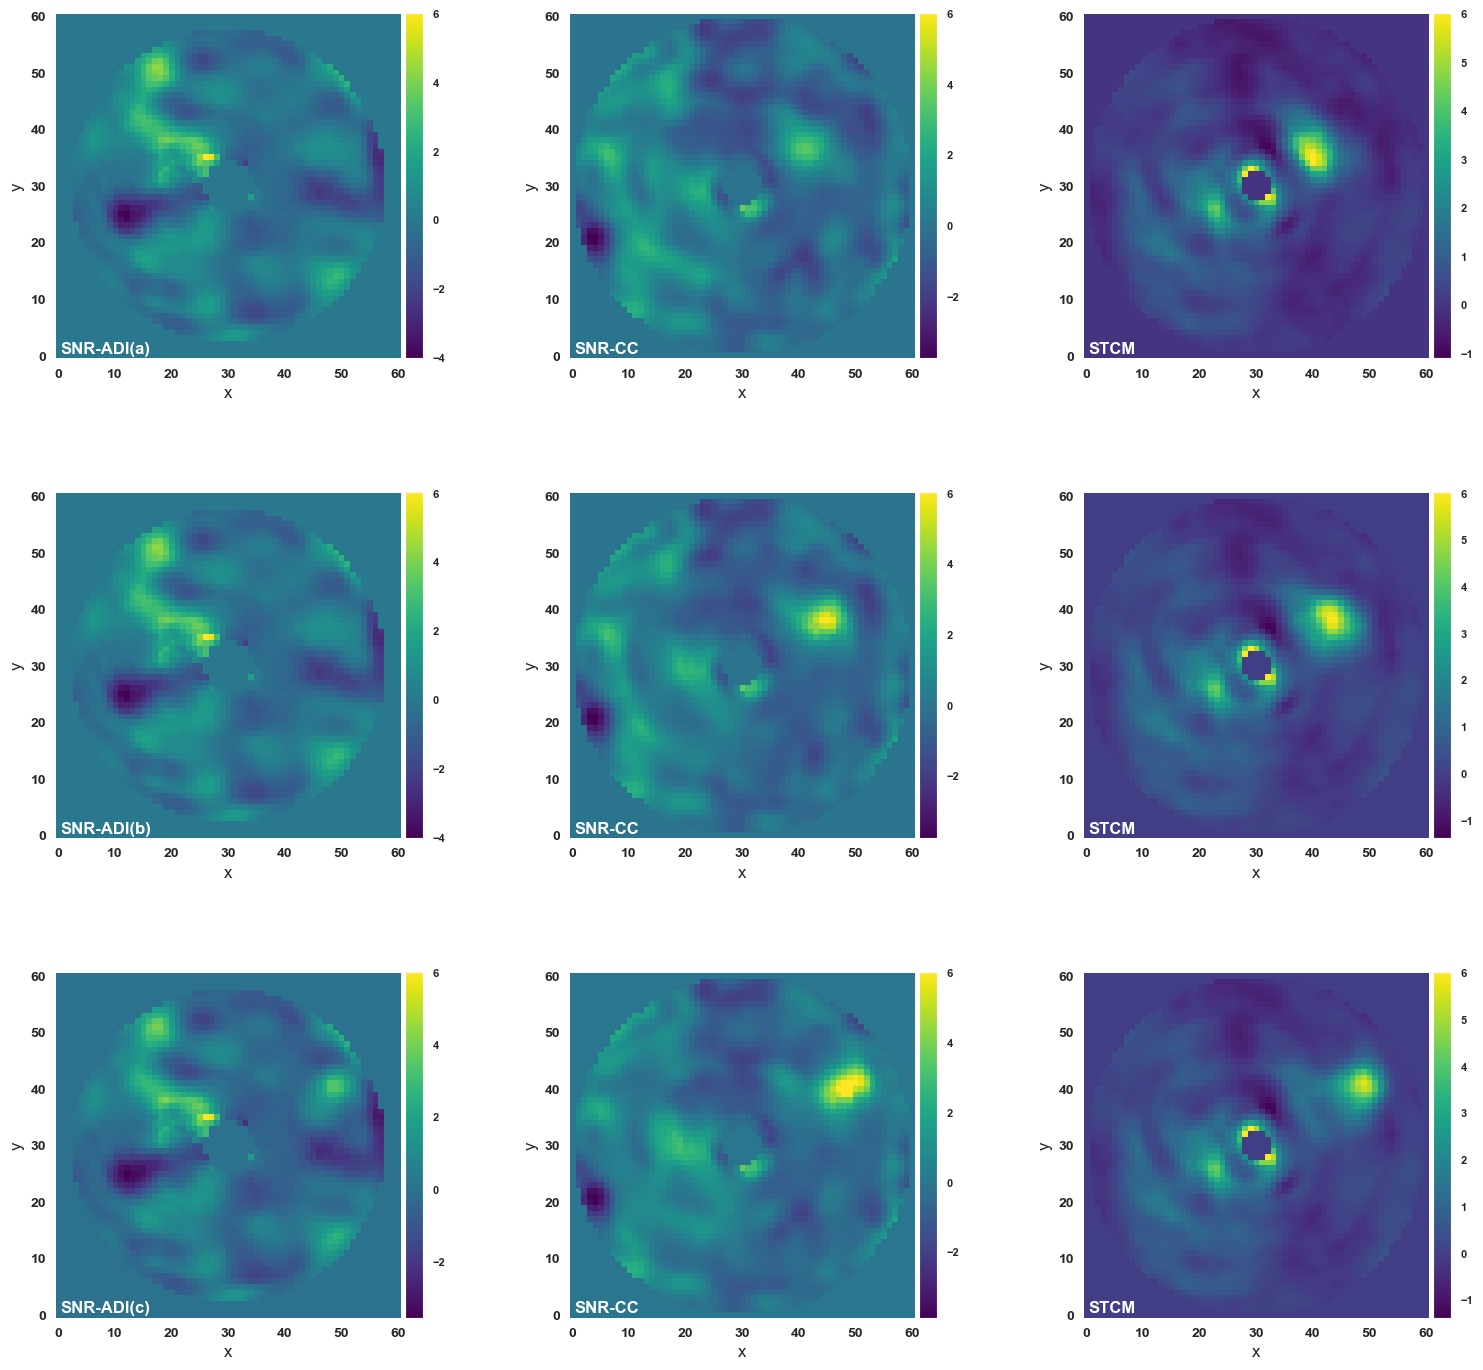

In [77]:
#f,ax = plt.subplots(2,1,sharex=True,sharey=True)
plot_frames(new_tup,
            rows = 3 ,ang_scale=False, ndec=2,ang_ticksep=9,log=False,
           label =('SNR-ADI(a)','SNR-CC','STCM',
                  'SNR-ADI(b)','SNR-CC','STCM',
                  'SNR-ADI(c)','SNR-CC','STCM'),
                #return_fig_ax = True,
           vmax=6)


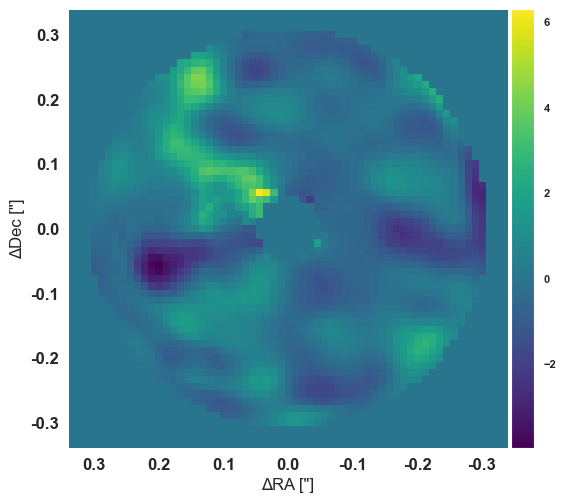

In [136]:
plot_frames(r1[1],ang_scale=True,ang_ticksep=9)

In [1580]:
len(r2)

4

In [116]:
plot_r1= np.copy(r1)
#plot_r2=np.copy(r2)
#plot_r3=np.copy(r3)

In [117]:
plot_r1[2]= snrmap(plot_r1[2],fwhm=2.5)
#plot_r2[2] = snrmap(plot_r2[2],fwhm=2.5)
#plot_r3[2] = snrmap(plot_r3[2],fwhm=2.5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-09-10 15:56:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 28 processes
Running time:  0:00:06.499809
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [118]:

plt_order = [plot_r1,plot_r2,plot_r3]

In [119]:
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str,y:float,bbox_props=None,fontsize=12):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold',y=y,bbox=bbox_props,fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

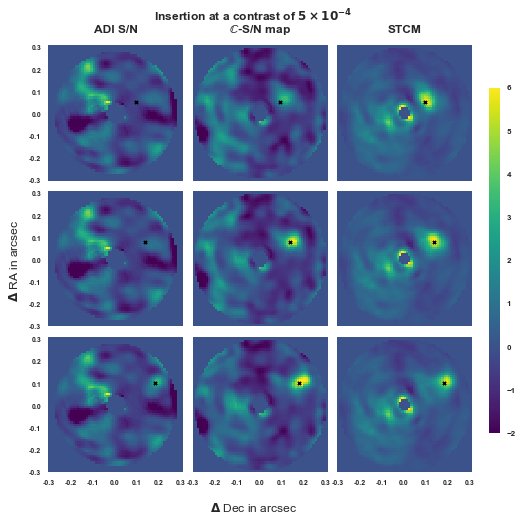

In [296]:
cb_titles=['S/N','$\mathcal{C}$-S/N','STC']

fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(7.6,8))
for j in range(3):
    for i in range(3):
        im = ax[j][i].pcolormesh(plt_order[j][i+1],cmap='viridis',vmin=-2,vmax=6)
        ax[j][i].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=ax[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        #cb.ax.set_title(cb_titles[i])
        #cb.ax.tick_params(labelsize=6)
        ax[j][i].set_xticks(np.arange(0,70,10))
        ax[j][i].set_yticks(np.arange(0,70,10))
        ax[j][i].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        ax[j][i].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        ax[j][i].scatter(arrow_tups[j][0],arrow_tups[j][1],marker='x',color='k',s=10)
cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
cb1=fig.colorbar(ax[0][0].collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.tick_params(labelsize=8)
    #ax.set(xlim=(0,60),ylim=(0,60))
#grid = plt.GridSpec(3, 3)
#create_subtitle(fig, grid[0 ,::], 'separation of $\\approx 2.3$ FWHM',y=0.95,fontsize=10)
#create_subtitle(fig, grid[1,::], 'separation of $\\approx 3.3$ FWHM',y=0.95,fontsize=10)
#create_subtitle(fig, grid[2,::], 'separation of $\\approx 4.3$ FWHM',y=0.95,fontsize=10)
ax[0][0].set_title('ADI S/N',fontweight='bold',y=1.05)
ax[0][1].set_title('$\mathbb{C}$-S/N map',fontweight='bold',y=1.05)
ax[0][2].set_title('STCM',fontweight='bold',y=1.05)
#fig.text(0.4,0.88,'Separation $\\approx 2.3$ FWHM',fontsize=9)
#fig.text(0.4,0.625,'Separation $\\approx 3.3$ FWHM',fontsize=9)
#fig.text(0.4,0.375,'Separation $\\approx 4.3$ FWHM',fontsize=9)
fig.suptitle("Insertion at a contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.94)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.06)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.05)
fig.subplots_adjust(wspace=0.07,hspace=0.02)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/Fig1_Dec_highres_noinbetween.png",dpi=400)

In [1969]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : float or array-like, shape (n, )
        The data positions.
    
    s : float or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
    
        Note that *c* should not be a single numeric RGB or RGBA sequence
    

In [235]:
help(ax.set_xticklabels)

AttributeError: 'numpy.ndarray' object has no attribute 'set_xticklabels'

In [ ]:
r1[1::]

In [ ]:
help(plot_frames)

In [ ]:
import hciplot
hciplot.__version__

### Fig 3,4,5

In [6]:
prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Training_vel/Training/"
h1_patches = open_fits(prefix+"H1patches/H1_seq_training_cont_1e-03_rad_22.0_theta_120.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)


In [7]:
h0_patches = open_fits(prefix+"H0patches/initial_h0_fov11.fits")
                       

Fits HDU-0 data successfully loaded. Data shape: (270, 83, 20, 11, 11)


In [8]:
t1 = h1_patches[50,0::,:,:]
t2 =h0_patches[33,50,::,:,:]

In [9]:
t1.shape

(20, 11, 11)

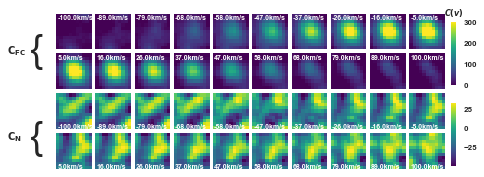

In [293]:
vels = np.linspace(-100,100,20)
fig, axs = plt.subplots(4,10,sharex=True,sharey=True,tight_layout=False,figsize=(8,8))

for j in range(0,2):
    for i in range(0,10):
        im= axs[j][i].pcolormesh(t1[i+(j*10)],cmap='viridis',vmin=0,vmax=300)
        axs[j][i].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=axs[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        axs[j][i].set_xticks(np.arange(0,11,5))
        axs[j][i].set_yticks(np.arange(0,11,5))
        
        axs[j][i].set_xticklabels(["","",""],fontsize=10)
        axs[j][i].set_yticklabels(["","",""],fontsize=10)
        axs[j][i].text(0.3,9,str(np.round(vels[i+(j*10)],0))+"km/s",c='w',fontsize=7)
        #axs[j][i].subplots.subplots_adjust(hspace=0.0)
#cb=plt.colorbar(im,ax=axs[0][-1],orientation='vertical')
cbar_ax = fig.add_axes([0.81, 0.51, 0.01, 0.11])
#fig.colorbar(im, cax=cbar_ax)
#im = collections[0]
cb1=fig.colorbar(axs[0][9].collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title("$C(v)$",fontsize=8,y=0.998)
for j in range(2,4):
    for i in range(0,10):
        im = axs[j][i].pcolormesh(t2[i+9*(j-2)],cmap ='viridis')
        axs[j][i].set_aspect('equal', 'box')
        axs[j][i].text(0.3,0.01,str(np.round(vels[i+((j-2)*10)],0))+"km/s",c='w',fontsize=7)
#draw_brace(axs[0][0],10,[-1,-1],'H1',text_pos=[-3,-2],rotate=True)
#draw_brace(axs[2][0],10,[-1,-1],'H0',text_pos=[-3,-2],rotate=True)
cbar_ax2 = fig.add_axes([0.81, 0.37, 0.01, 0.11])
cb2=fig.colorbar(axs[2][9].collections[0], cax=cbar_ax2,orientation='vertical')
cb2.ax.tick_params(labelsize=8)

fig.text(0.08,0.55,"{",fontsize=40,fontweight='normal')
fig.text(0.04,0.565,"$\\rm{C_{FC}}$",fontsize=10,fontweight='normal')
fig.text(0.08,0.40,"{",fontsize=40,fontweight='normal')
fig.text(0.04,0.415,"$\\rm{C_{N}}$",fontsize=10,fontweight='normal')
fig.subplots_adjust(wspace=0.1,top=0.95,bottom=0.05,hspace=-0.9,right=0.8)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig_2_dec2023_aligned.png",dpi=400)

In [290]:
help(cb1.ax.set_title)

Help on method set_title in module matplotlib.axes._axes:

set_title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs) method of matplotlib.axes._axes.Axes instance
    Set a title for the Axes.
    
    Set one of the three available Axes titles. The available titles
    are positioned above the Axes in the center, flush with the left
    edge, and flush with the right edge.
    
    Parameters
    ----------
    label : str
        Text to use for the title
    
    fontdict : dict
        A dictionary controlling the appearance of the title text,
        the default *fontdict* is::
    
           {'fontsize': rcParams['axes.titlesize'],
            'fontweight': rcParams['axes.titleweight'],
            'color': rcParams['axes.titlecolor'],
            'verticalalignment': 'baseline',
            'horizontalalignment': loc}
    
    loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
        Which title to set.
    
    y : float, default: :rc:`axes.ti

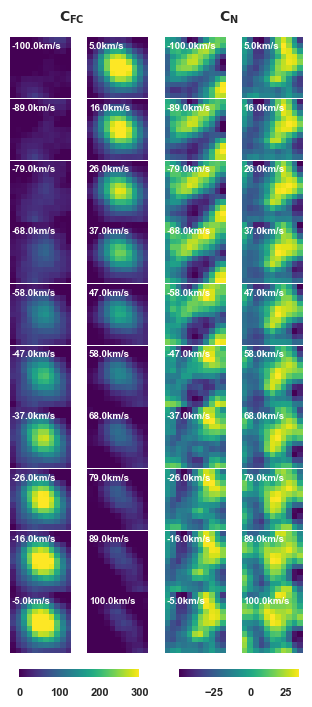

In [1858]:
vels = np.linspace(-100,100,20)
fig, axs = plt.subplots(10,4,sharex=True,sharey=True,tight_layout=False,figsize=(4,8))

for j in range(0,2):
    for i in range(0,10):
        im= axs[i][j].pcolormesh(t1[i+(j*10)],cmap='viridis',vmin=0,vmax=300)
        axs[i][j].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=axs[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        axs[i][j].set_xticks(np.arange(0,11,5))
        axs[i][j].set_yticks(np.arange(0,11,5))
        
        axs[i][j].set_xticklabels(["","",""],fontsize=10)
        axs[i][j].set_yticklabels(["","",""],fontsize=10)
        axs[i][j].text(0.3,9,str(np.round(vels[i+(j*10)],0))+"km/s",c='w',fontsize=7)
        #axs[j][i].subplots.subplots_adjust(hspace=0.0)
#cb=plt.colorbar(im,ax=axs[0][-1],orientation='vertical')
cbar_ax = fig.add_axes([0.17, 0.08, 0.3, 0.01])
#fig.colorbar(im, cax=cbar_ax)
#im = collections[0]
cb1=fig.colorbar(axs[9][0].collections[0], cax=cbar_ax,orientation='horizontal')
cb1.ax.tick_params(labelsize=8)
for j in range(2,4):
    for i in range(0,10):
        im = axs[i][j].pcolormesh(t2[i+9*(j-2)],cmap ='viridis')
        axs[i][j].set_aspect('equal', 'box')
        axs[i][j].text(0.3,9,str(np.round(vels[i+((j-2)*10)],0))+"km/s",c='w',fontsize=7)
#draw_brace(axs[0][0],10,[-1,-1],'H1',text_pos=[-3,-2],rotate=True)
#draw_brace(axs[2][0],10,[-1,-1],'H0',text_pos=[-3,-2],rotate=True)
cbar_ax2 = fig.add_axes([0.57, 0.08, 0.3, 0.01])
cb2=fig.colorbar(axs[9][2].collections[0], cax=cbar_ax2,orientation='horizontal')
cb2.ax.tick_params(labelsize=8)

f#ig.text(0.08,0.55,"{",fontsize=40,fontweight='normal')
fig.text(0.27,0.9,"$\\rm{C_{FC}}$",fontsize=10,fontweight='normal')
#fig.text(0.08,0.40,"{",fontsize=40,fontweight='normal')
fig.text(0.67,0.9,"$\\rm{C_{N}}$",fontsize=10,fontweight='normal')
fig.subplots_adjust(wspace=-0.01,hspace=0.01)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig_2_feb_vert.png",dpi=300)

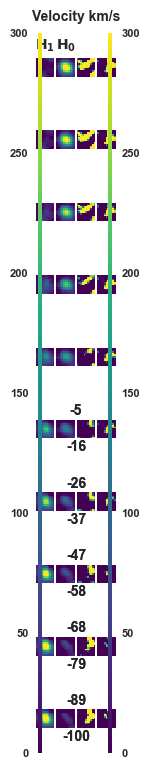

In [1815]:
vels = np.linspace(-100,100,20)
fig, axs = plt.subplots(10,4,sharex=True,sharey=True,figsize=(8,8))
ylocs=np.linspace(0.07,0.93,20)
for j in range(10):
    for i in range(0,2):
        im_h1= axs[j][i].pcolormesh(t1[j+(i*10)],cmap='viridis',vmin=0,vmax=300)
        axs[j][i].set_aspect('equal', 'box')
        #cb=plt.colorbar(im,ax=axs[j][i],fraction=0.046, pad=0.04,orientation='vertical')
        axs[j][i].set_xticks(np.arange(0,11,5))
        axs[j][i].set_yticks(np.arange(0,11,5))

        axs[j][i].set_xticklabels(["","",""],fontsize=10)
        axs[j][i].set_yticklabels(["","",""],fontsize=10)
        #axs[j][0].text(0.3,9,str(np.round(vels[j],0))+"km/s",c='w',fontsize=7)
for j in range(10):
    for i in range(2,4):
        im_h0 = axs[j][i].pcolormesh(t2[j+((i-2)*10)],cmap ='viridis',vmin=0,vmax=10)
        axs[j][i].set_aspect('equal', 'box')
        fig.text(0.1,ylocs[j],'{0:1.0f}'.format(vels[j]),fontsize=10,ha='center',va='center')
fig.text(0.1,0.97,'Velocity km/s',ha='center',va='center')
axs[0][0].set_title("$\\rm{H_1}$",fontsize=10)
axs[0][1].set_title('$\\rm{H_0}$',fontsize=10)
cbar_ax = fig.add_axes([0.053, 0.05, 0.005, 0.9])
cb1=fig.colorbar(axs[9][0].collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.tick_params(labelsize=8)
cb1.ax.yaxis.set_ticks_position('left')
#cb1.ax.set_title("CC")

cbar_ax2 = fig.add_axes([0.14, 0.05, 0.005, 0.9])
cb2=fig.colorbar(axs[9][1].collections[0], cax=cbar_ax2,orientation='vertical')
cb2.ax.tick_params(labelsize=8)
#cb2.ax.set_xticklabels(rotation=180)

#fig.text(0.08,0.55,"{",fontsize=40,fontweight='normal')
#fig.text(0.05,0.57,"$\\rm{H_{1}}$",fontsize=10,fontweight='normal')
#fig.text(0.08,0.40,"{",fontsize=40,fontweight='normal')
#fig.text(0.05,0.42,"$\\rm{H_{0}}$",fontsize=10,fontweight='normal')
fig.subplots_adjust(left=0.05,top=0.95,bottom=0.05,hspace=0.05,right=0.15,wspace=0.1)
#fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig2_vert.png",dpi=300)

### Fig 6, 7, 8

In [6]:
filename = "fitsfiles_vel/cnn_detmap_5e-04_21.0_180.00.fits"
detmap_cnn = open_fits(filename)#[5:55,5:55]
filename_sodinn = "fitsfiles_vel/sodinn_detmap_5e-04_21.0_180.00.fits"
detmap_sodinn = open_fits(filename_sodinn)#[5:55,5:55]
filename_stim = "fitsfiles/stim_detmap_5e-04_21.0_180.00.fits"
detmap_stim = open_fits(filename_stim)#[5:55,0:55]
filename_rf = "fitsfiles_vel/rf_detmap_5e-04_21.0_180.00.fits"
detmap_rf = open_fits(filename_rf)#[5:55,0:55]
rad = float(filename.split('/')[-1].split('_')[3])
theta = float(filename.split('/')[-1].split('_')[4].split('.')[0])
cont = float(filename.split('/')[-1].split('_')[2])
y_pos = frame_center(detmap_cnn)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(detmap_cnn)[0] +rad*np.cos(np.deg2rad(theta))
#detmap_cnn = 

Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)
Fits HDU-0 data successfully loaded. Data shape: (61, 61)


In [7]:
try:
    thresh_cnn = np.linspace(0.09,0.9999,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds = thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
except AttributeError:
    thresh_cnn = np.linspace(0.01,0.95,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=1)
try:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.99,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.95,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
try:
    thresh_rf=np.linspace(0.01,0.99,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    thresh_rf=np.linspace(0.01,0.7,10)
    res_rf = compute_binary_map(detmap_rf, 
                                    thresholds=thresh_rf,fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)

In [8]:
thresh_stim =np.linspace(1.3,6.0,10)
res_stim = compute_binary_map(detmap_stim,thresholds=thresh_stim,
                              fwhm=4.8,injections=(y_pos,x_pos),npix=1,
                             max_blob_fact=4)

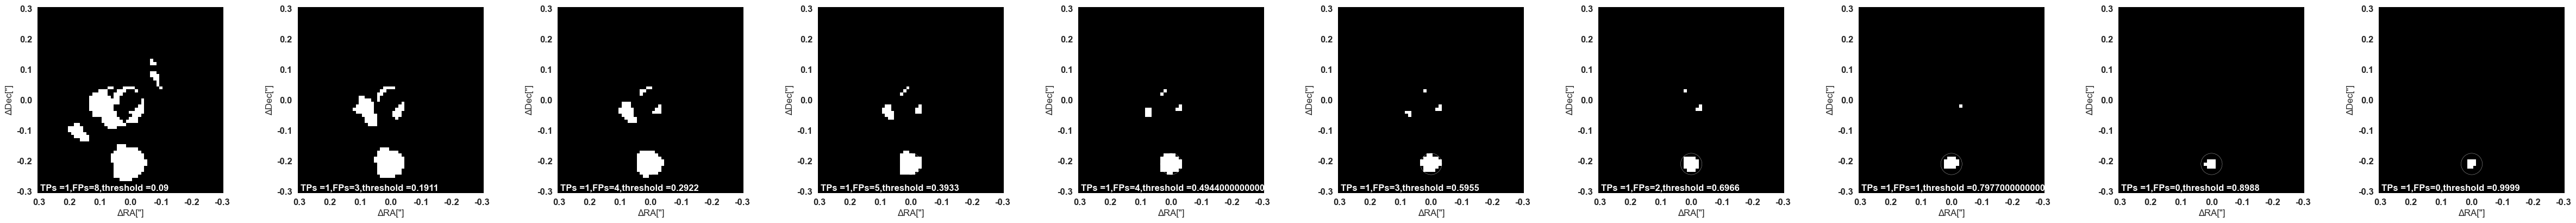

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [8, 3, 4, 5, 4, 3, 2, 1, 0, 0]


In [9]:
obj = res_stim
labs = tuple(["TPs ={0},FPs={1},threshold ={2}".format(o1,o2,o3) for o1,o2,o3 in zip(obj[0],obj[1],thresh_cnn)])
plot_frames(tuple(obj[2]),rows=1,
            ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),circle_radius=3.5,
            cmap='gray',
           label=labs,
           colorbar=False)
print(obj[0],obj[1])

In [10]:

detmaps = [detmap_stim,detmap_cnn,detmap_sodinn]

In [11]:
from matplotlib import colors
pmaps=[]
tps=[]
fps=[]
ths=[]
for i in [3,5,7,9]:
    val = obj[2][i]
    tps.append(obj[0][i])
    fps.append(obj[1][i])
    ths.append(thresh_stim[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=7,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps.append(pmap)
#plt.pcolormesh(pmap,cmap =custom_cmap)
#plot_frames(pmap,cmap=custom_cmap)
#plt.colorbar()
 #plt.scatter(all_pos[int(i)][1],all_pos[int(i)][0],marker='o',c='k')

In [12]:
pmaps_cnn=[]
tps_cnn=[]
fps_cnn=[]
ths_cnn=[]
for i in [3,5,7,9]:
    val = res_cnn[2][i]
    tps_cnn.append(res_cnn[0][i])
    fps_cnn.append(res_cnn[1][i])
    ths_cnn.append(thresh_cnn[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=8,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps_cnn.append(pmap)

In [13]:
pmaps_sodinn=[]
tps_sodinn=[]
fps_sodinn=[]
ths_sodinn=[]
for i in [3,5,7,9]:
    val = res_sodinn[2][i]
    tps_sodinn.append(res_sodinn[0][i])
    fps_sodinn.append(res_sodinn[1][i])
    ths_sodinn.append(thresh_cnn[i])
    #posns=(np.unravel_index(np.where(obj[2][1]),obj[2][1].shape))
    #print(obj[1])
    #all_pos=[]

    masked = mask_circle(val,cy=x_pos,cx=y_pos,radius=7,fillwith=False)
    #plt.pcolormesh(masked,cmap='Reds')
    #plt.pcolormesh(val,cmap='viridis')
    #val[masked] = -1
    pmap=np.ones(val.shape)*-1
    #pmap =
    pmap[val] = 1
    pmap[masked] = 0
    #pmap[pmap==0]=np.nan
    custom_cmap = colors.ListedColormap(['black','red','green'])
    pmaps_sodinn.append(pmap)

In [1499]:
thresh_cnn

array([0.09  , 0.1911, 0.2922, 0.3933, 0.4944, 0.5955, 0.6966, 0.7977,
       0.8988, 0.9999])

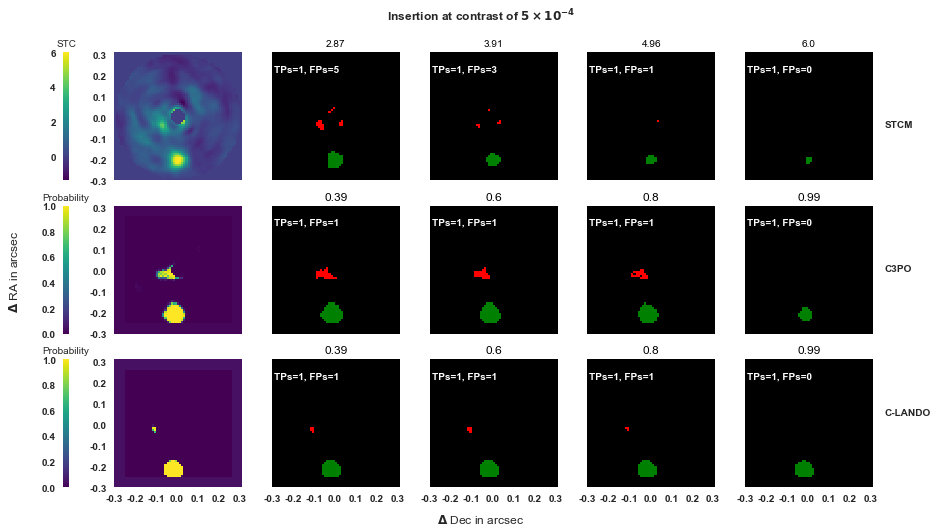

In [26]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
fig,axs = plt.subplots(3,len(pmaps)+1,sharey=True,sharex=True,figsize=(14,8))
#grid = plt.GridSpec(3, len(pmaps)+1)
bbox_props = dict(boxstyle="Round", fc="salmon", ec='k', alpha=0.4,pad=0.0001,x=0.01)
cb_titles =['STC','Probability','Probability']
#create_subtitle(fig, grid[0 ,::], 'Thresholded maps',y=0.95,fontsize=16)
#create_subtitle(fig, grid[0 ,::], 'STCM',y=0.85,fontsize=14)
#create_subtitle(fig, grid[1,::], 'C3PO',y=0.83, fontsize=14)
#create_subtitle(fig, grid[2,::], 'C-LANDO',y=0.83,fontsize=14)
#create_subtitle(fig, grid[0,0],'Detection maps',y=0.95,fontsize=16)
for i in range(3):
    if(i==0):
        vmax=6
        #vmin = 0
    else:
        vmax=1.0
    im = axs[i][0].pcolormesh(detmaps[i],cmap='viridis',vmax=vmax)#,vmin=vmin)
    axs[i][0].set_aspect('equal','box')
    axs[i][0].set_xticks(np.arange(0,70,10))
    axs[i][0].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[i][0].set_yticks(np.arange(0,70,10))
    axs[i][0].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[i][0].tick_params(axis='y', which='both', labelleft=True, labelright=False)
   # axs[i][0]= divider.new_vertical(size = '100%', pad = 0.1)
    cbaxes = axs[i][0].inset_axes([-0.4, 0.0, 0.05,1.0])
    cb = plt.colorbar(im,ax=axs[i][0],fraction=0.046, pad=0.01,cax=cbaxes,orientation='vertical')
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.tick_params(labelsize=10)
    
    cb.ax.set_title(cb_titles[i],fontsize=10)
    #cb.ax.set_xticks(fontsize=8)
    #cb.ax.set_yticklabels(["{:.1}".format(i) for i in cb.get_ticks()],fontsize=8)
legend_elements =[Line2D([0], [0], marker='o', color='k', label='FP',markerfacecolor='red'),
                         Line2D([0], [0], marker='o', color='k', label='TP',markerfacecolor='green')]
#fig.legend(handles=legend_elements)
for k in range(1,len(pmaps)+1):
    i=k-1
    if(tps[i]==0):
        cmap=colors.ListedColormap(['black','red'])
    else:
        cmap=custom_cmap
    axs[0][k].pcolormesh(pmaps[i],cmap=cmap)
    axs[0][k].set_aspect('equal','box')
    axs[0][k].text(1,52,"TPs={0}, FPs={1}".format(tps[i],fps[i]),c='w',fontsize=10)
    #create_subtitle(fig, grid[0,k],'Threshold = {0:.1f}'.format(np.round(ths[i],1)),y=0.83)
    axs[0][k].set_xticks(np.arange(0,70,10))
    axs[0][k].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[0][k].set_yticks(np.arange(0,70,10))
    axs[0][k].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    axs[0][k].set_title("{0}".format(np.round(ths[i],2)),c='k',fontsize=10)
    axs[1][k].pcolormesh(pmaps_cnn[i],cmap=custom_cmap)
    axs[1][k].set_aspect('equal','box')
    axs[1][k].text(1,52,"TPs={0}, FPs={1}".format(tps_cnn[i],fps_cnn[i]),c='w',fontsize=10)
    #create_subtitle(fig, grid[1,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[1][k].set_xticks(np.arange(0,70,10))
    axs[1][k].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    #axs[1][k].t(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='k')
    ths_cnn[-1] =0.99
    axs[1][k].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',fontsize=12)
    axs[2][k].pcolormesh(pmaps_sodinn[i],cmap=custom_cmap)
    axs[2][k].set_aspect('equal','box')
    axs[2][k].text(1,52,"TPs={0}, FPs={1}".format(tps_sodinn[i],fps_sodinn[i]),c='w',fontsize=10)
    axs[2][k].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',fontsize=12)

    #create_subtitle(fig, grid[2,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[2][k].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=10)
    #axs[2][k].text(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='w')
fig.text(0.9,0.75,'STCM')
fig.text(0.9,0.5,'C3PO')
fig.text(0.9,0.25,'C-LANDO')
#l=axs[0][1].legend(handles=legend_elements,loc='out')
#for text in l.get_texts():
 #   text.set_color("white")
fig.suptitle("Insertion at contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.96)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.06)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.03)
plt.subplots_adjust(hspace=0.2,wspace=0.05)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/Fig3_Mar2024_referee.png",dpi=400)#https://vip.readthedocs.io/en/latest/_modules/vip_hci/metrics/roc.html?highlight=compute_binary_map#

In [157]:
i

3

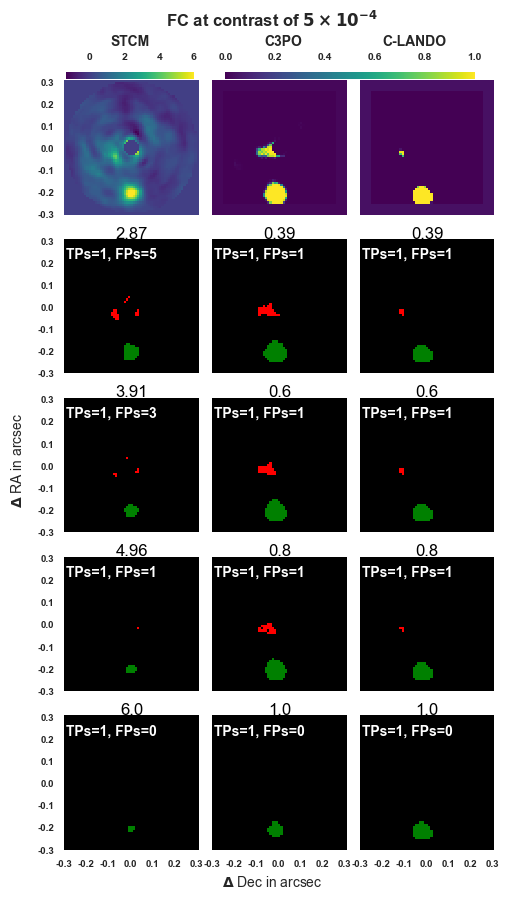

In [1955]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
fig,axs = plt.subplots(len(pmaps)+1,3,sharey=True,sharex=True,figsize=(5.7,10.0))
#grid = plt.GridSpec(3, len(pmaps)+1)
bbox_props = dict(boxstyle="Round", fc="salmon", ec='k', alpha=0.4,pad=0.0001,x=0.01)
cb_titles =['STC','Probability','Probability']
#create_subtitle(fig, grid[0 ,::], 'Thresholded maps',y=0.95,fontsize=16)
#create_subtitle(fig, grid[0 ,::], 'STCM',y=0.85,fontsize=14)
#create_subtitle(fig, grid[1,::], 'C3PO',y=0.83, fontsize=14)
#create_subtitle(fig, grid[2,::], 'C-LANDO',y=0.83,fontsize=14)
#create_subtitle(fig, grid[0,0],'Detection maps',y=0.95,fontsize=16)
vmaxs=[6.0,1.0,1.0]
for i in range(3):
    
    im = axs[0][i].pcolormesh(detmaps[i],cmap='viridis',vmax=vmaxs[i])
    axs[0][i].set_aspect('equal','box')
    if(i==0):
        axs[0][i].set_xticks(np.arange(0,70,10))
        axs[0][i].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        axs[0][i].set_yticks(np.arange(0,70,10))
        axs[0][i].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
        axs[0][i].tick_params(axis='y', which='both', labelleft=True, labelright=False)
   # axs[i][0]= divider.new_vertical(size = '100%', pad = 0.1)
cbaxes = axs[0][0].inset_axes([0.013, 1.01,0.95,0.05])
cb = plt.colorbar(axs[0][0].collections[0],ax=axs[0][0],fraction=0.046, pad=0.08,cax=cbaxes,orientation ='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=7.5)

cbaxes = axs[0][1].inset_axes([0.05*(1+1), 1.01,1.85,0.05])
cb = plt.colorbar(axs[0][1].collections[0],ax=axs[0][1],fraction=0.046, pad=0.08,cax=cbaxes,orientation ='horizontal')
cb.ax.xaxis.set_ticks_position('top')
cb.ax.tick_params(labelsize=7.5)
    
    #cb.ax.set_title(cb_titles[i],fontsize=8)
    #cb.ax.set_xticks(fontsize=8)
    #cb.ax.set_yticklabels(["{:.1}".format(i) for i in cb.get_ticks()],fontsize=8)
fig.text(0.25,0.918,'STCM',va='center',ha='center')
fig.text(0.52,0.918,'C3PO',va='center',ha='center')
fig.text(0.75,0.918,'C-LANDO',va='center',ha='center')
legend_elements =[Line2D([0], [0], marker='o', color='k', label='FP',markerfacecolor='red'),
                         Line2D([0], [0], marker='o', color='k', label='TP',markerfacecolor='green')]
#fig.legend(handles=legend_elements)
for k in range(1,len(pmaps)+1):
    i=k-1
    if(tps[i]==0):
        cmap=colors.ListedColormap(['black','red'])
    else:
        cmap=custom_cmap
    axs[k][0].pcolormesh(pmaps[i],cmap=cmap)
    axs[k][0].set_aspect('equal','box')
    axs[k][0].text(1,52,"TPs={0}, FPs={1}".format(tps[i],fps[i]),c='w')
    #create_subtitle(fig, grid[0,k],'Threshold = {0:.1f}'.format(np.round(ths[i],1)),y=0.83)
    axs[k][0].set_xticks(np.arange(0,70,10))
    axs[k][0].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][0].set_yticks(np.arange(0,70,10))
    axs[k][0].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][0].set_title("{0}".format(np.round(ths[i],2)),c='k',y=0.94)
    axs[k][1].pcolormesh(pmaps_cnn[i],cmap=custom_cmap)
    axs[k][1].set_aspect('equal','box')
    axs[k][1].text(1,52,"TPs={0}, FPs={1}".format(tps_cnn[i],fps_cnn[i]),c='w')
    #create_subtitle(fig, grid[1,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[k][1].set_xticks(np.arange(0,70,10))
    axs[k][1].set_yticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][1].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    #axs[1][k].t(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='k')
    axs[k][1].set_title("{0}".format(np.round(ths_cnn[i],2)),c='k',y=0.94)
    axs[k][2].pcolormesh(pmaps_sodinn[i],cmap=custom_cmap)
    axs[k][2].set_aspect('equal','box')
    axs[k][2].text(1,52,"TPs={0}, FPs={1}".format(tps_sodinn[i],fps_sodinn[i]),c='w')
    #create_subtitle(fig, grid[2,k],'Threshold = {0:0.1f}'.format(np.round(ths_cnn[i],3)),y=0.83)
    axs[k][2].set_xticklabels(np.round(np.arange(-0.3,0.4,0.1),1),fontsize=7)
    axs[k][2].set_title("{0}".format(np.round(ths_sodinn[i],2)),c='k',y=0.94)
    #axs[2][k].text(1,52,"Threshold={0}".format(np.round(ths_cnn[i],2)),c='w')
#fig.text(0.95,0.37,'STCtMs ')

#l=axs[0][1].legend(handles=legend_elements,loc='out')
for text in l.get_texts():
    text.set_color("white")
fig.suptitle("FC at contrast of $5\\times10^{-4}$",fontweight='bold',fontsize=12,y=0.95)
fig.supxlabel("$\Delta$ Dec in arcsec",y=0.07,fontsize=10)
fig.supylabel("$\Delta$ RA in arcsec",y=0.5,x=0.04,fontsize=10)
plt.subplots_adjust(hspace=0.18,wspace=0.01)
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/Fig3_feb_vert.png",dpi=400)

# Fig 9 and 10

In [128]:
try:
    thresh_cnn = np.linspace(0.09,0.9999,10)
    res_cnn =compute_binary_map(mask_circle(detmap_cnn,3.5),
                            thresholds = thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=3)
except AttributeError:
    thresh_cnn = np.linspace(0.1,0.95,10)
    res_cnn =compute_binary_map(detmap_cnn,
                            thresholds=thresh_cnn,fwhm=4.8,injections=(y_pos,x_pos),npix=2,
                            overlap_threshold=0.5,
                            max_blob_fact=1)
detmap_sodinn = detmap_sodinn#[5:56,5:56]
y_pos = frame_center(detmap_sodinn)[0]+rad*np.sin(np.deg2rad(theta))
x_pos = frame_center(detmap_sodinn)[0] +rad*np.cos(np.deg2rad(theta))
try:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.9999,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)
except AttributeError:
    res_sodinn = compute_binary_map(detmap_sodinn, 
                                    thresholds=np.linspace(0.09,0.85,10),fwhm=4.8,injections=(y_pos,x_pos),
                                    npix=2)

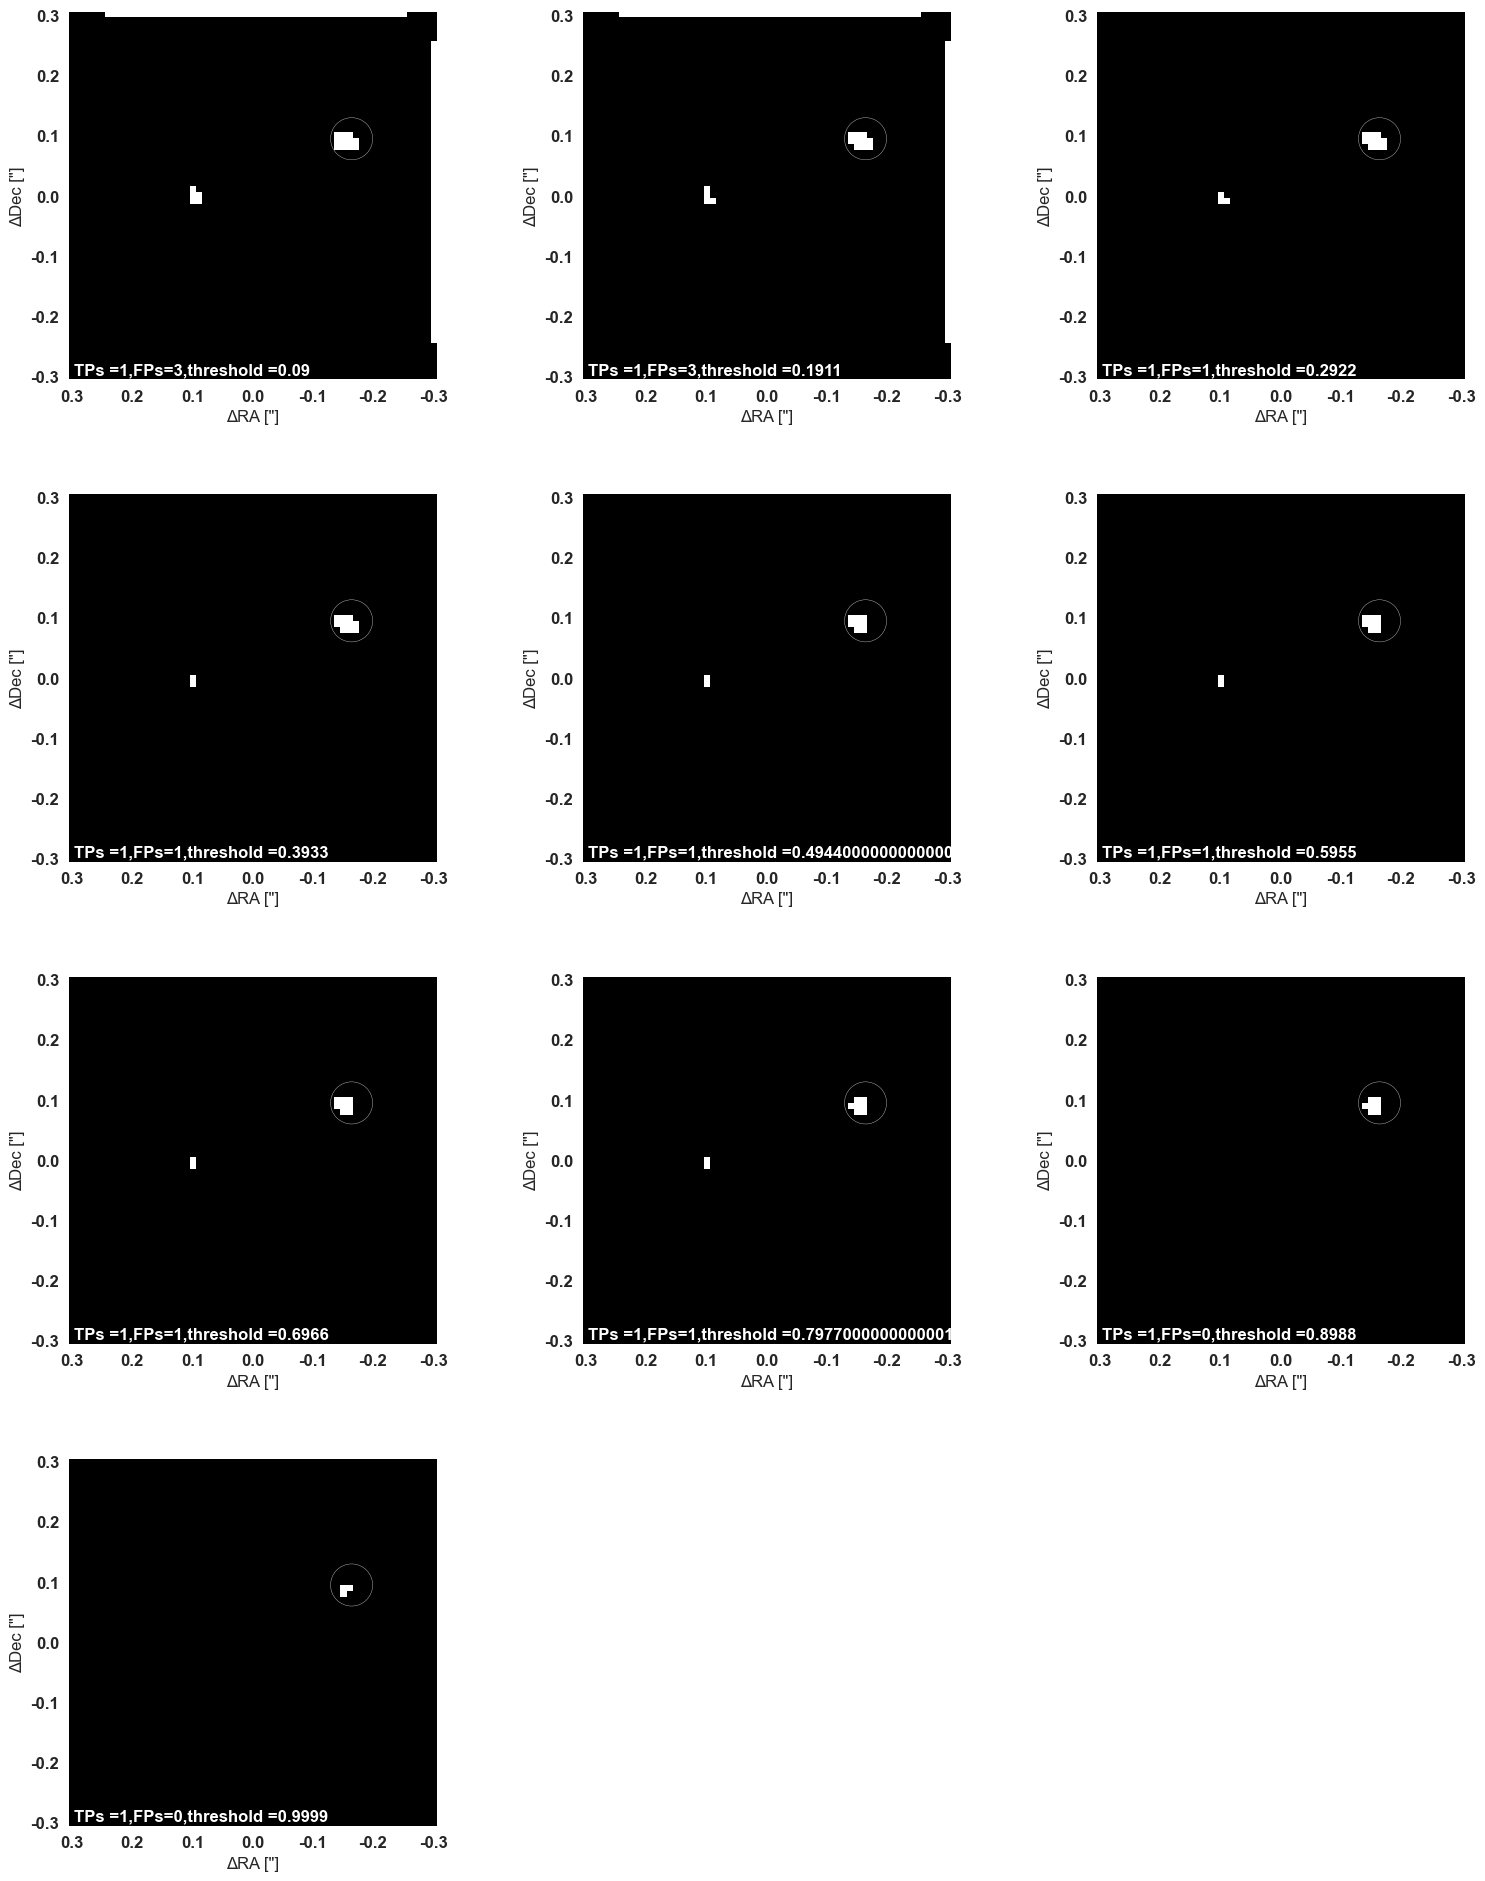

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [3, 3, 1, 1, 1, 1, 1, 1, 0, 0]


In [129]:
obj = res_sodinn
labs = tuple(["TPs ={0},FPs={1},threshold ={2}".format(o1,o2,o3) for o1,o2,o3 in zip(obj[0],obj[1],thresh_cnn)])
plot_frames(tuple(obj[2]),rows=4,
            ang_scale=True,ang_ticksep=10,circle=(y_pos,x_pos),circle_radius=3.5,
            cmap='gray',
           label=labs,
           colorbar=False)
print(obj[0],obj[1])

## New fig 6 (ROC)

In [27]:
mask = 3.5
start_pix =9.0
end_pix =13.0
C_low = 1e-04
C_high = 3e-04
tpr_stim_vel = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_sodinn_vel = open_fits("stats_roc_runs_vel/tpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_cnn_vel = open_fits("stats_roc_runs_vel/tpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_sodinn_vel = open_fits("stats_roc_runs_vel/fpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn_vel = open_fits("stats_roc_runs_vel/fpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_cnn_vel = open_fits("stats_roc_runs_vel/thresh_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_sodinn_vel = open_fits("stats_roc_runs_vel/thresh_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [37]:
mask = 3.5
#start_pix =19.0
#end_pix =23.0
C_low = [5e-04,3e-04,1e-04]
C_high = [7e-04,5e-04,3e-04]
start_pixs=[19,14,9]#[9,14,19]
end_pixs = [23,18,13]#[13,18,23]
all_tps=[]
all_fps=[]
all_thresh=[]
for c in range(3):
    tprs=[]
    fps=[]
    thresh=[]
    for i in range(3):
        tprs_peralgo=[]
        fps_peralgo=[]
        thresh_peralgo=[]
        for string in ['stim','cnn','sodinn']:
            tprs_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            fps_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            thresh_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprs.append(tprs_peralgo)
        fps.append(fps_peralgo)
        thresh.append(thresh_peralgo)
    all_tps.append(tprs)
    all_fps.append(fps)
    all_thresh.append(thresh)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0

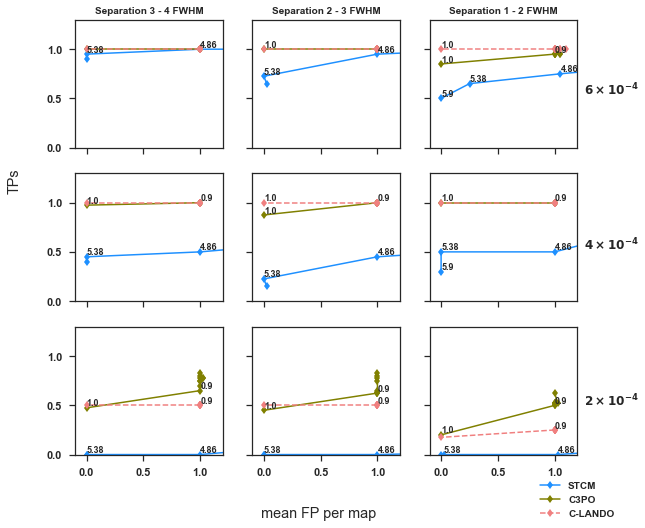

In [45]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("notebook", font_scale=1.0)

fig,axs = plt.subplots(3,3,sharey=True,sharex=True,figsize=(9,8))
labels =['STCM','C3PO','C-LANDO']
colors = ['dodgerblue','olive','lightcoral']
linestyles = ['solid','solid','dashed']
for row in range(len(all_fps)):
    for col in range(3):
        for j in range(3):
            axs[row][col].plot(all_fps[row][col][j],all_tps[row][col][j],label = labels[j],marker='d',
                               color=colors[j],
                               linestyle = linestyles[j])


            axs[0][col].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),
                                                                         int(end_pixs[col]/4.8)),fontweight='bold',fontsize=10)
            axs[row][col].set_xlim(-0.1,1.2)
            axs[row][col].set_ylim(0,1.3)
            start = 8
            if(j ==0):
                start = 7
            else:
                start = 8
            for sing in range(start,10):
            
                #if()
                txt = axs[row][col].text(all_fps[row][col][j][sing],all_tps[row][col][j][sing]+sep,
                              '{0:s}'.format(str(np.round(all_thresh[row][col][j][sing],2))),fontsize=9)
                plt.draw()
                if any(txt.get_window_extent().overlaps(t.get_window_extent()) for t in axs[row][col].texts[:-1]):
                    txt.remove() 
                
            #axs[row][col].set_yscale('log')
handles, labels = axs[1][1].get_legend_handles_labels()

fig.legend(handles=handles,labels=labels,loc=(0.83,0.01),fontsize=10)
fig.text(0.91,0.75,'$6\\times10^{-4}$',fontsize=12)
fig.text(0.91,0.48,'$4\\times10^{-4}$',fontsize=12)
fig.text(0.91,0.21,'$2\\times10^{-4}$',fontsize=12)
fig.supxlabel("mean FP per map")
fig.supylabel("TPs",x=0.02,y=0.6)
#fig.text(0.1,0.05,"({0:s}-{1:s})".format(str(np.round(all_thresh[0][0][0][7],2)),
                                         # str(np.round(all_thresh[0][0][0][9],2))),color='dodgerblue')
#fig.text(0.1,0.03,"({0:s}-{1:s})".format(str(np.round(all_thresh[0][0][1][8],2)),
                                         #str(np.round(all_thresh[0][0][1][9],2))),color='olive')
fig.savefig("/mnt/diskss/home/rnath/NathRanga2024/Paper/fig4_Apr2024_referee.png",dpi=400)
#axs[i][j].set_aspect('equal','box')str(np.round(all_thresh[0][0][0][9],3))

In [1403]:
all_thresh[-1][1][:]

[array([1.2      , 1.7222222, 2.2444444, 2.7666667, 3.288889 , 3.8111112,
        4.3333335, 4.8555555, 5.3777776, 5.9      ], dtype=float32),
 array([0.09 , 0.191, 0.292, 0.393, 0.494, 0.595, 0.696, 0.797, 0.898,
        0.999], dtype=float32),
 array([0.09 , 0.191, 0.292, 0.393, 0.494, 0.595, 0.696, 0.797, 0.898,
        0.999], dtype=float32)]

# Discussions

## velocity

In [46]:
mask = 3.5
start_pix =19.0
end_pix =23.0
C_low = 3e-04
C_high = 5e-04
tpr_stim = open_fits("stats_roc_runs_vel/tpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_sodinn = open_fits("stats_roc_runs_novel_fixedthresh/v0/tpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
tpr_cnn = open_fits("stats_roc_runs_novel_fixedthresh//tpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_stim = open_fits("stats_roc_runs_vel/fpr_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
fpr_sodinn = open_fits("stats_roc_runs_novel_fixedthresh/v0/fpr_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:3.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
#fpr_rf_2 = open_fits("stats_roc_runs/fpr_rf_mask_3.5_cont_from1e-04_to_5e-04_rad_from_19.00_to_23.00.fits")
fpr_cnn = open_fits("stats_roc_runs_novel_fixedthresh//fpr_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_stim_vel = open_fits("stats_roc_runs_vel/thresh_stim_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_cnn = open_fits("stats_roc_runs_novel_fixedthresh//thresh_cnn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))
thresh_sodinn = open_fits("stats_roc_runs_novel_fixedthresh//thresh_sodinn_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pix,end_pix,C_low,C_high))

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [47]:
C_low = [3e-04,1e-04]
C_high = [5e-04,3e-04]
start_pixs=[19]#[9,14,19]
end_pixs = [23]#[13,18,23]
all_tpsnovel=[]
all_fpsnovel=[]
all_threshnovel=[]
for c in range(len(C_low)):
    tprsnovel=[]
    fpsnovel=[]
    threshnovel=[]
    for i in range(len(start_pixs)):
        tprs_peralgonovel=[]
        fps_peralgonovel=[]
        thresh_peralgonovel=[]
        for string in ['cnn','sodinn']:
            if(string =='sodinn'):
                tprs_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                fps_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                thresh_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/v0/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            else:
                tprs_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                fps_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh//fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
                thresh_peralgonovel.append(open_fits("stats_roc_runs_novel_fixedthresh//thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprsnovel.append(tprs_peralgonovel)
        fpsnovel.append(fps_peralgonovel)
        threshnovel.append(thresh_peralgonovel)
    all_tpsnovel.append(tprsnovel)
    all_fpsnovel.append(fpsnovel)
    all_threshnovel.append(threshnovel)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [210]:
fpf_cnn=[282., 158., 150., 152., 150., 150.,  75.,  75.,  75.,  75.,] 
fpf_sodinn=[225., 225., 225., 224., 148., 142.,  75.,  75.,  76.,  75.,] 
fpf_rf =[145.,  77.,  75.,  75., 156., 150., 150., 150., 225.,  75.,]
#tpf_stim=[67., 51., 50., 50., 49., 45., 34., 26., 25., 23.,]
tpf_cnn=[55., 54., 52., 50., 50., 50., 50., 50., 50., 42.,] 
tpf_sodinn=[51., 52., 50., 49., 48., 46., 46., 46., 46., 37.,] 

In [49]:
mask = 3.5
#start_pix =19.0
#end_pix =23.0
C_low = [3e-04,1e-04]
C_high = [5e-04,3e-04]
start_pixs=[19]#[9,14,19]
end_pixs = [23]#[13,18,23]
all_tps=[]
all_fps=[]
all_thresh=[]
for c in range(len(C_low)):
    tprs=[]
    fps=[]
    thresh=[]
    for i in range(len(start_pixs)):
        tprs_peralgo=[]
        fps_peralgo=[]
        thresh_peralgo=[]
        for string in ['stim','cnn','sodinn']:
            tprs_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/tpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            fps_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/fpr_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
            thresh_peralgo.append(open_fits("stats_roc_runs_vel_fixedthresh/thresh_{4:s}_mask_3.5_cont_from{2:1.0e}_to_{3:1.0e}_\
rad_from_{0:2.2f}_to_{1:2.2f}.fits".format(start_pixs[i],end_pixs[i],C_low[c],C_high[c],string)))
        tprs.append(tprs_peralgo)
        fps.append(fps_peralgo)
        thresh.append(thresh_peralgo)
    all_tps.append(tprs)
    all_fps.append(fps)
    all_thresh.append(thresh)

Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)
Fits HDU-0 data successfully loaded. Data shape: (10,)


In [185]:
len(all_fps)

2

Text(0.5, 1.0, 'mean Contrast $<4\\times10^{-4}$ between $3-4$ FWHM ')

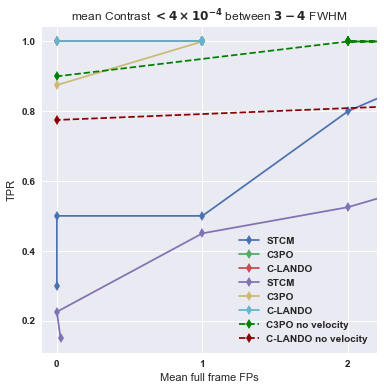

In [214]:
fig,axs = plt.subplots(1,1,figsize=(6,6))
labels =['STCM','C3PO','C-LANDO']
for row in range(len(all_fps)):
    for j in range(len(labels)):
        axs.plot(all_fps[row][][j],all_tps[0][row][j],label = labels[j],marker='d')
#axs.plot(np.asarray(fpf_cnn)/75,np.asarray(tpf_cnn)/75,c='green',ls='--',marker='d',
 #        label ='C3PO no velocity')
axs.plot(fpr_cnn,tpr_cnn,marker='d',c='green',ls='--',
         label ='C3PO no velocity')
#axs.plot(np.asarray(fpf_sodinn)/75,np.asarray(tpf_sodinn)/75,c='darkred',ls='--',marker='d',
 #       label ='C-LANDO no velocity')
axs.plot(fpr_sodinn,tpr_sodinn,marker='d',c='darkred',ls ='--',
         label ='C-LANDO no velocity')
#axs.plot(fpr_rf,tpr_rf,marker='d',c='teal',ls ='--',
 #        label ='C-LANDO no velocity')
axs.set_xlim(-0.1,2.2)
axs.set_xticks([0,1,2])
plt.xlabel("Mean full frame FPs")
plt.ylabel("TPR")
plt.legend()
plt.title("mean Contrast $<4\\times10^{-4}$ between $3-4$ FWHM ")
#fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig6_disc_23Feb.png",dpi=400)

In [179]:
tpr_sodinn,fpr_sodinn

(array([0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825,
        0.775], dtype=float32),
 array([4.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.  , 2.95, 0.  ],
       dtype=float32))

In [226]:

(C_low[row]+C_high[row])/2

0.00039999999999999996

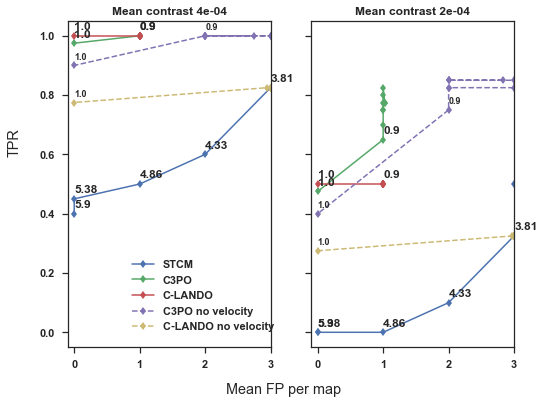

In [78]:
fig,axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(8,6))
#fig.ax.set_xlim(-0.1,2.1)
labels =['STCM','C3PO','C-LANDO']
for row in range(len(all_fps)):
    for col in range(1):
        for j in range(len(labels)):
            axs[row].plot(all_fps[row][col][j],all_tps[row][col][j],label = labels[j],marker='d')
            #axs[row].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),int(end_pixs[col]/4.8)))
            axs[row].set_title("Mean contrast {0:1.0e}".format((C_low[row]+C_high[row])/2),fontweight='bold')
            #axs[row].set_xlim(-0.1,1.2)
            if j==0:
                start =5
            else:
                start =8
            for sing in range(start,10):
                axs[row].text(all_fps[row][col][j][sing],all_tps[row][col][j][sing]+0.02,
                              '{0:s}'.format(str(np.round(all_thresh[row][col][j][sing],2))))
            #axs[row][col].set_xscale('log')
handles, leg_labels = axs[1].get_legend_handles_labels()
#fig.ax.set_xlim(-0.1,2.1)
labels =['C3PO no velocity','C-LANDO no velocity']
for row in range(len(all_fpsnovel)):
        for j in range(len(labels)):
            axs[row].plot(all_fpsnovel[row][col][j],all_tpsnovel[row][col][j],label = labels[j],marker='d',ls='--')
            #axs[row].set_title("Separation {0:d} - {1:d} FWHM".format(int(start_pixs[col]/4.8),int(end_pixs[col]/4.8)))
            #axs[row].set_xlim(-0.1,2)
           
            for sing in range(8,10):
                #axs[row].text(all_fpsnovel[row][col][j][sing]+0.04,all_tpsnovel[row][col][j][sing]+0.02,
                 #             '{0:s}'.format(str(np.round(all_threshnovel[row][col][j][sing],2))))
                txt = axs[row].text(all_fpsnovel[row][col][j][sing],all_tpsnovel[row][col][j][sing]+sep,
                              '{0:s}'.format(str(np.round(all_threshnovel[row][col][j][sing],2))),fontsize=9)
                plt.draw()
                if any(txt.get_window_extent().overlaps(t.get_window_extent()) for t in axs[row].texts[:-1]):
                    txt.remove() 
                
                
            

            #axs[row][col].set_xscale('log')
#fig.ax.set_xlim(-0.1,2.1)
h,l = axs[1].get_legend_handles_labels()
axs[0].set_xlim(-0.1,3)
axs[0].set_xticks([0,1,2,3])
#ig.legend()
fig.legend(bbox_to_anchor=(0.5, 0.35),handles=h,labels=l)
#fig.text(0.002,0.75,'$6\\times10^{-4}$')
#fig.text(0.88,0.48,'Separation\n3-4 FWHM',)
#fig.text(0.002,0.21,'$2\\times10^{-4}$')
fig.supxlabel("Mean FP per map")
fig.supylabel("TPR",x=0.02,y=0.6)
fig.savefig("/mnt/diskss/home/rnath/NathRanga2024/Paper/Fig6_April2024_referee.png",dpi=400)

In [65]:
texts

[Text(0.0, 0.9399999761581421, '1.0')]

In [228]:
len(all_fpsnovel)

1

In [194]:
help(fig.legend)

Help on method legend in module matplotlib.figure:

legend(*args, **kwargs) method of matplotlib.figure.Figure instance
    Place a legend on the figure.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to these three different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        fig.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        fig.legend()
    
    Specific lines can be excluded from the automatic legend elem

In [ ]:
pl

## Spatial dimension

In [271]:
prefix = "/mnt/disk12tb/Users/rakesh/SpatialDetection/Training_vel/Training/"
h1_patches_lc = open_fits(prefix+"H1patches/H1_seq_training_cont_5e-04_rad_22.0_theta_120.00.fits")
h1_patches_hc = open_fits(prefix+"H1patches/H1_seq_training_cont_1e-04_rad_22.0_theta_120.00.fits")

Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)
Fits HDU-0 data successfully loaded. Data shape: (83, 20, 11, 11)


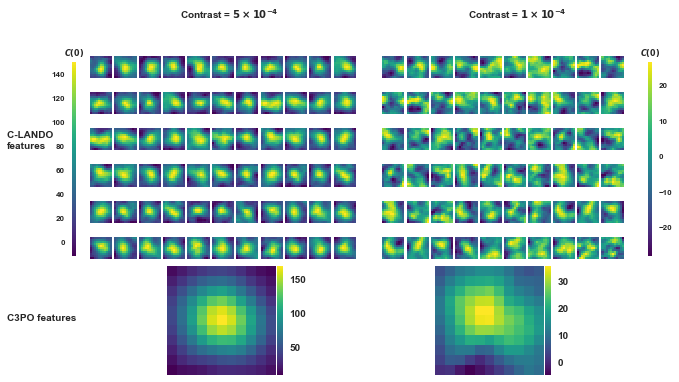

In [277]:
fig = plt.figure(figsize=(10,6
                         ))
rows = 9
columns =23
grid = plt.GridSpec(rows, columns,hspace=0.0001,wspace=0.1)
for i in range(6):
    for j in range(11):
   #fig.add_subplot(4,6,i)
            
        temp_cube = j+i*7
        ax = plt.subplot(grid[i,j])
        if(j ==0):
            ax.set_yticklabels("")
            #ax.set_xticklabels("")
        if(i ==5):
            ax.set_xticks([0,10])
            ax.set_xticklabels("")
            ax.set_yticklabels("")
        else:
            ax.set_xticklabels("")
            ax.set_yticklabels("")
        plt.pcolormesh(h1_patches_lc[temp_cube,10,:,:],cmap='viridis')
        ax.set_aspect('equal', 'box')
cbar_ax = fig.add_axes([0.1, 0.4, 0.005, 0.45])
cb1=fig.colorbar(ax.collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.yaxis.set_ticks_position('left')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title('$C(0)$',fontsize=8)
#fig.add_subplot(4,6,([20,21,22,23]))
ax = plt.subplot(grid[6:10,3:8])
plt.pcolormesh(np.mean(h1_patches_lc,axis=0)[10,:,:],cmap='viridis')
ax.set_xticklabels("")
ax.set_yticklabels("")
plt.colorbar(fraction=0.046, pad=0.01)
ax.set_aspect('equal', 'box')
for i in range(6):
    for j in range(12,22):
   #fig.add_subplot(4,6,i)
        temp_cube = j+i*7
        ax = plt.subplot(grid[i,j])
        plt.pcolormesh(h1_patches_hc[temp_cube,10,:,:],cmap='viridis')
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.set_aspect('equal', 'box')
#fig.add_subplot(4,6,([20,21,22,23]))
cbar_ax = fig.add_axes([0.9, 0.4, 0.005, 0.45])
cb1=fig.colorbar(ax.collections[0], cax=cbar_ax,orientation='vertical')
cb1.ax.yaxis.set_ticks_position('right')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_title('$C(0)$',fontsize =8)
ax= plt.subplot(grid[6:10,14:19])
plt.pcolormesh(np.mean(h1_patches_hc,axis=0)[10,:,:],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.01)
ax.set_aspect('equal', 'box')
ax.set_xticklabels("")
ax.set_yticklabels("")
fig.text(0.25,0.95,"Contrast = $5\\times10^{-4}$")
fig.text(0.65,0.95,"Contrast = $1\\times10^{-4}$")
fig.text(0.01,0.65,'C-LANDO \nfeatures')
fig.text(0.01,0.25,'C3PO features')
fig.savefig("/mnt/diskss/home/rnath/SpatialDetectionML/PaperPlots_Dec2022/fig5_disc_dec2023.png",dpi=400)